In [20]:
import os
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import torchvision
import torchaudio.transforms as T
import torch.optim as optim
import glob
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import statistics
import torch.optim as optim
import torchaudio.transforms as T
from torch.utils.data import Dataset
from torchvision import transforms 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

2880000
tensor([[-0.6644, -0.6488, -0.6342,  ...,  0.2351,  0.2089,  0.1775]])
torch.Size([1, 224, 1407])
torch.Size([1, 224, 224])
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


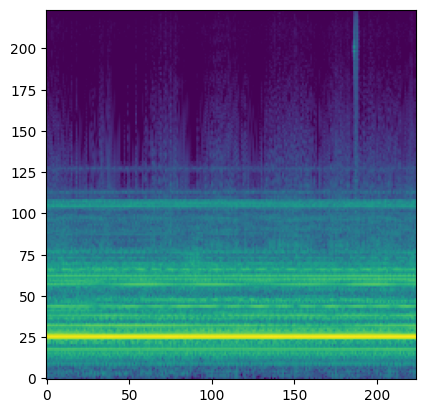

In [21]:


# WAV ファイルの読み込み
SAMPLE_WAV_PATH = "M2RB_T1.wav"
waveform, sample_rate = torchaudio.load(filepath=SAMPLE_WAV_PATH)
print(sample_rate*60)
#start_point = sample_rate * 5
#cut_width = sample_rate * 10
#waveform = waveform[:, start_point : (start_point + cut_width)]
waveform = waveform[:, 0 : sample_rate * 60]
#-----
#new_sample_rate = sample_rate / 2
#channel=0
#waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))
print(waveform)
#-----

# Melspectrogram の設定
sample_rate=sample_rate
n_mels = 224#128
n_fft = 4096#2150 #2048
win_length = None
hop_length = n_fft//2 #4
window_fn = torch.hann_window

# Melspectrogram の計算
spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=window_fn,
    power=2.0,
)
spec = spectrogram(waveform)
print(spec.shape)
#spec = spectrogram(waveform)
#spec_aug = torch.nn.Sequential(
#    T.TimeMasking(time_mask_param=30, p=0.1),
#    T.FrequencyMasking(freq_mask_param=30),
#)
#spec = spec_aug(spec)
#print(type(spec))
# 縦軸をデシベルに変換

transform = transforms.TenCrop(size=(224, 224))
spec_list = transform(spec)
spec_db_list = []
print(spec_list[0].shape)
for i in range(10):
    spec_db_list.append(librosa.power_to_db(spec_list[i][0]))#spec[0])
    print(spec_db_list[i].shape)
plt.imshow(spec_db_list[9], origin="lower")
#plt.savefig("1.png", bbox_inches='tight', pad_inches=0)

torch.Size([1, 2880000]) tensor(-1.) tensor(1.0000)


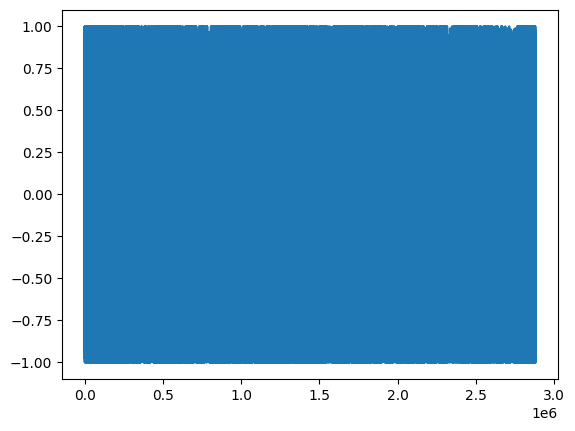

In [22]:
#print(waveform_transformed.shape, waveform_transformed.min(), waveform_transformed.max())
#plt.plot(waveform_transformed[0,:].numpy())
print(waveform.shape, waveform.min(), waveform.max())
plt.plot(waveform[0,:].numpy())

In [23]:
'''
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
tensor_transfomed = transform(spec_db)
print(tensor_transfomed.shape)
'''

'\ntransform = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.ToTensor()\n])\ntensor_transfomed = transform(spec_db)\nprint(tensor_transfomed.shape)\n'

### 音声のパスのリストを取得

In [24]:
def get_fold_path_lists(root_path, phase='train'):
    fold_path_lists = []
    for i in range(10):
        wild_card_path = os.path.join(root_path, str(i), phase, '**/*.wav')
        #print(wild_card_path)
        path_list = glob.glob(wild_card_path)
        #print(len(path_list))
        fold_path_lists.append(path_list)
    
    return fold_path_lists
        

import random
        

root_path = './data/Motor_sound/k_fold_motor'
fold_train_lists = get_fold_path_lists(root_path, phase='train')
fold_test_lists = get_fold_path_lists(root_path, phase='test')

'''
for i in range(10):
    random.shuffle(fold_train_lists[i])
    print(len(fold_train_lists[i]))
    random.shuffle(fold_test_lists[i])
    print(len(fold_test_lists[i]))
'''

'\nfor i in range(10):\n    random.shuffle(fold_train_lists[i])\n    print(len(fold_train_lists[i]))\n    random.shuffle(fold_test_lists[i])\n    print(len(fold_test_lists[i]))\n'

### Dataset

In [25]:
class MotorDataset(Dataset):
    def __init__(self, wav_path_list, transform=None, phase="train"):
        self.wav_path_list = wav_path_list
        self.transform = transform
        self.phase = phase
        
        #---メルスペクトログラムを計算しデータとラベルを準備--------------------
        
        self.data = [] # スペクトログラム計算後のテンソルデータを格納する
        self.labels = [] # ラベルを格納する
        for wav_path in self.wav_path_list:
            waveform, sample_rate = torchaudio.load(filepath=wav_path)
            # 60 秒間切り出しておく
            waveform = waveform[:, 0 : sample_rate * 60]
            
            #-----

            # Melspectrogram の設定
            sample_rate=sample_rate
            n_mels = 224 #128
            n_fft = 2150 #2048
            win_length = None
            hop_length = n_fft//2 #4
            window_fn = torch.hann_window

            # Melspectrogram の計算
            spectrogram = T.MelSpectrogram(
                sample_rate=sample_rate,
                n_fft=n_fft,
                n_mels=n_mels,
                win_length=win_length,
                hop_length=hop_length,
                window_fn=window_fn,
                power=2.0,
            )
            spec = spectrogram(waveform)
            
            # ランダムに10枚切り出し
            transform = transforms.TenCrop(size=(224, 224))
            spec_list = transform(spec)
            #print(len(spec_list))
            
            #spec_db_list = []
            for i in range(10):
                #print(i)
                # 縦軸をデシベルに変換
                # 出力は ndarray : (H,W)  (224, 224)
                spec_db = librosa.power_to_db(spec_list[i][0])#spec[0])
                # データの取得
                self.data.append(spec_db)
               
                # labelの取得
                # フォルダ名から抽出 normal:0, abnormal:1
                label_names = ["normal", "abnormal"]
                if i==0:
                    for j, name in enumerate(label_names):
                        if name in wav_path:
                            label = j
                            #print(name)
                #print(label)
                #print(wav_path)
                self.labels.append(label)
                #print(label)
                #print(i)
            #print("---------------")
        print(len(self.data), len(self.labels))
        
        #-----------------------------------------------------------------
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # numpyの(H,W) を (H,W,C)  (40, 938, 1) に変換
        data = self.data[index]
        data = self.min_max(data)
        data = data[:, :, np.newaxis] # 次元の追加
        data_transformed = self.transform(data) # (H,W,C) →　(C,H,W)
        #max_pixel = data_transformed.max
        #min_pixel = data_transformed.min
        #data_transformed = (data_transformed-min_pixel)/(max_pixel-min_pixel)
        return data_transformed, self.labels[index]
    
    # min-max normalization
    def min_max(self, data):
        min = data.min(axis=None, keepdims=True)
        max = data.max(axis=None, keepdims=True)
        data_normalized = (data-min)/(max-min)
        return data_normalized
            
   
        

In [26]:
#len(fold_train_lists[0])
_transforms = transforms.ToTensor()
data = MotorDataset(fold_train_lists[0], transform=_transforms, phase="train")
data_test = MotorDataset(fold_test_lists[0], transform=_transforms, phase="train")

batch_size=8
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False)
#print(len(data_test.labels))
print(len(dataloader.dataset))
print(len(dataloader_test.dataset))
#random.shuffle(data.labels)
#data.labels

1090 1090
130 130
1090
130


### Dataloader

In [27]:
import torchvision.models as models
from torchvision.models import resnet34,resnet50,alexnet,vgg16,densenet161,mobilenet_v2
def load_model():
    
    # Resnet34
    resnet34_model = resnet34(pretrained=True)
    #resnet50 = resnet50(pretrained=True)
    # 最初の畳み込みのチャネル3をチャネル1に変更する
    resnet34_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # 最後の層の次元を今回のカテゴリ数に変更する
    resnet34_model.fc = nn.Linear(512,2)
    
    # Resnet50
    resnet50_model = resnet50(pretrained=True)
    resnet50_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resnet50_model.fc = nn.Linear(2048,2)
    
    # Alexnet
    alexnet_model = alexnet(pretrained=True)
    alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    alexnet_model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
    
    # VGG16
    vgg16_model = vgg16(pretrained=True)
    vgg16_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
    
    
    # densenet161
    densenet161_model = densenet161(pretrained=True)
    densenet161_model.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    densenet161_model.classifier = nn.Linear(in_features=2208, out_features=2, bias=True)
    
    # MobileNet
    mobilenet_model = mobilenet_v2(pretrained=True)
    mobilenet_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    mobilenet_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
    
    models = {
        "resnet34": resnet34_model,
        "resnet50": resnet50_model,
        "Alexnet": alexnet_model,
        "VGG16": vgg16_model,
        "densenet": densenet161_model,
        "MobileNet": mobilenet_model   
    }
    
    return models

def trial_model(trial):
   
    resnet34_model = load_model()["resnet34"]
    resnet50_model = load_model()["resnet50"]
    alexnet_model = load_model()["Alexnet"]
    vgg16_model = load_model()["VGG16"]
    densenet161_model = load_model()["densenet"]
    mobilenet_model = load_model()["MobileNet"]
    
    
    model_names = ['resnet34']#, 'resnet50', 'Alexnet', 'VGG16'] #, 'densenet', 'MobileNet']
    model = trial.suggest_categorical('model', model_names)
    
    if model == model_names[0]:
        model = resnet34_model
    elif model == model_names[1]:
        model = resnet50_model
    elif model == model_names[2]:
        model = alexnet_model
    elif model == model_names[3]:
        model = vgg16_model
    elif model == model_names[4]:
        model = densenet161_model
    elif model == model_names[5]:
        model = mobilenet_model
        
    return model

# 最適化手法の試行
def trial_optimizer(trial, model):
    optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log=True)

    if optimizer_name == optimizer_names[0]:
        
        adam_lr = trial.suggest_float('adam_lr', 1e-5, 1e-2, log=True)
        optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
    elif optimizer_name == optimizer_names[1]:
        momentum_sgd_lr = trial.suggest_float('momentum_sgd_lr', 1e-5, 1e-2, log=True)
        optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters())
        
    return optimizer
    

### Optuma ハイパーパラメータ探索

In [28]:
def train(device, model, train_dataloader, optimizer, criterion, num_epochs) -> None:
    model.train()
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        
        epoch_loss = 0.0
        epoch_acc = 0.0

        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = torch.argmax(outputs, dim=1)
            loss.backward()
            optimizer.step()
            
            #print("pred",pred)
            #print("labels",labels)
            #print("outputs", outputs)
            #print(loss)
            
            # 損失と正答率 × batch数
            epoch_loss += loss.item()
            epoch_acc += torch.mean(pred.eq(labels).float()) # .eq はboolを返すためfloat()で数値に変換
        print(epoch_loss)
        #print(epoch_acc)
        print(len(train_dataloader))
        
        # batch数で割る
        epoch_loss /= len(train_dataloader)
        epoch_acc /= len(train_dataloader)

        epoch_acc = epoch_acc.cpu()
        #print(epoch_acc)

        print("{} Loss: {:.4f}, {} accuracy: {:.4f}".format("train", epoch_loss, "train", epoch_acc))


In [29]:
def test(device, model, test_dataloader):
    model.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            corrects += torch.sum(preds==labels.data)
            
            #print("preds",preds)
            #print("labels", labels)
    
    print(corrects, len(test_dataloader.dataset))
    accuracy = (corrects / len(test_dataloader.dataset)).item()
    print("test accuracy : {}".format(accuracy))
    return accuracy

In [30]:
def objective(trial):
    
    # params ---------------------------------------------------------
    fold_accs = [] # 各foldのaccを格納するリスト
    batch_size = 4 # バッチサイズ
    n_splits = 10
    kf = KFold(n_splits, shuffle=True) # n_fold の指定
    num_epochs = 50 # 学習エポック数
    device = "cuda:0" if torch.cuda.is_available() else "cpu" # device の指定
    _transforms = transforms.ToTensor() # (H,W,C) → (C,H,W) の [0.0, 1.0] 
    n_folds = 10
    
    
    train_dataloader_list = []
    test_dataloader_list = []
    for j in range(n_folds):
        #dataset
        train_dataset = MotorDataset(fold_train_lists[j], transform=_transforms, phase="train")
        test_dataset = MotorDataset(fold_test_lists[j], transform=_transforms, phase="test")
        
        # dataloader
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        train_dataloader_list.append(train_dataloader)
        test_dataloader_list.append(test_dataloader)
    #------------------------------------------------------------------
    
    
    for i in range(n_folds):
        print("{}/{} fold Start!!-----------------------------------------------------------------------------------------------------------------".format(i+1, n_folds))
        #dataset
        #train_dataset = MotorDataset(fold_train_lists[i], transform=_transforms, phase="train")
        #test_dataset = MotorDataset(fold_test_lists[i], transform=_transforms, phase="test")
        #print(len(train_dataset.data), len(test_dataset.data))
        
        # dataloader
        #train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        #test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        print("train samples: ", len(train_dataloader_list[i].dataset), "test samples: ", len(test_dataloader_list[i].dataset))
        
        model = trial_model(trial).to(device) # optuna モデル
        optimizer = trial_optimizer(trial, model) # optuna 最適化
        criterion = nn.CrossEntropyLoss() # 損失関数
        # Train model
        train(device, model, train_dataloader_list[i], optimizer, criterion, num_epochs)
        
        # Test model
        accuracy = test(device, model, test_dataloader_list[i])
        fold_accs.append(accuracy)

        #print(len(train_dataloader), len(test_dataloader))
    # 各fold の accuracy の算出
    mean_accuracy = statistics.mean(fold_accs)
    return mean_accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2023-01-05 08:12:44,316] A new study created in memory with name: no-name-ed5a9316-4d10-45b4-8936-c81b9e67ffa6


1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.20it/s]


299.4494912326336
273
train Loss: 1.0969, train accuracy: 0.5623
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.32it/s]


189.59037417173386
273
train Loss: 0.6945, train accuracy: 0.6026
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.31it/s]


185.70631903409958
273
train Loss: 0.6802, train accuracy: 0.6053
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


184.7388456761837
273
train Loss: 0.6767, train accuracy: 0.6163
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


179.7535338997841
273
train Loss: 0.6584, train accuracy: 0.6053
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.41it/s]


185.9917506519705
273
train Loss: 0.6813, train accuracy: 0.6310
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.46it/s]


186.31570726633072
273
train Loss: 0.6825, train accuracy: 0.5916
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.98it/s]


185.9690214395523
273
train Loss: 0.6812, train accuracy: 0.6007
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.81it/s]


186.97504153847694
273
train Loss: 0.6849, train accuracy: 0.5989
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.19it/s]


188.91430190205574
273
train Loss: 0.6920, train accuracy: 0.5897
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.76it/s]


184.97856050729752
273
train Loss: 0.6776, train accuracy: 0.5934
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.23it/s]


185.61438351869583
273
train Loss: 0.6799, train accuracy: 0.5870
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.57it/s]


174.85308730602264
273
train Loss: 0.6405, train accuracy: 0.6282
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.63it/s]


187.30891582369804
273
train Loss: 0.6861, train accuracy: 0.5870
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


184.321845382452
273
train Loss: 0.6752, train accuracy: 0.6007
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.73it/s]


183.27540937066078
273
train Loss: 0.6713, train accuracy: 0.6062
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.93it/s]


177.62264849245548
273
train Loss: 0.6506, train accuracy: 0.6081
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.77it/s]


173.18037116527557
273
train Loss: 0.6344, train accuracy: 0.6273
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.07it/s]


172.073489934206
273
train Loss: 0.6303, train accuracy: 0.6502
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.88it/s]


167.78859120607376
273
train Loss: 0.6146, train accuracy: 0.6593
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


160.9057565331459
273
train Loss: 0.5894, train accuracy: 0.6859
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.92it/s]


156.19433097541332
273
train Loss: 0.5721, train accuracy: 0.6978
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.68it/s]


149.812551766634
273
train Loss: 0.5488, train accuracy: 0.7399
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


138.77175451815128
273
train Loss: 0.5083, train accuracy: 0.7601
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.32it/s]


114.6955610960722
273
train Loss: 0.4201, train accuracy: 0.8159
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


106.13404618389904
273
train Loss: 0.3888, train accuracy: 0.8379
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


83.85133305750787
273
train Loss: 0.3071, train accuracy: 0.8846
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.45it/s]


76.03876913059503
273
train Loss: 0.2785, train accuracy: 0.8901
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.49it/s]


68.68958964198828
273
train Loss: 0.2516, train accuracy: 0.9029
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.10it/s]


57.610924733337015
273
train Loss: 0.2110, train accuracy: 0.9203
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.07it/s]


55.32736258208752
273
train Loss: 0.2027, train accuracy: 0.9313
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.74it/s]


40.908977750339545
273
train Loss: 0.1498, train accuracy: 0.9469
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


36.22238877537893
273
train Loss: 0.1327, train accuracy: 0.9533
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.11it/s]


35.155566014756914
273
train Loss: 0.1288, train accuracy: 0.9533
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.54it/s]


30.89665722483187
273
train Loss: 0.1132, train accuracy: 0.9643
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.40it/s]


23.167275541636627
273
train Loss: 0.0849, train accuracy: 0.9725
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.39it/s]


23.396115540876053
273
train Loss: 0.0857, train accuracy: 0.9771
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.80it/s]


24.409017516867607
273
train Loss: 0.0894, train accuracy: 0.9762
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


37.20483508759389
273
train Loss: 0.1363, train accuracy: 0.9689
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


5.288496806515468
273
train Loss: 0.0194, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


28.184281469104462
273
train Loss: 0.1032, train accuracy: 0.9744
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


20.02885759563651
273
train Loss: 0.0734, train accuracy: 0.9826
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


12.403639349617151
273
train Loss: 0.0454, train accuracy: 0.9890
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


16.74077833954061
273
train Loss: 0.0613, train accuracy: 0.9789
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


23.641406093065598
273
train Loss: 0.0866, train accuracy: 0.9762
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.69it/s]


20.22448559728946
273
train Loss: 0.0741, train accuracy: 0.9799
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.10it/s]


24.470664306328672
273
train Loss: 0.0896, train accuracy: 0.9744
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.55it/s]


23.433262522885343
273
train Loss: 0.0858, train accuracy: 0.9799
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.37it/s]


16.845866794767062
273
train Loss: 0.0617, train accuracy: 0.9799
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.32it/s]


22.00431808808935
273
train Loss: 0.0806, train accuracy: 0.9744
tensor(69, device='cuda:0') 130
test accuracy : 0.5307692289352417
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.04it/s]


315.3318228274584
273
train Loss: 1.1551, train accuracy: 0.5586
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


188.3722178041935
273
train Loss: 0.6900, train accuracy: 0.5870
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.79it/s]


192.37307849526405
273
train Loss: 0.7047, train accuracy: 0.6099
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.28it/s]


188.53804710507393
273
train Loss: 0.6906, train accuracy: 0.5861
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


188.35728731751442
273
train Loss: 0.6900, train accuracy: 0.5934
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.28it/s]


186.34920769929886
273
train Loss: 0.6826, train accuracy: 0.5971
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.97it/s]


186.55997243523598
273
train Loss: 0.6834, train accuracy: 0.5897
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.02it/s]


183.70809867978096
273
train Loss: 0.6729, train accuracy: 0.6081
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


183.3950043618679
273
train Loss: 0.6718, train accuracy: 0.5989
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


186.17774100601673
273
train Loss: 0.6820, train accuracy: 0.5824
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


185.47513881325722
273
train Loss: 0.6794, train accuracy: 0.5925
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.64it/s]


181.78522363305092
273
train Loss: 0.6659, train accuracy: 0.6154
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


181.67449486255646
273
train Loss: 0.6655, train accuracy: 0.6200
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.37it/s]


183.14599104225636
273
train Loss: 0.6709, train accuracy: 0.6172
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


174.0234408378601
273
train Loss: 0.6374, train accuracy: 0.6575
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


170.0699853003025
273
train Loss: 0.6230, train accuracy: 0.6676
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.33it/s]


168.00572383403778
273
train Loss: 0.6154, train accuracy: 0.6758
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


164.5233617722988
273
train Loss: 0.6026, train accuracy: 0.6722
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.99it/s]


159.05716580152512
273
train Loss: 0.5826, train accuracy: 0.6978
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


131.81067142635584
273
train Loss: 0.4828, train accuracy: 0.7793
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.14it/s]


119.77234574407339
273
train Loss: 0.4387, train accuracy: 0.8004
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.28it/s]


105.88224518671632
273
train Loss: 0.3878, train accuracy: 0.8370
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.28it/s]


89.32949646189809
273
train Loss: 0.3272, train accuracy: 0.8654
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


79.06628363253549
273
train Loss: 0.2896, train accuracy: 0.8910
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


61.30612289858982
273
train Loss: 0.2246, train accuracy: 0.9158
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


49.62659034039825
273
train Loss: 0.1818, train accuracy: 0.9350
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


46.06311103864573
273
train Loss: 0.1687, train accuracy: 0.9332
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


32.48607991133031
273
train Loss: 0.1190, train accuracy: 0.9625
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.41it/s]


37.00311876700653
273
train Loss: 0.1355, train accuracy: 0.9551
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.39it/s]


33.54405466769822
273
train Loss: 0.1229, train accuracy: 0.9597
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.01it/s]


24.256353904260322
273
train Loss: 0.0889, train accuracy: 0.9670
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.75it/s]


25.37287441577064
273
train Loss: 0.0929, train accuracy: 0.9625
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


10.047505636233836
273
train Loss: 0.0368, train accuracy: 0.9890
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.96it/s]


20.522633147375018
273
train Loss: 0.0752, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.29it/s]


17.977367093175417
273
train Loss: 0.0659, train accuracy: 0.9789
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.98it/s]


13.150985898126237
273
train Loss: 0.0482, train accuracy: 0.9844
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.58it/s]


26.602444541341356
273
train Loss: 0.0974, train accuracy: 0.9689
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.53it/s]


15.674805467664555
273
train Loss: 0.0574, train accuracy: 0.9835
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.64it/s]


17.07057037371851
273
train Loss: 0.0625, train accuracy: 0.9780
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


22.653590257526957
273
train Loss: 0.0830, train accuracy: 0.9716
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


0.6266614895827161
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.97it/s]


0.060183943006357765
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


33.01141782181037
273
train Loss: 0.1209, train accuracy: 0.9725
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


9.383083831448857
273
train Loss: 0.0344, train accuracy: 0.9881
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.57it/s]


11.886111790729956
273
train Loss: 0.0435, train accuracy: 0.9853
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.58it/s]


12.032397008630028
273
train Loss: 0.0441, train accuracy: 0.9853
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.76it/s]


14.630607796022446
273
train Loss: 0.0536, train accuracy: 0.9853
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.25it/s]


12.870051291700292
273
train Loss: 0.0471, train accuracy: 0.9863
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.83it/s]


4.688939232886696
273
train Loss: 0.0172, train accuracy: 0.9945
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.15it/s]


0.08395472625466027
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


352.5878875528615
273
train Loss: 1.2915, train accuracy: 0.5467
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.30it/s]


189.89442825317383
273
train Loss: 0.6956, train accuracy: 0.5833
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.48it/s]


190.58126967446879
273
train Loss: 0.6981, train accuracy: 0.6026
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.19it/s]


186.23562887310982
273
train Loss: 0.6822, train accuracy: 0.5971
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.74it/s]


185.57398575544357
273
train Loss: 0.6798, train accuracy: 0.5879
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 68.02it/s]


183.34072387218475
273
train Loss: 0.6716, train accuracy: 0.5934
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.15it/s]


176.9682798087597
273
train Loss: 0.6482, train accuracy: 0.6209
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.19it/s]


166.3222019225359
273
train Loss: 0.6092, train accuracy: 0.6703
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.73it/s]


156.77315793931484
273
train Loss: 0.5743, train accuracy: 0.6960
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.22it/s]


156.58245111256838
273
train Loss: 0.5736, train accuracy: 0.7280
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.63it/s]


128.76997369527817
273
train Loss: 0.4717, train accuracy: 0.7802
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.42it/s]


121.36970067024231
273
train Loss: 0.4446, train accuracy: 0.7949
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


124.32017590850592
273
train Loss: 0.4554, train accuracy: 0.7912
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.48it/s]


116.7769501581788
273
train Loss: 0.4278, train accuracy: 0.8040
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


117.44014981016517
273
train Loss: 0.4302, train accuracy: 0.8095
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


97.0913159660995
273
train Loss: 0.3556, train accuracy: 0.8452
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.34it/s]


90.55050638597459
273
train Loss: 0.3317, train accuracy: 0.8571
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.49it/s]


84.66148585779592
273
train Loss: 0.3101, train accuracy: 0.8709
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


85.43195856874809
273
train Loss: 0.3129, train accuracy: 0.8690
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.41it/s]


69.28837429685518
273
train Loss: 0.2538, train accuracy: 0.8956
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


65.03342319349758
273
train Loss: 0.2382, train accuracy: 0.9066
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.61it/s]


59.440939877182245
273
train Loss: 0.2177, train accuracy: 0.9093
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.63it/s]


56.46844684757525
273
train Loss: 0.2068, train accuracy: 0.9231
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.72it/s]


55.13503414466686
273
train Loss: 0.2020, train accuracy: 0.9267
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.59it/s]


41.59896683925763
273
train Loss: 0.1524, train accuracy: 0.9432
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.05it/s]


32.90748799381254
273
train Loss: 0.1205, train accuracy: 0.9505
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.02it/s]


24.51061034714803
273
train Loss: 0.0898, train accuracy: 0.9698
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.66it/s]


31.527285202657367
273
train Loss: 0.1155, train accuracy: 0.9542
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.56it/s]


16.810552197503966
273
train Loss: 0.0616, train accuracy: 0.9808
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.90it/s]


33.09857116704734
273
train Loss: 0.1212, train accuracy: 0.9615
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.49it/s]


18.25919131332921
273
train Loss: 0.0669, train accuracy: 0.9817
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.47it/s]


16.944128179358813
273
train Loss: 0.0621, train accuracy: 0.9817
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.69it/s]


19.088413617726474
273
train Loss: 0.0699, train accuracy: 0.9725
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.94it/s]


11.859600684993893
273
train Loss: 0.0434, train accuracy: 0.9835
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


20.127099565235767
273
train Loss: 0.0737, train accuracy: 0.9808
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.30it/s]


16.453847766318745
273
train Loss: 0.0603, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


13.21300813539483
273
train Loss: 0.0484, train accuracy: 0.9863
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


18.925606102201982
273
train Loss: 0.0693, train accuracy: 0.9744
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.83it/s]


12.816951983630133
273
train Loss: 0.0469, train accuracy: 0.9826
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.14it/s]


9.288719477823406
273
train Loss: 0.0340, train accuracy: 0.9918
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.78it/s]


22.24999811976545
273
train Loss: 0.0815, train accuracy: 0.9725
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.07it/s]


6.41239463240538
273
train Loss: 0.0235, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


20.531808532654818
273
train Loss: 0.0752, train accuracy: 0.9744
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.39it/s]


8.377709771207604
273
train Loss: 0.0307, train accuracy: 0.9899
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


4.409334389046531
273
train Loss: 0.0162, train accuracy: 0.9936
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


0.10445514821386581
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


24.893374995614877
273
train Loss: 0.0912, train accuracy: 0.9789
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.52it/s]


0.8876849069291364
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.30it/s]


18.976336118084262
273
train Loss: 0.0695, train accuracy: 0.9826
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


6.037957008434589
273
train Loss: 0.0221, train accuracy: 0.9936
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


465.95505019727034
273
train Loss: 1.7068, train accuracy: 0.5357
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.74it/s]


193.92422887682915
273
train Loss: 0.7103, train accuracy: 0.5833
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.18it/s]


184.0103589296341
273
train Loss: 0.6740, train accuracy: 0.6026
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.55it/s]


188.75840628685546
273
train Loss: 0.6914, train accuracy: 0.5943
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


187.9761603474617
273
train Loss: 0.6886, train accuracy: 0.5962
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.88it/s]


185.74960958957672
273
train Loss: 0.6804, train accuracy: 0.5943
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


187.70526590943336
273
train Loss: 0.6876, train accuracy: 0.5925
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


191.3486111164093
273
train Loss: 0.7009, train accuracy: 0.5925
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.26it/s]


186.5917501449585
273
train Loss: 0.6835, train accuracy: 0.5907
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


178.95679569244385
273
train Loss: 0.6555, train accuracy: 0.6044
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


181.98041689395905
273
train Loss: 0.6666, train accuracy: 0.5769
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.49it/s]


176.22702997922897
273
train Loss: 0.6455, train accuracy: 0.6401
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.92it/s]


179.05849373340607
273
train Loss: 0.6559, train accuracy: 0.6126
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.74it/s]


183.07249066233635
273
train Loss: 0.6706, train accuracy: 0.5925
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.98it/s]


178.29059332609177
273
train Loss: 0.6531, train accuracy: 0.6236
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.32it/s]


170.20590937137604
273
train Loss: 0.6235, train accuracy: 0.6548
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.67it/s]


158.81546698510647
273
train Loss: 0.5817, train accuracy: 0.6932
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.90it/s]


142.01819349825382
273
train Loss: 0.5202, train accuracy: 0.7573
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


130.58314988017082
273
train Loss: 0.4783, train accuracy: 0.7912
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.26it/s]


116.13853506743908
273
train Loss: 0.4254, train accuracy: 0.8141
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.65it/s]


97.75731058046222
273
train Loss: 0.3581, train accuracy: 0.8535
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.80it/s]


80.92349532805383
273
train Loss: 0.2964, train accuracy: 0.8837
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


68.57165225967765
273
train Loss: 0.2512, train accuracy: 0.9038
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


62.89218673296273
273
train Loss: 0.2304, train accuracy: 0.9130
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


54.39098820835352
273
train Loss: 0.1992, train accuracy: 0.9286
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


23.42118513386231
273
train Loss: 0.0858, train accuracy: 0.9689
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


45.84036191611085
273
train Loss: 0.1679, train accuracy: 0.9432
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


21.140986068116035
273
train Loss: 0.0774, train accuracy: 0.9780
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


65.99342525227257
273
train Loss: 0.2417, train accuracy: 0.9130
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.54it/s]


22.17670242197346
273
train Loss: 0.0812, train accuracy: 0.9634
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


45.22709384272457
273
train Loss: 0.1657, train accuracy: 0.9341
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.26it/s]


22.639703854554682
273
train Loss: 0.0829, train accuracy: 0.9744
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.25it/s]


19.16787023742654
273
train Loss: 0.0702, train accuracy: 0.9762
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.26it/s]


13.199688863609481
273
train Loss: 0.0484, train accuracy: 0.9863
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.51it/s]


19.686056714569986
273
train Loss: 0.0721, train accuracy: 0.9771
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.70it/s]


49.87272737740841
273
train Loss: 0.1827, train accuracy: 0.9332
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.88it/s]


31.979092191708332
273
train Loss: 0.1171, train accuracy: 0.9597
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


21.531209071555743
273
train Loss: 0.0789, train accuracy: 0.9908
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.53it/s]


27.452606770610146
273
train Loss: 0.1006, train accuracy: 0.9670
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.01it/s]


13.666118055492007
273
train Loss: 0.0501, train accuracy: 0.9881
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.44it/s]


8.792630557449229
273
train Loss: 0.0322, train accuracy: 0.9918
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.63it/s]


19.02430209337024
273
train Loss: 0.0697, train accuracy: 0.9808
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.53it/s]


0.2666558546646911
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.47it/s]


25.317336628896044
273
train Loss: 0.0927, train accuracy: 0.9789
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.11it/s]


17.34874082247552
273
train Loss: 0.0635, train accuracy: 0.9835
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.49it/s]


11.459250890220574
273
train Loss: 0.0420, train accuracy: 0.9899
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


12.508635565231089
273
train Loss: 0.0458, train accuracy: 0.9872
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.39it/s]


12.76400095466488
273
train Loss: 0.0468, train accuracy: 0.9844
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


0.2397986458822743
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.88it/s]


0.016768368436487435
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


289.91483099758625
273
train Loss: 1.0620, train accuracy: 0.5696
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.99it/s]


185.13530537486076
273
train Loss: 0.6782, train accuracy: 0.6062
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.69it/s]


191.38459968566895
273
train Loss: 0.7010, train accuracy: 0.5824
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.76it/s]


184.06120896339417
273
train Loss: 0.6742, train accuracy: 0.6035
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.95it/s]


175.9940609037876
273
train Loss: 0.6447, train accuracy: 0.6639
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.35it/s]


185.96186953783035
273
train Loss: 0.6812, train accuracy: 0.5998
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


181.16602751612663
273
train Loss: 0.6636, train accuracy: 0.6062
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.50it/s]


174.0107128471136
273
train Loss: 0.6374, train accuracy: 0.6493
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.35it/s]


178.86132054030895
273
train Loss: 0.6552, train accuracy: 0.6575
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.26it/s]


161.63830883800983
273
train Loss: 0.5921, train accuracy: 0.6767
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


163.21530516445637
273
train Loss: 0.5979, train accuracy: 0.6941
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


151.24655723571777
273
train Loss: 0.5540, train accuracy: 0.7143
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


150.22909016907215
273
train Loss: 0.5503, train accuracy: 0.7271
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.55it/s]


146.12990298867226
273
train Loss: 0.5353, train accuracy: 0.7408
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


131.56139890104532
273
train Loss: 0.4819, train accuracy: 0.7811
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.03it/s]


109.8311884701252
273
train Loss: 0.4023, train accuracy: 0.8214
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.08it/s]


89.78353875968605
273
train Loss: 0.3289, train accuracy: 0.8617
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.41it/s]


67.36809136345983
273
train Loss: 0.2468, train accuracy: 0.9038
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


52.08011677511968
273
train Loss: 0.1908, train accuracy: 0.9396
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


39.70563051814679
273
train Loss: 0.1454, train accuracy: 0.9478
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


43.01963161211461
273
train Loss: 0.1576, train accuracy: 0.9441
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.58it/s]


22.09087833610829
273
train Loss: 0.0809, train accuracy: 0.9698
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


30.20298516414914
273
train Loss: 0.1106, train accuracy: 0.9670
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.15it/s]


23.083419484228216
273
train Loss: 0.0846, train accuracy: 0.9734
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.40it/s]


24.529751148998912
273
train Loss: 0.0899, train accuracy: 0.9689
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


12.710972746637708
273
train Loss: 0.0466, train accuracy: 0.9853
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


20.956396880734246
273
train Loss: 0.0768, train accuracy: 0.9771
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


27.680067203207273
273
train Loss: 0.1014, train accuracy: 0.9725
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


11.802637353866885
273
train Loss: 0.0432, train accuracy: 0.9881
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


5.300465093127514
273
train Loss: 0.0194, train accuracy: 0.9918
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


31.416788908481408
273
train Loss: 0.1151, train accuracy: 0.9753
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.51it/s]


13.948426359649602
273
train Loss: 0.0511, train accuracy: 0.9799
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


23.6964191832285
273
train Loss: 0.0868, train accuracy: 0.9780
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.43it/s]


2.417198281356832
273
train Loss: 0.0089, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.15it/s]


20.855235498478578
273
train Loss: 0.0764, train accuracy: 0.9817
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.27it/s]


23.84137281976291
273
train Loss: 0.0873, train accuracy: 0.9698
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


11.188199673692225
273
train Loss: 0.0410, train accuracy: 0.9890
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


6.326157894851804
273
train Loss: 0.0232, train accuracy: 0.9945
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


0.07438707543923329
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


25.29433038772285
273
train Loss: 0.0927, train accuracy: 0.9771
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


0.3560178264072533
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.10it/s]


30.076801522756824
273
train Loss: 0.1102, train accuracy: 0.9762
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


5.149554295164307
273
train Loss: 0.0189, train accuracy: 0.9927
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


10.710810590893288
273
train Loss: 0.0392, train accuracy: 0.9853
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.69it/s]


9.212368880784567
273
train Loss: 0.0337, train accuracy: 0.9927
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.45it/s]


18.37157866974239
273
train Loss: 0.0673, train accuracy: 0.9808
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.63it/s]


0.3568195179832401
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


16.455094924116565
273
train Loss: 0.0603, train accuracy: 0.9817
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.03it/s]


0.4013059446601801
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


0.05626983459568535
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


373.3990284986794
273
train Loss: 1.3678, train accuracy: 0.5495
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


202.30038008093834
273
train Loss: 0.7410, train accuracy: 0.6117
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


194.52443662285805
273
train Loss: 0.7125, train accuracy: 0.6007
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


192.32910758256912
273
train Loss: 0.7045, train accuracy: 0.6016
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.59it/s]


187.28606948256493
273
train Loss: 0.6860, train accuracy: 0.5925
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.12it/s]


187.31546226143837
273
train Loss: 0.6861, train accuracy: 0.5943
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.08it/s]


186.77375188469887
273
train Loss: 0.6842, train accuracy: 0.5952
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.74it/s]


179.92338232696056
273
train Loss: 0.6591, train accuracy: 0.6273
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


180.39335057139397
273
train Loss: 0.6608, train accuracy: 0.6062
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


168.87472113966942
273
train Loss: 0.6186, train accuracy: 0.6676
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


167.82253423333168
273
train Loss: 0.6147, train accuracy: 0.6584
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


159.70200642943382
273
train Loss: 0.5850, train accuracy: 0.7097
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.55it/s]


158.62550362944603
273
train Loss: 0.5810, train accuracy: 0.6941
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


146.1255562454462
273
train Loss: 0.5353, train accuracy: 0.7170
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


134.55447494983673
273
train Loss: 0.4929, train accuracy: 0.7674
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.45it/s]


124.52142943441868
273
train Loss: 0.4561, train accuracy: 0.8086
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


112.72304499521852
273
train Loss: 0.4129, train accuracy: 0.8086
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.89it/s]


117.60061198472977
273
train Loss: 0.4308, train accuracy: 0.8095
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


102.8458103723824
273
train Loss: 0.3767, train accuracy: 0.8379
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


102.66428662464023
273
train Loss: 0.3761, train accuracy: 0.8278
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


90.35939651913941
273
train Loss: 0.3310, train accuracy: 0.8562
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


79.7958707776852
273
train Loss: 0.2923, train accuracy: 0.8764
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


90.25911471247673
273
train Loss: 0.3306, train accuracy: 0.8571
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


83.26772770052776
273
train Loss: 0.3050, train accuracy: 0.8773
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


56.90046871767845
273
train Loss: 0.2084, train accuracy: 0.9258
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.13it/s]


43.88768096221611
273
train Loss: 0.1608, train accuracy: 0.9505
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


46.08624703949317
273
train Loss: 0.1688, train accuracy: 0.9423
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.96it/s]


26.939982309559127
273
train Loss: 0.0987, train accuracy: 0.9570
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


27.97284834698803
273
train Loss: 0.1025, train accuracy: 0.9661
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.34it/s]


23.63781912461127
273
train Loss: 0.0866, train accuracy: 0.9716
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


16.070610671233226
273
train Loss: 0.0589, train accuracy: 0.9771
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.25it/s]


18.078810996114044
273
train Loss: 0.0662, train accuracy: 0.9835
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


22.221741511177243
273
train Loss: 0.0814, train accuracy: 0.9762
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.00it/s]


7.561781848882674
273
train Loss: 0.0277, train accuracy: 0.9899
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


18.16774225253789
273
train Loss: 0.0665, train accuracy: 0.9799
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


8.023968720758148
273
train Loss: 0.0294, train accuracy: 0.9899
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


19.479485453693936
273
train Loss: 0.0714, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


14.51429589146528
273
train Loss: 0.0532, train accuracy: 0.9844
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


10.116006030381975
273
train Loss: 0.0371, train accuracy: 0.9899
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.17it/s]


22.76492712947268
273
train Loss: 0.0834, train accuracy: 0.9808
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


13.656887023396848
273
train Loss: 0.0500, train accuracy: 0.9826
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


0.30610928621081257
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


14.157481323153547
273
train Loss: 0.0519, train accuracy: 0.9872
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.26it/s]


16.650369581643645
273
train Loss: 0.0610, train accuracy: 0.9817
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.83it/s]


14.679802180249965
273
train Loss: 0.0538, train accuracy: 0.9826
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.12it/s]


15.290708604085467
273
train Loss: 0.0560, train accuracy: 0.9863
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.57it/s]


9.507934108090922
273
train Loss: 0.0348, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.04it/s]


8.056710878573313
273
train Loss: 0.0295, train accuracy: 0.9927
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.66it/s]


0.18303372127217798
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.73it/s]


0.02286025616313303
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


432.30508200405166
273
train Loss: 1.5835, train accuracy: 0.5394
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.11it/s]


194.02548757195473
273
train Loss: 0.7107, train accuracy: 0.5751
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.55it/s]


187.16114255785942
273
train Loss: 0.6856, train accuracy: 0.5916
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.21it/s]


188.02454870939255
273
train Loss: 0.6887, train accuracy: 0.6035
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.82it/s]


188.75403353571892
273
train Loss: 0.6914, train accuracy: 0.5980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.32it/s]


186.74661526083946
273
train Loss: 0.6841, train accuracy: 0.5934
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.26it/s]


187.92130455374718
273
train Loss: 0.6884, train accuracy: 0.5888
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.92it/s]


190.33053329586983
273
train Loss: 0.6972, train accuracy: 0.6044
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.89it/s]


186.46335247159004
273
train Loss: 0.6830, train accuracy: 0.5907
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.96it/s]


181.43078246712685
273
train Loss: 0.6646, train accuracy: 0.6026
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 69.13it/s]


174.65794146060944
273
train Loss: 0.6398, train accuracy: 0.6612
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.44it/s]


180.18079337477684
273
train Loss: 0.6600, train accuracy: 0.6172
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.60it/s]


171.07476696372032
273
train Loss: 0.6266, train accuracy: 0.6520
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.22it/s]


170.46208536624908
273
train Loss: 0.6244, train accuracy: 0.6593
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.09it/s]


166.18973490595818
273
train Loss: 0.6088, train accuracy: 0.6777
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.79it/s]


169.2661244571209
273
train Loss: 0.6200, train accuracy: 0.6575
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.43it/s]


177.31914600729942
273
train Loss: 0.6495, train accuracy: 0.6236
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.53it/s]


164.92587073147297
273
train Loss: 0.6041, train accuracy: 0.6630
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.37it/s]


156.18675328791142
273
train Loss: 0.5721, train accuracy: 0.7125
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.43it/s]


137.85653179883957
273
train Loss: 0.5050, train accuracy: 0.7537
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


150.02763503789902
273
train Loss: 0.5496, train accuracy: 0.7262
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


119.01986273378134
273
train Loss: 0.4360, train accuracy: 0.7976
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


110.86497110500932
273
train Loss: 0.4061, train accuracy: 0.8141
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


102.53846617415547
273
train Loss: 0.3756, train accuracy: 0.8352
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.78it/s]


97.46063850820065
273
train Loss: 0.3570, train accuracy: 0.8416
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.41it/s]


93.97807428054512
273
train Loss: 0.3442, train accuracy: 0.8608
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


83.99485610798001
273
train Loss: 0.3077, train accuracy: 0.8773
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.43it/s]


86.47337917983532
273
train Loss: 0.3168, train accuracy: 0.8718
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


75.69411473628134
273
train Loss: 0.2773, train accuracy: 0.8892
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.98it/s]


76.88407470472157
273
train Loss: 0.2816, train accuracy: 0.9011
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


58.29123733146116
273
train Loss: 0.2135, train accuracy: 0.9185
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.00it/s]


59.30089500697795
273
train Loss: 0.2172, train accuracy: 0.9121
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


51.324902829830535
273
train Loss: 0.1880, train accuracy: 0.9341
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


43.31916351924883
273
train Loss: 0.1587, train accuracy: 0.9414
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


42.4537247344997
273
train Loss: 0.1555, train accuracy: 0.9441
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.04it/s]


37.38667377947422
273
train Loss: 0.1369, train accuracy: 0.9533
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


31.192576976787677
273
train Loss: 0.1143, train accuracy: 0.9579
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.74it/s]


26.251635845757875
273
train Loss: 0.0962, train accuracy: 0.9670
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


27.864786949403424
273
train Loss: 0.1021, train accuracy: 0.9679
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


27.327274203667912
273
train Loss: 0.1001, train accuracy: 0.9634
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


31.767182551400765
273
train Loss: 0.1164, train accuracy: 0.9652
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.63it/s]


14.068628278310825
273
train Loss: 0.0515, train accuracy: 0.9789
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


35.12695223266451
273
train Loss: 0.1287, train accuracy: 0.9615
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


20.68611692401464
273
train Loss: 0.0758, train accuracy: 0.9753
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


21.671866436127857
273
train Loss: 0.0794, train accuracy: 0.9707
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


15.42481568166113
273
train Loss: 0.0565, train accuracy: 0.9808
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


22.39175148897266
273
train Loss: 0.0820, train accuracy: 0.9734
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


14.17629291764888
273
train Loss: 0.0519, train accuracy: 0.9844
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


27.520300118179797
273
train Loss: 0.1008, train accuracy: 0.9734
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


6.68601204479603
273
train Loss: 0.0245, train accuracy: 0.9899
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


281.6762083917856
273
train Loss: 1.0318, train accuracy: 0.5797
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


185.98910492658615
273
train Loss: 0.6813, train accuracy: 0.5980
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


187.85881370306015
273
train Loss: 0.6881, train accuracy: 0.6016
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


187.90653756260872
273
train Loss: 0.6883, train accuracy: 0.5806
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


186.7131362259388
273
train Loss: 0.6839, train accuracy: 0.6108
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


189.02758729457855
273
train Loss: 0.6924, train accuracy: 0.5852
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


184.7725549340248
273
train Loss: 0.6768, train accuracy: 0.5952
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


189.45389333367348
273
train Loss: 0.6940, train accuracy: 0.6044
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


182.64674673974514
273
train Loss: 0.6690, train accuracy: 0.6245
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


172.77350188791752
273
train Loss: 0.6329, train accuracy: 0.6685
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


170.172994479537
273
train Loss: 0.6233, train accuracy: 0.6603
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


178.87208764255047
273
train Loss: 0.6552, train accuracy: 0.6484
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.29it/s]


169.2839803248644
273
train Loss: 0.6201, train accuracy: 0.6740
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.62it/s]


157.37919279932976
273
train Loss: 0.5765, train accuracy: 0.7125
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.43it/s]


149.21419329941273
273
train Loss: 0.5466, train accuracy: 0.7317
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


132.4201428592205
273
train Loss: 0.4851, train accuracy: 0.7711
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


107.02944907546043
273
train Loss: 0.3920, train accuracy: 0.8278
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


90.33053528424352
273
train Loss: 0.3309, train accuracy: 0.8672
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


64.46750268852338
273
train Loss: 0.2361, train accuracy: 0.9020
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.59it/s]


57.30422789976001
273
train Loss: 0.2099, train accuracy: 0.9185
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.86it/s]


35.631028734555
273
train Loss: 0.1305, train accuracy: 0.9551
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


33.50958405749407
273
train Loss: 0.1227, train accuracy: 0.9625
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.63it/s]


24.484176599336934
273
train Loss: 0.0897, train accuracy: 0.9707
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


30.405801419983618
273
train Loss: 0.1114, train accuracy: 0.9661
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.25it/s]


16.744952381413896
273
train Loss: 0.0613, train accuracy: 0.9771
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.17it/s]


27.61823275560164
273
train Loss: 0.1012, train accuracy: 0.9670
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


13.757917651009848
273
train Loss: 0.0504, train accuracy: 0.9844
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


28.843987366610236
273
train Loss: 0.1057, train accuracy: 0.9679
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


21.157474000796356
273
train Loss: 0.0775, train accuracy: 0.9780
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


0.33822969934089997
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


18.780163446804323
273
train Loss: 0.0688, train accuracy: 0.9881
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


21.761870468065354
273
train Loss: 0.0797, train accuracy: 0.9780
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.25it/s]


14.565035883031669
273
train Loss: 0.0534, train accuracy: 0.9872
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.57it/s]


11.228582071401888
273
train Loss: 0.0411, train accuracy: 0.9890
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


11.115835178493114
273
train Loss: 0.0407, train accuracy: 0.9844
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.64it/s]


20.590407215702385
273
train Loss: 0.0754, train accuracy: 0.9835
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.24it/s]


0.8953512522271581
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


29.101011311959553
273
train Loss: 0.1066, train accuracy: 0.9679
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.66it/s]


0.6302406120807973
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


18.095032436572183
273
train Loss: 0.0663, train accuracy: 0.9808
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.38it/s]


28.778533037126863
273
train Loss: 0.1054, train accuracy: 0.9689
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.58it/s]


0.6916516376008417
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.97it/s]


0.04333000763150352
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.80it/s]


24.509649838020422
273
train Loss: 0.0898, train accuracy: 0.9817
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.12it/s]


0.7530853931980346
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 68.03it/s]


0.06577211999797328
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.30it/s]


0.01664019870989364
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.69it/s]


24.196541930997
273
train Loss: 0.0886, train accuracy: 0.9799
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.55it/s]


1.4580371772834724
273
train Loss: 0.0053, train accuracy: 0.9991
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


12.148750494125807
273
train Loss: 0.0445, train accuracy: 0.9908
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


316.97508926689625
273
train Loss: 1.1611, train accuracy: 0.5549
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


185.27808088064194
273
train Loss: 0.6787, train accuracy: 0.5980
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


186.31048920750618
273
train Loss: 0.6825, train accuracy: 0.5934
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


187.78141191601753
273
train Loss: 0.6878, train accuracy: 0.5861
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


184.71480825543404
273
train Loss: 0.6766, train accuracy: 0.6016
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.48it/s]


183.47835864126682
273
train Loss: 0.6721, train accuracy: 0.6300
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


186.22791749238968
273
train Loss: 0.6822, train accuracy: 0.5797
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.05it/s]


184.086500197649
273
train Loss: 0.6743, train accuracy: 0.6016
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.11it/s]


176.24867649376392
273
train Loss: 0.6456, train accuracy: 0.6529
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.64it/s]


180.56401363015175
273
train Loss: 0.6614, train accuracy: 0.6355
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


174.04329812526703
273
train Loss: 0.6375, train accuracy: 0.6603
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


169.38850639760494
273
train Loss: 0.6205, train accuracy: 0.6786
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


159.18349876999855
273
train Loss: 0.5831, train accuracy: 0.7005
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


144.46660842001438
273
train Loss: 0.5292, train accuracy: 0.7546
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.64it/s]


134.01309514045715
273
train Loss: 0.4909, train accuracy: 0.7637
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.04it/s]


118.80996103957295
273
train Loss: 0.4352, train accuracy: 0.7912
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.61it/s]


92.77005723305047
273
train Loss: 0.3398, train accuracy: 0.8516
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


78.19515347201377
273
train Loss: 0.2864, train accuracy: 0.8846
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


61.44561894936487
273
train Loss: 0.2251, train accuracy: 0.9176
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.36it/s]


57.60121702658944
273
train Loss: 0.2110, train accuracy: 0.9167
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


49.33685101184528
273
train Loss: 0.1807, train accuracy: 0.9405
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.09it/s]


34.4025502653094
273
train Loss: 0.1260, train accuracy: 0.9606
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


36.43291977327317
273
train Loss: 0.1335, train accuracy: 0.9515
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.21it/s]


23.144888359849574
273
train Loss: 0.0848, train accuracy: 0.9771
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.18it/s]


25.248602132232918
273
train Loss: 0.0925, train accuracy: 0.9670
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.17it/s]


34.9940401801141
273
train Loss: 0.1282, train accuracy: 0.9661
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.41it/s]


28.315629401218757
273
train Loss: 0.1037, train accuracy: 0.9734
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


30.570048380759545
273
train Loss: 0.1120, train accuracy: 0.9698
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.22it/s]


17.718577574487426
273
train Loss: 0.0649, train accuracy: 0.9762
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


20.859900067429407
273
train Loss: 0.0764, train accuracy: 0.9771
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


6.447104278460756
273
train Loss: 0.0236, train accuracy: 0.9918
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.13it/s]


29.15937760400584
273
train Loss: 0.1068, train accuracy: 0.9725
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


14.833530946547398
273
train Loss: 0.0543, train accuracy: 0.9817
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.98it/s]


12.416093027630268
273
train Loss: 0.0455, train accuracy: 0.9853
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


17.885527669386647
273
train Loss: 0.0655, train accuracy: 0.9853
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


11.28720830288512
273
train Loss: 0.0413, train accuracy: 0.9863
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


19.98330849481681
273
train Loss: 0.0732, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


6.893446538284479
273
train Loss: 0.0253, train accuracy: 0.9927
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


0.08689695086899007
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.03it/s]


16.586736698519438
273
train Loss: 0.0608, train accuracy: 0.9899
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


15.415752034827392
273
train Loss: 0.0565, train accuracy: 0.9789
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.90it/s]


10.800165852788723
273
train Loss: 0.0396, train accuracy: 0.9881
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.29it/s]


0.15373172278663105
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


27.381937196257972
273
train Loss: 0.1003, train accuracy: 0.9799
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.71it/s]


7.592032933773112
273
train Loss: 0.0278, train accuracy: 0.9890
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


17.272219660550718
273
train Loss: 0.0633, train accuracy: 0.9844
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


5.08924071695219
273
train Loss: 0.0186, train accuracy: 0.9927
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


0.1191696022765143
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


0.028490861171196258
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


0.0018048492596154375
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.50it/s]


304.798164665699
293
train Loss: 1.0403, train accuracy: 0.5887
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.05it/s]


198.0644378066063
293
train Loss: 0.6760, train accuracy: 0.6118
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.32it/s]


204.10384526848793
293
train Loss: 0.6966, train accuracy: 0.6015
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.99it/s]


204.75063075125217
293
train Loss: 0.6988, train accuracy: 0.5981
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.37it/s]


199.57230252027512
293
train Loss: 0.6811, train accuracy: 0.6041
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.05it/s]


196.01153346896172
293
train Loss: 0.6690, train accuracy: 0.6075
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.19it/s]


192.6427507698536
293
train Loss: 0.6575, train accuracy: 0.6075
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.37it/s]


194.26898008584976
293
train Loss: 0.6630, train accuracy: 0.6007
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.52it/s]


194.60734713077545
293
train Loss: 0.6642, train accuracy: 0.5990
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.50it/s]


198.05468082427979
293
train Loss: 0.6760, train accuracy: 0.6049
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.42it/s]


186.23862452805042
293
train Loss: 0.6356, train accuracy: 0.6451
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.20it/s]


183.0314920693636
293
train Loss: 0.6247, train accuracy: 0.6442
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.71it/s]


178.98409724235535
293
train Loss: 0.6109, train accuracy: 0.6544
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.58it/s]


172.46092107892036
293
train Loss: 0.5886, train accuracy: 0.6903
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.69it/s]


159.3465009778738
293
train Loss: 0.5438, train accuracy: 0.7253
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.05it/s]


133.70454612374306
293
train Loss: 0.4563, train accuracy: 0.7935
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.70it/s]


121.98429383710027
293
train Loss: 0.4163, train accuracy: 0.8208
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.00it/s]


107.93046272918582
293
train Loss: 0.3684, train accuracy: 0.8456
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.47it/s]


96.75020400434732
293
train Loss: 0.3302, train accuracy: 0.8592
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.34it/s]


85.05158264469355
293
train Loss: 0.2903, train accuracy: 0.8805
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.60it/s]


68.94528328441083
293
train Loss: 0.2353, train accuracy: 0.9036
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.93it/s]


59.59041450324003
293
train Loss: 0.2034, train accuracy: 0.9181
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.30it/s]


51.77184991311515
293
train Loss: 0.1767, train accuracy: 0.9403
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.30it/s]


39.76779979848652
293
train Loss: 0.1357, train accuracy: 0.9531
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.71it/s]


41.26880873661139
293
train Loss: 0.1408, train accuracy: 0.9488
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.94it/s]


23.779685408946534
293
train Loss: 0.0812, train accuracy: 0.9735
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.16it/s]


42.86054769781185
293
train Loss: 0.1463, train accuracy: 0.9454
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.02it/s]


27.275866327807307
293
train Loss: 0.0931, train accuracy: 0.9718
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.40it/s]


29.619116540616233
293
train Loss: 0.1011, train accuracy: 0.9701
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.53it/s]


21.139105377824308
293
train Loss: 0.0721, train accuracy: 0.9753
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.97it/s]


24.604242008001165
293
train Loss: 0.0840, train accuracy: 0.9710
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.24it/s]


24.170304315701287
293
train Loss: 0.0825, train accuracy: 0.9701
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.47it/s]


15.718112922475484
293
train Loss: 0.0536, train accuracy: 0.9846
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.64it/s]


16.66146646121433
293
train Loss: 0.0569, train accuracy: 0.9812
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.55it/s]


18.14316104149566
293
train Loss: 0.0619, train accuracy: 0.9804
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.28it/s]


19.155896926695277
293
train Loss: 0.0654, train accuracy: 0.9761
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.36it/s]


13.841902945188394
293
train Loss: 0.0472, train accuracy: 0.9855
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.91it/s]


18.731670259418024
293
train Loss: 0.0639, train accuracy: 0.9855
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.41it/s]


5.9298867362686
293
train Loss: 0.0202, train accuracy: 0.9932
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.14it/s]


14.152844841243564
293
train Loss: 0.0483, train accuracy: 0.9838
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.42it/s]


22.298791296733498
293
train Loss: 0.0761, train accuracy: 0.9787
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.37it/s]


10.203013280700361
293
train Loss: 0.0348, train accuracy: 0.9881
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.76it/s]


19.057011516477587
293
train Loss: 0.0650, train accuracy: 0.9846
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.95it/s]


0.9038347969660663
293
train Loss: 0.0031, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.34it/s]


14.784078955892255
293
train Loss: 0.0505, train accuracy: 0.9855
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.43it/s]


9.953036301276086
293
train Loss: 0.0340, train accuracy: 0.9949
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.75it/s]


17.420691259256984
293
train Loss: 0.0595, train accuracy: 0.9821
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 67.61it/s]


8.950982968251992
293
train Loss: 0.0305, train accuracy: 0.9889
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 68.51it/s]


0.5074638462318362
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.67it/s]
[I 2023-01-05 08:50:10,875] Trial 0 finished with value: 0.5653846293687821 and parameters: {'model': 'resnet34', 'optimizer': 'rmsprop', 'weight_decay': 1.4845400337621362e-08}. Best is trial 0 with value: 0.5653846293687821.


15.091965321728436
293
train Loss: 0.0515, train accuracy: 0.9881
tensor(20, device='cuda:0') 50
test accuracy : 0.3999999761581421
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


288.7504649311304
273
train Loss: 1.0577, train accuracy: 0.5842
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


185.2681533396244
273
train Loss: 0.6786, train accuracy: 0.5989
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.12it/s]


187.70348504185677
273
train Loss: 0.6876, train accuracy: 0.5989
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


184.04264310002327
273
train Loss: 0.6741, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.58it/s]


192.1756786108017
273
train Loss: 0.7039, train accuracy: 0.5971
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


191.39859184622765
273
train Loss: 0.7011, train accuracy: 0.5962
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.56it/s]


191.6848644465208
273
train Loss: 0.7021, train accuracy: 0.5806
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.37it/s]


186.10936596989632
273
train Loss: 0.6817, train accuracy: 0.5870
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.25it/s]


186.67773830890656
273
train Loss: 0.6838, train accuracy: 0.5943
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


188.48904159665108
273
train Loss: 0.6904, train accuracy: 0.5778
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.45it/s]


181.16110479831696
273
train Loss: 0.6636, train accuracy: 0.6117
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


184.87086844444275
273
train Loss: 0.6772, train accuracy: 0.5952
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.19it/s]


186.55047571659088
273
train Loss: 0.6833, train accuracy: 0.5916
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


185.9355088174343
273
train Loss: 0.6811, train accuracy: 0.5852
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.61it/s]


184.71856155991554
273
train Loss: 0.6766, train accuracy: 0.6035
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


184.41909378767014
273
train Loss: 0.6755, train accuracy: 0.6035
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


181.02723783254623
273
train Loss: 0.6631, train accuracy: 0.5952
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.97it/s]


178.5694099366665
273
train Loss: 0.6541, train accuracy: 0.6136
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


175.28450870513916
273
train Loss: 0.6421, train accuracy: 0.6236
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.91it/s]


169.0091037750244
273
train Loss: 0.6191, train accuracy: 0.6538
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.48it/s]


170.53373941779137
273
train Loss: 0.6247, train accuracy: 0.6410
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


159.19091391563416
273
train Loss: 0.5831, train accuracy: 0.6703
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.53it/s]


151.43019296228886
273
train Loss: 0.5547, train accuracy: 0.6923
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


150.54870980978012
273
train Loss: 0.5515, train accuracy: 0.7317
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


133.03316731005907
273
train Loss: 0.4873, train accuracy: 0.7711
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.94it/s]


119.11940378695726
273
train Loss: 0.4363, train accuracy: 0.7976
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.76it/s]


97.83755650930107
273
train Loss: 0.3584, train accuracy: 0.8516
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.33it/s]


77.5656824754551
273
train Loss: 0.2841, train accuracy: 0.8864
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


55.48479781439528
273
train Loss: 0.2032, train accuracy: 0.9258
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.41it/s]


45.497192551149055
273
train Loss: 0.1667, train accuracy: 0.9432
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.32it/s]


32.520600657459
273
train Loss: 0.1191, train accuracy: 0.9533
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.32it/s]


21.155931201181374
273
train Loss: 0.0775, train accuracy: 0.9725
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


35.92783113629412
273
train Loss: 0.1316, train accuracy: 0.9597
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.61it/s]


16.850038554155617
273
train Loss: 0.0617, train accuracy: 0.9835
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.95it/s]


28.62374058738351
273
train Loss: 0.1048, train accuracy: 0.9652
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.47it/s]


18.37354354067793
273
train Loss: 0.0673, train accuracy: 0.9808
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.92it/s]


20.363660784474632
273
train Loss: 0.0746, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.04it/s]


1.2195127745144418
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.58it/s]


34.93617010082562
273
train Loss: 0.1280, train accuracy: 0.9625
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.70it/s]


11.799901187536307
273
train Loss: 0.0432, train accuracy: 0.9863
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.86it/s]


17.929206715969485
273
train Loss: 0.0657, train accuracy: 0.9789
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.48it/s]


1.374548606110693
273
train Loss: 0.0050, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.07it/s]


13.530164170145213
273
train Loss: 0.0496, train accuracy: 0.9863
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.42it/s]


22.06181500188177
273
train Loss: 0.0808, train accuracy: 0.9762
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


8.12504376607103
273
train Loss: 0.0298, train accuracy: 0.9899
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


9.521013107392719
273
train Loss: 0.0349, train accuracy: 0.9835
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


12.780296827550956
273
train Loss: 0.0468, train accuracy: 0.9826
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.55it/s]


12.6525717163845
273
train Loss: 0.0463, train accuracy: 0.9853
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


7.37972508667832
273
train Loss: 0.0270, train accuracy: 0.9927
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.67it/s]


0.16432029132465686
273
train Loss: 0.0006, train accuracy: 1.0000
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


283.69923455640674
273
train Loss: 1.0392, train accuracy: 0.5623
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


188.38228824734688
273
train Loss: 0.6900, train accuracy: 0.5943
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 68.00it/s]


187.45141744613647
273
train Loss: 0.6866, train accuracy: 0.5952
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.68it/s]


188.18186305463314
273
train Loss: 0.6893, train accuracy: 0.5989
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.68it/s]


181.4626030921936
273
train Loss: 0.6647, train accuracy: 0.6035
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.30it/s]


187.5660448372364
273
train Loss: 0.6871, train accuracy: 0.5989
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.26it/s]


186.12752379477024
273
train Loss: 0.6818, train accuracy: 0.6007
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


184.10175147652626
273
train Loss: 0.6744, train accuracy: 0.6044
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.03it/s]


181.5035337805748
273
train Loss: 0.6648, train accuracy: 0.6035
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.37it/s]


181.4397752583027
273
train Loss: 0.6646, train accuracy: 0.6108
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.15it/s]


183.9405297935009
273
train Loss: 0.6738, train accuracy: 0.5998
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


180.30007112026215
273
train Loss: 0.6604, train accuracy: 0.6071
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.65it/s]


177.3138777911663
273
train Loss: 0.6495, train accuracy: 0.6346
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


173.56868854165077
273
train Loss: 0.6358, train accuracy: 0.6392
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.97it/s]


170.48142012953758
273
train Loss: 0.6245, train accuracy: 0.6575
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


159.30377569794655
273
train Loss: 0.5835, train accuracy: 0.6832
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.98it/s]


153.5897817760706
273
train Loss: 0.5626, train accuracy: 0.7225
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.86it/s]


154.13936924934387
273
train Loss: 0.5646, train accuracy: 0.7070
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.04it/s]


138.67068250477314
273
train Loss: 0.5080, train accuracy: 0.7482
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.85it/s]


135.30830396711826
273
train Loss: 0.4956, train accuracy: 0.7738
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.94it/s]


112.14316944405437
273
train Loss: 0.4108, train accuracy: 0.8306
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.93it/s]


102.50853228382766
273
train Loss: 0.3755, train accuracy: 0.8434
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.94it/s]


86.86433729529381
273
train Loss: 0.3182, train accuracy: 0.8764
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.30it/s]


76.62344350945204
273
train Loss: 0.2807, train accuracy: 0.8910
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


63.95539444126189
273
train Loss: 0.2343, train accuracy: 0.8993
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.46it/s]


54.441123948665336
273
train Loss: 0.1994, train accuracy: 0.9121
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.64it/s]


37.683620821568184
273
train Loss: 0.1380, train accuracy: 0.9515
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


34.40407090168446
273
train Loss: 0.1260, train accuracy: 0.9579
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


31.15678345230117
273
train Loss: 0.1141, train accuracy: 0.9570
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.37it/s]


22.63418658327646
273
train Loss: 0.0829, train accuracy: 0.9753
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.76it/s]


17.337309633898258
273
train Loss: 0.0635, train accuracy: 0.9817
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.41it/s]


23.626078303899703
273
train Loss: 0.0865, train accuracy: 0.9734
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


17.272640849871095
273
train Loss: 0.0633, train accuracy: 0.9799
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


19.546557376450437
273
train Loss: 0.0716, train accuracy: 0.9817
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


14.26416838647856
273
train Loss: 0.0522, train accuracy: 0.9881
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


18.291296647820673
273
train Loss: 0.0670, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.28it/s]


15.566834206139902
273
train Loss: 0.0570, train accuracy: 0.9853
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


12.481567191621252
273
train Loss: 0.0457, train accuracy: 0.9872
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


10.328274028374492
273
train Loss: 0.0378, train accuracy: 0.9927
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.70it/s]


10.080531565488855
273
train Loss: 0.0369, train accuracy: 0.9844
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


21.64642567985993
273
train Loss: 0.0793, train accuracy: 0.9789
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


6.725844614978996
273
train Loss: 0.0246, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


0.30846050880700204
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.60it/s]


0.04991110102236007
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


29.56229446225896
273
train Loss: 0.1083, train accuracy: 0.9689
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.87it/s]


6.263221404816704
273
train Loss: 0.0229, train accuracy: 0.9927
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.23it/s]


11.416799690405014
273
train Loss: 0.0418, train accuracy: 0.9872
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


0.36363709395664046
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.90it/s]


14.16336797336541
273
train Loss: 0.0519, train accuracy: 0.9853
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


5.142805052444203
273
train Loss: 0.0188, train accuracy: 0.9973
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


305.8075938753318
273
train Loss: 1.1202, train accuracy: 0.6016
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


185.30737754702568
273
train Loss: 0.6788, train accuracy: 0.6062
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


186.53524366021156
273
train Loss: 0.6833, train accuracy: 0.6007
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


192.4715986996889
273
train Loss: 0.7050, train accuracy: 0.5879
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


193.9055201113224
273
train Loss: 0.7103, train accuracy: 0.5852
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


190.27338221669197
273
train Loss: 0.6970, train accuracy: 0.5916
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


184.87400808930397
273
train Loss: 0.6772, train accuracy: 0.5907
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.46it/s]


188.95075780153275
273
train Loss: 0.6921, train accuracy: 0.5934
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


188.34122562408447
273
train Loss: 0.6899, train accuracy: 0.5879
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


186.6467146575451
273
train Loss: 0.6837, train accuracy: 0.5998
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


184.4345237314701
273
train Loss: 0.6756, train accuracy: 0.6255
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.73it/s]


189.385649651289
273
train Loss: 0.6937, train accuracy: 0.5989
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


184.56069192290306
273
train Loss: 0.6760, train accuracy: 0.6255
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


187.07637526839972
273
train Loss: 0.6853, train accuracy: 0.5943
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


185.5687359571457
273
train Loss: 0.6797, train accuracy: 0.5916
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


181.21962563693523
273
train Loss: 0.6638, train accuracy: 0.6264
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.63it/s]


165.85395565629005
273
train Loss: 0.6075, train accuracy: 0.6749
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


145.31933207064867
273
train Loss: 0.5323, train accuracy: 0.7234
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


130.58549790084362
273
train Loss: 0.4783, train accuracy: 0.7610
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.13it/s]


117.88862515985966
273
train Loss: 0.4318, train accuracy: 0.8040
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.53it/s]


97.87359249964356
273
train Loss: 0.3585, train accuracy: 0.8407
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.74it/s]


85.5332547435537
273
train Loss: 0.3133, train accuracy: 0.8452
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


71.78838754352182
273
train Loss: 0.2630, train accuracy: 0.8846
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


44.50300089386292
273
train Loss: 0.1630, train accuracy: 0.9396
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


50.493413438787684
273
train Loss: 0.1850, train accuracy: 0.9368
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


37.67547816183651
273
train Loss: 0.1380, train accuracy: 0.9505
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


36.284472327679396
273
train Loss: 0.1329, train accuracy: 0.9551
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


38.279696262674406
273
train Loss: 0.1402, train accuracy: 0.9524
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


36.66431515282602
273
train Loss: 0.1343, train accuracy: 0.9615
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


20.408405330257665
273
train Loss: 0.0748, train accuracy: 0.9744
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


25.716834849667066
273
train Loss: 0.0942, train accuracy: 0.9725
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.18it/s]


32.57856219274072
273
train Loss: 0.1193, train accuracy: 0.9634
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.72it/s]


22.338130956904934
273
train Loss: 0.0818, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.25it/s]


18.557449353647826
273
train Loss: 0.0680, train accuracy: 0.9753
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


17.79502829066223
273
train Loss: 0.0652, train accuracy: 0.9826
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


27.01086407306684
273
train Loss: 0.0989, train accuracy: 0.9734
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.86it/s]


22.985205901135487
273
train Loss: 0.0842, train accuracy: 0.9771
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.43it/s]


8.568964481766898
273
train Loss: 0.0314, train accuracy: 0.9890
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.91it/s]


22.2088107385066
273
train Loss: 0.0814, train accuracy: 0.9771
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


15.420500140131935
273
train Loss: 0.0565, train accuracy: 0.9844
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


22.450974842392952
273
train Loss: 0.0822, train accuracy: 0.9744
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.03it/s]


7.395269931246503
273
train Loss: 0.0271, train accuracy: 0.9927
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.33it/s]


22.68676566364229
273
train Loss: 0.0831, train accuracy: 0.9817
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


8.260143220424652
273
train Loss: 0.0303, train accuracy: 0.9908
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


15.473811593312348
273
train Loss: 0.0567, train accuracy: 0.9844
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.00it/s]


15.176327909275528
273
train Loss: 0.0556, train accuracy: 0.9835
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.69it/s]


7.101716607836295
273
train Loss: 0.0260, train accuracy: 0.9927
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.07it/s]


21.903353343234357
273
train Loss: 0.0802, train accuracy: 0.9734
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


9.350919744848397
273
train Loss: 0.0343, train accuracy: 0.9954
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


7.79926347190019
273
train Loss: 0.0286, train accuracy: 0.9918
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


405.0189361721277
273
train Loss: 1.4836, train accuracy: 0.5678
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


191.6928129196167
273
train Loss: 0.7022, train accuracy: 0.5861
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


187.7937570810318
273
train Loss: 0.6879, train accuracy: 0.5897
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


186.7884375154972
273
train Loss: 0.6842, train accuracy: 0.5989
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


187.13038221001625
273
train Loss: 0.6855, train accuracy: 0.5916
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


187.445905148983
273
train Loss: 0.6866, train accuracy: 0.5980
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


180.8684981763363
273
train Loss: 0.6625, train accuracy: 0.6007
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.17it/s]


186.89473420381546
273
train Loss: 0.6846, train accuracy: 0.5806
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


188.62256789207458
273
train Loss: 0.6909, train accuracy: 0.5971
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


188.82299521565437
273
train Loss: 0.6917, train accuracy: 0.5833
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


186.04769897460938
273
train Loss: 0.6815, train accuracy: 0.5943
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


185.47323605418205
273
train Loss: 0.6794, train accuracy: 0.5952
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


182.4061677455902
273
train Loss: 0.6682, train accuracy: 0.6200
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


180.74339163303375
273
train Loss: 0.6621, train accuracy: 0.6319
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


166.5251834243536
273
train Loss: 0.6100, train accuracy: 0.6731
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


164.17976987361908
273
train Loss: 0.6014, train accuracy: 0.6859
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


159.5255176872015
273
train Loss: 0.5843, train accuracy: 0.7033
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


155.81158828735352
273
train Loss: 0.5707, train accuracy: 0.7051
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.79it/s]


153.42333681881428
273
train Loss: 0.5620, train accuracy: 0.7262
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


146.9136271327734
273
train Loss: 0.5381, train accuracy: 0.7445
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


130.8487096056342
273
train Loss: 0.4793, train accuracy: 0.7738
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


113.76478292793036
273
train Loss: 0.4167, train accuracy: 0.8086
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.65it/s]


108.61074969731271
273
train Loss: 0.3978, train accuracy: 0.8068
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


88.22461257316172
273
train Loss: 0.3232, train accuracy: 0.8727
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


83.05321630742401
273
train Loss: 0.3042, train accuracy: 0.8681
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.12it/s]


70.12355832196772
273
train Loss: 0.2569, train accuracy: 0.8883
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


69.71943828160875
273
train Loss: 0.2554, train accuracy: 0.8938
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


53.08287273906171
273
train Loss: 0.1944, train accuracy: 0.9267
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


45.94290575571358
273
train Loss: 0.1683, train accuracy: 0.9368
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.79it/s]


37.97014800773468
273
train Loss: 0.1391, train accuracy: 0.9478
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


27.267055439093383
273
train Loss: 0.0999, train accuracy: 0.9606
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


25.499162974956562
273
train Loss: 0.0934, train accuracy: 0.9698
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


23.33706567095942
273
train Loss: 0.0855, train accuracy: 0.9744
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


17.985873760379036
273
train Loss: 0.0659, train accuracy: 0.9734
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


21.845012169455003
273
train Loss: 0.0800, train accuracy: 0.9762
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


18.04837439599578
273
train Loss: 0.0661, train accuracy: 0.9808
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 68.00it/s]


11.44236044673562
273
train Loss: 0.0419, train accuracy: 0.9908
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.73it/s]


13.455356764507087
273
train Loss: 0.0493, train accuracy: 0.9817
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


21.882837879100407
273
train Loss: 0.0802, train accuracy: 0.9771
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


10.584449903944915
273
train Loss: 0.0388, train accuracy: 0.9890
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.69it/s]


5.076476505232677
273
train Loss: 0.0186, train accuracy: 0.9936
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.84it/s]


27.20263994660445
273
train Loss: 0.0996, train accuracy: 0.9744
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


13.529294892879989
273
train Loss: 0.0496, train accuracy: 0.9853
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


15.773435744951712
273
train Loss: 0.0578, train accuracy: 0.9780
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


8.589206257420756
273
train Loss: 0.0315, train accuracy: 0.9899
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


3.2500797608124685
273
train Loss: 0.0119, train accuracy: 0.9963
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.25it/s]


13.834549736364352
273
train Loss: 0.0507, train accuracy: 0.9844
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


36.737122529571934
273
train Loss: 0.1346, train accuracy: 0.9698
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


11.186086240450095
273
train Loss: 0.0410, train accuracy: 0.9863
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


5.6921355529766515
273
train Loss: 0.0209, train accuracy: 0.9918
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


285.59269876778126
273
train Loss: 1.0461, train accuracy: 0.5778
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.20it/s]


187.60421991348267
273
train Loss: 0.6872, train accuracy: 0.5916
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


190.56148332357407
273
train Loss: 0.6980, train accuracy: 0.5962
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


189.58330354094505
273
train Loss: 0.6944, train accuracy: 0.5925
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


190.46134644001722
273
train Loss: 0.6977, train accuracy: 0.6026
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


188.773510992527
273
train Loss: 0.6915, train accuracy: 0.5962
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


183.06172412633896
273
train Loss: 0.6706, train accuracy: 0.6071
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


183.30315619707108
273
train Loss: 0.6714, train accuracy: 0.6081
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


186.2817928045988
273
train Loss: 0.6824, train accuracy: 0.5861
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.48it/s]


185.33459174633026
273
train Loss: 0.6789, train accuracy: 0.5934
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.79it/s]


183.98683619499207
273
train Loss: 0.6739, train accuracy: 0.5943
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


180.59672811627388
273
train Loss: 0.6615, train accuracy: 0.6181
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


181.996297031641
273
train Loss: 0.6667, train accuracy: 0.6026
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


174.4021937251091
273
train Loss: 0.6388, train accuracy: 0.6264
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


176.8445614874363
273
train Loss: 0.6478, train accuracy: 0.6392
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


178.27354183793068
273
train Loss: 0.6530, train accuracy: 0.6236
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


175.068494617939
273
train Loss: 0.6413, train accuracy: 0.6410
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


160.22138766944408
273
train Loss: 0.5869, train accuracy: 0.6932
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.50it/s]


155.78963692486286
273
train Loss: 0.5707, train accuracy: 0.7152
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


149.0793523862958
273
train Loss: 0.5461, train accuracy: 0.7335
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


144.95449279993773
273
train Loss: 0.5310, train accuracy: 0.7170
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.65it/s]


136.2847902737558
273
train Loss: 0.4992, train accuracy: 0.7427
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


124.39242432266474
273
train Loss: 0.4556, train accuracy: 0.7811
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


122.30062072351575
273
train Loss: 0.4480, train accuracy: 0.7692
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


118.65887362509966
273
train Loss: 0.4346, train accuracy: 0.7921
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.68it/s]


104.6968407407403
273
train Loss: 0.3835, train accuracy: 0.8288
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


101.23634673655033
273
train Loss: 0.3708, train accuracy: 0.8233
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


98.32135127484798
273
train Loss: 0.3602, train accuracy: 0.8288
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


85.47898253332824
273
train Loss: 0.3131, train accuracy: 0.8581
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


84.8709605364129
273
train Loss: 0.3109, train accuracy: 0.8571
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


66.67997331824154
273
train Loss: 0.2442, train accuracy: 0.9038
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


77.06956875976175
273
train Loss: 0.2823, train accuracy: 0.8764
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.61it/s]


66.81028494471684
273
train Loss: 0.2447, train accuracy: 0.8974
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


54.318694138666615
273
train Loss: 0.1990, train accuracy: 0.9286
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


52.15872743236832
273
train Loss: 0.1911, train accuracy: 0.9249
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


50.36021894728765
273
train Loss: 0.1845, train accuracy: 0.9212
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


35.38439767539967
273
train Loss: 0.1296, train accuracy: 0.9478
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


30.3779781528865
273
train Loss: 0.1113, train accuracy: 0.9588
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


36.507341813790845
273
train Loss: 0.1337, train accuracy: 0.9533
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


30.846050188178197
273
train Loss: 0.1130, train accuracy: 0.9524
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


24.246000226034084
273
train Loss: 0.0888, train accuracy: 0.9643
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.37it/s]


17.541447702544247
273
train Loss: 0.0643, train accuracy: 0.9789
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


30.24773289010045
273
train Loss: 0.1108, train accuracy: 0.9634
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


9.435156704428664
273
train Loss: 0.0346, train accuracy: 0.9899
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


23.89221290435853
273
train Loss: 0.0875, train accuracy: 0.9661
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


14.93001832068876
273
train Loss: 0.0547, train accuracy: 0.9844
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


29.160822437614115
273
train Loss: 0.1068, train accuracy: 0.9606
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


15.132577385516925
273
train Loss: 0.0554, train accuracy: 0.9844
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


14.099241214208632
273
train Loss: 0.0516, train accuracy: 0.9863
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


14.212064728702899
273
train Loss: 0.0521, train accuracy: 0.9835
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


384.83615635335445
273
train Loss: 1.4097, train accuracy: 0.5458
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.23it/s]


195.37377354502678
273
train Loss: 0.7157, train accuracy: 0.5751
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.99it/s]


185.4823292195797
273
train Loss: 0.6794, train accuracy: 0.5925
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.91it/s]


185.46196120977402
273
train Loss: 0.6793, train accuracy: 0.5980
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.03it/s]


192.3231654316187
273
train Loss: 0.7045, train accuracy: 0.5778
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.83it/s]


186.67256717570126
273
train Loss: 0.6838, train accuracy: 0.5943
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.84it/s]


187.80571442842484
273
train Loss: 0.6879, train accuracy: 0.5971
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


186.16950196027756
273
train Loss: 0.6819, train accuracy: 0.5952
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.45it/s]


186.9243889451027
273
train Loss: 0.6847, train accuracy: 0.5925
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


186.1925928592682
273
train Loss: 0.6820, train accuracy: 0.5824
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.05it/s]


186.65756118297577
273
train Loss: 0.6837, train accuracy: 0.5971
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


186.79263854026794
273
train Loss: 0.6842, train accuracy: 0.6016
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


186.8922184407711
273
train Loss: 0.6846, train accuracy: 0.5925
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


185.42240500450134
273
train Loss: 0.6792, train accuracy: 0.5980
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


185.00917592644691
273
train Loss: 0.6777, train accuracy: 0.6108
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


181.38095206022263
273
train Loss: 0.6644, train accuracy: 0.5897
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.16it/s]


171.01584815979004
273
train Loss: 0.6264, train accuracy: 0.6227
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.07it/s]


174.9306190609932
273
train Loss: 0.6408, train accuracy: 0.6328
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


166.06641656160355
273
train Loss: 0.6083, train accuracy: 0.6703
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


154.75016143918037
273
train Loss: 0.5669, train accuracy: 0.7060
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.58it/s]


146.95085401833057
273
train Loss: 0.5383, train accuracy: 0.7353
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


130.78176360577345
273
train Loss: 0.4791, train accuracy: 0.7766
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


114.33396520838141
273
train Loss: 0.4188, train accuracy: 0.8123
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


87.00715527124703
273
train Loss: 0.3187, train accuracy: 0.8864
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


74.38188304379582
273
train Loss: 0.2725, train accuracy: 0.8883
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


64.16434929752722
273
train Loss: 0.2350, train accuracy: 0.9093
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


59.30276912311092
273
train Loss: 0.2172, train accuracy: 0.9222
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.52it/s]


47.90554704074748
273
train Loss: 0.1755, train accuracy: 0.9377
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


40.6192157312762
273
train Loss: 0.1488, train accuracy: 0.9451
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


35.56431569161941
273
train Loss: 0.1303, train accuracy: 0.9551
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


27.390763304865686
273
train Loss: 0.1003, train accuracy: 0.9643
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


22.381246055010706
273
train Loss: 0.0820, train accuracy: 0.9799
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


13.02835186997254
273
train Loss: 0.0477, train accuracy: 0.9853
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


30.234839131830086
273
train Loss: 0.1108, train accuracy: 0.9652
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


14.383803674514638
273
train Loss: 0.0527, train accuracy: 0.9835
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


21.767627370616538
273
train Loss: 0.0797, train accuracy: 0.9753
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


17.92380610977125
273
train Loss: 0.0657, train accuracy: 0.9744
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


8.180768857784642
273
train Loss: 0.0300, train accuracy: 0.9890
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


29.830098105976504
273
train Loss: 0.1093, train accuracy: 0.9716
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


12.97329764863025
273
train Loss: 0.0475, train accuracy: 0.9835
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


13.78975600215199
273
train Loss: 0.0505, train accuracy: 0.9826
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


10.079944307126425
273
train Loss: 0.0369, train accuracy: 0.9881
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


10.12671602282353
273
train Loss: 0.0371, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


19.126749334112446
273
train Loss: 0.0701, train accuracy: 0.9826
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.54it/s]


23.129123207987504
273
train Loss: 0.0847, train accuracy: 0.9716
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


2.1112747852448592
273
train Loss: 0.0077, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


0.0991619523235272
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


32.80407533131492
273
train Loss: 0.1202, train accuracy: 0.9734
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


8.722353497331369
273
train Loss: 0.0320, train accuracy: 0.9945
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


17.004860022162575
273
train Loss: 0.0623, train accuracy: 0.9799
tensor(52, device='cuda:0') 130
test accuracy : 0.4000000059604645
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


274.54786144196987
273
train Loss: 1.0057, train accuracy: 0.5788
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


183.58660754561424
273
train Loss: 0.6725, train accuracy: 0.6026
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


188.02431467175484
273
train Loss: 0.6887, train accuracy: 0.5971
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


188.61412194371223
273
train Loss: 0.6909, train accuracy: 0.5815
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


188.93133503198624
273
train Loss: 0.6921, train accuracy: 0.5998
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.82it/s]


187.44372960925102
273
train Loss: 0.6866, train accuracy: 0.5971
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.49it/s]


189.0489961206913
273
train Loss: 0.6925, train accuracy: 0.6081
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.76it/s]


185.79392352700233
273
train Loss: 0.6806, train accuracy: 0.5980
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.93it/s]


182.82223564386368
273
train Loss: 0.6697, train accuracy: 0.6081
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.53it/s]


182.55765290558338
273
train Loss: 0.6687, train accuracy: 0.6090
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.78it/s]


179.65022985637188
273
train Loss: 0.6581, train accuracy: 0.6273
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


175.74725429713726
273
train Loss: 0.6438, train accuracy: 0.6364
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


164.68635141849518
273
train Loss: 0.6032, train accuracy: 0.6786
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


165.0829914212227
273
train Loss: 0.6047, train accuracy: 0.6868
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.56it/s]


161.5316798388958
273
train Loss: 0.5917, train accuracy: 0.6978
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


146.3006698563695
273
train Loss: 0.5359, train accuracy: 0.7463
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


130.23352721333504
273
train Loss: 0.4770, train accuracy: 0.7830
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.42it/s]


122.37516654282808
273
train Loss: 0.4483, train accuracy: 0.7995
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.50it/s]


99.16954300366342
273
train Loss: 0.3633, train accuracy: 0.8489
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


84.37279483443126
273
train Loss: 0.3091, train accuracy: 0.8764
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


75.38066508993506
273
train Loss: 0.2761, train accuracy: 0.8919
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.05it/s]


59.30671341298148
273
train Loss: 0.2172, train accuracy: 0.9240
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


47.7692690709373
273
train Loss: 0.1750, train accuracy: 0.9377
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.82it/s]


36.833824179688236
273
train Loss: 0.1349, train accuracy: 0.9533
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


39.264066422882024
273
train Loss: 0.1438, train accuracy: 0.9496
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.37it/s]


39.302206366628525
273
train Loss: 0.1440, train accuracy: 0.9515
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


27.096064971890883
273
train Loss: 0.0993, train accuracy: 0.9643
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


27.136891804344486
273
train Loss: 0.0994, train accuracy: 0.9643
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


26.436920453998027
273
train Loss: 0.0968, train accuracy: 0.9661
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


23.932777131064313
273
train Loss: 0.0877, train accuracy: 0.9771
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


17.24027284213662
273
train Loss: 0.0632, train accuracy: 0.9808
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


24.9266077866032
273
train Loss: 0.0913, train accuracy: 0.9744
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.66it/s]


19.960555901459884
273
train Loss: 0.0731, train accuracy: 0.9707
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


23.266241023956354
273
train Loss: 0.0852, train accuracy: 0.9881
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


14.32613247464542
273
train Loss: 0.0525, train accuracy: 0.9799
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


14.344496256373077
273
train Loss: 0.0525, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


6.5791836429380055
273
train Loss: 0.0241, train accuracy: 0.9936
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


24.782503704851706
273
train Loss: 0.0908, train accuracy: 0.9826
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


1.7652840735244126
273
train Loss: 0.0065, train accuracy: 0.9982
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.39it/s]


18.39154687416999
273
train Loss: 0.0674, train accuracy: 0.9817
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


16.781863742060068
273
train Loss: 0.0615, train accuracy: 0.9808
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.78it/s]


1.3377152138800739
273
train Loss: 0.0049, train accuracy: 0.9982
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


20.41941233635495
273
train Loss: 0.0748, train accuracy: 0.9853
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


16.002478903290125
273
train Loss: 0.0586, train accuracy: 0.9799
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.17it/s]


2.9154555618952145
273
train Loss: 0.0107, train accuracy: 0.9973
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


19.954008530460953
273
train Loss: 0.0731, train accuracy: 0.9863
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


1.289267849563828
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


0.09636030987754651
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


0.02105001342440893
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.45it/s]


20.494576488807617
273
train Loss: 0.0751, train accuracy: 0.9789
tensor(81, device='cuda:0') 130
test accuracy : 0.6230769157409668
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


283.4822326153517
273
train Loss: 1.0384, train accuracy: 0.5705
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.57it/s]


185.42878687381744
273
train Loss: 0.6792, train accuracy: 0.5998
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.51it/s]


189.9186279932037
273
train Loss: 0.6957, train accuracy: 0.5925
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:03<00:00, 68.27it/s]


181.99343845248222
273
train Loss: 0.6666, train accuracy: 0.6163
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.82it/s]


187.4305747449398
273
train Loss: 0.6866, train accuracy: 0.6044
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.17it/s]


187.98583808541298
273
train Loss: 0.6886, train accuracy: 0.5962
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.60it/s]


188.2082980275154
273
train Loss: 0.6894, train accuracy: 0.5806
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


189.53440407663584
273
train Loss: 0.6943, train accuracy: 0.5907
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


181.73207885026932
273
train Loss: 0.6657, train accuracy: 0.6108
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


178.52736520767212
273
train Loss: 0.6539, train accuracy: 0.6282
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


177.65086843073368
273
train Loss: 0.6507, train accuracy: 0.6511
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


180.45707719027996
273
train Loss: 0.6610, train accuracy: 0.6273
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


163.7871849834919
273
train Loss: 0.6000, train accuracy: 0.7051
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


162.66978812217712
273
train Loss: 0.5959, train accuracy: 0.6850
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


164.3466086834669
273
train Loss: 0.6020, train accuracy: 0.6777
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


156.99175481498241
273
train Loss: 0.5751, train accuracy: 0.7015
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


149.07255606353283
273
train Loss: 0.5461, train accuracy: 0.7482
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


140.39221104979515
273
train Loss: 0.5143, train accuracy: 0.7592
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


123.72202894836664
273
train Loss: 0.4532, train accuracy: 0.7949
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


113.59909617900848
273
train Loss: 0.4161, train accuracy: 0.8269
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


99.57748347893357
273
train Loss: 0.3648, train accuracy: 0.8480
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


90.16910549998283
273
train Loss: 0.3303, train accuracy: 0.8544
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


77.25114973355085
273
train Loss: 0.2830, train accuracy: 0.8837
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.54it/s]


80.26532019488513
273
train Loss: 0.2940, train accuracy: 0.8883
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


75.29809624655172
273
train Loss: 0.2758, train accuracy: 0.8929
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


61.83642984414473
273
train Loss: 0.2265, train accuracy: 0.9158
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


41.3532973639667
273
train Loss: 0.1515, train accuracy: 0.9432
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


42.6194278212206
273
train Loss: 0.1561, train accuracy: 0.9441
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


32.36815025797114
273
train Loss: 0.1186, train accuracy: 0.9542
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


20.834310436606756
273
train Loss: 0.0763, train accuracy: 0.9707
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


22.629326345806476
273
train Loss: 0.0829, train accuracy: 0.9661
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


15.902519658746314
273
train Loss: 0.0583, train accuracy: 0.9753
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


16.064182892292365
273
train Loss: 0.0588, train accuracy: 0.9835
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.30it/s]


18.110756730860885
273
train Loss: 0.0663, train accuracy: 0.9789
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.54it/s]


13.646624262655678
273
train Loss: 0.0500, train accuracy: 0.9853
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


19.035912128464474
273
train Loss: 0.0697, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.28it/s]


16.050854391531175
273
train Loss: 0.0588, train accuracy: 0.9835
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.96it/s]


4.691620244320575
273
train Loss: 0.0172, train accuracy: 0.9936
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


14.61441223578197
273
train Loss: 0.0535, train accuracy: 0.9872
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


0.11690313763153881
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


14.949864296788093
273
train Loss: 0.0548, train accuracy: 0.9853
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


7.372649083925353
273
train Loss: 0.0270, train accuracy: 0.9908
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.52it/s]


0.24030882990018654
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.87it/s]


0.029949018009514106
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


22.228002348464067
273
train Loss: 0.0814, train accuracy: 0.9771
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


6.718817192568167
273
train Loss: 0.0246, train accuracy: 0.9963
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


17.98258536544381
273
train Loss: 0.0659, train accuracy: 0.9789
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


11.086638570796708
273
train Loss: 0.0406, train accuracy: 0.9890
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


7.059417854608
273
train Loss: 0.0259, train accuracy: 0.9945
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


0.24626814701660749
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(34, device='cuda:0') 130
test accuracy : 0.26153847575187683
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


290.50699573755264
273
train Loss: 1.0641, train accuracy: 0.5788
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.45it/s]


184.5700322985649
273
train Loss: 0.6761, train accuracy: 0.5962
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


191.80910044908524
273
train Loss: 0.7026, train accuracy: 0.6071
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.61it/s]


183.7180162370205
273
train Loss: 0.6730, train accuracy: 0.5943
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


182.8281100988388
273
train Loss: 0.6697, train accuracy: 0.6181
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


180.54672667384148
273
train Loss: 0.6613, train accuracy: 0.6181
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


175.2246128320694
273
train Loss: 0.6418, train accuracy: 0.6328
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


172.85439252853394
273
train Loss: 0.6332, train accuracy: 0.6557
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.98it/s]


162.55057074129581
273
train Loss: 0.5954, train accuracy: 0.6969
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.29it/s]


155.98411339521408
273
train Loss: 0.5714, train accuracy: 0.7271
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


173.3248692303896
273
train Loss: 0.6349, train accuracy: 0.6557
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


143.36496829241514
273
train Loss: 0.5251, train accuracy: 0.7353
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


132.9304991811514
273
train Loss: 0.4869, train accuracy: 0.7592
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


110.17850168794394
273
train Loss: 0.4036, train accuracy: 0.8242
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.23it/s]


100.2571227606386
273
train Loss: 0.3672, train accuracy: 0.8352
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


91.68911512615159
273
train Loss: 0.3359, train accuracy: 0.8535
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.37it/s]


73.38506988529116
273
train Loss: 0.2688, train accuracy: 0.8984
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


59.11589622014435
273
train Loss: 0.2165, train accuracy: 0.9130
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.65it/s]


63.14584190188907
273
train Loss: 0.2313, train accuracy: 0.9139
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.83it/s]


50.88209501153324
273
train Loss: 0.1864, train accuracy: 0.9240
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.80it/s]


47.392649105371675
273
train Loss: 0.1736, train accuracy: 0.9304
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


33.45287597809511
273
train Loss: 0.1225, train accuracy: 0.9560
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


31.000532569916686
273
train Loss: 0.1136, train accuracy: 0.9560
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.30it/s]


26.320536059814913
273
train Loss: 0.0964, train accuracy: 0.9707
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


25.885311067635485
273
train Loss: 0.0948, train accuracy: 0.9579
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


5.011613147204571
273
train Loss: 0.0184, train accuracy: 0.9927
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.74it/s]


25.475719504000153
273
train Loss: 0.0933, train accuracy: 0.9716
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


23.429974466911517
273
train Loss: 0.0858, train accuracy: 0.9853
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.96it/s]


25.42306930792165
273
train Loss: 0.0931, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


20.93975279026199
273
train Loss: 0.0767, train accuracy: 0.9762
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


18.88111755582395
273
train Loss: 0.0692, train accuracy: 0.9753
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.18it/s]


14.752669599735782
273
train Loss: 0.0540, train accuracy: 0.9817
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


24.84163562527283
273
train Loss: 0.0910, train accuracy: 0.9679
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


16.501472281119277
273
train Loss: 0.0604, train accuracy: 0.9863
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


16.77942390301496
273
train Loss: 0.0615, train accuracy: 0.9817
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.35it/s]


4.196889032875333
273
train Loss: 0.0154, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


19.7092723918729
273
train Loss: 0.0722, train accuracy: 0.9826
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.52it/s]


27.191676207504656
273
train Loss: 0.0996, train accuracy: 0.9716
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


13.317449564111485
273
train Loss: 0.0488, train accuracy: 0.9853
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.78it/s]


2.9272019578379513
273
train Loss: 0.0107, train accuracy: 0.9973
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


24.762629279754492
273
train Loss: 0.0907, train accuracy: 0.9716
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


8.28727654451177
273
train Loss: 0.0304, train accuracy: 0.9908
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


11.546262826778388
273
train Loss: 0.0423, train accuracy: 0.9808
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


13.298384706655952
273
train Loss: 0.0487, train accuracy: 0.9881
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.86it/s]


10.84502277380912
273
train Loss: 0.0397, train accuracy: 0.9881
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


2.337668810658556
273
train Loss: 0.0086, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


14.908106301921862
273
train Loss: 0.0546, train accuracy: 0.9835
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


7.043728683314356
273
train Loss: 0.0258, train accuracy: 0.9899
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


9.86916648401106
273
train Loss: 0.0362, train accuracy: 0.9899
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


7.190329091443196
273
train Loss: 0.0263, train accuracy: 0.9945
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.14it/s]


317.15081095695496
293
train Loss: 1.0824, train accuracy: 0.5700
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.13it/s]


199.61317220330238
293
train Loss: 0.6813, train accuracy: 0.6041
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.67it/s]


199.78039067983627
293
train Loss: 0.6818, train accuracy: 0.6101
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.73it/s]


204.0223610252142
293
train Loss: 0.6963, train accuracy: 0.6101
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.33it/s]


202.55948719382286
293
train Loss: 0.6913, train accuracy: 0.6024
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.78it/s]


200.11818947643042
293
train Loss: 0.6830, train accuracy: 0.6007
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.91it/s]


197.73078694939613
293
train Loss: 0.6748, train accuracy: 0.6101
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.61it/s]


196.40152856707573
293
train Loss: 0.6703, train accuracy: 0.6212
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.79it/s]


193.34406352043152
293
train Loss: 0.6599, train accuracy: 0.6092
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.70it/s]


188.5155790746212
293
train Loss: 0.6434, train accuracy: 0.6357
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.10it/s]


184.25783824920654
293
train Loss: 0.6289, train accuracy: 0.6630
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.27it/s]


195.15487119555473
293
train Loss: 0.6661, train accuracy: 0.6067
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.55it/s]


190.84353616833687
293
train Loss: 0.6513, train accuracy: 0.6374
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.98it/s]


183.93943348526955
293
train Loss: 0.6278, train accuracy: 0.6527
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.31it/s]


174.97966504096985
293
train Loss: 0.5972, train accuracy: 0.6903
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.02it/s]


172.20933829247952
293
train Loss: 0.5877, train accuracy: 0.6886
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.71it/s]


163.33934858441353
293
train Loss: 0.5575, train accuracy: 0.7235
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.02it/s]


153.90779925882816
293
train Loss: 0.5253, train accuracy: 0.7398
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.49it/s]


147.46931781619787
293
train Loss: 0.5033, train accuracy: 0.7662
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.76it/s]


138.5647728778422
293
train Loss: 0.4729, train accuracy: 0.7884
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.44it/s]


127.71118399873376
293
train Loss: 0.4359, train accuracy: 0.7978
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.87it/s]


102.21013704128563
293
train Loss: 0.3488, train accuracy: 0.8473
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.55it/s]


90.17937760986388
293
train Loss: 0.3078, train accuracy: 0.8780
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.39it/s]


72.24401463009417
293
train Loss: 0.2466, train accuracy: 0.9061
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.92it/s]


62.472208256833255
293
train Loss: 0.2132, train accuracy: 0.9121
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.67it/s]


60.66258483263664
293
train Loss: 0.2070, train accuracy: 0.9215
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.60it/s]


44.789885611622594
293
train Loss: 0.1529, train accuracy: 0.9445
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.56it/s]


44.721608922307496
293
train Loss: 0.1526, train accuracy: 0.9505
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.25it/s]


24.655045812272874
293
train Loss: 0.0841, train accuracy: 0.9676
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.56it/s]


34.593717258390086
293
train Loss: 0.1181, train accuracy: 0.9667
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.95it/s]


29.829181792592863
293
train Loss: 0.1018, train accuracy: 0.9608
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.59it/s]


34.462405126014346
293
train Loss: 0.1176, train accuracy: 0.9616
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.45it/s]


29.419456074363552
293
train Loss: 0.1004, train accuracy: 0.9667
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.79it/s]


17.7425987904262
293
train Loss: 0.0606, train accuracy: 0.9770
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.69it/s]


27.4298337188593
293
train Loss: 0.0936, train accuracy: 0.9735
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.84it/s]


17.18508039747394
293
train Loss: 0.0587, train accuracy: 0.9804
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.02it/s]


22.814831156632863
293
train Loss: 0.0779, train accuracy: 0.9701
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.81it/s]


12.858692625170534
293
train Loss: 0.0439, train accuracy: 0.9838
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.98it/s]


0.3876852239322073
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.50it/s]


36.13290651674946
293
train Loss: 0.1233, train accuracy: 0.9650
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.28it/s]


17.60364190126711
293
train Loss: 0.0601, train accuracy: 0.9804
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.27it/s]


17.441566490663263
293
train Loss: 0.0595, train accuracy: 0.9770
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.25it/s]


21.276392159944407
293
train Loss: 0.0726, train accuracy: 0.9829
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.25it/s]


18.54979576843607
293
train Loss: 0.0633, train accuracy: 0.9863
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.36it/s]


12.933753799150509
293
train Loss: 0.0441, train accuracy: 0.9829
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.91it/s]


23.00868458954119
293
train Loss: 0.0785, train accuracy: 0.9770
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.64it/s]


11.972874834109007
293
train Loss: 0.0409, train accuracy: 0.9872
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.78it/s]


15.03338488799369
293
train Loss: 0.0513, train accuracy: 0.9846
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.13it/s]


13.036158087419608
293
train Loss: 0.0445, train accuracy: 0.9855
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.57it/s]
[I 2023-01-05 09:28:15,847] Trial 1 finished with value: 0.5326153934001923 and parameters: {'model': 'resnet34', 'optimizer': 'rmsprop', 'weight_decay': 4.640849788124291e-05}. Best is trial 0 with value: 0.5653846293687821.


23.379953447102253
293
train Loss: 0.0798, train accuracy: 0.9821
tensor(24, device='cuda:0') 50
test accuracy : 0.47999998927116394
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


221.6218357756734
273
train Loss: 0.8118, train accuracy: 0.5568
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.15it/s]


187.76663100719452
273
train Loss: 0.6878, train accuracy: 0.5797
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.02it/s]


182.92276045680046
273
train Loss: 0.6700, train accuracy: 0.5980
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.63it/s]


183.66345849633217
273
train Loss: 0.6728, train accuracy: 0.6053
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.98it/s]


183.8405497968197
273
train Loss: 0.6734, train accuracy: 0.6053
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.12it/s]


183.1279075741768
273
train Loss: 0.6708, train accuracy: 0.6044
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.09it/s]


182.5166423022747
273
train Loss: 0.6686, train accuracy: 0.6044
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.77it/s]


181.52604559063911
273
train Loss: 0.6649, train accuracy: 0.6053
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.16it/s]


183.56665059924126
273
train Loss: 0.6724, train accuracy: 0.6062
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.92it/s]


181.75838828086853
273
train Loss: 0.6658, train accuracy: 0.6007
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.57it/s]


184.6639396250248
273
train Loss: 0.6764, train accuracy: 0.6081
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.95it/s]


183.40353658795357
273
train Loss: 0.6718, train accuracy: 0.5998
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.23it/s]


182.2048837840557
273
train Loss: 0.6674, train accuracy: 0.6117
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.91it/s]


183.94178742170334
273
train Loss: 0.6738, train accuracy: 0.6071
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.26it/s]


181.95616480708122
273
train Loss: 0.6665, train accuracy: 0.6062
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.59it/s]


179.89758306741714
273
train Loss: 0.6590, train accuracy: 0.6145
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


184.58586767315865
273
train Loss: 0.6761, train accuracy: 0.5943
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.26it/s]


183.9779625236988
273
train Loss: 0.6739, train accuracy: 0.5934
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.52it/s]


184.47208359837532
273
train Loss: 0.6757, train accuracy: 0.5888
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


184.661308914423
273
train Loss: 0.6764, train accuracy: 0.5842
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.37it/s]


180.043060451746
273
train Loss: 0.6595, train accuracy: 0.6181
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.37it/s]


185.4317122399807
273
train Loss: 0.6792, train accuracy: 0.5916
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.64it/s]


184.4851470887661
273
train Loss: 0.6758, train accuracy: 0.5934
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.17it/s]


183.34852436184883
273
train Loss: 0.6716, train accuracy: 0.5998
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


185.1027688086033
273
train Loss: 0.6780, train accuracy: 0.5952
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


181.5894891023636
273
train Loss: 0.6652, train accuracy: 0.6145
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


182.718006670475
273
train Loss: 0.6693, train accuracy: 0.6016
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.08it/s]


184.60475435853004
273
train Loss: 0.6762, train accuracy: 0.6016
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.10it/s]


184.37218952178955
273
train Loss: 0.6754, train accuracy: 0.5934
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


179.79138505458832
273
train Loss: 0.6586, train accuracy: 0.6145
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.10it/s]


182.86232921481133
273
train Loss: 0.6698, train accuracy: 0.6007
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


180.92982053756714
273
train Loss: 0.6627, train accuracy: 0.6200
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.13it/s]


177.6108836531639
273
train Loss: 0.6506, train accuracy: 0.6218
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


181.80922681093216
273
train Loss: 0.6660, train accuracy: 0.5916
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.68it/s]


181.1136663556099
273
train Loss: 0.6634, train accuracy: 0.6117
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.50it/s]


180.7478979229927
273
train Loss: 0.6621, train accuracy: 0.6026
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.02it/s]


182.55422443151474
273
train Loss: 0.6687, train accuracy: 0.6200
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


183.88682436943054
273
train Loss: 0.6736, train accuracy: 0.5962
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.42it/s]


183.71654510498047
273
train Loss: 0.6730, train accuracy: 0.5870
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.54it/s]


179.97465127706528
273
train Loss: 0.6592, train accuracy: 0.6172
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.58it/s]


185.1911346912384
273
train Loss: 0.6784, train accuracy: 0.5980
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


184.82934832572937
273
train Loss: 0.6770, train accuracy: 0.6007
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.06it/s]


183.99731713533401
273
train Loss: 0.6740, train accuracy: 0.6044
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.22it/s]


185.49040520191193
273
train Loss: 0.6795, train accuracy: 0.5833
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.42it/s]


185.045476436615
273
train Loss: 0.6778, train accuracy: 0.5962
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


185.6207490861416
273
train Loss: 0.6799, train accuracy: 0.5980
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.62it/s]


183.90291020274162
273
train Loss: 0.6736, train accuracy: 0.5989
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.16it/s]


183.76132914423943
273
train Loss: 0.6731, train accuracy: 0.5962
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


184.90800309181213
273
train Loss: 0.6773, train accuracy: 0.6035
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.63it/s]


185.57976850867271
273
train Loss: 0.6798, train accuracy: 0.5989
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.56it/s]


236.70942062698305
273
train Loss: 0.8671, train accuracy: 0.5449
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.91it/s]


187.72358816862106
273
train Loss: 0.6876, train accuracy: 0.5943
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.46it/s]


184.91202256083488
273
train Loss: 0.6773, train accuracy: 0.5980
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.44it/s]


183.5110454261303
273
train Loss: 0.6722, train accuracy: 0.6062
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.00it/s]


184.4437479674816
273
train Loss: 0.6756, train accuracy: 0.5971
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.36it/s]


183.5267839729786
273
train Loss: 0.6723, train accuracy: 0.6062
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.11it/s]


183.60771563649178
273
train Loss: 0.6726, train accuracy: 0.6062
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.63it/s]


183.54435700178146
273
train Loss: 0.6723, train accuracy: 0.6044
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.27it/s]


183.6107858121395
273
train Loss: 0.6726, train accuracy: 0.6053
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.95it/s]


183.24830305576324
273
train Loss: 0.6712, train accuracy: 0.6062
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.64it/s]


183.4044339954853
273
train Loss: 0.6718, train accuracy: 0.6044
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.22it/s]


183.8850840330124
273
train Loss: 0.6736, train accuracy: 0.6044
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.59it/s]


183.37622463703156
273
train Loss: 0.6717, train accuracy: 0.6062
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


183.56043151021004
273
train Loss: 0.6724, train accuracy: 0.6053
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.61it/s]


183.3311418890953
273
train Loss: 0.6715, train accuracy: 0.6062
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.54it/s]


184.14585041999817
273
train Loss: 0.6745, train accuracy: 0.5980
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.78it/s]


183.92388233542442
273
train Loss: 0.6737, train accuracy: 0.6053
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.24it/s]


184.7782247364521
273
train Loss: 0.6768, train accuracy: 0.5989
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


183.41506019234657
273
train Loss: 0.6719, train accuracy: 0.6062
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


183.86926251649857
273
train Loss: 0.6735, train accuracy: 0.6062
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


183.97093611955643
273
train Loss: 0.6739, train accuracy: 0.6053
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.24it/s]


185.01990646123886
273
train Loss: 0.6777, train accuracy: 0.6016
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.48it/s]


183.92697727680206
273
train Loss: 0.6737, train accuracy: 0.6053
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.22it/s]


187.24514918029308
273
train Loss: 0.6859, train accuracy: 0.5971
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.01it/s]


184.39834347367287
273
train Loss: 0.6755, train accuracy: 0.5897
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


185.66408815979958
273
train Loss: 0.6801, train accuracy: 0.5925
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


184.95168888568878
273
train Loss: 0.6775, train accuracy: 0.5952
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


184.3682363331318
273
train Loss: 0.6753, train accuracy: 0.5870
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


185.08390620350838
273
train Loss: 0.6780, train accuracy: 0.5943
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.89it/s]


183.8312360048294
273
train Loss: 0.6734, train accuracy: 0.5989
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.96it/s]


184.71001628041267
273
train Loss: 0.6766, train accuracy: 0.5962
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.68it/s]


184.15357673168182
273
train Loss: 0.6746, train accuracy: 0.6035
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


184.19301116466522
273
train Loss: 0.6747, train accuracy: 0.5998
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


184.42462795972824
273
train Loss: 0.6755, train accuracy: 0.5971
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


184.6482231616974
273
train Loss: 0.6764, train accuracy: 0.6016
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.85it/s]


184.1552010178566
273
train Loss: 0.6746, train accuracy: 0.6016
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.59it/s]


184.29874807596207
273
train Loss: 0.6751, train accuracy: 0.6044
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


184.59578984975815
273
train Loss: 0.6762, train accuracy: 0.5989
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.02it/s]


185.13639825582504
273
train Loss: 0.6782, train accuracy: 0.5989
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


184.44158393144608
273
train Loss: 0.6756, train accuracy: 0.5998
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.84it/s]


183.90200418233871
273
train Loss: 0.6736, train accuracy: 0.6044
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.00it/s]


183.64530259370804
273
train Loss: 0.6727, train accuracy: 0.6062
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


183.86546948552132
273
train Loss: 0.6735, train accuracy: 0.6062
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


184.10218507051468
273
train Loss: 0.6744, train accuracy: 0.6062
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


184.80825546383858
273
train Loss: 0.6770, train accuracy: 0.5998
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


184.29312589764595
273
train Loss: 0.6751, train accuracy: 0.5943
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


183.73631554841995
273
train Loss: 0.6730, train accuracy: 0.6044
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


183.5555522441864
273
train Loss: 0.6724, train accuracy: 0.6053
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


183.74794086813927
273
train Loss: 0.6731, train accuracy: 0.6007
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


184.20777627825737
273
train Loss: 0.6748, train accuracy: 0.6044
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


219.0551120340824
273
train Loss: 0.8024, train accuracy: 0.5788
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


187.96554934978485
273
train Loss: 0.6885, train accuracy: 0.5833
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


185.30128556489944
273
train Loss: 0.6788, train accuracy: 0.6007
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.64it/s]


183.92823579907417
273
train Loss: 0.6737, train accuracy: 0.6044
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


183.53931856155396
273
train Loss: 0.6723, train accuracy: 0.5989
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


182.317940980196
273
train Loss: 0.6678, train accuracy: 0.6026
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


182.94363215565681
273
train Loss: 0.6701, train accuracy: 0.6053
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.27it/s]


183.81359949707985
273
train Loss: 0.6733, train accuracy: 0.5962
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.42it/s]


182.62366232275963
273
train Loss: 0.6690, train accuracy: 0.6062
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


184.12583872675896
273
train Loss: 0.6745, train accuracy: 0.5980
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


183.55772358179092
273
train Loss: 0.6724, train accuracy: 0.6044
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


183.50707775354385
273
train Loss: 0.6722, train accuracy: 0.6026
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.22it/s]


183.44053465127945
273
train Loss: 0.6719, train accuracy: 0.5943
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


182.57610350847244
273
train Loss: 0.6688, train accuracy: 0.5980
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


184.59260550141335
273
train Loss: 0.6762, train accuracy: 0.6016
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.69it/s]


186.97859632968903
273
train Loss: 0.6849, train accuracy: 0.5998
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


184.96810910105705
273
train Loss: 0.6775, train accuracy: 0.6053
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


183.16708400845528
273
train Loss: 0.6709, train accuracy: 0.6044
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


188.37249962985516
273
train Loss: 0.6900, train accuracy: 0.5888
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


185.26229149103165
273
train Loss: 0.6786, train accuracy: 0.5998
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.56it/s]


185.97470897436142
273
train Loss: 0.6812, train accuracy: 0.6007
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


184.39652840793133
273
train Loss: 0.6754, train accuracy: 0.6053
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


183.7713304311037
273
train Loss: 0.6732, train accuracy: 0.5971
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


184.12142661213875
273
train Loss: 0.6744, train accuracy: 0.5962
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


183.71132111549377
273
train Loss: 0.6729, train accuracy: 0.5980
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


186.20305529236794
273
train Loss: 0.6821, train accuracy: 0.6026
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


183.95840978622437
273
train Loss: 0.6738, train accuracy: 0.5916
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


185.13928419351578
273
train Loss: 0.6782, train accuracy: 0.5989
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


182.56169545650482
273
train Loss: 0.6687, train accuracy: 0.5962
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


184.00995787978172
273
train Loss: 0.6740, train accuracy: 0.6062
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


185.08982822299004
273
train Loss: 0.6780, train accuracy: 0.5888
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


184.10488319396973
273
train Loss: 0.6744, train accuracy: 0.5998
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.13it/s]


184.35888573527336
273
train Loss: 0.6753, train accuracy: 0.5980
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


182.9283825159073
273
train Loss: 0.6701, train accuracy: 0.6016
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.15it/s]


186.15659525990486
273
train Loss: 0.6819, train accuracy: 0.5925
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.88it/s]


184.10207191109657
273
train Loss: 0.6744, train accuracy: 0.6062
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


184.15293502807617
273
train Loss: 0.6746, train accuracy: 0.5971
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


184.49663817882538
273
train Loss: 0.6758, train accuracy: 0.6026
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


183.996194511652
273
train Loss: 0.6740, train accuracy: 0.5980
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.89it/s]


184.1841561794281
273
train Loss: 0.6747, train accuracy: 0.6062
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.53it/s]


185.3206163942814
273
train Loss: 0.6788, train accuracy: 0.5980
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.40it/s]


183.86512351036072
273
train Loss: 0.6735, train accuracy: 0.5989
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.98it/s]


182.89048705995083
273
train Loss: 0.6699, train accuracy: 0.5998
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


184.57271817326546
273
train Loss: 0.6761, train accuracy: 0.5980
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


185.9584102332592
273
train Loss: 0.6812, train accuracy: 0.5916
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.43it/s]


184.49125242233276
273
train Loss: 0.6758, train accuracy: 0.6044
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


184.63345131278038
273
train Loss: 0.6763, train accuracy: 0.5980
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


186.83324483036995
273
train Loss: 0.6844, train accuracy: 0.5879
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.26it/s]


182.95530942082405
273
train Loss: 0.6702, train accuracy: 0.6081
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.85it/s]


181.65131160616875
273
train Loss: 0.6654, train accuracy: 0.5980
tensor(30, device='cuda:0') 130
test accuracy : 0.23076923191547394
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.60it/s]


220.53891149396077
273
train Loss: 0.8078, train accuracy: 0.5678
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.33it/s]


186.9003847837448
273
train Loss: 0.6846, train accuracy: 0.5897
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.38it/s]


184.0773566365242
273
train Loss: 0.6743, train accuracy: 0.5989
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.93it/s]


183.2854230105877
273
train Loss: 0.6714, train accuracy: 0.6136
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.17it/s]


182.66018924117088
273
train Loss: 0.6691, train accuracy: 0.5980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.70it/s]


183.50883677601814
273
train Loss: 0.6722, train accuracy: 0.6053
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.92it/s]


183.21679869294167
273
train Loss: 0.6711, train accuracy: 0.6053
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.12it/s]


182.66772285103798
273
train Loss: 0.6691, train accuracy: 0.6062
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


181.76226738095284
273
train Loss: 0.6658, train accuracy: 0.6053
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


182.3420830667019
273
train Loss: 0.6679, train accuracy: 0.6026
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.72it/s]


180.02753031253815
273
train Loss: 0.6594, train accuracy: 0.6062
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.02it/s]


182.41423371434212
273
train Loss: 0.6682, train accuracy: 0.6108
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.18it/s]


182.98273313045502
273
train Loss: 0.6703, train accuracy: 0.6081
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.37it/s]


180.8200223147869
273
train Loss: 0.6623, train accuracy: 0.5962
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.97it/s]


181.34467542171478
273
train Loss: 0.6643, train accuracy: 0.6062
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.85it/s]


181.3404529094696
273
train Loss: 0.6643, train accuracy: 0.6053
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.28it/s]


185.68110197782516
273
train Loss: 0.6802, train accuracy: 0.5934
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.01it/s]


182.10647743940353
273
train Loss: 0.6671, train accuracy: 0.5962
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.89it/s]


182.7692803144455
273
train Loss: 0.6695, train accuracy: 0.5962
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


181.93216839432716
273
train Loss: 0.6664, train accuracy: 0.6053
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.55it/s]


183.06467923521996
273
train Loss: 0.6706, train accuracy: 0.6044
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


182.26856392621994
273
train Loss: 0.6677, train accuracy: 0.5852
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.12it/s]


183.19055169820786
273
train Loss: 0.6710, train accuracy: 0.5760
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.29it/s]


181.5206988453865
273
train Loss: 0.6649, train accuracy: 0.6099
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.99it/s]


180.21126651763916
273
train Loss: 0.6601, train accuracy: 0.6044
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.63it/s]


181.56275272369385
273
train Loss: 0.6651, train accuracy: 0.6126
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


182.81636172533035
273
train Loss: 0.6697, train accuracy: 0.6026
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.56it/s]


184.7012253701687
273
train Loss: 0.6766, train accuracy: 0.6016
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.54it/s]


180.23414708673954
273
train Loss: 0.6602, train accuracy: 0.5925
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.53it/s]


185.17149460315704
273
train Loss: 0.6783, train accuracy: 0.5925
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.69it/s]


180.9052386879921
273
train Loss: 0.6627, train accuracy: 0.6062
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.71it/s]


180.72170239686966
273
train Loss: 0.6620, train accuracy: 0.6081
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


181.3246752023697
273
train Loss: 0.6642, train accuracy: 0.5842
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.87it/s]


184.3310610949993
273
train Loss: 0.6752, train accuracy: 0.5952
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


180.5274478495121
273
train Loss: 0.6613, train accuracy: 0.6071
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


182.7349392771721
273
train Loss: 0.6694, train accuracy: 0.6007
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.11it/s]


182.1248237490654
273
train Loss: 0.6671, train accuracy: 0.5998
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.54it/s]


179.0993858575821
273
train Loss: 0.6560, train accuracy: 0.5989
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.29it/s]


183.65513208508492
273
train Loss: 0.6727, train accuracy: 0.5971
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.83it/s]


184.5818753093481
273
train Loss: 0.6761, train accuracy: 0.6007
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


185.55131575465202
273
train Loss: 0.6797, train accuracy: 0.6026
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


183.32367125153542
273
train Loss: 0.6715, train accuracy: 0.6016
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


185.14814761281013
273
train Loss: 0.6782, train accuracy: 0.6044
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


185.61668553948402
273
train Loss: 0.6799, train accuracy: 0.5952
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.92it/s]


182.40285295248032
273
train Loss: 0.6681, train accuracy: 0.5934
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.29it/s]


181.39481297135353
273
train Loss: 0.6644, train accuracy: 0.5925
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.68it/s]


185.84880577027798
273
train Loss: 0.6808, train accuracy: 0.5980
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.37it/s]


180.02576738595963
273
train Loss: 0.6594, train accuracy: 0.6044
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.07it/s]


183.0687766969204
273
train Loss: 0.6706, train accuracy: 0.5989
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.49it/s]


181.8726533651352
273
train Loss: 0.6662, train accuracy: 0.6053
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


236.33009314537048
273
train Loss: 0.8657, train accuracy: 0.5769
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.31it/s]


188.9566751718521
273
train Loss: 0.6921, train accuracy: 0.5870
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.01it/s]


185.6554904282093
273
train Loss: 0.6801, train accuracy: 0.5971
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


183.7050665318966
273
train Loss: 0.6729, train accuracy: 0.6062
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.65it/s]


183.46518698334694
273
train Loss: 0.6720, train accuracy: 0.6053
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.92it/s]


184.24871915578842
273
train Loss: 0.6749, train accuracy: 0.6044
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.95it/s]


182.39212295413017
273
train Loss: 0.6681, train accuracy: 0.6053
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.52it/s]


183.52695527672768
273
train Loss: 0.6723, train accuracy: 0.6062
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.92it/s]


183.59655386209488
273
train Loss: 0.6725, train accuracy: 0.6062
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.50it/s]


182.77372604608536
273
train Loss: 0.6695, train accuracy: 0.6053
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.00it/s]


183.0307678282261
273
train Loss: 0.6704, train accuracy: 0.6026
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.10it/s]


183.5185053050518
273
train Loss: 0.6722, train accuracy: 0.6016
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.26it/s]


182.1605608165264
273
train Loss: 0.6673, train accuracy: 0.6081
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.60it/s]


183.1468149125576
273
train Loss: 0.6709, train accuracy: 0.6026
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.70it/s]


183.135812073946
273
train Loss: 0.6708, train accuracy: 0.6007
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


184.58372968435287
273
train Loss: 0.6761, train accuracy: 0.6016
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.24it/s]


185.47949361801147
273
train Loss: 0.6794, train accuracy: 0.5989
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.95it/s]


181.9640856385231
273
train Loss: 0.6665, train accuracy: 0.6016
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.25it/s]


182.4108013510704
273
train Loss: 0.6682, train accuracy: 0.6053
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.22it/s]


183.20429274439812
273
train Loss: 0.6711, train accuracy: 0.5962
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.89it/s]


183.89824977517128
273
train Loss: 0.6736, train accuracy: 0.5943
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.11it/s]


184.34792429208755
273
train Loss: 0.6753, train accuracy: 0.6053
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.84it/s]


182.83318066596985
273
train Loss: 0.6697, train accuracy: 0.6108
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.64it/s]


179.07079434394836
273
train Loss: 0.6559, train accuracy: 0.6245
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.94it/s]


179.36014181375504
273
train Loss: 0.6570, train accuracy: 0.6319
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


184.57209488749504
273
train Loss: 0.6761, train accuracy: 0.6081
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.35it/s]


182.2533784508705
273
train Loss: 0.6676, train accuracy: 0.5980
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


181.3557572364807
273
train Loss: 0.6643, train accuracy: 0.6108
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.98it/s]


183.4129427820444
273
train Loss: 0.6718, train accuracy: 0.5879
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.96it/s]


182.98501732945442
273
train Loss: 0.6703, train accuracy: 0.6090
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


177.97219821810722
273
train Loss: 0.6519, train accuracy: 0.6071
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


175.25185245275497
273
train Loss: 0.6419, train accuracy: 0.6346
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.24it/s]


168.54868713021278
273
train Loss: 0.6174, train accuracy: 0.6493
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.24it/s]


174.19092367589474
273
train Loss: 0.6381, train accuracy: 0.6438
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.05it/s]


174.89409545063972
273
train Loss: 0.6406, train accuracy: 0.6502
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.24it/s]


172.12310540676117
273
train Loss: 0.6305, train accuracy: 0.6465
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.88it/s]


169.4978350996971
273
train Loss: 0.6209, train accuracy: 0.6630
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.32it/s]


165.76324121654034
273
train Loss: 0.6072, train accuracy: 0.6896
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.51it/s]


161.58179219067097
273
train Loss: 0.5919, train accuracy: 0.6877
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.99it/s]


158.6171928793192
273
train Loss: 0.5810, train accuracy: 0.6850
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.07it/s]


154.84121131896973
273
train Loss: 0.5672, train accuracy: 0.7134
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.02it/s]


154.54942314326763
273
train Loss: 0.5661, train accuracy: 0.7198
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


144.25053239613771
273
train Loss: 0.5284, train accuracy: 0.7482
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


140.33243311941624
273
train Loss: 0.5140, train accuracy: 0.7720
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


137.51392117887735
273
train Loss: 0.5037, train accuracy: 0.7582
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


128.52273795753717
273
train Loss: 0.4708, train accuracy: 0.7967
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.12it/s]


137.6635533645749
273
train Loss: 0.5043, train accuracy: 0.7656
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


132.95601987093687
273
train Loss: 0.4870, train accuracy: 0.7903
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.11it/s]


123.2287856861949
273
train Loss: 0.4514, train accuracy: 0.8059
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.55it/s]


105.09247860684991
273
train Loss: 0.3850, train accuracy: 0.8297
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


220.21918104588985
273
train Loss: 0.8067, train accuracy: 0.5742
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


184.6857548803091
273
train Loss: 0.6765, train accuracy: 0.5998
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


184.75875189900398
273
train Loss: 0.6768, train accuracy: 0.6044
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.60it/s]


182.99384680390358
273
train Loss: 0.6703, train accuracy: 0.6007
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


183.01297795772552
273
train Loss: 0.6704, train accuracy: 0.6026
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.64it/s]


182.88223785161972
273
train Loss: 0.6699, train accuracy: 0.6053
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.38it/s]


180.2520154118538
273
train Loss: 0.6603, train accuracy: 0.6062
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.09it/s]


184.53289288282394
273
train Loss: 0.6759, train accuracy: 0.6062
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.22it/s]


183.75646743178368
273
train Loss: 0.6731, train accuracy: 0.6062
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.36it/s]


182.94287994503975
273
train Loss: 0.6701, train accuracy: 0.6053
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


181.7836883366108
273
train Loss: 0.6659, train accuracy: 0.6026
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.08it/s]


180.07587468624115
273
train Loss: 0.6596, train accuracy: 0.6090
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


182.02203664183617
273
train Loss: 0.6667, train accuracy: 0.6007
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


181.08895310759544
273
train Loss: 0.6633, train accuracy: 0.6007
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.24it/s]


178.87960025668144
273
train Loss: 0.6552, train accuracy: 0.6044
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


175.98043912649155
273
train Loss: 0.6446, train accuracy: 0.5788
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


179.404010951519
273
train Loss: 0.6572, train accuracy: 0.5879
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.11it/s]


172.85916623473167
273
train Loss: 0.6332, train accuracy: 0.6355
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


171.11746534705162
273
train Loss: 0.6268, train accuracy: 0.6520
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.32it/s]


181.3551882505417
273
train Loss: 0.6643, train accuracy: 0.5833
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


177.33117401599884
273
train Loss: 0.6496, train accuracy: 0.6035
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.22it/s]


181.95756696164608
273
train Loss: 0.6665, train accuracy: 0.6126
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


179.14683663845062
273
train Loss: 0.6562, train accuracy: 0.6282
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.87it/s]


177.73015485703945
273
train Loss: 0.6510, train accuracy: 0.6163
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.39it/s]


176.7009617984295
273
train Loss: 0.6473, train accuracy: 0.6190
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


183.97104378044605
273
train Loss: 0.6739, train accuracy: 0.5833
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.58it/s]


176.23382580280304
273
train Loss: 0.6455, train accuracy: 0.5980
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.59it/s]


172.7399254143238
273
train Loss: 0.6327, train accuracy: 0.6374
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


173.4187188744545
273
train Loss: 0.6352, train accuracy: 0.6484
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.26it/s]


172.97196944057941
273
train Loss: 0.6336, train accuracy: 0.6474
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.08it/s]


169.56906363368034
273
train Loss: 0.6211, train accuracy: 0.6456
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


167.5725317299366
273
train Loss: 0.6138, train accuracy: 0.6630
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


166.09696677327156
273
train Loss: 0.6084, train accuracy: 0.6694
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


162.7064344882965
273
train Loss: 0.5960, train accuracy: 0.6703
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


164.91393667459488
273
train Loss: 0.6041, train accuracy: 0.6758
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.39it/s]


159.09115435183048
273
train Loss: 0.5828, train accuracy: 0.6877
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


154.92877233028412
273
train Loss: 0.5675, train accuracy: 0.7060
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


155.73901897668839
273
train Loss: 0.5705, train accuracy: 0.7106
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


150.92369881272316
273
train Loss: 0.5528, train accuracy: 0.7216
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.92it/s]


145.7172581255436
273
train Loss: 0.5338, train accuracy: 0.7326
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.10it/s]


138.7296742349863
273
train Loss: 0.5082, train accuracy: 0.7637
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.03it/s]


133.9149599969387
273
train Loss: 0.4905, train accuracy: 0.7665
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.06it/s]


117.5996598675847
273
train Loss: 0.4308, train accuracy: 0.8123
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


126.99309331178665
273
train Loss: 0.4652, train accuracy: 0.7839
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


120.28919960558414
273
train Loss: 0.4406, train accuracy: 0.7995
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.32it/s]


114.45414273440838
273
train Loss: 0.4192, train accuracy: 0.8187
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.09it/s]


112.08670330047607
273
train Loss: 0.4106, train accuracy: 0.8233
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


110.871820487082
273
train Loss: 0.4061, train accuracy: 0.8269
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


88.4552902802825
273
train Loss: 0.3240, train accuracy: 0.8755
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


111.92957182601094
273
train Loss: 0.4100, train accuracy: 0.8205
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


244.0186058692634
273
train Loss: 0.8938, train accuracy: 0.5659
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


188.14755207300186
273
train Loss: 0.6892, train accuracy: 0.5852
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


184.6472981274128
273
train Loss: 0.6764, train accuracy: 0.6053
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


182.41768941283226
273
train Loss: 0.6682, train accuracy: 0.6026
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.64it/s]


183.5785509943962
273
train Loss: 0.6724, train accuracy: 0.6026
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.47it/s]


183.2761791050434
273
train Loss: 0.6713, train accuracy: 0.6071
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


183.81925463676453
273
train Loss: 0.6733, train accuracy: 0.5943
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


183.7594819366932
273
train Loss: 0.6731, train accuracy: 0.6053
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


183.33769389986992
273
train Loss: 0.6716, train accuracy: 0.6044
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


183.78297501802444
273
train Loss: 0.6732, train accuracy: 0.6053
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


181.8413448035717
273
train Loss: 0.6661, train accuracy: 0.6026
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.11it/s]


184.10414105653763
273
train Loss: 0.6744, train accuracy: 0.6044
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


182.43363535404205
273
train Loss: 0.6683, train accuracy: 0.6026
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.48it/s]


183.0720881819725
273
train Loss: 0.6706, train accuracy: 0.6016
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.53it/s]


183.37737342715263
273
train Loss: 0.6717, train accuracy: 0.5980
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.95it/s]


183.18064931035042
273
train Loss: 0.6710, train accuracy: 0.5998
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.00it/s]


183.588372528553
273
train Loss: 0.6725, train accuracy: 0.5980
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.15it/s]


182.87114319205284
273
train Loss: 0.6699, train accuracy: 0.5980
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


178.27381631731987
273
train Loss: 0.6530, train accuracy: 0.6255
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


176.24302557110786
273
train Loss: 0.6456, train accuracy: 0.6383
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


179.94549995660782
273
train Loss: 0.6591, train accuracy: 0.6126
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


179.38529419898987
273
train Loss: 0.6571, train accuracy: 0.6337
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


177.6774830520153
273
train Loss: 0.6508, train accuracy: 0.6245
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.51it/s]


178.72634200751781
273
train Loss: 0.6547, train accuracy: 0.6245
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


184.05508628487587
273
train Loss: 0.6742, train accuracy: 0.5943
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.36it/s]


174.9222745001316
273
train Loss: 0.6407, train accuracy: 0.6603
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.10it/s]


175.4194492995739
273
train Loss: 0.6426, train accuracy: 0.6429
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.95it/s]


175.57567743957043
273
train Loss: 0.6431, train accuracy: 0.6154
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


184.195430457592
273
train Loss: 0.6747, train accuracy: 0.5888
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


181.95918354392052
273
train Loss: 0.6665, train accuracy: 0.6081
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.40it/s]


172.25711946189404
273
train Loss: 0.6310, train accuracy: 0.6401
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


174.52762040495872
273
train Loss: 0.6393, train accuracy: 0.6355
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


170.3957435786724
273
train Loss: 0.6242, train accuracy: 0.6676
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


178.60747735202312
273
train Loss: 0.6542, train accuracy: 0.6374
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.98it/s]


175.73474352061749
273
train Loss: 0.6437, train accuracy: 0.6328
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


181.45031148195267
273
train Loss: 0.6647, train accuracy: 0.6154
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.85it/s]


176.54425418376923
273
train Loss: 0.6467, train accuracy: 0.6282
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


173.85503643751144
273
train Loss: 0.6368, train accuracy: 0.6364
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.99it/s]


168.86324125528336
273
train Loss: 0.6185, train accuracy: 0.6456
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


175.5346659719944
273
train Loss: 0.6430, train accuracy: 0.6438
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


168.59195426106453
273
train Loss: 0.6176, train accuracy: 0.6777
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.37it/s]


176.1931313276291
273
train Loss: 0.6454, train accuracy: 0.6273
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.49it/s]


172.38099232316017
273
train Loss: 0.6314, train accuracy: 0.6355
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


166.80706891417503
273
train Loss: 0.6110, train accuracy: 0.6777
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


154.36864519119263
273
train Loss: 0.5655, train accuracy: 0.7161
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.81it/s]


144.5410336703062
273
train Loss: 0.5295, train accuracy: 0.7482
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.64it/s]


152.17891564965248
273
train Loss: 0.5574, train accuracy: 0.7280
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


146.77795368433
273
train Loss: 0.5376, train accuracy: 0.7436
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.40it/s]


147.07065956294537
273
train Loss: 0.5387, train accuracy: 0.7454
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.17it/s]


134.6367039233446
273
train Loss: 0.4932, train accuracy: 0.7692
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.12it/s]


219.66470754891634
273
train Loss: 0.8046, train accuracy: 0.5577
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


185.4358969628811
273
train Loss: 0.6793, train accuracy: 0.5879
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.04it/s]


181.05460610985756
273
train Loss: 0.6632, train accuracy: 0.5989
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.29it/s]


182.09495958685875
273
train Loss: 0.6670, train accuracy: 0.6062
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.69it/s]


180.58501234650612
273
train Loss: 0.6615, train accuracy: 0.6062
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


180.7717708349228
273
train Loss: 0.6622, train accuracy: 0.6053
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.85it/s]


181.38344502449036
273
train Loss: 0.6644, train accuracy: 0.6044
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.04it/s]


180.24552115797997
273
train Loss: 0.6602, train accuracy: 0.6190
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


179.59674978256226
273
train Loss: 0.6579, train accuracy: 0.6081
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.78it/s]


175.02286756038666
273
train Loss: 0.6411, train accuracy: 0.6355
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.33it/s]


170.88090872764587
273
train Loss: 0.6259, train accuracy: 0.6593
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


176.23216155171394
273
train Loss: 0.6455, train accuracy: 0.6364
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.89it/s]


172.68816953897476
273
train Loss: 0.6326, train accuracy: 0.6319
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


180.6411635875702
273
train Loss: 0.6617, train accuracy: 0.6053
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


172.459748595953
273
train Loss: 0.6317, train accuracy: 0.6484
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.92it/s]


164.98352736234665
273
train Loss: 0.6043, train accuracy: 0.6777
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.73it/s]


173.82567308843136
273
train Loss: 0.6367, train accuracy: 0.6346
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.94it/s]


173.63840240240097
273
train Loss: 0.6360, train accuracy: 0.6548
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


167.2186099588871
273
train Loss: 0.6125, train accuracy: 0.6493
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


171.78891941905022
273
train Loss: 0.6293, train accuracy: 0.6282
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


170.43762984871864
273
train Loss: 0.6243, train accuracy: 0.6374
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


172.1944481432438
273
train Loss: 0.6307, train accuracy: 0.6557
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.65it/s]


170.0452445745468
273
train Loss: 0.6229, train accuracy: 0.6593
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


167.3971820026636
273
train Loss: 0.6132, train accuracy: 0.6658
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


166.8207576572895
273
train Loss: 0.6111, train accuracy: 0.6758
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


158.71879960596561
273
train Loss: 0.5814, train accuracy: 0.6960
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.37it/s]


149.155517116189
273
train Loss: 0.5464, train accuracy: 0.7179
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


148.04021897912025
273
train Loss: 0.5423, train accuracy: 0.7317
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.36it/s]


143.19874109327793
273
train Loss: 0.5245, train accuracy: 0.7363
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.00it/s]


129.80949968099594
273
train Loss: 0.4755, train accuracy: 0.7747
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.32it/s]


118.89080562070012
273
train Loss: 0.4355, train accuracy: 0.8049
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.74it/s]


121.32526214048266
273
train Loss: 0.4444, train accuracy: 0.8150
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


111.78447422385216
273
train Loss: 0.4095, train accuracy: 0.8104
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


99.5852277521044
273
train Loss: 0.3648, train accuracy: 0.8361
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.94it/s]


89.20527949836105
273
train Loss: 0.3268, train accuracy: 0.8700
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


77.16703442297876
273
train Loss: 0.2827, train accuracy: 0.8883
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.85it/s]


65.25624530902132
273
train Loss: 0.2390, train accuracy: 0.9020
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


65.9088544594124
273
train Loss: 0.2414, train accuracy: 0.9020
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.29it/s]


52.727178380126134
273
train Loss: 0.1931, train accuracy: 0.9203
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.29it/s]


55.15367719531059
273
train Loss: 0.2020, train accuracy: 0.9185
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.47it/s]


39.324993261601776
273
train Loss: 0.1440, train accuracy: 0.9505
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.38it/s]


58.92883754632203
273
train Loss: 0.2159, train accuracy: 0.9167
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.38it/s]


31.904088398907334
273
train Loss: 0.1169, train accuracy: 0.9606
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


49.0139231774956
273
train Loss: 0.1795, train accuracy: 0.9332
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


41.87598976818845
273
train Loss: 0.1534, train accuracy: 0.9386
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


32.921016932465136
273
train Loss: 0.1206, train accuracy: 0.9524
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


31.068035808508284
273
train Loss: 0.1138, train accuracy: 0.9579
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


36.14316807012074
273
train Loss: 0.1324, train accuracy: 0.9579
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.67it/s]


22.674921475787414
273
train Loss: 0.0831, train accuracy: 0.9744
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


29.95550905377604
273
train Loss: 0.1097, train accuracy: 0.9579
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


229.20487105846405
273
train Loss: 0.8396, train accuracy: 0.5897
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.83it/s]


187.0312683582306
273
train Loss: 0.6851, train accuracy: 0.6007
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


181.46918547153473
273
train Loss: 0.6647, train accuracy: 0.6236
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.56it/s]


181.13937798142433
273
train Loss: 0.6635, train accuracy: 0.6108
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.21it/s]


180.95499324798584
273
train Loss: 0.6628, train accuracy: 0.6163
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.81it/s]


180.93081071972847
273
train Loss: 0.6628, train accuracy: 0.6163
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


181.31517294049263
273
train Loss: 0.6642, train accuracy: 0.6145
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.03it/s]


178.36857104301453
273
train Loss: 0.6534, train accuracy: 0.6090
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.57it/s]


176.45655763149261
273
train Loss: 0.6464, train accuracy: 0.5971
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.08it/s]


175.17361637949944
273
train Loss: 0.6417, train accuracy: 0.6346
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


173.97961527109146
273
train Loss: 0.6373, train accuracy: 0.6429
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


177.47602275013924
273
train Loss: 0.6501, train accuracy: 0.6264
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


175.35365629196167
273
train Loss: 0.6423, train accuracy: 0.6200
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


178.85657995939255
273
train Loss: 0.6552, train accuracy: 0.6145
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


175.49823367595673
273
train Loss: 0.6429, train accuracy: 0.6438
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.85it/s]


180.66900447010994
273
train Loss: 0.6618, train accuracy: 0.6108
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


177.93276822566986
273
train Loss: 0.6518, train accuracy: 0.6108
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


172.75808411836624
273
train Loss: 0.6328, train accuracy: 0.6126
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


172.96288999915123
273
train Loss: 0.6336, train accuracy: 0.6429
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.81it/s]


179.05894008278847
273
train Loss: 0.6559, train accuracy: 0.6007
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


181.20140767097473
273
train Loss: 0.6637, train accuracy: 0.6081
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.07it/s]


177.95831033587456
273
train Loss: 0.6519, train accuracy: 0.6154
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


175.48521295189857
273
train Loss: 0.6428, train accuracy: 0.6447
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


176.4971962571144
273
train Loss: 0.6465, train accuracy: 0.6456
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.71it/s]


174.2954329252243
273
train Loss: 0.6384, train accuracy: 0.6273
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


172.96934580802917
273
train Loss: 0.6336, train accuracy: 0.6502
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.29it/s]


171.8919399753213
273
train Loss: 0.6296, train accuracy: 0.6639
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


174.34325264394283
273
train Loss: 0.6386, train accuracy: 0.6456
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


171.27722078561783
273
train Loss: 0.6274, train accuracy: 0.6557
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.37it/s]


173.22223433852196
273
train Loss: 0.6345, train accuracy: 0.6685
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


172.35519993305206
273
train Loss: 0.6313, train accuracy: 0.6456
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


168.27192324399948
273
train Loss: 0.6164, train accuracy: 0.6575
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


166.4438288062811
273
train Loss: 0.6097, train accuracy: 0.6648
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


169.08409568667412
273
train Loss: 0.6194, train accuracy: 0.6676
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.96it/s]


170.50211445987225
273
train Loss: 0.6245, train accuracy: 0.6621
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.23it/s]


171.3119366466999
273
train Loss: 0.6275, train accuracy: 0.6438
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.26it/s]


176.07707506418228
273
train Loss: 0.6450, train accuracy: 0.6190
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


175.67075017094612
273
train Loss: 0.6435, train accuracy: 0.6337
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


169.96044459939003
273
train Loss: 0.6226, train accuracy: 0.6612
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


165.28946667909622
273
train Loss: 0.6055, train accuracy: 0.6685
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


159.59763921797276
273
train Loss: 0.5846, train accuracy: 0.6896
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


149.18728002905846
273
train Loss: 0.5465, train accuracy: 0.7390
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.76it/s]


154.6368692368269
273
train Loss: 0.5664, train accuracy: 0.7271
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


137.5922131538391
273
train Loss: 0.5040, train accuracy: 0.7619
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.98it/s]


130.67151108384132
273
train Loss: 0.4787, train accuracy: 0.7674
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


134.64074151217937
273
train Loss: 0.4932, train accuracy: 0.7738
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


124.66763280332088
273
train Loss: 0.4567, train accuracy: 0.7976
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.23it/s]


126.49920661002398
273
train Loss: 0.4634, train accuracy: 0.7912
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


124.06010649725795
273
train Loss: 0.4544, train accuracy: 0.7894
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.00it/s]


121.1229951903224
273
train Loss: 0.4437, train accuracy: 0.8132
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.06it/s]


240.03926307708025
293
train Loss: 0.8192, train accuracy: 0.5666
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.85it/s]


200.19218227267265
293
train Loss: 0.6832, train accuracy: 0.6024
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.34it/s]


194.92151203751564
293
train Loss: 0.6653, train accuracy: 0.6126
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.76it/s]


193.19279819726944
293
train Loss: 0.6594, train accuracy: 0.6160
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.58it/s]


195.00355824828148
293
train Loss: 0.6655, train accuracy: 0.6126
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.02it/s]


194.7095585167408
293
train Loss: 0.6645, train accuracy: 0.6075
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.70it/s]


193.05676320195198
293
train Loss: 0.6589, train accuracy: 0.6160
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.72it/s]


193.71107050776482
293
train Loss: 0.6611, train accuracy: 0.6152
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.95it/s]


194.96722784638405
293
train Loss: 0.6654, train accuracy: 0.6152
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.44it/s]


192.56143340468407
293
train Loss: 0.6572, train accuracy: 0.6160
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.20it/s]


192.7274739742279
293
train Loss: 0.6578, train accuracy: 0.6160
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.70it/s]


197.45290207862854
293
train Loss: 0.6739, train accuracy: 0.6084
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.02it/s]


196.0338452756405
293
train Loss: 0.6691, train accuracy: 0.6160
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.11it/s]


196.19937598705292
293
train Loss: 0.6696, train accuracy: 0.6126
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.72it/s]


196.19416266679764
293
train Loss: 0.6696, train accuracy: 0.6015
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.38it/s]


195.24705803394318
293
train Loss: 0.6664, train accuracy: 0.6058
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.90it/s]


197.1905956119299
293
train Loss: 0.6730, train accuracy: 0.6024
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.73it/s]


193.93965736031532
293
train Loss: 0.6619, train accuracy: 0.6118
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.41it/s]


194.78836652636528
293
train Loss: 0.6648, train accuracy: 0.6126
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.57it/s]


190.42932341992855
293
train Loss: 0.6499, train accuracy: 0.6442
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.27it/s]


194.74874117970467
293
train Loss: 0.6647, train accuracy: 0.6101
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.46it/s]


190.9076085984707
293
train Loss: 0.6516, train accuracy: 0.6152
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.13it/s]


194.1755846887827
293
train Loss: 0.6627, train accuracy: 0.6126
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.13it/s]


194.36967277526855
293
train Loss: 0.6634, train accuracy: 0.6101
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.14it/s]


192.5286687463522
293
train Loss: 0.6571, train accuracy: 0.6152
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.40it/s]


194.49445578455925
293
train Loss: 0.6638, train accuracy: 0.6177
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.26it/s]


195.97391933202744
293
train Loss: 0.6689, train accuracy: 0.6015
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.20it/s]


196.7322557270527
293
train Loss: 0.6714, train accuracy: 0.6015
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.99it/s]


189.71947699785233
293
train Loss: 0.6475, train accuracy: 0.6049
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.33it/s]


184.93505322933197
293
train Loss: 0.6312, train accuracy: 0.6323
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.03it/s]


189.70523864030838
293
train Loss: 0.6475, train accuracy: 0.6246
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.99it/s]


195.6146873831749
293
train Loss: 0.6676, train accuracy: 0.6152
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.46it/s]


192.50760413706303
293
train Loss: 0.6570, train accuracy: 0.6169
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.38it/s]


196.02959179878235
293
train Loss: 0.6690, train accuracy: 0.6186
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.03it/s]


192.2882780432701
293
train Loss: 0.6563, train accuracy: 0.6169
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.91it/s]


191.1076239347458
293
train Loss: 0.6522, train accuracy: 0.6263
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.00it/s]


190.9090994298458
293
train Loss: 0.6516, train accuracy: 0.6263
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.70it/s]


192.93761432170868
293
train Loss: 0.6585, train accuracy: 0.6084
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.29it/s]


194.5164609849453
293
train Loss: 0.6639, train accuracy: 0.6084
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.78it/s]


196.15141147375107
293
train Loss: 0.6695, train accuracy: 0.6177
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.67it/s]


190.70231267809868
293
train Loss: 0.6509, train accuracy: 0.6288
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.51it/s]


195.14655166864395
293
train Loss: 0.6660, train accuracy: 0.6058
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.34it/s]


194.97429713606834
293
train Loss: 0.6654, train accuracy: 0.6109
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.69it/s]


193.82409723103046
293
train Loss: 0.6615, train accuracy: 0.5990
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.84it/s]


196.96867117285728
293
train Loss: 0.6722, train accuracy: 0.6075
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.33it/s]


193.87209776043892
293
train Loss: 0.6617, train accuracy: 0.6084
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.57it/s]


195.02876749634743
293
train Loss: 0.6656, train accuracy: 0.6126
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.45it/s]


194.23702308535576
293
train Loss: 0.6629, train accuracy: 0.6015
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.93it/s]


191.14828434586525
293
train Loss: 0.6524, train accuracy: 0.6067
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.16it/s]
[I 2023-01-05 10:12:57,712] Trial 2 finished with value: 0.4815384730696678 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 0.00033408888193051637, 'adam_lr': 0.009084605696913255}. Best is trial 0 with value: 0.5653846293687821.


196.60558760166168
293
train Loss: 0.6710, train accuracy: 0.6007
tensor(20, device='cuda:0') 50
test accuracy : 0.3999999761581421
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


306.8955951333046
273
train Loss: 1.1242, train accuracy: 0.5559
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


185.80432192981243
273
train Loss: 0.6806, train accuracy: 0.6016
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.71it/s]


185.82133620977402
273
train Loss: 0.6807, train accuracy: 0.5989
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


188.370798766613
273
train Loss: 0.6900, train accuracy: 0.6016
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


188.275246322155
273
train Loss: 0.6897, train accuracy: 0.5998
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


190.79659310728312
273
train Loss: 0.6989, train accuracy: 0.6016
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


180.6952752172947
273
train Loss: 0.6619, train accuracy: 0.6245
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.15it/s]


190.5823993962258
273
train Loss: 0.6981, train accuracy: 0.5934
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


183.78368523716927
273
train Loss: 0.6732, train accuracy: 0.6099
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


182.8728796094656
273
train Loss: 0.6699, train accuracy: 0.6044
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


177.8521746993065
273
train Loss: 0.6515, train accuracy: 0.5925
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


181.59323632717133
273
train Loss: 0.6652, train accuracy: 0.5733
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


180.501028329134
273
train Loss: 0.6612, train accuracy: 0.6016
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


173.34084324538708
273
train Loss: 0.6349, train accuracy: 0.6337
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


173.82404386997223
273
train Loss: 0.6367, train accuracy: 0.6364
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


165.16859611868858
273
train Loss: 0.6050, train accuracy: 0.6859
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


184.23660305142403
273
train Loss: 0.6749, train accuracy: 0.6062
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


177.1249727010727
273
train Loss: 0.6488, train accuracy: 0.6172
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


158.87414500117302
273
train Loss: 0.5820, train accuracy: 0.6859
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


154.2338330373168
273
train Loss: 0.5650, train accuracy: 0.6987
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


149.81886080652475
273
train Loss: 0.5488, train accuracy: 0.7161
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


124.68132589384913
273
train Loss: 0.4567, train accuracy: 0.7866
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


113.8250887952745
273
train Loss: 0.4169, train accuracy: 0.8123
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


105.35232782363892
273
train Loss: 0.3859, train accuracy: 0.8288
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


85.5871886368841
273
train Loss: 0.3135, train accuracy: 0.8791
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


65.77640285901725
273
train Loss: 0.2409, train accuracy: 0.9075
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.62it/s]


45.02338114718441
273
train Loss: 0.1649, train accuracy: 0.9386
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.98it/s]


53.27524385449942
273
train Loss: 0.1951, train accuracy: 0.9332
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


28.790391639544396
273
train Loss: 0.1055, train accuracy: 0.9652
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


33.10051178316644
273
train Loss: 0.1212, train accuracy: 0.9606
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


28.353970849959296
273
train Loss: 0.1039, train accuracy: 0.9579
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.63it/s]


19.160622008901555
273
train Loss: 0.0702, train accuracy: 0.9762
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.79it/s]


20.257603361777
273
train Loss: 0.0742, train accuracy: 0.9771
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.69it/s]


19.20311919675987
273
train Loss: 0.0703, train accuracy: 0.9808
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


9.656633677875561
273
train Loss: 0.0354, train accuracy: 0.9872
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.09it/s]


26.379778907376988
273
train Loss: 0.0966, train accuracy: 0.9698
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


7.534638054563175
273
train Loss: 0.0276, train accuracy: 0.9908
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


33.13748392364505
273
train Loss: 0.1214, train accuracy: 0.9661
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


14.886382663364202
273
train Loss: 0.0545, train accuracy: 0.9853
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


13.825345873447077
273
train Loss: 0.0506, train accuracy: 0.9881
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.99it/s]


0.2091447890175928
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


27.02501788456513
273
train Loss: 0.0990, train accuracy: 0.9853
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


11.807413425386585
273
train Loss: 0.0433, train accuracy: 0.9844
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


0.1415073499190953
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


22.444912042663276
273
train Loss: 0.0822, train accuracy: 0.9799
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


10.638762611751986
273
train Loss: 0.0390, train accuracy: 0.9863
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


9.957944803571309
273
train Loss: 0.0365, train accuracy: 0.9890
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


12.984893333637046
273
train Loss: 0.0476, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.86it/s]


0.18797681934644572
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


0.022608402802694272
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


321.42048371583223
273
train Loss: 1.1774, train accuracy: 0.5668
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


188.82243886590004
273
train Loss: 0.6917, train accuracy: 0.6016
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.24it/s]


185.21201393008232
273
train Loss: 0.6784, train accuracy: 0.6035
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


187.00007194280624
273
train Loss: 0.6850, train accuracy: 0.6007
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


189.13679853081703
273
train Loss: 0.6928, train accuracy: 0.5971
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


189.67422530055046
273
train Loss: 0.6948, train accuracy: 0.5824
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


192.1095750629902
273
train Loss: 0.7037, train accuracy: 0.5943
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


192.35157230496407
273
train Loss: 0.7046, train accuracy: 0.5723
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


188.53928837180138
273
train Loss: 0.6906, train accuracy: 0.5824
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


188.45223316550255
273
train Loss: 0.6903, train accuracy: 0.5952
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


189.2749470770359
273
train Loss: 0.6933, train accuracy: 0.6035
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


187.38641734421253
273
train Loss: 0.6864, train accuracy: 0.5861
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


186.63584211468697
273
train Loss: 0.6836, train accuracy: 0.5971
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


186.60184410214424
273
train Loss: 0.6835, train accuracy: 0.5888
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


183.37040415406227
273
train Loss: 0.6717, train accuracy: 0.5925
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


186.32251697778702
273
train Loss: 0.6825, train accuracy: 0.6016
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


186.48049971461296
273
train Loss: 0.6831, train accuracy: 0.6044
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


184.37825748324394
273
train Loss: 0.6754, train accuracy: 0.6062
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


181.5416323840618
273
train Loss: 0.6650, train accuracy: 0.6062
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


176.61497884988785
273
train Loss: 0.6469, train accuracy: 0.6264
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


175.6376921236515
273
train Loss: 0.6434, train accuracy: 0.6529
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


172.55966848134995
273
train Loss: 0.6321, train accuracy: 0.6575
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


166.81732735037804
273
train Loss: 0.6111, train accuracy: 0.6896
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


152.48057257384062
273
train Loss: 0.5585, train accuracy: 0.7326
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


141.40572883188725
273
train Loss: 0.5180, train accuracy: 0.7573
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


118.65034110844135
273
train Loss: 0.4346, train accuracy: 0.8086
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


120.13467797636986
273
train Loss: 0.4401, train accuracy: 0.8004
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


98.58795194886625
273
train Loss: 0.3611, train accuracy: 0.8535
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


89.85687560588121
273
train Loss: 0.3291, train accuracy: 0.8718
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


79.69438231829554
273
train Loss: 0.2919, train accuracy: 0.8874
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


68.1090406193398
273
train Loss: 0.2495, train accuracy: 0.9057
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


59.122349271550775
273
train Loss: 0.2166, train accuracy: 0.9231
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


44.30259897233918
273
train Loss: 0.1623, train accuracy: 0.9350
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


32.57690252608154
273
train Loss: 0.1193, train accuracy: 0.9579
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


33.44875178084476
273
train Loss: 0.1225, train accuracy: 0.9560
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


31.13717993113096
273
train Loss: 0.1141, train accuracy: 0.9606
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


23.62112461559991
273
train Loss: 0.0865, train accuracy: 0.9698
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


13.17026017155149
273
train Loss: 0.0482, train accuracy: 0.9853
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


29.976038713388334
273
train Loss: 0.1098, train accuracy: 0.9606
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


21.977513128360442
273
train Loss: 0.0805, train accuracy: 0.9744
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


20.94133455152769
273
train Loss: 0.0767, train accuracy: 0.9734
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


28.953267396005685
273
train Loss: 0.1061, train accuracy: 0.9725
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


12.086881317489308
273
train Loss: 0.0443, train accuracy: 0.9835
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


18.59323807444889
273
train Loss: 0.0681, train accuracy: 0.9799
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.24256573202569598
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


0.031954343196048285
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


67.77381705656124
273
train Loss: 0.2483, train accuracy: 0.9432
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.06it/s]


17.282892738019655
273
train Loss: 0.0633, train accuracy: 0.9808
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


15.913100239125924
273
train Loss: 0.0583, train accuracy: 0.9863
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


24.334318826920935
273
train Loss: 0.0891, train accuracy: 0.9716
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.48it/s]


413.34891563279325
273
train Loss: 1.5141, train accuracy: 0.5348
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


188.85237948596478
273
train Loss: 0.6918, train accuracy: 0.5943
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


189.9117339104414
273
train Loss: 0.6956, train accuracy: 0.5897
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.87it/s]


185.3501752614975
273
train Loss: 0.6789, train accuracy: 0.5833
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


186.06028470396996
273
train Loss: 0.6815, train accuracy: 0.5980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


193.34458687901497
273
train Loss: 0.7082, train accuracy: 0.5806
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


187.229488581419
273
train Loss: 0.6858, train accuracy: 0.5962
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


190.3067025244236
273
train Loss: 0.6971, train accuracy: 0.5842
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


184.21810767054558
273
train Loss: 0.6748, train accuracy: 0.6062
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


184.0280466079712
273
train Loss: 0.6741, train accuracy: 0.5907
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.33it/s]


181.92211055755615
273
train Loss: 0.6664, train accuracy: 0.6026
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.37it/s]


186.58033955097198
273
train Loss: 0.6834, train accuracy: 0.5998
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


181.76419430971146
273
train Loss: 0.6658, train accuracy: 0.6282
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


179.39860041439533
273
train Loss: 0.6571, train accuracy: 0.6172
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


182.79495963454247
273
train Loss: 0.6696, train accuracy: 0.6044
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


181.1572743356228
273
train Loss: 0.6636, train accuracy: 0.6099
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


172.20373624563217
273
train Loss: 0.6308, train accuracy: 0.6603
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


168.74843959510326
273
train Loss: 0.6181, train accuracy: 0.6694
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


152.23700504004955
273
train Loss: 0.5576, train accuracy: 0.7317
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


141.23874352127314
273
train Loss: 0.5174, train accuracy: 0.7564
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


131.87627325206995
273
train Loss: 0.4831, train accuracy: 0.7784
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.99it/s]


113.79941702634096
273
train Loss: 0.4168, train accuracy: 0.8132
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


95.02624093182385
273
train Loss: 0.3481, train accuracy: 0.8516
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


86.94901110883802
273
train Loss: 0.3185, train accuracy: 0.8617
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.87it/s]


72.9709334820509
273
train Loss: 0.2673, train accuracy: 0.8919
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.38it/s]


60.0319628783036
273
train Loss: 0.2199, train accuracy: 0.9185
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.51it/s]


54.89141807472333
273
train Loss: 0.2011, train accuracy: 0.9258
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


44.28231695800787
273
train Loss: 0.1622, train accuracy: 0.9350
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


43.196669238386676
273
train Loss: 0.1582, train accuracy: 0.9469
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.42it/s]


33.60918186910567
273
train Loss: 0.1231, train accuracy: 0.9505
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


32.48090552489157
273
train Loss: 0.1190, train accuracy: 0.9606
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.98it/s]


26.49465506746492
273
train Loss: 0.0971, train accuracy: 0.9670
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


17.824417385912966
273
train Loss: 0.0653, train accuracy: 0.9780
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


27.91003866455685
273
train Loss: 0.1022, train accuracy: 0.9716
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


24.858285570498992
273
train Loss: 0.0911, train accuracy: 0.9734
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


18.76516883039585
273
train Loss: 0.0687, train accuracy: 0.9808
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


19.488195930724032
273
train Loss: 0.0714, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


24.27281544798825
273
train Loss: 0.0889, train accuracy: 0.9753
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


11.228002871645003
273
train Loss: 0.0411, train accuracy: 0.9872
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.48it/s]


19.684062263997475
273
train Loss: 0.0721, train accuracy: 0.9789
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


3.4321109484444605
273
train Loss: 0.0126, train accuracy: 0.9973
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


26.42947166696672
273
train Loss: 0.0968, train accuracy: 0.9762
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.66it/s]


20.114376979180633
273
train Loss: 0.0737, train accuracy: 0.9817
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


19.460000696584757
273
train Loss: 0.0713, train accuracy: 0.9762
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


11.152080711773579
273
train Loss: 0.0409, train accuracy: 0.9853
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


7.948647022498335
273
train Loss: 0.0291, train accuracy: 0.9899
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


15.997908993428155
273
train Loss: 0.0586, train accuracy: 0.9780
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.15it/s]


10.537823656400178
273
train Loss: 0.0386, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


0.28474429610582774
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


26.112368292998504
273
train Loss: 0.0956, train accuracy: 0.9780
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


321.5933751001139
273
train Loss: 1.1780, train accuracy: 0.5742
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


187.47791093587875
273
train Loss: 0.6867, train accuracy: 0.5925
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


189.73198327422142
273
train Loss: 0.6950, train accuracy: 0.5897
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


185.21310153603554
273
train Loss: 0.6784, train accuracy: 0.6117
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


189.22893054783344
273
train Loss: 0.6931, train accuracy: 0.5870
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.33it/s]


189.7415963113308
273
train Loss: 0.6950, train accuracy: 0.5962
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


189.03002074360847
273
train Loss: 0.6924, train accuracy: 0.5925
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


187.97595739364624
273
train Loss: 0.6886, train accuracy: 0.5998
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


189.00476029515266
273
train Loss: 0.6923, train accuracy: 0.6053
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


185.43092572689056
273
train Loss: 0.6792, train accuracy: 0.6062
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


184.983064904809
273
train Loss: 0.6776, train accuracy: 0.5943
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


190.15540546178818
273
train Loss: 0.6965, train accuracy: 0.5888
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.81it/s]


188.14589923620224
273
train Loss: 0.6892, train accuracy: 0.5962
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


178.12699601054192
273
train Loss: 0.6525, train accuracy: 0.6236
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


177.62893638014793
273
train Loss: 0.6507, train accuracy: 0.6374
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


187.124002546072
273
train Loss: 0.6854, train accuracy: 0.5925
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


184.50339326262474
273
train Loss: 0.6758, train accuracy: 0.5980
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


182.78532594442368
273
train Loss: 0.6695, train accuracy: 0.5842
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


176.63834461569786
273
train Loss: 0.6470, train accuracy: 0.6346
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


180.1207449734211
273
train Loss: 0.6598, train accuracy: 0.6136
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


178.44649316370487
273
train Loss: 0.6537, train accuracy: 0.6218
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


174.6065716445446
273
train Loss: 0.6396, train accuracy: 0.6548
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


166.2304061949253
273
train Loss: 0.6089, train accuracy: 0.6896
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


158.78613467514515
273
train Loss: 0.5816, train accuracy: 0.7015
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


142.11930116266012
273
train Loss: 0.5206, train accuracy: 0.7546
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


131.97631292045116
273
train Loss: 0.4834, train accuracy: 0.7692
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


116.83628452569246
273
train Loss: 0.4280, train accuracy: 0.8114
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


116.65768756903708
273
train Loss: 0.4273, train accuracy: 0.8123
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


153.77411732450128
273
train Loss: 0.5633, train accuracy: 0.6832
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


143.10243394970894
273
train Loss: 0.5242, train accuracy: 0.7537
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


107.94142422545701
273
train Loss: 0.3954, train accuracy: 0.8205
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


75.6544953873381
273
train Loss: 0.2771, train accuracy: 0.8883
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


69.3474117089063
273
train Loss: 0.2540, train accuracy: 0.9075
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


57.0487934818957
273
train Loss: 0.2090, train accuracy: 0.9240
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


40.57868107687682
273
train Loss: 0.1486, train accuracy: 0.9441
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


29.323652518796735
273
train Loss: 0.1074, train accuracy: 0.9625
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


23.67234709663171
273
train Loss: 0.0867, train accuracy: 0.9625
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


45.93628708635515
273
train Loss: 0.1683, train accuracy: 0.9487
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


19.917056821621372
273
train Loss: 0.0730, train accuracy: 0.9799
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


21.291666249868285
273
train Loss: 0.0780, train accuracy: 0.9753
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


8.570999617357302
273
train Loss: 0.0314, train accuracy: 0.9927
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


32.616486691418686
273
train Loss: 0.1195, train accuracy: 0.9725
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


10.527931958946283
273
train Loss: 0.0386, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


26.94423611566708
273
train Loss: 0.0987, train accuracy: 0.9725
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


16.066137312576757
273
train Loss: 0.0589, train accuracy: 0.9853
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


12.42465591168002
273
train Loss: 0.0455, train accuracy: 0.9881
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


0.1965334626868298
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.014086203774866135
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


19.678834186470286
273
train Loss: 0.0721, train accuracy: 0.9789
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


21.206579788877207
273
train Loss: 0.0777, train accuracy: 0.9780
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.29it/s]


446.4759181290865
273
train Loss: 1.6354, train accuracy: 0.5623
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


205.36249667406082
273
train Loss: 0.7522, train accuracy: 0.5778
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


192.5250282585621
273
train Loss: 0.7052, train accuracy: 0.5925
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.33it/s]


185.9940901696682
273
train Loss: 0.6813, train accuracy: 0.5943
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


192.32065945863724
273
train Loss: 0.7045, train accuracy: 0.5934
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


185.89898073673248
273
train Loss: 0.6809, train accuracy: 0.6108
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


186.676518432796
273
train Loss: 0.6838, train accuracy: 0.6007
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


186.42918434739113
273
train Loss: 0.6829, train accuracy: 0.5870
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


185.02827394008636
273
train Loss: 0.6778, train accuracy: 0.6044
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


181.46307115256786
273
train Loss: 0.6647, train accuracy: 0.6108
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


177.03175681829453
273
train Loss: 0.6485, train accuracy: 0.6190
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


171.31400972604752
273
train Loss: 0.6275, train accuracy: 0.6538
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


156.67776687443256
273
train Loss: 0.5739, train accuracy: 0.6923
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


142.78356375545263
273
train Loss: 0.5230, train accuracy: 0.7518
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


133.52004791796207
273
train Loss: 0.4891, train accuracy: 0.7766
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


95.39073203131557
273
train Loss: 0.3494, train accuracy: 0.8636
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


88.16132878139615
273
train Loss: 0.3229, train accuracy: 0.8828
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


75.19310073880479
273
train Loss: 0.2754, train accuracy: 0.8919
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


56.223141075111926
273
train Loss: 0.2059, train accuracy: 0.9332
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


41.89207351813093
273
train Loss: 0.1535, train accuracy: 0.9405
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


36.56225701817311
273
train Loss: 0.1339, train accuracy: 0.9533
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


25.839218593784608
273
train Loss: 0.0946, train accuracy: 0.9698
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


39.47402347442403
273
train Loss: 0.1446, train accuracy: 0.9551
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.38it/s]


24.46849807000399
273
train Loss: 0.0896, train accuracy: 0.9643
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


15.22294181021789
273
train Loss: 0.0558, train accuracy: 0.9771
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


19.619037201311585
273
train Loss: 0.0719, train accuracy: 0.9808
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


19.4617064530903
273
train Loss: 0.0713, train accuracy: 0.9753
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.24it/s]


17.981579803658065
273
train Loss: 0.0659, train accuracy: 0.9817
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


16.143544773509348
273
train Loss: 0.0591, train accuracy: 0.9817
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


15.608804972356666
273
train Loss: 0.0572, train accuracy: 0.9762
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


15.363712967020547
273
train Loss: 0.0563, train accuracy: 0.9780
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


0.5376599959790553
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


20.692919134094623
273
train Loss: 0.0758, train accuracy: 0.9890
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


10.024009770495127
273
train Loss: 0.0367, train accuracy: 0.9908
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


22.102916792232236
273
train Loss: 0.0810, train accuracy: 0.9817
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


12.661619221531964
273
train Loss: 0.0464, train accuracy: 0.9853
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


2.64837129423708
273
train Loss: 0.0097, train accuracy: 0.9963
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.05587918878096332
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


0.0036937502264162703
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


20.406144410334072
273
train Loss: 0.0747, train accuracy: 0.9789
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


10.668575227008546
273
train Loss: 0.0391, train accuracy: 0.9899
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


23.082545654041724
273
train Loss: 0.0846, train accuracy: 0.9780
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


13.518185768254682
273
train Loss: 0.0495, train accuracy: 0.9936
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


6.881637763693334
273
train Loss: 0.0252, train accuracy: 0.9908
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


0.128186438408477
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


21.282168764770894
273
train Loss: 0.0780, train accuracy: 0.9789
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.4753733798440276
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


24.208530066150388
273
train Loss: 0.0887, train accuracy: 0.9826
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


15.87943532306872
273
train Loss: 0.0582, train accuracy: 0.9881
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


5.975839045464738
273
train Loss: 0.0219, train accuracy: 0.9899
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


268.6253420114517
273
train Loss: 0.9840, train accuracy: 0.5540
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


187.29861482977867
273
train Loss: 0.6861, train accuracy: 0.6016
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


188.16130942106247
273
train Loss: 0.6892, train accuracy: 0.5943
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


193.42558174580336
273
train Loss: 0.7085, train accuracy: 0.5989
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


186.0998648405075
273
train Loss: 0.6817, train accuracy: 0.5925
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


184.2591950893402
273
train Loss: 0.6749, train accuracy: 0.6044
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


189.49509790539742
273
train Loss: 0.6941, train accuracy: 0.5989
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


192.84508928656578
273
train Loss: 0.7064, train accuracy: 0.5824
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


180.24569779634476
273
train Loss: 0.6602, train accuracy: 0.6190
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


175.32969775795937
273
train Loss: 0.6422, train accuracy: 0.6328
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


171.91131138801575
273
train Loss: 0.6297, train accuracy: 0.6282
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


169.57262648642063
273
train Loss: 0.6211, train accuracy: 0.6502
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


171.56577552855015
273
train Loss: 0.6284, train accuracy: 0.6603
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


171.76717400550842
273
train Loss: 0.6292, train accuracy: 0.6584
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


180.07027800381184
273
train Loss: 0.6596, train accuracy: 0.6273
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


178.8084051012993
273
train Loss: 0.6550, train accuracy: 0.6319
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


174.7680324614048
273
train Loss: 0.6402, train accuracy: 0.6227
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


163.92686721682549
273
train Loss: 0.6005, train accuracy: 0.6740
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


155.81675066053867
273
train Loss: 0.5708, train accuracy: 0.6987
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


142.1619841903448
273
train Loss: 0.5207, train accuracy: 0.7372
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


120.36914476007223
273
train Loss: 0.4409, train accuracy: 0.8068
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


113.1081204675138
273
train Loss: 0.4143, train accuracy: 0.8168
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


95.25196175836027
273
train Loss: 0.3489, train accuracy: 0.8608
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


92.03410818427801
273
train Loss: 0.3371, train accuracy: 0.8471
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


68.63052642904222
273
train Loss: 0.2514, train accuracy: 0.9075
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


56.682683122344315
273
train Loss: 0.2076, train accuracy: 0.9158
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


51.4206949993968
273
train Loss: 0.1884, train accuracy: 0.9286
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


47.4607904071745
273
train Loss: 0.1738, train accuracy: 0.9386
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


33.99308460339671
273
train Loss: 0.1245, train accuracy: 0.9524
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


39.09342838625889
273
train Loss: 0.1432, train accuracy: 0.9423
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


25.264411735974136
273
train Loss: 0.0925, train accuracy: 0.9753
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


30.10673421834872
273
train Loss: 0.1103, train accuracy: 0.9661
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


23.788656991600874
273
train Loss: 0.0871, train accuracy: 0.9670
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


23.484899511255207
273
train Loss: 0.0860, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


21.252699262681745
273
train Loss: 0.0778, train accuracy: 0.9744
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


17.655657394316677
273
train Loss: 0.0647, train accuracy: 0.9799
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


21.940855879009177
273
train Loss: 0.0804, train accuracy: 0.9780
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


17.51493650657497
273
train Loss: 0.0642, train accuracy: 0.9808
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


15.068224714063035
273
train Loss: 0.0552, train accuracy: 0.9844
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


15.517326168805994
273
train Loss: 0.0568, train accuracy: 0.9771
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


36.99945396007365
273
train Loss: 0.1355, train accuracy: 0.9689
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


24.954601697070757
273
train Loss: 0.0914, train accuracy: 0.9698
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


11.07731652385155
273
train Loss: 0.0406, train accuracy: 0.9863
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


15.163852288564499
273
train Loss: 0.0555, train accuracy: 0.9908
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


9.503682414400373
273
train Loss: 0.0348, train accuracy: 0.9899
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


20.020539122220953
273
train Loss: 0.0733, train accuracy: 0.9799
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


6.3803720816411555
273
train Loss: 0.0234, train accuracy: 0.9973
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


9.977360529973339
273
train Loss: 0.0365, train accuracy: 0.9881
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.10415881452388476
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


30.811716187525718
273
train Loss: 0.1129, train accuracy: 0.9744
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.41it/s]


294.30204340815544
273
train Loss: 1.0780, train accuracy: 0.5861
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


186.7311891913414
273
train Loss: 0.6840, train accuracy: 0.5842
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


186.4775811135769
273
train Loss: 0.6831, train accuracy: 0.5916
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


185.25285851955414
273
train Loss: 0.6786, train accuracy: 0.5980
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


189.20273925364017
273
train Loss: 0.6931, train accuracy: 0.5806
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


187.10402247309685
273
train Loss: 0.6854, train accuracy: 0.5952
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


188.6843173801899
273
train Loss: 0.6912, train accuracy: 0.5962
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


187.38685476779938
273
train Loss: 0.6864, train accuracy: 0.6062
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


185.63010469079018
273
train Loss: 0.6800, train accuracy: 0.5907
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


184.81387603282928
273
train Loss: 0.6770, train accuracy: 0.6035
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.28it/s]


174.2971788942814
273
train Loss: 0.6385, train accuracy: 0.6493
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


182.59872698783875
273
train Loss: 0.6689, train accuracy: 0.6062
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


172.9718631207943
273
train Loss: 0.6336, train accuracy: 0.6557
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


164.52444660663605
273
train Loss: 0.6027, train accuracy: 0.6566
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


158.23896357417107
273
train Loss: 0.5796, train accuracy: 0.7070
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


146.9692750647664
273
train Loss: 0.5383, train accuracy: 0.7262
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


143.40105962753296
273
train Loss: 0.5253, train accuracy: 0.7418
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


128.05296228080988
273
train Loss: 0.4691, train accuracy: 0.7756
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


111.37143588066101
273
train Loss: 0.4080, train accuracy: 0.8233
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


107.93191154673696
273
train Loss: 0.3954, train accuracy: 0.8342
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


93.74232690222561
273
train Loss: 0.3434, train accuracy: 0.8626
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


93.50495778210461
273
train Loss: 0.3425, train accuracy: 0.8507
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


85.26495747920126
273
train Loss: 0.3123, train accuracy: 0.8654
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


81.88317636027932
273
train Loss: 0.2999, train accuracy: 0.8782
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


74.07901993580163
273
train Loss: 0.2714, train accuracy: 0.8993
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


63.285467700101435
273
train Loss: 0.2318, train accuracy: 0.9093
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


56.504187108715996
273
train Loss: 0.2070, train accuracy: 0.9203
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


51.96028184471652
273
train Loss: 0.1903, train accuracy: 0.9295
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


44.04647814715281
273
train Loss: 0.1613, train accuracy: 0.9350
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


39.52434951317264
273
train Loss: 0.1448, train accuracy: 0.9505
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


37.656685968569946
273
train Loss: 0.1379, train accuracy: 0.9496
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


29.88691167833167
273
train Loss: 0.1095, train accuracy: 0.9551
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


24.156892575607344
273
train Loss: 0.0885, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


29.81750605192792
273
train Loss: 0.1092, train accuracy: 0.9579
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


26.014461134773228
273
train Loss: 0.0953, train accuracy: 0.9679
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


22.563369351370056
273
train Loss: 0.0826, train accuracy: 0.9734
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


17.51511941598801
273
train Loss: 0.0642, train accuracy: 0.9780
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


15.639483571860183
273
train Loss: 0.0573, train accuracy: 0.9780
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


19.59094358926086
273
train Loss: 0.0718, train accuracy: 0.9799
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


0.9452241539487432
273
train Loss: 0.0035, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


30.55959610888408
273
train Loss: 0.1119, train accuracy: 0.9725
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


19.45836690669421
273
train Loss: 0.0713, train accuracy: 0.9753
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


12.941355658416342
273
train Loss: 0.0474, train accuracy: 0.9890
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


10.755227597387034
273
train Loss: 0.0394, train accuracy: 0.9918
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


20.789091343418477
273
train Loss: 0.0762, train accuracy: 0.9716
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.5050171271061572
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


19.271159156432986
273
train Loss: 0.0706, train accuracy: 0.9808
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


9.918684336837941
273
train Loss: 0.0363, train accuracy: 0.9899
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


12.321247461003168
273
train Loss: 0.0451, train accuracy: 0.9853
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


12.049993775286794
273
train Loss: 0.0441, train accuracy: 0.9899
tensor(44, device='cuda:0') 130
test accuracy : 0.3384615480899811
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


283.7480975911021
273
train Loss: 1.0394, train accuracy: 0.5760
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


187.8482526242733
273
train Loss: 0.6881, train accuracy: 0.5897
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


195.27581375837326
273
train Loss: 0.7153, train accuracy: 0.5934
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


185.86460188031197
273
train Loss: 0.6808, train accuracy: 0.6044
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


188.7411258816719
273
train Loss: 0.6914, train accuracy: 0.6016
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.64it/s]


193.46970249898732
273
train Loss: 0.7087, train accuracy: 0.5861
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


187.04767832159996
273
train Loss: 0.6852, train accuracy: 0.5952
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


185.03306192159653
273
train Loss: 0.6778, train accuracy: 0.5907
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


184.05554276704788
273
train Loss: 0.6742, train accuracy: 0.5925
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


185.35153099894524
273
train Loss: 0.6789, train accuracy: 0.5989
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


179.99664728343487
273
train Loss: 0.6593, train accuracy: 0.6355
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


183.09071922302246
273
train Loss: 0.6707, train accuracy: 0.5962
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


182.66022112965584
273
train Loss: 0.6691, train accuracy: 0.6117
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


173.86716267466545
273
train Loss: 0.6369, train accuracy: 0.6474
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


173.08505821228027
273
train Loss: 0.6340, train accuracy: 0.6502
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


167.73987087607384
273
train Loss: 0.6144, train accuracy: 0.6786
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


158.18387043476105
273
train Loss: 0.5794, train accuracy: 0.7134
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


151.39791048318148
273
train Loss: 0.5546, train accuracy: 0.7262
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


138.63904547691345
273
train Loss: 0.5078, train accuracy: 0.7601
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


119.61248861253262
273
train Loss: 0.4381, train accuracy: 0.8242
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


100.12499495223165
273
train Loss: 0.3668, train accuracy: 0.8370
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


99.44450076948851
273
train Loss: 0.3643, train accuracy: 0.8462
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


80.14828084874898
273
train Loss: 0.2936, train accuracy: 0.8901
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


69.86810296960175
273
train Loss: 0.2559, train accuracy: 0.9048
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


57.71806874824688
273
train Loss: 0.2114, train accuracy: 0.9222
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


59.339495794381946
273
train Loss: 0.2174, train accuracy: 0.9322
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


41.6535038005095
273
train Loss: 0.1526, train accuracy: 0.9368
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


46.16129282990005
273
train Loss: 0.1691, train accuracy: 0.9441
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


38.548283792857546
273
train Loss: 0.1412, train accuracy: 0.9487
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


27.025964203443436
273
train Loss: 0.0990, train accuracy: 0.9615
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


48.71615394571563
273
train Loss: 0.1784, train accuracy: 0.9496
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


36.86891869401734
273
train Loss: 0.1351, train accuracy: 0.9579
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


32.039622960510314
273
train Loss: 0.1174, train accuracy: 0.9643
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


25.20038581159315
273
train Loss: 0.0923, train accuracy: 0.9698
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


21.58995711352327
273
train Loss: 0.0791, train accuracy: 0.9707
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


18.856804919461865
273
train Loss: 0.0691, train accuracy: 0.9707
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


29.39261704020464
273
train Loss: 0.1077, train accuracy: 0.9679
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


19.374129360534425
273
train Loss: 0.0710, train accuracy: 0.9762
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


17.350776739478306
273
train Loss: 0.0636, train accuracy: 0.9817
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


18.948722128021473
273
train Loss: 0.0694, train accuracy: 0.9808
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


10.473672259793148
273
train Loss: 0.0384, train accuracy: 0.9844
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


16.814491125636778
273
train Loss: 0.0616, train accuracy: 0.9817
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


13.791701702382852
273
train Loss: 0.0505, train accuracy: 0.9853
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


19.41291892651634
273
train Loss: 0.0711, train accuracy: 0.9789
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


14.809278181088303
273
train Loss: 0.0542, train accuracy: 0.9853
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


15.004004774544228
273
train Loss: 0.0550, train accuracy: 0.9863
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.8405952941967598
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


29.64318123992787
273
train Loss: 0.1086, train accuracy: 0.9753
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


1.4147034389561668
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


12.437388439951064
273
train Loss: 0.0456, train accuracy: 0.9853
tensor(66, device='cuda:0') 130
test accuracy : 0.5076923370361328
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.80it/s]


264.43894520401955
273
train Loss: 0.9686, train accuracy: 0.6035
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


183.923493668437
273
train Loss: 0.6737, train accuracy: 0.6117
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


186.85871869325638
273
train Loss: 0.6845, train accuracy: 0.6163
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


183.2935021519661
273
train Loss: 0.6714, train accuracy: 0.6154
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


188.8737040758133
273
train Loss: 0.6918, train accuracy: 0.5962
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


183.55671954154968
273
train Loss: 0.6724, train accuracy: 0.5998
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


188.84691470861435
273
train Loss: 0.6917, train accuracy: 0.5962
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


182.15219047665596
273
train Loss: 0.6672, train accuracy: 0.6035
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


187.37291997671127
273
train Loss: 0.6863, train accuracy: 0.5934
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


179.23457077145576
273
train Loss: 0.6565, train accuracy: 0.6319
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


175.13231401145458
273
train Loss: 0.6415, train accuracy: 0.6474
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


180.67272256314754
273
train Loss: 0.6618, train accuracy: 0.6154
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


173.47579032182693
273
train Loss: 0.6354, train accuracy: 0.6447
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


167.1567082107067
273
train Loss: 0.6123, train accuracy: 0.6694
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


165.21924543380737
273
train Loss: 0.6052, train accuracy: 0.6859
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


164.5040025115013
273
train Loss: 0.6026, train accuracy: 0.6703
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


157.94994473457336
273
train Loss: 0.5786, train accuracy: 0.6868
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


140.16408397257328
273
train Loss: 0.5134, train accuracy: 0.7555
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


123.15659186244011
273
train Loss: 0.4511, train accuracy: 0.8104
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


103.38077705726027
273
train Loss: 0.3787, train accuracy: 0.8434
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


100.87807705253363
273
train Loss: 0.3695, train accuracy: 0.8434
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


89.09048193320632
273
train Loss: 0.3263, train accuracy: 0.8562
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


78.78358357027173
273
train Loss: 0.2886, train accuracy: 0.8782
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


81.52565236482769
273
train Loss: 0.2986, train accuracy: 0.8791
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


68.67602913221344
273
train Loss: 0.2516, train accuracy: 0.9130
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


50.467710932251066
273
train Loss: 0.1849, train accuracy: 0.9203
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


49.31397813651711
273
train Loss: 0.1806, train accuracy: 0.9368
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


49.563191401655786
273
train Loss: 0.1816, train accuracy: 0.9377
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.24it/s]


54.099006113712676
273
train Loss: 0.1982, train accuracy: 0.9240
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


34.92954176594503
273
train Loss: 0.1279, train accuracy: 0.9551
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


30.611172093253117
273
train Loss: 0.1121, train accuracy: 0.9634
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


28.419399700287613
273
train Loss: 0.1041, train accuracy: 0.9679
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


21.26186688557209
273
train Loss: 0.0779, train accuracy: 0.9744
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


20.12653923741891
273
train Loss: 0.0737, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


18.17243767247419
273
train Loss: 0.0666, train accuracy: 0.9725
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


20.27167045215174
273
train Loss: 0.0743, train accuracy: 0.9771
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


15.32765150566047
273
train Loss: 0.0561, train accuracy: 0.9881
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


18.075421827072205
273
train Loss: 0.0662, train accuracy: 0.9817
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


12.706308614575391
273
train Loss: 0.0465, train accuracy: 0.9853
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


34.8590843354541
273
train Loss: 0.1277, train accuracy: 0.9670
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


14.09712556854356
273
train Loss: 0.0516, train accuracy: 0.9826
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


17.166952456935178
273
train Loss: 0.0629, train accuracy: 0.9817
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


8.215374096918822
273
train Loss: 0.0301, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


16.07300119091451
273
train Loss: 0.0589, train accuracy: 0.9844
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


16.565842983175116
273
train Loss: 0.0607, train accuracy: 0.9808
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


8.051765874267176
273
train Loss: 0.0295, train accuracy: 0.9908
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


22.535045030289325
273
train Loss: 0.0825, train accuracy: 0.9716
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


17.025863536138786
273
train Loss: 0.0624, train accuracy: 0.9853
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


12.655749935853237
273
train Loss: 0.0464, train accuracy: 0.9890
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


12.041015840075033
273
train Loss: 0.0441, train accuracy: 0.9826
tensor(64, device='cuda:0') 130
test accuracy : 0.4923076927661896
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.43it/s]


412.5557486053731
293
train Loss: 1.4080, train accuracy: 0.5700
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.50it/s]


196.60707673430443
293
train Loss: 0.6710, train accuracy: 0.6075
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.23it/s]


198.23359094560146
293
train Loss: 0.6766, train accuracy: 0.6101
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.81it/s]


197.31669309735298
293
train Loss: 0.6734, train accuracy: 0.6084
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.48it/s]


195.69327837228775
293
train Loss: 0.6679, train accuracy: 0.6229
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.37it/s]


188.6319760978222
293
train Loss: 0.6438, train accuracy: 0.6468
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.27it/s]


186.37124986946583
293
train Loss: 0.6361, train accuracy: 0.6510
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.18it/s]


182.8992042541504
293
train Loss: 0.6242, train accuracy: 0.6732
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.49it/s]


179.1294637620449
293
train Loss: 0.6114, train accuracy: 0.6570
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.73it/s]


176.9728848040104
293
train Loss: 0.6040, train accuracy: 0.6655
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.90it/s]


171.31917959451675
293
train Loss: 0.5847, train accuracy: 0.6826
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.87it/s]


161.1993225067854
293
train Loss: 0.5502, train accuracy: 0.7278
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.86it/s]


146.319182921201
293
train Loss: 0.4994, train accuracy: 0.7611
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.79it/s]


126.8934147246182
293
train Loss: 0.4331, train accuracy: 0.8123
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.26it/s]


103.652941102162
293
train Loss: 0.3538, train accuracy: 0.8430
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.18it/s]


78.41401834972203
293
train Loss: 0.2676, train accuracy: 0.8942
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.29it/s]


60.686400522710755
293
train Loss: 0.2071, train accuracy: 0.9206
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.06it/s]


56.10185605898732
293
train Loss: 0.1915, train accuracy: 0.9283
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.29it/s]


44.8327563709754
293
train Loss: 0.1530, train accuracy: 0.9462
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.95it/s]


35.07932320468535
293
train Loss: 0.1197, train accuracy: 0.9565
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


26.02076759160991
293
train Loss: 0.0888, train accuracy: 0.9735
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.32it/s]


23.585044817140442
293
train Loss: 0.0805, train accuracy: 0.9642
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.84it/s]


27.02756824703465
293
train Loss: 0.0922, train accuracy: 0.9693
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.72it/s]


20.4486900973061
293
train Loss: 0.0698, train accuracy: 0.9727
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.68it/s]


19.42011801618719
293
train Loss: 0.0663, train accuracy: 0.9735
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.22it/s]


16.87388002435
293
train Loss: 0.0576, train accuracy: 0.9812
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.59it/s]


15.774310509990755
293
train Loss: 0.0538, train accuracy: 0.9872
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.82it/s]


3.156676787578135
293
train Loss: 0.0108, train accuracy: 0.9974
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.31it/s]


19.40480354489921
293
train Loss: 0.0662, train accuracy: 0.9795
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.83it/s]


0.3420445357473909
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.08it/s]


20.84964683697882
293
train Loss: 0.0712, train accuracy: 0.9881
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.93it/s]


0.8029783920922
293
train Loss: 0.0027, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.76it/s]


21.360743690912727
293
train Loss: 0.0729, train accuracy: 0.9846
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.98it/s]


22.991871412036744
293
train Loss: 0.0785, train accuracy: 0.9778
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.18it/s]


26.23809553541014
293
train Loss: 0.0895, train accuracy: 0.9727
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.33it/s]


17.125857000068436
293
train Loss: 0.0585, train accuracy: 0.9889
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.88it/s]


0.8460389713868608
293
train Loss: 0.0029, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.23it/s]


12.520399819874683
293
train Loss: 0.0427, train accuracy: 0.9889
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.23it/s]


0.2905513916966065
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.38it/s]


0.07018910215821883
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.91it/s]


24.44043803230833
293
train Loss: 0.0834, train accuracy: 0.9863
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


18.269503515687575
293
train Loss: 0.0624, train accuracy: 0.9804
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.55it/s]


6.402292365114761
293
train Loss: 0.0219, train accuracy: 0.9923
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.83it/s]


25.59525475120858
293
train Loss: 0.0874, train accuracy: 0.9846
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.59it/s]


5.730480984684959
293
train Loss: 0.0196, train accuracy: 0.9940
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.54it/s]


10.804925118709662
293
train Loss: 0.0369, train accuracy: 0.9932
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.58it/s]


5.467023613448248
293
train Loss: 0.0187, train accuracy: 0.9932
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.47it/s]


10.157165826715747
293
train Loss: 0.0347, train accuracy: 0.9881
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.00it/s]


8.94252743246841
293
train Loss: 0.0305, train accuracy: 0.9889
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.70it/s]
[I 2023-01-05 10:52:49,804] Trial 3 finished with value: 0.5483077079057693 and parameters: {'model': 'resnet34', 'optimizer': 'rmsprop', 'weight_decay': 4.032288465594096e-06}. Best is trial 0 with value: 0.5653846293687821.


5.1613723826770865
293
train Loss: 0.0176, train accuracy: 0.9957
tensor(28, device='cuda:0') 50
test accuracy : 0.5600000023841858
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


391.82529098913074
273
train Loss: 1.4353, train accuracy: 0.5449
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


192.21651151776314
273
train Loss: 0.7041, train accuracy: 0.5879
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


188.03926503658295
273
train Loss: 0.6888, train accuracy: 0.5870
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


188.1670496761799
273
train Loss: 0.6893, train accuracy: 0.5962
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


186.65698370337486
273
train Loss: 0.6837, train accuracy: 0.5980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


188.1573838405311
273
train Loss: 0.6892, train accuracy: 0.5861
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


183.9328450858593
273
train Loss: 0.6737, train accuracy: 0.6099
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


185.39602582156658
273
train Loss: 0.6791, train accuracy: 0.6071
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


178.3154071867466
273
train Loss: 0.6532, train accuracy: 0.6145
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


182.94685432314873
273
train Loss: 0.6701, train accuracy: 0.6245
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


182.82493922114372
273
train Loss: 0.6697, train accuracy: 0.6108
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


177.83655217289925
273
train Loss: 0.6514, train accuracy: 0.6419
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


175.4207313656807
273
train Loss: 0.6426, train accuracy: 0.6401
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


172.1030576825142
273
train Loss: 0.6304, train accuracy: 0.6493
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


178.95725065469742
273
train Loss: 0.6555, train accuracy: 0.6062
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


174.23597657680511
273
train Loss: 0.6382, train accuracy: 0.6273
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


178.02159970998764
273
train Loss: 0.6521, train accuracy: 0.6255
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


173.55893351137638
273
train Loss: 0.6357, train accuracy: 0.6520
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


153.1300049573183
273
train Loss: 0.5609, train accuracy: 0.7234
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


162.47391466796398
273
train Loss: 0.5951, train accuracy: 0.6932
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


141.25034134089947
273
train Loss: 0.5174, train accuracy: 0.7509
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.03it/s]


126.24109774827957
273
train Loss: 0.4624, train accuracy: 0.7866
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


120.60985705628991
273
train Loss: 0.4418, train accuracy: 0.8059
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


94.44885386712849
273
train Loss: 0.3460, train accuracy: 0.8562
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


80.55582876317203
273
train Loss: 0.2951, train accuracy: 0.8764
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


69.63363531511277
273
train Loss: 0.2551, train accuracy: 0.8883
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


63.943431314080954
273
train Loss: 0.2342, train accuracy: 0.9139
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


50.11778773914557
273
train Loss: 0.1836, train accuracy: 0.9322
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


44.36073477251921
273
train Loss: 0.1625, train accuracy: 0.9386
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


27.80710193887353
273
train Loss: 0.1019, train accuracy: 0.9634
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


23.283880305694765
273
train Loss: 0.0853, train accuracy: 0.9707
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


23.532435209657706
273
train Loss: 0.0862, train accuracy: 0.9679
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


30.06629895765218
273
train Loss: 0.1101, train accuracy: 0.9679
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


17.965949471094063
273
train Loss: 0.0658, train accuracy: 0.9853
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


21.873531417306367
273
train Loss: 0.0801, train accuracy: 0.9780
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


24.24975852004718
273
train Loss: 0.0888, train accuracy: 0.9734
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


14.120218320505955
273
train Loss: 0.0517, train accuracy: 0.9817
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


18.983605783104395
273
train Loss: 0.0695, train accuracy: 0.9844
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


17.929166998159417
273
train Loss: 0.0657, train accuracy: 0.9780
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


12.113823259100172
273
train Loss: 0.0444, train accuracy: 0.9863
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


5.350092466906062
273
train Loss: 0.0196, train accuracy: 0.9963
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


19.402645316648886
273
train Loss: 0.0711, train accuracy: 0.9817
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


3.3570597456391624
273
train Loss: 0.0123, train accuracy: 0.9954
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


17.27838381292213
273
train Loss: 0.0633, train accuracy: 0.9890
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


5.091631505534679
273
train Loss: 0.0187, train accuracy: 0.9945
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


0.13062131259800935
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


27.73707730517526
273
train Loss: 0.1016, train accuracy: 0.9771
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


11.669460513025115
273
train Loss: 0.0427, train accuracy: 0.9881
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


2.7019074431108265
273
train Loss: 0.0099, train accuracy: 0.9963
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


12.62924199105936
273
train Loss: 0.0463, train accuracy: 0.9872
tensor(96, device='cuda:0') 130
test accuracy : 0.7384615540504456
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


330.5025654650526
273
train Loss: 1.2106, train accuracy: 0.5769
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


184.29194071888924
273
train Loss: 0.6751, train accuracy: 0.5952
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


189.61105304956436
273
train Loss: 0.6945, train accuracy: 0.6044
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


186.0889388769865
273
train Loss: 0.6816, train accuracy: 0.6007
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


191.15756285190582
273
train Loss: 0.7002, train accuracy: 0.5897
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


195.10515509545803
273
train Loss: 0.7147, train accuracy: 0.5861
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


185.58599656820297
273
train Loss: 0.6798, train accuracy: 0.5962
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


181.4914926290512
273
train Loss: 0.6648, train accuracy: 0.6282
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


170.53789672255516
273
train Loss: 0.6247, train accuracy: 0.6621
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


179.25461360812187
273
train Loss: 0.6566, train accuracy: 0.6255
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


172.75241568684578
273
train Loss: 0.6328, train accuracy: 0.6603
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


173.03879107534885
273
train Loss: 0.6338, train accuracy: 0.6429
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


159.55228652060032
273
train Loss: 0.5844, train accuracy: 0.6914
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


152.68615034222603
273
train Loss: 0.5593, train accuracy: 0.7262
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


146.22817108035088
273
train Loss: 0.5356, train accuracy: 0.7262
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


155.64774868637323
273
train Loss: 0.5701, train accuracy: 0.7106
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


127.45965046621859
273
train Loss: 0.4669, train accuracy: 0.7766
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


120.45749235525727
273
train Loss: 0.4412, train accuracy: 0.7875
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


109.16585132107139
273
train Loss: 0.3999, train accuracy: 0.8168
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


109.32115144655108
273
train Loss: 0.4004, train accuracy: 0.8178
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


88.81048246473074
273
train Loss: 0.3253, train accuracy: 0.8718
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


65.07483560265973
273
train Loss: 0.2384, train accuracy: 0.9020
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


66.26429030066356
273
train Loss: 0.2427, train accuracy: 0.8993
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


49.25574310484808
273
train Loss: 0.1804, train accuracy: 0.9313
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


42.38655582180945
273
train Loss: 0.1553, train accuracy: 0.9432
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


49.69481477630325
273
train Loss: 0.1820, train accuracy: 0.9368
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


28.879353942873422
273
train Loss: 0.1058, train accuracy: 0.9689
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


35.97351510351291
273
train Loss: 0.1318, train accuracy: 0.9460
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


29.877658739729668
273
train Loss: 0.1094, train accuracy: 0.9643
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


29.446181321913173
273
train Loss: 0.1079, train accuracy: 0.9698
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


21.530244132096414
273
train Loss: 0.0789, train accuracy: 0.9679
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


23.774118258770613
273
train Loss: 0.0871, train accuracy: 0.9670
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


21.204632974997367
273
train Loss: 0.0777, train accuracy: 0.9725
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


19.052487960263534
273
train Loss: 0.0698, train accuracy: 0.9826
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


18.277585930340138
273
train Loss: 0.0670, train accuracy: 0.9817
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


10.648797712889063
273
train Loss: 0.0390, train accuracy: 0.9890
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


18.770482630539846
273
train Loss: 0.0688, train accuracy: 0.9817
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


26.57402177176118
273
train Loss: 0.0973, train accuracy: 0.9734
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


19.84556702959162
273
train Loss: 0.0727, train accuracy: 0.9799
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


2.9719538097178884
273
train Loss: 0.0109, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


25.69903490475963
273
train Loss: 0.0941, train accuracy: 0.9679
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


9.65910884069308
273
train Loss: 0.0354, train accuracy: 0.9844
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


1.7736954695383815
273
train Loss: 0.0065, train accuracy: 0.9973
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


19.52719802776437
273
train Loss: 0.0715, train accuracy: 0.9826
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


17.931885041361056
273
train Loss: 0.0657, train accuracy: 0.9799
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


15.265206494929316
273
train Loss: 0.0559, train accuracy: 0.9853
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


2.3794656321243224
273
train Loss: 0.0087, train accuracy: 0.9963
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


13.09724831900968
273
train Loss: 0.0480, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


7.53818572646469
273
train Loss: 0.0276, train accuracy: 0.9927
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


8.360022638829577
273
train Loss: 0.0306, train accuracy: 0.9908
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.91it/s]


284.3239312618971
273
train Loss: 1.0415, train accuracy: 0.5668
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


190.66597075760365
273
train Loss: 0.6984, train accuracy: 0.5879
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


187.64072486758232
273
train Loss: 0.6873, train accuracy: 0.5925
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


190.46487578749657
273
train Loss: 0.6977, train accuracy: 0.5842
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


188.12994441390038
273
train Loss: 0.6891, train accuracy: 0.5952
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


191.41509719192982
273
train Loss: 0.7012, train accuracy: 0.5897
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


183.3754163980484
273
train Loss: 0.6717, train accuracy: 0.5916
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


179.5218819975853
273
train Loss: 0.6576, train accuracy: 0.6062
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


187.81374582648277
273
train Loss: 0.6880, train accuracy: 0.5998
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


185.19966432452202
273
train Loss: 0.6784, train accuracy: 0.5925
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


186.79529878497124
273
train Loss: 0.6842, train accuracy: 0.5980
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


185.03608912229538
273
train Loss: 0.6778, train accuracy: 0.6090
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


182.4131835103035
273
train Loss: 0.6682, train accuracy: 0.6181
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


180.2837873995304
273
train Loss: 0.6604, train accuracy: 0.6126
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


171.82082638144493
273
train Loss: 0.6294, train accuracy: 0.6465
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


168.61719109117985
273
train Loss: 0.6176, train accuracy: 0.6456
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


161.83447279036045
273
train Loss: 0.5928, train accuracy: 0.6868
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


146.35625837743282
273
train Loss: 0.5361, train accuracy: 0.7299
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


145.3843948096037
273
train Loss: 0.5325, train accuracy: 0.7372
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


123.8835474550724
273
train Loss: 0.4538, train accuracy: 0.7875
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


110.55983671545982
273
train Loss: 0.4050, train accuracy: 0.8370
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


94.72138447314501
273
train Loss: 0.3470, train accuracy: 0.8462
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


84.25638140365481
273
train Loss: 0.3086, train accuracy: 0.8800
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


84.9175685569644
273
train Loss: 0.3111, train accuracy: 0.8690
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


68.3327498906292
273
train Loss: 0.2503, train accuracy: 0.9020
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


80.35473826900125
273
train Loss: 0.2943, train accuracy: 0.8791
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


73.08843693532981
273
train Loss: 0.2677, train accuracy: 0.8919
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


60.706333359354176
273
train Loss: 0.2224, train accuracy: 0.9093
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


61.44588029733859
273
train Loss: 0.2251, train accuracy: 0.9112
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


43.84581963240635
273
train Loss: 0.1606, train accuracy: 0.9460
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


48.0072536735679
273
train Loss: 0.1759, train accuracy: 0.9451
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


38.010564657335635
273
train Loss: 0.1392, train accuracy: 0.9469
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


37.46221038571093
273
train Loss: 0.1372, train accuracy: 0.9524
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


36.53295372193679
273
train Loss: 0.1338, train accuracy: 0.9533
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


35.57406060867652
273
train Loss: 0.1303, train accuracy: 0.9570
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


36.7972390470386
273
train Loss: 0.1348, train accuracy: 0.9496
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


30.679290003950882
273
train Loss: 0.1124, train accuracy: 0.9606
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


36.19993522759978
273
train Loss: 0.1326, train accuracy: 0.9515
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


24.828357281541685
273
train Loss: 0.0909, train accuracy: 0.9716
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


20.304455478384625
273
train Loss: 0.0744, train accuracy: 0.9780
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


10.736698695691302
273
train Loss: 0.0393, train accuracy: 0.9844
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


22.73408891688905
273
train Loss: 0.0833, train accuracy: 0.9734
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.99it/s]


20.209802000219497
273
train Loss: 0.0740, train accuracy: 0.9799
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


29.302545771991845
273
train Loss: 0.1073, train accuracy: 0.9652
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


2.5258293814340504
273
train Loss: 0.0093, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


17.719006653795077
273
train Loss: 0.0649, train accuracy: 0.9789
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


22.213452085025544
273
train Loss: 0.0814, train accuracy: 0.9762
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


4.015749588086692
273
train Loss: 0.0147, train accuracy: 0.9973
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


15.40991209499498
273
train Loss: 0.0564, train accuracy: 0.9890
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


23.228096038839794
273
train Loss: 0.0851, train accuracy: 0.9716
tensor(67, device='cuda:0') 130
test accuracy : 0.5153846144676208
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.28it/s]


328.9518812298775
273
train Loss: 1.2050, train accuracy: 0.5440
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


188.8648374080658
273
train Loss: 0.6918, train accuracy: 0.5861
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


189.2165579199791
273
train Loss: 0.6931, train accuracy: 0.5952
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


188.7438940703869
273
train Loss: 0.6914, train accuracy: 0.6026
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


189.51815903186798
273
train Loss: 0.6942, train accuracy: 0.6007
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


174.13452126085758
273
train Loss: 0.6379, train accuracy: 0.6566
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


177.5348026752472
273
train Loss: 0.6503, train accuracy: 0.6502
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


184.9412851035595
273
train Loss: 0.6774, train accuracy: 0.5705
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


181.15138640999794
273
train Loss: 0.6636, train accuracy: 0.5962
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


174.7293561398983
273
train Loss: 0.6400, train accuracy: 0.6328
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


179.543576836586
273
train Loss: 0.6577, train accuracy: 0.6117
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


175.34670102596283
273
train Loss: 0.6423, train accuracy: 0.6575
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


165.04819057881832
273
train Loss: 0.6046, train accuracy: 0.6804
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


157.97857584059238
273
train Loss: 0.5787, train accuracy: 0.7152
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


159.08703297376633
273
train Loss: 0.5827, train accuracy: 0.6960
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


148.95562227070332
273
train Loss: 0.5456, train accuracy: 0.7299
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


163.93082827329636
273
train Loss: 0.6005, train accuracy: 0.6841
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


141.72370234131813
273
train Loss: 0.5191, train accuracy: 0.7582
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


135.83853110671043
273
train Loss: 0.4976, train accuracy: 0.7647
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


151.6113164871931
273
train Loss: 0.5554, train accuracy: 0.7106
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


136.54895946383476
273
train Loss: 0.5002, train accuracy: 0.7482
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


108.01098151877522
273
train Loss: 0.3956, train accuracy: 0.8288
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


73.09040220174938
273
train Loss: 0.2677, train accuracy: 0.8864
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


66.98003253526986
273
train Loss: 0.2453, train accuracy: 0.8956
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


57.22265148721635
273
train Loss: 0.2096, train accuracy: 0.9212
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


38.28825337294256
273
train Loss: 0.1403, train accuracy: 0.9487
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


58.064494461446884
273
train Loss: 0.2127, train accuracy: 0.9158
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


38.15523893374484
273
train Loss: 0.1398, train accuracy: 0.9542
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


33.33246369907283
273
train Loss: 0.1221, train accuracy: 0.9634
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


27.733890648734814
273
train Loss: 0.1016, train accuracy: 0.9597
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


28.845045432186453
273
train Loss: 0.1057, train accuracy: 0.9679
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


20.890811396719073
273
train Loss: 0.0765, train accuracy: 0.9689
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


22.88967422453061
273
train Loss: 0.0838, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


14.353742524388053
273
train Loss: 0.0526, train accuracy: 0.9789
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


18.223306941720693
273
train Loss: 0.0668, train accuracy: 0.9817
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


23.813634616016543
273
train Loss: 0.0872, train accuracy: 0.9780
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


9.377984338658507
273
train Loss: 0.0344, train accuracy: 0.9890
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


10.396045965335361
273
train Loss: 0.0381, train accuracy: 0.9899
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


20.899383455154293
273
train Loss: 0.0766, train accuracy: 0.9780
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


7.850135738627614
273
train Loss: 0.0288, train accuracy: 0.9899
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


24.706169589415083
273
train Loss: 0.0905, train accuracy: 0.9753
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


11.436445632059645
273
train Loss: 0.0419, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


10.136468454614032
273
train Loss: 0.0371, train accuracy: 0.9890
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


20.567083121832184
273
train Loss: 0.0753, train accuracy: 0.9780
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


14.42824588721669
273
train Loss: 0.0529, train accuracy: 0.9853
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


2.030162055559515
273
train Loss: 0.0074, train accuracy: 0.9982
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


28.379987382868563
273
train Loss: 0.1040, train accuracy: 0.9771
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


4.124942033682601
273
train Loss: 0.0151, train accuracy: 0.9982
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.18117334348357872
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.03671663015857973
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(96, device='cuda:0') 130
test accuracy : 0.7384615540504456
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


356.42092917114496
273
train Loss: 1.3056, train accuracy: 0.5641
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


190.40994980931282
273
train Loss: 0.6975, train accuracy: 0.5806
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


189.1699056327343
273
train Loss: 0.6929, train accuracy: 0.5907
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


187.82217833399773
273
train Loss: 0.6880, train accuracy: 0.5962
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


180.5960370451212
273
train Loss: 0.6615, train accuracy: 0.6026
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


185.6365878880024
273
train Loss: 0.6800, train accuracy: 0.6053
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


178.74056881666183
273
train Loss: 0.6547, train accuracy: 0.6163
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


187.44014114141464
273
train Loss: 0.6866, train accuracy: 0.5723
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


179.44489616155624
273
train Loss: 0.6573, train accuracy: 0.6200
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


178.4159855544567
273
train Loss: 0.6535, train accuracy: 0.6355
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


176.5104475170374
273
train Loss: 0.6466, train accuracy: 0.6374
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


176.86889126896858
273
train Loss: 0.6479, train accuracy: 0.6300
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


171.57153470814228
273
train Loss: 0.6285, train accuracy: 0.6694
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


158.61267611384392
273
train Loss: 0.5810, train accuracy: 0.6896
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


141.36706714332104
273
train Loss: 0.5178, train accuracy: 0.7418
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


126.67914694547653
273
train Loss: 0.4640, train accuracy: 0.7738
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


103.21996291726828
273
train Loss: 0.3781, train accuracy: 0.8388
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


99.44102580845356
273
train Loss: 0.3643, train accuracy: 0.8361
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


86.19863983709365
273
train Loss: 0.3157, train accuracy: 0.8672
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


70.65113500645384
273
train Loss: 0.2588, train accuracy: 0.8956
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


53.411660068668425
273
train Loss: 0.1956, train accuracy: 0.9304
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


56.1577790947631
273
train Loss: 0.2057, train accuracy: 0.9194
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


31.207088914787164
273
train Loss: 0.1143, train accuracy: 0.9634
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


31.601970147778047
273
train Loss: 0.1158, train accuracy: 0.9560
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


26.23967162281042
273
train Loss: 0.0961, train accuracy: 0.9679
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


25.510589822548354
273
train Loss: 0.0934, train accuracy: 0.9725
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


12.38943589730843
273
train Loss: 0.0454, train accuracy: 0.9872
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


11.994889406241782
273
train Loss: 0.0439, train accuracy: 0.9881
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


15.153322684252998
273
train Loss: 0.0555, train accuracy: 0.9835
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


27.549990449487268
273
train Loss: 0.1009, train accuracy: 0.9689
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


12.270338635912822
273
train Loss: 0.0449, train accuracy: 0.9890
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


16.771258819391733
273
train Loss: 0.0614, train accuracy: 0.9863
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


12.519114057345632
273
train Loss: 0.0459, train accuracy: 0.9835
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


7.128305168122097
273
train Loss: 0.0261, train accuracy: 0.9908
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.6490337916389421
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


27.26692350223675
273
train Loss: 0.0999, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


10.660721009407098
273
train Loss: 0.0391, train accuracy: 0.9890
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


2.0342891114760278
273
train Loss: 0.0075, train accuracy: 0.9982
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


15.511736868425942
273
train Loss: 0.0568, train accuracy: 0.9844
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


8.094139999849858
273
train Loss: 0.0296, train accuracy: 0.9890
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


18.1238234637367
273
train Loss: 0.0664, train accuracy: 0.9872
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


5.950530355287356
273
train Loss: 0.0218, train accuracy: 0.9927
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


9.065870004605813
273
train Loss: 0.0332, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


4.630853078713756
273
train Loss: 0.0170, train accuracy: 0.9973
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.089001946220435
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


16.425063030306973
273
train Loss: 0.0602, train accuracy: 0.9890
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


14.173788372053863
273
train Loss: 0.0519, train accuracy: 0.9853
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.30it/s]


2.718693701767279
273
train Loss: 0.0100, train accuracy: 0.9963
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


7.83061623123433
273
train Loss: 0.0287, train accuracy: 0.9954
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


2.0143971175625666
273
train Loss: 0.0074, train accuracy: 0.9963
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


343.44727507479547
273
train Loss: 1.2580, train accuracy: 0.5614
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


199.66375064849854
273
train Loss: 0.7314, train accuracy: 0.5815
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


185.8205277621746
273
train Loss: 0.6807, train accuracy: 0.6081
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


189.44997009634972
273
train Loss: 0.6940, train accuracy: 0.5870
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


187.2654004395008
273
train Loss: 0.6860, train accuracy: 0.5952
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


188.00764912366867
273
train Loss: 0.6887, train accuracy: 0.6163
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


178.79839438199997
273
train Loss: 0.6549, train accuracy: 0.6310
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


184.09593772888184
273
train Loss: 0.6743, train accuracy: 0.6126
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


190.07215712964535
273
train Loss: 0.6962, train accuracy: 0.6016
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


186.59192210435867
273
train Loss: 0.6835, train accuracy: 0.5962
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


188.03972083330154
273
train Loss: 0.6888, train accuracy: 0.5962
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


187.16608081012964
273
train Loss: 0.6856, train accuracy: 0.5989
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


191.96754536032677
273
train Loss: 0.7032, train accuracy: 0.5742
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


186.45878621935844
273
train Loss: 0.6830, train accuracy: 0.5907
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


186.21766284108162
273
train Loss: 0.6821, train accuracy: 0.5943
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


183.29688611626625
273
train Loss: 0.6714, train accuracy: 0.6163
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


174.9766498208046
273
train Loss: 0.6409, train accuracy: 0.6328
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


177.11206835508347
273
train Loss: 0.6488, train accuracy: 0.6163
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


170.33655086159706
273
train Loss: 0.6239, train accuracy: 0.6493
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


169.3532985150814
273
train Loss: 0.6203, train accuracy: 0.6438
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


170.78891304135323
273
train Loss: 0.6256, train accuracy: 0.6355
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


166.63232627511024
273
train Loss: 0.6104, train accuracy: 0.6795
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


158.68490183353424
273
train Loss: 0.5813, train accuracy: 0.6987
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


155.10776679217815
273
train Loss: 0.5682, train accuracy: 0.7024
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


135.39615379273891
273
train Loss: 0.4960, train accuracy: 0.7592
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


131.38333220034838
273
train Loss: 0.4813, train accuracy: 0.7839
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


121.38950664550066
273
train Loss: 0.4447, train accuracy: 0.8059
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


107.47657685354352
273
train Loss: 0.3937, train accuracy: 0.8352
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


98.1837990609929
273
train Loss: 0.3596, train accuracy: 0.8516
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


84.51357649825513
273
train Loss: 0.3096, train accuracy: 0.8709
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


71.80678172875196
273
train Loss: 0.2630, train accuracy: 0.8910
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


69.05206712707877
273
train Loss: 0.2529, train accuracy: 0.8984
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


55.23951419768855
273
train Loss: 0.2023, train accuracy: 0.9203
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


50.071675187704386
273
train Loss: 0.1834, train accuracy: 0.9295
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


41.217557987503824
273
train Loss: 0.1510, train accuracy: 0.9496
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


41.30050077730266
273
train Loss: 0.1513, train accuracy: 0.9597
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


27.454141110240016
273
train Loss: 0.1006, train accuracy: 0.9661
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


29.477258370490745
273
train Loss: 0.1080, train accuracy: 0.9625
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


27.627746657803073
273
train Loss: 0.1012, train accuracy: 0.9670
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


25.84094550835289
273
train Loss: 0.0947, train accuracy: 0.9698
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


27.17915835968597
273
train Loss: 0.0996, train accuracy: 0.9670
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


19.09326084249915
273
train Loss: 0.0699, train accuracy: 0.9780
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


23.535253764472145
273
train Loss: 0.0862, train accuracy: 0.9689
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


17.163400219604227
273
train Loss: 0.0629, train accuracy: 0.9780
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


19.51533368872333
273
train Loss: 0.0715, train accuracy: 0.9799
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


14.071016578830495
273
train Loss: 0.0515, train accuracy: 0.9872
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


18.29404497885116
273
train Loss: 0.0670, train accuracy: 0.9789
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


30.102698549966817
273
train Loss: 0.1103, train accuracy: 0.9707
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


12.062137373821315
273
train Loss: 0.0442, train accuracy: 0.9890
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


36.37647433967504
273
train Loss: 0.1332, train accuracy: 0.9524
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


308.4197967648506
273
train Loss: 1.1297, train accuracy: 0.5632
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


188.86142322421074
273
train Loss: 0.6918, train accuracy: 0.5989
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


186.85754726827145
273
train Loss: 0.6845, train accuracy: 0.5934
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


188.04708802700043
273
train Loss: 0.6888, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


191.64595410227776
273
train Loss: 0.7020, train accuracy: 0.5916
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


186.0574611723423
273
train Loss: 0.6815, train accuracy: 0.6108
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


185.41347178816795
273
train Loss: 0.6792, train accuracy: 0.6026
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


181.78498354554176
273
train Loss: 0.6659, train accuracy: 0.6053
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


183.23518151044846
273
train Loss: 0.6712, train accuracy: 0.6200
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


178.12765914201736
273
train Loss: 0.6525, train accuracy: 0.6227
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


172.25625179708004
273
train Loss: 0.6310, train accuracy: 0.6319
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


180.01377418637276
273
train Loss: 0.6594, train accuracy: 0.6071
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


176.73182794451714
273
train Loss: 0.6474, train accuracy: 0.6126
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


172.23672154545784
273
train Loss: 0.6309, train accuracy: 0.6767
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


163.68753111362457
273
train Loss: 0.5996, train accuracy: 0.6767
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


163.09044994413853
273
train Loss: 0.5974, train accuracy: 0.6859
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


160.81811996549368
273
train Loss: 0.5891, train accuracy: 0.7042
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


145.03741789609194
273
train Loss: 0.5313, train accuracy: 0.7381
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


140.50411136448383
273
train Loss: 0.5147, train accuracy: 0.7500
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


114.89125251024961
273
train Loss: 0.4208, train accuracy: 0.7940
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


99.58729641139507
273
train Loss: 0.3648, train accuracy: 0.8260
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


86.67448271717876
273
train Loss: 0.3175, train accuracy: 0.8599
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


78.22409841511399
273
train Loss: 0.2865, train accuracy: 0.8846
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


69.82085742568597
273
train Loss: 0.2558, train accuracy: 0.9075
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


57.16792765306309
273
train Loss: 0.2094, train accuracy: 0.9222
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


42.2185319121927
273
train Loss: 0.1546, train accuracy: 0.9423
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


35.01738473383011
273
train Loss: 0.1283, train accuracy: 0.9579
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


28.801562613196438
273
train Loss: 0.1055, train accuracy: 0.9679
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


28.41040407028777
273
train Loss: 0.1041, train accuracy: 0.9625
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


32.608220200330834
273
train Loss: 0.1194, train accuracy: 0.9615
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


24.083264304535987
273
train Loss: 0.0882, train accuracy: 0.9679
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


20.30661970719939
273
train Loss: 0.0744, train accuracy: 0.9734
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


20.86674865025634
273
train Loss: 0.0764, train accuracy: 0.9826
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


19.310379591457604
273
train Loss: 0.0707, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


18.83955540263537
273
train Loss: 0.0690, train accuracy: 0.9826
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


13.57979100070952
273
train Loss: 0.0497, train accuracy: 0.9817
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


22.19220565719297
273
train Loss: 0.0813, train accuracy: 0.9817
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


30.463888865591798
273
train Loss: 0.1116, train accuracy: 0.9670
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


14.771469593164511
273
train Loss: 0.0541, train accuracy: 0.9872
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


19.418578117110883
273
train Loss: 0.0711, train accuracy: 0.9780
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


13.425453329025004
273
train Loss: 0.0492, train accuracy: 0.9844
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


13.310688254340675
273
train Loss: 0.0488, train accuracy: 0.9817
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


6.123218020689251
273
train Loss: 0.0224, train accuracy: 0.9936
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


11.778611925215046
273
train Loss: 0.0431, train accuracy: 0.9908
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


14.004204448508972
273
train Loss: 0.0513, train accuracy: 0.9881
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


18.53289991337988
273
train Loss: 0.0679, train accuracy: 0.9789
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


4.312484265603871
273
train Loss: 0.0158, train accuracy: 0.9945
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


8.751127082808125
273
train Loss: 0.0321, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


29.00133521083569
273
train Loss: 0.1062, train accuracy: 0.9744
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


1.8060398527943562
273
train Loss: 0.0066, train accuracy: 0.9982
tensor(49, device='cuda:0') 130
test accuracy : 0.3769230842590332
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.24it/s]


318.9387731850147
273
train Loss: 1.1683, train accuracy: 0.5586
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


190.71363827586174
273
train Loss: 0.6986, train accuracy: 0.5870
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


188.31983038783073
273
train Loss: 0.6898, train accuracy: 0.5934
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


181.41471964120865
273
train Loss: 0.6645, train accuracy: 0.6044
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


190.36269450187683
273
train Loss: 0.6973, train accuracy: 0.5888
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


190.41316974163055
273
train Loss: 0.6975, train accuracy: 0.5788
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


188.2009901702404
273
train Loss: 0.6894, train accuracy: 0.5842
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


185.37594670057297
273
train Loss: 0.6790, train accuracy: 0.5943
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


184.27409240603447
273
train Loss: 0.6750, train accuracy: 0.6172
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


183.71937704086304
273
train Loss: 0.6730, train accuracy: 0.6035
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


177.5472693145275
273
train Loss: 0.6504, train accuracy: 0.6300
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


184.6877512037754
273
train Loss: 0.6765, train accuracy: 0.5971
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


177.4506171643734
273
train Loss: 0.6500, train accuracy: 0.6126
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


176.4469293653965
273
train Loss: 0.6463, train accuracy: 0.6337
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


182.9144867360592
273
train Loss: 0.6700, train accuracy: 0.6026
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


179.8706358373165
273
train Loss: 0.6589, train accuracy: 0.6236
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


176.70112389326096
273
train Loss: 0.6473, train accuracy: 0.6337
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


169.8866163790226
273
train Loss: 0.6223, train accuracy: 0.6603
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


179.29975333809853
273
train Loss: 0.6568, train accuracy: 0.6181
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


168.32724803686142
273
train Loss: 0.6166, train accuracy: 0.6566
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


166.48618613183498
273
train Loss: 0.6098, train accuracy: 0.6685
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


161.6982047855854
273
train Loss: 0.5923, train accuracy: 0.7042
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


139.42871837317944
273
train Loss: 0.5107, train accuracy: 0.7656
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


121.66620479896665
273
train Loss: 0.4457, train accuracy: 0.7967
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


108.8097688164562
273
train Loss: 0.3986, train accuracy: 0.8288
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


82.87473262101412
273
train Loss: 0.3036, train accuracy: 0.8709
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


67.34475453570485
273
train Loss: 0.2467, train accuracy: 0.8929
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


46.15649833029602
273
train Loss: 0.1691, train accuracy: 0.9405
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


38.34812108374899
273
train Loss: 0.1405, train accuracy: 0.9441
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


29.571863977995235
273
train Loss: 0.1083, train accuracy: 0.9689
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


23.076520597591298
273
train Loss: 0.0845, train accuracy: 0.9762
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


25.55625160911586
273
train Loss: 0.0936, train accuracy: 0.9625
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


22.142019066137436
273
train Loss: 0.0811, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


17.04117210608092
273
train Loss: 0.0624, train accuracy: 0.9844
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


13.68210648290551
273
train Loss: 0.0501, train accuracy: 0.9844
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


13.237176332342642
273
train Loss: 0.0485, train accuracy: 0.9835
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


7.982777916324267
273
train Loss: 0.0292, train accuracy: 0.9918
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


28.22810826491468
273
train Loss: 0.1034, train accuracy: 0.9689
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


12.564843635635043
273
train Loss: 0.0460, train accuracy: 0.9835
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


16.764248944406063
273
train Loss: 0.0614, train accuracy: 0.9826
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


0.5773939899930838
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.08537575297884814
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


21.68301758695206
273
train Loss: 0.0794, train accuracy: 0.9753
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


10.106485319941385
273
train Loss: 0.0370, train accuracy: 0.9918
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


1.592542975325614
273
train Loss: 0.0058, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


12.304624783565941
273
train Loss: 0.0451, train accuracy: 0.9945
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


8.298245176401906
273
train Loss: 0.0304, train accuracy: 0.9908
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.11414930974615345
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


25.42655981707
273
train Loss: 0.0931, train accuracy: 0.9789
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


1.8358493308444395
273
train Loss: 0.0067, train accuracy: 0.9973
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


323.8438997231424
273
train Loss: 1.1862, train accuracy: 0.5824
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


182.23148068785667
273
train Loss: 0.6675, train accuracy: 0.6108
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


192.07250913977623
273
train Loss: 0.7036, train accuracy: 0.5952
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


185.2504969239235
273
train Loss: 0.6786, train accuracy: 0.6007
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


186.6097892522812
273
train Loss: 0.6836, train accuracy: 0.6007
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


188.6229258775711
273
train Loss: 0.6909, train accuracy: 0.5925
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


190.20449951291084
273
train Loss: 0.6967, train accuracy: 0.5842
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


186.1906615793705
273
train Loss: 0.6820, train accuracy: 0.5879
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


185.522098839283
273
train Loss: 0.6796, train accuracy: 0.6016
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


183.36219328641891
273
train Loss: 0.6717, train accuracy: 0.6273
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


187.486506909132
273
train Loss: 0.6868, train accuracy: 0.5815
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


182.52707567811012
273
train Loss: 0.6686, train accuracy: 0.6090
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


179.10278883576393
273
train Loss: 0.6561, train accuracy: 0.6081
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


169.8852746784687
273
train Loss: 0.6223, train accuracy: 0.6639
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


171.97331883013248
273
train Loss: 0.6299, train accuracy: 0.6658
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


163.23546466231346
273
train Loss: 0.5979, train accuracy: 0.6694
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


136.96198081225157
273
train Loss: 0.5017, train accuracy: 0.7582
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


93.99429317004979
273
train Loss: 0.3443, train accuracy: 0.8471
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


68.40850864443928
273
train Loss: 0.2506, train accuracy: 0.8984
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


42.99118258035742
273
train Loss: 0.1575, train accuracy: 0.9322
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


37.78359901579097
273
train Loss: 0.1384, train accuracy: 0.9460
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


30.046214647067245
273
train Loss: 0.1101, train accuracy: 0.9606
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


35.544727345324645
273
train Loss: 0.1302, train accuracy: 0.9469
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


25.40205615947525
273
train Loss: 0.0930, train accuracy: 0.9716
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


26.7815289477885
273
train Loss: 0.0981, train accuracy: 0.9679
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


21.331444076185335
273
train Loss: 0.0781, train accuracy: 0.9799
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


13.475450031321088
273
train Loss: 0.0494, train accuracy: 0.9835
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


17.794658341049285
273
train Loss: 0.0652, train accuracy: 0.9908
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


76.15261596650817
273
train Loss: 0.2789, train accuracy: 0.8910
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


21.796668880429934
273
train Loss: 0.0798, train accuracy: 0.9762
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


22.664294679270824
273
train Loss: 0.0830, train accuracy: 0.9744
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


16.309886233611905
273
train Loss: 0.0597, train accuracy: 0.9799
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


7.8639010818810675
273
train Loss: 0.0288, train accuracy: 0.9908
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


21.389301926743656
273
train Loss: 0.0783, train accuracy: 0.9808
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


4.4148947403612055
273
train Loss: 0.0162, train accuracy: 0.9963
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


24.622769744628158
273
train Loss: 0.0902, train accuracy: 0.9780
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


12.304241585467707
273
train Loss: 0.0451, train accuracy: 0.9853
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


0.22698087590310934
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


29.469027236901468
273
train Loss: 0.1079, train accuracy: 0.9689
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


3.236284936881475
273
train Loss: 0.0119, train accuracy: 0.9973
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


25.560508424325576
273
train Loss: 0.0936, train accuracy: 0.9707
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


3.604701880058201
273
train Loss: 0.0132, train accuracy: 0.9954
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


15.725805963582388
273
train Loss: 0.0576, train accuracy: 0.9817
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


0.24607942476586686
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


16.28843509757609
273
train Loss: 0.0597, train accuracy: 0.9899
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


0.4112588783746105
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.054618788756734205
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.007598144323290867
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


22.1116388714998
273
train Loss: 0.0810, train accuracy: 0.9799
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


4.185261229738501
273
train Loss: 0.0153, train accuracy: 0.9954
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.32it/s]


411.73356591165066
293
train Loss: 1.4052, train accuracy: 0.5213
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]


216.22392359375954
293
train Loss: 0.7380, train accuracy: 0.5887
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.25it/s]


203.11701782792807
293
train Loss: 0.6932, train accuracy: 0.6032
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.82it/s]


195.2164157219231
293
train Loss: 0.6663, train accuracy: 0.6169
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.06it/s]


196.70958480238914
293
train Loss: 0.6714, train accuracy: 0.6032
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.61it/s]


198.39744019508362
293
train Loss: 0.6771, train accuracy: 0.6126
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.73it/s]


197.57312823832035
293
train Loss: 0.6743, train accuracy: 0.6229
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.06it/s]


186.48516273498535
293
train Loss: 0.6365, train accuracy: 0.6527
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.56it/s]


189.4368961378932
293
train Loss: 0.6465, train accuracy: 0.6442
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.28it/s]


191.89426466822624
293
train Loss: 0.6549, train accuracy: 0.6288
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.78it/s]


192.6056425869465
293
train Loss: 0.6574, train accuracy: 0.6186
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.46it/s]


181.5069197267294
293
train Loss: 0.6195, train accuracy: 0.6766
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.30it/s]


173.8465351164341
293
train Loss: 0.5933, train accuracy: 0.6911
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.08it/s]


155.59001241624355
293
train Loss: 0.5310, train accuracy: 0.7432
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.01it/s]


134.9103874117136
293
train Loss: 0.4604, train accuracy: 0.7799
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.51it/s]


124.69904105365276
293
train Loss: 0.4256, train accuracy: 0.7995
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.38it/s]


108.34328539669514
293
train Loss: 0.3698, train accuracy: 0.8345
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.96it/s]


96.94012367725372
293
train Loss: 0.3309, train accuracy: 0.8558
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.55it/s]


77.6942512949463
293
train Loss: 0.2652, train accuracy: 0.9010
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.07it/s]


56.59898934699595
293
train Loss: 0.1932, train accuracy: 0.9317
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.56it/s]


50.09078659757506
293
train Loss: 0.1710, train accuracy: 0.9343
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.49it/s]


37.240791902237106
293
train Loss: 0.1271, train accuracy: 0.9582
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.55it/s]


31.937628845480504
293
train Loss: 0.1090, train accuracy: 0.9625
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.50it/s]


33.71454385899415
293
train Loss: 0.1151, train accuracy: 0.9582
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.48it/s]


25.86173616538599
293
train Loss: 0.0883, train accuracy: 0.9787
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.53it/s]


20.66448336601934
293
train Loss: 0.0705, train accuracy: 0.9753
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.93it/s]


29.364594552909693
293
train Loss: 0.1002, train accuracy: 0.9659
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.14it/s]


21.517358909142786
293
train Loss: 0.0734, train accuracy: 0.9744
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.60it/s]


13.089799489694997
293
train Loss: 0.0447, train accuracy: 0.9846
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.95it/s]


16.532873217958695
293
train Loss: 0.0564, train accuracy: 0.9855
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.67it/s]


19.053060485040987
293
train Loss: 0.0650, train accuracy: 0.9804
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.09it/s]


14.546928332951211
293
train Loss: 0.0496, train accuracy: 0.9863
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.43it/s]


18.80940198101962
293
train Loss: 0.0642, train accuracy: 0.9804
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.24it/s]


10.233973478181724
293
train Loss: 0.0349, train accuracy: 0.9872
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.99it/s]


0.26981564898858323
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.49it/s]


33.345929280047585
293
train Loss: 0.1138, train accuracy: 0.9718
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.32it/s]


15.079450657867255
293
train Loss: 0.0515, train accuracy: 0.9915
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.46it/s]


14.689408895064844
293
train Loss: 0.0501, train accuracy: 0.9863
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.30it/s]


0.13839122866556863
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.61it/s]


2.973816380455901
293
train Loss: 0.0101, train accuracy: 0.9966
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]


27.98815356314094
293
train Loss: 0.0955, train accuracy: 0.9693
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.28it/s]


8.710621708407416
293
train Loss: 0.0297, train accuracy: 0.9889
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.27it/s]


23.502408503853246
293
train Loss: 0.0802, train accuracy: 0.9795
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.75it/s]


0.6879984528932255
293
train Loss: 0.0023, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.84it/s]


0.07225896894351536
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.83it/s]


0.011260072580945746
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.89it/s]


0.0012851942847440512
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.12it/s]


16.472103189176487
293
train Loss: 0.0562, train accuracy: 0.9974
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.43it/s]


67.69150321909547
293
train Loss: 0.2310, train accuracy: 0.9181
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.07it/s]
[I 2023-01-05 11:33:02,438] Trial 4 finished with value: 0.5663077026605606 and parameters: {'model': 'resnet34', 'optimizer': 'rmsprop', 'weight_decay': 1.4445895240702715e-10}. Best is trial 4 with value: 0.5663077026605606.


0.6752161368742691
293
train Loss: 0.0023, train accuracy: 1.0000
tensor(27, device='cuda:0') 50
test accuracy : 0.5399999618530273
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


165.6131012737751
273
train Loss: 0.6066, train accuracy: 0.6566
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.12it/s]


121.63915651291609
273
train Loss: 0.4456, train accuracy: 0.7857
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.50it/s]


80.23694587312639
273
train Loss: 0.2939, train accuracy: 0.8800
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


49.4194147400558
273
train Loss: 0.1810, train accuracy: 0.9258
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


56.47122549172491
273
train Loss: 0.2069, train accuracy: 0.9203
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


43.799844552297145
273
train Loss: 0.1604, train accuracy: 0.9396
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


47.329249176429585
273
train Loss: 0.1734, train accuracy: 0.9286
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.14it/s]


47.12652145093307
273
train Loss: 0.1726, train accuracy: 0.9423
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


42.90079805557616
273
train Loss: 0.1571, train accuracy: 0.9414
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


36.883720696670935
273
train Loss: 0.1351, train accuracy: 0.9560
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


37.65468583256006
273
train Loss: 0.1379, train accuracy: 0.9533
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


34.35620711313095
273
train Loss: 0.1258, train accuracy: 0.9625
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


32.1721882513375
273
train Loss: 0.1178, train accuracy: 0.9634
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


29.640654398943298
273
train Loss: 0.1086, train accuracy: 0.9615
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


24.60307499964256
273
train Loss: 0.0901, train accuracy: 0.9734
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.62it/s]


29.33720673940843
273
train Loss: 0.1075, train accuracy: 0.9615
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


25.990290339133935
273
train Loss: 0.0952, train accuracy: 0.9661
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


31.06285726511851
273
train Loss: 0.1138, train accuracy: 0.9588
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


33.016425867856015
273
train Loss: 0.1209, train accuracy: 0.9615
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


35.48257864738116
273
train Loss: 0.1300, train accuracy: 0.9533
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


21.079698026936967
273
train Loss: 0.0772, train accuracy: 0.9734
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


18.31888589449227
273
train Loss: 0.0671, train accuracy: 0.9799
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


27.15935040274053
273
train Loss: 0.0995, train accuracy: 0.9661
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


22.752247228228953
273
train Loss: 0.0833, train accuracy: 0.9762
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.41it/s]


23.94743114762241
273
train Loss: 0.0877, train accuracy: 0.9707
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


21.34621636630618
273
train Loss: 0.0782, train accuracy: 0.9753
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


24.04330645618029
273
train Loss: 0.0881, train accuracy: 0.9716
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


22.343726734718075
273
train Loss: 0.0818, train accuracy: 0.9734
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


22.632739657361526
273
train Loss: 0.0829, train accuracy: 0.9679
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


16.649645321653225
273
train Loss: 0.0610, train accuracy: 0.9808
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


26.889558146736817
273
train Loss: 0.0985, train accuracy: 0.9725
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


21.245823455043137
273
train Loss: 0.0778, train accuracy: 0.9734
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


15.710647764411988
273
train Loss: 0.0575, train accuracy: 0.9826
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


17.716186243254924
273
train Loss: 0.0649, train accuracy: 0.9808
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


17.386490053730085
273
train Loss: 0.0637, train accuracy: 0.9799
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


18.444114951853408
273
train Loss: 0.0676, train accuracy: 0.9771
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


24.338231020592502
273
train Loss: 0.0892, train accuracy: 0.9661
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


13.973699207868776
273
train Loss: 0.0512, train accuracy: 0.9863
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


11.242836834222544
273
train Loss: 0.0412, train accuracy: 0.9908
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


17.69142703351099
273
train Loss: 0.0648, train accuracy: 0.9734
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


14.068792604055488
273
train Loss: 0.0515, train accuracy: 0.9853
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


17.54710994195193
273
train Loss: 0.0643, train accuracy: 0.9771
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


15.310519857215695
273
train Loss: 0.0561, train accuracy: 0.9808
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


20.44968231866369
273
train Loss: 0.0749, train accuracy: 0.9725
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


15.061233662214363
273
train Loss: 0.0552, train accuracy: 0.9817
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


19.316817099243053
273
train Loss: 0.0708, train accuracy: 0.9716
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


16.9630186331633
273
train Loss: 0.0621, train accuracy: 0.9744
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


12.07248494210944
273
train Loss: 0.0442, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


9.791060654548346
273
train Loss: 0.0359, train accuracy: 0.9872
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


13.516651023513987
273
train Loss: 0.0495, train accuracy: 0.9808
tensor(85, device='cuda:0') 130
test accuracy : 0.6538461446762085
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


167.5931921452284
273
train Loss: 0.6139, train accuracy: 0.6639
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


127.65324058383703
273
train Loss: 0.4676, train accuracy: 0.7839
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.99it/s]


95.90278401970863
273
train Loss: 0.3513, train accuracy: 0.8562
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


72.50236473884434
273
train Loss: 0.2656, train accuracy: 0.8956
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


60.53643070254475
273
train Loss: 0.2217, train accuracy: 0.9185
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


48.30939010693692
273
train Loss: 0.1770, train accuracy: 0.9332
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


45.208024117629975
273
train Loss: 0.1656, train accuracy: 0.9405
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


44.50299238064326
273
train Loss: 0.1630, train accuracy: 0.9505
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


34.18854562775232
273
train Loss: 0.1252, train accuracy: 0.9542
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


33.229731701430865
273
train Loss: 0.1217, train accuracy: 0.9615
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


42.74593238020316
273
train Loss: 0.1566, train accuracy: 0.9432
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


35.31731576740276
273
train Loss: 0.1294, train accuracy: 0.9615
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


39.079337127739564
273
train Loss: 0.1431, train accuracy: 0.9460
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


29.164241803693585
273
train Loss: 0.1068, train accuracy: 0.9661
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


39.60613255406497
273
train Loss: 0.1451, train accuracy: 0.9496
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


33.75006074423436
273
train Loss: 0.1236, train accuracy: 0.9597
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


23.87041213636985
273
train Loss: 0.0874, train accuracy: 0.9734
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


17.941404159530066
273
train Loss: 0.0657, train accuracy: 0.9789
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


27.439050723041873
273
train Loss: 0.1005, train accuracy: 0.9615
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


36.969197824801086
273
train Loss: 0.1354, train accuracy: 0.9505
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


28.685935220506508
273
train Loss: 0.1051, train accuracy: 0.9679
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


27.178407450730447
273
train Loss: 0.0996, train accuracy: 0.9698
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


28.189858151366934
273
train Loss: 0.1033, train accuracy: 0.9679
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


33.42047179985093
273
train Loss: 0.1224, train accuracy: 0.9597
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


24.66137088096002
273
train Loss: 0.0903, train accuracy: 0.9698
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


23.62478426285088
273
train Loss: 0.0865, train accuracy: 0.9771
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


20.473890593537362
273
train Loss: 0.0750, train accuracy: 0.9808
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


13.827947794256033
273
train Loss: 0.0507, train accuracy: 0.9881
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


23.336322687915526
273
train Loss: 0.0855, train accuracy: 0.9762
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


25.294174261041917
273
train Loss: 0.0927, train accuracy: 0.9679
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


29.89330938932835
273
train Loss: 0.1095, train accuracy: 0.9634
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


23.104684150137473
273
train Loss: 0.0846, train accuracy: 0.9707
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


17.277261869516224
273
train Loss: 0.0633, train accuracy: 0.9844
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.51it/s]


22.5942823914811
273
train Loss: 0.0828, train accuracy: 0.9744
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


17.74504941466148
273
train Loss: 0.0650, train accuracy: 0.9808
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


19.595521341310814
273
train Loss: 0.0718, train accuracy: 0.9725
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


23.474671998497797
273
train Loss: 0.0860, train accuracy: 0.9707
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


16.091297572187614
273
train Loss: 0.0589, train accuracy: 0.9762
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.64it/s]


24.924817230479675
273
train Loss: 0.0913, train accuracy: 0.9707
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


11.2427320885472
273
train Loss: 0.0412, train accuracy: 0.9908
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


11.347442008271173
273
train Loss: 0.0416, train accuracy: 0.9881
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


16.225914242757426
273
train Loss: 0.0594, train accuracy: 0.9780
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


16.658367305302818
273
train Loss: 0.0610, train accuracy: 0.9799
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


16.284593743635924
273
train Loss: 0.0597, train accuracy: 0.9808
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


17.466216601780616
273
train Loss: 0.0640, train accuracy: 0.9780
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


17.08433901956596
273
train Loss: 0.0626, train accuracy: 0.9780
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


20.6825583926111
273
train Loss: 0.0758, train accuracy: 0.9734
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


11.540917215636
273
train Loss: 0.0423, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


10.061496578811784
273
train Loss: 0.0369, train accuracy: 0.9881
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


14.24229112926696
273
train Loss: 0.0522, train accuracy: 0.9826
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


167.21767011284828
273
train Loss: 0.6125, train accuracy: 0.6703
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


123.85617360472679
273
train Loss: 0.4537, train accuracy: 0.7958
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


92.11991047859192
273
train Loss: 0.3374, train accuracy: 0.8544
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


67.91090981801972
273
train Loss: 0.2488, train accuracy: 0.8919
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


55.2873916272074
273
train Loss: 0.2025, train accuracy: 0.9148
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


53.21432973491028
273
train Loss: 0.1949, train accuracy: 0.9332
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


44.017314965836704
273
train Loss: 0.1612, train accuracy: 0.9441
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


45.201067990390584
273
train Loss: 0.1656, train accuracy: 0.9414
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


37.72385827812832
273
train Loss: 0.1382, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


37.197465827455744
273
train Loss: 0.1363, train accuracy: 0.9570
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


40.12720568547957
273
train Loss: 0.1470, train accuracy: 0.9469
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


37.99295869853813
273
train Loss: 0.1392, train accuracy: 0.9515
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.20it/s]


27.555378572200425
273
train Loss: 0.1009, train accuracy: 0.9725
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


42.463928684359416
273
train Loss: 0.1555, train accuracy: 0.9432
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


24.971986547636334
273
train Loss: 0.0915, train accuracy: 0.9744
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


35.65651732723927
273
train Loss: 0.1306, train accuracy: 0.9542
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


36.89372978184838
273
train Loss: 0.1351, train accuracy: 0.9505
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


37.34683491528267
273
train Loss: 0.1368, train accuracy: 0.9606
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


29.34799708367791
273
train Loss: 0.1075, train accuracy: 0.9689
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.56it/s]


27.036642364633735
273
train Loss: 0.0990, train accuracy: 0.9661
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


24.721527633431833
273
train Loss: 0.0906, train accuracy: 0.9698
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


23.742354240035638
273
train Loss: 0.0870, train accuracy: 0.9725
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


27.674789580021752
273
train Loss: 0.1014, train accuracy: 0.9716
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


21.382033003785182
273
train Loss: 0.0783, train accuracy: 0.9771
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


23.521389956236817
273
train Loss: 0.0862, train accuracy: 0.9670
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.68it/s]


15.189160412119236
273
train Loss: 0.0556, train accuracy: 0.9844
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


14.260993375821272
273
train Loss: 0.0522, train accuracy: 0.9844
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


21.82491627385025
273
train Loss: 0.0799, train accuracy: 0.9753
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


17.497159309132257
273
train Loss: 0.0641, train accuracy: 0.9826
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


18.20677700606757
273
train Loss: 0.0667, train accuracy: 0.9789
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


22.470650971517898
273
train Loss: 0.0823, train accuracy: 0.9716
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


20.501525032013888
273
train Loss: 0.0751, train accuracy: 0.9744
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.71it/s]


19.26510602896451
273
train Loss: 0.0706, train accuracy: 0.9725
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


17.17075610581378
273
train Loss: 0.0629, train accuracy: 0.9771
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


16.68851910774538
273
train Loss: 0.0611, train accuracy: 0.9799
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.41it/s]


13.3541920959251
273
train Loss: 0.0489, train accuracy: 0.9844
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.17it/s]


19.373616036056774
273
train Loss: 0.0710, train accuracy: 0.9716
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.00it/s]


12.591071373331943
273
train Loss: 0.0461, train accuracy: 0.9826
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


13.794157566386275
273
train Loss: 0.0505, train accuracy: 0.9808
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


15.109389378158085
273
train Loss: 0.0553, train accuracy: 0.9799
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


17.632479855572456
273
train Loss: 0.0646, train accuracy: 0.9762
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


14.173986210254952
273
train Loss: 0.0519, train accuracy: 0.9853
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


7.9744959318923065
273
train Loss: 0.0292, train accuracy: 0.9881
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


7.938548607293342
273
train Loss: 0.0291, train accuracy: 0.9908
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


11.134495267033344
273
train Loss: 0.0408, train accuracy: 0.9890
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


8.705135865908233
273
train Loss: 0.0319, train accuracy: 0.9863
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


8.405347101026564
273
train Loss: 0.0308, train accuracy: 0.9927
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


9.08664380038681
273
train Loss: 0.0333, train accuracy: 0.9899
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


8.301037522913248
273
train Loss: 0.0304, train accuracy: 0.9918
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


6.8020141182569205
273
train Loss: 0.0249, train accuracy: 0.9936
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


152.80483841896057
273
train Loss: 0.5597, train accuracy: 0.7189
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.69it/s]


101.96596551313996
273
train Loss: 0.3735, train accuracy: 0.8370
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


77.31930540688336
273
train Loss: 0.2832, train accuracy: 0.8791
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.48it/s]


52.183027310762554
273
train Loss: 0.1911, train accuracy: 0.9295
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


51.080234272405505
273
train Loss: 0.1871, train accuracy: 0.9277
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


47.54563368856907
273
train Loss: 0.1742, train accuracy: 0.9313
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.28it/s]


37.233777173096314
273
train Loss: 0.1364, train accuracy: 0.9560
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


36.525088236434385
273
train Loss: 0.1338, train accuracy: 0.9469
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


33.140553386474494
273
train Loss: 0.1214, train accuracy: 0.9560
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


41.80739483202342
273
train Loss: 0.1531, train accuracy: 0.9460
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


33.51949881296605
273
train Loss: 0.1228, train accuracy: 0.9643
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


30.785746874287724
273
train Loss: 0.1128, train accuracy: 0.9634
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


40.84663770493353
273
train Loss: 0.1496, train accuracy: 0.9469
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.58it/s]


29.2090111321304
273
train Loss: 0.1070, train accuracy: 0.9707
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.10it/s]


32.58518432913115
273
train Loss: 0.1194, train accuracy: 0.9634
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


21.698996651743073
273
train Loss: 0.0795, train accuracy: 0.9789
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


15.92646855354542
273
train Loss: 0.0583, train accuracy: 0.9881
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.62it/s]


23.412559565505944
273
train Loss: 0.0858, train accuracy: 0.9725
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


27.853953005513176
273
train Loss: 0.1020, train accuracy: 0.9725
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


34.64175831025932
273
train Loss: 0.1269, train accuracy: 0.9579
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


20.127482384617906
273
train Loss: 0.0737, train accuracy: 0.9826
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


26.09199008269934
273
train Loss: 0.0956, train accuracy: 0.9716
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


20.3235143343627
273
train Loss: 0.0744, train accuracy: 0.9780
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.86it/s]


23.095014256978175
273
train Loss: 0.0846, train accuracy: 0.9652
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


23.291854014445562
273
train Loss: 0.0853, train accuracy: 0.9734
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


21.758794959023362
273
train Loss: 0.0797, train accuracy: 0.9744
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.86it/s]


22.361725533613935
273
train Loss: 0.0819, train accuracy: 0.9771
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


20.060971155151492
273
train Loss: 0.0735, train accuracy: 0.9780
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


23.657169251237065
273
train Loss: 0.0867, train accuracy: 0.9789
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


28.89492804830661
273
train Loss: 0.1058, train accuracy: 0.9661
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


24.8566203082446
273
train Loss: 0.0910, train accuracy: 0.9771
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.70it/s]


23.098284496139968
273
train Loss: 0.0846, train accuracy: 0.9707
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.65it/s]


16.28001676007989
273
train Loss: 0.0596, train accuracy: 0.9872
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


19.395709897362394
273
train Loss: 0.0710, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


22.419824134805822
273
train Loss: 0.0821, train accuracy: 0.9698
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


18.312054491660092
273
train Loss: 0.0671, train accuracy: 0.9835
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


23.359820379599114
273
train Loss: 0.0856, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


15.880142872221768
273
train Loss: 0.0582, train accuracy: 0.9835
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


14.613803103988175
273
train Loss: 0.0535, train accuracy: 0.9853
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


17.54899398230191
273
train Loss: 0.0643, train accuracy: 0.9789
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


26.412963185634
273
train Loss: 0.0968, train accuracy: 0.9643
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.03it/s]


16.16540326582617
273
train Loss: 0.0592, train accuracy: 0.9808
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


24.561668655864196
273
train Loss: 0.0900, train accuracy: 0.9652
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


17.029776508701616
273
train Loss: 0.0624, train accuracy: 0.9844
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


13.598459828644991
273
train Loss: 0.0498, train accuracy: 0.9826
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


11.684557549815509
273
train Loss: 0.0428, train accuracy: 0.9890
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


16.79708294001466
273
train Loss: 0.0615, train accuracy: 0.9762
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


13.022407877331716
273
train Loss: 0.0477, train accuracy: 0.9853
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


13.643853507048334
273
train Loss: 0.0500, train accuracy: 0.9817
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


8.93969340610056
273
train Loss: 0.0327, train accuracy: 0.9899
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


160.1154778599739
273
train Loss: 0.5865, train accuracy: 0.6850
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


112.5765284076333
273
train Loss: 0.4124, train accuracy: 0.8178
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


80.62665075063705
273
train Loss: 0.2953, train accuracy: 0.8855
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


63.35119634028524
273
train Loss: 0.2321, train accuracy: 0.9240
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


50.552041817922145
273
train Loss: 0.1852, train accuracy: 0.9286
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


46.6335105469916
273
train Loss: 0.1708, train accuracy: 0.9350
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


44.44579723943025
273
train Loss: 0.1628, train accuracy: 0.9432
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


36.71917805215344
273
train Loss: 0.1345, train accuracy: 0.9597
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


42.41338362614624
273
train Loss: 0.1554, train accuracy: 0.9377
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


38.00511554448167
273
train Loss: 0.1392, train accuracy: 0.9451
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.33it/s]


35.113374603679404
273
train Loss: 0.1286, train accuracy: 0.9579
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


38.282223147922195
273
train Loss: 0.1402, train accuracy: 0.9460
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


34.102671709726565
273
train Loss: 0.1249, train accuracy: 0.9597
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.63it/s]


35.01250199385686
273
train Loss: 0.1283, train accuracy: 0.9570
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


34.04829665389843
273
train Loss: 0.1247, train accuracy: 0.9570
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


27.706859494093806
273
train Loss: 0.1015, train accuracy: 0.9689
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.68it/s]


30.89575299451826
273
train Loss: 0.1132, train accuracy: 0.9588
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


38.93306855333503
273
train Loss: 0.1426, train accuracy: 0.9597
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.16it/s]


24.95846635149792
273
train Loss: 0.0914, train accuracy: 0.9643
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


27.47556207398884
273
train Loss: 0.1006, train accuracy: 0.9716
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


21.712184299947694
273
train Loss: 0.0795, train accuracy: 0.9716
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.10it/s]


21.093902538646944
273
train Loss: 0.0773, train accuracy: 0.9762
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


32.820063917548396
273
train Loss: 0.1202, train accuracy: 0.9533
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


25.91117361810757
273
train Loss: 0.0949, train accuracy: 0.9661
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


19.865289741166634
273
train Loss: 0.0728, train accuracy: 0.9725
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.39it/s]


30.49134289145877
273
train Loss: 0.1117, train accuracy: 0.9634
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


22.042009381315438
273
train Loss: 0.0807, train accuracy: 0.9753
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


13.016052617284004
273
train Loss: 0.0477, train accuracy: 0.9890
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


12.013411788851954
273
train Loss: 0.0440, train accuracy: 0.9908
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.41it/s]


18.649058871087618
273
train Loss: 0.0683, train accuracy: 0.9826
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


12.48810827822308
273
train Loss: 0.0457, train accuracy: 0.9872
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


18.836981249332894
273
train Loss: 0.0690, train accuracy: 0.9789
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


15.135104798959219
273
train Loss: 0.0554, train accuracy: 0.9808
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


19.549695888199494
273
train Loss: 0.0716, train accuracy: 0.9762
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.28it/s]


15.00423437327845
273
train Loss: 0.0550, train accuracy: 0.9863
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


18.173694965589675
273
train Loss: 0.0666, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


17.594257448319695
273
train Loss: 0.0644, train accuracy: 0.9771
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


14.908492401911644
273
train Loss: 0.0546, train accuracy: 0.9853
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


14.852715564906248
273
train Loss: 0.0544, train accuracy: 0.9826
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


18.54917439784913
273
train Loss: 0.0679, train accuracy: 0.9799
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


17.606215307983803
273
train Loss: 0.0645, train accuracy: 0.9762
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.10it/s]


14.603790407665656
273
train Loss: 0.0535, train accuracy: 0.9835
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


12.754531030150247
273
train Loss: 0.0467, train accuracy: 0.9844
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


14.45879394532676
273
train Loss: 0.0530, train accuracy: 0.9817
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.65it/s]


13.103679251937137
273
train Loss: 0.0480, train accuracy: 0.9826
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.65it/s]


15.133085771893093
273
train Loss: 0.0554, train accuracy: 0.9799
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.13it/s]


11.921853122759785
273
train Loss: 0.0437, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


9.263536896993173
273
train Loss: 0.0339, train accuracy: 0.9890
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


13.413960883517575
273
train Loss: 0.0491, train accuracy: 0.9817
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


9.615823156367696
273
train Loss: 0.0352, train accuracy: 0.9890
tensor(62, device='cuda:0') 130
test accuracy : 0.4769230782985687
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


167.06901673972607
273
train Loss: 0.6120, train accuracy: 0.6639
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


113.99560281634331
273
train Loss: 0.4176, train accuracy: 0.8004
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


77.17972223646939
273
train Loss: 0.2827, train accuracy: 0.8837
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


67.44413810037076
273
train Loss: 0.2470, train accuracy: 0.9057
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


64.28060167096555
273
train Loss: 0.2355, train accuracy: 0.9112
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


46.643593741580844
273
train Loss: 0.1709, train accuracy: 0.9359
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


48.264186061453074
273
train Loss: 0.1768, train accuracy: 0.9240
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


46.56045351468492
273
train Loss: 0.1706, train accuracy: 0.9405
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


31.422026006039232
273
train Loss: 0.1151, train accuracy: 0.9597
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


41.857521389378235
273
train Loss: 0.1533, train accuracy: 0.9441
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


49.48340039385948
273
train Loss: 0.1813, train accuracy: 0.9322
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


43.35951875324827
273
train Loss: 0.1588, train accuracy: 0.9405
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


39.93255904549733
273
train Loss: 0.1463, train accuracy: 0.9542
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


35.86210656224284
273
train Loss: 0.1314, train accuracy: 0.9579
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


21.13630673789885
273
train Loss: 0.0774, train accuracy: 0.9808
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


34.48701284424169
273
train Loss: 0.1263, train accuracy: 0.9505
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


23.89082467072876
273
train Loss: 0.0875, train accuracy: 0.9753
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


29.13110644306289
273
train Loss: 0.1067, train accuracy: 0.9679
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


21.70879528322257
273
train Loss: 0.0795, train accuracy: 0.9771
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


20.105949228600366
273
train Loss: 0.0736, train accuracy: 0.9771
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


28.32759350084234
273
train Loss: 0.1038, train accuracy: 0.9707
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


29.496348323940765
273
train Loss: 0.1080, train accuracy: 0.9652
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


27.81696782965446
273
train Loss: 0.1019, train accuracy: 0.9689
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


32.79343452307512
273
train Loss: 0.1201, train accuracy: 0.9588
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


19.31183350860374
273
train Loss: 0.0707, train accuracy: 0.9771
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


20.552525981824147
273
train Loss: 0.0753, train accuracy: 0.9799
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


22.1216336482903
273
train Loss: 0.0810, train accuracy: 0.9762
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


32.98425130514079
273
train Loss: 0.1208, train accuracy: 0.9579
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


21.227205557806883
273
train Loss: 0.0778, train accuracy: 0.9744
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


15.529956261219922
273
train Loss: 0.0569, train accuracy: 0.9853
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


25.011577046097955
273
train Loss: 0.0916, train accuracy: 0.9707
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


26.363945156976115
273
train Loss: 0.0966, train accuracy: 0.9597
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


19.540192319487687
273
train Loss: 0.0716, train accuracy: 0.9780
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


21.48188294901047
273
train Loss: 0.0787, train accuracy: 0.9762
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


29.05637094870326
273
train Loss: 0.1064, train accuracy: 0.9597
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


21.62783099405351
273
train Loss: 0.0792, train accuracy: 0.9716
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


21.824823807604844
273
train Loss: 0.0799, train accuracy: 0.9679
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


16.183033109264215
273
train Loss: 0.0593, train accuracy: 0.9835
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


17.268856540613342
273
train Loss: 0.0633, train accuracy: 0.9817
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.47it/s]


26.094710542514804
273
train Loss: 0.0956, train accuracy: 0.9625
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


16.44382488184783
273
train Loss: 0.0602, train accuracy: 0.9844
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


24.098982144190813
273
train Loss: 0.0883, train accuracy: 0.9679
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


18.605409023322864
273
train Loss: 0.0682, train accuracy: 0.9771
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.99it/s]


11.882536314544268
273
train Loss: 0.0435, train accuracy: 0.9853
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


18.13320997354458
273
train Loss: 0.0664, train accuracy: 0.9780
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


21.517797253720346
273
train Loss: 0.0788, train accuracy: 0.9725
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


16.355794071932905
273
train Loss: 0.0599, train accuracy: 0.9771
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


12.571051029881346
273
train Loss: 0.0460, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


18.500068460780312
273
train Loss: 0.0678, train accuracy: 0.9716
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


6.603056547915912
273
train Loss: 0.0242, train accuracy: 0.9945
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


171.32992866635323
273
train Loss: 0.6276, train accuracy: 0.6429
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


125.48746534436941
273
train Loss: 0.4597, train accuracy: 0.7894
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


90.83728143200278
273
train Loss: 0.3327, train accuracy: 0.8654
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


77.27932463213801
273
train Loss: 0.2831, train accuracy: 0.8810
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


56.886273849289864
273
train Loss: 0.2084, train accuracy: 0.9176
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


55.402238577604294
273
train Loss: 0.2029, train accuracy: 0.9212
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


49.15707173850387
273
train Loss: 0.1801, train accuracy: 0.9332
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


42.33396479440853
273
train Loss: 0.1551, train accuracy: 0.9478
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


40.28945596329868
273
train Loss: 0.1476, train accuracy: 0.9460
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


34.380118217668496
273
train Loss: 0.1259, train accuracy: 0.9634
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


44.293557795579545
273
train Loss: 0.1622, train accuracy: 0.9359
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


45.50593206088524
273
train Loss: 0.1667, train accuracy: 0.9304
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


22.39289685501717
273
train Loss: 0.0820, train accuracy: 0.9734
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


30.37201040540822
273
train Loss: 0.1113, train accuracy: 0.9615
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.27it/s]


28.590636802488007
273
train Loss: 0.1047, train accuracy: 0.9679
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


30.72527555609122
273
train Loss: 0.1125, train accuracy: 0.9597
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


35.011259184684604
273
train Loss: 0.1282, train accuracy: 0.9588
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


30.10561850434169
273
train Loss: 0.1103, train accuracy: 0.9652
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


33.29696521785809
273
train Loss: 0.1220, train accuracy: 0.9588
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


30.030342198791914
273
train Loss: 0.1100, train accuracy: 0.9625
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


28.609978752501775
273
train Loss: 0.1048, train accuracy: 0.9652
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


24.560156324936543
273
train Loss: 0.0900, train accuracy: 0.9716
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


15.086703513516113
273
train Loss: 0.0553, train accuracy: 0.9863
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


23.302558806084562
273
train Loss: 0.0854, train accuracy: 0.9734
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.38it/s]


23.86262010235805
273
train Loss: 0.0874, train accuracy: 0.9707
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.65it/s]


15.011735309148207
273
train Loss: 0.0550, train accuracy: 0.9844
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.39it/s]


22.281567051191814
273
train Loss: 0.0816, train accuracy: 0.9734
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


16.686193941597594
273
train Loss: 0.0611, train accuracy: 0.9780
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


12.069149891234701
273
train Loss: 0.0442, train accuracy: 0.9890
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.72it/s]


21.09436352433113
273
train Loss: 0.0773, train accuracy: 0.9734
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


17.539333792577963
273
train Loss: 0.0642, train accuracy: 0.9780
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


12.00182921749365
273
train Loss: 0.0440, train accuracy: 0.9844
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


14.83267799441819
273
train Loss: 0.0543, train accuracy: 0.9835
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


15.802207712913514
273
train Loss: 0.0579, train accuracy: 0.9762
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


18.282086922845338
273
train Loss: 0.0670, train accuracy: 0.9762
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


16.784973350484506
273
train Loss: 0.0615, train accuracy: 0.9826
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.82it/s]


16.37223200824519
273
train Loss: 0.0600, train accuracy: 0.9799
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


14.832972152129514
273
train Loss: 0.0543, train accuracy: 0.9799
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


11.875861471227836
273
train Loss: 0.0435, train accuracy: 0.9835
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


13.980257327712025
273
train Loss: 0.0512, train accuracy: 0.9817
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


10.507228436661535
273
train Loss: 0.0385, train accuracy: 0.9863
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.16it/s]


9.381488108847407
273
train Loss: 0.0344, train accuracy: 0.9890
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


12.766622897208435
273
train Loss: 0.0468, train accuracy: 0.9853
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


10.060042833472835
273
train Loss: 0.0368, train accuracy: 0.9881
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


7.076365377186448
273
train Loss: 0.0259, train accuracy: 0.9908
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


7.094301566830836
273
train Loss: 0.0260, train accuracy: 0.9927
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


8.89185530996474
273
train Loss: 0.0326, train accuracy: 0.9872
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


10.010107233676536
273
train Loss: 0.0367, train accuracy: 0.9899
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


8.348006127798726
273
train Loss: 0.0306, train accuracy: 0.9908
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


6.264838582654193
273
train Loss: 0.0229, train accuracy: 0.9945
tensor(71, device='cuda:0') 130
test accuracy : 0.5461538434028625
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.97it/s]


162.63669608533382
273
train Loss: 0.5957, train accuracy: 0.6832
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


109.23017448931932
273
train Loss: 0.4001, train accuracy: 0.8342
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.74it/s]


77.3530200663954
273
train Loss: 0.2833, train accuracy: 0.8929
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


56.78082534484565
273
train Loss: 0.2080, train accuracy: 0.9158
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


50.719658331014216
273
train Loss: 0.1858, train accuracy: 0.9295
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.64it/s]


48.36432001600042
273
train Loss: 0.1772, train accuracy: 0.9267
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


40.131867825984955
273
train Loss: 0.1470, train accuracy: 0.9405
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


49.621356167597696
273
train Loss: 0.1818, train accuracy: 0.9414
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


36.57450357521884
273
train Loss: 0.1340, train accuracy: 0.9542
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


28.624634668929502
273
train Loss: 0.1049, train accuracy: 0.9670
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


33.63831853645388
273
train Loss: 0.1232, train accuracy: 0.9625
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.51it/s]


40.16153631528141
273
train Loss: 0.1471, train accuracy: 0.9496
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


36.267999419011176
273
train Loss: 0.1328, train accuracy: 0.9533
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


32.578420725883916
273
train Loss: 0.1193, train accuracy: 0.9643
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


32.71246396098286
273
train Loss: 0.1198, train accuracy: 0.9634
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


15.651801373925991
273
train Loss: 0.0573, train accuracy: 0.9872
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


24.940012848586775
273
train Loss: 0.0914, train accuracy: 0.9707
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


26.689577016950352
273
train Loss: 0.0978, train accuracy: 0.9652
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


28.956557294004597
273
train Loss: 0.1061, train accuracy: 0.9652
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


24.197721725446172
273
train Loss: 0.0886, train accuracy: 0.9725
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


31.422405033838004
273
train Loss: 0.1151, train accuracy: 0.9570
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


32.910619449132355
273
train Loss: 0.1206, train accuracy: 0.9588
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


14.689441075490322
273
train Loss: 0.0538, train accuracy: 0.9872
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.99it/s]


19.483482397394255
273
train Loss: 0.0714, train accuracy: 0.9799
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


19.84214960486861
273
train Loss: 0.0727, train accuracy: 0.9817
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


9.939216287864838
273
train Loss: 0.0364, train accuracy: 0.9936
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


22.99558920119307
273
train Loss: 0.0842, train accuracy: 0.9716
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


21.36051554584992
273
train Loss: 0.0782, train accuracy: 0.9707
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.73it/s]


17.921785721642664
273
train Loss: 0.0656, train accuracy: 0.9844
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


18.20074874899001
273
train Loss: 0.0667, train accuracy: 0.9780
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


18.333328955297475
273
train Loss: 0.0672, train accuracy: 0.9808
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


13.587037416407838
273
train Loss: 0.0498, train accuracy: 0.9881
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


15.96274818800157
273
train Loss: 0.0585, train accuracy: 0.9817
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


16.194782684542588
273
train Loss: 0.0593, train accuracy: 0.9771
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


16.865138690336607
273
train Loss: 0.0618, train accuracy: 0.9753
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


20.93039813170617
273
train Loss: 0.0767, train accuracy: 0.9698
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


12.330771634180564
273
train Loss: 0.0452, train accuracy: 0.9881
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


12.298458887278684
273
train Loss: 0.0450, train accuracy: 0.9808
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


10.285640004542074
273
train Loss: 0.0377, train accuracy: 0.9872
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


8.1071162023145
273
train Loss: 0.0297, train accuracy: 0.9918
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.89it/s]


7.548596340508084
273
train Loss: 0.0277, train accuracy: 0.9918
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.54it/s]


10.2893995034392
273
train Loss: 0.0377, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


12.830574042542139
273
train Loss: 0.0470, train accuracy: 0.9853
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


11.391360594025173
273
train Loss: 0.0417, train accuracy: 0.9863
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


14.847402198516647
273
train Loss: 0.0544, train accuracy: 0.9817
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


10.6005754264188
273
train Loss: 0.0388, train accuracy: 0.9881
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


13.29649000486097
273
train Loss: 0.0487, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


10.062852125280187
273
train Loss: 0.0369, train accuracy: 0.9881
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


6.488772437209263
273
train Loss: 0.0238, train accuracy: 0.9945
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


5.083685822428379
273
train Loss: 0.0186, train accuracy: 0.9954
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


162.1211989223957
273
train Loss: 0.5939, train accuracy: 0.6648
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.48it/s]


120.65658617019653
273
train Loss: 0.4420, train accuracy: 0.8068
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


75.8671441450715
273
train Loss: 0.2779, train accuracy: 0.8883
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.67it/s]


67.49002864770591
273
train Loss: 0.2472, train accuracy: 0.9057
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


44.177445779554546
273
train Loss: 0.1618, train accuracy: 0.9414
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


58.9344984786585
273
train Loss: 0.2159, train accuracy: 0.9158
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


51.332008549012244
273
train Loss: 0.1880, train accuracy: 0.9322
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


49.182989889755845
273
train Loss: 0.1802, train accuracy: 0.9295
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


41.67338081123307
273
train Loss: 0.1526, train accuracy: 0.9496
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


32.501195130171254
273
train Loss: 0.1191, train accuracy: 0.9579
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


39.28475190582685
273
train Loss: 0.1439, train accuracy: 0.9533
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


26.90920631866902
273
train Loss: 0.0986, train accuracy: 0.9707
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


44.20506235898938
273
train Loss: 0.1619, train accuracy: 0.9405
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


43.0558061968768
273
train Loss: 0.1577, train accuracy: 0.9469
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


26.469744962756522
273
train Loss: 0.0970, train accuracy: 0.9744
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.18it/s]


15.881735559145454
273
train Loss: 0.0582, train accuracy: 0.9826
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


27.265115060436074
273
train Loss: 0.0999, train accuracy: 0.9679
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


30.635269100574078
273
train Loss: 0.1122, train accuracy: 0.9625
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


28.025368297006935
273
train Loss: 0.1027, train accuracy: 0.9670
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


28.093263214745093
273
train Loss: 0.1029, train accuracy: 0.9698
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


29.302807443367783
273
train Loss: 0.1073, train accuracy: 0.9643
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


31.597643568296917
273
train Loss: 0.1157, train accuracy: 0.9652
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.30it/s]


16.2424924573279
273
train Loss: 0.0595, train accuracy: 0.9881
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


8.120862137177028
273
train Loss: 0.0297, train accuracy: 0.9954
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


20.488749524665764
273
train Loss: 0.0751, train accuracy: 0.9789
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


23.03638920262165
273
train Loss: 0.0844, train accuracy: 0.9744
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


35.21489541817573
273
train Loss: 0.1290, train accuracy: 0.9451
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


18.2390012658434
273
train Loss: 0.0668, train accuracy: 0.9780
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


21.913115459261462
273
train Loss: 0.0803, train accuracy: 0.9716
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


12.33593009202741
273
train Loss: 0.0452, train accuracy: 0.9872
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


15.043287567037623
273
train Loss: 0.0551, train accuracy: 0.9835
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


16.22377208933176
273
train Loss: 0.0594, train accuracy: 0.9808
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


13.02911169656727
273
train Loss: 0.0477, train accuracy: 0.9908
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.87it/s]


12.649831857241224
273
train Loss: 0.0463, train accuracy: 0.9853
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


15.451426204337622
273
train Loss: 0.0566, train accuracy: 0.9826
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


10.148604702379089
273
train Loss: 0.0372, train accuracy: 0.9890
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


17.88946063374169
273
train Loss: 0.0655, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


20.648069061659044
273
train Loss: 0.0756, train accuracy: 0.9707
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


23.651520482148044
273
train Loss: 0.0866, train accuracy: 0.9643
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


16.775839332854957
273
train Loss: 0.0614, train accuracy: 0.9771
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


11.85189295829332
273
train Loss: 0.0434, train accuracy: 0.9835
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


11.013655550159456
273
train Loss: 0.0403, train accuracy: 0.9890
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


11.205474897898966
273
train Loss: 0.0410, train accuracy: 0.9890
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


14.952602381534234
273
train Loss: 0.0548, train accuracy: 0.9789
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


10.119511504060938
273
train Loss: 0.0371, train accuracy: 0.9872
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


12.2353521805926
273
train Loss: 0.0448, train accuracy: 0.9826
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


8.39377971625072
273
train Loss: 0.0307, train accuracy: 0.9899
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


10.074630746363255
273
train Loss: 0.0369, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


8.38731545873452
273
train Loss: 0.0307, train accuracy: 0.9927
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


13.169971484312555
273
train Loss: 0.0482, train accuracy: 0.9789
tensor(65, device='cuda:0') 130
test accuracy : 0.5
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.41it/s]


175.27981553971767
293
train Loss: 0.5982, train accuracy: 0.6638
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.72it/s]


125.12070125341415
293
train Loss: 0.4270, train accuracy: 0.8089
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.21it/s]


82.79531305283308
293
train Loss: 0.2826, train accuracy: 0.8814
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.36it/s]


73.99399738758802
293
train Loss: 0.2525, train accuracy: 0.8993
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.46it/s]


58.40874710259959
293
train Loss: 0.1993, train accuracy: 0.9181
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.58it/s]


50.21397515502758
293
train Loss: 0.1714, train accuracy: 0.9369
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.49it/s]


47.121904145460576
293
train Loss: 0.1608, train accuracy: 0.9403
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.99it/s]


44.903731683734804
293
train Loss: 0.1533, train accuracy: 0.9454
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.03it/s]


40.07183990057092
293
train Loss: 0.1368, train accuracy: 0.9590
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.10it/s]


35.418342382181436
293
train Loss: 0.1209, train accuracy: 0.9599
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.38it/s]


42.245012576226145
293
train Loss: 0.1442, train accuracy: 0.9539
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.17it/s]


38.99502975959331
293
train Loss: 0.1331, train accuracy: 0.9539
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.05it/s]


30.107395414612256
293
train Loss: 0.1028, train accuracy: 0.9684
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.66it/s]


37.247438255813904
293
train Loss: 0.1271, train accuracy: 0.9590
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.47it/s]


34.421737102326006
293
train Loss: 0.1175, train accuracy: 0.9616
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.82it/s]


26.884399793925695
293
train Loss: 0.0918, train accuracy: 0.9770
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.17it/s]


22.5069354903535
293
train Loss: 0.0768, train accuracy: 0.9821
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.21it/s]


35.889212243433576
293
train Loss: 0.1225, train accuracy: 0.9608
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.04it/s]


28.50305434956681
293
train Loss: 0.0973, train accuracy: 0.9727
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.33it/s]


32.67572937294608
293
train Loss: 0.1115, train accuracy: 0.9684
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.60it/s]


22.767896508274134
293
train Loss: 0.0777, train accuracy: 0.9804
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.10it/s]


29.18647988094017
293
train Loss: 0.0996, train accuracy: 0.9684
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.19it/s]


17.33346326946048
293
train Loss: 0.0592, train accuracy: 0.9838
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.07it/s]


11.169028893724317
293
train Loss: 0.0381, train accuracy: 0.9923
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.16it/s]


18.29431985047995
293
train Loss: 0.0624, train accuracy: 0.9804
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.74it/s]


22.477156773238676
293
train Loss: 0.0767, train accuracy: 0.9804
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.97it/s]


24.91095947078429
293
train Loss: 0.0850, train accuracy: 0.9718
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.04it/s]


27.918324025566108
293
train Loss: 0.0953, train accuracy: 0.9710
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.73it/s]


20.32261384022422
293
train Loss: 0.0694, train accuracy: 0.9812
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.31it/s]


14.395441626460524
293
train Loss: 0.0491, train accuracy: 0.9898
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.57it/s]


20.63794646615861
293
train Loss: 0.0704, train accuracy: 0.9804
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.40it/s]


19.00508999079466
293
train Loss: 0.0649, train accuracy: 0.9838
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.18it/s]


15.827958965615835
293
train Loss: 0.0540, train accuracy: 0.9821
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.10it/s]


21.149880435797968
293
train Loss: 0.0722, train accuracy: 0.9821
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.70it/s]


14.947861339402152
293
train Loss: 0.0510, train accuracy: 0.9846
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.29it/s]


17.770848097352427
293
train Loss: 0.0607, train accuracy: 0.9812
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.48it/s]


22.897666561424558
293
train Loss: 0.0781, train accuracy: 0.9753
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.16it/s]


18.360880612039182
293
train Loss: 0.0627, train accuracy: 0.9812
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.37it/s]


24.862976448290283
293
train Loss: 0.0849, train accuracy: 0.9701
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.00it/s]


26.956781410706753
293
train Loss: 0.0920, train accuracy: 0.9676
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.53it/s]


12.715051411702007
293
train Loss: 0.0434, train accuracy: 0.9889
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.25it/s]


22.12552299090021
293
train Loss: 0.0755, train accuracy: 0.9693
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.06it/s]


19.723758713749703
293
train Loss: 0.0673, train accuracy: 0.9795
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.29it/s]


20.0254177179595
293
train Loss: 0.0683, train accuracy: 0.9744
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.13it/s]


11.772441505701863
293
train Loss: 0.0402, train accuracy: 0.9889
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.40it/s]


16.90332584529824
293
train Loss: 0.0577, train accuracy: 0.9787
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.57it/s]


11.572567595641885
293
train Loss: 0.0395, train accuracy: 0.9915
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.57it/s]


15.151324827944336
293
train Loss: 0.0517, train accuracy: 0.9838
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.04it/s]


10.321096886757005
293
train Loss: 0.0352, train accuracy: 0.9898
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.58it/s]
[I 2023-01-05 12:11:45,195] Trial 5 finished with value: 0.5558461576700211 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 2.7740862653725443e-08, 'momentum_sgd_lr': 8.853796112829224e-05}. Best is trial 4 with value: 0.5663077026605606.


6.7230972810066305
293
train Loss: 0.0229, train accuracy: 0.9940
tensor(31, device='cuda:0') 50
test accuracy : 0.6200000047683716
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


406.5248988564708
273
train Loss: 1.4891, train accuracy: 0.5522
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


213.68908911943436
273
train Loss: 0.7827, train accuracy: 0.5467
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


196.27086102962494
273
train Loss: 0.7189, train accuracy: 0.5559
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


197.70225405693054
273
train Loss: 0.7242, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


187.99288453161716
273
train Loss: 0.6886, train accuracy: 0.6337
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


172.27372400462627
273
train Loss: 0.6310, train accuracy: 0.6749
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


163.26732854545116
273
train Loss: 0.5980, train accuracy: 0.7125
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


171.32686059176922
273
train Loss: 0.6276, train accuracy: 0.6813
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


155.06175703555346
273
train Loss: 0.5680, train accuracy: 0.7299
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.81it/s]


147.89495024085045
273
train Loss: 0.5417, train accuracy: 0.7482
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


160.63390588760376
273
train Loss: 0.5884, train accuracy: 0.7179
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


144.759058855474
273
train Loss: 0.5303, train accuracy: 0.7518
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


121.37572930753231
273
train Loss: 0.4446, train accuracy: 0.8068
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.24it/s]


82.03787330817431
273
train Loss: 0.3005, train accuracy: 0.8700
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


75.29734840802848
273
train Loss: 0.2758, train accuracy: 0.9020
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


53.29229001351632
273
train Loss: 0.1952, train accuracy: 0.9322
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


35.38955931761302
273
train Loss: 0.1296, train accuracy: 0.9487
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


52.57244429120328
273
train Loss: 0.1926, train accuracy: 0.9286
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.18it/s]


44.93294154596515
273
train Loss: 0.1646, train accuracy: 0.9377
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


21.581221219385043
273
train Loss: 0.0791, train accuracy: 0.9744
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.30it/s]


18.00304824934574
273
train Loss: 0.0659, train accuracy: 0.9734
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


13.00545894998504
273
train Loss: 0.0476, train accuracy: 0.9853
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.00it/s]


4.5079597409348935
273
train Loss: 0.0165, train accuracy: 0.9954
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


1.443498544205795
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


0.41584401389263803
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


0.30704536961275153
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.20it/s]


0.15051341969592613
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


0.18927138816980005
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


0.1597872447955524
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


0.11906244952569978
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


0.10527244310560491
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


0.09991752937185083
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


0.14004872701116255
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


0.08578251790004288
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


0.07609160765878187
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


0.05469389864265395
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.41it/s]


0.07339962502373965
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.06946841204489829
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


0.056456647769664414
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


0.05333197061554529
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


0.04231932596258048
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


0.057584066848448856
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


0.03881869661950077
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


0.084550936496953
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


0.048000613055137364
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


0.037271987103054016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


63.15907573018194
273
train Loss: 0.2314, train accuracy: 0.9212
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


14.295382318203337
273
train Loss: 0.0524, train accuracy: 0.9817
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


9.799033370305551
273
train Loss: 0.0359, train accuracy: 0.9863
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


2.1690456702781375
273
train Loss: 0.0079, train accuracy: 0.9963
tensor(103, device='cuda:0') 130
test accuracy : 0.7923076748847961
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.23it/s]


327.724775779061
273
train Loss: 1.2005, train accuracy: 0.5559
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


199.62992170453072
273
train Loss: 0.7312, train accuracy: 0.5788
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


197.01565696299076
273
train Loss: 0.7217, train accuracy: 0.6310
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


178.57673110440373
273
train Loss: 0.6541, train accuracy: 0.6621
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


163.61937181651592
273
train Loss: 0.5993, train accuracy: 0.6951
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


146.4588088542223
273
train Loss: 0.5365, train accuracy: 0.7390
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


120.93716294690967
273
train Loss: 0.4430, train accuracy: 0.7912
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


96.93350125290453
273
train Loss: 0.3551, train accuracy: 0.8599
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


67.13988284044899
273
train Loss: 0.2459, train accuracy: 0.9093
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


53.881236816057935
273
train Loss: 0.1974, train accuracy: 0.9167
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


33.83710111034452
273
train Loss: 0.1239, train accuracy: 0.9551
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


22.032103134377394
273
train Loss: 0.0807, train accuracy: 0.9762
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


22.069436344638234
273
train Loss: 0.0808, train accuracy: 0.9698
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


21.87640742532676
273
train Loss: 0.0801, train accuracy: 0.9689
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


8.132874300072217
273
train Loss: 0.0298, train accuracy: 0.9881
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


14.498135429068498
273
train Loss: 0.0531, train accuracy: 0.9863
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.06it/s]


0.7054876185284229
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.51it/s]


0.26690478191449074
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


0.14289146595547209
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


0.09186649099319766
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


0.06873738931153639
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


0.06773325798599217
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.042838878418933746
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


0.0409212972235764
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


0.056713822861411245
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


0.04029541418367444
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


0.04131134821159321
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


0.03218014928506818
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


0.023022559924697816
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


0.02248033250748449
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


0.02195563939795875
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


0.01898140475054788
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


0.021220437746620746
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


0.015197014603245407
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


0.01454728225803592
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


0.019268927248731416
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.41it/s]


0.09591995640585083
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


0.02132699230912749
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


0.01712533450393039
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


0.013608043998715402
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


0.016772549563370376
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


0.010426031225165389
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


0.010694289306627525
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


0.03128324060475052
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


0.021921848405554556
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


0.010516981557429972
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


0.009152829015306452
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.62it/s]


0.008231403588496278
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.01022531189570941
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


0.007201814500376713
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(66, device='cuda:0') 130
test accuracy : 0.5076923370361328
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


352.66555822477676
273
train Loss: 1.2918, train accuracy: 0.5522
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


215.45396572351456
273
train Loss: 0.7892, train accuracy: 0.5659
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.61it/s]


174.56972892582417
273
train Loss: 0.6394, train accuracy: 0.6612
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


165.07287846505642
273
train Loss: 0.6047, train accuracy: 0.7088
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


137.34489391744137
273
train Loss: 0.5031, train accuracy: 0.7775
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


99.05086979921907
273
train Loss: 0.3628, train accuracy: 0.8571
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


69.01832148246467
273
train Loss: 0.2528, train accuracy: 0.9029
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


55.69774206285365
273
train Loss: 0.2040, train accuracy: 0.9185
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.15it/s]


35.91351935593411
273
train Loss: 0.1316, train accuracy: 0.9515
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


34.327512023213785
273
train Loss: 0.1257, train accuracy: 0.9560
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


20.86271049984498
273
train Loss: 0.0764, train accuracy: 0.9771
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


10.32063427324465
273
train Loss: 0.0378, train accuracy: 0.9872
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.38it/s]


36.94564257148886
273
train Loss: 0.1353, train accuracy: 0.9570
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


11.234513609640999
273
train Loss: 0.0412, train accuracy: 0.9863
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.9404745748470305
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


0.6306684793962631
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


0.30925624566953047
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


0.22803751108585857
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.1601980304085373
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


0.1063808226472247
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


0.0760454108826707
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


0.06654157461707655
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


0.2022171478247401
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


0.10327284869345021
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


0.04791801327746725
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


0.05931228891449791
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


0.045265492505677685
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


0.04469723600027464
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


0.052394281428632894
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


0.03599914001279103
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


0.04753071785398788
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.029180276575743846
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


0.03264342185798341
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


0.02186567600529088
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


0.028182661275081955
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


0.02174919394542485
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.06it/s]


0.01786163705924082
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


0.019591504616414568
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


0.01645807632667129
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


0.021590132920721317
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


21.456913978284206
273
train Loss: 0.0786, train accuracy: 0.9789
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


23.56084427202586
273
train Loss: 0.0863, train accuracy: 0.9698
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


3.9699189273669617
273
train Loss: 0.0145, train accuracy: 0.9954
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


0.31414173330995254
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


0.20447603759384947
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.22it/s]


0.11476367352952366
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


0.16100997407011164
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


0.1893778643816404
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


0.0757824448919564
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


0.053049202889724256
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


349.4126774324104
273
train Loss: 1.2799, train accuracy: 0.5339
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


211.70888555049896
273
train Loss: 0.7755, train accuracy: 0.5668
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


195.23265662789345
273
train Loss: 0.7151, train accuracy: 0.5925
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.30it/s]


193.79383577406406
273
train Loss: 0.7099, train accuracy: 0.6026
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


178.51715674996376
273
train Loss: 0.6539, train accuracy: 0.6401
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


167.07973963022232
273
train Loss: 0.6120, train accuracy: 0.6676
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


168.63114166259766
273
train Loss: 0.6177, train accuracy: 0.6667
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


162.90010672062635
273
train Loss: 0.5967, train accuracy: 0.6813
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


149.79849191755056
273
train Loss: 0.5487, train accuracy: 0.7436
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


128.3954256437719
273
train Loss: 0.4703, train accuracy: 0.7866
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


117.17871439643204
273
train Loss: 0.4292, train accuracy: 0.8086
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


87.8878749217838
273
train Loss: 0.3219, train accuracy: 0.8636
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


67.55753037473187
273
train Loss: 0.2475, train accuracy: 0.9066
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.09it/s]


60.816274614073336
273
train Loss: 0.2228, train accuracy: 0.9084
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


38.958998161018826
273
train Loss: 0.1427, train accuracy: 0.9414
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


38.71501654118765
273
train Loss: 0.1418, train accuracy: 0.9505
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


22.415108420071192
273
train Loss: 0.0821, train accuracy: 0.9679
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


15.182205889592296
273
train Loss: 0.0556, train accuracy: 0.9808
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


9.951408276458096
273
train Loss: 0.0365, train accuracy: 0.9881
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


15.789322942095168
273
train Loss: 0.0578, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


5.859320270192256
273
train Loss: 0.0215, train accuracy: 0.9918
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


24.628287723273388
273
train Loss: 0.0902, train accuracy: 0.9689
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


13.218255172156205
273
train Loss: 0.0484, train accuracy: 0.9844
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


2.3952740326494677
273
train Loss: 0.0088, train accuracy: 0.9963
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


1.391005495657737
273
train Loss: 0.0051, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


0.19828163426973333
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.2413260572384388
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.47it/s]


0.18475915393764808
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


0.11441581724693606
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


0.33740981396977077
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.18121902905431853
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


0.10271868512268156
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.71it/s]


3.073115853086051
273
train Loss: 0.0113, train accuracy: 0.9963
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


17.662607872600347
273
train Loss: 0.0647, train accuracy: 0.9753
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


1.006038824114512
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


0.3653922993030392
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


0.2694318136641414
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


0.21256195424575708
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


0.08343180836732245
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


0.06798032682377197
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


0.05340983679229794
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


25.24673877352211
273
train Loss: 0.0925, train accuracy: 0.9698
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


8.27190614954452
273
train Loss: 0.0303, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


4.592345102522813
273
train Loss: 0.0168, train accuracy: 0.9954
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


1.9883317498788529
273
train Loss: 0.0073, train accuracy: 0.9973
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.98it/s]


0.12769636731172795
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


0.11418199672743867
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


0.10928989299281966
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


0.05851094384934186
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


0.04686625196836758
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


359.02658638730645
273
train Loss: 1.3151, train accuracy: 0.5549
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


196.74704611301422
273
train Loss: 0.7207, train accuracy: 0.6044
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


178.1796414554119
273
train Loss: 0.6527, train accuracy: 0.6575
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


170.4476746544242
273
train Loss: 0.6244, train accuracy: 0.6941
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


135.17432153597474
273
train Loss: 0.4951, train accuracy: 0.7674
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


135.178915835917
273
train Loss: 0.4952, train accuracy: 0.7766
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


121.39658318646252
273
train Loss: 0.4447, train accuracy: 0.8022
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


91.43389466404915
273
train Loss: 0.3349, train accuracy: 0.8690
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


84.99992592236958
273
train Loss: 0.3114, train accuracy: 0.8782
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


76.16857767198235
273
train Loss: 0.2790, train accuracy: 0.8965
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


30.79262181755621
273
train Loss: 0.1128, train accuracy: 0.9606
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


55.52241044456605
273
train Loss: 0.2034, train accuracy: 0.9249
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


26.2912501039973
273
train Loss: 0.0963, train accuracy: 0.9597
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.94it/s]


39.45932846702635
273
train Loss: 0.1445, train accuracy: 0.9533
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


35.33414772726246
273
train Loss: 0.1294, train accuracy: 0.9542
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


18.850304779742146
273
train Loss: 0.0690, train accuracy: 0.9744
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.49it/s]


21.23195655149175
273
train Loss: 0.0778, train accuracy: 0.9725
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


5.859399220629712
273
train Loss: 0.0215, train accuracy: 0.9945
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


1.2909420286614477
273
train Loss: 0.0047, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


0.48559881440269237
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.70it/s]


0.27665373654235736
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


0.3009523130967864
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.38it/s]


0.3468538571260069
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.98it/s]


0.2005192187166358
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


0.142261195001538
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.11253385695215457
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


0.0860124392534658
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


0.105277994216749
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.48it/s]


0.10126084077296582
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


0.04804125581995322
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


0.08243485537479955
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


0.042131654665126916
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


0.05920746217532269
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


0.10733457990613715
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.25it/s]


0.03960002846019961
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


0.040988560154119114
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


0.1738449117805203
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


0.10226512507597363
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


0.03875511095054662
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.99it/s]


0.09511100923634785
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


0.06135004666907662
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.030494884616246054
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


0.03021693670905279
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


0.019924758365505113
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


0.026272321505302898
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


0.03106656914587802
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


0.01987578275281976
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


0.030347162594239308
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


0.020067141805839128
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


0.02094896762235976
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


443.6874719997868
273
train Loss: 1.6252, train accuracy: 0.5220
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


247.04828751832247
273
train Loss: 0.9049, train accuracy: 0.5614
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.81it/s]


199.49166171252728
273
train Loss: 0.7307, train accuracy: 0.5723
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


189.10720428824425
273
train Loss: 0.6927, train accuracy: 0.5861
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.61it/s]


178.98920147120953
273
train Loss: 0.6556, train accuracy: 0.6401
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


186.77381065487862
273
train Loss: 0.6842, train accuracy: 0.6236
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


183.69742698967457
273
train Loss: 0.6729, train accuracy: 0.6136
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


172.79486532509327
273
train Loss: 0.6329, train accuracy: 0.6456
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


163.67729817330837
273
train Loss: 0.5996, train accuracy: 0.6786
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


158.5643227994442
273
train Loss: 0.5808, train accuracy: 0.6969
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


156.45511050522327
273
train Loss: 0.5731, train accuracy: 0.7033
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


138.95757972449064
273
train Loss: 0.5090, train accuracy: 0.7537
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.33it/s]


137.48927903175354
273
train Loss: 0.5036, train accuracy: 0.7546
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


138.00991601496935
273
train Loss: 0.5055, train accuracy: 0.7509
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.08it/s]


131.22461091727018
273
train Loss: 0.4807, train accuracy: 0.7793
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.74it/s]


117.24814331531525
273
train Loss: 0.4295, train accuracy: 0.8077
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


122.00709038972855
273
train Loss: 0.4469, train accuracy: 0.7885
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.82it/s]


88.42587649449706
273
train Loss: 0.3239, train accuracy: 0.8690
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


90.60822377260774
273
train Loss: 0.3319, train accuracy: 0.8581
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


81.30792317911983
273
train Loss: 0.2978, train accuracy: 0.8663
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


60.97377190319821
273
train Loss: 0.2233, train accuracy: 0.9158
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


56.96980088506825
273
train Loss: 0.2087, train accuracy: 0.9212
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


58.55701898271218
273
train Loss: 0.2145, train accuracy: 0.9212
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


39.7966457240982
273
train Loss: 0.1458, train accuracy: 0.9515
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


40.71683605076396
273
train Loss: 0.1491, train accuracy: 0.9451
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


49.09298548230436
273
train Loss: 0.1798, train accuracy: 0.9341
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


25.657064926694147
273
train Loss: 0.0940, train accuracy: 0.9670
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


27.016875496599823
273
train Loss: 0.0990, train accuracy: 0.9661
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


18.162190019676927
273
train Loss: 0.0665, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


26.373775980930077
273
train Loss: 0.0966, train accuracy: 0.9679
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


14.593493696782389
273
train Loss: 0.0535, train accuracy: 0.9863
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


15.276323194542783
273
train Loss: 0.0560, train accuracy: 0.9835
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


27.82604457430716
273
train Loss: 0.1019, train accuracy: 0.9753
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


5.394311624018883
273
train Loss: 0.0198, train accuracy: 0.9954
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


24.047805893147597
273
train Loss: 0.0881, train accuracy: 0.9679
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


10.44419427747198
273
train Loss: 0.0383, train accuracy: 0.9881
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


1.4323656044107338
273
train Loss: 0.0052, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


1.5635511929249333
273
train Loss: 0.0057, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


5.08566923280614
273
train Loss: 0.0186, train accuracy: 0.9936
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


14.939699674667281
273
train Loss: 0.0547, train accuracy: 0.9808
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


16.06957925649658
273
train Loss: 0.0589, train accuracy: 0.9817
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


3.657020742066379
273
train Loss: 0.0134, train accuracy: 0.9963
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


1.6397271356890997
273
train Loss: 0.0060, train accuracy: 0.9973
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


2.1357191030256217
273
train Loss: 0.0078, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


1.542458550793981
273
train Loss: 0.0057, train accuracy: 0.9982
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


0.5269786727724295
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


13.305330642000627
273
train Loss: 0.0487, train accuracy: 0.9835
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


0.4885780289587274
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


1.087935971591378
273
train Loss: 0.0040, train accuracy: 0.9982
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


0.24571515626303153
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


264.7460841839202
273
train Loss: 0.9698, train accuracy: 0.5815
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


204.424485553056
273
train Loss: 0.7488, train accuracy: 0.6364
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


177.15764040872455
273
train Loss: 0.6489, train accuracy: 0.6960
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


158.09944336861372
273
train Loss: 0.5791, train accuracy: 0.7280
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


125.62694618664682
273
train Loss: 0.4602, train accuracy: 0.7921
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


111.70774441491812
273
train Loss: 0.4092, train accuracy: 0.8223
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


85.93553498666734
273
train Loss: 0.3148, train accuracy: 0.8755
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


66.33219893230125
273
train Loss: 0.2430, train accuracy: 0.9139
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


84.50496441079304
273
train Loss: 0.3095, train accuracy: 0.8883
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


42.808814181014895
273
train Loss: 0.1568, train accuracy: 0.9451
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


56.25927132205106
273
train Loss: 0.2061, train accuracy: 0.9185
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


15.749667935131583
273
train Loss: 0.0577, train accuracy: 0.9808
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.49it/s]


25.200993424252374
273
train Loss: 0.0923, train accuracy: 0.9643
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


3.51089699480508
273
train Loss: 0.0129, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


18.288059533255364
273
train Loss: 0.0670, train accuracy: 0.9753
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.09it/s]


16.18293189862743
273
train Loss: 0.0593, train accuracy: 0.9835
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


9.62912272142421
273
train Loss: 0.0353, train accuracy: 0.9908
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


0.7980842612232664
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


0.3455120773451199
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


0.16301154118627892
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


0.14753298201048892
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.87it/s]


0.10919167984138767
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


0.08087656909810903
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


0.09659130144655137
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


0.07856175864208126
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


0.04744598851311821
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


0.07075932986504085
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.63it/s]


0.050479345965754874
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


0.028794003248890476
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


0.02858372153491473
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


0.02823240071438704
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


0.029281122908741963
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


0.03465961896472436
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


0.025037193596858742
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.027643107740402684
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.14it/s]


0.031663724660006665
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.015287536077892128
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


0.015954820287447546
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


0.03722278498358378
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


0.030895399527196332
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


0.3037767502125348
273
train Loss: 0.0011, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


29.359459069737113
273
train Loss: 0.1075, train accuracy: 0.9597
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


22.343807869125158
273
train Loss: 0.0818, train accuracy: 0.9734
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


3.345056176338403
273
train Loss: 0.0123, train accuracy: 0.9973
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.5715883445427608
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.06it/s]


7.245993228538282
273
train Loss: 0.0265, train accuracy: 0.9918
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


6.871729271868389
273
train Loss: 0.0252, train accuracy: 0.9918
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


8.372515080245648
273
train Loss: 0.0307, train accuracy: 0.9908
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.21176536490384024
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


0.122025016781663
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(62, device='cuda:0') 130
test accuracy : 0.4769230782985687
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


350.65743348002434
273
train Loss: 1.2845, train accuracy: 0.5073
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


217.9561693817377
273
train Loss: 0.7984, train accuracy: 0.5540
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


201.9355890415609
273
train Loss: 0.7397, train accuracy: 0.5568
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


189.77326664328575
273
train Loss: 0.6951, train accuracy: 0.6026
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


175.06582491844893
273
train Loss: 0.6413, train accuracy: 0.6658
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


162.31281358003616
273
train Loss: 0.5946, train accuracy: 0.7015
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


142.53447277843952
273
train Loss: 0.5221, train accuracy: 0.7582
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


116.25456718727946
273
train Loss: 0.4258, train accuracy: 0.8141
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


108.41390186548233
273
train Loss: 0.3971, train accuracy: 0.8333
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.99it/s]


96.83014578744769
273
train Loss: 0.3547, train accuracy: 0.8507
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


70.31647455412894
273
train Loss: 0.2576, train accuracy: 0.9011
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.14it/s]


55.3556692218408
273
train Loss: 0.2028, train accuracy: 0.9148
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.10it/s]


57.156668270006776
273
train Loss: 0.2094, train accuracy: 0.9139
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


52.531262224540114
273
train Loss: 0.1924, train accuracy: 0.9286
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


30.23069221538026
273
train Loss: 0.1107, train accuracy: 0.9570
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


24.215974850929342
273
train Loss: 0.0887, train accuracy: 0.9734
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


18.289697618281934
273
train Loss: 0.0670, train accuracy: 0.9780
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


8.629031364820548
273
train Loss: 0.0316, train accuracy: 0.9890
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


0.9379547791504592
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


8.333905149498605
273
train Loss: 0.0305, train accuracy: 0.9936
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


9.165125858897227
273
train Loss: 0.0336, train accuracy: 0.9844
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


1.276867097694776
273
train Loss: 0.0047, train accuracy: 0.9991
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


5.355786369191264
273
train Loss: 0.0196, train accuracy: 0.9927
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


28.09969908214407
273
train Loss: 0.1029, train accuracy: 0.9625
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


8.458426261859131
273
train Loss: 0.0310, train accuracy: 0.9899
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


5.265669927133786
273
train Loss: 0.0193, train accuracy: 0.9954
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.32164307745460974
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


12.168064167242846
273
train Loss: 0.0446, train accuracy: 0.9844
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


25.996994814864593
273
train Loss: 0.0952, train accuracy: 0.9606
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


3.1491908298194176
273
train Loss: 0.0115, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.47it/s]


0.8176964688209409
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


5.269941748978454
273
train Loss: 0.0193, train accuracy: 0.9936
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.4346313407695561
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


0.2199219916765287
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.12792398792771564
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.98it/s]


0.11842668551753377
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


0.098850149201553
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


14.162653252036762
273
train Loss: 0.0519, train accuracy: 0.9835
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.86it/s]


2.664019361791361
273
train Loss: 0.0098, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


0.23389294205662736
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.00it/s]


0.1255804006195831
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


0.29482134473437327
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.09it/s]


0.16444350062874946
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


0.1103552162194319
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.25it/s]


0.0994564111992986
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


0.066198963273564
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


0.04474246615427546
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


0.04484435083600147
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


0.04420547700328825
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


0.043890825289963686
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.16it/s]


369.9471359087038
273
train Loss: 1.3551, train accuracy: 0.5256
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.51it/s]


188.12616670131683
273
train Loss: 0.6891, train accuracy: 0.5962
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


232.1250320225954
273
train Loss: 0.8503, train accuracy: 0.5742
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.10it/s]


257.9345962256193
273
train Loss: 0.9448, train accuracy: 0.5192
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


211.62399837374687
273
train Loss: 0.7752, train accuracy: 0.5549
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.52it/s]


189.63502123951912
273
train Loss: 0.6946, train accuracy: 0.5687
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.07it/s]


174.09991519153118
273
train Loss: 0.6377, train accuracy: 0.6557
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


173.06774634122849
273
train Loss: 0.6339, train accuracy: 0.6484
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


172.59599900245667
273
train Loss: 0.6322, train accuracy: 0.6419
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


169.49613319337368
273
train Loss: 0.6209, train accuracy: 0.6630
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


152.83182299137115
273
train Loss: 0.5598, train accuracy: 0.7079
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.51it/s]


143.24359564110637
273
train Loss: 0.5247, train accuracy: 0.7445
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


130.77464202791452
273
train Loss: 0.4790, train accuracy: 0.7720
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


110.42877088859677
273
train Loss: 0.4045, train accuracy: 0.8114
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


83.29186914023012
273
train Loss: 0.3051, train accuracy: 0.8718
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.36it/s]


68.56177529040724
273
train Loss: 0.2511, train accuracy: 0.9002
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


58.37931271851994
273
train Loss: 0.2138, train accuracy: 0.9139
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.62it/s]


35.101182040409185
273
train Loss: 0.1286, train accuracy: 0.9524
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


18.812019731209148
273
train Loss: 0.0689, train accuracy: 0.9799
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


38.126930660626385
273
train Loss: 0.1397, train accuracy: 0.9542
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


8.168698400208086
273
train Loss: 0.0299, train accuracy: 0.9927
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


22.59206777811778
273
train Loss: 0.0828, train accuracy: 0.9734
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.49it/s]


8.35964007532948
273
train Loss: 0.0306, train accuracy: 0.9908
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.65it/s]


0.6957151000287922
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


0.9307475113441797
273
train Loss: 0.0034, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


0.20322576888611366
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


0.10651000567668234
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


0.1319388242217201
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.30it/s]


1.5870716556130446
273
train Loss: 0.0058, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


34.33567856557738
273
train Loss: 0.1258, train accuracy: 0.9643
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


1.074076122349652
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


1.5611624040539027
273
train Loss: 0.0057, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


0.5593131278283181
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


0.1817031678828016
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.23545965570747285
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


0.1605897368094702
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.38it/s]


0.10959673564980221
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


34.91053348922992
273
train Loss: 0.1279, train accuracy: 0.9560
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


5.512676168727921
273
train Loss: 0.0202, train accuracy: 0.9945
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


0.8209983053566248
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


0.4361860107528628
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.27it/s]


0.3678632409628335
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


0.18862853985410766
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


0.2396642371886628
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


0.12762834278419177
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.94it/s]


0.10990831131039158
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.12754829388768485
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.10069722723346786
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


0.09356468904798021
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


0.07817674726288715
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.48it/s]


405.53452897239913
293
train Loss: 1.3841, train accuracy: 0.5392
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.80it/s]


241.44507543742657
293
train Loss: 0.8240, train accuracy: 0.5648
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.21it/s]


190.69495111703873
293
train Loss: 0.6508, train accuracy: 0.6442
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.37it/s]


192.62730854004622
293
train Loss: 0.6574, train accuracy: 0.6451
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.85it/s]


182.4285568073392
293
train Loss: 0.6226, train accuracy: 0.6980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.73it/s]


151.76974711567163
293
train Loss: 0.5180, train accuracy: 0.7466
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.24it/s]


159.84468653053045
293
train Loss: 0.5455, train accuracy: 0.7500
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.82it/s]


130.54723113030195
293
train Loss: 0.4456, train accuracy: 0.8063
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.65it/s]


100.86029750667512
293
train Loss: 0.3442, train accuracy: 0.8524
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.02it/s]


100.45213695708662
293
train Loss: 0.3428, train accuracy: 0.8601
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.29it/s]


68.74928201036528
293
train Loss: 0.2346, train accuracy: 0.9104
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.65it/s]


62.929901748429984
293
train Loss: 0.2148, train accuracy: 0.9189
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.49it/s]


48.979978730902076
293
train Loss: 0.1672, train accuracy: 0.9360
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.85it/s]


18.313443754334003
293
train Loss: 0.0625, train accuracy: 0.9804
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.36it/s]


22.346965845907107
293
train Loss: 0.0763, train accuracy: 0.9735
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.31it/s]


51.940986483416054
293
train Loss: 0.1773, train accuracy: 0.9300
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.29it/s]


26.691408403101377
293
train Loss: 0.0911, train accuracy: 0.9684
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.78it/s]


4.990915880567627
293
train Loss: 0.0170, train accuracy: 0.9940
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.22it/s]


23.110875874888734
293
train Loss: 0.0789, train accuracy: 0.9795
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.73it/s]


8.348748857562896
293
train Loss: 0.0285, train accuracy: 0.9915
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.61it/s]


5.02351221376739
293
train Loss: 0.0171, train accuracy: 0.9949
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.29it/s]


13.112635977449827
293
train Loss: 0.0448, train accuracy: 0.9872
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.38it/s]


1.481541834971722
293
train Loss: 0.0051, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.84it/s]


36.55558857484721
293
train Loss: 0.1248, train accuracy: 0.9505
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.13it/s]


2.3739993493218208
293
train Loss: 0.0081, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.50it/s]


6.946334962187393
293
train Loss: 0.0237, train accuracy: 0.9923
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.20it/s]


6.396514355819818
293
train Loss: 0.0218, train accuracy: 0.9923
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.16it/s]


14.674382623845304
293
train Loss: 0.0501, train accuracy: 0.9829
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.18it/s]


5.654329133845749
293
train Loss: 0.0193, train accuracy: 0.9949
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.67it/s]


0.9012835313951655
293
train Loss: 0.0031, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.64it/s]


0.3388666014725459
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.05it/s]


0.14454423525603488
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.40it/s]


0.12156078904808965
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.09it/s]


0.13825147414172534
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.86it/s]


0.14188292083053966
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.21it/s]


0.08918000906669477
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.09it/s]


0.08153344156744424
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.54it/s]


0.17208640861258573
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.21it/s]


0.07511204209822608
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.92it/s]


0.058364878826978384
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.91it/s]


22.301410857027804
293
train Loss: 0.0761, train accuracy: 0.9795
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.11it/s]


4.037851633460377
293
train Loss: 0.0138, train accuracy: 0.9957
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.47it/s]


0.5260361538676079
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.26it/s]


0.3391300728690112
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.87it/s]


11.239328464176651
293
train Loss: 0.0384, train accuracy: 0.9906
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.69it/s]


2.364527243305929
293
train Loss: 0.0081, train accuracy: 0.9974
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.61it/s]


0.38369073805733933
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.23it/s]


0.29818958763280534
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.00it/s]


0.15578333066150662
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.14it/s]
[I 2023-01-05 12:50:47,415] Trial 6 finished with value: 0.6146153956651688 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.150477522832207e-10, 'momentum_sgd_lr': 0.00718637870178827}. Best is trial 6 with value: 0.6146153956651688.


0.11610735843350994
293
train Loss: 0.0004, train accuracy: 1.0000
tensor(20, device='cuda:0') 50
test accuracy : 0.3999999761581421
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


127.747821835801
273
train Loss: 0.4679, train accuracy: 0.7720
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.07it/s]


68.22704325430095
273
train Loss: 0.2499, train accuracy: 0.9020
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.85it/s]


58.568325044587255
273
train Loss: 0.2145, train accuracy: 0.9212
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.75it/s]


44.39252916024998
273
train Loss: 0.1626, train accuracy: 0.9478
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


26.04154847562313
273
train Loss: 0.0954, train accuracy: 0.9734
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.67it/s]


33.010706333909184
273
train Loss: 0.1209, train accuracy: 0.9634
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


22.55010209948523
273
train Loss: 0.0826, train accuracy: 0.9734
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


20.153974396002013
273
train Loss: 0.0738, train accuracy: 0.9753
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.35it/s]


7.786233907041606
273
train Loss: 0.0285, train accuracy: 0.9954
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.99it/s]


7.179491591290571
273
train Loss: 0.0263, train accuracy: 0.9936
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


12.73874695203267
273
train Loss: 0.0467, train accuracy: 0.9853
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


2.816028800298227
273
train Loss: 0.0103, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


1.68311410669412
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


2.042403204184666
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


3.8919630179880187
273
train Loss: 0.0143, train accuracy: 0.9963
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


17.269276531151263
273
train Loss: 0.0633, train accuracy: 0.9799
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


3.4432062651758315
273
train Loss: 0.0126, train accuracy: 0.9991
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


0.814214406440442
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


0.638667134255229
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


0.3511693950422341
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


0.35997969170784927
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


0.277659433273584
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.40it/s]


0.2883166108495061
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


0.13741218171344372
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


0.17045046256498608
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.73it/s]


0.15562896952087613
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


0.1714855647596778
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


0.16626028082555422
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


0.09744506111746887
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


0.09608436945609355
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.34it/s]


0.08229202711072503
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.50it/s]


57.1924751711249
273
train Loss: 0.2095, train accuracy: 0.9313
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


18.596399518253747
273
train Loss: 0.0681, train accuracy: 0.9771
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


2.4556216874334496
273
train Loss: 0.0090, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


1.1347623874171404
273
train Loss: 0.0042, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


0.49539692055259366
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.13it/s]


0.28503301666569314
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


9.222463601359777
273
train Loss: 0.0338, train accuracy: 0.9899
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


6.063280844653491
273
train Loss: 0.0222, train accuracy: 0.9927
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.67it/s]


4.259208285489876
273
train Loss: 0.0156, train accuracy: 0.9954
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.37it/s]


0.40508485490863677
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


0.19868030549696414
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


0.22190860623231856
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


0.16804273237175948
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.1106538376006938
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.29it/s]


0.17565234968242294
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.07112870411037875
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


0.061788819868525025
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


0.061109857950214064
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


0.23543651446561853
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.52it/s]


131.69837863370776
273
train Loss: 0.4824, train accuracy: 0.7546
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


66.593659395352
273
train Loss: 0.2439, train accuracy: 0.8956
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


66.05462479405105
273
train Loss: 0.2420, train accuracy: 0.9130
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


45.46320412075147
273
train Loss: 0.1665, train accuracy: 0.9405
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


40.407316900324076
273
train Loss: 0.1480, train accuracy: 0.9515
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.24it/s]


31.21745413809549
273
train Loss: 0.1143, train accuracy: 0.9652
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


27.387686211266555
273
train Loss: 0.1003, train accuracy: 0.9661
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


11.611976862128358
273
train Loss: 0.0425, train accuracy: 0.9899
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


20.390991608524928
273
train Loss: 0.0747, train accuracy: 0.9799
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


8.470651754469145
273
train Loss: 0.0310, train accuracy: 0.9918
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


11.294191414519446
273
train Loss: 0.0414, train accuracy: 0.9863
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


2.6931121982925106
273
train Loss: 0.0099, train accuracy: 0.9982
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


6.339912209943577
273
train Loss: 0.0232, train accuracy: 0.9963
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


1.2024997122243803
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


1.0637188592500024
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.7164158321575087
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


15.046688064167029
273
train Loss: 0.0551, train accuracy: 0.9835
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.34it/s]


2.915842236194294
273
train Loss: 0.0107, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


2.943749962709262
273
train Loss: 0.0108, train accuracy: 0.9982
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


8.828173914789659
273
train Loss: 0.0323, train accuracy: 0.9881
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


11.217637818110234
273
train Loss: 0.0411, train accuracy: 0.9881
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.44it/s]


2.951040801832278
273
train Loss: 0.0108, train accuracy: 0.9982
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


2.285698880066775
273
train Loss: 0.0084, train accuracy: 0.9973
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


7.878466308369752
273
train Loss: 0.0289, train accuracy: 0.9908
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.33it/s]


16.21557531959843
273
train Loss: 0.0594, train accuracy: 0.9771
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.6744524280511541
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


0.7040028191040619
273
train Loss: 0.0026, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.43181383708360954
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


0.2326733775826142
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.2799982824290055
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


0.19221424032002687
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


0.11593964268195123
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


0.13186447128282452
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


0.10483957949418254
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.35it/s]


0.07514244497588152
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.08812042567205935
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


0.04996137262287448
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.07606876939144058
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.061630722767631596
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.05848905495258805
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


0.047656130992436374
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


0.04789717749508782
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.17it/s]


0.04974915704292471
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.48it/s]


0.038963027576187415
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.039839637866862176
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


0.02248385592571367
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.66it/s]


36.97836567781064
273
train Loss: 0.1355, train accuracy: 0.9533
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


8.839127108338289
273
train Loss: 0.0324, train accuracy: 0.9881
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


2.211516007926548
273
train Loss: 0.0081, train accuracy: 0.9991
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.5329335130809341
273
train Loss: 0.0020, train accuracy: 1.0000
tensor(73, device='cuda:0') 130
test accuracy : 0.5615384578704834
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.85it/s]


127.4618471339345
273
train Loss: 0.4669, train accuracy: 0.7711
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


78.0381319988519
273
train Loss: 0.2859, train accuracy: 0.8782
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


61.8981874352321
273
train Loss: 0.2267, train accuracy: 0.9121
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


37.000148507766426
273
train Loss: 0.1355, train accuracy: 0.9441
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


43.32701545255259
273
train Loss: 0.1587, train accuracy: 0.9515
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


25.15229488769546
273
train Loss: 0.0921, train accuracy: 0.9707
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


20.544966271612793
273
train Loss: 0.0753, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


10.67868792360241
273
train Loss: 0.0391, train accuracy: 0.9908
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


6.72125543927541
273
train Loss: 0.0246, train accuracy: 0.9927
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


24.162060695147375
273
train Loss: 0.0885, train accuracy: 0.9698
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


14.95117124292301
273
train Loss: 0.0548, train accuracy: 0.9817
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.25it/s]


6.132094935557689
273
train Loss: 0.0225, train accuracy: 0.9954
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.48it/s]


6.615780015577911
273
train Loss: 0.0242, train accuracy: 0.9927
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


3.7754783338168636
273
train Loss: 0.0138, train accuracy: 0.9963
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


1.0143596638117742
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.49it/s]


1.1742349946362083
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


7.9011791041484685
273
train Loss: 0.0289, train accuracy: 0.9927
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


11.60160332355008
273
train Loss: 0.0425, train accuracy: 0.9872
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.65it/s]


8.005149107106263
273
train Loss: 0.0293, train accuracy: 0.9890
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


1.2830748576889164
273
train Loss: 0.0047, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.6456077324801299
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


0.4076297938845528
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.2596931842463164
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.18731807202402706
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.23826076861905676
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


0.18862580632639947
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


0.15971025815224493
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.117162460785039
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


0.08168490210528034
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.14152295225449052
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


0.08349534911553746
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.08750382507264476
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


0.08890830981692943
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.36it/s]


0.05633265609696991
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


25.095044093406045
273
train Loss: 0.0919, train accuracy: 0.9661
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.61it/s]


9.77818892680807
273
train Loss: 0.0358, train accuracy: 0.9918
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.21it/s]


6.878143924055621
273
train Loss: 0.0252, train accuracy: 0.9927
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


3.7891168976493645
273
train Loss: 0.0139, train accuracy: 0.9945
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.35it/s]


0.2761315527241095
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


0.2658252954315685
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


5.415665505133802
273
train Loss: 0.0198, train accuracy: 0.9954
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


0.24847042124747531
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


0.14614469513253425
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.09557064853652264
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.08993907078547636
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.46it/s]


0.06529452504037181
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.74it/s]


0.08199795479777094
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


0.07285153180828274
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.29it/s]


0.059412530282770604
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


0.04557801296459729
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.54it/s]


121.50823914818466
273
train Loss: 0.4451, train accuracy: 0.7866
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


75.09069624636322
273
train Loss: 0.2751, train accuracy: 0.8901
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


63.76895454712212
273
train Loss: 0.2336, train accuracy: 0.9048
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.74it/s]


43.625303654931486
273
train Loss: 0.1598, train accuracy: 0.9515
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


41.50266266427934
273
train Loss: 0.1520, train accuracy: 0.9414
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.06it/s]


22.530369767569937
273
train Loss: 0.0825, train accuracy: 0.9771
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


21.47941582230851
273
train Loss: 0.0787, train accuracy: 0.9707
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


15.03078106950852
273
train Loss: 0.0551, train accuracy: 0.9853
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.24it/s]


4.85507548233727
273
train Loss: 0.0178, train accuracy: 0.9963
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


22.896312680764822
273
train Loss: 0.0839, train accuracy: 0.9716
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.89it/s]


6.7102491761761485
273
train Loss: 0.0246, train accuracy: 0.9954
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


2.431281346536707
273
train Loss: 0.0089, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


3.5932338642305695
273
train Loss: 0.0132, train accuracy: 0.9973
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


12.995089800140704
273
train Loss: 0.0476, train accuracy: 0.9863
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


9.794251487372094
273
train Loss: 0.0359, train accuracy: 0.9899
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


1.3501005433499813
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


15.797189380478812
273
train Loss: 0.0579, train accuracy: 0.9799
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


2.012459908553865
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


6.180308151502686
273
train Loss: 0.0226, train accuracy: 0.9918
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.7462846710550366
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


0.5679996774269966
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


0.4568753904022742
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.87it/s]


0.25163605090892815
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.63it/s]


0.19223195177619345
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


0.2364770995809522
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.20496079674194334
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.15316638918739045
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.13276378852924609
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.74it/s]


0.13643733751086984
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.1029553257239968
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


0.09883929317720686
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.08653974266599107
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


0.05898320064807194
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.24it/s]


0.06783450386046752
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


0.06642126927636127
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.05521696008531762
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


0.05175334370574092
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.04469339707907238
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


0.03288034729382616
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


0.02840190420010913
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


0.021002519978026157
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


0.02440316996819547
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.39it/s]


0.014934904701988216
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


0.014665679208007987
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


0.01599227636904743
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.47it/s]


0.01478031501162036
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.013534817104982722
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


0.013046114570030909
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


0.007215456292726685
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


0.008453380508527175
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.07it/s]


129.42058996856213
273
train Loss: 0.4741, train accuracy: 0.7656
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


76.3181736310944
273
train Loss: 0.2796, train accuracy: 0.8919
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


51.98935811128467
273
train Loss: 0.1904, train accuracy: 0.9304
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


42.256806313060224
273
train Loss: 0.1548, train accuracy: 0.9460
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


23.982486177468672
273
train Loss: 0.0878, train accuracy: 0.9744
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


26.471748615032993
273
train Loss: 0.0970, train accuracy: 0.9716
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


23.678203397546895
273
train Loss: 0.0867, train accuracy: 0.9762
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


12.185657635214739
273
train Loss: 0.0446, train accuracy: 0.9890
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


10.670087267819326
273
train Loss: 0.0391, train accuracy: 0.9872
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


13.869218586274656
273
train Loss: 0.0508, train accuracy: 0.9872
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.07it/s]


6.758638031256851
273
train Loss: 0.0248, train accuracy: 0.9954
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


1.135804826495587
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


1.0230985740636243
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.7730435758276144
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.5717469804185384
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


0.5898387185479805
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.29797926483661286
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.50it/s]


0.3155006394445081
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


33.778740078598275
273
train Loss: 0.1237, train accuracy: 0.9625
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


5.56316941746627
273
train Loss: 0.0204, train accuracy: 0.9936
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


0.5941410809682566
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


1.0311423734492564
273
train Loss: 0.0038, train accuracy: 0.9991
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.67it/s]


10.290523242474592
273
train Loss: 0.0377, train accuracy: 0.9881
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


8.066241216853086
273
train Loss: 0.0295, train accuracy: 0.9899
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


1.077243782885489
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.57it/s]


0.48360886571754236
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


0.7007334915761021
273
train Loss: 0.0026, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.12it/s]


0.2837280547719274
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.00it/s]


0.24521002190522267
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.12091201798830298
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.1864824054064229
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.11139373175137735
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.29it/s]


0.07985331295094511
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


0.07765009213653684
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


0.07186980921233044
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


0.07507390917044177
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.03it/s]


0.06850288469968291
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


0.0411912989168286
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.03805748428544575
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


0.03398690954918493
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


0.035809518291102904
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.04352627296020728
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


0.03111208217217154
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.22it/s]


0.01966383180729281
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


0.017691919282583513
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.02139589330607805
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.88it/s]


0.01667617474004146
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


0.014607742090504416
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


0.011731506347047116
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.24it/s]


0.014510350016621487
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.22it/s]


129.5300592817366
273
train Loss: 0.4745, train accuracy: 0.7738
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


71.00323018617928
273
train Loss: 0.2601, train accuracy: 0.8910
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


63.667635827790946
273
train Loss: 0.2332, train accuracy: 0.9121
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


43.95115875941701
273
train Loss: 0.1610, train accuracy: 0.9487
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


31.903820195584558
273
train Loss: 0.1169, train accuracy: 0.9634
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


28.43633187119849
273
train Loss: 0.1042, train accuracy: 0.9643
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


17.12276399845723
273
train Loss: 0.0627, train accuracy: 0.9826
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


8.92903101554839
273
train Loss: 0.0327, train accuracy: 0.9918
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


13.801271200267365
273
train Loss: 0.0506, train accuracy: 0.9835
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.61it/s]


9.364641050022328
273
train Loss: 0.0343, train accuracy: 0.9908
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


14.309175263857469
273
train Loss: 0.0524, train accuracy: 0.9863
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.49it/s]


6.348399386421079
273
train Loss: 0.0233, train accuracy: 0.9927
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


2.1536249395867344
273
train Loss: 0.0079, train accuracy: 0.9982
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.67it/s]


4.667327164585004
273
train Loss: 0.0171, train accuracy: 0.9954
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.98it/s]


1.5640685430698795
273
train Loss: 0.0057, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


0.9154886363976402
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


0.6374577825299639
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.19it/s]


0.4555213843086676
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.17it/s]


0.34788063783526013
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.67it/s]


0.28402619390544714
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.94it/s]


15.174077270892667
273
train Loss: 0.0556, train accuracy: 0.9826
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.59it/s]


22.028235059580766
273
train Loss: 0.0807, train accuracy: 0.9753
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


1.1344829085865058
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


0.8073443279208732
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.69it/s]


0.5919053217658075
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.7211187961656833
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


0.23563602286958485
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


0.261758379640014
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.98it/s]


0.16042643671789847
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.23it/s]


0.1545618906739037
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


0.10916373581221706
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.1331734259510995
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.64it/s]


0.10065908288652281
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.85it/s]


0.08166656526145744
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.06940098229688374
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.07507754085168017
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.09it/s]


0.058531820322969
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


0.05740881525343866
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.70it/s]


0.04992705558493071
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.27it/s]


0.04236443294587389
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.47it/s]


0.03123668365242338
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.026778743524346282
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.023506267254788327
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.024551912666311182
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.26it/s]


0.028507148619837608
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


0.02131549798281185
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.16it/s]


0.016596939591408955
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.015820174592647618
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.74it/s]


0.012172620596942352
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.009774637291968702
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


127.98966089263558
273
train Loss: 0.4688, train accuracy: 0.7701
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


69.69312669336796
273
train Loss: 0.2553, train accuracy: 0.8901
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.97it/s]


58.51209923811257
273
train Loss: 0.2143, train accuracy: 0.9194
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.25it/s]


37.7916623223573
273
train Loss: 0.1384, train accuracy: 0.9551
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


24.24302364164032
273
train Loss: 0.0888, train accuracy: 0.9762
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


27.96115943719633
273
train Loss: 0.1024, train accuracy: 0.9698
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


15.509777441737242
273
train Loss: 0.0568, train accuracy: 0.9835
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


10.681235621857923
273
train Loss: 0.0391, train accuracy: 0.9881
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.96it/s]


9.587875094264746
273
train Loss: 0.0351, train accuracy: 0.9936
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


3.8056555460498203
273
train Loss: 0.0139, train accuracy: 0.9973
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


2.0550062081456417
273
train Loss: 0.0075, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.02it/s]


7.152032859077735
273
train Loss: 0.0262, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.81it/s]


7.610607391601661
273
train Loss: 0.0279, train accuracy: 0.9936
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


1.3314726235257694
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.6694871652362053
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


0.6880589375796262
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


0.47269501724804286
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


0.39638122096221196
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.29620861838884593
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


0.4042367741767521
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.11it/s]


0.2566126997098763
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


0.22409955911098223
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


0.15894251843019447
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


32.9474178222099
273
train Loss: 0.1207, train accuracy: 0.9643
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.63it/s]


14.703279472625582
273
train Loss: 0.0539, train accuracy: 0.9817
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.96it/s]


4.746076044582878
273
train Loss: 0.0174, train accuracy: 0.9963
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.04it/s]


0.5878572640649509
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


0.2822215506093926
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


0.26433119532339333
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


9.392500457566712
273
train Loss: 0.0344, train accuracy: 0.9844
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.31it/s]


2.0640977642906364
273
train Loss: 0.0076, train accuracy: 0.9982
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


0.25799822691988084
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


0.19750445319732535
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.31it/s]


0.18368025631207274
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.10822683085461904
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


0.08813674917291792
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


0.08465753276414034
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.44it/s]


0.06198583908917499
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


0.05187913533836763
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.64it/s]


0.07036391845531398
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


0.07036000313928525
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.64it/s]


0.050427876974254104
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


0.06170653646131541
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.03372248247274001
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


0.04010662540804333
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.09it/s]


0.028445169889209865
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.59it/s]


0.02511606537257194
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


0.034640781419284394
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.02it/s]


0.020170869502578626
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.01it/s]


0.02056926361888145
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(65, device='cuda:0') 130
test accuracy : 0.5
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.45it/s]


118.64427024126053
273
train Loss: 0.4346, train accuracy: 0.7958
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


70.07135504577309
273
train Loss: 0.2567, train accuracy: 0.9038
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


55.76729553937912
273
train Loss: 0.2043, train accuracy: 0.9185
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


33.925290369195864
273
train Loss: 0.1243, train accuracy: 0.9634
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


30.273187124636024
273
train Loss: 0.1109, train accuracy: 0.9670
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


28.01305101835169
273
train Loss: 0.1026, train accuracy: 0.9716
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


22.218649347894825
273
train Loss: 0.0814, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.17it/s]


8.85120498505421
273
train Loss: 0.0324, train accuracy: 0.9927
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


13.570479273068486
273
train Loss: 0.0497, train accuracy: 0.9890
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


11.403491296543507
273
train Loss: 0.0418, train accuracy: 0.9890
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


8.313942903099814
273
train Loss: 0.0305, train accuracy: 0.9918
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


2.03420657395327
273
train Loss: 0.0075, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


1.3248104026788496
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.66it/s]


9.829308146116091
273
train Loss: 0.0360, train accuracy: 0.9863
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


16.278428458725102
273
train Loss: 0.0596, train accuracy: 0.9826
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


1.672962926182663
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


0.6908748346322682
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.29it/s]


0.5676498258399079
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.4477572653267998
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.2899287830332469
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


0.327082017187422
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.24793347765353246
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


0.22532045665229816
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


0.16418488771523698
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


0.2814898778779025
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.55it/s]


0.16196613464535403
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


34.314810785686404
273
train Loss: 0.1257, train accuracy: 0.9579
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.74it/s]


19.17472249007551
273
train Loss: 0.0702, train accuracy: 0.9835
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.23it/s]


4.101587863551686
273
train Loss: 0.0150, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.73it/s]


0.5703772187189315
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


0.4819114658384933
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.34882312094487133
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


0.2599413715979608
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.08it/s]


0.14874560113275948
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.21448192722527892
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.74it/s]


0.14791524215615937
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.11017859980074718
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.09294560595435541
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.99it/s]


0.07015328083798522
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.24it/s]


0.10374423913026476
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


0.06830903597210636
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


0.0566957638607164
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.61it/s]


24.138765231245316
273
train Loss: 0.0884, train accuracy: 0.9789
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


22.415638575912453
273
train Loss: 0.0821, train accuracy: 0.9771
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


1.0240114294720115
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


0.6358574278565357
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


0.43157266159323626
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


0.2785780478043307
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


0.13961945446499158
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


0.14885114356548002
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.96it/s]


118.89013373851776
273
train Loss: 0.4355, train accuracy: 0.8013
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


70.25256856298074
273
train Loss: 0.2573, train accuracy: 0.9066
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.99it/s]


58.09749040193856
273
train Loss: 0.2128, train accuracy: 0.9304
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


48.72603385196999
273
train Loss: 0.1785, train accuracy: 0.9359
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


32.65998488594778
273
train Loss: 0.1196, train accuracy: 0.9606
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


29.382115577114746
273
train Loss: 0.1076, train accuracy: 0.9670
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


17.39611247740686
273
train Loss: 0.0637, train accuracy: 0.9826
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


18.88207078742562
273
train Loss: 0.0692, train accuracy: 0.9808
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


15.631998662109254
273
train Loss: 0.0573, train accuracy: 0.9826
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


12.823063177900622
273
train Loss: 0.0470, train accuracy: 0.9899
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.44it/s]


3.7431287490180694
273
train Loss: 0.0137, train accuracy: 0.9991
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


2.144050671289733
273
train Loss: 0.0079, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.56it/s]


10.9253827952125
273
train Loss: 0.0400, train accuracy: 0.9863
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


3.9943130406172713
273
train Loss: 0.0146, train accuracy: 0.9963
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


11.95050858335162
273
train Loss: 0.0438, train accuracy: 0.9872
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.25it/s]


11.1524785308211
273
train Loss: 0.0409, train accuracy: 0.9918
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


6.3909281610976905
273
train Loss: 0.0234, train accuracy: 0.9936
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.56it/s]


5.296191124012694
273
train Loss: 0.0194, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


0.9929842446872499
273
train Loss: 0.0036, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.38it/s]


0.4390918104509183
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.36672839757375186
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


0.3131997259988566
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


0.2874703658017097
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.2555040109646143
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.1952311292025115
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.95it/s]


0.12085026972545165
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


0.18089194894446337
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.36it/s]


0.1527667579998706
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


0.09970212912139687
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.72it/s]


9.83393099744626
273
train Loss: 0.0360, train accuracy: 0.9872
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.35it/s]


17.93597163519007
273
train Loss: 0.0657, train accuracy: 0.9799
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.7750391863373807
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.07it/s]


0.31274206862872234
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.70it/s]


3.702774108191079
273
train Loss: 0.0136, train accuracy: 0.9945
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


12.751170318340883
273
train Loss: 0.0467, train accuracy: 0.9863
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.57it/s]


0.5917406055232277
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


0.23887517848197604
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


0.1955592665617587
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


0.1069788072090887
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


0.14370110475192632
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


0.08340405582657695
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.97it/s]


0.0949676439167888
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.88it/s]


0.06339412300530967
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


0.05238128504470296
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.93it/s]


0.049739105057597044
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.12it/s]


0.06537255773582729
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.41it/s]


0.04163179848251275
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


0.04436860139821874
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.06it/s]


0.040744679386648386
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


0.03458426694123773
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(93, device='cuda:0') 130
test accuracy : 0.7153846025466919
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.80it/s]


128.52681687660515
293
train Loss: 0.4387, train accuracy: 0.7969
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.60it/s]


73.52250476460904
293
train Loss: 0.2509, train accuracy: 0.9010
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.76it/s]


58.954106965102255
293
train Loss: 0.2012, train accuracy: 0.9283
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.09it/s]


49.65611924417317
293
train Loss: 0.1695, train accuracy: 0.9360
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.42it/s]


24.965265434933826
293
train Loss: 0.0852, train accuracy: 0.9778
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.17it/s]


25.30688572197687
293
train Loss: 0.0864, train accuracy: 0.9753
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.68it/s]


20.75187956134323
293
train Loss: 0.0708, train accuracy: 0.9804
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.32it/s]


10.561463764170185
293
train Loss: 0.0360, train accuracy: 0.9923
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.57it/s]


13.693845403613523
293
train Loss: 0.0467, train accuracy: 0.9872
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.95it/s]


6.336616499989759
293
train Loss: 0.0216, train accuracy: 0.9923
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.73it/s]


2.600634574460855
293
train Loss: 0.0089, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.19it/s]


4.849936057187733
293
train Loss: 0.0166, train accuracy: 0.9983
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.19it/s]


1.7842490511247888
293
train Loss: 0.0061, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.18it/s]


1.2364566455726163
293
train Loss: 0.0042, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.81it/s]


3.1724495359085267
293
train Loss: 0.0108, train accuracy: 0.9983
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.81it/s]


0.7002923760082922
293
train Loss: 0.0024, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.33it/s]


0.6696892719592142
293
train Loss: 0.0023, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.29it/s]


33.90285229817164
293
train Loss: 0.1157, train accuracy: 0.9633
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.87it/s]


5.329932389431633
293
train Loss: 0.0182, train accuracy: 0.9940
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.14it/s]


1.6996462233073544
293
train Loss: 0.0058, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.83it/s]


0.592325805562723
293
train Loss: 0.0020, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.45it/s]


0.5486082297975372
293
train Loss: 0.0019, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.49it/s]


0.2372345118492376
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.73it/s]


0.2653351696426398
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.24it/s]


0.30068686553113366
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.26it/s]


0.19096009624627186
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.00it/s]


0.22468052096610336
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.62it/s]


0.13998757041008503
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.35it/s]


0.08437888357457268
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.00it/s]


0.10279135137898265
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.05it/s]


0.06666099621588728
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.78it/s]


0.12001085854171833
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.86it/s]


0.0659732631741008
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.18it/s]


0.06760596384515338
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.70it/s]


0.060278657293793
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.61it/s]


0.05029893308415012
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.06it/s]


0.043030826413541945
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.90it/s]


0.03714745829108779
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.54it/s]


0.025606820706457256
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.13it/s]


0.03275395332298103
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.84it/s]


0.03185083579541015
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.79it/s]


0.016266440318645436
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.63it/s]


0.014839932071765816
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.11it/s]


0.011012598826482645
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.16it/s]


0.015013320581715561
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.99it/s]


39.58232167360177
293
train Loss: 0.1351, train accuracy: 0.9616
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.45it/s]


0.8651655894500436
293
train Loss: 0.0030, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.13it/s]


0.3049552181655599
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.09it/s]


0.19306221412807645
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.57it/s]
[I 2023-01-05 13:36:27,345] Trial 7 finished with value: 0.6192307740449905 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 1.4625374386185432e-08, 'adam_lr': 3.633568968858078e-05}. Best is trial 7 with value: 0.6192307740449905.


0.34516505865940417
293
train Loss: 0.0012, train accuracy: 1.0000
tensor(35, device='cuda:0') 50
test accuracy : 0.699999988079071
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


335.4216237068176
273
train Loss: 1.2287, train accuracy: 0.5687
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.79it/s]


187.90548384189606
273
train Loss: 0.6883, train accuracy: 0.5980
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


188.61085227131844
273
train Loss: 0.6909, train accuracy: 0.5852
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


189.3450946509838
273
train Loss: 0.6936, train accuracy: 0.5870
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


190.9165824651718
273
train Loss: 0.6993, train accuracy: 0.6007
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


184.3548191189766
273
train Loss: 0.6753, train accuracy: 0.6044
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


183.6531367599964
273
train Loss: 0.6727, train accuracy: 0.6099
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


182.114737957716
273
train Loss: 0.6671, train accuracy: 0.6117
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


178.21770563721657
273
train Loss: 0.6528, train accuracy: 0.5980
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


176.78479146957397
273
train Loss: 0.6476, train accuracy: 0.6273
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


181.80479672551155
273
train Loss: 0.6660, train accuracy: 0.5897
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


178.59858012199402
273
train Loss: 0.6542, train accuracy: 0.5952
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


180.51823395490646
273
train Loss: 0.6612, train accuracy: 0.6319
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


181.15449023246765
273
train Loss: 0.6636, train accuracy: 0.6108
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


174.29973340034485
273
train Loss: 0.6385, train accuracy: 0.6264
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


173.10088273882866
273
train Loss: 0.6341, train accuracy: 0.6538
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


161.1825301349163
273
train Loss: 0.5904, train accuracy: 0.6905
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


142.98393155634403
273
train Loss: 0.5238, train accuracy: 0.7381
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


125.21184076368809
273
train Loss: 0.4587, train accuracy: 0.7875
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


108.44512026757002
273
train Loss: 0.3972, train accuracy: 0.8178
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


103.88776299357414
273
train Loss: 0.3805, train accuracy: 0.8233
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


86.64459112845361
273
train Loss: 0.3174, train accuracy: 0.8654
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


69.7092013224028
273
train Loss: 0.2553, train accuracy: 0.9002
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


50.99449467106024
273
train Loss: 0.1868, train accuracy: 0.9295
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


45.275140157318674
273
train Loss: 0.1658, train accuracy: 0.9405
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


31.730553106230218
273
train Loss: 0.1162, train accuracy: 0.9634
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


47.06386955987546
273
train Loss: 0.1724, train accuracy: 0.9386
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


23.668091434345115
273
train Loss: 0.0867, train accuracy: 0.9744
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


34.22085664811311
273
train Loss: 0.1254, train accuracy: 0.9570
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


25.554546024759475
273
train Loss: 0.0936, train accuracy: 0.9707
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


33.34550998752093
273
train Loss: 0.1221, train accuracy: 0.9634
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


26.722915155434748
273
train Loss: 0.0979, train accuracy: 0.9643
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


8.408035553237823
273
train Loss: 0.0308, train accuracy: 0.9927
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


33.40060462517749
273
train Loss: 0.1223, train accuracy: 0.9689
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


27.698671111109434
273
train Loss: 0.1015, train accuracy: 0.9698
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


26.22934111144059
273
train Loss: 0.0961, train accuracy: 0.9689
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


19.157865088724066
273
train Loss: 0.0702, train accuracy: 0.9817
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


17.4526826046349
273
train Loss: 0.0639, train accuracy: 0.9789
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


16.929534366613098
273
train Loss: 0.0620, train accuracy: 0.9844
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


24.000010554265828
273
train Loss: 0.0879, train accuracy: 0.9789
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


17.377488269117748
273
train Loss: 0.0637, train accuracy: 0.9826
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


9.239507050666816
273
train Loss: 0.0338, train accuracy: 0.9890
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


18.782220637311184
273
train Loss: 0.0688, train accuracy: 0.9826
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


0.29125099142856925
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


21.47846023962893
273
train Loss: 0.0787, train accuracy: 0.9780
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


15.886343108739766
273
train Loss: 0.0582, train accuracy: 0.9835
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.20884156373347196
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


27.845140154966714
273
train Loss: 0.1020, train accuracy: 0.9744
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


6.081863854568837
273
train Loss: 0.0223, train accuracy: 0.9918
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.12572037234000533
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


395.64271649718285
273
train Loss: 1.4492, train accuracy: 0.5348
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


189.63115805387497
273
train Loss: 0.6946, train accuracy: 0.5842
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


199.62789878249168
273
train Loss: 0.7312, train accuracy: 0.5980
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


185.272527217865
273
train Loss: 0.6787, train accuracy: 0.6099
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


187.6810273528099
273
train Loss: 0.6875, train accuracy: 0.5934
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


192.0866383612156
273
train Loss: 0.7036, train accuracy: 0.5962
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


186.83893969655037
273
train Loss: 0.6844, train accuracy: 0.5916
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


194.1319619230926
273
train Loss: 0.7111, train accuracy: 0.5888
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


182.29314717650414
273
train Loss: 0.6677, train accuracy: 0.6145
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


184.05611696839333
273
train Loss: 0.6742, train accuracy: 0.6071
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


181.23118434660137
273
train Loss: 0.6639, train accuracy: 0.6300
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


171.7533699274063
273
train Loss: 0.6291, train accuracy: 0.6703
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


170.0142633318901
273
train Loss: 0.6228, train accuracy: 0.6777
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


166.93676909804344
273
train Loss: 0.6115, train accuracy: 0.6667
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.89it/s]


152.05764040350914
273
train Loss: 0.5570, train accuracy: 0.7262
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


131.82528759166598
273
train Loss: 0.4829, train accuracy: 0.7793
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.71it/s]


128.06182272732258
273
train Loss: 0.4691, train accuracy: 0.7940
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


109.53414083272219
273
train Loss: 0.4012, train accuracy: 0.8342
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


108.74108008667827
273
train Loss: 0.3983, train accuracy: 0.8223
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


95.50845539197326
273
train Loss: 0.3498, train accuracy: 0.8480
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


99.54248565621674
273
train Loss: 0.3646, train accuracy: 0.8443
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


86.8121430343017
273
train Loss: 0.3180, train accuracy: 0.8764
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


75.72493543941528
273
train Loss: 0.2774, train accuracy: 0.8910
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


83.56136368401349
273
train Loss: 0.3061, train accuracy: 0.8828
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


85.54768119752407
273
train Loss: 0.3134, train accuracy: 0.8819
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


64.26221589557827
273
train Loss: 0.2354, train accuracy: 0.9212
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


68.35414829291403
273
train Loss: 0.2504, train accuracy: 0.9112
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


63.02950009703636
273
train Loss: 0.2309, train accuracy: 0.9112
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


73.08494823053479
273
train Loss: 0.2677, train accuracy: 0.8919
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


52.988912356086075
273
train Loss: 0.1941, train accuracy: 0.9441
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


59.43170311645372
273
train Loss: 0.2177, train accuracy: 0.9203
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


42.95351969951298
273
train Loss: 0.1573, train accuracy: 0.9588
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


47.3126304144389
273
train Loss: 0.1733, train accuracy: 0.9396
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


37.649096468434436
273
train Loss: 0.1379, train accuracy: 0.9533
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


51.10296252876287
273
train Loss: 0.1872, train accuracy: 0.9304
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


36.39081477417494
273
train Loss: 0.1333, train accuracy: 0.9570
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


29.865831334653194
273
train Loss: 0.1094, train accuracy: 0.9670
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


33.29559011654055
273
train Loss: 0.1220, train accuracy: 0.9597
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


21.784359167728326
273
train Loss: 0.0798, train accuracy: 0.9734
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


32.77727669268097
273
train Loss: 0.1201, train accuracy: 0.9606
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


20.403063400215615
273
train Loss: 0.0747, train accuracy: 0.9725
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


19.8113480748616
273
train Loss: 0.0726, train accuracy: 0.9762
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


14.340219270106218
273
train Loss: 0.0525, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


29.051513323825077
273
train Loss: 0.1064, train accuracy: 0.9652
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


19.965776049782107
273
train Loss: 0.0731, train accuracy: 0.9744
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


16.945629299072607
273
train Loss: 0.0621, train accuracy: 0.9789
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


13.391953665543952
273
train Loss: 0.0491, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


15.279097587760361
273
train Loss: 0.0560, train accuracy: 0.9826
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


7.047144018904419
273
train Loss: 0.0258, train accuracy: 0.9945
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


19.011792306515076
273
train Loss: 0.0696, train accuracy: 0.9826
tensor(46, device='cuda:0') 130
test accuracy : 0.35384616255760193
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.56it/s]


275.2160687837677
273
train Loss: 1.0081, train accuracy: 0.5678
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


186.7971376478672
273
train Loss: 0.6842, train accuracy: 0.5998
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


186.83813436329365
273
train Loss: 0.6844, train accuracy: 0.6026
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


188.15573099255562
273
train Loss: 0.6892, train accuracy: 0.5943
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


192.6632471382618
273
train Loss: 0.7057, train accuracy: 0.5888
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


188.98310527205467
273
train Loss: 0.6922, train accuracy: 0.5879
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


190.8079660832882
273
train Loss: 0.6989, train accuracy: 0.5879
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


187.80053716897964
273
train Loss: 0.6879, train accuracy: 0.5861
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


189.40855506062508
273
train Loss: 0.6938, train accuracy: 0.5907
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


190.56860795617104
273
train Loss: 0.6981, train accuracy: 0.5797
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


184.56996738910675
273
train Loss: 0.6761, train accuracy: 0.6181
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


187.3431305885315
273
train Loss: 0.6862, train accuracy: 0.5962
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


185.32733884453773
273
train Loss: 0.6789, train accuracy: 0.5907
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


184.25742974877357
273
train Loss: 0.6749, train accuracy: 0.5861
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


174.62905710935593
273
train Loss: 0.6397, train accuracy: 0.6429
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


169.6857938170433
273
train Loss: 0.6216, train accuracy: 0.6703
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


179.9327313452959
273
train Loss: 0.6591, train accuracy: 0.6218
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


175.86489367485046
273
train Loss: 0.6442, train accuracy: 0.6484
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


163.8862019777298
273
train Loss: 0.6003, train accuracy: 0.6859
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


148.32575261592865
273
train Loss: 0.5433, train accuracy: 0.7271
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


122.2655318044126
273
train Loss: 0.4479, train accuracy: 0.7866
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


92.09267686121166
273
train Loss: 0.3373, train accuracy: 0.8480
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


75.08464597910643
273
train Loss: 0.2750, train accuracy: 0.8864
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


60.21936865290627
273
train Loss: 0.2206, train accuracy: 0.9231
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


42.119408594910055
273
train Loss: 0.1543, train accuracy: 0.9405
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


48.01318090909626
273
train Loss: 0.1759, train accuracy: 0.9277
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


34.9523387667723
273
train Loss: 0.1280, train accuracy: 0.9551
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


25.6986100092181
273
train Loss: 0.0941, train accuracy: 0.9634
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


26.13939774593746
273
train Loss: 0.0957, train accuracy: 0.9643
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


19.859971679332375
273
train Loss: 0.0727, train accuracy: 0.9771
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


23.162873000415857
273
train Loss: 0.0848, train accuracy: 0.9753
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


18.896317747376088
273
train Loss: 0.0692, train accuracy: 0.9835
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


26.524781297599475
273
train Loss: 0.0972, train accuracy: 0.9679
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


1.618146832548291
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


37.48506312647635
273
train Loss: 0.1373, train accuracy: 0.9597
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


22.186885090317446
273
train Loss: 0.0813, train accuracy: 0.9734
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


17.980166676022236
273
train Loss: 0.0659, train accuracy: 0.9808
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


12.55084052870734
273
train Loss: 0.0460, train accuracy: 0.9789
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


13.071472324892966
273
train Loss: 0.0479, train accuracy: 0.9863
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


7.70922121642684
273
train Loss: 0.0282, train accuracy: 0.9927
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.061272812933395926
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


19.13448337419011
273
train Loss: 0.0701, train accuracy: 0.9835
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


7.905389233175811
273
train Loss: 0.0290, train accuracy: 0.9908
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.2350030226626103
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


28.85548013075413
273
train Loss: 0.1057, train accuracy: 0.9789
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.71it/s]


13.9401768423686
273
train Loss: 0.0511, train accuracy: 0.9872
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


13.106929392385155
273
train Loss: 0.0480, train accuracy: 0.9890
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


9.3269158709777
273
train Loss: 0.0342, train accuracy: 0.9936
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


9.754518068988887
273
train Loss: 0.0357, train accuracy: 0.9890
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.79it/s]


11.229296432141155
273
train Loss: 0.0411, train accuracy: 0.9863
tensor(65, device='cuda:0') 130
test accuracy : 0.5
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.32it/s]


291.59010937809944
273
train Loss: 1.0681, train accuracy: 0.5842
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


183.50768733024597
273
train Loss: 0.6722, train accuracy: 0.6035
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


186.11512997746468
273
train Loss: 0.6817, train accuracy: 0.6007
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


187.95974250137806
273
train Loss: 0.6885, train accuracy: 0.5870
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


189.04784727096558
273
train Loss: 0.6925, train accuracy: 0.5962
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


188.527558863163
273
train Loss: 0.6906, train accuracy: 0.5971
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


185.12825706601143
273
train Loss: 0.6781, train accuracy: 0.5971
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


182.57174617052078
273
train Loss: 0.6688, train accuracy: 0.6026
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


185.21479108929634
273
train Loss: 0.6784, train accuracy: 0.6071
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


179.68317568302155
273
train Loss: 0.6582, train accuracy: 0.6300
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


181.86243242025375
273
train Loss: 0.6662, train accuracy: 0.6447
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


186.44756561517715
273
train Loss: 0.6830, train accuracy: 0.6081
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


180.94058626890182
273
train Loss: 0.6628, train accuracy: 0.6255
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


169.64941745996475
273
train Loss: 0.6214, train accuracy: 0.6822
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


167.20933900773525
273
train Loss: 0.6125, train accuracy: 0.6758
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


160.28785812854767
273
train Loss: 0.5871, train accuracy: 0.7015
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


152.96166755259037
273
train Loss: 0.5603, train accuracy: 0.7070
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


133.74530773609877
273
train Loss: 0.4899, train accuracy: 0.7582
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


121.65459802001715
273
train Loss: 0.4456, train accuracy: 0.7912
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


99.66714722290635
273
train Loss: 0.3651, train accuracy: 0.8434
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


90.75322086922824
273
train Loss: 0.3324, train accuracy: 0.8681
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


78.66934018861502
273
train Loss: 0.2882, train accuracy: 0.8837
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


71.71830975962803
273
train Loss: 0.2627, train accuracy: 0.8993
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


58.31353751802817
273
train Loss: 0.2136, train accuracy: 0.9240
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


40.68425133667188
273
train Loss: 0.1490, train accuracy: 0.9441
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


42.96600566909183
273
train Loss: 0.1574, train accuracy: 0.9396
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


33.30193917565339
273
train Loss: 0.1220, train accuracy: 0.9505
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


29.403931165405083
273
train Loss: 0.1077, train accuracy: 0.9652
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


21.492571901675547
273
train Loss: 0.0787, train accuracy: 0.9734
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


27.059707449399866
273
train Loss: 0.0991, train accuracy: 0.9698
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


21.20232446670161
273
train Loss: 0.0777, train accuracy: 0.9808
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


11.017721767377225
273
train Loss: 0.0404, train accuracy: 0.9881
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


19.73731405369108
273
train Loss: 0.0723, train accuracy: 0.9753
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


16.183796199977223
273
train Loss: 0.0593, train accuracy: 0.9872
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


20.666778686716498
273
train Loss: 0.0757, train accuracy: 0.9725
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


16.605040865834553
273
train Loss: 0.0608, train accuracy: 0.9826
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


4.710242809563169
273
train Loss: 0.0173, train accuracy: 0.9963
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


16.90510122467822
273
train Loss: 0.0619, train accuracy: 0.9863
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.15149201035501392
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


18.95976067919279
273
train Loss: 0.0694, train accuracy: 0.9863
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


23.074760472899015
273
train Loss: 0.0845, train accuracy: 0.9753
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


19.90312282866944
273
train Loss: 0.0729, train accuracy: 0.9799
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


9.25545307917082
273
train Loss: 0.0339, train accuracy: 0.9908
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


18.484690321933158
273
train Loss: 0.0677, train accuracy: 0.9826
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


9.968612387197027
273
train Loss: 0.0365, train accuracy: 0.9826
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


11.870388768169391
273
train Loss: 0.0435, train accuracy: 0.9881
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.3803224916865702
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


25.669301330604526
273
train Loss: 0.0940, train accuracy: 0.9762
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


7.589654406908039
273
train Loss: 0.0278, train accuracy: 0.9899
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


10.836158852269364
273
train Loss: 0.0397, train accuracy: 0.9881
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.71it/s]


325.99399130791426
273
train Loss: 1.1941, train accuracy: 0.5650
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


186.88332879543304
273
train Loss: 0.6846, train accuracy: 0.5980
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


189.16548609733582
273
train Loss: 0.6929, train accuracy: 0.5998
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


189.4112313091755
273
train Loss: 0.6938, train accuracy: 0.5806
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


188.1868098974228
273
train Loss: 0.6893, train accuracy: 0.5989
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


188.41903311014175
273
train Loss: 0.6902, train accuracy: 0.5842
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


185.08191061019897
273
train Loss: 0.6780, train accuracy: 0.5980
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


180.06759180128574
273
train Loss: 0.6596, train accuracy: 0.6355
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


172.45658856630325
273
train Loss: 0.6317, train accuracy: 0.6493
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


165.66889674961567
273
train Loss: 0.6068, train accuracy: 0.6822
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


149.1993633955717
273
train Loss: 0.5465, train accuracy: 0.7436
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


138.64993359148502
273
train Loss: 0.5079, train accuracy: 0.7454
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


120.9818120636046
273
train Loss: 0.4432, train accuracy: 0.7976
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


93.28142241947353
273
train Loss: 0.3417, train accuracy: 0.8526
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


81.19661416881718
273
train Loss: 0.2974, train accuracy: 0.8663
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


65.33907741843723
273
train Loss: 0.2393, train accuracy: 0.9057
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


48.49377850157907
273
train Loss: 0.1776, train accuracy: 0.9258
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


44.55880039121257
273
train Loss: 0.1632, train accuracy: 0.9332
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


37.1485000308021
273
train Loss: 0.1361, train accuracy: 0.9505
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


28.48471306164174
273
train Loss: 0.1043, train accuracy: 0.9597
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


23.976834877365036
273
train Loss: 0.0878, train accuracy: 0.9707
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


29.793284482715535
273
train Loss: 0.1091, train accuracy: 0.9643
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


13.108322144909835
273
train Loss: 0.0480, train accuracy: 0.9808
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


26.57986034391797
273
train Loss: 0.0974, train accuracy: 0.9707
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


20.1966812783794
273
train Loss: 0.0740, train accuracy: 0.9661
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


21.136568090343644
273
train Loss: 0.0774, train accuracy: 0.9716
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


15.50781564252111
273
train Loss: 0.0568, train accuracy: 0.9799
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


17.24779436091103
273
train Loss: 0.0632, train accuracy: 0.9826
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


13.609171090632572
273
train Loss: 0.0499, train accuracy: 0.9853
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


27.19917659783323
273
train Loss: 0.0996, train accuracy: 0.9716
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


11.337359538361852
273
train Loss: 0.0415, train accuracy: 0.9853
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


9.524027789130741
273
train Loss: 0.0349, train accuracy: 0.9899
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


19.150235503614567
273
train Loss: 0.0701, train accuracy: 0.9789
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


11.427543188863183
273
train Loss: 0.0419, train accuracy: 0.9872
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


12.92528193105204
273
train Loss: 0.0473, train accuracy: 0.9908
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


10.87536547442619
273
train Loss: 0.0398, train accuracy: 0.9918
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


10.286561882031634
273
train Loss: 0.0377, train accuracy: 0.9872
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


4.192886774932049
273
train Loss: 0.0154, train accuracy: 0.9945
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


13.315195279265936
273
train Loss: 0.0488, train accuracy: 0.9835
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


12.431292397277502
273
train Loss: 0.0455, train accuracy: 0.9918
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


10.221722337029632
273
train Loss: 0.0374, train accuracy: 0.9936
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


15.10443071005625
273
train Loss: 0.0553, train accuracy: 0.9826
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.4744285996810049
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


11.479661620089644
273
train Loss: 0.0421, train accuracy: 0.9872
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.13259017770141668
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


21.952490423550106
273
train Loss: 0.0804, train accuracy: 0.9780
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


1.5909176995914152
273
train Loss: 0.0058, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.059453656543604794
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


25.577474699560913
273
train Loss: 0.0937, train accuracy: 0.9808
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


8.816291857830834
273
train Loss: 0.0323, train accuracy: 0.9853
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


298.9972884207964
273
train Loss: 1.0952, train accuracy: 0.5742
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


187.17603461444378
273
train Loss: 0.6856, train accuracy: 0.6035
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


183.88619846105576
273
train Loss: 0.6736, train accuracy: 0.6026
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


189.2058173418045
273
train Loss: 0.6931, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


189.87835769355297
273
train Loss: 0.6955, train accuracy: 0.5980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


180.5263557434082
273
train Loss: 0.6613, train accuracy: 0.6190
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


174.77889013290405
273
train Loss: 0.6402, train accuracy: 0.6410
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


180.58673033118248
273
train Loss: 0.6615, train accuracy: 0.6090
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


174.6183861196041
273
train Loss: 0.6396, train accuracy: 0.6209
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


167.04812547564507
273
train Loss: 0.6119, train accuracy: 0.6630
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


167.8990539908409
273
train Loss: 0.6150, train accuracy: 0.6474
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


156.02598403394222
273
train Loss: 0.5715, train accuracy: 0.7060
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


182.04277569800615
273
train Loss: 0.6668, train accuracy: 0.5934
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


171.1293789744377
273
train Loss: 0.6268, train accuracy: 0.6282
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


167.4654957652092
273
train Loss: 0.6134, train accuracy: 0.6557
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


159.68738935887814
273
train Loss: 0.5849, train accuracy: 0.7079
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


138.7871289178729
273
train Loss: 0.5084, train accuracy: 0.7656
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


121.8724624812603
273
train Loss: 0.4464, train accuracy: 0.7912
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


121.07255409285426
273
train Loss: 0.4435, train accuracy: 0.7985
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


89.5021313931793
273
train Loss: 0.3278, train accuracy: 0.8636
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


66.54583354736678
273
train Loss: 0.2438, train accuracy: 0.9020
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


55.34015347366221
273
train Loss: 0.2027, train accuracy: 0.9203
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


41.58304606709862
273
train Loss: 0.1523, train accuracy: 0.9469
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


33.70311568421312
273
train Loss: 0.1235, train accuracy: 0.9524
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


39.347273851512
273
train Loss: 0.1441, train accuracy: 0.9396
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


30.404589171499538
273
train Loss: 0.1114, train accuracy: 0.9670
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


30.065713005897123
273
train Loss: 0.1101, train accuracy: 0.9689
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


21.52609064319404
273
train Loss: 0.0789, train accuracy: 0.9734
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


17.660191198093344
273
train Loss: 0.0647, train accuracy: 0.9826
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


20.4460749837599
273
train Loss: 0.0749, train accuracy: 0.9780
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


13.243554713495541
273
train Loss: 0.0485, train accuracy: 0.9853
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


18.01534611781767
273
train Loss: 0.0660, train accuracy: 0.9835
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


11.362913820138488
273
train Loss: 0.0416, train accuracy: 0.9908
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


23.458700509158007
273
train Loss: 0.0859, train accuracy: 0.9753
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


1.7779355535142258
273
train Loss: 0.0065, train accuracy: 0.9982
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.027239459435065783
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


30.114281129718137
273
train Loss: 0.1103, train accuracy: 0.9716
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


0.737913690646792
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.023073665043153113
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.006063646567309178
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


26.82480576337081
273
train Loss: 0.0983, train accuracy: 0.9698
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


5.26168325046001
273
train Loss: 0.0193, train accuracy: 0.9936
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


27.565696570934506
273
train Loss: 0.1010, train accuracy: 0.9707
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


13.67670564602679
273
train Loss: 0.0501, train accuracy: 0.9881
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


14.41881422494805
273
train Loss: 0.0528, train accuracy: 0.9853
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


1.2883688981328305
273
train Loss: 0.0047, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


18.248909156238597
273
train Loss: 0.0668, train accuracy: 0.9817
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.24592552697015435
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


25.04595142877193
273
train Loss: 0.0917, train accuracy: 0.9853
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


5.905813039174063
273
train Loss: 0.0216, train accuracy: 0.9945
tensor(66, device='cuda:0') 130
test accuracy : 0.5076923370361328
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.62it/s]


374.4567386507988
273
train Loss: 1.3716, train accuracy: 0.5760
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


186.28584548830986
273
train Loss: 0.6824, train accuracy: 0.6154
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


182.9684520959854
273
train Loss: 0.6702, train accuracy: 0.6264
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


184.91051071882248
273
train Loss: 0.6773, train accuracy: 0.6071
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


186.46300864219666
273
train Loss: 0.6830, train accuracy: 0.6081
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


186.5935074687004
273
train Loss: 0.6835, train accuracy: 0.5861
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


175.99418337643147
273
train Loss: 0.6447, train accuracy: 0.6465
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


183.79787357151508
273
train Loss: 0.6733, train accuracy: 0.6081
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


183.98137667775154
273
train Loss: 0.6739, train accuracy: 0.6026
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


179.82887782156467
273
train Loss: 0.6587, train accuracy: 0.6071
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


180.59761859476566
273
train Loss: 0.6615, train accuracy: 0.6245
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


175.44168823957443
273
train Loss: 0.6426, train accuracy: 0.6383
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


169.33746168017387
273
train Loss: 0.6203, train accuracy: 0.6712
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


162.68705483525991
273
train Loss: 0.5959, train accuracy: 0.6914
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


144.74533559381962
273
train Loss: 0.5302, train accuracy: 0.7500
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


133.771509218961
273
train Loss: 0.4900, train accuracy: 0.7701
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


113.42596144601703
273
train Loss: 0.4155, train accuracy: 0.8086
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


98.55019777268171
273
train Loss: 0.3610, train accuracy: 0.8562
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


91.57024181634188
273
train Loss: 0.3354, train accuracy: 0.8709
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


74.29288874100894
273
train Loss: 0.2721, train accuracy: 0.8993
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


62.445442932192236
273
train Loss: 0.2287, train accuracy: 0.9121
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


58.261861705512274
273
train Loss: 0.2134, train accuracy: 0.9322
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


53.34486709389603
273
train Loss: 0.1954, train accuracy: 0.9304
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


44.183042128919624
273
train Loss: 0.1618, train accuracy: 0.9386
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


35.3962875806028
273
train Loss: 0.1297, train accuracy: 0.9515
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


38.78432834218256
273
train Loss: 0.1421, train accuracy: 0.9515
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


28.80419341306697
273
train Loss: 0.1055, train accuracy: 0.9579
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


28.19078651887685
273
train Loss: 0.1033, train accuracy: 0.9615
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


25.255804226479086
273
train Loss: 0.0925, train accuracy: 0.9734
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


20.30320137715171
273
train Loss: 0.0744, train accuracy: 0.9734
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


18.76716080197366
273
train Loss: 0.0687, train accuracy: 0.9799
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


11.633421417813224
273
train Loss: 0.0426, train accuracy: 0.9835
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


30.620026408781996
273
train Loss: 0.1122, train accuracy: 0.9679
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


15.31267563680558
273
train Loss: 0.0561, train accuracy: 0.9808
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


19.819025224282086
273
train Loss: 0.0726, train accuracy: 0.9771
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


17.612870149259834
273
train Loss: 0.0645, train accuracy: 0.9780
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


13.296289837807763
273
train Loss: 0.0487, train accuracy: 0.9844
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


11.873914802509205
273
train Loss: 0.0435, train accuracy: 0.9853
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


12.248831972120797
273
train Loss: 0.0449, train accuracy: 0.9890
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


16.297237522744354
273
train Loss: 0.0597, train accuracy: 0.9808
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


17.87620795415146
273
train Loss: 0.0655, train accuracy: 0.9872
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


5.1937336406082295
273
train Loss: 0.0190, train accuracy: 0.9954
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


11.918763028407852
273
train Loss: 0.0437, train accuracy: 0.9835
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.14it/s]


17.716077590454233
273
train Loss: 0.0649, train accuracy: 0.9835
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


4.632811932819578
273
train Loss: 0.0170, train accuracy: 0.9954
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


18.02137755163065
273
train Loss: 0.0660, train accuracy: 0.9817
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


8.255235308615624
273
train Loss: 0.0302, train accuracy: 0.9927
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


19.58205684263112
273
train Loss: 0.0717, train accuracy: 0.9780
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


9.948316707200547
273
train Loss: 0.0364, train accuracy: 0.9863
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


0.3918896179948206
273
train Loss: 0.0014, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.66it/s]


363.66288858652115
273
train Loss: 1.3321, train accuracy: 0.5733
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


180.45782460272312
273
train Loss: 0.6610, train accuracy: 0.6364
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


181.33392745256424
273
train Loss: 0.6642, train accuracy: 0.6181
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


189.20609614253044
273
train Loss: 0.6931, train accuracy: 0.5907
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


184.50298538804054
273
train Loss: 0.6758, train accuracy: 0.5907
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


186.40348759293556
273
train Loss: 0.6828, train accuracy: 0.6044
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


187.49343556165695
273
train Loss: 0.6868, train accuracy: 0.6053
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


186.6186340227723
273
train Loss: 0.6836, train accuracy: 0.5897
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


175.79222755134106
273
train Loss: 0.6439, train accuracy: 0.6282
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


171.19977967441082
273
train Loss: 0.6271, train accuracy: 0.6484
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


170.9978028088808
273
train Loss: 0.6264, train accuracy: 0.6419
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


177.51219362020493
273
train Loss: 0.6502, train accuracy: 0.6465
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


171.34424431622028
273
train Loss: 0.6276, train accuracy: 0.6612
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


164.02283385396004
273
train Loss: 0.6008, train accuracy: 0.6731
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


153.52077275514603
273
train Loss: 0.5623, train accuracy: 0.6914
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


130.4786610007286
273
train Loss: 0.4779, train accuracy: 0.7683
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


102.56457793712616
273
train Loss: 0.3757, train accuracy: 0.8278
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


84.6268135770224
273
train Loss: 0.3100, train accuracy: 0.8681
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


66.52907868940383
273
train Loss: 0.2437, train accuracy: 0.9038
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


56.00906128063798
273
train Loss: 0.2052, train accuracy: 0.9222
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


41.433725751237944
273
train Loss: 0.1518, train accuracy: 0.9432
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


33.80129540328926
273
train Loss: 0.1238, train accuracy: 0.9588
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


39.29596649411542
273
train Loss: 0.1439, train accuracy: 0.9551
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


22.89265231200625
273
train Loss: 0.0839, train accuracy: 0.9725
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


21.37937008300105
273
train Loss: 0.0783, train accuracy: 0.9716
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


23.975467639371345
273
train Loss: 0.0878, train accuracy: 0.9780
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


16.37110088309055
273
train Loss: 0.0600, train accuracy: 0.9826
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


48.30185903676261
273
train Loss: 0.1769, train accuracy: 0.9533
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


14.295692825580772
273
train Loss: 0.0524, train accuracy: 0.9826
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


16.56216718085716
273
train Loss: 0.0607, train accuracy: 0.9817
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


19.48214245462441
273
train Loss: 0.0714, train accuracy: 0.9762
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


25.25036449340587
273
train Loss: 0.0925, train accuracy: 0.9734
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


16.86921957105551
273
train Loss: 0.0618, train accuracy: 0.9780
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


4.618292295953324
273
train Loss: 0.0169, train accuracy: 0.9954
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.06493084387113868
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


0.02652213867209241
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


36.27401375303526
273
train Loss: 0.1329, train accuracy: 0.9789
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.24it/s]


22.01348267099661
273
train Loss: 0.0806, train accuracy: 0.9780
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


14.294647952928926
273
train Loss: 0.0524, train accuracy: 0.9863
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


26.90920281496554
273
train Loss: 0.0986, train accuracy: 0.9799
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


8.452424733902262
273
train Loss: 0.0310, train accuracy: 0.9918
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


5.782437715547019
273
train Loss: 0.0212, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


0.06309892044634324
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


23.050532342854474
273
train Loss: 0.0844, train accuracy: 0.9780
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


8.799823178797169
273
train Loss: 0.0322, train accuracy: 0.9872
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


0.21509292701409777
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.02588208736245967
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


0.012512870612738425
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


43.85554696626476
273
train Loss: 0.1606, train accuracy: 0.9698
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


9.397528449851734
273
train Loss: 0.0344, train accuracy: 0.9936
tensor(48, device='cuda:0') 130
test accuracy : 0.3692307770252228
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.42it/s]


258.9825037717819
273
train Loss: 0.9487, train accuracy: 0.5623
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


185.2433142364025
273
train Loss: 0.6785, train accuracy: 0.6154
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


189.9737804532051
273
train Loss: 0.6959, train accuracy: 0.5907
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


190.62874907255173
273
train Loss: 0.6983, train accuracy: 0.5815
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


188.7855749130249
273
train Loss: 0.6915, train accuracy: 0.6099
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


184.67621034383774
273
train Loss: 0.6765, train accuracy: 0.5998
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


181.65952336788177
273
train Loss: 0.6654, train accuracy: 0.5879
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


176.3061056137085
273
train Loss: 0.6458, train accuracy: 0.6383
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


174.85846537351608
273
train Loss: 0.6405, train accuracy: 0.6355
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


173.10579600930214
273
train Loss: 0.6341, train accuracy: 0.6639
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


157.73402930051088
273
train Loss: 0.5778, train accuracy: 0.7042
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


150.03159461915493
273
train Loss: 0.5496, train accuracy: 0.7335
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


136.66436271369457
273
train Loss: 0.5006, train accuracy: 0.7793
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


127.3240827023983
273
train Loss: 0.4664, train accuracy: 0.7930
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


103.26472735032439
273
train Loss: 0.3783, train accuracy: 0.8562
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


91.63322834856808
273
train Loss: 0.3357, train accuracy: 0.8645
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


78.24736021040007
273
train Loss: 0.2866, train accuracy: 0.8938
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


65.65587899181992
273
train Loss: 0.2405, train accuracy: 0.9212
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


54.97133212327026
273
train Loss: 0.2014, train accuracy: 0.9295
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


53.33427114645019
273
train Loss: 0.1954, train accuracy: 0.9313
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


37.99489960883511
273
train Loss: 0.1392, train accuracy: 0.9451
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


48.73553148563951
273
train Loss: 0.1785, train accuracy: 0.9487
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


28.889673439989565
273
train Loss: 0.1058, train accuracy: 0.9652
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


25.81938910696772
273
train Loss: 0.0946, train accuracy: 0.9634
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


27.339177459900384
273
train Loss: 0.1001, train accuracy: 0.9716
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


28.797008060970256
273
train Loss: 0.1055, train accuracy: 0.9643
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


20.029672655131435
273
train Loss: 0.0734, train accuracy: 0.9734
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


22.871835937326978
273
train Loss: 0.0838, train accuracy: 0.9771
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


19.443079937598668
273
train Loss: 0.0712, train accuracy: 0.9817
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


0.5853368368368592
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


31.745343537725844
273
train Loss: 0.1163, train accuracy: 0.9643
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


15.60056607777733
273
train Loss: 0.0571, train accuracy: 0.9844
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


14.76165207827944
273
train Loss: 0.0541, train accuracy: 0.9835
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


12.61863052901208
273
train Loss: 0.0462, train accuracy: 0.9890
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


10.559696164938941
273
train Loss: 0.0387, train accuracy: 0.9918
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


11.778992879710131
273
train Loss: 0.0431, train accuracy: 0.9817
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


10.925596270783899
273
train Loss: 0.0400, train accuracy: 0.9863
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


20.541813877513505
273
train Loss: 0.0752, train accuracy: 0.9789
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.4474424083482518
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


27.66421396705823
273
train Loss: 0.1013, train accuracy: 0.9734
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


19.298711481700593
273
train Loss: 0.0707, train accuracy: 0.9734
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


4.861929999523909
273
train Loss: 0.0178, train accuracy: 0.9936
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


12.75977877254104
273
train Loss: 0.0467, train accuracy: 0.9890
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


11.69805000333372
273
train Loss: 0.0429, train accuracy: 0.9872
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


8.881716993251757
273
train Loss: 0.0325, train accuracy: 0.9908
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


6.241577558702829
273
train Loss: 0.0229, train accuracy: 0.9927
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


11.31272570314627
273
train Loss: 0.0414, train accuracy: 0.9890
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


20.381945871092285
273
train Loss: 0.0747, train accuracy: 0.9844
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


11.854302369234574
273
train Loss: 0.0434, train accuracy: 0.9890
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


10.437845620564985
273
train Loss: 0.0382, train accuracy: 0.9899
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.77it/s]


425.2610215526074
293
train Loss: 1.4514, train accuracy: 0.5674
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.84it/s]


207.45952248573303
293
train Loss: 0.7081, train accuracy: 0.5887
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.90it/s]


205.4347790069878
293
train Loss: 0.7011, train accuracy: 0.6126
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.10it/s]


202.52651676535606
293
train Loss: 0.6912, train accuracy: 0.5998
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.77it/s]


196.1698218882084
293
train Loss: 0.6695, train accuracy: 0.6126
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.76it/s]


183.48577071726322
293
train Loss: 0.6262, train accuracy: 0.6527
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.02it/s]


185.23941060900688
293
train Loss: 0.6322, train accuracy: 0.6596
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.99it/s]


191.68745216727257
293
train Loss: 0.6542, train accuracy: 0.6408
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.69it/s]


192.80802112817764
293
train Loss: 0.6580, train accuracy: 0.6032
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.42it/s]


193.0097219645977
293
train Loss: 0.6587, train accuracy: 0.6177
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.52it/s]


195.44227662682533
293
train Loss: 0.6670, train accuracy: 0.6254
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.53it/s]


187.0256777703762
293
train Loss: 0.6383, train accuracy: 0.6382
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.47it/s]


180.95629550516605
293
train Loss: 0.6176, train accuracy: 0.6741
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.60it/s]


169.3378972262144
293
train Loss: 0.5779, train accuracy: 0.7099
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.50it/s]


151.01398836821318
293
train Loss: 0.5154, train accuracy: 0.7440
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.91it/s]


129.4226183705032
293
train Loss: 0.4417, train accuracy: 0.7952
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.29it/s]


108.15017733722925
293
train Loss: 0.3691, train accuracy: 0.8387
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.92it/s]


97.82312679942697
293
train Loss: 0.3339, train accuracy: 0.8695
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.20it/s]


79.8782519493252
293
train Loss: 0.2726, train accuracy: 0.8805
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.26it/s]


76.09950015787035
293
train Loss: 0.2597, train accuracy: 0.9070
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.26it/s]


61.11236772569828
293
train Loss: 0.2086, train accuracy: 0.9215
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.07it/s]


53.816692259395495
293
train Loss: 0.1837, train accuracy: 0.9334
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.56it/s]


38.222038531908765
293
train Loss: 0.1305, train accuracy: 0.9539
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.19it/s]


40.560754220350645
293
train Loss: 0.1384, train accuracy: 0.9505
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.45it/s]


33.31947080566897
293
train Loss: 0.1137, train accuracy: 0.9582
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.57it/s]


32.72677606597426
293
train Loss: 0.1117, train accuracy: 0.9590
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]


36.01027614780469
293
train Loss: 0.1229, train accuracy: 0.9556
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.29it/s]


16.464428694693197
293
train Loss: 0.0562, train accuracy: 0.9838
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.04it/s]


39.701008510467545
293
train Loss: 0.1355, train accuracy: 0.9462
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.61it/s]


21.710541008917062
293
train Loss: 0.0741, train accuracy: 0.9727
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.76it/s]


16.570215144348367
293
train Loss: 0.0566, train accuracy: 0.9821
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.34it/s]


24.99492893839306
293
train Loss: 0.0853, train accuracy: 0.9633
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.32it/s]


29.3959287630517
293
train Loss: 0.1003, train accuracy: 0.9701
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.89it/s]


27.380816658072945
293
train Loss: 0.0934, train accuracy: 0.9753
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.15it/s]


15.666670358721603
293
train Loss: 0.0535, train accuracy: 0.9812
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]


16.19289005205428
293
train Loss: 0.0553, train accuracy: 0.9829
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.86it/s]


27.88169921534609
293
train Loss: 0.0952, train accuracy: 0.9642
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.82it/s]


13.909853804411341
293
train Loss: 0.0475, train accuracy: 0.9863
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.02it/s]


10.473385233948648
293
train Loss: 0.0357, train accuracy: 0.9932
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.86it/s]


16.325876059012103
293
train Loss: 0.0557, train accuracy: 0.9838
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.22it/s]


13.899347986732664
293
train Loss: 0.0474, train accuracy: 0.9838
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.76it/s]


32.972701851208626
293
train Loss: 0.1125, train accuracy: 0.9787
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.89it/s]


1.3433929731099852
293
train Loss: 0.0046, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.51it/s]


28.86958581295181
293
train Loss: 0.0985, train accuracy: 0.9710
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.38it/s]


10.884798267026781
293
train Loss: 0.0371, train accuracy: 0.9881
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.55it/s]


6.9955170916015845
293
train Loss: 0.0239, train accuracy: 0.9906
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.42it/s]


15.527236518634254
293
train Loss: 0.0530, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.73it/s]


27.331545540054393
293
train Loss: 0.0933, train accuracy: 0.9829
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.85it/s]


8.078585690603632
293
train Loss: 0.0276, train accuracy: 0.9915
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.52it/s]
[I 2023-01-05 14:16:42,473] Trial 8 finished with value: 0.5115384757518768 and parameters: {'model': 'resnet34', 'optimizer': 'rmsprop', 'weight_decay': 7.031054253694498e-09}. Best is trial 7 with value: 0.6192307740449905.


14.95804706512223
293
train Loss: 0.0511, train accuracy: 0.9821
tensor(20, device='cuda:0') 50
test accuracy : 0.3999999761581421
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


172.10027396678925
273
train Loss: 0.6304, train accuracy: 0.6511
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


130.75156284868717
273
train Loss: 0.4789, train accuracy: 0.7848
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


96.89335709065199
273
train Loss: 0.3549, train accuracy: 0.8681
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


74.15457279607654
273
train Loss: 0.2716, train accuracy: 0.8929
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


63.41915578767657
273
train Loss: 0.2323, train accuracy: 0.9130
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


41.736587800085545
273
train Loss: 0.1529, train accuracy: 0.9505
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


59.838523710146546
273
train Loss: 0.2192, train accuracy: 0.9084
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


50.872573557076976
273
train Loss: 0.1863, train accuracy: 0.9322
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


38.494687881320715
273
train Loss: 0.1410, train accuracy: 0.9487
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


34.72030989616178
273
train Loss: 0.1272, train accuracy: 0.9579
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


44.19059934467077
273
train Loss: 0.1619, train accuracy: 0.9350
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


30.065945692476816
273
train Loss: 0.1101, train accuracy: 0.9597
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


33.23397868487518
273
train Loss: 0.1217, train accuracy: 0.9588
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


35.096466419054195
273
train Loss: 0.1286, train accuracy: 0.9551
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


30.141865052864887
273
train Loss: 0.1104, train accuracy: 0.9625
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


29.48245912604034
273
train Loss: 0.1080, train accuracy: 0.9643
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


31.807819566165563
273
train Loss: 0.1165, train accuracy: 0.9625
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


28.972644725698046
273
train Loss: 0.1061, train accuracy: 0.9661
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


28.20159760932438
273
train Loss: 0.1033, train accuracy: 0.9689
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


30.116341568122152
273
train Loss: 0.1103, train accuracy: 0.9625
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


29.62659508525394
273
train Loss: 0.1085, train accuracy: 0.9615
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


24.60593314754078
273
train Loss: 0.0901, train accuracy: 0.9762
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.66it/s]


29.646056592318928
273
train Loss: 0.1086, train accuracy: 0.9588
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


26.39355459762737
273
train Loss: 0.0967, train accuracy: 0.9689
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


24.028818024788052
273
train Loss: 0.0880, train accuracy: 0.9762
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


22.566156522196252
273
train Loss: 0.0827, train accuracy: 0.9707
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


38.81526679528179
273
train Loss: 0.1422, train accuracy: 0.9432
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


22.057003598543815
273
train Loss: 0.0808, train accuracy: 0.9762
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


22.18254200485535
273
train Loss: 0.0813, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


22.293615418631816
273
train Loss: 0.0817, train accuracy: 0.9753
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


21.192288039281266
273
train Loss: 0.0776, train accuracy: 0.9789
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


15.741161935497075
273
train Loss: 0.0577, train accuracy: 0.9872
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


20.752277256629895
273
train Loss: 0.0760, train accuracy: 0.9698
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.16it/s]


31.762414882468875
273
train Loss: 0.1163, train accuracy: 0.9570
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.20it/s]


20.73511249537114
273
train Loss: 0.0760, train accuracy: 0.9771
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.03it/s]


16.481477342837024
273
train Loss: 0.0604, train accuracy: 0.9853
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


19.885243231750792
273
train Loss: 0.0728, train accuracy: 0.9734
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


18.61767774631153
273
train Loss: 0.0682, train accuracy: 0.9808
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.48it/s]


19.81880354214809
273
train Loss: 0.0726, train accuracy: 0.9789
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


13.544485394813819
273
train Loss: 0.0496, train accuracy: 0.9844
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.92it/s]


13.16923288165708
273
train Loss: 0.0482, train accuracy: 0.9881
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


24.609387490549125
273
train Loss: 0.0901, train accuracy: 0.9707
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


19.529606774420245
273
train Loss: 0.0715, train accuracy: 0.9744
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


20.49213806388434
273
train Loss: 0.0751, train accuracy: 0.9753
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


11.368046269577462
273
train Loss: 0.0416, train accuracy: 0.9863
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


13.931163516201195
273
train Loss: 0.0510, train accuracy: 0.9853
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


16.690846237179358
273
train Loss: 0.0611, train accuracy: 0.9808
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


15.335378498828504
273
train Loss: 0.0562, train accuracy: 0.9826
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


11.923890961712459
273
train Loss: 0.0437, train accuracy: 0.9881
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.62it/s]


12.200446293820278
273
train Loss: 0.0447, train accuracy: 0.9863
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


163.0765219926834
273
train Loss: 0.5973, train accuracy: 0.6941
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


113.70485100150108
273
train Loss: 0.4165, train accuracy: 0.8205
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


79.7039456255734
273
train Loss: 0.2920, train accuracy: 0.8855
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


58.22897429764271
273
train Loss: 0.2133, train accuracy: 0.9176
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


56.54555501695722
273
train Loss: 0.2071, train accuracy: 0.9222
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


48.00568905007094
273
train Loss: 0.1758, train accuracy: 0.9368
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


49.968009357340634
273
train Loss: 0.1830, train accuracy: 0.9277
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


36.581782097928226
273
train Loss: 0.1340, train accuracy: 0.9496
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


37.96402068412863
273
train Loss: 0.1391, train accuracy: 0.9496
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


30.240086624398828
273
train Loss: 0.1108, train accuracy: 0.9625
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


42.2384925208753
273
train Loss: 0.1547, train accuracy: 0.9441
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


23.931510174297728
273
train Loss: 0.0877, train accuracy: 0.9771
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


24.793040569522418
273
train Loss: 0.0908, train accuracy: 0.9707
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


29.09911884064786
273
train Loss: 0.1066, train accuracy: 0.9579
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


26.753150931443088
273
train Loss: 0.0980, train accuracy: 0.9725
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.69it/s]


22.80259534716606
273
train Loss: 0.0835, train accuracy: 0.9771
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


31.73609533056151
273
train Loss: 0.1162, train accuracy: 0.9643
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


21.81436354795005
273
train Loss: 0.0799, train accuracy: 0.9826
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


27.914608155435417
273
train Loss: 0.1023, train accuracy: 0.9707
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


25.152044625021517
273
train Loss: 0.0921, train accuracy: 0.9698
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


40.167055519123096
273
train Loss: 0.1471, train accuracy: 0.9451
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


29.383040368149523
273
train Loss: 0.1076, train accuracy: 0.9560
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.20it/s]


19.20664207515074
273
train Loss: 0.0704, train accuracy: 0.9808
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


15.254844830720685
273
train Loss: 0.0559, train accuracy: 0.9881
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


27.991079556115437
273
train Loss: 0.1025, train accuracy: 0.9679
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


24.41122287098551
273
train Loss: 0.0894, train accuracy: 0.9652
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


25.392764048243407
273
train Loss: 0.0930, train accuracy: 0.9670
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


21.46163955848897
273
train Loss: 0.0786, train accuracy: 0.9780
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


20.900814186228672
273
train Loss: 0.0766, train accuracy: 0.9753
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


23.640279307583114
273
train Loss: 0.0866, train accuracy: 0.9707
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.71it/s]


20.853892657964025
273
train Loss: 0.0764, train accuracy: 0.9762
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


18.970128362707328
273
train Loss: 0.0695, train accuracy: 0.9844
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


18.630435144819785
273
train Loss: 0.0682, train accuracy: 0.9799
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.94it/s]


19.98778109581326
273
train Loss: 0.0732, train accuracy: 0.9771
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


14.727543963352218
273
train Loss: 0.0539, train accuracy: 0.9853
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


16.306954780884553
273
train Loss: 0.0597, train accuracy: 0.9817
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


17.5899542113184
273
train Loss: 0.0644, train accuracy: 0.9817
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


27.446199316822458
273
train Loss: 0.1005, train accuracy: 0.9560
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.98it/s]


14.671424544096226
273
train Loss: 0.0537, train accuracy: 0.9835
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


10.826196182490094
273
train Loss: 0.0397, train accuracy: 0.9908
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


18.668476546547026
273
train Loss: 0.0684, train accuracy: 0.9808
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


8.688252357111196
273
train Loss: 0.0318, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


19.4972178429598
273
train Loss: 0.0714, train accuracy: 0.9753
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


24.86762556906615
273
train Loss: 0.0911, train accuracy: 0.9661
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


18.129299666339648
273
train Loss: 0.0664, train accuracy: 0.9789
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


11.984584270365303
273
train Loss: 0.0439, train accuracy: 0.9863
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


15.056129710079404
273
train Loss: 0.0552, train accuracy: 0.9799
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


7.977213410253171
273
train Loss: 0.0292, train accuracy: 0.9927
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


14.136044459221011
273
train Loss: 0.0518, train accuracy: 0.9826
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


21.273654536547838
273
train Loss: 0.0779, train accuracy: 0.9725
tensor(83, device='cuda:0') 130
test accuracy : 0.6384615302085876
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


163.04766464233398
273
train Loss: 0.5972, train accuracy: 0.6850
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


120.4715136513114
273
train Loss: 0.4413, train accuracy: 0.8031
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


84.76714961603284
273
train Loss: 0.3105, train accuracy: 0.8819
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


62.026897221803665
273
train Loss: 0.2272, train accuracy: 0.9222
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


61.945295753888786
273
train Loss: 0.2269, train accuracy: 0.9121
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


61.80131503660232
273
train Loss: 0.2264, train accuracy: 0.9038
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


36.85046505741775
273
train Loss: 0.1350, train accuracy: 0.9496
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


42.17358254478313
273
train Loss: 0.1545, train accuracy: 0.9322
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


33.11058650538325
273
train Loss: 0.1213, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


34.9184005666757
273
train Loss: 0.1279, train accuracy: 0.9551
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


39.64460660191253
273
train Loss: 0.1452, train accuracy: 0.9451
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


38.74965291842818
273
train Loss: 0.1419, train accuracy: 0.9487
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


31.48186795867514
273
train Loss: 0.1153, train accuracy: 0.9652
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


37.19535736157559
273
train Loss: 0.1362, train accuracy: 0.9533
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


35.94763810897712
273
train Loss: 0.1317, train accuracy: 0.9570
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.94it/s]


26.848599806660786
273
train Loss: 0.0983, train accuracy: 0.9725
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


32.74393957480788
273
train Loss: 0.1199, train accuracy: 0.9551
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


32.981148315477185
273
train Loss: 0.1208, train accuracy: 0.9606
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


26.478778715943918
273
train Loss: 0.0970, train accuracy: 0.9707
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


30.81157257402083
273
train Loss: 0.1129, train accuracy: 0.9579
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


38.96488923294237
273
train Loss: 0.1427, train accuracy: 0.9460
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


21.064787815936143
273
train Loss: 0.0772, train accuracy: 0.9771
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


37.48141865734942
273
train Loss: 0.1373, train accuracy: 0.9469
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.07it/s]


31.845480002404656
273
train Loss: 0.1167, train accuracy: 0.9579
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


26.78125460218871
273
train Loss: 0.0981, train accuracy: 0.9689
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


26.034092423709808
273
train Loss: 0.0954, train accuracy: 0.9679
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


28.192397397593595
273
train Loss: 0.1033, train accuracy: 0.9570
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


17.677887757250573
273
train Loss: 0.0648, train accuracy: 0.9844
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


20.411477311165072
273
train Loss: 0.0748, train accuracy: 0.9826
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


23.607399715023348
273
train Loss: 0.0865, train accuracy: 0.9744
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


26.412622963485774
273
train Loss: 0.0967, train accuracy: 0.9625
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


29.811643756605918
273
train Loss: 0.1092, train accuracy: 0.9597
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


24.107882102631265
273
train Loss: 0.0883, train accuracy: 0.9698
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


21.031626667361706
273
train Loss: 0.0770, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


29.49494042120932
273
train Loss: 0.1080, train accuracy: 0.9606
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.38it/s]


20.925680338288657
273
train Loss: 0.0767, train accuracy: 0.9744
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.76it/s]


22.15123676051735
273
train Loss: 0.0811, train accuracy: 0.9707
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


14.436836730106734
273
train Loss: 0.0529, train accuracy: 0.9872
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


21.423384068257292
273
train Loss: 0.0785, train accuracy: 0.9725
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.37it/s]


18.17518262626254
273
train Loss: 0.0666, train accuracy: 0.9744
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


15.263551269541495
273
train Loss: 0.0559, train accuracy: 0.9835
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


16.99235640979896
273
train Loss: 0.0622, train accuracy: 0.9753
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


15.620344198454404
273
train Loss: 0.0572, train accuracy: 0.9808
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


19.87844255712116
273
train Loss: 0.0728, train accuracy: 0.9689
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


16.45861810518545
273
train Loss: 0.0603, train accuracy: 0.9817
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


19.10764931641461
273
train Loss: 0.0700, train accuracy: 0.9771
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


22.642438155133277
273
train Loss: 0.0829, train accuracy: 0.9679
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


24.1936463394959
273
train Loss: 0.0886, train accuracy: 0.9643
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.37it/s]


19.554598822651315
273
train Loss: 0.0716, train accuracy: 0.9771
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


15.905495404993417
273
train Loss: 0.0583, train accuracy: 0.9799
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


167.66866946220398
273
train Loss: 0.6142, train accuracy: 0.6822
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


128.0398474559188
273
train Loss: 0.4690, train accuracy: 0.7921
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


95.59280597791076
273
train Loss: 0.3502, train accuracy: 0.8489
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.95it/s]


72.86266140826046
273
train Loss: 0.2669, train accuracy: 0.8965
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


56.049978386610746
273
train Loss: 0.2053, train accuracy: 0.9277
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


46.31506187096238
273
train Loss: 0.1697, train accuracy: 0.9304
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


55.8267486365512
273
train Loss: 0.2045, train accuracy: 0.9277
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


41.519559582229704
273
train Loss: 0.1521, train accuracy: 0.9441
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


44.08307051775046
273
train Loss: 0.1615, train accuracy: 0.9368
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


37.56901381001808
273
train Loss: 0.1376, train accuracy: 0.9505
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


39.20430081081577
273
train Loss: 0.1436, train accuracy: 0.9460
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


41.72526462597307
273
train Loss: 0.1528, train accuracy: 0.9405
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


46.870849522645585
273
train Loss: 0.1717, train accuracy: 0.9332
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


40.0176035289187
273
train Loss: 0.1466, train accuracy: 0.9560
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


25.215463435277343
273
train Loss: 0.0924, train accuracy: 0.9716
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


23.563961375853978
273
train Loss: 0.0863, train accuracy: 0.9734
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


33.40038786001969
273
train Loss: 0.1223, train accuracy: 0.9542
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


44.61353916605003
273
train Loss: 0.1634, train accuracy: 0.9414
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


13.316460057394579
273
train Loss: 0.0488, train accuracy: 0.9890
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.23it/s]


31.02951165410923
273
train Loss: 0.1137, train accuracy: 0.9679
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


35.55710788327269
273
train Loss: 0.1302, train accuracy: 0.9560
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


27.982521284779068
273
train Loss: 0.1025, train accuracy: 0.9679
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


24.722706564702094
273
train Loss: 0.0906, train accuracy: 0.9744
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


26.485875935002696
273
train Loss: 0.0970, train accuracy: 0.9725
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


26.525626859278418
273
train Loss: 0.0972, train accuracy: 0.9679
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


24.82205842557596
273
train Loss: 0.0909, train accuracy: 0.9744
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


25.102998752030544
273
train Loss: 0.0920, train accuracy: 0.9707
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


18.224507793027442
273
train Loss: 0.0668, train accuracy: 0.9844
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


26.285990222881082
273
train Loss: 0.0963, train accuracy: 0.9670
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


21.432469110935926
273
train Loss: 0.0785, train accuracy: 0.9789
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


24.959253464345238
273
train Loss: 0.0914, train accuracy: 0.9716
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.04it/s]


29.18167055756203
273
train Loss: 0.1069, train accuracy: 0.9625
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


17.33969819016056
273
train Loss: 0.0635, train accuracy: 0.9844
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


21.956366795508075
273
train Loss: 0.0804, train accuracy: 0.9734
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


18.621871257026214
273
train Loss: 0.0682, train accuracy: 0.9835
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


13.031909779441776
273
train Loss: 0.0477, train accuracy: 0.9881
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.93it/s]


22.71626533626113
273
train Loss: 0.0832, train accuracy: 0.9689
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


16.783011524166795
273
train Loss: 0.0615, train accuracy: 0.9863
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


16.11696806854161
273
train Loss: 0.0590, train accuracy: 0.9826
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


24.255518781632418
273
train Loss: 0.0888, train accuracy: 0.9716
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


21.487489721970633
273
train Loss: 0.0787, train accuracy: 0.9744
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


15.861222157254815
273
train Loss: 0.0581, train accuracy: 0.9881
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


15.94426140122232
273
train Loss: 0.0584, train accuracy: 0.9835
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


23.127937630037195
273
train Loss: 0.0847, train accuracy: 0.9716
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


21.902839146045153
273
train Loss: 0.0802, train accuracy: 0.9734
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


21.921336297033122
273
train Loss: 0.0803, train accuracy: 0.9762
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


22.842004997030017
273
train Loss: 0.0837, train accuracy: 0.9689
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


18.825737941006082
273
train Loss: 0.0690, train accuracy: 0.9771
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


14.634759207387106
273
train Loss: 0.0536, train accuracy: 0.9853
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.60it/s]


16.79620406734466
273
train Loss: 0.0615, train accuracy: 0.9789
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


162.42068669199944
273
train Loss: 0.5949, train accuracy: 0.6731
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


110.92901003360748
273
train Loss: 0.4063, train accuracy: 0.8315
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


79.40476559847593
273
train Loss: 0.2909, train accuracy: 0.8773
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


61.202255146577954
273
train Loss: 0.2242, train accuracy: 0.9057
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.16it/s]


48.83287609554827
273
train Loss: 0.1789, train accuracy: 0.9322
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.64it/s]


39.38012142991647
273
train Loss: 0.1442, train accuracy: 0.9487
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.02it/s]


41.13828371046111
273
train Loss: 0.1507, train accuracy: 0.9423
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


50.568616213742644
273
train Loss: 0.1852, train accuracy: 0.9341
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


42.40201324084774
273
train Loss: 0.1553, train accuracy: 0.9405
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


36.68794666649774
273
train Loss: 0.1344, train accuracy: 0.9551
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


29.96195748867467
273
train Loss: 0.1098, train accuracy: 0.9579
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


46.19969312683679
273
train Loss: 0.1692, train accuracy: 0.9350
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


24.877306310809217
273
train Loss: 0.0911, train accuracy: 0.9753
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


33.88518446532544
273
train Loss: 0.1241, train accuracy: 0.9551
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


24.554807953885756
273
train Loss: 0.0899, train accuracy: 0.9670
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


16.52180004143156
273
train Loss: 0.0605, train accuracy: 0.9826
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


27.21103318076348
273
train Loss: 0.0997, train accuracy: 0.9625
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


42.59055681753671
273
train Loss: 0.1560, train accuracy: 0.9478
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


27.558117123087868
273
train Loss: 0.1009, train accuracy: 0.9716
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.37it/s]


29.115522628999315
273
train Loss: 0.1067, train accuracy: 0.9652
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


27.614273459475953
273
train Loss: 0.1012, train accuracy: 0.9670
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


28.419266282435274
273
train Loss: 0.1041, train accuracy: 0.9679
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.99it/s]


34.440508950385265
273
train Loss: 0.1262, train accuracy: 0.9597
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


28.488019733980764
273
train Loss: 0.1044, train accuracy: 0.9689
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


32.24881228298182
273
train Loss: 0.1181, train accuracy: 0.9542
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


21.669447954627685
273
train Loss: 0.0794, train accuracy: 0.9808
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.18it/s]


20.390094617032446
273
train Loss: 0.0747, train accuracy: 0.9762
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


19.261653579538688
273
train Loss: 0.0706, train accuracy: 0.9771
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


25.60437714139698
273
train Loss: 0.0938, train accuracy: 0.9707
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


28.979019569407683
273
train Loss: 0.1062, train accuracy: 0.9670
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


27.906930904602632
273
train Loss: 0.1022, train accuracy: 0.9698
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


26.43599322962109
273
train Loss: 0.0968, train accuracy: 0.9725
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


23.30749854783062
273
train Loss: 0.0854, train accuracy: 0.9689
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


23.178422964876518
273
train Loss: 0.0849, train accuracy: 0.9771
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


23.204267376218922
273
train Loss: 0.0850, train accuracy: 0.9707
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


26.589785104471957
273
train Loss: 0.0974, train accuracy: 0.9679
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


19.620010182319675
273
train Loss: 0.0719, train accuracy: 0.9734
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


9.668006775609683
273
train Loss: 0.0354, train accuracy: 0.9936
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.86it/s]


16.86058304508333
273
train Loss: 0.0618, train accuracy: 0.9817
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


20.867089546081843
273
train Loss: 0.0764, train accuracy: 0.9725
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


18.59559122248902
273
train Loss: 0.0681, train accuracy: 0.9762
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


21.993322963884566
273
train Loss: 0.0806, train accuracy: 0.9734
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


21.209194935683627
273
train Loss: 0.0777, train accuracy: 0.9679
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


17.740182921043015
273
train Loss: 0.0650, train accuracy: 0.9826
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


17.521471807180205
273
train Loss: 0.0642, train accuracy: 0.9771
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


16.89733296673512
273
train Loss: 0.0619, train accuracy: 0.9808
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


11.727412543114042
273
train Loss: 0.0430, train accuracy: 0.9844
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


14.952663225951255
273
train Loss: 0.0548, train accuracy: 0.9817
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


19.226646673938376
273
train Loss: 0.0704, train accuracy: 0.9744
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


18.53614096682577
273
train Loss: 0.0679, train accuracy: 0.9789
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


173.7722254395485
273
train Loss: 0.6365, train accuracy: 0.6447
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


132.36276990175247
273
train Loss: 0.4848, train accuracy: 0.7866
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


98.55842228233814
273
train Loss: 0.3610, train accuracy: 0.8626
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


58.881425723433495
273
train Loss: 0.2157, train accuracy: 0.9332
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


49.357865523546934
273
train Loss: 0.1808, train accuracy: 0.9359
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


51.55688763409853
273
train Loss: 0.1889, train accuracy: 0.9194
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.17it/s]


46.1888218736276
273
train Loss: 0.1692, train accuracy: 0.9423
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.08it/s]


41.479998083785176
273
train Loss: 0.1519, train accuracy: 0.9414
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


43.676309432135895
273
train Loss: 0.1600, train accuracy: 0.9368
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


38.63092242949642
273
train Loss: 0.1415, train accuracy: 0.9524
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


34.95863899902906
273
train Loss: 0.1281, train accuracy: 0.9606
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


37.799608217552304
273
train Loss: 0.1385, train accuracy: 0.9478
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


24.56004290736746
273
train Loss: 0.0900, train accuracy: 0.9753
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.33it/s]


36.64702648448292
273
train Loss: 0.1342, train accuracy: 0.9505
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.52it/s]


20.62936334242113
273
train Loss: 0.0756, train accuracy: 0.9780
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


32.497646116418764
273
train Loss: 0.1190, train accuracy: 0.9615
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


26.872776576085016
273
train Loss: 0.0984, train accuracy: 0.9689
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


22.262536884460133
273
train Loss: 0.0815, train accuracy: 0.9753
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


23.79455200827215
273
train Loss: 0.0872, train accuracy: 0.9771
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.47it/s]


26.0342318614712
273
train Loss: 0.0954, train accuracy: 0.9698
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


35.138782416586764
273
train Loss: 0.1287, train accuracy: 0.9588
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


35.585296011704486
273
train Loss: 0.1303, train accuracy: 0.9560
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


28.076966821798123
273
train Loss: 0.1028, train accuracy: 0.9725
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


18.218365046021063
273
train Loss: 0.0667, train accuracy: 0.9799
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.16it/s]


24.20374463155167
273
train Loss: 0.0887, train accuracy: 0.9725
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


27.057569219265133
273
train Loss: 0.0991, train accuracy: 0.9716
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


29.64631249694503
273
train Loss: 0.1086, train accuracy: 0.9670
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.76it/s]


32.128815010073595
273
train Loss: 0.1177, train accuracy: 0.9570
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


13.395129286218435
273
train Loss: 0.0491, train accuracy: 0.9890
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


32.501758344471455
273
train Loss: 0.1191, train accuracy: 0.9524
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


22.022855678049382
273
train Loss: 0.0807, train accuracy: 0.9771
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


15.841685956402216
273
train Loss: 0.0580, train accuracy: 0.9853
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


21.750088694418082
273
train Loss: 0.0797, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


31.85938958459883
273
train Loss: 0.1167, train accuracy: 0.9560
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


12.912454694014741
273
train Loss: 0.0473, train accuracy: 0.9881
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


32.270365334217786
273
train Loss: 0.1182, train accuracy: 0.9542
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


20.008807065314613
273
train Loss: 0.0733, train accuracy: 0.9744
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


20.365741797577357
273
train Loss: 0.0746, train accuracy: 0.9744
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


18.354626497835852
273
train Loss: 0.0672, train accuracy: 0.9780
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


15.821930763762794
273
train Loss: 0.0580, train accuracy: 0.9835
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


17.646072519244626
273
train Loss: 0.0646, train accuracy: 0.9780
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


23.44864859955851
273
train Loss: 0.0859, train accuracy: 0.9734
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


25.134610370529117
273
train Loss: 0.0921, train accuracy: 0.9634
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


24.07672008908412
273
train Loss: 0.0882, train accuracy: 0.9689
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


15.132411123275233
273
train Loss: 0.0554, train accuracy: 0.9799
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


16.65649652616412
273
train Loss: 0.0610, train accuracy: 0.9817
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


31.589551200355345
273
train Loss: 0.1157, train accuracy: 0.9570
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


20.260506562772207
273
train Loss: 0.0742, train accuracy: 0.9762
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


16.18388332152972
273
train Loss: 0.0593, train accuracy: 0.9817
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


15.956005293279304
273
train Loss: 0.0584, train accuracy: 0.9808
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


172.87902384996414
273
train Loss: 0.6333, train accuracy: 0.6401
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


118.18536733835936
273
train Loss: 0.4329, train accuracy: 0.8214
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


89.57621304690838
273
train Loss: 0.3281, train accuracy: 0.8663
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


67.44851866178215
273
train Loss: 0.2471, train accuracy: 0.8974
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


57.985876333899796
273
train Loss: 0.2124, train accuracy: 0.9194
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


61.290862899273634
273
train Loss: 0.2245, train accuracy: 0.9057
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


51.693746007746086
273
train Loss: 0.1894, train accuracy: 0.9194
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


45.732786022592336
273
train Loss: 0.1675, train accuracy: 0.9377
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


45.99565320671536
273
train Loss: 0.1685, train accuracy: 0.9350
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


37.562869967194274
273
train Loss: 0.1376, train accuracy: 0.9505
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


42.71190674288664
273
train Loss: 0.1565, train accuracy: 0.9396
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


30.524989391327836
273
train Loss: 0.1118, train accuracy: 0.9560
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


36.89007915568072
273
train Loss: 0.1351, train accuracy: 0.9469
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


35.9050840040436
273
train Loss: 0.1315, train accuracy: 0.9533
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


29.60580675379606
273
train Loss: 0.1084, train accuracy: 0.9615
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


25.423314948566258
273
train Loss: 0.0931, train accuracy: 0.9753
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


31.09067160275299
273
train Loss: 0.1139, train accuracy: 0.9597
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.73it/s]


32.94142245105468
273
train Loss: 0.1207, train accuracy: 0.9551
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


29.030211078585126
273
train Loss: 0.1063, train accuracy: 0.9716
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


34.18679732288001
273
train Loss: 0.1252, train accuracy: 0.9515
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


24.341810575919226
273
train Loss: 0.0892, train accuracy: 0.9679
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


9.419966152345296
273
train Loss: 0.0345, train accuracy: 0.9954
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


26.652726753003662
273
train Loss: 0.0976, train accuracy: 0.9679
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


29.183512368879747
273
train Loss: 0.1069, train accuracy: 0.9606
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


26.837777640554123
273
train Loss: 0.0983, train accuracy: 0.9716
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


26.363052654574858
273
train Loss: 0.0966, train accuracy: 0.9634
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


19.166465302347206
273
train Loss: 0.0702, train accuracy: 0.9808
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


18.00255140493391
273
train Loss: 0.0659, train accuracy: 0.9780
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.48it/s]


23.024107094563078
273
train Loss: 0.0843, train accuracy: 0.9753
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


19.529683627653867
273
train Loss: 0.0715, train accuracy: 0.9799
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


17.620134595024865
273
train Loss: 0.0645, train accuracy: 0.9853
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


28.30228198316763
273
train Loss: 0.1037, train accuracy: 0.9606
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.96it/s]


20.771470931125805
273
train Loss: 0.0761, train accuracy: 0.9780
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


21.019931490824092
273
train Loss: 0.0770, train accuracy: 0.9744
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


20.288328233582433
273
train Loss: 0.0743, train accuracy: 0.9762
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


12.594243840983836
273
train Loss: 0.0461, train accuracy: 0.9863
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


21.008869248908013
273
train Loss: 0.0770, train accuracy: 0.9744
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


13.803295843536034
273
train Loss: 0.0506, train accuracy: 0.9863
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


18.193730692000827
273
train Loss: 0.0666, train accuracy: 0.9780
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


14.557521784299752
273
train Loss: 0.0533, train accuracy: 0.9853
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


27.402617186497082
273
train Loss: 0.1004, train accuracy: 0.9689
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


27.4780921258498
273
train Loss: 0.1007, train accuracy: 0.9615
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


11.20609598007286
273
train Loss: 0.0410, train accuracy: 0.9890
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.08it/s]


23.490855761934654
273
train Loss: 0.0860, train accuracy: 0.9679
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


22.247403324057814
273
train Loss: 0.0815, train accuracy: 0.9725
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


18.39612860235502
273
train Loss: 0.0674, train accuracy: 0.9780
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


17.694508098516962
273
train Loss: 0.0648, train accuracy: 0.9771
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


11.188241750161978
273
train Loss: 0.0410, train accuracy: 0.9872
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


10.412111649449798
273
train Loss: 0.0381, train accuracy: 0.9899
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


11.926325927153812
273
train Loss: 0.0437, train accuracy: 0.9817
tensor(57, device='cuda:0') 130
test accuracy : 0.4384615421295166
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


159.92765493690968
273
train Loss: 0.5858, train accuracy: 0.6767
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


118.3613959774375
273
train Loss: 0.4336, train accuracy: 0.8059
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.09it/s]


71.32993918657303
273
train Loss: 0.2613, train accuracy: 0.8984
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


69.12406347319484
273
train Loss: 0.2532, train accuracy: 0.8910
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


53.37601877236739
273
train Loss: 0.1955, train accuracy: 0.9240
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.36it/s]


46.81105671962723
273
train Loss: 0.1715, train accuracy: 0.9341
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.64it/s]


49.96433329721913
273
train Loss: 0.1830, train accuracy: 0.9359
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


42.333739063702524
273
train Loss: 0.1551, train accuracy: 0.9414
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


48.22453039418906
273
train Loss: 0.1766, train accuracy: 0.9304
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.10it/s]


33.26236773445271
273
train Loss: 0.1218, train accuracy: 0.9570
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


42.020490042865276
273
train Loss: 0.1539, train accuracy: 0.9579
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


31.385046965442598
273
train Loss: 0.1150, train accuracy: 0.9615
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


33.65161147341132
273
train Loss: 0.1233, train accuracy: 0.9560
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


26.227230035467073
273
train Loss: 0.0961, train accuracy: 0.9734
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


27.838060178910382
273
train Loss: 0.1020, train accuracy: 0.9670
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


21.395765282271896
273
train Loss: 0.0784, train accuracy: 0.9808
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


32.06013657501899
273
train Loss: 0.1174, train accuracy: 0.9661
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.22it/s]


34.94776000332786
273
train Loss: 0.1280, train accuracy: 0.9551
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


33.96828568048659
273
train Loss: 0.1244, train accuracy: 0.9606
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.48it/s]


29.3054179220926
273
train Loss: 0.1073, train accuracy: 0.9634
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


22.64526039233897
273
train Loss: 0.0829, train accuracy: 0.9753
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.29it/s]


26.09906860307092
273
train Loss: 0.0956, train accuracy: 0.9716
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


15.766251711291261
273
train Loss: 0.0578, train accuracy: 0.9863
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.03it/s]


22.73860783345299
273
train Loss: 0.0833, train accuracy: 0.9762
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


26.125451729050837
273
train Loss: 0.0957, train accuracy: 0.9652
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.72it/s]


19.098265626147622
273
train Loss: 0.0700, train accuracy: 0.9753
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


18.113440250162967
273
train Loss: 0.0663, train accuracy: 0.9799
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


22.602008377725724
273
train Loss: 0.0828, train accuracy: 0.9707
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.27it/s]


12.293830427806824
273
train Loss: 0.0450, train accuracy: 0.9899
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.04it/s]


23.906551692110952
273
train Loss: 0.0876, train accuracy: 0.9670
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


10.760141373961233
273
train Loss: 0.0394, train accuracy: 0.9927
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


31.456112063257024
273
train Loss: 0.1152, train accuracy: 0.9597
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


16.331939656141913
273
train Loss: 0.0598, train accuracy: 0.9844
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


18.682498553673213
273
train Loss: 0.0684, train accuracy: 0.9799
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


27.18376053753309
273
train Loss: 0.0996, train accuracy: 0.9634
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


18.484447595867096
273
train Loss: 0.0677, train accuracy: 0.9799
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.51it/s]


16.223521799169248
273
train Loss: 0.0594, train accuracy: 0.9844
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


12.003517376215314
273
train Loss: 0.0440, train accuracy: 0.9872
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


20.392637781791564
273
train Loss: 0.0747, train accuracy: 0.9698
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


16.04360471516702
273
train Loss: 0.0588, train accuracy: 0.9826
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


13.698624737764476
273
train Loss: 0.0502, train accuracy: 0.9844
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


21.420785187772708
273
train Loss: 0.0785, train accuracy: 0.9771
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


18.32792175904615
273
train Loss: 0.0671, train accuracy: 0.9762
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.04it/s]


13.030595689007896
273
train Loss: 0.0477, train accuracy: 0.9808
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


18.094178402039688
273
train Loss: 0.0663, train accuracy: 0.9808
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


21.696001882584824
273
train Loss: 0.0795, train accuracy: 0.9725
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


16.36258089232433
273
train Loss: 0.0599, train accuracy: 0.9844
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


14.150554878098774
273
train Loss: 0.0518, train accuracy: 0.9826
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


14.322277684943401
273
train Loss: 0.0525, train accuracy: 0.9844
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


7.275145021878416
273
train Loss: 0.0266, train accuracy: 0.9936
tensor(49, device='cuda:0') 130
test accuracy : 0.3769230842590332
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


163.57707211375237
273
train Loss: 0.5992, train accuracy: 0.6731
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


117.13031096756458
273
train Loss: 0.4290, train accuracy: 0.8141
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


83.9529984742403
273
train Loss: 0.3075, train accuracy: 0.8736
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


64.33847323898226
273
train Loss: 0.2357, train accuracy: 0.9084
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


51.45879763830453
273
train Loss: 0.1885, train accuracy: 0.9304
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


51.629237736342475
273
train Loss: 0.1891, train accuracy: 0.9222
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


46.7178321252577
273
train Loss: 0.1711, train accuracy: 0.9423
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


51.36325009376742
273
train Loss: 0.1881, train accuracy: 0.9277
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


40.04149551340379
273
train Loss: 0.1467, train accuracy: 0.9469
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


37.96754379721824
273
train Loss: 0.1391, train accuracy: 0.9496
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


29.59592714579776
273
train Loss: 0.1084, train accuracy: 0.9661
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


34.393499126657844
273
train Loss: 0.1260, train accuracy: 0.9551
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.71it/s]


32.24114392744377
273
train Loss: 0.1181, train accuracy: 0.9615
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


31.76642101496691
273
train Loss: 0.1164, train accuracy: 0.9698
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


26.992375720641576
273
train Loss: 0.0989, train accuracy: 0.9698
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


27.95411029283423
273
train Loss: 0.1024, train accuracy: 0.9652
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


36.78480161866173
273
train Loss: 0.1347, train accuracy: 0.9533
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


28.12433655577479
273
train Loss: 0.1030, train accuracy: 0.9707
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.62it/s]


24.927566990896594
273
train Loss: 0.0913, train accuracy: 0.9753
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


35.990890290326206
273
train Loss: 0.1318, train accuracy: 0.9606
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


27.454124284442514
273
train Loss: 0.1006, train accuracy: 0.9707
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


26.46623002400156
273
train Loss: 0.0969, train accuracy: 0.9679
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


24.89856596919708
273
train Loss: 0.0912, train accuracy: 0.9762
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


24.35732155328151
273
train Loss: 0.0892, train accuracy: 0.9698
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


32.49994241259992
273
train Loss: 0.1190, train accuracy: 0.9570
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.73it/s]


24.434697927965317
273
train Loss: 0.0895, train accuracy: 0.9753
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


20.184600747626973
273
train Loss: 0.0739, train accuracy: 0.9744
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


22.861037449387368
273
train Loss: 0.0837, train accuracy: 0.9744
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


32.6753290144261
273
train Loss: 0.1197, train accuracy: 0.9570
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


17.966580859560054
273
train Loss: 0.0658, train accuracy: 0.9817
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.42it/s]


20.270742414606502
273
train Loss: 0.0743, train accuracy: 0.9780
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.71it/s]


27.185974526204518
273
train Loss: 0.0996, train accuracy: 0.9670
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.49it/s]


30.605294857465196
273
train Loss: 0.1121, train accuracy: 0.9661
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


26.519709082407644
273
train Loss: 0.0971, train accuracy: 0.9689
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


9.382992137921974
273
train Loss: 0.0344, train accuracy: 0.9927
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


20.824526801734464
273
train Loss: 0.0763, train accuracy: 0.9771
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


18.00178659640369
273
train Loss: 0.0659, train accuracy: 0.9799
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


19.1154373636964
273
train Loss: 0.0700, train accuracy: 0.9771
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


21.508917360988562
273
train Loss: 0.0788, train accuracy: 0.9716
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


24.352317910641432
273
train Loss: 0.0892, train accuracy: 0.9725
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


18.324199781898642
273
train Loss: 0.0671, train accuracy: 0.9799
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.37it/s]


17.19970114613534
273
train Loss: 0.0630, train accuracy: 0.9771
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.18it/s]


17.201072667827248
273
train Loss: 0.0630, train accuracy: 0.9817
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


18.99748521723086
273
train Loss: 0.0696, train accuracy: 0.9771
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


20.981772616287344
273
train Loss: 0.0769, train accuracy: 0.9762
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


18.08835341394297
273
train Loss: 0.0663, train accuracy: 0.9771
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


14.16573735322163
273
train Loss: 0.0519, train accuracy: 0.9817
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


18.979059328514268
273
train Loss: 0.0695, train accuracy: 0.9780
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


11.67779674231133
273
train Loss: 0.0428, train accuracy: 0.9881
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.79it/s]


20.125979129297775
273
train Loss: 0.0737, train accuracy: 0.9725
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.10it/s]


174.81215228140354
293
train Loss: 0.5966, train accuracy: 0.6741
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.16it/s]


125.09476598352194
293
train Loss: 0.4269, train accuracy: 0.8183
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.28it/s]


96.70040725171566
293
train Loss: 0.3300, train accuracy: 0.8660
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.69it/s]


66.680418824777
293
train Loss: 0.2276, train accuracy: 0.9130
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.05it/s]


51.243707513203844
293
train Loss: 0.1749, train accuracy: 0.9360
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.70it/s]


45.683372309431434
293
train Loss: 0.1559, train accuracy: 0.9462
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.70it/s]


42.49870269373059
293
train Loss: 0.1450, train accuracy: 0.9480
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.07it/s]


44.61865762784146
293
train Loss: 0.1523, train accuracy: 0.9488
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.16it/s]


56.73934401292354
293
train Loss: 0.1936, train accuracy: 0.9258
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.87it/s]


39.29520833748393
293
train Loss: 0.1341, train accuracy: 0.9531
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.89it/s]


32.261049615452066
293
train Loss: 0.1101, train accuracy: 0.9701
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.55it/s]


35.94261549215298
293
train Loss: 0.1227, train accuracy: 0.9582
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.75it/s]


43.119149232283235
293
train Loss: 0.1472, train accuracy: 0.9505
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.69it/s]


34.726693897740915
293
train Loss: 0.1185, train accuracy: 0.9616
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.64it/s]


27.932649175054394
293
train Loss: 0.0953, train accuracy: 0.9735
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.09it/s]


40.11303051386494
293
train Loss: 0.1369, train accuracy: 0.9608
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.41it/s]


38.27824232087005
293
train Loss: 0.1306, train accuracy: 0.9548
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.92it/s]


27.82833006657893
293
train Loss: 0.0950, train accuracy: 0.9735
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.17it/s]


26.514132545737084
293
train Loss: 0.0905, train accuracy: 0.9701
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.54it/s]


19.57271797361318
293
train Loss: 0.0668, train accuracy: 0.9838
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.48it/s]


17.706155362073332
293
train Loss: 0.0604, train accuracy: 0.9846
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.77it/s]


24.00028355937684
293
train Loss: 0.0819, train accuracy: 0.9753
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.72it/s]


22.959486977153574
293
train Loss: 0.0784, train accuracy: 0.9770
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.13it/s]


33.42621624097228
293
train Loss: 0.1141, train accuracy: 0.9633
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.17it/s]


23.26816939836135
293
train Loss: 0.0794, train accuracy: 0.9778
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.83it/s]


12.169287325901678
293
train Loss: 0.0415, train accuracy: 0.9915
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.18it/s]


17.053016902253148
293
train Loss: 0.0582, train accuracy: 0.9855
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.49it/s]


30.960176737600705
293
train Loss: 0.1057, train accuracy: 0.9633
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.94it/s]


25.3245639456145
293
train Loss: 0.0864, train accuracy: 0.9701
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.64it/s]


27.667831094644498
293
train Loss: 0.0944, train accuracy: 0.9710
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.19it/s]


25.61828446169966
293
train Loss: 0.0874, train accuracy: 0.9761
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.90it/s]


14.725810646050377
293
train Loss: 0.0503, train accuracy: 0.9863
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.66it/s]


25.275605870992877
293
train Loss: 0.0863, train accuracy: 0.9727
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.81it/s]


23.988397386390716
293
train Loss: 0.0819, train accuracy: 0.9744
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.13it/s]


21.774996198073495
293
train Loss: 0.0743, train accuracy: 0.9804
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.48it/s]


21.364021611283533
293
train Loss: 0.0729, train accuracy: 0.9778
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.50it/s]


19.08499501692131
293
train Loss: 0.0651, train accuracy: 0.9804
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.40it/s]


18.58072836790234
293
train Loss: 0.0634, train accuracy: 0.9829
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.16it/s]


14.825331513362471
293
train Loss: 0.0506, train accuracy: 0.9855
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.35it/s]


16.6902515047841
293
train Loss: 0.0570, train accuracy: 0.9812
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.29it/s]


22.085574591721524
293
train Loss: 0.0754, train accuracy: 0.9710
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.74it/s]


22.689400503208162
293
train Loss: 0.0774, train accuracy: 0.9693
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.03it/s]


18.836732814626885
293
train Loss: 0.0643, train accuracy: 0.9821
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.17it/s]


10.815506211132742
293
train Loss: 0.0369, train accuracy: 0.9915
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.48it/s]


9.837181247334229
293
train Loss: 0.0336, train accuracy: 0.9889
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.34it/s]


8.953776316673611
293
train Loss: 0.0306, train accuracy: 0.9906
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.43it/s]


9.373600337610696
293
train Loss: 0.0320, train accuracy: 0.9932
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.65it/s]


15.761399726899981
293
train Loss: 0.0538, train accuracy: 0.9795
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.63it/s]


11.05364238279435
293
train Loss: 0.0377, train accuracy: 0.9881
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.17it/s]
[I 2023-01-05 14:55:19,965] Trial 9 finished with value: 0.5416923195123673 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 8.302034551357937e-06, 'momentum_sgd_lr': 7.150290954532985e-05}. Best is trial 7 with value: 0.6192307740449905.


21.544370240742865
293
train Loss: 0.0735, train accuracy: 0.9727
tensor(32, device='cuda:0') 50
test accuracy : 0.6399999856948853
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


135.50189335644245
273
train Loss: 0.4963, train accuracy: 0.7454
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.60it/s]


67.4500665217638
273
train Loss: 0.2471, train accuracy: 0.9038
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


54.775507104350254
273
train Loss: 0.2006, train accuracy: 0.9222
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.46it/s]


51.66792672639713
273
train Loss: 0.1893, train accuracy: 0.9212
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


40.865363294258714
273
train Loss: 0.1497, train accuracy: 0.9396
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


41.672784090042114
273
train Loss: 0.1526, train accuracy: 0.9386
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.04it/s]


28.112650996888988
273
train Loss: 0.1030, train accuracy: 0.9716
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


29.465431392774917
273
train Loss: 0.1079, train accuracy: 0.9670
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


26.92519539175555
273
train Loss: 0.0986, train accuracy: 0.9716
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


28.749850364518352
273
train Loss: 0.1053, train accuracy: 0.9670
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


13.786078066681512
273
train Loss: 0.0505, train accuracy: 0.9890
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.03it/s]


21.58133247110527
273
train Loss: 0.0791, train accuracy: 0.9808
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


17.72843417112017
273
train Loss: 0.0649, train accuracy: 0.9817
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


17.99611758143874
273
train Loss: 0.0659, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


19.80136451148428
273
train Loss: 0.0725, train accuracy: 0.9744
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


15.23625512223225
273
train Loss: 0.0558, train accuracy: 0.9881
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.32it/s]


17.836787500884384
273
train Loss: 0.0653, train accuracy: 0.9826
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


10.214260369422846
273
train Loss: 0.0374, train accuracy: 0.9872
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


7.2453652963158675
273
train Loss: 0.0265, train accuracy: 0.9899
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


7.087513349339133
273
train Loss: 0.0260, train accuracy: 0.9918
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


4.6154911160847405
273
train Loss: 0.0169, train accuracy: 0.9973
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


7.049565855166293
273
train Loss: 0.0258, train accuracy: 0.9945
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


5.340545563667547
273
train Loss: 0.0196, train accuracy: 0.9945
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.32it/s]


5.778403357224306
273
train Loss: 0.0212, train accuracy: 0.9963
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


1.4233044621360023
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


3.1720831930069835
273
train Loss: 0.0116, train accuracy: 0.9982
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


1.80789509333772
273
train Loss: 0.0066, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


1.3217298483941704
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.81it/s]


1.07492344806451
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.5399379875052546
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.32it/s]


1.0723942450495088
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


0.9837285280518699
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.02it/s]


0.5579571410053177
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.65it/s]


0.49854174327174405
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


0.5054886538127903
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.04it/s]


0.36205621592944226
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.2930840515819
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.29301255003611004
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


0.21628137166999295
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


0.18070516519856028
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


0.19903684115161013
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.59it/s]


0.239639780597372
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.47it/s]


0.11143408977977742
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


0.13823734755351325
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


0.15894821536767267
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.66it/s]


14.209697689085715
273
train Loss: 0.0521, train accuracy: 0.9826
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.67it/s]


1.1996467429416953
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


0.35348071620683186
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


0.33469826206237485
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


0.3146372371684265
273
train Loss: 0.0012, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.28it/s]


152.99597527831793
273
train Loss: 0.5604, train accuracy: 0.7143
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.62it/s]


83.75108132325113
273
train Loss: 0.3068, train accuracy: 0.8690
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


59.065199063159525
273
train Loss: 0.2164, train accuracy: 0.9029
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


55.842945019714534
273
train Loss: 0.2046, train accuracy: 0.9212
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


44.24270465481095
273
train Loss: 0.1621, train accuracy: 0.9322
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


41.80565590155311
273
train Loss: 0.1531, train accuracy: 0.9396
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


30.538428633939475
273
train Loss: 0.1119, train accuracy: 0.9606
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


37.91621864377521
273
train Loss: 0.1389, train accuracy: 0.9524
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.38it/s]


38.27723343204707
273
train Loss: 0.1402, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


30.889077613828704
273
train Loss: 0.1131, train accuracy: 0.9661
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


27.22380058723502
273
train Loss: 0.0997, train accuracy: 0.9716
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


15.493508221232332
273
train Loss: 0.0568, train accuracy: 0.9853
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.25it/s]


26.960461177455727
273
train Loss: 0.0988, train accuracy: 0.9652
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


19.390100892574992
273
train Loss: 0.0710, train accuracy: 0.9844
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.08it/s]


18.253483660402708
273
train Loss: 0.0669, train accuracy: 0.9863
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.51it/s]


15.395252466725651
273
train Loss: 0.0564, train accuracy: 0.9817
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


19.90867039654404
273
train Loss: 0.0729, train accuracy: 0.9789
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.24it/s]


7.707887890108395
273
train Loss: 0.0282, train accuracy: 0.9945
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.45it/s]


14.434928214555839
273
train Loss: 0.0529, train accuracy: 0.9863
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


14.39833897841163
273
train Loss: 0.0527, train accuracy: 0.9799
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


13.888039123266935
273
train Loss: 0.0509, train accuracy: 0.9872
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.33it/s]


8.043511335912626
273
train Loss: 0.0295, train accuracy: 0.9918
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.43it/s]


6.025452967354795
273
train Loss: 0.0221, train accuracy: 0.9963
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.03it/s]


3.2877182890224503
273
train Loss: 0.0120, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


5.301678378476936
273
train Loss: 0.0194, train accuracy: 0.9982
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


3.1921916986757424
273
train Loss: 0.0117, train accuracy: 0.9982
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.91it/s]


8.216750829960802
273
train Loss: 0.0301, train accuracy: 0.9899
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.25it/s]


4.618843707430642
273
train Loss: 0.0169, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


1.3582746146857971
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.10it/s]


3.0214671787034604
273
train Loss: 0.0111, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


1.2700187099908362
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.34it/s]


1.0786973892099923
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.57it/s]


0.7796372446427995
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


0.5416226812521927
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.92it/s]


9.371938402644446
273
train Loss: 0.0343, train accuracy: 0.9908
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


1.0285946317599155
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.24it/s]


0.7531278879905585
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.64it/s]


0.7340494914678857
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.71it/s]


1.0473220758285606
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


0.5806783361294947
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.09it/s]


0.354374074297084
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.88it/s]


0.3595443877929938
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.69it/s]


3.341962597614838
273
train Loss: 0.0122, train accuracy: 0.9973
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


12.792916762264213
273
train Loss: 0.0469, train accuracy: 0.9872
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.92it/s]


0.5326753029512474
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.91it/s]


2.6358664656290784
273
train Loss: 0.0097, train accuracy: 0.9982
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


2.743757397736772
273
train Loss: 0.0101, train accuracy: 0.9954
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.70it/s]


0.5566253090000828
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.44it/s]


0.4036345461208839
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


0.31745443753607105
273
train Loss: 0.0012, train accuracy: 1.0000
tensor(51, device='cuda:0') 130
test accuracy : 0.39230769872665405
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.19it/s]


132.58132299780846
273
train Loss: 0.4856, train accuracy: 0.7683
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


68.5962809920311
273
train Loss: 0.2513, train accuracy: 0.8974
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


63.2944023613818
273
train Loss: 0.2318, train accuracy: 0.9093
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.15it/s]


49.07020075339824
273
train Loss: 0.1797, train accuracy: 0.9341
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.02it/s]


56.61717828596011
273
train Loss: 0.2074, train accuracy: 0.9167
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


33.87967842724174
273
train Loss: 0.1241, train accuracy: 0.9487
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.62it/s]


27.646113912342116
273
train Loss: 0.1013, train accuracy: 0.9661
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.18it/s]


31.67907324852422
273
train Loss: 0.1160, train accuracy: 0.9615
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


27.077998145017773
273
train Loss: 0.0992, train accuracy: 0.9679
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.45it/s]


25.97852298046928
273
train Loss: 0.0952, train accuracy: 0.9734
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


26.317293607397005
273
train Loss: 0.0964, train accuracy: 0.9689
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.37it/s]


29.788043930660933
273
train Loss: 0.1091, train accuracy: 0.9670
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.82it/s]


19.758800294366665
273
train Loss: 0.0724, train accuracy: 0.9799
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.83it/s]


18.93392549874261
273
train Loss: 0.0694, train accuracy: 0.9817
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


13.178096318733878
273
train Loss: 0.0483, train accuracy: 0.9853
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.64it/s]


16.342532121023396
273
train Loss: 0.0599, train accuracy: 0.9817
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


16.074145402293652
273
train Loss: 0.0589, train accuracy: 0.9817
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.39it/s]


7.770810574496863
273
train Loss: 0.0285, train accuracy: 0.9963
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


7.226704492612043
273
train Loss: 0.0265, train accuracy: 0.9963
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.50it/s]


3.405682413111208
273
train Loss: 0.0125, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.84it/s]


7.52605745344772
273
train Loss: 0.0276, train accuracy: 0.9918
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


4.947222260336275
273
train Loss: 0.0181, train accuracy: 0.9973
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.63it/s]


2.43352649731969
273
train Loss: 0.0089, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


18.78171955741709
273
train Loss: 0.0688, train accuracy: 0.9734
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.58it/s]


3.312737586806179
273
train Loss: 0.0121, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


2.5640067613639985
273
train Loss: 0.0094, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.23it/s]


3.8618471432928345
273
train Loss: 0.0141, train accuracy: 0.9973
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.55it/s]


1.632396236571367
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


1.2799136633839225
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.46it/s]


0.9462984629935818
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.35it/s]


1.7090488475296297
273
train Loss: 0.0063, train accuracy: 0.9982
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


1.731255411858001
273
train Loss: 0.0063, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.49it/s]


4.140005095414381
273
train Loss: 0.0152, train accuracy: 0.9963
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.17it/s]


0.47515824336733203
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.35it/s]


0.9064340689583332
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.25it/s]


0.3337943153383094
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.35it/s]


0.3146757265130873
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


11.517696084232739
273
train Loss: 0.0422, train accuracy: 0.9835
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.82it/s]


8.853479749319376
273
train Loss: 0.0324, train accuracy: 0.9899
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.46it/s]


1.1805416592469555
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


0.6328802706411807
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


0.6931769249822537
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.37it/s]


0.3778053908026777
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.34it/s]


0.3435962507628574
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


0.35888331938986084
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.65it/s]


0.24104694554080197
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.99it/s]


0.2953912093253166
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


0.3384727116990689
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.46it/s]


0.2075168027440668
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


0.14602085999740666
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(110, device='cuda:0') 130
test accuracy : 0.8461538553237915
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.07it/s]


137.43503930047154
273
train Loss: 0.5034, train accuracy: 0.7582
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


67.32706346362829
273
train Loss: 0.2466, train accuracy: 0.9011
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.93it/s]


51.22459124028683
273
train Loss: 0.1876, train accuracy: 0.9377
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.72it/s]


55.05683079082519
273
train Loss: 0.2017, train accuracy: 0.9167
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.21it/s]


44.5670165787451
273
train Loss: 0.1632, train accuracy: 0.9341
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.02it/s]


37.56570638646372
273
train Loss: 0.1376, train accuracy: 0.9515
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


35.8667284976691
273
train Loss: 0.1314, train accuracy: 0.9496
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.40it/s]


30.30344574828632
273
train Loss: 0.1110, train accuracy: 0.9560
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


31.771999951917678
273
train Loss: 0.1164, train accuracy: 0.9716
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.00it/s]


28.069313215324655
273
train Loss: 0.1028, train accuracy: 0.9689
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.36it/s]


35.849004974006675
273
train Loss: 0.1313, train accuracy: 0.9597
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


28.80203697027173
273
train Loss: 0.1055, train accuracy: 0.9698
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


15.188005145755596
273
train Loss: 0.0556, train accuracy: 0.9863
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.18it/s]


28.59169267048128
273
train Loss: 0.1047, train accuracy: 0.9643
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.38it/s]


31.166087951452937
273
train Loss: 0.1142, train accuracy: 0.9634
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.60it/s]


28.02673116454389
273
train Loss: 0.1027, train accuracy: 0.9716
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.52it/s]


21.560759280226193
273
train Loss: 0.0790, train accuracy: 0.9799
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


16.22191855707206
273
train Loss: 0.0594, train accuracy: 0.9872
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.18it/s]


12.173909631266724
273
train Loss: 0.0446, train accuracy: 0.9863
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.40it/s]


16.248190855490975
273
train Loss: 0.0595, train accuracy: 0.9808
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.43it/s]


8.460345273662824
273
train Loss: 0.0310, train accuracy: 0.9908
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.97it/s]


11.646787419565953
273
train Loss: 0.0427, train accuracy: 0.9881
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


5.526213958582957
273
train Loss: 0.0202, train accuracy: 0.9963
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.36it/s]


6.657147243357031
273
train Loss: 0.0244, train accuracy: 0.9945
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


4.938155632640701
273
train Loss: 0.0181, train accuracy: 0.9963
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


6.460968734929338
273
train Loss: 0.0237, train accuracy: 0.9936
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.11it/s]


5.7695407085702755
273
train Loss: 0.0211, train accuracy: 0.9963
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.71it/s]


2.1674844276712975
273
train Loss: 0.0079, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


1.6382916834227217
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.91it/s]


16.9713048003905
273
train Loss: 0.0622, train accuracy: 0.9771
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


6.3375466328143375
273
train Loss: 0.0232, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.59it/s]


4.977606664055202
273
train Loss: 0.0182, train accuracy: 0.9963
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


2.5017817163679865
273
train Loss: 0.0092, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.44it/s]


2.031956291939423
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


1.4214491923230526
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.33it/s]


0.7085611871007131
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


0.6186540766739199
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.34it/s]


1.0860287188879738
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


0.6650793203134526
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


0.5121589615428093
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.01it/s]


0.549612801870353
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


0.4002341037930819
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.34it/s]


0.3141965441755019
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


0.4293636445981974
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


17.048136080427412
273
train Loss: 0.0624, train accuracy: 0.9780
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


4.0980715086261625
273
train Loss: 0.0150, train accuracy: 0.9945
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


1.3471438639808184
273
train Loss: 0.0049, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


0.785357657536224
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


0.6302623682404374
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


0.31151917317583866
273
train Loss: 0.0011, train accuracy: 1.0000
tensor(85, device='cuda:0') 130
test accuracy : 0.6538461446762085
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


125.62965087592602
273
train Loss: 0.4602, train accuracy: 0.7903
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


64.5094769410789
273
train Loss: 0.2363, train accuracy: 0.9075
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


44.94445875007659
273
train Loss: 0.1646, train accuracy: 0.9368
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.76it/s]


50.099531206302345
273
train Loss: 0.1835, train accuracy: 0.9304
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


39.03200483531691
273
train Loss: 0.1430, train accuracy: 0.9588
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.25it/s]


46.45172375300899
273
train Loss: 0.1702, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.17it/s]


39.51503841904923
273
train Loss: 0.1447, train accuracy: 0.9533
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


23.50076826463919
273
train Loss: 0.0861, train accuracy: 0.9771
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.14it/s]


30.72218426258769
273
train Loss: 0.1125, train accuracy: 0.9634
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


32.311299904831685
273
train Loss: 0.1184, train accuracy: 0.9652
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


29.93584736401681
273
train Loss: 0.1097, train accuracy: 0.9707
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.57it/s]


23.459219475567807
273
train Loss: 0.0859, train accuracy: 0.9771
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


21.964473923901096
273
train Loss: 0.0805, train accuracy: 0.9780
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


18.512784556660336
273
train Loss: 0.0678, train accuracy: 0.9863
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.56it/s]


8.670970775885507
273
train Loss: 0.0318, train accuracy: 0.9918
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


24.20328323461581
273
train Loss: 0.0887, train accuracy: 0.9716
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.67it/s]


16.138813449128065
273
train Loss: 0.0591, train accuracy: 0.9826
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.78it/s]


8.69202780458727
273
train Loss: 0.0318, train accuracy: 0.9927
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.95it/s]


6.20132161967922
273
train Loss: 0.0227, train accuracy: 0.9954
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


7.967503296742507
273
train Loss: 0.0292, train accuracy: 0.9908
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.71it/s]


5.30384619126562
273
train Loss: 0.0194, train accuracy: 0.9982
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.97it/s]


3.2662160674954066
273
train Loss: 0.0120, train accuracy: 0.9991
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.99it/s]


2.290384849824477
273
train Loss: 0.0084, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.32it/s]


5.600667785714904
273
train Loss: 0.0205, train accuracy: 0.9936
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.84it/s]


3.120602655206312
273
train Loss: 0.0114, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.32it/s]


6.373864755056275
273
train Loss: 0.0233, train accuracy: 0.9908
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.08it/s]


5.279774743001326
273
train Loss: 0.0193, train accuracy: 0.9963
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


5.056126722607587
273
train Loss: 0.0185, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.79it/s]


5.377780705304758
273
train Loss: 0.0197, train accuracy: 0.9954
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


1.2003647534293123
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


0.9438144697887765
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


1.0908901320872246
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


0.5479668646858045
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


4.2261438424957305
273
train Loss: 0.0155, train accuracy: 0.9954
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.88it/s]


6.539827322812926
273
train Loss: 0.0240, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


1.1350845896486135
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


0.8959005478245672
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


0.5035337645240361
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.65it/s]


0.37581257835518045
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


0.608888324889449
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.6085243592769984
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.333252099290803
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


0.290039467618044
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.81it/s]


0.18398941783289047
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.34073300216459756
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.77it/s]


0.17489867218682775
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


0.14310286841964626
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.19977759643234094
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


0.15402085084815553
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.63it/s]


0.10930989366624999
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


147.31214196234941
273
train Loss: 0.5396, train accuracy: 0.7271
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


73.08683678228408
273
train Loss: 0.2677, train accuracy: 0.8947
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


57.44804126024246
273
train Loss: 0.2104, train accuracy: 0.9240
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


49.5485730660148
273
train Loss: 0.1815, train accuracy: 0.9295
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


43.76924090832472
273
train Loss: 0.1603, train accuracy: 0.9368
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


34.41456831526011
273
train Loss: 0.1261, train accuracy: 0.9570
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


37.12200826732442
273
train Loss: 0.1360, train accuracy: 0.9441
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


29.465545861050487
273
train Loss: 0.1079, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


32.0048223529011
273
train Loss: 0.1172, train accuracy: 0.9606
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.21it/s]


24.850563275045715
273
train Loss: 0.0910, train accuracy: 0.9734
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.47it/s]


23.723558834637515
273
train Loss: 0.0869, train accuracy: 0.9771
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.15it/s]


26.214923967956565
273
train Loss: 0.0960, train accuracy: 0.9716
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.74it/s]


25.40668317017844
273
train Loss: 0.0931, train accuracy: 0.9725
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.23it/s]


18.395921796443872
273
train Loss: 0.0674, train accuracy: 0.9826
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


14.078384521009866
273
train Loss: 0.0516, train accuracy: 0.9872
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


15.766256509523373
273
train Loss: 0.0578, train accuracy: 0.9799
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


17.718354560493026
273
train Loss: 0.0649, train accuracy: 0.9844
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.56it/s]


10.366507291910239
273
train Loss: 0.0380, train accuracy: 0.9872
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


6.036271864577429
273
train Loss: 0.0221, train accuracy: 0.9954
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


5.707226093480131
273
train Loss: 0.0209, train accuracy: 0.9945
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


5.633942783344537
273
train Loss: 0.0206, train accuracy: 0.9936
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.40it/s]


3.324905249348376
273
train Loss: 0.0122, train accuracy: 0.9973
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


2.663269904194749
273
train Loss: 0.0098, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


8.572926109744003
273
train Loss: 0.0314, train accuracy: 0.9918
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.15it/s]


3.5644106793479295
273
train Loss: 0.0131, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


2.514843075456156
273
train Loss: 0.0092, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.06it/s]


1.7615914622729179
273
train Loss: 0.0065, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


0.8579409964950173
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.60it/s]


1.0959498321899446
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


1.301063972096017
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


0.620895261725309
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.96it/s]


7.448734215253353
273
train Loss: 0.0273, train accuracy: 0.9899
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.75it/s]


3.4679789739020634
273
train Loss: 0.0127, train accuracy: 0.9982
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.40it/s]


0.9696937741136935
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.43908812691734056
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.98it/s]


0.4823670423256772
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


2.1635439975852933
273
train Loss: 0.0079, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.69it/s]


1.3582465148574556
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


0.6951273678278085
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


0.31066434285094147
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


0.36880892942645005
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.3787114420047146
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


0.22478787579166237
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.23it/s]


0.21951733600280932
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.27639577569425455
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.27709693915858224
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.03it/s]


0.11810700881960656
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.14166079804726905
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


0.22946504289620862
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.10954535549035427
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


134.39139621704817
273
train Loss: 0.4923, train accuracy: 0.7573
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


73.50149554014206
273
train Loss: 0.2692, train accuracy: 0.8846
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.40it/s]


49.27323518972844
273
train Loss: 0.1805, train accuracy: 0.9341
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.79it/s]


45.42843888653442
273
train Loss: 0.1664, train accuracy: 0.9267
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.15it/s]


43.14657518174499
273
train Loss: 0.1580, train accuracy: 0.9405
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.84it/s]


38.700928756268695
273
train Loss: 0.1418, train accuracy: 0.9432
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


35.455009958473966
273
train Loss: 0.1299, train accuracy: 0.9515
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


26.03233800479211
273
train Loss: 0.0954, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.06it/s]


37.86987039167434
273
train Loss: 0.1387, train accuracy: 0.9551
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


27.515314932446927
273
train Loss: 0.1008, train accuracy: 0.9679
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.56it/s]


22.55911217664834
273
train Loss: 0.0826, train accuracy: 0.9744
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


29.415930411196314
273
train Loss: 0.1078, train accuracy: 0.9716
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


21.638497255044058
273
train Loss: 0.0793, train accuracy: 0.9762
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


21.021574591170065
273
train Loss: 0.0770, train accuracy: 0.9734
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


12.418531011382584
273
train Loss: 0.0455, train accuracy: 0.9872
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


21.16509526898153
273
train Loss: 0.0775, train accuracy: 0.9762
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


15.863321927259676
273
train Loss: 0.0581, train accuracy: 0.9826
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


14.031408118084073
273
train Loss: 0.0514, train accuracy: 0.9844
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


12.87104184855707
273
train Loss: 0.0471, train accuracy: 0.9844
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


5.856218179920688
273
train Loss: 0.0215, train accuracy: 0.9954
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


7.174298423022265
273
train Loss: 0.0263, train accuracy: 0.9918
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.01it/s]


4.928663570957724
273
train Loss: 0.0181, train accuracy: 0.9973
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.73it/s]


5.118472608592128
273
train Loss: 0.0187, train accuracy: 0.9973
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.04it/s]


2.6616552645282354
273
train Loss: 0.0097, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


2.2141039956186432
273
train Loss: 0.0081, train accuracy: 0.9982
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


4.049655756243737
273
train Loss: 0.0148, train accuracy: 0.9954
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


1.9310055209789425
273
train Loss: 0.0071, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


1.0760938571183942
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.25it/s]


1.5098607358231675
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


1.2141353662518668
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.8997777931399469
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


0.5150287374235631
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.6430890928495501
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.397626647270954
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


0.6147737990959286
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


0.32815528424725926
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.56it/s]


20.624367120062743
273
train Loss: 0.0755, train accuracy: 0.9771
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


4.037199183017947
273
train Loss: 0.0148, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


1.379701376092271
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


0.6436640151805477
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


0.8941747884309734
273
train Loss: 0.0033, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.43422546928559314
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


0.3856194152867829
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.03it/s]


0.42051631282629387
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


0.2862477986400336
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.57it/s]


0.2898777104328474
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


0.2686196193917567
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


0.30170467047719285
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.87it/s]


0.21664560643239383
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.98it/s]


8.387794473160284
273
train Loss: 0.0307, train accuracy: 0.9908
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.79it/s]


128.48601648584008
273
train Loss: 0.4706, train accuracy: 0.7848
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.89it/s]


62.16403442900628
273
train Loss: 0.2277, train accuracy: 0.9194
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


39.17214483767748
273
train Loss: 0.1435, train accuracy: 0.9469
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


50.41225333418697
273
train Loss: 0.1847, train accuracy: 0.9286
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


35.495346198789775
273
train Loss: 0.1300, train accuracy: 0.9625
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


30.478516482166015
273
train Loss: 0.1116, train accuracy: 0.9652
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.63it/s]


34.40700037602801
273
train Loss: 0.1260, train accuracy: 0.9588
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


38.26092547434382
273
train Loss: 0.1401, train accuracy: 0.9505
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


20.970563497394323
273
train Loss: 0.0768, train accuracy: 0.9789
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


25.142079780925997
273
train Loss: 0.0921, train accuracy: 0.9762
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.72it/s]


21.630615930305794
273
train Loss: 0.0792, train accuracy: 0.9780
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.19it/s]


21.11352614487987
273
train Loss: 0.0773, train accuracy: 0.9826
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


17.896085828077048
273
train Loss: 0.0656, train accuracy: 0.9835
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


24.208377183647826
273
train Loss: 0.0887, train accuracy: 0.9725
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


15.381892863544635
273
train Loss: 0.0563, train accuracy: 0.9826
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


12.744855802855454
273
train Loss: 0.0467, train accuracy: 0.9835
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.17it/s]


9.104234041966265
273
train Loss: 0.0333, train accuracy: 0.9918
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.09it/s]


7.381383447733242
273
train Loss: 0.0270, train accuracy: 0.9918
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


9.668320358672645
273
train Loss: 0.0354, train accuracy: 0.9881
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.78it/s]


4.95270931138657
273
train Loss: 0.0181, train accuracy: 0.9963
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


5.564100411676918
273
train Loss: 0.0204, train accuracy: 0.9954
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.88it/s]


3.640196803433355
273
train Loss: 0.0133, train accuracy: 0.9982
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.72it/s]


3.000434728557593
273
train Loss: 0.0110, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.24it/s]


2.974649117750232
273
train Loss: 0.0109, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.09it/s]


3.2677644967188826
273
train Loss: 0.0120, train accuracy: 0.9963
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.67it/s]


2.2376950461184606
273
train Loss: 0.0082, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


1.5459215456503443
273
train Loss: 0.0057, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


1.6894124557366013
273
train Loss: 0.0062, train accuracy: 0.9991
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


1.332129766306025
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


0.690906899755646
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.8338165737550298
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


15.091018022296339
273
train Loss: 0.0553, train accuracy: 0.9853
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


2.049960238262429
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.73it/s]


1.5547439419387956
273
train Loss: 0.0057, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


0.7929209158064623
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


0.7149216688158049
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


0.7644216106309614
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


0.3823437438404653
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


0.3344272993545019
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


0.36948640707487357
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


0.31381204256103956
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


0.2520318904525993
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.08it/s]


0.3004703777414761
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.16582653599834885
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


8.972020000181146
273
train Loss: 0.0329, train accuracy: 0.9908
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


1.3900648972266936
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.3765503409158555
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.18it/s]


0.49718672191374935
273
train Loss: 0.0018, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


0.386087416925875
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.18863927198071906
273
train Loss: 0.0007, train accuracy: 1.0000
tensor(55, device='cuda:0') 130
test accuracy : 0.42307692766189575
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.91it/s]


135.1544974669814
273
train Loss: 0.4951, train accuracy: 0.7610
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


70.49597797263414
273
train Loss: 0.2582, train accuracy: 0.8929
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


64.36100631020963
273
train Loss: 0.2358, train accuracy: 0.9075
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


48.75167728308588
273
train Loss: 0.1786, train accuracy: 0.9313
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


48.542172878049314
273
train Loss: 0.1778, train accuracy: 0.9249
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


34.86573896789923
273
train Loss: 0.1277, train accuracy: 0.9570
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


42.7208014363423
273
train Loss: 0.1565, train accuracy: 0.9414
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


31.042483903700486
273
train Loss: 0.1137, train accuracy: 0.9570
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.40it/s]


32.33255094347987
273
train Loss: 0.1184, train accuracy: 0.9597
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.70it/s]


25.610804861411452
273
train Loss: 0.0938, train accuracy: 0.9689
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


27.745832668733783
273
train Loss: 0.1016, train accuracy: 0.9670
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


24.077820852515288
273
train Loss: 0.0882, train accuracy: 0.9771
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.85it/s]


17.34863092622254
273
train Loss: 0.0635, train accuracy: 0.9808
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


25.3222277140012
273
train Loss: 0.0928, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


12.571067239507101
273
train Loss: 0.0460, train accuracy: 0.9872
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.83it/s]


18.33485257194843
273
train Loss: 0.0672, train accuracy: 0.9789
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.50it/s]


15.229201771959197
273
train Loss: 0.0558, train accuracy: 0.9835
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


10.762554411659949
273
train Loss: 0.0394, train accuracy: 0.9908
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


7.257994162209798
273
train Loss: 0.0266, train accuracy: 0.9945
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.38it/s]


7.482956561550964
273
train Loss: 0.0274, train accuracy: 0.9918
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


9.282355870382162
273
train Loss: 0.0340, train accuracy: 0.9890
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.89it/s]


7.063501162920147
273
train Loss: 0.0259, train accuracy: 0.9954
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


3.974440158694051
273
train Loss: 0.0146, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


7.867738211527467
273
train Loss: 0.0288, train accuracy: 0.9945
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.04it/s]


3.4104986728925724
273
train Loss: 0.0125, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.83it/s]


2.2035693986690603
273
train Loss: 0.0081, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


1.4770090874881134
273
train Loss: 0.0054, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


5.516748759080656
273
train Loss: 0.0202, train accuracy: 0.9936
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.88it/s]


3.0758487299608532
273
train Loss: 0.0113, train accuracy: 0.9973
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.46it/s]


1.684380473474448
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


1.188506831858831
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.26it/s]


0.6028114391410782
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.55it/s]


0.7756514685752336
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


0.5213276354406844
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


0.49085652012399805
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


0.4430535596602567
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.47721500055195065
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.33660461783074425
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


0.3739714344828826
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.27237887749561196
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


8.029906991141615
273
train Loss: 0.0294, train accuracy: 0.9945
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.71it/s]


9.729236342624063
273
train Loss: 0.0356, train accuracy: 0.9945
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


2.384408701531356
273
train Loss: 0.0087, train accuracy: 0.9963
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.5134272834911826
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


0.5094350518847932
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


0.4892896081546496
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.74it/s]


0.3829169350428856
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


0.29327927060512593
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.20714897998004744
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


10.117940502468628
273
train Loss: 0.0371, train accuracy: 0.9890
tensor(65, device='cuda:0') 130
test accuracy : 0.5
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.62it/s]


147.8375918790698
293
train Loss: 0.5046, train accuracy: 0.7568
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.60it/s]


73.27495189383626
293
train Loss: 0.2501, train accuracy: 0.9113
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.83it/s]


58.71293272636831
293
train Loss: 0.2004, train accuracy: 0.9266
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.89it/s]


49.05343729024753
293
train Loss: 0.1674, train accuracy: 0.9386
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.47it/s]


34.888261183397844
293
train Loss: 0.1191, train accuracy: 0.9650
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.55it/s]


35.02749671670608
293
train Loss: 0.1195, train accuracy: 0.9582
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.82it/s]


45.440971601521596
293
train Loss: 0.1551, train accuracy: 0.9522
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.39it/s]


25.241088535403833
293
train Loss: 0.0861, train accuracy: 0.9735
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.40it/s]


23.41909938340541
293
train Loss: 0.0799, train accuracy: 0.9821
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.54it/s]


29.78096030279994
293
train Loss: 0.1016, train accuracy: 0.9735
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.20it/s]


20.909641577512957
293
train Loss: 0.0714, train accuracy: 0.9889
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.36it/s]


14.458626969426405
293
train Loss: 0.0493, train accuracy: 0.9889
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.91it/s]


19.17547179554822
293
train Loss: 0.0654, train accuracy: 0.9812
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.23it/s]


18.507314695976675
293
train Loss: 0.0632, train accuracy: 0.9795
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.06it/s]


19.40361385664437
293
train Loss: 0.0662, train accuracy: 0.9829
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.73it/s]


20.174704451230355
293
train Loss: 0.0689, train accuracy: 0.9778
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.39it/s]


11.818838717677863
293
train Loss: 0.0403, train accuracy: 0.9872
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.78it/s]


16.012855445733294
293
train Loss: 0.0547, train accuracy: 0.9804
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.58it/s]


6.753602373442845
293
train Loss: 0.0230, train accuracy: 0.9940
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.39it/s]


9.072366702836007
293
train Loss: 0.0310, train accuracy: 0.9957
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.76it/s]


6.9354702939454
293
train Loss: 0.0237, train accuracy: 0.9932
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.79it/s]


10.692762815451715
293
train Loss: 0.0365, train accuracy: 0.9906
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.83it/s]


4.1574024773726705
293
train Loss: 0.0142, train accuracy: 0.9974
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.69it/s]


3.6878778607206186
293
train Loss: 0.0126, train accuracy: 0.9974
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.75it/s]


3.866333763988223
293
train Loss: 0.0132, train accuracy: 0.9966
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.08it/s]


3.801358919023187
293
train Loss: 0.0130, train accuracy: 0.9966
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.88it/s]


3.3975055450282525
293
train Loss: 0.0116, train accuracy: 0.9983
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.74it/s]


7.327531766932225
293
train Loss: 0.0250, train accuracy: 0.9940
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.72it/s]


4.14364959220984
293
train Loss: 0.0141, train accuracy: 0.9966
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.21it/s]


3.2790771651198156
293
train Loss: 0.0112, train accuracy: 0.9966
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.88it/s]


2.5493160712248937
293
train Loss: 0.0087, train accuracy: 0.9983
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.14it/s]


5.869118719412654
293
train Loss: 0.0200, train accuracy: 0.9949
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.38it/s]


1.7782988894396112
293
train Loss: 0.0061, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.89it/s]


0.8126493716335972
293
train Loss: 0.0028, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.56it/s]


0.5832659910047369
293
train Loss: 0.0020, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.00it/s]


3.047246778420231
293
train Loss: 0.0104, train accuracy: 0.9974
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.45it/s]


0.6441252776603505
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.55it/s]


0.8889202559112164
293
train Loss: 0.0030, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.19it/s]


8.268739421433565
293
train Loss: 0.0282, train accuracy: 0.9949
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.55it/s]


1.314123854303034
293
train Loss: 0.0045, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.78it/s]


0.5349737987598928
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.34it/s]


0.42585662637611676
293
train Loss: 0.0015, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.68it/s]


0.2828252879808133
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.23it/s]


0.3598837027202535
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.66it/s]


0.32602425019467773
293
train Loss: 0.0011, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.18it/s]


0.19523054884393787
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.35it/s]


0.2596687775430837
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.35it/s]


0.26536191120430885
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.44it/s]


0.16744749728059105
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.24it/s]
[I 2023-01-05 15:41:01,442] Trial 10 finished with value: 0.5523076951503754 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 5.212881251709154e-07, 'adam_lr': 1.2829169711171931e-05}. Best is trial 7 with value: 0.6192307740449905.


0.19510774647369544
293
train Loss: 0.0007, train accuracy: 1.0000
tensor(30, device='cuda:0') 50
test accuracy : 0.5999999642372131
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


330.46438244194724
273
train Loss: 1.2105, train accuracy: 0.5183
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


200.3332743421197
273
train Loss: 0.7338, train accuracy: 0.5632
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


205.39746893942356
273
train Loss: 0.7524, train accuracy: 0.5614
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


192.0417675897479
273
train Loss: 0.7034, train accuracy: 0.6172
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


176.8692813962698
273
train Loss: 0.6479, train accuracy: 0.6328
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


168.4782434552908
273
train Loss: 0.6171, train accuracy: 0.6584
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


148.37527185678482
273
train Loss: 0.5435, train accuracy: 0.7244
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


149.21684526652098
273
train Loss: 0.5466, train accuracy: 0.7143
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.76it/s]


125.08688609302044
273
train Loss: 0.4582, train accuracy: 0.7839
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


116.4001801200211
273
train Loss: 0.4264, train accuracy: 0.8178
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


106.47434664703906
273
train Loss: 0.3900, train accuracy: 0.8168
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.76it/s]


114.80432298593223
273
train Loss: 0.4205, train accuracy: 0.7949
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.81it/s]


78.05488111823797
273
train Loss: 0.2859, train accuracy: 0.8883
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


68.9151267115958
273
train Loss: 0.2524, train accuracy: 0.9185
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


53.19504030235112
273
train Loss: 0.1949, train accuracy: 0.9304
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


48.634831261704676
273
train Loss: 0.1781, train accuracy: 0.9368
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


25.392976217670366
273
train Loss: 0.0930, train accuracy: 0.9670
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


32.55279969814001
273
train Loss: 0.1192, train accuracy: 0.9588
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


24.181539434590377
273
train Loss: 0.0886, train accuracy: 0.9689
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


2.0509544996457407
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


4.466477201778616
273
train Loss: 0.0164, train accuracy: 0.9963
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


49.69926811126061
273
train Loss: 0.1820, train accuracy: 0.9341
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


4.143414307414787
273
train Loss: 0.0152, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


0.8690135888246004
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


0.40735514677362517
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.56it/s]


11.372355703482754
273
train Loss: 0.0417, train accuracy: 0.9863
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.17it/s]


19.61236510728486
273
train Loss: 0.0718, train accuracy: 0.9789
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


3.6200704704679083
273
train Loss: 0.0133, train accuracy: 0.9982
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.70it/s]


0.5129810531652765
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


0.3098860224308737
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


0.34812357547707506
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


0.17035469308939355
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.92it/s]


17.65653766090327
273
train Loss: 0.0647, train accuracy: 0.9817
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.12it/s]


1.563033300852112
273
train Loss: 0.0057, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.99it/s]


0.7303918472389341
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.71it/s]


0.5935727829419193
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


0.2625052491621318
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.95it/s]


0.1446647446773568
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.41it/s]


0.12313551218221619
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.51it/s]


0.1473570698135518
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.45it/s]


0.5065858796042448
273
train Loss: 0.0019, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.61it/s]


0.1671670192390593
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.84it/s]


0.08274575625546277
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


0.08005227302146523
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.08it/s]


0.062426472347397066
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


0.06504719559688965
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.39it/s]


0.04594015966677034
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


0.05192836275671198
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


0.05283973697055444
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.20it/s]


0.03105771972832372
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(98, device='cuda:0') 130
test accuracy : 0.7538461685180664
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


522.6441828230236
273
train Loss: 1.9144, train accuracy: 0.5339
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.82it/s]


214.73095705360174
273
train Loss: 0.7866, train accuracy: 0.5568
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.07it/s]


199.02350635826588
273
train Loss: 0.7290, train accuracy: 0.5733
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


193.72559571266174
273
train Loss: 0.7096, train accuracy: 0.5687
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


181.70958161354065
273
train Loss: 0.6656, train accuracy: 0.5971
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


178.50295865535736
273
train Loss: 0.6539, train accuracy: 0.6145
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


178.82598102092743
273
train Loss: 0.6550, train accuracy: 0.6053
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.34it/s]


177.3197455406189
273
train Loss: 0.6495, train accuracy: 0.6126
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


174.548810005188
273
train Loss: 0.6394, train accuracy: 0.6200
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


173.40984109044075
273
train Loss: 0.6352, train accuracy: 0.6419
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


180.7359648346901
273
train Loss: 0.6620, train accuracy: 0.6117
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


171.48580712080002
273
train Loss: 0.6282, train accuracy: 0.6392
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.92it/s]


171.32322117686272
273
train Loss: 0.6276, train accuracy: 0.6630
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


169.8762807250023
273
train Loss: 0.6223, train accuracy: 0.6603
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


163.50696270167828
273
train Loss: 0.5989, train accuracy: 0.6722
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


160.1384846419096
273
train Loss: 0.5866, train accuracy: 0.6767
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


154.79250474274158
273
train Loss: 0.5670, train accuracy: 0.6932
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.39it/s]


153.87643818557262
273
train Loss: 0.5636, train accuracy: 0.7134
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


142.21947369724512
273
train Loss: 0.5210, train accuracy: 0.7436
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


124.89869460090995
273
train Loss: 0.4575, train accuracy: 0.7848
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


122.0490375906229
273
train Loss: 0.4471, train accuracy: 0.7985
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.39it/s]


92.58865495584905
273
train Loss: 0.3392, train accuracy: 0.8562
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


100.75971300713718
273
train Loss: 0.3691, train accuracy: 0.8333
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.17it/s]


72.1711039217189
273
train Loss: 0.2644, train accuracy: 0.8919
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


63.092676089378074
273
train Loss: 0.2311, train accuracy: 0.9139
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.37it/s]


45.89270568732172
273
train Loss: 0.1681, train accuracy: 0.9322
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.28it/s]


40.71416428149678
273
train Loss: 0.1491, train accuracy: 0.9460
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.02it/s]


18.7814273298427
273
train Loss: 0.0688, train accuracy: 0.9771
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


22.315395580371842
273
train Loss: 0.0817, train accuracy: 0.9698
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


3.8945996429647494
273
train Loss: 0.0143, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


9.228879530914128
273
train Loss: 0.0338, train accuracy: 0.9918
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


4.647909142917342
273
train Loss: 0.0170, train accuracy: 0.9945
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


3.00193336825032
273
train Loss: 0.0110, train accuracy: 0.9954
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


1.3187291590866153
273
train Loss: 0.0048, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.21it/s]


0.3416979014308481
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


0.5020384330346133
273
train Loss: 0.0018, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.40it/s]


20.03284524165656
273
train Loss: 0.0734, train accuracy: 0.9744
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


6.55573889605148
273
train Loss: 0.0240, train accuracy: 0.9927
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


8.606683258143676
273
train Loss: 0.0315, train accuracy: 0.9918
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


2.224859119622124
273
train Loss: 0.0081, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


0.32514580390306946
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.48it/s]


0.3249221266560198
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.42it/s]


0.11119537115564526
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


0.13291053132161323
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


0.09332832979634986
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


0.16655309191719425
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


0.07418119316207594
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


0.11806308861855541
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.08736228108409705
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


0.07137105433412216
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


444.305696331372
273
train Loss: 1.6275, train accuracy: 0.5385
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


231.21357505209744
273
train Loss: 0.8469, train accuracy: 0.5696
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


190.53084467351437
273
train Loss: 0.6979, train accuracy: 0.5632
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


198.72555796802044
273
train Loss: 0.7279, train accuracy: 0.5733
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.90it/s]


174.87399652600288
273
train Loss: 0.6406, train accuracy: 0.6419
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


179.16435220837593
273
train Loss: 0.6563, train accuracy: 0.6484
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


174.8831606209278
273
train Loss: 0.6406, train accuracy: 0.6456
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


166.3181173503399
273
train Loss: 0.6092, train accuracy: 0.6914
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.78it/s]


162.88147939741611
273
train Loss: 0.5966, train accuracy: 0.6877
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


162.54255881905556
273
train Loss: 0.5954, train accuracy: 0.6978
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


152.2032416909933
273
train Loss: 0.5575, train accuracy: 0.7207
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.80it/s]


151.82541067898273
273
train Loss: 0.5561, train accuracy: 0.7262
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


142.23068196326494
273
train Loss: 0.5210, train accuracy: 0.7372
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.20it/s]


141.0874674320221
273
train Loss: 0.5168, train accuracy: 0.7454
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.58it/s]


124.4756501019001
273
train Loss: 0.4560, train accuracy: 0.7839
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.73it/s]


121.20744028687477
273
train Loss: 0.4440, train accuracy: 0.8049
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


115.46561977826059
273
train Loss: 0.4230, train accuracy: 0.8150
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


84.27984877768904
273
train Loss: 0.3087, train accuracy: 0.8745
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


95.98169737961143
273
train Loss: 0.3516, train accuracy: 0.8489
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


59.06128016440198
273
train Loss: 0.2163, train accuracy: 0.9158
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


34.83317068067845
273
train Loss: 0.1276, train accuracy: 0.9588
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


68.33450355246896
273
train Loss: 0.2503, train accuracy: 0.8919
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.42it/s]


43.401865530759096
273
train Loss: 0.1590, train accuracy: 0.9414
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


40.34339747542981
273
train Loss: 0.1478, train accuracy: 0.9478
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


21.368383354565594
273
train Loss: 0.0783, train accuracy: 0.9734
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


13.32706411081017
273
train Loss: 0.0488, train accuracy: 0.9844
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.37it/s]


13.661768469282833
273
train Loss: 0.0500, train accuracy: 0.9826
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


2.649113383165968
273
train Loss: 0.0097, train accuracy: 0.9982
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


2.1794340805172396
273
train Loss: 0.0080, train accuracy: 0.9973
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


0.24040671468355868
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


0.10950739182590041
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


0.2312326041628694
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.08326827784003399
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


0.08961772222801301
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


11.101977750610558
273
train Loss: 0.0407, train accuracy: 0.9844
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


22.455405282627908
273
train Loss: 0.0823, train accuracy: 0.9734
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


7.404855743632652
273
train Loss: 0.0271, train accuracy: 0.9927
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.88it/s]


5.198893353118365
273
train Loss: 0.0190, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


0.4326304674214043
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.2807119508534015
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


0.1687534227348806
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


2.1843956471548154
273
train Loss: 0.0080, train accuracy: 0.9982
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


0.25680911397012096
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


0.11541262378523243
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.28it/s]


0.061663428877182014
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.1092767958962213
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.10164977785694873
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


0.06547297874328706
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


0.043286265909955546
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


0.031471301960436904
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


425.5220374612836
273
train Loss: 1.5587, train accuracy: 0.5440
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


208.0848567560315
273
train Loss: 0.7622, train accuracy: 0.5458
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


187.5176307708025
273
train Loss: 0.6869, train accuracy: 0.6172
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


183.94405511021614
273
train Loss: 0.6738, train accuracy: 0.6126
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


166.2387687265873
273
train Loss: 0.6089, train accuracy: 0.6795
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


165.03528295457363
273
train Loss: 0.6045, train accuracy: 0.7033
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


161.07140077650547
273
train Loss: 0.5900, train accuracy: 0.6941
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


154.31056735664606
273
train Loss: 0.5652, train accuracy: 0.7189
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


142.36159363389015
273
train Loss: 0.5215, train accuracy: 0.7408
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.82it/s]


120.78582129254937
273
train Loss: 0.4424, train accuracy: 0.7894
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.45it/s]


100.1310780197382
273
train Loss: 0.3668, train accuracy: 0.8425
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


93.68762698490173
273
train Loss: 0.3432, train accuracy: 0.8452
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


73.66079376079142
273
train Loss: 0.2698, train accuracy: 0.8919
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.41it/s]


61.17261239513755
273
train Loss: 0.2241, train accuracy: 0.9158
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


43.6098949087318
273
train Loss: 0.1597, train accuracy: 0.9496
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.89it/s]


35.81096380983945
273
train Loss: 0.1312, train accuracy: 0.9533
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.74it/s]


32.177319204143714
273
train Loss: 0.1179, train accuracy: 0.9542
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


24.368791537475772
273
train Loss: 0.0893, train accuracy: 0.9734
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.27it/s]


48.1095625605667
273
train Loss: 0.1762, train accuracy: 0.9295
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


28.058353124186397
273
train Loss: 0.1028, train accuracy: 0.9606
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.67it/s]


17.511798826395534
273
train Loss: 0.0641, train accuracy: 0.9789
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


20.570640960038872
273
train Loss: 0.0754, train accuracy: 0.9753
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.40it/s]


7.2532107002989505
273
train Loss: 0.0266, train accuracy: 0.9908
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.96it/s]


18.645510767055384
273
train Loss: 0.0683, train accuracy: 0.9762
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.70it/s]


12.500918836478377
273
train Loss: 0.0458, train accuracy: 0.9844
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


5.057910770876333
273
train Loss: 0.0185, train accuracy: 0.9945
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.33it/s]


10.19193298202299
273
train Loss: 0.0373, train accuracy: 0.9927
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.43it/s]


0.5053721884632978
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.32it/s]


17.04836156336114
273
train Loss: 0.0624, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


29.11144877206243
273
train Loss: 0.1066, train accuracy: 0.9588
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.69it/s]


10.803236291161738
273
train Loss: 0.0396, train accuracy: 0.9908
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.00it/s]


6.637475227842515
273
train Loss: 0.0243, train accuracy: 0.9963
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.36it/s]


0.771308972611223
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


1.6159218932371004
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


0.17278399734550476
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


0.15749054337265989
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


0.11196441295533077
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


0.12430513922299724
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


1.0526004611538156
273
train Loss: 0.0039, train accuracy: 0.9982
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


0.2009423347858501
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


0.21597353265542552
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


0.19608282786316522
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.49it/s]


0.1427396724634491
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


0.060602921626696116
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


0.05149529751429327
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.18it/s]


0.041461564122187156
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.16it/s]


0.058526386098151306
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


0.039246373487458186
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


0.02638462229282368
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.86it/s]


0.028707112763413534
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


445.30158249568194
273
train Loss: 1.6311, train accuracy: 0.5330
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


224.32740853726864
273
train Loss: 0.8217, train accuracy: 0.5577
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


206.76073299348354
273
train Loss: 0.7574, train accuracy: 0.5604
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


198.0353715568781
273
train Loss: 0.7254, train accuracy: 0.5568
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


188.66102728247643
273
train Loss: 0.6911, train accuracy: 0.5815
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


180.90612287819386
273
train Loss: 0.6627, train accuracy: 0.5824
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.49it/s]


183.89447966217995
273
train Loss: 0.6736, train accuracy: 0.5861
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


178.45434787869453
273
train Loss: 0.6537, train accuracy: 0.6099
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


174.25712198019028
273
train Loss: 0.6383, train accuracy: 0.6484
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


166.96853901445866
273
train Loss: 0.6116, train accuracy: 0.6658
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


166.72217705845833
273
train Loss: 0.6107, train accuracy: 0.6767
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.43it/s]


166.05899576842785
273
train Loss: 0.6083, train accuracy: 0.6886
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


155.25152803957462
273
train Loss: 0.5687, train accuracy: 0.6987
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.18it/s]


150.62436279654503
273
train Loss: 0.5517, train accuracy: 0.7244
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.03it/s]


158.53534765541553
273
train Loss: 0.5807, train accuracy: 0.7042
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


141.90123495459557
273
train Loss: 0.5198, train accuracy: 0.7610
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


145.386354804039
273
train Loss: 0.5326, train accuracy: 0.7244
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


129.45444587245584
273
train Loss: 0.4742, train accuracy: 0.7674
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.43it/s]


106.51163022965193
273
train Loss: 0.3902, train accuracy: 0.8288
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


86.4788413066417
273
train Loss: 0.3168, train accuracy: 0.8681
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


73.08587631350383
273
train Loss: 0.2677, train accuracy: 0.9048
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


57.955639467108995
273
train Loss: 0.2123, train accuracy: 0.9167
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


42.0970503493445
273
train Loss: 0.1542, train accuracy: 0.9359
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


48.37389226490632
273
train Loss: 0.1772, train accuracy: 0.9277
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


37.495916359708644
273
train Loss: 0.1373, train accuracy: 0.9505
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.10it/s]


16.77629237344081
273
train Loss: 0.0615, train accuracy: 0.9771
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


24.60289753129473
273
train Loss: 0.0901, train accuracy: 0.9679
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


18.925468630492105
273
train Loss: 0.0693, train accuracy: 0.9716
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


23.23333919106517
273
train Loss: 0.0851, train accuracy: 0.9762
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


6.010721574014497
273
train Loss: 0.0220, train accuracy: 0.9945
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.17it/s]


20.577128779608756
273
train Loss: 0.0754, train accuracy: 0.9753
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


7.636659695173876
273
train Loss: 0.0280, train accuracy: 0.9927
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


1.399351543616831
273
train Loss: 0.0051, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


0.8675673732136602
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


0.34290100828957293
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


0.16415431337827613
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


0.17675372493062014
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.22it/s]


0.20814535050840277
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.09952149155014922
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


10.88786550390705
273
train Loss: 0.0399, train accuracy: 0.9899
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


11.013905766614698
273
train Loss: 0.0403, train accuracy: 0.9890
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


9.981003769475137
273
train Loss: 0.0366, train accuracy: 0.9890
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


6.290640849994816
273
train Loss: 0.0230, train accuracy: 0.9927
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.5725278050385896
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


0.27942571383209724
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.87it/s]


2.570972387768961
273
train Loss: 0.0094, train accuracy: 0.9973
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.47it/s]


23.29323134092374
273
train Loss: 0.0853, train accuracy: 0.9734
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.45it/s]


4.87948637896443
273
train Loss: 0.0179, train accuracy: 0.9927
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.81it/s]


0.39676998697677845
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


0.19041247596487665
273
train Loss: 0.0007, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


413.3887169959198
273
train Loss: 1.5142, train accuracy: 0.5678
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


208.8363639190793
273
train Loss: 0.7650, train accuracy: 0.5531
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.98it/s]


187.13813318312168
273
train Loss: 0.6855, train accuracy: 0.6090
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


185.69808280467987
273
train Loss: 0.6802, train accuracy: 0.6117
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.15it/s]


176.11089837551117
273
train Loss: 0.6451, train accuracy: 0.6355
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


169.39097644388676
273
train Loss: 0.6205, train accuracy: 0.6777
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


160.19902619719505
273
train Loss: 0.5868, train accuracy: 0.6795
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.64it/s]


153.94843912124634
273
train Loss: 0.5639, train accuracy: 0.7106
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


170.11891588568687
273
train Loss: 0.6231, train accuracy: 0.6850
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


156.6319695264101
273
train Loss: 0.5737, train accuracy: 0.7051
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.23it/s]


164.1476393043995
273
train Loss: 0.6013, train accuracy: 0.6676
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


147.5913114696741
273
train Loss: 0.5406, train accuracy: 0.7070
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


137.48875799030066
273
train Loss: 0.5036, train accuracy: 0.7610
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


138.7498859539628
273
train Loss: 0.5082, train accuracy: 0.7555
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


131.15703987330198
273
train Loss: 0.4804, train accuracy: 0.7573
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


129.88474391400814
273
train Loss: 0.4758, train accuracy: 0.7564
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


115.23954167962074
273
train Loss: 0.4221, train accuracy: 0.7985
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.92it/s]


111.53757827728987
273
train Loss: 0.4086, train accuracy: 0.8077
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


113.17077635601163
273
train Loss: 0.4145, train accuracy: 0.7958
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


101.82507789693773
273
train Loss: 0.3730, train accuracy: 0.8205
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


93.21613915916532
273
train Loss: 0.3415, train accuracy: 0.8425
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.51it/s]


85.77478734310716
273
train Loss: 0.3142, train accuracy: 0.8581
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


105.02943558990955
273
train Loss: 0.3847, train accuracy: 0.8352
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


91.00475988257676
273
train Loss: 0.3334, train accuracy: 0.8645
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


83.40870663430542
273
train Loss: 0.3055, train accuracy: 0.8535
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


61.474534686654806
273
train Loss: 0.2252, train accuracy: 0.9093
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


62.77249606465921
273
train Loss: 0.2299, train accuracy: 0.9084
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


57.54571949550882
273
train Loss: 0.2108, train accuracy: 0.9322
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


32.47922255913727
273
train Loss: 0.1190, train accuracy: 0.9625
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


18.165627709182445
273
train Loss: 0.0665, train accuracy: 0.9762
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


15.874342015347793
273
train Loss: 0.0581, train accuracy: 0.9789
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.78it/s]


16.791391173610464
273
train Loss: 0.0615, train accuracy: 0.9863
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


21.640571916403132
273
train Loss: 0.0793, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


5.747826297003485
273
train Loss: 0.0211, train accuracy: 0.9963
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.47it/s]


6.370123282940767
273
train Loss: 0.0233, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


24.299126627614896
273
train Loss: 0.0890, train accuracy: 0.9707
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.67it/s]


13.33567301632138
273
train Loss: 0.0488, train accuracy: 0.9835
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


15.779225199919892
273
train Loss: 0.0578, train accuracy: 0.9799
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


5.436688582634815
273
train Loss: 0.0199, train accuracy: 0.9927
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.16it/s]


1.125078744138591
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


0.5155510325566866
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


0.28807317012615385
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


1.5425534552650788
273
train Loss: 0.0057, train accuracy: 0.9982
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


0.4469247953757076
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


0.21420298033353902
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


0.14667135281979427
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


8.990095847654175
273
train Loss: 0.0329, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


2.4823941440554336
273
train Loss: 0.0091, train accuracy: 0.9973
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.91it/s]


0.4685842163671623
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


0.263172465532989
273
train Loss: 0.0010, train accuracy: 1.0000
tensor(59, device='cuda:0') 130
test accuracy : 0.45384615659713745
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


441.9098367061233
273
train Loss: 1.6187, train accuracy: 0.5275
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


237.63725370541215
273
train Loss: 0.8705, train accuracy: 0.5586
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


196.0407351255417
273
train Loss: 0.7181, train accuracy: 0.5769
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


193.98854871094227
273
train Loss: 0.7106, train accuracy: 0.5897
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


197.37988643348217
273
train Loss: 0.7230, train accuracy: 0.5742
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


176.42592220008373
273
train Loss: 0.6462, train accuracy: 0.6245
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


170.403660684824
273
train Loss: 0.6242, train accuracy: 0.6575
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


167.49356803297997
273
train Loss: 0.6135, train accuracy: 0.6786
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


146.79070012271404
273
train Loss: 0.5377, train accuracy: 0.7573
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


123.46384289860725
273
train Loss: 0.4522, train accuracy: 0.8013
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


102.27671875804663
273
train Loss: 0.3746, train accuracy: 0.8407
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


99.09171245247126
273
train Loss: 0.3630, train accuracy: 0.8535
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


82.26505392882973
273
train Loss: 0.3013, train accuracy: 0.8819
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


49.072272167075425
273
train Loss: 0.1798, train accuracy: 0.9295
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


48.06068809796125
273
train Loss: 0.1760, train accuracy: 0.9441
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


29.41130763257388
273
train Loss: 0.1077, train accuracy: 0.9625
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


23.532299895072356
273
train Loss: 0.0862, train accuracy: 0.9725
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


29.978597184759565
273
train Loss: 0.1098, train accuracy: 0.9570
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


7.249913913430646
273
train Loss: 0.0266, train accuracy: 0.9936
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.18it/s]


11.122740973427426
273
train Loss: 0.0407, train accuracy: 0.9881
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.52it/s]


0.7838238934928086
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


0.6203278880793732
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


0.6282425497647637
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


0.18829027226865946
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.93it/s]


9.363622251886227
273
train Loss: 0.0343, train accuracy: 0.9918
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


27.05830870300997
273
train Loss: 0.0991, train accuracy: 0.9643
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.46it/s]


2.552964903297834
273
train Loss: 0.0094, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.46it/s]


0.6866302366397576
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


9.999481546255993
273
train Loss: 0.0366, train accuracy: 0.9872
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


0.9998875111778034
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.67it/s]


12.511489289347082
273
train Loss: 0.0458, train accuracy: 0.9817
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


0.9757510937051848
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


4.215155480422254
273
train Loss: 0.0154, train accuracy: 0.9936
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.69it/s]


0.5272548364609975
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


0.23073556442614063
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


0.24699850764955045
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.22it/s]


0.2234039692366423
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.67it/s]


0.1105967044558156
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.75it/s]


0.07364801346398053
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


0.07551575242155195
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


0.06961414587203762
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.69it/s]


0.05899757405086348
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


0.04718639329371399
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.00it/s]


0.04640710677608695
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


0.0403040665592016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.52it/s]


0.03836054107318887
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.43it/s]


0.039773813727606466
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.08it/s]


0.029788263584123342
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


0.025114489979387145
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.43it/s]


0.026615070170464605
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(67, device='cuda:0') 130
test accuracy : 0.5153846144676208
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


370.68193084932864
273
train Loss: 1.3578, train accuracy: 0.5577
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.76it/s]


204.48286706209183
273
train Loss: 0.7490, train accuracy: 0.5549
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.36it/s]


191.80166095495224
273
train Loss: 0.7026, train accuracy: 0.5742
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.99it/s]


194.1567014157772
273
train Loss: 0.7112, train accuracy: 0.5751
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


188.12438794970512
273
train Loss: 0.6891, train accuracy: 0.5971
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


189.6500100195408
273
train Loss: 0.6947, train accuracy: 0.6163
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


176.80439703166485
273
train Loss: 0.6476, train accuracy: 0.6493
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.20it/s]


168.53086532652378
273
train Loss: 0.6173, train accuracy: 0.6905
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.04it/s]


163.34849017858505
273
train Loss: 0.5983, train accuracy: 0.6822
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.29it/s]


159.2279050797224
273
train Loss: 0.5833, train accuracy: 0.7070
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.05it/s]


152.91463540494442
273
train Loss: 0.5601, train accuracy: 0.7225
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


133.6134765893221
273
train Loss: 0.4894, train accuracy: 0.7802
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.89it/s]


120.51677883043885
273
train Loss: 0.4415, train accuracy: 0.8068
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.58it/s]


115.55270721390843
273
train Loss: 0.4233, train accuracy: 0.8159
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.51it/s]


109.37340437062085
273
train Loss: 0.4006, train accuracy: 0.8159
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.57it/s]


98.31122722104192
273
train Loss: 0.3601, train accuracy: 0.8462
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.41it/s]


96.66472798399627
273
train Loss: 0.3541, train accuracy: 0.8599
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.49it/s]


67.33537242049351
273
train Loss: 0.2466, train accuracy: 0.9038
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


53.60773282672744
273
train Loss: 0.1964, train accuracy: 0.9231
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.72it/s]


42.25521416039555
273
train Loss: 0.1548, train accuracy: 0.9405
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


47.88725431985222
273
train Loss: 0.1754, train accuracy: 0.9222
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


40.168933951237705
273
train Loss: 0.1471, train accuracy: 0.9368
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.10it/s]


29.509723886396387
273
train Loss: 0.1081, train accuracy: 0.9652
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.15it/s]


6.822464464989025
273
train Loss: 0.0250, train accuracy: 0.9945
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


13.970874966187694
273
train Loss: 0.0512, train accuracy: 0.9826
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


24.44419331094832
273
train Loss: 0.0895, train accuracy: 0.9689
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.23it/s]


9.136494061647682
273
train Loss: 0.0335, train accuracy: 0.9881
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.33it/s]


2.6334288854995975
273
train Loss: 0.0096, train accuracy: 0.9973
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


1.357549134096189
273
train Loss: 0.0050, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


0.3112880363678414
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.29it/s]


0.28666341194457345
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


0.22415654674387042
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


0.20022002395921845
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.46it/s]


0.4269078527086094
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.22it/s]


12.972076818976348
273
train Loss: 0.0475, train accuracy: 0.9844
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.67it/s]


5.3192258235794725
273
train Loss: 0.0195, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


0.8268865508998715
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.17it/s]


0.36305459526965933
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


0.12144248525555668
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.92it/s]


0.12553835088920096
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.21it/s]


0.08505576132063197
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


0.16303400448487082
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.37it/s]


0.05939830946203983
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.76it/s]


0.06632883759766628
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


0.03946802829932494
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


0.028916831533592813
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


0.03006142663684841
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


0.052293278704496515
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


0.055714805739683015
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.78it/s]


0.02608997912528821
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


393.0400083437562
273
train Loss: 1.4397, train accuracy: 0.5440
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.40it/s]


203.89158007502556
273
train Loss: 0.7469, train accuracy: 0.5449
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.61it/s]


204.90695764124393
273
train Loss: 0.7506, train accuracy: 0.5623
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


185.27531157433987
273
train Loss: 0.6787, train accuracy: 0.6099
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


182.46450316905975
273
train Loss: 0.6684, train accuracy: 0.5998
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


174.5045841038227
273
train Loss: 0.6392, train accuracy: 0.6346
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


161.65788535773754
273
train Loss: 0.5922, train accuracy: 0.7005
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


141.1757262572646
273
train Loss: 0.5171, train accuracy: 0.7454
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.74it/s]


133.50137139856815
273
train Loss: 0.4890, train accuracy: 0.7656
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.37it/s]


120.38229908421636
273
train Loss: 0.4410, train accuracy: 0.7940
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


91.71651448216289
273
train Loss: 0.3360, train accuracy: 0.8700
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


85.67261682357639
273
train Loss: 0.3138, train accuracy: 0.8828
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


67.71144812554121
273
train Loss: 0.2480, train accuracy: 0.9048
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.64it/s]


46.2349595783744
273
train Loss: 0.1694, train accuracy: 0.9341
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.29it/s]


27.738124402356334
273
train Loss: 0.1016, train accuracy: 0.9634
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


46.46781613409985
273
train Loss: 0.1702, train accuracy: 0.9423
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.65it/s]


37.28143730992451
273
train Loss: 0.1366, train accuracy: 0.9570
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


8.419514326247736
273
train Loss: 0.0308, train accuracy: 0.9918
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


14.658718017526553
273
train Loss: 0.0537, train accuracy: 0.9789
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


3.0954718336788574
273
train Loss: 0.0113, train accuracy: 0.9982
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.66it/s]


0.3441809674277465
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


7.106150476554376
273
train Loss: 0.0260, train accuracy: 0.9918
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.27it/s]


21.785771685259533
273
train Loss: 0.0798, train accuracy: 0.9734
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.49it/s]


2.192556971742306
273
train Loss: 0.0080, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


1.9194509585122432
273
train Loss: 0.0070, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


3.5076466701757454
273
train Loss: 0.0128, train accuracy: 0.9945
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


0.5066542975114317
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


0.3086271214046974
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


0.10059053202314772
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


6.81042436306825
273
train Loss: 0.0249, train accuracy: 0.9908
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.61it/s]


21.850093489345454
273
train Loss: 0.0800, train accuracy: 0.9734
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


3.911276225103393
273
train Loss: 0.0143, train accuracy: 0.9954
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


6.517675545966085
273
train Loss: 0.0239, train accuracy: 0.9918
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


2.073884637442916
273
train Loss: 0.0076, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


0.32857528291879134
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


0.16730003831980866
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


1.1541896954281583
273
train Loss: 0.0042, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


0.5019836140082816
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


0.6780556915734905
273
train Loss: 0.0025, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.63it/s]


0.05287673157795325
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.50it/s]


0.03702221547496265
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


0.028301521425930787
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


0.0222897468227643
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


0.023085950011136447
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.47it/s]


0.014780816370944194
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


0.053206440862368254
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


0.019088757990630256
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.46it/s]


0.020788181575483122
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


0.017734236387298097
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.80it/s]


0.015466966107226199
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(96, device='cuda:0') 130
test accuracy : 0.7384615540504456
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.70it/s]


425.32075054291636
293
train Loss: 1.4516, train accuracy: 0.5461
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.30it/s]


228.91159162670374
293
train Loss: 0.7813, train accuracy: 0.5350
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.86it/s]


207.8552065193653
293
train Loss: 0.7094, train accuracy: 0.5725
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.16it/s]


201.33221217989922
293
train Loss: 0.6871, train accuracy: 0.5802
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.12it/s]


207.1843517422676
293
train Loss: 0.7071, train accuracy: 0.5768
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.07it/s]


196.27539348602295
293
train Loss: 0.6699, train accuracy: 0.6143
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.41it/s]


191.3271808475256
293
train Loss: 0.6530, train accuracy: 0.6365
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.49it/s]


193.33870416879654
293
train Loss: 0.6599, train accuracy: 0.5981
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.75it/s]


185.54811342060566
293
train Loss: 0.6333, train accuracy: 0.6459
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.16it/s]


180.15375094115734
293
train Loss: 0.6149, train accuracy: 0.6672
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.65it/s]


180.10901679098606
293
train Loss: 0.6147, train accuracy: 0.6732
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.96it/s]


176.58454650640488
293
train Loss: 0.6027, train accuracy: 0.6920
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.40it/s]


171.39406828582287
293
train Loss: 0.5850, train accuracy: 0.6724
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.43it/s]


167.80731593072414
293
train Loss: 0.5727, train accuracy: 0.7022
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.65it/s]


164.2030824571848
293
train Loss: 0.5604, train accuracy: 0.7014
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.26it/s]


155.23223480954766
293
train Loss: 0.5298, train accuracy: 0.7381
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.02it/s]


141.2467861175537
293
train Loss: 0.4821, train accuracy: 0.7526
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.59it/s]


131.78440679609776
293
train Loss: 0.4498, train accuracy: 0.8029
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.21it/s]


114.67970911413431
293
train Loss: 0.3914, train accuracy: 0.8319
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.40it/s]


95.21942488849163
293
train Loss: 0.3250, train accuracy: 0.8720
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.47it/s]


73.5612335796468
293
train Loss: 0.2511, train accuracy: 0.8908
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.67it/s]


56.14419722883031
293
train Loss: 0.1916, train accuracy: 0.9241
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.01it/s]


35.000678657437675
293
train Loss: 0.1195, train accuracy: 0.9608
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.37it/s]


21.351351541321492
293
train Loss: 0.0729, train accuracy: 0.9770
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.25it/s]


4.822990035718249
293
train Loss: 0.0165, train accuracy: 0.9966
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.37it/s]


20.986424283217275
293
train Loss: 0.0716, train accuracy: 0.9718
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.30it/s]


50.997993785334984
293
train Loss: 0.1741, train accuracy: 0.9386
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.26it/s]


16.75108472519787
293
train Loss: 0.0572, train accuracy: 0.9795
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.51it/s]


15.178934513416607
293
train Loss: 0.0518, train accuracy: 0.9863
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.01it/s]


1.686718945915345
293
train Loss: 0.0058, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.16it/s]


11.288346567778717
293
train Loss: 0.0385, train accuracy: 0.9855
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.21it/s]


0.8920696436161961
293
train Loss: 0.0030, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.83it/s]


0.6496207657837658
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.34it/s]


0.22165938909074612
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.83it/s]


0.15669124363284936
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.16it/s]


0.2634680232940809
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.58it/s]


0.646224790544693
293
train Loss: 0.0022, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.92it/s]


0.1786887184243824
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.68it/s]


0.09688876866219687
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.02it/s]


0.24308584274461964
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.02it/s]


0.14646288829089826
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.03it/s]


0.06632521547851411
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.05it/s]


0.060191193818354805
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.10it/s]


0.08420480012165399
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.57it/s]


0.1320243251179818
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.84it/s]


0.07566276635816394
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.30it/s]


0.10846062314215033
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.06it/s]


0.031217302171285155
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.25it/s]


0.034350758632854195
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.64it/s]
[I 2023-01-05 16:19:05,235] Trial 11 finished with value: 0.612923088669777 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.3323187786508147e-10, 'momentum_sgd_lr': 0.009762431006113398}. Best is trial 7 with value: 0.6192307740449905.


0.1420652089093437
293
train Loss: 0.0005, train accuracy: 1.0000
tensor(18, device='cuda:0') 50
test accuracy : 0.35999998450279236
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.19it/s]


124.38344377838075
273
train Loss: 0.4556, train accuracy: 0.7821
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


71.14299423573539
273
train Loss: 0.2606, train accuracy: 0.8782
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


54.54419116000645
273
train Loss: 0.1998, train accuracy: 0.9212
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


52.99068799940869
273
train Loss: 0.1941, train accuracy: 0.9304
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


32.916226477362216
273
train Loss: 0.1206, train accuracy: 0.9542
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.68it/s]


28.21345175197348
273
train Loss: 0.1033, train accuracy: 0.9689
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


20.15334356686799
273
train Loss: 0.0738, train accuracy: 0.9799
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


14.451512939820532
273
train Loss: 0.0529, train accuracy: 0.9844
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


9.478068204771262
273
train Loss: 0.0347, train accuracy: 0.9927
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


10.199507899204036
273
train Loss: 0.0374, train accuracy: 0.9872
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


6.562119170441292
273
train Loss: 0.0240, train accuracy: 0.9945
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.85it/s]


5.468506857811008
273
train Loss: 0.0200, train accuracy: 0.9963
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


3.15384264732711
273
train Loss: 0.0116, train accuracy: 0.9982
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.04it/s]


1.6768715404032264
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.99it/s]


1.229774270024791
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.24it/s]


0.7952939842652995
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.66it/s]


29.04188064500704
273
train Loss: 0.1064, train accuracy: 0.9652
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


4.085569788221619
273
train Loss: 0.0150, train accuracy: 0.9963
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.29it/s]


0.9862438330092118
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


3.2839205320487963
273
train Loss: 0.0120, train accuracy: 0.9973
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.48it/s]


0.6636526316724485
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


18.07433172809033
273
train Loss: 0.0662, train accuracy: 0.9835
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.25it/s]


1.202331139225862
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


0.5456231136085989
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.3434283473834512
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


0.411084004703298
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.47it/s]


0.4142583690772881
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.96it/s]


0.23394304138491862
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.15753137675710605
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.85it/s]


0.19044049221884052
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.03it/s]


0.13639474402816631
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.1512407827322022
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.81it/s]


0.13152711523025573
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.10319724491637317
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


0.09866617310217407
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.07311391631037623
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


0.07511316544128022
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.85it/s]


0.06246143929911341
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


0.05093637293998654
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.05374386214282367
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.03277639669761356
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


0.041523615237053946
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


0.03558972116491077
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.03034282881077388
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


0.028925950746440776
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.01914703675038254
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.017321718020866683
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.0198527711249028
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


32.70397681592317
273
train Loss: 0.1198, train accuracy: 0.9652
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.69it/s]


21.489204576530028
273
train Loss: 0.0787, train accuracy: 0.9725
tensor(85, device='cuda:0') 130
test accuracy : 0.6538461446762085
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.61it/s]


135.4787234067917
273
train Loss: 0.4963, train accuracy: 0.7546
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


67.94455366395414
273
train Loss: 0.2489, train accuracy: 0.8874
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.78it/s]


63.17752511613071
273
train Loss: 0.2314, train accuracy: 0.9093
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.65it/s]


47.96034724684432
273
train Loss: 0.1757, train accuracy: 0.9396
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


34.41963835852221
273
train Loss: 0.1261, train accuracy: 0.9679
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


21.325158566236496
273
train Loss: 0.0781, train accuracy: 0.9817
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.48it/s]


24.78016363066854
273
train Loss: 0.0908, train accuracy: 0.9725
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


11.076399400451919
273
train Loss: 0.0406, train accuracy: 0.9881
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.67it/s]


21.044425379601307
273
train Loss: 0.0771, train accuracy: 0.9771
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


12.499047799094114
273
train Loss: 0.0458, train accuracy: 0.9863
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


6.213272620923817
273
train Loss: 0.0228, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


9.826907227456104
273
train Loss: 0.0360, train accuracy: 0.9881
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


5.668348741775844
273
train Loss: 0.0208, train accuracy: 0.9954
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


2.0391664695052896
273
train Loss: 0.0075, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.13it/s]


1.0001921487710206
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.59it/s]


0.9142033273892594
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


0.6158087900803366
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.5012433338270057
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


0.6522664680378512
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.30037921656003164
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


0.2953368654616497
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.74it/s]


0.3388494047358108
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.65it/s]


0.2960510001894363
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


0.22443444165037363
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.16853911836369662
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.17485612697601027
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.81it/s]


34.383649218000755
273
train Loss: 0.1259, train accuracy: 0.9579
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


3.6545019235054497
273
train Loss: 0.0134, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


0.6429435392492451
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


0.4437743216913077
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.72it/s]


0.2365651494837948
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.2269542803915101
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.19078625891779666
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.60it/s]


18.148058721690177
273
train Loss: 0.0665, train accuracy: 0.9799
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


4.651451867175638
273
train Loss: 0.0170, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


0.6782531589924474
273
train Loss: 0.0025, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.24852435132561368
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


0.1926098948715662
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.42it/s]


0.12705562624614686
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.10946547081948665
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


0.1174877236944667
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


0.11930080173260649
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.40it/s]


0.09374577056951239
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.06901514688433963
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


0.05402849325446368
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


0.05109518617427966
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


0.06437270535616335
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.61it/s]


0.04354858169040199
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


0.050010009117158916
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.35it/s]


0.042219340133215155
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(71, device='cuda:0') 130
test accuracy : 0.5461538434028625
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.30it/s]


122.34428014606237
273
train Loss: 0.4481, train accuracy: 0.7775
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


80.9532754002139
273
train Loss: 0.2965, train accuracy: 0.8819
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.64it/s]


55.59698950336315
273
train Loss: 0.2037, train accuracy: 0.9231
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.06it/s]


43.74074261961505
273
train Loss: 0.1602, train accuracy: 0.9423
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


33.1742759894114
273
train Loss: 0.1215, train accuracy: 0.9570
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.49it/s]


35.9397256965749
273
train Loss: 0.1316, train accuracy: 0.9606
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


38.84454458300024
273
train Loss: 0.1423, train accuracy: 0.9661
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


25.640372193302028
273
train Loss: 0.0939, train accuracy: 0.9734
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.72it/s]


15.964135543210432
273
train Loss: 0.0585, train accuracy: 0.9881
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


11.441728384030284
273
train Loss: 0.0419, train accuracy: 0.9844
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


12.306989426127984
273
train Loss: 0.0451, train accuracy: 0.9890
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.39it/s]


10.947224317802466
273
train Loss: 0.0401, train accuracy: 0.9899
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


13.632995404361282
273
train Loss: 0.0499, train accuracy: 0.9863
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


2.472950795927318
273
train Loss: 0.0091, train accuracy: 0.9982
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.69it/s]


1.6936597831954714
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


1.3741080016261549
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.9517223086149897
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


0.8032832043136295
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.14it/s]


0.7868424034131749
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.22it/s]


0.6000346599121258
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


0.47642763091607776
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


0.3717286083756335
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


0.38489207239581447
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.18it/s]


0.28432957408404036
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.96it/s]


0.14488674980111682
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


0.23096642801920098
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


0.13677587668053093
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.13260920723314484
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.42it/s]


0.14834414207871305
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.95it/s]


0.12060204997578694
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


0.12186124766117246
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


0.05770053448850376
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.68it/s]


0.07255432655551886
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


0.04667972940501386
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.92it/s]


0.042660172222667825
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.59it/s]


0.04743737328351472
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.53it/s]


0.047308860593034296
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.72it/s]


0.04119484294903941
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.11it/s]


0.02991047617882714
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.73it/s]


0.03430526483106178
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


0.025435904822558086
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.02414630598440226
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.01405982157393737
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.01557431394050468
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


0.01562941544301566
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


44.3914119172843
273
train Loss: 0.1626, train accuracy: 0.9460
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.50it/s]


12.481588626375014
273
train Loss: 0.0457, train accuracy: 0.9853
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.32it/s]


5.666369456882421
273
train Loss: 0.0208, train accuracy: 0.9918
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


0.8264603899151552
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


0.415778778647109
273
train Loss: 0.0015, train accuracy: 1.0000
tensor(107, device='cuda:0') 130
test accuracy : 0.8230769038200378
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.44it/s]


122.36203354597092
273
train Loss: 0.4482, train accuracy: 0.7930
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.34it/s]


63.765671791508794
273
train Loss: 0.2336, train accuracy: 0.9121
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


49.64357887394726
273
train Loss: 0.1818, train accuracy: 0.9368
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


48.35011216299608
273
train Loss: 0.1771, train accuracy: 0.9396
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


34.23429528065026
273
train Loss: 0.1254, train accuracy: 0.9597
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


33.82793569890782
273
train Loss: 0.1239, train accuracy: 0.9597
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


20.934529748978093
273
train Loss: 0.0767, train accuracy: 0.9863
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


15.41652632667683
273
train Loss: 0.0565, train accuracy: 0.9826
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


11.165373365132837
273
train Loss: 0.0409, train accuracy: 0.9872
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


20.47664241073653
273
train Loss: 0.0750, train accuracy: 0.9725
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.60it/s]


8.591282290464733
273
train Loss: 0.0315, train accuracy: 0.9918
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.09it/s]


3.4123394287598785
273
train Loss: 0.0125, train accuracy: 0.9982
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


2.329304496277473
273
train Loss: 0.0085, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


15.995556109235622
273
train Loss: 0.0586, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.75it/s]


1.7731348589295521
273
train Loss: 0.0065, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.06it/s]


1.865483338595368
273
train Loss: 0.0068, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


0.8287719740183093
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


0.7738456173537998
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.6855067303222313
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


0.7144444500718237
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.4852460642287042
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


0.41776596021190926
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


0.394221439222747
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.21645160835032584
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


35.87290971624816
273
train Loss: 0.1314, train accuracy: 0.9634
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.24it/s]


3.928398399191792
273
train Loss: 0.0144, train accuracy: 0.9963
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


1.6422195255872793
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


0.5038924004766159
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.30321348229335854
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.63it/s]


0.2519553607398848
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


0.28181398733977403
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.2509203676308971
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


0.10303242953796143
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


0.20517764043052011
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.15988840842874197
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


0.10956710687150917
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


0.11006372230031047
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


0.08305350245109366
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


0.05540393022670287
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


0.04742224277129026
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


0.050714745601453615
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.06506600480361158
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


0.04851103596024586
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.09it/s]


0.04383683754849699
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.027139668072095446
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.95it/s]


0.034636859987472235
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.026860306637672693
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.24it/s]


0.035948351147226276
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


0.02570411617244872
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.87it/s]


0.016743290190788684
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.52it/s]


123.95053908601403
273
train Loss: 0.4540, train accuracy: 0.7683
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.49it/s]


67.91864624340087
273
train Loss: 0.2488, train accuracy: 0.9002
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


53.5990915899165
273
train Loss: 0.1963, train accuracy: 0.9249
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


43.74193013855256
273
train Loss: 0.1602, train accuracy: 0.9460
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


35.629336912184954
273
train Loss: 0.1305, train accuracy: 0.9579
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.33it/s]


25.32830458006356
273
train Loss: 0.0928, train accuracy: 0.9780
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.08it/s]


23.55591199256014
273
train Loss: 0.0863, train accuracy: 0.9799
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.76it/s]


18.38956457923632
273
train Loss: 0.0674, train accuracy: 0.9780
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


13.94536831509322
273
train Loss: 0.0511, train accuracy: 0.9853
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


14.945425725600217
273
train Loss: 0.0547, train accuracy: 0.9826
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


6.584703705331776
273
train Loss: 0.0241, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


3.1762627199059352
273
train Loss: 0.0116, train accuracy: 0.9973
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.49it/s]


5.887380158528686
273
train Loss: 0.0216, train accuracy: 0.9973
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


9.500218526038225
273
train Loss: 0.0348, train accuracy: 0.9908
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.48it/s]


1.9198802955361316
273
train Loss: 0.0070, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


1.3704483738692943
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.89it/s]


0.6461309749938664
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


0.7650412353104912
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


0.797521742657409
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


2.3618322892034485
273
train Loss: 0.0087, train accuracy: 0.9963
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


16.491966601650347
273
train Loss: 0.0604, train accuracy: 0.9835
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


0.8787655929336324
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.566335828290903
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.47045099945535185
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.94it/s]


0.4545469725126168
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


0.23291969304591476
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


0.26839392644433246
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


0.19548662385204807
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.13400291179823398
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.1483612721940517
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


0.13669883171542097
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.1153834526708124
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.12it/s]


14.81745798425436
273
train Loss: 0.0543, train accuracy: 0.9817
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.23it/s]


22.84103068744298
273
train Loss: 0.0837, train accuracy: 0.9753
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.9641546749189729
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


1.4063568756319
273
train Loss: 0.0052, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


0.41454077817434154
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


0.39048124753753655
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


0.17659471364549972
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.25it/s]


0.15595706869589776
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


0.1298196883426499
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.1328506761956305
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


0.1116463683974871
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


0.07002857630413928
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.06162042310143079
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


0.06168123551719873
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.47it/s]


0.051555936306385775
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.47it/s]


0.05076367120750547
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


0.05311888408118648
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


0.05302862831013044
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.93it/s]


115.83122285455465
273
train Loss: 0.4243, train accuracy: 0.7949
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.22it/s]


66.61658936180174
273
train Loss: 0.2440, train accuracy: 0.8938
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.09it/s]


56.5872410912998
273
train Loss: 0.2073, train accuracy: 0.9222
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


30.9260703016771
273
train Loss: 0.1133, train accuracy: 0.9670
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


34.182722410187125
273
train Loss: 0.1252, train accuracy: 0.9496
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


21.508173849317245
273
train Loss: 0.0788, train accuracy: 0.9734
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


21.519292113895062
273
train Loss: 0.0788, train accuracy: 0.9789
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


11.788326326408423
273
train Loss: 0.0432, train accuracy: 0.9918
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


14.62663992785383
273
train Loss: 0.0536, train accuracy: 0.9853
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.27it/s]


14.103473650524393
273
train Loss: 0.0517, train accuracy: 0.9853
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.20it/s]


8.02576505712932
273
train Loss: 0.0294, train accuracy: 0.9936
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


3.9797398930531926
273
train Loss: 0.0146, train accuracy: 0.9963
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.02it/s]


4.067124813707778
273
train Loss: 0.0149, train accuracy: 0.9963
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.59it/s]


14.687749560442171
273
train Loss: 0.0538, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


2.8952745818387484
273
train Loss: 0.0106, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.27it/s]


0.9021234033352812
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.33it/s]


0.8380712575017242
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.8817753391376755
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.7102059993048897
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


0.39315575545879256
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


0.26811882082984084
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


0.3199550640783855
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.77it/s]


0.172685843205727
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.70it/s]


0.3244868269730432
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


0.2857563604220559
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.59it/s]


0.18445234224418527
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.01it/s]


0.16327434664663087
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.82it/s]


0.13547987817401008
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.58it/s]


0.08996955355451064
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


0.057563938582234186
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.08900493855048808
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


0.05735198645402306
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


3.1640536833915576
273
train Loss: 0.0116, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


28.696284274643403
273
train Loss: 0.1051, train accuracy: 0.9597
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


7.4077119959838456
273
train Loss: 0.0271, train accuracy: 0.9927
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


0.633282515238534
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.57it/s]


0.2257372994608886
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


0.1582397640668205
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


0.19102511157052504
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


0.10604810004952014
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.64it/s]


0.12044907775725733
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.11946477407582279
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


0.0842557578234846
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


0.08511549429476872
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


0.057815514128151335
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


0.06814871919641519
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.040951825491674754
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.65it/s]


0.04200691215680763
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.09it/s]


0.02808364543921016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


0.036648331478886575
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


116.41437565162778
273
train Loss: 0.4264, train accuracy: 0.7976
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


67.72210402227938
273
train Loss: 0.2481, train accuracy: 0.8974
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


53.68236507894471
273
train Loss: 0.1966, train accuracy: 0.9277
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


41.37332720099948
273
train Loss: 0.1516, train accuracy: 0.9396
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


32.70525325788185
273
train Loss: 0.1198, train accuracy: 0.9670
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.26it/s]


28.60867323889397
273
train Loss: 0.1048, train accuracy: 0.9744
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


22.932711359928362
273
train Loss: 0.0840, train accuracy: 0.9762
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


14.184758405492175
273
train Loss: 0.0520, train accuracy: 0.9835
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.24it/s]


18.760839437309187
273
train Loss: 0.0687, train accuracy: 0.9835
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


10.830723678373033
273
train Loss: 0.0397, train accuracy: 0.9927
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


7.985375310003292
273
train Loss: 0.0293, train accuracy: 0.9927
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.43it/s]


4.22113140244619
273
train Loss: 0.0155, train accuracy: 0.9954
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


9.287470066192327
273
train Loss: 0.0340, train accuracy: 0.9899
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


3.84804517638986
273
train Loss: 0.0141, train accuracy: 0.9973
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


11.759069000981981
273
train Loss: 0.0431, train accuracy: 0.9863
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.59it/s]


5.238675956905354
273
train Loss: 0.0192, train accuracy: 0.9945
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


3.0926748563942965
273
train Loss: 0.0113, train accuracy: 0.9973
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.48it/s]


0.870911809244717
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.6839614262644318
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


0.41037618208429194
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


0.4626634301403101
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


0.3869923237616604
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


0.25623446979261644
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.56it/s]


0.20810222479485674
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


0.24002771149389446
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.43it/s]


0.19805851226465165
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.99it/s]


0.21861631739648146
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.46it/s]


0.14820073479859275
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.07673314926978492
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


28.623000721639983
273
train Loss: 0.1048, train accuracy: 0.9652
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


1.3505449730728287
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.75it/s]


0.5226621002366301
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.84it/s]


5.020784654920135
273
train Loss: 0.0184, train accuracy: 0.9954
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


1.864128535373311
273
train Loss: 0.0068, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


0.3062193019868573
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.17315810665968456
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.11778076298833184
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.40it/s]


0.11734859946227516
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.51it/s]


0.10337550283111341
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.45it/s]


0.0910789755598671
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.12it/s]


0.1387008277397399
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


15.061664476103033
273
train Loss: 0.0552, train accuracy: 0.9817
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


2.388604491367005
273
train Loss: 0.0087, train accuracy: 0.9973
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


0.2834316161897732
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.15246977655988303
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


0.1052932381935534
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.0934221172483376
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


0.05802291123882242
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.06275834430880423
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


0.08506259139721806
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(67, device='cuda:0') 130
test accuracy : 0.5153846144676208
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.53it/s]


119.50209549441934
273
train Loss: 0.4377, train accuracy: 0.8022
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


55.87792695965618
273
train Loss: 0.2047, train accuracy: 0.9231
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


61.212352800183
273
train Loss: 0.2242, train accuracy: 0.9167
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


40.949964372674
273
train Loss: 0.1500, train accuracy: 0.9441
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


37.55824083229527
273
train Loss: 0.1376, train accuracy: 0.9560
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.90it/s]


22.825801229453646
273
train Loss: 0.0836, train accuracy: 0.9771
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


28.186568879056722
273
train Loss: 0.1032, train accuracy: 0.9661
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.68it/s]


25.73689494584687
273
train Loss: 0.0943, train accuracy: 0.9744
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


11.375732324901037
273
train Loss: 0.0417, train accuracy: 0.9899
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


13.892507751355879
273
train Loss: 0.0509, train accuracy: 0.9881
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


18.995804929290898
273
train Loss: 0.0696, train accuracy: 0.9762
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


4.579703114592121
273
train Loss: 0.0168, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.69it/s]


2.2840449983559665
273
train Loss: 0.0084, train accuracy: 0.9982
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


2.390654626819014
273
train Loss: 0.0088, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


1.948135717997502
273
train Loss: 0.0071, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


2.3452880172189907
273
train Loss: 0.0086, train accuracy: 0.9982
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.27it/s]


30.469134824896173
273
train Loss: 0.1116, train accuracy: 0.9606
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


4.764171917646308
273
train Loss: 0.0175, train accuracy: 0.9963
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.96it/s]


1.8767712478147587
273
train Loss: 0.0069, train accuracy: 0.9982
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


1.031536000664346
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.8432253246173786
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


0.601642231533333
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.6363840037793125
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.91it/s]


0.3967191648098378
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.48396521854010643
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


0.2895895730589473
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.65it/s]


0.2458547465457741
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


0.18913025225083402
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


0.17387175980593383
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


0.20041691772075865
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


0.20073716809474718
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.17555320593373835
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


0.1377713772262723
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.18it/s]


0.10307067579333307
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


0.10310936593555198
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


0.07358015196814449
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.07119226229542619
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.03it/s]


0.04653760376777427
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


0.046009823741655964
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.03236357837721471
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


0.04130453985845861
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


0.038595741121923766
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.03631187579105699
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


0.02627455417780311
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.45it/s]


0.0346013610276259
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


0.0181549718323879
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.74it/s]


0.022777951877316127
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.05it/s]


0.014693671780264594
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.38it/s]


0.009638412922498674
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.33it/s]


0.013910232608225215
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(81, device='cuda:0') 130
test accuracy : 0.6230769157409668
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


126.87008582241833
273
train Loss: 0.4647, train accuracy: 0.7811
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.54it/s]


76.28941285517067
273
train Loss: 0.2794, train accuracy: 0.8919
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


55.37757386174053
273
train Loss: 0.2028, train accuracy: 0.9267
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.81it/s]


47.1084389523603
273
train Loss: 0.1726, train accuracy: 0.9386
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


31.876097148982808
273
train Loss: 0.1168, train accuracy: 0.9661
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


22.14437742548762
273
train Loss: 0.0811, train accuracy: 0.9808
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


14.641570473089814
273
train Loss: 0.0536, train accuracy: 0.9881
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.30it/s]


22.183452481229324
273
train Loss: 0.0813, train accuracy: 0.9780
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


26.229036538512446
273
train Loss: 0.0961, train accuracy: 0.9679
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.81it/s]


14.734044448297936
273
train Loss: 0.0540, train accuracy: 0.9789
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.89it/s]


6.540130714129191
273
train Loss: 0.0240, train accuracy: 0.9954
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


3.399425993586192
273
train Loss: 0.0125, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


9.651445309544215
273
train Loss: 0.0354, train accuracy: 0.9881
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


15.736429513257463
273
train Loss: 0.0576, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


3.165538121451391
273
train Loss: 0.0116, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


1.8004286139039323
273
train Loss: 0.0066, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


9.806895734465797
273
train Loss: 0.0359, train accuracy: 0.9936
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.34it/s]


5.213950749341166
273
train Loss: 0.0191, train accuracy: 0.9945
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


1.028200928849401
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.6352039931516629
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


0.6771054238670331
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.95it/s]


0.48791266078478657
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


0.48869718409150664
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


0.3979305058455793
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.3234406311803468
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.22142412130051525
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.27it/s]


38.48063935822756
273
train Loss: 0.1410, train accuracy: 0.9451
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


2.2463271132146474
273
train Loss: 0.0082, train accuracy: 0.9991
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.18it/s]


0.8601086166672758
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


11.006818065878178
273
train Loss: 0.0403, train accuracy: 0.9881
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


4.4245294548309175
273
train Loss: 0.0162, train accuracy: 0.9954
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.9224512717773905
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


0.2899194123237976
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.28426502157890354
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.4178963774938893
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


0.3139095760125201
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.39it/s]


0.15914641088784265
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.75it/s]


0.1752623201427923
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.85it/s]


0.11221201123407809
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.12716546234150883
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


0.08794778514220525
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.42it/s]


0.05935621083881415
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.89it/s]


0.07050522300778539
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.31it/s]


0.07837384053163987
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


0.06111047011950177
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.86it/s]


0.044367667195047034
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.73it/s]


0.053901622388139
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


0.0483493349327091
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


0.03916452472230958
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.03290851521649074
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.29it/s]


134.5867364834994
293
train Loss: 0.4593, train accuracy: 0.7807
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.55it/s]


65.24148189742118
293
train Loss: 0.2227, train accuracy: 0.9036
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.36it/s]


59.88332583149895
293
train Loss: 0.2044, train accuracy: 0.9334
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.05it/s]


28.7099521541968
293
train Loss: 0.0980, train accuracy: 0.9693
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.03it/s]


39.176713765831664
293
train Loss: 0.1337, train accuracy: 0.9599
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.40it/s]


46.011765538249165
293
train Loss: 0.1570, train accuracy: 0.9548
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.91it/s]


21.60439427313395
293
train Loss: 0.0737, train accuracy: 0.9829
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.24it/s]


17.038301674940158
293
train Loss: 0.0582, train accuracy: 0.9804
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.44it/s]


9.637799694100977
293
train Loss: 0.0329, train accuracy: 0.9898
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.80it/s]


7.796362479275558
293
train Loss: 0.0266, train accuracy: 0.9932
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.06it/s]


9.579882484380505
293
train Loss: 0.0327, train accuracy: 0.9898
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.44it/s]


3.3790217315836344
293
train Loss: 0.0115, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.84it/s]


2.0316531294811284
293
train Loss: 0.0069, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.27it/s]


0.9348160344598
293
train Loss: 0.0032, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.28it/s]


0.5794133939634776
293
train Loss: 0.0020, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.44it/s]


0.6664093921244785
293
train Loss: 0.0023, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.47it/s]


0.5127297708640981
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.26it/s]


0.4187871682424884
293
train Loss: 0.0014, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.50it/s]


25.206740240755607
293
train Loss: 0.0860, train accuracy: 0.9667
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.88it/s]


19.37083111036918
293
train Loss: 0.0661, train accuracy: 0.9778
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.49it/s]


4.434012521705881
293
train Loss: 0.0151, train accuracy: 0.9966
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.71it/s]


1.228413602209912
293
train Loss: 0.0042, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.46it/s]


0.49555753372987965
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.62it/s]


0.6576928526701522
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.16it/s]


0.35849882564798463
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.23it/s]


0.4325814867988811
293
train Loss: 0.0015, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.56it/s]


0.22694443258387764
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.78it/s]


0.1559022708042903
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.45it/s]


0.15922988084912504
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.74it/s]


0.07130391788450652
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.79it/s]


0.10644465957329885
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.70it/s]


0.11964842049246727
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.58it/s]


4.393604185059303
293
train Loss: 0.0150, train accuracy: 0.9940
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.34it/s]


24.8150096629397
293
train Loss: 0.0847, train accuracy: 0.9718
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.08it/s]


10.067198203105363
293
train Loss: 0.0344, train accuracy: 0.9898
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.43it/s]


1.824913012504112
293
train Loss: 0.0062, train accuracy: 0.9983
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.09it/s]


0.3268554347596364
293
train Loss: 0.0011, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.09it/s]


0.2560921933600184
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.59it/s]


0.14963249154880032
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.15it/s]


0.14391166719724424
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.88it/s]


0.0860385442729239
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.88it/s]


0.07124975563783664
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.01it/s]


0.08061759240399624
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.27it/s]


0.08838625727776162
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.66it/s]


0.054980054950874546
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.10it/s]


0.05593056725433598
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.86it/s]


0.061041613759243774
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.05it/s]


0.03714467300665092
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.69it/s]


0.053842522135141735
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.25it/s]
[I 2023-01-05 17:04:27,052] Trial 12 finished with value: 0.5493846192955971 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 1.693058885351296e-09, 'adam_lr': 3.18935535385635e-05}. Best is trial 7 with value: 0.6192307740449905.


0.038372006043459805
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(12, device='cuda:0') 50
test accuracy : 0.23999999463558197
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


329.4860049551353
273
train Loss: 1.2069, train accuracy: 0.5668
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


194.87295413017273
273
train Loss: 0.7138, train accuracy: 0.6758
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


133.42211236339062
273
train Loss: 0.4887, train accuracy: 0.7830
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


105.56041240412742
273
train Loss: 0.3867, train accuracy: 0.8297
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


86.8632139377296
273
train Loss: 0.3182, train accuracy: 0.8828
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


54.44804505887441
273
train Loss: 0.1994, train accuracy: 0.9249
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


56.93854630109854
273
train Loss: 0.2086, train accuracy: 0.9322
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


47.88549668993801
273
train Loss: 0.1754, train accuracy: 0.9350
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.03it/s]


16.572998914663913
273
train Loss: 0.0607, train accuracy: 0.9780
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


11.204739381035324
273
train Loss: 0.0410, train accuracy: 0.9853
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


0.599978804231796
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


7.337200841058802
273
train Loss: 0.0269, train accuracy: 0.9908
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


1.1460791274294024
273
train Loss: 0.0042, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


0.1584426940898993
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


0.10161766003147932
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


0.08170558870733657
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.08489397539142374
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.0458993726620065
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


0.07318909005516616
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


0.05050350368264844
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


0.04515097997000339
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


0.030081660687301337
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


0.02884580521515545
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


0.03372256299235232
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


0.025542010685967398
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


0.029592570055001488
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


0.02491687754877603
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


0.019544711674370774
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.16it/s]


0.037750341896071404
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.78it/s]


0.02323682522251147
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.92it/s]


0.02774045374439993
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


0.01425158684651251
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


0.018295874069622187
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


0.014685363450894329
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


0.013740289977420161
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.69it/s]


0.015942181790705945
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


0.012205367884348561
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


0.0076344154359730965
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.63it/s]


0.012063231039292077
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.66it/s]


0.012082511591898992
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.40it/s]


0.00802502398624938
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.36it/s]


0.021442873203227464
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


0.010961964479122344
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


0.009475094655044813
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


0.010633131111148941
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


0.008084250497347512
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


0.006639443699384628
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


0.008803736323812927
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.007248560703658313
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.58it/s]


0.008120111037584365
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


317.10011678305455
273
train Loss: 1.1615, train accuracy: 0.5421
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.19it/s]


264.8655740215909
273
train Loss: 0.9702, train accuracy: 0.5440
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.72it/s]


209.4187564253807
273
train Loss: 0.7671, train accuracy: 0.5540
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.12it/s]


197.72772507742047
273
train Loss: 0.7243, train accuracy: 0.6136
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


176.46174074709415
273
train Loss: 0.6464, train accuracy: 0.6456
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


173.70724184811115
273
train Loss: 0.6363, train accuracy: 0.6603
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


147.09743957221508
273
train Loss: 0.5388, train accuracy: 0.7408
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.44it/s]


150.87315597385168
273
train Loss: 0.5526, train accuracy: 0.7225
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.56it/s]


146.01292246580124
273
train Loss: 0.5348, train accuracy: 0.7628
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


102.29731368646026
273
train Loss: 0.3747, train accuracy: 0.8379
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.31it/s]


82.16594250593334
273
train Loss: 0.3010, train accuracy: 0.8782
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.11it/s]


60.32124430243857
273
train Loss: 0.2210, train accuracy: 0.9066
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


43.537510476773605
273
train Loss: 0.1595, train accuracy: 0.9469
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.76it/s]


34.59864332387224
273
train Loss: 0.1267, train accuracy: 0.9597
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


25.800633141057915
273
train Loss: 0.0945, train accuracy: 0.9643
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.35it/s]


30.94265451884712
273
train Loss: 0.1133, train accuracy: 0.9588
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


21.97237551244325
273
train Loss: 0.0805, train accuracy: 0.9734
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.89it/s]


3.7076726083178073
273
train Loss: 0.0136, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


0.8808116929903917
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


0.45711195381682046
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


3.8964531115748287
273
train Loss: 0.0143, train accuracy: 0.9936
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


0.463868430578259
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.3609471044908332
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.25it/s]


0.16824327156393792
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


0.13823772010090352
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


0.10427569782370938
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.49it/s]


0.07155666446988107
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


0.05280931378482023
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


0.04954374769340575
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


0.04926593006860003
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.03it/s]


0.06500913776289963
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


0.04783776037550069
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


0.03917735963057112
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.03it/s]


0.20898950658749982
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.57it/s]


0.04200462046077291
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.98it/s]


0.05233365080306385
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.12it/s]


0.04231979163205324
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.47it/s]


0.057145459995581405
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


0.02412353467042294
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.75it/s]


0.02138378948181696
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.91it/s]


0.018464229895840845
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


0.02214761184140457
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


0.017776237601083267
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


0.016760341934855205
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


0.018934190218516278
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


0.013192344662684263
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.23it/s]


0.018760506644369457
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


0.013052851091643447
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


0.014505725197977881
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.98it/s]


0.011030939922534344
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


479.0436940918589
273
train Loss: 1.7547, train accuracy: 0.5495
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.72it/s]


216.49558781087399
273
train Loss: 0.7930, train accuracy: 0.5815
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


202.359091386199
273
train Loss: 0.7412, train accuracy: 0.5870
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.74it/s]


191.84485666453838
273
train Loss: 0.7027, train accuracy: 0.6209
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.96it/s]


180.49133498966694
273
train Loss: 0.6611, train accuracy: 0.6392
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


174.21132469177246
273
train Loss: 0.6381, train accuracy: 0.6648
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.17it/s]


169.18994665890932
273
train Loss: 0.6197, train accuracy: 0.6795
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


151.0645305365324
273
train Loss: 0.5533, train accuracy: 0.7161
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


149.82609204947948
273
train Loss: 0.5488, train accuracy: 0.7271
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.79it/s]


145.37715681269765
273
train Loss: 0.5325, train accuracy: 0.7363
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.13it/s]


155.18565341830254
273
train Loss: 0.5684, train accuracy: 0.7546
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.54it/s]


114.54686748050153
273
train Loss: 0.4196, train accuracy: 0.8123
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.26it/s]


110.85518875531852
273
train Loss: 0.4061, train accuracy: 0.8443
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.03it/s]


109.30341674992815
273
train Loss: 0.4004, train accuracy: 0.8288
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


134.65140399336815
273
train Loss: 0.4932, train accuracy: 0.7949
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


79.0144981383346
273
train Loss: 0.2894, train accuracy: 0.8874
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


61.66113957716152
273
train Loss: 0.2259, train accuracy: 0.9167
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.31it/s]


48.92026806937065
273
train Loss: 0.1792, train accuracy: 0.9304
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.97it/s]


96.35641836735886
273
train Loss: 0.3530, train accuracy: 0.8636
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.54it/s]


36.47510573279578
273
train Loss: 0.1336, train accuracy: 0.9515
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.75it/s]


34.719443185051205
273
train Loss: 0.1272, train accuracy: 0.9579
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


14.26083360397024
273
train Loss: 0.0522, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.97it/s]


15.165937030193163
273
train Loss: 0.0556, train accuracy: 0.9817
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.70it/s]


10.93133125375607
273
train Loss: 0.0400, train accuracy: 0.9872
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.08it/s]


13.268886431556894
273
train Loss: 0.0486, train accuracy: 0.9853
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.93it/s]


6.786089516215725
273
train Loss: 0.0249, train accuracy: 0.9908
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.70it/s]


0.9397284624792519
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.12it/s]


0.5501401816873113
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.03it/s]


0.37693357945317985
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.77it/s]


2.3645731166780024
273
train Loss: 0.0087, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.70it/s]


5.0290581283588836
273
train Loss: 0.0184, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


33.39062503584864
273
train Loss: 0.1223, train accuracy: 0.9643
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.46it/s]


1.0844930023704364
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.62it/s]


5.096240794166079
273
train Loss: 0.0187, train accuracy: 0.9954
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.27it/s]


0.29458997755500604
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


0.2567775005445583
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


0.22816589224839845
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


0.11237443931531743
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.02it/s]


0.09320179742280743
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


0.06303423203826242
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


0.063084687119499
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


0.061176517993771995
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.66it/s]


0.04480065134521283
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


0.04276707469489338
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.60it/s]


0.04961618089055264
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


0.054149957784829894
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.44it/s]


0.03588784990188287
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.37it/s]


0.02762537445914859
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.94it/s]


0.04114560737980355
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.15it/s]


0.024079331329630804
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(94, device='cuda:0') 130
test accuracy : 0.7230769395828247
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


338.7667589160119
273
train Loss: 1.2409, train accuracy: 0.5394
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


235.4339882582426
273
train Loss: 0.8624, train accuracy: 0.5668
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.87it/s]


194.36897714436054
273
train Loss: 0.7120, train accuracy: 0.6126
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.70it/s]


167.60320147499442
273
train Loss: 0.6139, train accuracy: 0.6969
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.40it/s]


155.94952249899507
273
train Loss: 0.5712, train accuracy: 0.7280
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


108.96652822196484
273
train Loss: 0.3991, train accuracy: 0.8306
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.59it/s]


94.22009664576035
273
train Loss: 0.3451, train accuracy: 0.8571
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.41it/s]


73.51752356253564
273
train Loss: 0.2693, train accuracy: 0.8993
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


58.93780374224298
273
train Loss: 0.2159, train accuracy: 0.9158
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


41.61389225872699
273
train Loss: 0.1524, train accuracy: 0.9423
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.33it/s]


30.38439425976685
273
train Loss: 0.1113, train accuracy: 0.9634
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


15.46819282101933
273
train Loss: 0.0567, train accuracy: 0.9853
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.06it/s]


28.099203159821627
273
train Loss: 0.1029, train accuracy: 0.9615
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.51it/s]


30.91419427964138
273
train Loss: 0.1132, train accuracy: 0.9689
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


4.092445519258035
273
train Loss: 0.0150, train accuracy: 0.9973
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


7.295943674311275
273
train Loss: 0.0267, train accuracy: 0.9927
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


2.420751538251352
273
train Loss: 0.0089, train accuracy: 0.9963
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.28it/s]


0.2992054392234422
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.38it/s]


2.3934235467240796
273
train Loss: 0.0088, train accuracy: 0.9954
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


3.346447925692246
273
train Loss: 0.0123, train accuracy: 0.9945
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.68it/s]


0.39575320046287743
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


0.10589382392367952
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.72it/s]


0.10013704952484659
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.69it/s]


0.10181877673335293
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.13it/s]


0.052398330295829965
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


0.06481600326793568
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


0.05506026638309436
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.66it/s]


0.056891359119788376
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


0.025990990876550768
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


0.03875786137501791
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


0.03653527913877497
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


0.02252061729204513
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


1.6394684389542533
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


16.503194738990715
273
train Loss: 0.0605, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


12.377729036816163
273
train Loss: 0.0453, train accuracy: 0.9853
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


0.6791893847403117
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


0.19107230408008036
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.12it/s]


0.1363206954974885
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.89it/s]


0.113828255345652
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.71it/s]


0.09580248611200659
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.01it/s]


0.12735221375533
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.15it/s]


0.09914143859805336
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.39it/s]


1.8387675114786362
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.24it/s]


0.31370030844027497
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


0.29085294917103965
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.66it/s]


0.07701596648485065
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.98it/s]


0.05929121719782415
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.14it/s]


0.06467796553624794
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.40it/s]


0.04817110113549461
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


0.036142038994512404
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


364.58320174366236
273
train Loss: 1.3355, train accuracy: 0.5385
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


270.9215002171695
273
train Loss: 0.9924, train accuracy: 0.5623
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


213.86894373968244
273
train Loss: 0.7834, train accuracy: 0.6108
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


224.9280907958746
273
train Loss: 0.8239, train accuracy: 0.5714
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.46it/s]


195.99988760054111
273
train Loss: 0.7179, train accuracy: 0.5925
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.08it/s]


183.36588248610497
273
train Loss: 0.6717, train accuracy: 0.6154
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


180.33536329120398
273
train Loss: 0.6606, train accuracy: 0.6465
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


174.07805249094963
273
train Loss: 0.6376, train accuracy: 0.6511
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


151.58820854127407
273
train Loss: 0.5553, train accuracy: 0.7152
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.82it/s]


165.2211157232523
273
train Loss: 0.6052, train accuracy: 0.6951
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.49it/s]


142.7331783398986
273
train Loss: 0.5228, train accuracy: 0.7399
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.48it/s]


124.05430370382965
273
train Loss: 0.4544, train accuracy: 0.8049
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


130.2950611319393
273
train Loss: 0.4773, train accuracy: 0.7802
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


106.205332480371
273
train Loss: 0.3890, train accuracy: 0.8342
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.65it/s]


91.90711429156363
273
train Loss: 0.3367, train accuracy: 0.8480
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


73.87676314986311
273
train Loss: 0.2706, train accuracy: 0.8892
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


66.88124065380543
273
train Loss: 0.2450, train accuracy: 0.9121
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


47.19700752408244
273
train Loss: 0.1729, train accuracy: 0.9332
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.10it/s]


27.28706263063941
273
train Loss: 0.1000, train accuracy: 0.9716
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.30it/s]


27.774719787179492
273
train Loss: 0.1017, train accuracy: 0.9670
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


16.718720542841766
273
train Loss: 0.0612, train accuracy: 0.9771
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.16it/s]


11.308880020944343
273
train Loss: 0.0414, train accuracy: 0.9927
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.38it/s]


39.151224358938634
273
train Loss: 0.1434, train accuracy: 0.9469
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


13.725945578713436
273
train Loss: 0.0503, train accuracy: 0.9844
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


3.1045940840849653
273
train Loss: 0.0114, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.50it/s]


1.1358998840614731
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.61it/s]


14.233311471518391
273
train Loss: 0.0521, train accuracy: 0.9853
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


50.39625464155688
273
train Loss: 0.1846, train accuracy: 0.9295
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


23.32872342095652
273
train Loss: 0.0855, train accuracy: 0.9799
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.96it/s]


8.548266183584929
273
train Loss: 0.0313, train accuracy: 0.9908
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


6.160540830358514
273
train Loss: 0.0226, train accuracy: 0.9918
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.34it/s]


0.9856538106032531
273
train Loss: 0.0036, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


0.49190370907308534
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.62it/s]


1.8840236265732528
273
train Loss: 0.0069, train accuracy: 0.9973
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


0.4890424397726747
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.09it/s]


0.20941877219866
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


0.14813437043858357
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


1.1470095744980426
273
train Loss: 0.0042, train accuracy: 0.9982
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.05it/s]


0.6783420252886572
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


0.18980030498505585
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


0.09742957527396356
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.81it/s]


0.11288142339049045
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.84it/s]


0.10422726037495522
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


0.10217728942689064
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.65it/s]


0.06133685177269399
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.55it/s]


0.06718329868499495
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


0.04838901820846786
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


0.05835163392970344
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


0.061387513269096416
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.13it/s]


0.04230089779674984
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.98it/s]


369.53636021586135
273
train Loss: 1.3536, train accuracy: 0.5797
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


211.75884512625635
273
train Loss: 0.7757, train accuracy: 0.5842
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


207.36195393651724
273
train Loss: 0.7596, train accuracy: 0.6145
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


156.13223872333765
273
train Loss: 0.5719, train accuracy: 0.7225
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


149.75930799450725
273
train Loss: 0.5486, train accuracy: 0.7573
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


156.06463392730802
273
train Loss: 0.5717, train accuracy: 0.7445
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


135.73999253846705
273
train Loss: 0.4972, train accuracy: 0.7701
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.90it/s]


100.31409982871264
273
train Loss: 0.3675, train accuracy: 0.8443
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.58it/s]


69.68765441759024
273
train Loss: 0.2553, train accuracy: 0.8974
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


42.901817484147614
273
train Loss: 0.1571, train accuracy: 0.9469
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


21.774422082798992
273
train Loss: 0.0798, train accuracy: 0.9817
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


6.7567050635007035
273
train Loss: 0.0247, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


35.24673047606484
273
train Loss: 0.1291, train accuracy: 0.9515
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


9.456768665211712
273
train Loss: 0.0346, train accuracy: 0.9918
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.53it/s]


8.17458500225257
273
train Loss: 0.0299, train accuracy: 0.9899
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


0.7898840271627705
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


0.38736512017203495
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.17it/s]


0.11944062686052348
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.09it/s]


0.15096043321500474
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


0.09710514357948341
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.69it/s]


0.07163602958689808
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.34it/s]


0.050803601772258844
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.01it/s]


0.06534606178433933
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.30it/s]


0.04082358936739183
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


0.03181906731720119
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.41it/s]


0.0337983947038083
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.14it/s]


0.04612129073632332
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.84it/s]


0.022752433124082927
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.85it/s]


0.0320756907845805
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


0.034961138194262276
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.79it/s]


0.028230940003254545
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.67it/s]


0.03460968287288324
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.98it/s]


0.02232097638477626
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


0.022785816173410467
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.97it/s]


0.01953252542554651
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


0.021812588123907517
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.96it/s]


0.015869382676868327
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


0.01605741549622053
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.56it/s]


0.014408274507047736
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


0.015865886917481475
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.47it/s]


0.016038407620612816
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


0.018123855616693163
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.71it/s]


0.020180840055045834
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


0.01628178095046451
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


0.015215278664555854
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.31it/s]


0.013306450210905041
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


0.009865986907605873
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.64it/s]


0.015989298932737483
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.83it/s]


0.01256843892805648
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.13it/s]


0.01315782652820019
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


288.23237596126273
273
train Loss: 1.0558, train accuracy: 0.5971
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


201.08876680582762
273
train Loss: 0.7366, train accuracy: 0.6438
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


156.56673719361424
273
train Loss: 0.5735, train accuracy: 0.7134
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.14it/s]


127.2085968311876
273
train Loss: 0.4660, train accuracy: 0.7921
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.40it/s]


109.29816678259522
273
train Loss: 0.4004, train accuracy: 0.8233
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.62it/s]


78.08194164966699
273
train Loss: 0.2860, train accuracy: 0.8929
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.11it/s]


67.65723282890394
273
train Loss: 0.2478, train accuracy: 0.9121
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


52.4957664636604
273
train Loss: 0.1923, train accuracy: 0.9451
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


26.147224253956665
273
train Loss: 0.0958, train accuracy: 0.9670
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


21.401784396075527
273
train Loss: 0.0784, train accuracy: 0.9679
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


31.978066124182078
273
train Loss: 0.1171, train accuracy: 0.9551
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.12it/s]


10.769557840802008
273
train Loss: 0.0394, train accuracy: 0.9872
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


1.215469620589829
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.16it/s]


0.2500289791389605
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


0.0786144453199995
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.04it/s]


0.10392810785219808
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


0.26971558708896737
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


0.8655456276355835
273
train Loss: 0.0032, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


0.12503244881412456
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


0.1254391880041794
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


0.04785753613282395
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.19it/s]


0.042364952656498645
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


1.406146002242366
273
train Loss: 0.0052, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.06it/s]


26.05386732696752
273
train Loss: 0.0954, train accuracy: 0.9670
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.76it/s]


0.8245439279664879
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.18it/s]


0.16313569687906693
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


0.1071089674853738
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.69it/s]


0.052040581220296644
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.16it/s]


0.03341284642709752
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.88it/s]


0.04178048091148412
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.03324284653109544
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


0.5186540030891251
273
train Loss: 0.0019, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.96it/s]


7.745787467807929
273
train Loss: 0.0284, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.20it/s]


15.44288423465332
273
train Loss: 0.0566, train accuracy: 0.9780
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.65it/s]


0.34580141993774305
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.53it/s]


0.18143899361894
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.25it/s]


0.12905546734691598
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.63it/s]


0.07958162416923642
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.77it/s]


0.052792952031268214
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.71it/s]


0.05563004152918438
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.06it/s]


0.10990443219873214
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.97it/s]


0.08016612916969734
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.32it/s]


0.033557759811628785
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.80it/s]


0.024527994387028684
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.04it/s]


0.030520801395198305
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.93it/s]


0.027950392073421426
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


0.02020899857546965
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.80it/s]


0.036437981768926875
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


0.021623247629349862
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


0.016063738300090336
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(52, device='cuda:0') 130
test accuracy : 0.4000000059604645
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


311.5383382210275
273
train Loss: 1.1412, train accuracy: 0.5678
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.37it/s]


173.91828275471926
273
train Loss: 0.6371, train accuracy: 0.6667
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.88it/s]


171.76562847942114
273
train Loss: 0.6292, train accuracy: 0.7042
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.27it/s]


136.4656982216984
273
train Loss: 0.4999, train accuracy: 0.7766
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


111.55562670715153
273
train Loss: 0.4086, train accuracy: 0.8196
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


82.67154648993164
273
train Loss: 0.3028, train accuracy: 0.8690
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.48it/s]


61.25525244511664
273
train Loss: 0.2244, train accuracy: 0.9167
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.56it/s]


49.21165303653106
273
train Loss: 0.1803, train accuracy: 0.9341
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


32.96877316114842
273
train Loss: 0.1208, train accuracy: 0.9570
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.68it/s]


19.93250992213143
273
train Loss: 0.0730, train accuracy: 0.9826
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.45it/s]


30.5046397599217
273
train Loss: 0.1117, train accuracy: 0.9597
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.75it/s]


6.891226711442869
273
train Loss: 0.0252, train accuracy: 0.9936
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.07it/s]


0.5649307056155521
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.09it/s]


0.3365550141570566
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


0.18274333310546353
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.59it/s]


0.09857762009232829
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.73it/s]


0.16896817782071594
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.27it/s]


0.07458726766708423
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.82it/s]


0.05873582514323061
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.52it/s]


0.06793112318746353
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.26it/s]


16.06235752229486
273
train Loss: 0.0588, train accuracy: 0.9808
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.21it/s]


21.004412308422616
273
train Loss: 0.0769, train accuracy: 0.9780
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


0.4072711360931862
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


0.23137158586177975
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


0.1399548754125135
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.91it/s]


0.10476507783278066
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.35it/s]


0.09533589663442399
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.01it/s]


0.06496916589276225
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


0.07398525839471404
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


0.04901657154823624
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.21it/s]


0.051480437191457895
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.55it/s]


0.033755232595012785
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.84it/s]


0.04565860675756994
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.75it/s]


0.02827122721919295
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


0.03136131337578263
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.33it/s]


0.033993518771239906
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.29it/s]


0.031146622577580274
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.48it/s]


0.10280650474805952
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.52it/s]


0.030678810423523828
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.27it/s]


0.028601665450423752
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.56it/s]


0.033846518917926005
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


0.02366457065022587
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.11it/s]


0.019067958957748488
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.81it/s]


0.02763969789202747
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.80it/s]


0.01600955628578049
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.43it/s]


0.022079218038811632
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.60it/s]


0.01958658997978091
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


0.02933617657436116
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.42it/s]


0.014355692346271098
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


0.017411229897220437
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


312.2614657236263
273
train Loss: 1.1438, train accuracy: 0.5449
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.93it/s]


224.68100900948048
273
train Loss: 0.8230, train accuracy: 0.5742
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.61it/s]


200.82564941048622
273
train Loss: 0.7356, train accuracy: 0.5962
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.85it/s]


186.84104508161545
273
train Loss: 0.6844, train accuracy: 0.6126
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.34it/s]


178.7685550376773
273
train Loss: 0.6548, train accuracy: 0.6484
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.08it/s]


186.7447312027216
273
train Loss: 0.6840, train accuracy: 0.6538
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.75it/s]


159.27375462651253
273
train Loss: 0.5834, train accuracy: 0.6996
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.18it/s]


167.6837032660842
273
train Loss: 0.6142, train accuracy: 0.6749
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.02it/s]


147.96677428483963
273
train Loss: 0.5420, train accuracy: 0.7299
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.30it/s]


122.49976414069533
273
train Loss: 0.4487, train accuracy: 0.7912
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.21it/s]


106.45379574969411
273
train Loss: 0.3899, train accuracy: 0.8297
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.83it/s]


76.16107737482525
273
train Loss: 0.2790, train accuracy: 0.8910
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.97it/s]


55.03598362789489
273
train Loss: 0.2016, train accuracy: 0.9203
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


46.88844365050318
273
train Loss: 0.1718, train accuracy: 0.9368
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


60.905631766072474
273
train Loss: 0.2231, train accuracy: 0.9267
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.37it/s]


38.45344570635643
273
train Loss: 0.1409, train accuracy: 0.9396
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


12.84409594997851
273
train Loss: 0.0470, train accuracy: 0.9817
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.94it/s]


18.56872859073337
273
train Loss: 0.0680, train accuracy: 0.9799
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


18.329473379344563
273
train Loss: 0.0671, train accuracy: 0.9799
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.87it/s]


14.745544987512403
273
train Loss: 0.0540, train accuracy: 0.9835
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.76it/s]


1.9819182228411591
273
train Loss: 0.0073, train accuracy: 0.9982
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.03it/s]


0.5795077226998728
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


0.32561504493742177
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.89it/s]


8.441496712054914
273
train Loss: 0.0309, train accuracy: 0.9899
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.24it/s]


1.0651494454978092
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


0.22987275785749262
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.44it/s]


0.18436876471378127
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.85it/s]


0.12594548342957523
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.90it/s]


32.90590955756295
273
train Loss: 0.1205, train accuracy: 0.9643
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.00it/s]


1.7716776049128384
273
train Loss: 0.0065, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.35it/s]


0.5648668253843425
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.19it/s]


0.2984121669111346
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.71it/s]


0.1819513020082013
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.37it/s]


0.10379918508016317
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.86it/s]


0.09865839441624757
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.95it/s]


0.3551791866925669
273
train Loss: 0.0013, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.42it/s]


0.1738448618973507
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.16it/s]


14.948722631726014
273
train Loss: 0.0548, train accuracy: 0.9853
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.20it/s]


0.3432179866795195
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 66.05it/s]


0.20275190907295837
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 67.06it/s]


0.14615505091728664
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


0.09006240916210118
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.78it/s]


0.06548086731220337
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


0.08272504552166993
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.24it/s]


0.06114603649893979
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.32it/s]


0.06448272483009987
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.92it/s]


0.057958668833961724
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.22it/s]


0.032816977139219716
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 65.77it/s]


0.042677246152834414
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


0.03348021270807067
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(81, device='cuda:0') 130
test accuracy : 0.6230769157409668
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.09it/s]


457.742879678146
293
train Loss: 1.5623, train accuracy: 0.5751
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.30it/s]


280.8055118918419
293
train Loss: 0.9584, train accuracy: 0.5162
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.24it/s]


218.9956186041236
293
train Loss: 0.7474, train accuracy: 0.5666
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.60it/s]


214.27293947339058
293
train Loss: 0.7313, train accuracy: 0.5879
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.29it/s]


198.8314844071865
293
train Loss: 0.6786, train accuracy: 0.6186
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.73it/s]


190.0730767697096
293
train Loss: 0.6487, train accuracy: 0.6340
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.54it/s]


184.04720555245876
293
train Loss: 0.6281, train accuracy: 0.6664
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.27it/s]


177.9272502362728
293
train Loss: 0.6073, train accuracy: 0.6997
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.52it/s]


159.9923497736454
293
train Loss: 0.5460, train accuracy: 0.7287
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.08it/s]


140.38530898466706
293
train Loss: 0.4791, train accuracy: 0.7807
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.54it/s]


128.24377828277647
293
train Loss: 0.4377, train accuracy: 0.7927
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.34it/s]


110.37361176777631
293
train Loss: 0.3767, train accuracy: 0.8294
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.48it/s]


78.22631515003741
293
train Loss: 0.2670, train accuracy: 0.8925
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.32it/s]


64.26404088176787
293
train Loss: 0.2193, train accuracy: 0.9249
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.47it/s]


54.67798947007395
293
train Loss: 0.1866, train accuracy: 0.9386
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.26it/s]


22.805357789446134
293
train Loss: 0.0778, train accuracy: 0.9727
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.61it/s]


13.367865225038258
293
train Loss: 0.0456, train accuracy: 0.9863
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.62it/s]


40.15355002076831
293
train Loss: 0.1370, train accuracy: 0.9548
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.64it/s]


16.632465716487786
293
train Loss: 0.0568, train accuracy: 0.9821
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.77it/s]


9.680316414829576
293
train Loss: 0.0330, train accuracy: 0.9889
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.87it/s]


2.9882909255320556
293
train Loss: 0.0102, train accuracy: 0.9974
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.79it/s]


25.35533735367062
293
train Loss: 0.0865, train accuracy: 0.9684
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.65it/s]


6.500810954799817
293
train Loss: 0.0222, train accuracy: 0.9923
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.23it/s]


0.6355997920691152
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.34it/s]


0.21708737066364847
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.75it/s]


1.7011312682889184
293
train Loss: 0.0058, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.11it/s]


18.352121374351555
293
train Loss: 0.0626, train accuracy: 0.9821
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.68it/s]


0.633787732993369
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.71it/s]


1.6031647122727009
293
train Loss: 0.0055, train accuracy: 0.9974
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.31it/s]


18.40344625970465
293
train Loss: 0.0628, train accuracy: 0.9812
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.89it/s]


12.708268204558408
293
train Loss: 0.0434, train accuracy: 0.9872
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.45it/s]


0.8033568590653886
293
train Loss: 0.0027, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.43it/s]


0.2981514152161253
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.40it/s]


0.19681961890455568
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.87it/s]


0.1833176619511505
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.02it/s]


0.11105258108818816
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.70it/s]


0.0891517303530236
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.58it/s]


0.07814752548620163
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.37it/s]


0.10568251098720793
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 67.20it/s]


0.08288345997834767
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.88it/s]


0.0771988484702888
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 64.71it/s]


0.04955696630077
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.87it/s]


0.24485878194082034
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.60it/s]


0.06500971210334683
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.70it/s]


0.11706519439667318
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.05it/s]


0.0420015146478363
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 66.93it/s]


0.06821012270711435
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.25it/s]


0.03983064147951154
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 65.94it/s]


0.0439061217427934
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.12it/s]
[I 2023-01-05 17:42:34,585] Trial 13 finished with value: 0.5536923199892044 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.4935399422731464e-07, 'momentum_sgd_lr': 0.005270581887313485}. Best is trial 7 with value: 0.6192307740449905.


0.03359825219740742
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(18, device='cuda:0') 50
test accuracy : 0.35999998450279236
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.70it/s]


175.18715085089207
273
train Loss: 0.6417, train accuracy: 0.6740
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


127.35997679829597
273
train Loss: 0.4665, train accuracy: 0.7811
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.01it/s]


76.3017630521208
273
train Loss: 0.2795, train accuracy: 0.8938
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.92it/s]


44.87787568056956
273
train Loss: 0.1644, train accuracy: 0.9451
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


24.79216011572862
273
train Loss: 0.0908, train accuracy: 0.9698
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


14.51120905613061
273
train Loss: 0.0532, train accuracy: 0.9817
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


25.347504741686862
273
train Loss: 0.0928, train accuracy: 0.9652
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


5.863454900238139
273
train Loss: 0.0215, train accuracy: 0.9954
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


0.2684348276052333
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.71it/s]


0.1834394610923482
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.51it/s]


0.17625049912021495
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


0.08971573515736964
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.30it/s]


0.06692507077536902
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


0.04379097028390788
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


0.04587580111842726
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.03939387632112812
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


0.03271955013360639
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.17it/s]


0.03527540407634433
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


0.024504984799364138
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.018978251653834377
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


0.017472345301712267
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.48it/s]


0.01615840753493103
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.011500715956657359
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.09it/s]


0.010309711818877076
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


0.011573387209580233
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.97it/s]


0.009390322469300827
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


0.009918804058941078
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.17it/s]


0.0058608952571219675
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.007228231016810582
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.004841137896136161
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.61it/s]


0.005131295646402023
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


0.0051609011365023605
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


157.3393694279925
273
train Loss: 0.5763, train accuracy: 0.7170
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


127.69603072106838
273
train Loss: 0.4678, train accuracy: 0.7811
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


74.34650300070643
273
train Loss: 0.2723, train accuracy: 0.8846
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.13it/s]


36.766990470699966
273
train Loss: 0.1347, train accuracy: 0.9625
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


11.417795327448403
273
train Loss: 0.0418, train accuracy: 0.9853
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


20.576139676966704
273
train Loss: 0.0754, train accuracy: 0.9771
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


0.5401067649945617
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


0.25394766900353716
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


0.16277655902104016
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


0.10702002400057609
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


15.284523600050306
273
train Loss: 0.0560, train accuracy: 0.9853
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


25.12147999391891
273
train Loss: 0.0920, train accuracy: 0.9689
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


9.296076384780463
273
train Loss: 0.0341, train accuracy: 0.9863
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.78230857453309
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


0.17684823827403306
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


0.13794199263975315
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.88it/s]


0.06799591663866522
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.06823415430335444
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


153.45104391500354
273
train Loss: 0.5621, train accuracy: 0.7463
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


103.95537685230374
273
train Loss: 0.3808, train accuracy: 0.8416
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


69.13539667171426
273
train Loss: 0.2532, train accuracy: 0.9002
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


36.63354807079304
273
train Loss: 0.1342, train accuracy: 0.9551
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


5.053760621100082
273
train Loss: 0.0185, train accuracy: 0.9954
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


0.5819633381688618
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.46it/s]


0.43055630170238146
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


0.31168926769714744
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


0.15300955274233274
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


48.81729718063707
273
train Loss: 0.1788, train accuracy: 0.9093
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


103.19003560394049
273
train Loss: 0.3780, train accuracy: 0.8498
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


56.473995360778645
273
train Loss: 0.2069, train accuracy: 0.9194
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


24.28147050354164
273
train Loss: 0.0889, train accuracy: 0.9734
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


27.33659997524228
273
train Loss: 0.1001, train accuracy: 0.9634
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


18.48470614553662
273
train Loss: 0.0677, train accuracy: 0.9817
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


1.008931874846894
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.84it/s]


0.29511923488098546
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.95it/s]


0.1282129925511981
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.0935955631480283
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


0.08879400499063195
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.04it/s]


43.079770308242814
273
train Loss: 0.1578, train accuracy: 0.9423
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


25.755720793560613
273
train Loss: 0.0943, train accuracy: 0.9670
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


13.865845689288108
273
train Loss: 0.0508, train accuracy: 0.9881
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.02it/s]


7.264697221049573
273
train Loss: 0.0266, train accuracy: 0.9936
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


6.380408850571257
273
train Loss: 0.0234, train accuracy: 0.9927
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.9803167414065683
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


0.1912358530826168
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


0.14261625474136963
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


0.07599120361282985
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.92it/s]


0.0684332638061278
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


0.03503054489783608
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.0665070138657029
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


0.03719878973743107
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


0.020276283807106665
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


0.04224846912433122
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.03562254775337692
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


0.011343971513326778
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


0.008680831783266285
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.01it/s]


0.018974915259253322
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.92it/s]


0.007443834368388025
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


0.007027587518138034
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


0.005411805095864253
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


0.003910820780916424
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


0.0069723120958045115
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.004182073854334334
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


0.0025533801097843423
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.002374365385053423
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.54it/s]


0.0020211185688712163
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.0018970045241601952
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.24it/s]


0.0013804582109813168
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(67, device='cuda:0') 130
test accuracy : 0.5153846144676208
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


161.09180092439055
273
train Loss: 0.5901, train accuracy: 0.7106
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


97.01626835390925
273
train Loss: 0.3554, train accuracy: 0.8498
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.68it/s]


63.19292995613068
273
train Loss: 0.2315, train accuracy: 0.9176
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.65it/s]


42.34724406269379
273
train Loss: 0.1551, train accuracy: 0.9414
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.69it/s]


21.115038656571414
273
train Loss: 0.0773, train accuracy: 0.9707
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


19.196790958289057
273
train Loss: 0.0703, train accuracy: 0.9762
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


21.91693823307287
273
train Loss: 0.0803, train accuracy: 0.9716
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


7.78675276611466
273
train Loss: 0.0285, train accuracy: 0.9936
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


4.439088288097992
273
train Loss: 0.0163, train accuracy: 0.9982
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.60it/s]


0.3339758954680292
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.65it/s]


0.17483475776316482
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.98it/s]


0.1168206423335505
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


0.0970186599806766
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


0.07315968122838967
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.06it/s]


0.053296445263640635
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


0.048438386589623406
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


0.04368680675179348
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


0.05585427236792384
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.35it/s]


0.025589313784166734
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.02it/s]


0.02592539105103242
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


0.020187462727562888
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


0.017265155498421336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


0.010532593030006865
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.55it/s]


0.013632875737357608
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.89it/s]


0.013126273843795389
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


0.01315693113292582
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


0.01065411004489647
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


0.006345630551578552
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


0.0056000392900728
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


0.005348705275764587
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


0.008209675264325256
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.65it/s]


0.004408138373946713
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


0.00477741058929837
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.35it/s]


22.31903714641939
273
train Loss: 0.0818, train accuracy: 0.9652
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


185.1110391765833
273
train Loss: 0.6781, train accuracy: 0.6245
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


146.40020814538002
273
train Loss: 0.5363, train accuracy: 0.7344
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


83.92890401370823
273
train Loss: 0.3074, train accuracy: 0.8700
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


54.67336459644139
273
train Loss: 0.2003, train accuracy: 0.9286
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


28.731690065702423
273
train Loss: 0.1052, train accuracy: 0.9625
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


39.383648404618725
273
train Loss: 0.1443, train accuracy: 0.9487
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.69it/s]


15.812727676820941
273
train Loss: 0.0579, train accuracy: 0.9826
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


6.127786040771753
273
train Loss: 0.0224, train accuracy: 0.9927
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


28.4748522171285
273
train Loss: 0.1043, train accuracy: 0.9698
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


9.207443869672716
273
train Loss: 0.0337, train accuracy: 0.9908
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.33it/s]


1.4883304417307954
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


0.4074259494736907
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


29.234014434190613
273
train Loss: 0.1071, train accuracy: 0.9634
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


13.960276752128266
273
train Loss: 0.0511, train accuracy: 0.9817
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


1.0567574081214843
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


0.38613609295134665
273
train Loss: 0.0014, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.31it/s]


149.8166220150888
273
train Loss: 0.5488, train accuracy: 0.7418
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


82.4882400278002
273
train Loss: 0.3022, train accuracy: 0.8645
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.49it/s]


72.69397238641977
273
train Loss: 0.2663, train accuracy: 0.8919
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.00it/s]


37.23533358052373
273
train Loss: 0.1364, train accuracy: 0.9533
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.76it/s]


25.05489588098135
273
train Loss: 0.0918, train accuracy: 0.9661
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.85it/s]


12.645570431894157
273
train Loss: 0.0463, train accuracy: 0.9872
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


0.9828731646412052
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


0.3238732872232504
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


0.18133564906020183
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


13.400422353137401
273
train Loss: 0.0491, train accuracy: 0.9835
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


36.91979655402247
273
train Loss: 0.1352, train accuracy: 0.9515
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


19.21852019353537
273
train Loss: 0.0704, train accuracy: 0.9799
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.98it/s]


0.5881154819653602
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.21501523316692328
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


0.1569794221832126
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


0.09799298120742606
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


0.06686569008525112
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


0.09072136248960305
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


0.06144724275418412
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.042339852956502
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


0.045957017916407494
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


0.0304594896965682
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


0.02662772474332087
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


0.020183517544637652
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


0.01853937544751716
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.015246269844283233
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


0.013519689051690875
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.24it/s]


0.011304778010526206
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.013702475599643549
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.48it/s]


0.008373074848464057
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


0.0075410014694625715
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.67it/s]


0.009335156652696242
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.18it/s]


0.005930638067354721
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


0.007104675635645208
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.98it/s]


0.00404234168999551
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.004485792250648046
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


0.002786177323201855
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.80it/s]


0.003025869062597053
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


0.0026181084987655368
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


0.002226230981584365
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.93it/s]


0.0024502133677088977
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.67it/s]


0.0019368074852508244
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


0.001960445550256651
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


0.0009229613837948847
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.0010068499403672604
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.0009291287917552182
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


0.0010956902019181314
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.34it/s]


0.0005673689454717135
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


0.0006504281686936508
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.69it/s]


0.0006432152225368526
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


148.90651212632656
273
train Loss: 0.5454, train accuracy: 0.7509
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


90.60374605096877
273
train Loss: 0.3319, train accuracy: 0.8617
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


59.314195356331766
273
train Loss: 0.2173, train accuracy: 0.9185
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


30.00182304426562
273
train Loss: 0.1099, train accuracy: 0.9588
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


24.63144138478674
273
train Loss: 0.0902, train accuracy: 0.9652
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.18it/s]


17.802931253652787
273
train Loss: 0.0652, train accuracy: 0.9762
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


28.411355532327434
273
train Loss: 0.1041, train accuracy: 0.9597
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.49it/s]


3.7240569567075
273
train Loss: 0.0136, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


19.802497890021186
273
train Loss: 0.0725, train accuracy: 0.9789
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.22it/s]


1.7161817348460318
273
train Loss: 0.0063, train accuracy: 0.9982
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


0.2372878001042409
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.35it/s]


0.13625570519070607
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.1125011399435607
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


0.08914383414412441
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.05275484398316621
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.040154451186708684
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


0.03964664454292688
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


0.05212923531007618
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.98it/s]


0.02669844269166788
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


0.02888604049417154
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


0.02096452602785348
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


0.024401452309462
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


0.02031681651897088
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.014985503031709868
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.013747438887378394
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.011834142672910275
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.009333762718938488
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


0.009149730444903525
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


0.015462513556343538
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.006300062888499269
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.39it/s]


0.005647600592972424
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.34it/s]


0.003367686392564906
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


0.006041636791831451
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.72it/s]


0.002253023906089169
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


0.002920573978627772
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


0.0026657675656931445
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.002298993425528195
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.96it/s]


0.0023486944118946695
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.0021358069446524297
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.0011410400517970487
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.69it/s]


0.0019094025463441966
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


0.0014125677740146614
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


0.0013210071851386118
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.0009421524961563676
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.69it/s]


0.0009086572657892589
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.88it/s]


0.0006749184290448795
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.55it/s]


0.0007823889674725137
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.85it/s]


0.0004443479034126341
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


0.0005011212076873051
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.15it/s]


0.0003621251863972219
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.17it/s]


170.12365908175707
273
train Loss: 0.6232, train accuracy: 0.6923
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


96.81173874251544
273
train Loss: 0.3546, train accuracy: 0.8516
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


40.81376356049441
273
train Loss: 0.1495, train accuracy: 0.9496
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


44.9800424866844
273
train Loss: 0.1648, train accuracy: 0.9478
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


27.915062769665383
273
train Loss: 0.1023, train accuracy: 0.9643
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


10.751400932262186
273
train Loss: 0.0394, train accuracy: 0.9872
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.35it/s]


0.7853778706485173
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.83it/s]


0.5872357366824872
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.54it/s]


2.213229049091751
273
train Loss: 0.0081, train accuracy: 0.9982
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


53.0777789473068
273
train Loss: 0.1944, train accuracy: 0.9249
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


20.800837932620198
273
train Loss: 0.0762, train accuracy: 0.9744
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


6.301908588618971
273
train Loss: 0.0231, train accuracy: 0.9927
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


0.299254624715104
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


6.255315763868566
273
train Loss: 0.0229, train accuracy: 0.9908
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


33.616103888780344
273
train Loss: 0.1231, train accuracy: 0.9533
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


0.5846505933441222
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


0.17945576430065557
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.34it/s]


0.12903660203301115
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.93it/s]


0.09109714539226843
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


0.10020653224819398
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.06418579148430581
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


0.03426378283165832
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


0.036456395068398706
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


0.02298134394141016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


0.022710117164933763
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.0155708719780705
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.012228447813185994
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


0.01304658271203607
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.12it/s]


0.01060196701246241
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.26it/s]


0.010837390014557968
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


0.01238826069084098
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.65it/s]


0.007812068272755823
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


0.00813007801554022
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.005952791124457235
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.73it/s]


0.004857663504651555
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


0.005178671961374448
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


0.004109667406197559
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.74it/s]


0.0031099657415012416
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


0.0017748639425576584
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.51it/s]


0.002640121227926784
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


0.002230636114077811
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.93it/s]


0.0024741025478789425
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.0018232186714204346
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


0.0014920145919035122
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.0012159035298537901
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


0.0013040003641098252
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


0.001225624753946164
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.28it/s]


0.0009676262763615995
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.90it/s]


0.0005672222502024482
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.0005522550613328292
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.56it/s]


152.9638979882002
273
train Loss: 0.5603, train accuracy: 0.7473
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.81it/s]


84.35283368080854
273
train Loss: 0.3090, train accuracy: 0.8663
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


59.78250497020781
273
train Loss: 0.2190, train accuracy: 0.9231
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.81it/s]


37.798436692450196
273
train Loss: 0.1385, train accuracy: 0.9579
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.70it/s]


22.903279348887736
273
train Loss: 0.0839, train accuracy: 0.9734
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


11.458337281466811
273
train Loss: 0.0420, train accuracy: 0.9908
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


31.0936288991943
273
train Loss: 0.1139, train accuracy: 0.9606
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.87it/s]


3.7991697190736886
273
train Loss: 0.0139, train accuracy: 0.9963
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


0.3059860938883503
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.2136113081651274
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.11527855914209795
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.1539844469198215
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


0.09519162006836268
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.93it/s]


0.07346664350370702
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.062062064087513136
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


0.04395450673132473
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


0.03862591913821234
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.033460146422612524
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.92it/s]


0.02789293027524309
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


0.03596053928799847
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.35it/s]


0.02165975807702125
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.99it/s]


0.014695892334657401
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.017302295668287115
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


0.016887786486222467
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


0.010370518469358103
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


0.012133250690055775
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.008631125046662191
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.008533524696133554
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.79it/s]


0.009268896922932868
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


0.00604884734573119
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


0.004829626099152051
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


0.004354050190862324
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


0.0038693982549595773
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


0.002986947099930859
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.0028167210517651142
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.0026810667573595737
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.44it/s]


0.0030508830128095354
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


0.0025345700558769835
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


0.0021885722085528414
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


0.0017540765860477592
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.0014569096436733986
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.38it/s]


0.0010810293320524522
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


0.0007766330268257349
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


0.0006661610634512982
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.0010689866805151382
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.58it/s]


0.0006222331135887771
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


0.0006512326812568858
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.33it/s]


0.0004663116548808688
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.15it/s]


0.00038247953213499386
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


0.0005150681396788315
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(64, device='cuda:0') 130
test accuracy : 0.4923076927661896
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


154.71889026463032
273
train Loss: 0.5667, train accuracy: 0.7207
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.57it/s]


71.23150383681059
273
train Loss: 0.2609, train accuracy: 0.8974
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


52.24218778638169
273
train Loss: 0.1914, train accuracy: 0.9332
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


24.876447037793696
273
train Loss: 0.0911, train accuracy: 0.9679
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


22.46283106203191
273
train Loss: 0.0823, train accuracy: 0.9734
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


12.520292924134992
273
train Loss: 0.0459, train accuracy: 0.9872
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


27.938604744675104
273
train Loss: 0.1023, train accuracy: 0.9579
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


15.040865887480322
273
train Loss: 0.0551, train accuracy: 0.9826
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.8887785580154741
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


0.3487862359306746
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.59it/s]


0.16638038009841694
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


25.282620312711515
273
train Loss: 0.0926, train accuracy: 0.9689
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.33it/s]


51.45543921855278
273
train Loss: 0.1885, train accuracy: 0.9295
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


9.777982283383608
273
train Loss: 0.0358, train accuracy: 0.9927
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


0.43452389341109665
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


7.631125869520474
273
train Loss: 0.0280, train accuracy: 0.9881
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.92it/s]


21.794766210747184
273
train Loss: 0.0798, train accuracy: 0.9661
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


2.2090907482488547
273
train Loss: 0.0081, train accuracy: 0.9991
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.2454986366810772
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.12007358354821918
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


0.08602562916803436
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.47it/s]


0.16031008193476737
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.85it/s]


50.06445001183056
273
train Loss: 0.1834, train accuracy: 0.9368
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


21.717125149676576
273
train Loss: 0.0795, train accuracy: 0.9744
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


6.717745145986555
273
train Loss: 0.0246, train accuracy: 0.9918
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.17it/s]


0.43588551328139147
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


0.16440075953505584
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


0.12625200318962015
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


0.07157576363260887
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


0.0681508078873776
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.047209071641646005
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.99it/s]


0.038525639109138865
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


0.03050932121277583
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.46it/s]


0.02645362727855627
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


0.027097041830870694
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.81it/s]


0.015483984223578773
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


0.014952579307532687
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.018459160715053713
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


0.013276919470342818
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.08it/s]


0.009198395416660787
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.01030606956300062
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


0.005535474875330237
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


0.0103242573681257
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


0.0071203928741994105
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.30it/s]


0.0034842200970999215
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


0.002916455238946014
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.003841229110840061
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


101.77042620766744
273
train Loss: 0.3728, train accuracy: 0.8178
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


105.29788190172985
273
train Loss: 0.3857, train accuracy: 0.8242
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


50.01138796308078
273
train Loss: 0.1832, train accuracy: 0.9277
tensor(54, device='cuda:0') 130
test accuracy : 0.4153846204280853
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


161.20287858694792
273
train Loss: 0.5905, train accuracy: 0.7161
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


102.25153940171003
273
train Loss: 0.3745, train accuracy: 0.8260
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.59it/s]


62.041991574689746
273
train Loss: 0.2273, train accuracy: 0.9057
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


34.82313075521961
273
train Loss: 0.1276, train accuracy: 0.9570
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.26it/s]


24.38998960587196
273
train Loss: 0.0893, train accuracy: 0.9679
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.59it/s]


9.31186596880434
273
train Loss: 0.0341, train accuracy: 0.9918
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


0.626343473646557
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.2890151307292399
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


8.749875234840147
273
train Loss: 0.0321, train accuracy: 0.9908
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.12it/s]


58.688375800382346
273
train Loss: 0.2150, train accuracy: 0.9167
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


8.813092200696701
273
train Loss: 0.0323, train accuracy: 0.9908
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


18.400651801290223
273
train Loss: 0.0674, train accuracy: 0.9780
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.40it/s]


1.1423285880155163
273
train Loss: 0.0042, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.22684593878511805
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


0.2434094971322338
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


0.1097721401220042
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


0.10151883526486927
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


0.09652665035173413
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


0.04542467205465073
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.30it/s]


0.056999315021130315
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.04659294820476134
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.69it/s]


0.026815075309059466
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.22it/s]


0.017735363403062365
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.023007690127542446
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.44it/s]


0.01979493678175004
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.98it/s]


0.0156016163429058
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.91it/s]


0.01989435841591103
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.014569927932882365
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.74it/s]


0.00975004240973476
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


0.01551414082342717
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.98it/s]


0.009662632208090827
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


0.007537755144539915
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


0.007890066961977027
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.004252749933954192
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


0.004747457085564122
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


0.004284923245890582
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.61it/s]


0.005299049631489083
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.003871256811393664
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.88it/s]


0.0033200160637463227
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.0019729969774999745
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


0.001973454030853361
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.30it/s]


0.0022235571505433427
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


0.0017471664391983666
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


0.0008153716835384017
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.70it/s]


0.0015016513642365226
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


0.0013230065296969684
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.50it/s]


0.0008788832738506613
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.0009188093044620871
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.77it/s]


0.0008518850627492469
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.68it/s]


0.0004741505961334269
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(79, device='cuda:0') 130
test accuracy : 0.607692301273346
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.07it/s]


154.29135341383517
293
train Loss: 0.5266, train accuracy: 0.7628
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.39it/s]


104.55665643885732
293
train Loss: 0.3568, train accuracy: 0.8422
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.19it/s]


70.94343545101583
293
train Loss: 0.2421, train accuracy: 0.9044
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.24it/s]


36.57199044583831
293
train Loss: 0.1248, train accuracy: 0.9565
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.93it/s]


14.09029607073171
293
train Loss: 0.0481, train accuracy: 0.9846
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.41it/s]


1.5725128384365235
293
train Loss: 0.0054, train accuracy: 1.0000
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.35it/s]


10.535621136901682
293
train Loss: 0.0360, train accuracy: 0.9872
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.99it/s]


37.27122911158949
293
train Loss: 0.1272, train accuracy: 0.9590
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.16it/s]


30.23432694366784
293
train Loss: 0.1032, train accuracy: 0.9599
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.75it/s]


7.336978668376105
293
train Loss: 0.0250, train accuracy: 0.9923
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.62it/s]


14.532882214858546
293
train Loss: 0.0496, train accuracy: 0.9787
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.52it/s]


0.2718739033443853
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.10it/s]


0.1323606168734841
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.07it/s]


0.11205814667573577
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.86it/s]


0.06907423336360807
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.55it/s]


0.05124459621902133
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.54it/s]


0.04333310148558667
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.21it/s]


0.03897263824592301
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.97it/s]


0.029578343440562094
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.10it/s]


0.023288895323048564
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.65it/s]


0.017382431103897034
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.07it/s]


0.014276749299256153
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.84it/s]


0.00979691814478656
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.67it/s]


0.015208630619468977
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.09it/s]


0.010175566796988278
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.03it/s]


0.010887844168195215
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.29it/s]


0.007615737958900581
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.40it/s]


0.006064178528447428
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.52it/s]


0.006376172892217369
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.89it/s]


0.004449019716268765
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.66it/s]


0.004549201725200902
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.87it/s]


0.004487369826458476
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.17it/s]


0.0034847729722251586
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.18it/s]


0.00397540369413818
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.77it/s]


0.002871647043891201
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.84it/s]


0.0022544379826268113
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.72it/s]


0.0018005613895901718
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.84it/s]


0.002583777847865676
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.91it/s]


0.0015271865534778328
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.58it/s]


0.0015027452950775455
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.09it/s]


0.001281792451697683
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.97it/s]


0.001213638206840173
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.11it/s]


0.000803816614812547
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.82it/s]


0.0007523173007140116
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.16it/s]


0.0004954278189810424
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.77it/s]


0.0005153343357608975
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.88it/s]


0.00032353140188590146
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.25it/s]


0.0005044285568374107
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.85it/s]


0.0003823601485581918
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.30it/s]
[I 2023-01-05 18:28:09,992] Trial 14 finished with value: 0.5058461606502533 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 9.36587569382688e-10, 'adam_lr': 0.00023811684131229218}. Best is trial 7 with value: 0.6192307740449905.


0.00032070086647806306
293
train Loss: 0.0000, train accuracy: 1.0000
tensor(16, device='cuda:0') 50
test accuracy : 0.3199999928474426
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.38it/s]


163.1873488202691
273
train Loss: 0.5978, train accuracy: 0.7070
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


90.5178437717259
273
train Loss: 0.3316, train accuracy: 0.8672
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


41.6143485205248
273
train Loss: 0.1524, train accuracy: 0.9496
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


39.01875590882264
273
train Loss: 0.1429, train accuracy: 0.9460
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


13.819966699345969
273
train Loss: 0.0506, train accuracy: 0.9881
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


13.09286780146067
273
train Loss: 0.0480, train accuracy: 0.9872
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


39.890089572174475
273
train Loss: 0.1461, train accuracy: 0.9505
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


9.24222920826287
273
train Loss: 0.0339, train accuracy: 0.9899
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.38it/s]


10.720753081666771
273
train Loss: 0.0393, train accuracy: 0.9899
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


0.5661651900227298
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


0.2391640271380311
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.15380613800152787
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


0.1375137544982863
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.1327636555997742
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


0.08718738993957231
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.34it/s]


0.07110526902397396
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


0.06357219768506184
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


0.06709313397459482
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.045644438490853645
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.22it/s]


0.03264173201068843
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


0.029838600267339643
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


0.02948222617715146
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.56it/s]


0.03314610076165536
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.03446481717668348
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


0.02088403687491791
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.07it/s]


0.01624200338000037
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.015404777993921925
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


0.017001009718796922
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


0.010116148018795457
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


0.009008232239722247
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.33it/s]


0.00972474375356569
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


0.007687204622200738
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


0.00793583379463314
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.50it/s]


0.005421066776456485
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.004690772633459517
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.14it/s]


0.0025683443776784998
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


0.0031890170820716435
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


0.0038925773024125476
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.0023670778536217796
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.59it/s]


133.37240261229317
273
train Loss: 0.4885, train accuracy: 0.7418
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


135.29622557386756
273
train Loss: 0.4956, train accuracy: 0.7692
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


81.98717461060733
273
train Loss: 0.3003, train accuracy: 0.8810
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.68it/s]


52.62133064772934
273
train Loss: 0.1928, train accuracy: 0.9258
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


28.171286094584502
273
train Loss: 0.1032, train accuracy: 0.9652
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.39it/s]


21.83058373129461
273
train Loss: 0.0800, train accuracy: 0.9689
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


2.526545356726274
273
train Loss: 0.0093, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


4.312016060270253
273
train Loss: 0.0158, train accuracy: 0.9963
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


0.5970348593837116
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


0.228646026237584
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


14.179748423242927
273
train Loss: 0.0519, train accuracy: 0.9817
tensor(96, device='cuda:0') 130
test accuracy : 0.7384615540504456
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.40it/s]


158.37936407327652
273
train Loss: 0.5801, train accuracy: 0.7051
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.97it/s]


95.44751253165305
273
train Loss: 0.3496, train accuracy: 0.8617
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


61.05484355194494
273
train Loss: 0.2236, train accuracy: 0.9029
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


40.77440804080106
273
train Loss: 0.1494, train accuracy: 0.9469
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


16.3721922126133
273
train Loss: 0.0600, train accuracy: 0.9826
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


31.993933028163156
273
train Loss: 0.1172, train accuracy: 0.9570
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


8.230871325533371
273
train Loss: 0.0301, train accuracy: 0.9945
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


29.613747703144327
273
train Loss: 0.1085, train accuracy: 0.9670
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.61it/s]


8.81585884647211
273
train Loss: 0.0323, train accuracy: 0.9918
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.57it/s]


15.240436577936634
273
train Loss: 0.0558, train accuracy: 0.9808
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


1.0113160175242228
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.4548620850109728
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.2579862435122777
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


0.16068755171181692
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


0.1180094240244216
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.082891060048496
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.05290014190177317
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.35it/s]


0.05794815842727985
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.052122986516224046
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


0.0363695650680711
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.48it/s]


0.033237069719007195
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.028220659827638883
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.02940236202516644
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.04it/s]


0.038957096592525886
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.026536365448350807
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.018222900117280005
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.87it/s]


87.21063001744369
273
train Loss: 0.3195, train accuracy: 0.8535
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.99it/s]


85.296924861148
273
train Loss: 0.3124, train accuracy: 0.8681
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.41it/s]


26.033635316882282
273
train Loss: 0.0954, train accuracy: 0.9716
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.03it/s]


19.784750494924083
273
train Loss: 0.0725, train accuracy: 0.9734
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


5.7947020739811705
273
train Loss: 0.0212, train accuracy: 0.9982
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


0.5797452642327698
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.09it/s]


2.632836915432563
273
train Loss: 0.0096, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.76it/s]


0.34808765887646587
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.16156112001408474
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


0.0992403988402657
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


0.10271329524493922
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.06522074027634517
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.95it/s]


0.05512970143536222
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


0.039065255042942226
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.03440688083117038
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


0.022377373183530835
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


0.019021266195693443
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.65it/s]


0.01631518870021864
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


0.01553017157090153
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.79it/s]


0.012575763078501723
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


0.011447748068974306
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.70it/s]


0.007882442318518201
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


0.010098567037971407
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


0.006536966848223358
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


164.8588659018278
273
train Loss: 0.6039, train accuracy: 0.7189
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.33it/s]


95.04864999186248
273
train Loss: 0.3482, train accuracy: 0.8526
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


63.04511554352939
273
train Loss: 0.2309, train accuracy: 0.9084
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.25it/s]


52.44556220492814
273
train Loss: 0.1921, train accuracy: 0.9277
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


20.8972313303384
273
train Loss: 0.0765, train accuracy: 0.9799
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


3.2378167495771777
273
train Loss: 0.0119, train accuracy: 0.9991
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.43it/s]


0.7151156037216424
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


70.43459154518496
273
train Loss: 0.2580, train accuracy: 0.8993
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


40.690733024384826
273
train Loss: 0.1491, train accuracy: 0.9478
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.38it/s]


14.953510917286621
273
train Loss: 0.0548, train accuracy: 0.9853
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


10.058349850471132
273
train Loss: 0.0368, train accuracy: 0.9890
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


3.1001716395112453
273
train Loss: 0.0114, train accuracy: 0.9982
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.40416213418211555
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


0.18281850641506026
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.59it/s]


0.14352804258669494
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.11531751211441588
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


0.10487761452668565
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.72it/s]


0.08095176081997124
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


0.07257154285707657
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


0.051644189331682355
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


0.04328355605366596
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.99it/s]


0.03621150053982092
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.10it/s]


0.02988635682959284
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.019196659972521957
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.02418125641105462
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


0.021801429302627184
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.52it/s]


0.012607421369096983
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


0.014230192354091287
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.31it/s]


0.013347864274692256
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.013924447424045638
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.25it/s]


0.01365504102048476
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.82it/s]


0.0070059158708133396
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.006988110838491934
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.69it/s]


0.008699603967826874
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.10it/s]


0.007937298923621938
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.0038993088901193573
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.003341125319106908
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.0041279412866988
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.64it/s]


0.0029399026300929165
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


0.003878554762628994
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.0033073617318226667
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.47it/s]


0.001685424800967894
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.30it/s]


0.0016462705692017465
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.001452616274177032
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.0017023637778308398
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


0.0026103022591836833
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


0.001707074747059778
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


0.0007992234848561708
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


0.0011435492321076879
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


0.0007835800526621028
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


154.47430792450905
273
train Loss: 0.5658, train accuracy: 0.7225
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


81.5815948289819
273
train Loss: 0.2988, train accuracy: 0.8828
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


45.99461420206353
273
train Loss: 0.1685, train accuracy: 0.9469
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


36.68786396982614
273
train Loss: 0.1344, train accuracy: 0.9515
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


12.171370581389056
273
train Loss: 0.0446, train accuracy: 0.9863
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


25.462428252911195
273
train Loss: 0.0933, train accuracy: 0.9734
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


12.676624870568048
273
train Loss: 0.0464, train accuracy: 0.9881
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


35.933965118427295
273
train Loss: 0.1316, train accuracy: 0.9533
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


3.509100000213948
273
train Loss: 0.0129, train accuracy: 0.9973
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


0.5331649934159941
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.00it/s]


0.3172937738854671
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


0.16834306943019328
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


0.14330766864077304
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.12304836616476678
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


0.10161268209458285
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.10962413847391872
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.04644349990189767
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


0.044634479641217695
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.052410235896104496
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.37it/s]


0.046381553895571415
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.03939984029170773
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.027132689632708207
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.28it/s]


0.024766841364510128
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


0.018419916869675035
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


0.020989198097822737
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.016560714849674696
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.71it/s]


0.013771812088066326
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


0.010972382238549017
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.42it/s]


0.007748259854082562
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


0.011368542488639832
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.007406416882325573
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.008471043452715321
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.005459144240539615
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.28it/s]


0.006395802628791358
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


0.006106017369313932
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.88it/s]


0.0050058965317774096
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


0.004414848892064782
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


0.003222030496065287
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.0022934220973933606
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


0.0027504549516894627
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


0.0027569776508116206
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.67it/s]


0.002030274381484176
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


0.001601283456707847
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.33it/s]


0.0017448687236516491
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.0009420037339928911
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


0.0009751989185318166
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


0.0007115153332275526
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.43it/s]


0.0008287832354749725
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.00it/s]


0.000611354432956901
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.79it/s]


0.0005670393430179388
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.75it/s]


137.48701941594481
273
train Loss: 0.5036, train accuracy: 0.7592
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


79.15267350524664
273
train Loss: 0.2899, train accuracy: 0.8855
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.23it/s]


59.535998209845275
273
train Loss: 0.2181, train accuracy: 0.9203
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.59it/s]


30.661415666807443
273
train Loss: 0.1123, train accuracy: 0.9670
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


28.172863124287687
273
train Loss: 0.1032, train accuracy: 0.9679
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.94it/s]


2.875115365968668
273
train Loss: 0.0105, train accuracy: 0.9982
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.31it/s]


37.24759397134767
273
train Loss: 0.1364, train accuracy: 0.9423
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


19.648660569044296
273
train Loss: 0.0720, train accuracy: 0.9789
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.87it/s]


5.587972133595031
273
train Loss: 0.0205, train accuracy: 0.9954
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.11it/s]


0.6587511248362716
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.83it/s]


18.190883095445315
273
train Loss: 0.0666, train accuracy: 0.9799
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


4.61528210346296
273
train Loss: 0.0169, train accuracy: 0.9954
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


0.36538432171801105
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.16it/s]


0.1807748495557462
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.78it/s]


0.09918007098167436
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


0.07671355754337128
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


0.06112363396186993
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


0.05836985511996318
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.83it/s]


0.06811365748717435
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.88it/s]


0.047488961664157614
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.98it/s]


0.028140684467189203
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.45it/s]


0.02815853039646754
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


0.020546296701922984
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


0.021706700963818548
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


0.016064599443552652
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.05it/s]


0.022212400876810534
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


0.012073715563815313
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.18it/s]


0.016690837996407026
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.82it/s]


0.012809174584447192
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.02it/s]


0.010042295508185362
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.008381274898113134
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.71it/s]


0.006907900933299516
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


0.006471648703040955
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


0.004589946468939843
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.005677993700430761
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.95it/s]


0.0035815855681704534
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


0.004673745412077324
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.66it/s]


0.0037332981223912043
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


0.0030128235496107436
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.002260430313512529
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


0.00210764249899853
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.96it/s]


0.0020137196985388073
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


0.0017250475206278537
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.0011064050868174746
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.70it/s]


0.0013529986266789251
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


0.0007583681269291986
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


0.0012587491847799726
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


0.0009477525210392912
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.0007600031571417531
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


0.0006281040981512831
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(46, device='cuda:0') 130
test accuracy : 0.35384616255760193
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


156.3808168321848
273
train Loss: 0.5728, train accuracy: 0.7207
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


94.34180513210595
273
train Loss: 0.3456, train accuracy: 0.8663
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.23it/s]


56.26902917237021
273
train Loss: 0.2061, train accuracy: 0.9249
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.16it/s]


35.326863325433806
273
train Loss: 0.1294, train accuracy: 0.9533
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.40it/s]


29.711539351032116
273
train Loss: 0.1088, train accuracy: 0.9588
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


15.741654817713425
273
train Loss: 0.0577, train accuracy: 0.9808
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


7.741936520207673
273
train Loss: 0.0284, train accuracy: 0.9927
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.7517293953787885
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.2591220104659442
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


0.1751969358738279
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


0.14847359420855355
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


0.1197645771826501
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.52it/s]


0.07991486387254554
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


0.06718903242199303
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.37it/s]


0.07430745731926436
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.48it/s]


0.06947384270779366
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


59.30395947342231
273
train Loss: 0.2172, train accuracy: 0.9002
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


93.26878386177123
273
train Loss: 0.3416, train accuracy: 0.8562
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


43.49575527757406
273
train Loss: 0.1593, train accuracy: 0.9524
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.88it/s]


5.4818454178312095
273
train Loss: 0.0201, train accuracy: 0.9945
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.60it/s]


24.035288574159495
273
train Loss: 0.0880, train accuracy: 0.9643
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.67it/s]


13.89311853304389
273
train Loss: 0.0509, train accuracy: 0.9835
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.75it/s]


10.955897901963908
273
train Loss: 0.0401, train accuracy: 0.9908
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


1.1206953374057775
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


4.118608800577931
273
train Loss: 0.0151, train accuracy: 0.9954
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.24059005452363635
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.2919786568490963
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


20.482732246553496
273
train Loss: 0.0750, train accuracy: 0.9762
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


19.023643818480195
273
train Loss: 0.0697, train accuracy: 0.9753
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


3.7481487924815156
273
train Loss: 0.0137, train accuracy: 0.9963
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.50it/s]


0.2807173022883944
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.2705347597566288
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.08744776947241917
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.91it/s]


0.06974300513229537
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.34it/s]


0.04203861124597097
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.07it/s]


0.03596814694628847
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.50it/s]


0.031242456728250545
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


0.0245675873975415
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.84it/s]


0.019536254399781683
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


0.01634072233821371
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.89it/s]


0.012303777547117534
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.32it/s]


0.015097082341412715
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.14it/s]


0.00839283967945903
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


0.011464417446717334
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.61it/s]


0.008979029941627914
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.55it/s]


0.008125955454119094
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.008202912922939731
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.74it/s]


0.005436679395245392
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.19it/s]


0.005661890530802793
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.07it/s]


0.004961421131440602
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.72it/s]


146.58417557924986
273
train Loss: 0.5369, train accuracy: 0.7491
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


78.3092438231688
273
train Loss: 0.2868, train accuracy: 0.8800
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


42.150197721784934
273
train Loss: 0.1544, train accuracy: 0.9451
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


23.987147607957013
273
train Loss: 0.0879, train accuracy: 0.9725
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.52it/s]


25.362706258893013
273
train Loss: 0.0929, train accuracy: 0.9716
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


12.507282785052666
273
train Loss: 0.0458, train accuracy: 0.9853
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


3.283477021381259
273
train Loss: 0.0120, train accuracy: 0.9963
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


20.999025420765975
273
train Loss: 0.0769, train accuracy: 0.9725
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.73it/s]


17.333814703626558
273
train Loss: 0.0635, train accuracy: 0.9835
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.61it/s]


3.765939988756145
273
train Loss: 0.0138, train accuracy: 0.9945
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.08it/s]


0.37545683359348914
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.2660770540969679
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.00it/s]


0.19628528755129082
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


0.1282934614810074
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


0.07817970215000969
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


0.07341272106441465
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.82it/s]


0.06017121305649198
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


0.07494898601180466
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


0.03614365594648916
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.71it/s]


0.04766191137764508
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.37it/s]


0.026982359986959636
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.15it/s]


0.03192591137440104
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


0.018954480021989184
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


0.018082751253359675
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


0.015798227844356916
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


0.020701855882009568
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.65it/s]


0.01644245055507554
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.41it/s]


0.022558656270064148
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.31it/s]


0.02334492980833147
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.009499367612875176
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.35it/s]


97.11085665126527
273
train Loss: 0.3557, train accuracy: 0.8452
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


82.7991716042161
273
train Loss: 0.3033, train accuracy: 0.8736
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


37.68133300263435
273
train Loss: 0.1380, train accuracy: 0.9597
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.96it/s]


15.502816041087499
273
train Loss: 0.0568, train accuracy: 0.9863
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.72it/s]


11.500801053611212
273
train Loss: 0.0421, train accuracy: 0.9881
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


1.2644856003898894
273
train Loss: 0.0046, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


0.4223539667582372
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


0.20514842598640826
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


0.1522687598135235
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.74it/s]


0.12136646942963125
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


0.07309591620469291
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.32it/s]


0.06613511661089433
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.37it/s]


0.04863869301470913
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


0.036524105909848004
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


0.03576714043924767
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


0.04103231911358307
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.81it/s]


0.02839337139869258
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.24it/s]


0.021878520504174048
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.92it/s]


0.013543142392165919
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.56it/s]


0.019717460535218834
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(66, device='cuda:0') 130
test accuracy : 0.5076923370361328
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.91it/s]


145.06329623237252
273
train Loss: 0.5314, train accuracy: 0.7390
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


82.50682470202446
273
train Loss: 0.3022, train accuracy: 0.8718
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.62it/s]


46.57441742368974
273
train Loss: 0.1706, train accuracy: 0.9396
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


21.57980490231421
273
train Loss: 0.0790, train accuracy: 0.9744
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


29.017574541212525
273
train Loss: 0.1063, train accuracy: 0.9615
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


33.022064521792345
273
train Loss: 0.1210, train accuracy: 0.9542
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.72it/s]


9.945230993558653
273
train Loss: 0.0364, train accuracy: 0.9890
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


7.165517611458199
273
train Loss: 0.0262, train accuracy: 0.9936
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.48745242316363147
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.67it/s]


0.3190265333651041
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


0.20812477101571858
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


2.0803717292546935
273
train Loss: 0.0076, train accuracy: 0.9982
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


88.73994655729621
273
train Loss: 0.3251, train accuracy: 0.8581
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.22it/s]


15.717162051005289
273
train Loss: 0.0576, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.63it/s]


6.7066387988306815
273
train Loss: 0.0246, train accuracy: 0.9927
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.03it/s]


0.36241372352378676
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.86it/s]


0.24988554163792287
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.37it/s]


0.1339019621082116
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.45it/s]


0.09203966371751449
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.26it/s]


0.1067240807633425
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.10it/s]


0.07184637303089403
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.18it/s]


0.05792099011478058
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.048534483763432945
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


0.03181104749955921
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


0.039252150485936
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.05it/s]


0.030812213867420724
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


0.02643336919777539
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.02333650220259642
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.21it/s]


0.022346714779246213
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.97it/s]


0.01339275389022987
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.009185698426165345
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.87it/s]


0.008120235202852655
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.69it/s]


0.010569383532413212
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.23it/s]


0.00883884844148497
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.61it/s]


0.010359274860348933
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.53it/s]


0.006146703378590246
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


0.008346643072798088
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.31it/s]


0.006175823730472985
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.96it/s]


0.004406390543195471
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.004590423909931474
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.18it/s]


0.004571183008025059
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.40it/s]


0.0033797049360941855
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


0.0020685132266606843
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.22it/s]


0.0028589975354265107
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.95it/s]


0.0021444959100556105
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.44it/s]


0.00190359842650345
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.71it/s]


0.0014922634392444678
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.67it/s]


0.002113541968729038
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.29it/s]


0.0011426369317781848
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


0.0012086738686125642
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


146.57497283443809
273
train Loss: 0.5369, train accuracy: 0.7445
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


88.82912582159042
273
train Loss: 0.3254, train accuracy: 0.8645
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.11it/s]


54.120713028125465
273
train Loss: 0.1982, train accuracy: 0.9176
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.42it/s]


34.65206610923633
273
train Loss: 0.1269, train accuracy: 0.9560
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.16it/s]


10.624583993514534
273
train Loss: 0.0389, train accuracy: 0.9890
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.43it/s]


9.828682187362574
273
train Loss: 0.0360, train accuracy: 0.9881
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


18.11084222426871
273
train Loss: 0.0663, train accuracy: 0.9799
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.93it/s]


13.338073101971531
273
train Loss: 0.0489, train accuracy: 0.9844
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


11.891883262331248
273
train Loss: 0.0436, train accuracy: 0.9808
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.74it/s]


11.198631580075016
273
train Loss: 0.0410, train accuracy: 0.9863
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


0.5461438843558426
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.55it/s]


0.2974342519628408
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.18it/s]


0.19523207411475596
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.11924415895919083
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.16974644139190787
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


0.07850422952196823
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


0.059962483055642224
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.24it/s]


0.06013948264580904
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


45.70291776455133
273
train Loss: 0.1674, train accuracy: 0.9478
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.51it/s]


75.7895857761614
273
train Loss: 0.2776, train accuracy: 0.8864
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.85it/s]


12.341127989522647
273
train Loss: 0.0452, train accuracy: 0.9863
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.49it/s]


13.065442206483567
273
train Loss: 0.0479, train accuracy: 0.9881
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


6.097019726963481
273
train Loss: 0.0223, train accuracy: 0.9936
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.78it/s]


0.5267978895208216
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.01it/s]


0.32287249789078487
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.91it/s]


0.1370560523137101
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.98it/s]


0.12011390105271857
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.28it/s]


0.11133121893635689
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.14it/s]


0.0765847235752517
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.62it/s]


0.06318960960561526
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.78it/s]


0.06295991165688974
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.66it/s]


0.04353697017609193
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.14it/s]


0.053790982274676935
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.26it/s]


0.019779011444711614
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.61it/s]


0.030265314132634558
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.20it/s]


0.020411076033724385
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.65it/s]


0.021423623455518737
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.78it/s]


0.01598880550022841
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.02it/s]


0.01153158012783706
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.10it/s]


0.011643902640969372
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.58it/s]


0.010180722997574776
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.23it/s]


0.010905325812842648
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


0.00538230488942304
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.45it/s]


0.005673034509129593
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


0.006137539927564717
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.66it/s]


0.0039293216349420845
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.96it/s]


0.004335793269831356
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.13it/s]


0.003191540722419006
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.03it/s]


0.002287552177349994
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.47it/s]


0.002804147583315597
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(100, device='cuda:0') 130
test accuracy : 0.7692307829856873
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 48.88it/s]


158.14191890135407
293
train Loss: 0.5397, train accuracy: 0.7381
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.44it/s]


89.91226650215685
293
train Loss: 0.3069, train accuracy: 0.8695
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.71it/s]


57.216620398219675
293
train Loss: 0.1953, train accuracy: 0.9309
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.73it/s]


29.236908632330596
293
train Loss: 0.0998, train accuracy: 0.9770
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.58it/s]


27.392056927637896
293
train Loss: 0.0935, train accuracy: 0.9710
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 48.87it/s]


20.830267436627764
293
train Loss: 0.0711, train accuracy: 0.9718
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.78it/s]


10.788835480780108
293
train Loss: 0.0368, train accuracy: 0.9906
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.69it/s]


23.074866280701826
293
train Loss: 0.0788, train accuracy: 0.9727
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.95it/s]


12.861552447502618
293
train Loss: 0.0439, train accuracy: 0.9872
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.53it/s]


0.9644178979870048
293
train Loss: 0.0033, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.69it/s]


0.28413986342457065
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.07it/s]


40.31714970583562
293
train Loss: 0.1376, train accuracy: 0.9471
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.25it/s]


16.587482565199025
293
train Loss: 0.0566, train accuracy: 0.9812
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.53it/s]


0.5721727319541969
293
train Loss: 0.0020, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.10it/s]


0.2841624863431207
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.33it/s]


0.10670842591571272
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.94it/s]


0.0907184878078624
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 48.99it/s]


46.62407176324359
293
train Loss: 0.1591, train accuracy: 0.9403
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.53it/s]


8.534212068436318
293
train Loss: 0.0291, train accuracy: 0.9923
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 48.94it/s]


21.408011950548826
293
train Loss: 0.0731, train accuracy: 0.9718
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.45it/s]


3.6513045760802925
293
train Loss: 0.0125, train accuracy: 0.9983
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.35it/s]


3.2369958971976303
293
train Loss: 0.0110, train accuracy: 0.9966
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.25it/s]


0.6226040326910152
293
train Loss: 0.0021, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 46.39it/s]


0.147137005267723
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 44.77it/s]


0.10655594760464737
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.07it/s]


0.05689118739155674
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.31it/s]


0.04965825334875262
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.02it/s]


0.1022471968208265
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.30it/s]


0.06150065693373108
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.13it/s]


0.058833862353367294
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.30it/s]


0.024281465260173718
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.35it/s]


0.018019181110275895
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.02it/s]


0.014062212739759161
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.17it/s]


0.011717141943904608
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.11it/s]


0.019407507057451312
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.27it/s]


0.014884337785929347
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.61it/s]


0.009784699416968579
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.39it/s]


0.00849843401172734
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.29it/s]


0.00913882486423745
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.13it/s]


0.003969253207472434
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.43it/s]


0.0037881940390604996
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.70it/s]


0.004481439187287606
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.16it/s]


0.0034114145177213118
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.18it/s]


0.00247832308605922
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.74it/s]


0.0024402238491134653
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.48it/s]


0.0017413777818209297
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.65it/s]


0.0025440215701557634
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.83it/s]


0.0014592663447761112
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.53it/s]


0.0009684992845802043
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.54it/s]
[I 2023-01-05 19:14:00,166] Trial 15 finished with value: 0.5803077101707459 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 1.1891370808991279e-09, 'adam_lr': 0.0001636444541232123}. Best is trial 7 with value: 0.6192307740449905.


0.0013052910158304343
293
train Loss: 0.0000, train accuracy: 1.0000
tensor(24, device='cuda:0') 50
test accuracy : 0.47999998927116394
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


183.33050080761313
273
train Loss: 0.6715, train accuracy: 0.6832
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.04it/s]


116.10857283091173
273
train Loss: 0.4253, train accuracy: 0.8324
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


91.27086999174207
273
train Loss: 0.3343, train accuracy: 0.8764
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


56.82531144784298
273
train Loss: 0.2082, train accuracy: 0.9313
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


45.78730839700438
273
train Loss: 0.1677, train accuracy: 0.9551
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


52.15292001137277
273
train Loss: 0.1910, train accuracy: 0.9386
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


15.477606999716954
273
train Loss: 0.0567, train accuracy: 0.9853
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


22.41165192614426
273
train Loss: 0.0821, train accuracy: 0.9698
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


3.858144921323401
273
train Loss: 0.0141, train accuracy: 0.9954
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


4.581936438491539
273
train Loss: 0.0168, train accuracy: 0.9954
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


5.165133710885129
273
train Loss: 0.0189, train accuracy: 0.9945
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


1.535713056552595
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


1.0157663881582266
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


0.43391769388290413
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.4090238858752855
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.5914527483646452
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.23803147574062677
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.27863879208462095
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


10.088131333360707
273
train Loss: 0.0370, train accuracy: 0.9872
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


2.6961982702814566
273
train Loss: 0.0099, train accuracy: 0.9963
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.5838983283356356
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.3637706592444374
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.7045398354730423
273
train Loss: 0.0026, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.9375330987295456
273
train Loss: 0.0034, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


0.20392363267365
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.23318865345572704
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


0.16781907675886032
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.23094937088899314
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.1745411009142117
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.11112857672696919
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.1249844165831746
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


0.15773425735324054
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.08480622279830641
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.10044052291959815
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.08317284950999237
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.09379565371227727
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.07502214871647084
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.0809112791540656
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.05450871108712363
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


0.07080373702808629
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.07664854315106595
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


0.05544337573064695
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.07271263412667395
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.06863550143293651
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.06it/s]


0.05703272136145188
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.0933893878593608
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


0.03635543740244884
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.06723485011212915
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.0730380825471002
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.05472452178696585
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(101, device='cuda:0') 130
test accuracy : 0.7769230604171753
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.21it/s]


203.54351376742125
273
train Loss: 0.7456, train accuracy: 0.6685
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


136.7506344220601
273
train Loss: 0.5009, train accuracy: 0.7885
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


119.90035009011626
273
train Loss: 0.4392, train accuracy: 0.8223
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


75.18912837380776
273
train Loss: 0.2754, train accuracy: 0.8938
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


59.84232394816354
273
train Loss: 0.2192, train accuracy: 0.9286
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


41.800915590531076
273
train Loss: 0.1531, train accuracy: 0.9533
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


32.6151219510939
273
train Loss: 0.1195, train accuracy: 0.9615
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


17.85789552803908
273
train Loss: 0.0654, train accuracy: 0.9826
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


7.817378658117377
273
train Loss: 0.0286, train accuracy: 0.9936
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


9.189396834703984
273
train Loss: 0.0337, train accuracy: 0.9872
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


2.6891928410495893
273
train Loss: 0.0099, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


4.293658783433784
273
train Loss: 0.0157, train accuracy: 0.9973
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


1.1619993321546644
273
train Loss: 0.0043, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.6738247144039633
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.517247180013328
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.2509800605098462
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.03it/s]


0.35989102098119474
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


18.045917739333618
273
train Loss: 0.0661, train accuracy: 0.9762
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


4.901747594602057
273
train Loss: 0.0180, train accuracy: 0.9963
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.8322696387640462
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.35649528491831006
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.272591284840928
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.21276721842355073
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.575988108247202
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.36021340219576814
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


10.923850862826384
273
train Loss: 0.0400, train accuracy: 0.9853
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


5.488218321818749
273
train Loss: 0.0201, train accuracy: 0.9954
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.43976273007046984
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.3696925325129996
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.1775960509721699
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


0.30605157841364417
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


0.13294766364060706
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.13970130138113745
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


0.12716262906542397
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.1000498662829159
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.07045104330154572
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.09919393051313818
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.07442599897240143
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.061095724940287255
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.05648938871331666
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.07732193187098346
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.06851249581382035
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.08434492770493307
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.08693944259925956
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.049673553613615695
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.05014422956242015
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


0.0320524785474845
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


0.05570889124282985
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.04877630953433254
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


0.0431425006805739
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


191.87255810201168
273
train Loss: 0.7028, train accuracy: 0.6575
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


174.8180620688945
273
train Loss: 0.6404, train accuracy: 0.7225
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


109.37331673456356
273
train Loss: 0.4006, train accuracy: 0.8452
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


96.45562632428482
273
train Loss: 0.3533, train accuracy: 0.8590
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


80.22114295768552
273
train Loss: 0.2939, train accuracy: 0.8956
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


44.76984401571099
273
train Loss: 0.1640, train accuracy: 0.9414
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


47.58023082528962
273
train Loss: 0.1743, train accuracy: 0.9341
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


29.804474756936543
273
train Loss: 0.1092, train accuracy: 0.9643
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


20.12939693746739
273
train Loss: 0.0737, train accuracy: 0.9808
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


10.576807831064798
273
train Loss: 0.0387, train accuracy: 0.9890
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


4.751067865887308
273
train Loss: 0.0174, train accuracy: 0.9963
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


1.1784741616684187
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


1.2830284604933695
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.820279419540384
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.6920941602020321
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.43178171044746705
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.2949345656325022
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.3940282339208352
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.351880952754982
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.26398116247946746
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.3134459090015298
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.1913827680623399
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.2079778314646319
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.14887209906873977
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.17502167532984458
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.1643663367267436
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


0.19924235344115004
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.12584507752308127
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.1529766521957754
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.14467078435291114
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.59it/s]


0.11262925540449942
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.34it/s]


0.09392319972539553
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


0.1240914666543631
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.07936023354204735
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.04it/s]


0.09343200637567861
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.08099980079168745
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.09123422526749891
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.07409519789075603
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.06777491491357068
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


0.0871227948653086
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.05672880514737244
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


0.0715139111850931
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


0.07702428718664578
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.06399460972829729
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.89it/s]


0.07466886925976723
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.05145980225211133
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.04782383318729444
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.08090935717768843
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.05078114471746176
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


0.07697173984252004
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(94, device='cuda:0') 130
test accuracy : 0.7230769395828247
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.72it/s]


190.22293794713914
273
train Loss: 0.6968, train accuracy: 0.6667
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


161.1075243577361
273
train Loss: 0.5901, train accuracy: 0.7592
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


121.46532369218767
273
train Loss: 0.4449, train accuracy: 0.8114
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


83.58350326633081
273
train Loss: 0.3062, train accuracy: 0.8773
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


63.703376314661
273
train Loss: 0.2333, train accuracy: 0.9222
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


50.76732323138276
273
train Loss: 0.1860, train accuracy: 0.9441
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


38.39416412296123
273
train Loss: 0.1406, train accuracy: 0.9524
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


14.4799101258468
273
train Loss: 0.0530, train accuracy: 0.9826
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


9.422886273419863
273
train Loss: 0.0345, train accuracy: 0.9899
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


15.56300500152065
273
train Loss: 0.0570, train accuracy: 0.9835
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


1.5985587259929162
273
train Loss: 0.0059, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.9797827918064286
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


0.6733735668967711
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


1.6472062508619274
273
train Loss: 0.0060, train accuracy: 0.9973
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


1.149238032183348
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.46591397357042297
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


0.3330581561785948
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.17908676620209008
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.47769703759422555
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.2621093117145392
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


0.23551982653816594
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


0.15812453954686134
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.220056038583607
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.23407545416466746
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.2172595179019936
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


0.1686364739612145
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.10100641534654642
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.1415488827506124
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.10740926539574502
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.1264182575769155
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


0.12707930581177607
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.3590058378233607
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


0.1396675868136299
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.07960116866161115
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.59it/s]


0.07250667995049298
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.23it/s]


0.09393237500989926
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.1055057038315681
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


0.09978025825830628
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.048141365168021366
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.08819768301191289
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.06287321772742871
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.19it/s]


0.07142337723257697
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.75it/s]


0.06312054409806933
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.79it/s]


0.04971164469134237
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.72it/s]


0.06776495886106204
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


0.06243568717218295
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.05558303188752234
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


0.047374404495258204
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.07727077464500098
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


0.055052985770259966
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.72it/s]


193.1032886095345
273
train Loss: 0.7073, train accuracy: 0.6777
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


121.07717596553266
273
train Loss: 0.4435, train accuracy: 0.8315
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.28it/s]


96.7206331784837
273
train Loss: 0.3543, train accuracy: 0.8700
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.65it/s]


70.47634217469022
273
train Loss: 0.2582, train accuracy: 0.9029
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


54.43331882962957
273
train Loss: 0.1994, train accuracy: 0.9304
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


36.81101324094925
273
train Loss: 0.1348, train accuracy: 0.9588
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


21.807806834956864
273
train Loss: 0.0799, train accuracy: 0.9753
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


13.252862077089958
273
train Loss: 0.0485, train accuracy: 0.9853
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


9.472256515859044
273
train Loss: 0.0347, train accuracy: 0.9945
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


2.861722350564378
273
train Loss: 0.0105, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


2.1337527041159774
273
train Loss: 0.0078, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


1.610148475287133
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


0.8317076935045407
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.4989166111936356
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


1.6434464789745107
273
train Loss: 0.0060, train accuracy: 0.9982
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.9245886750049976
273
train Loss: 0.0034, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


0.7869685108225895
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


0.35452844524661487
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


0.22929659354304022
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


0.22410255500653875
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.30646273811635183
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


0.17760261629791785
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.1506636942563091
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


0.14560153839124723
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.11841613485512426
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.1673679770101444
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.16202443210386264
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.10123415291764104
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.11035597318164037
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


0.13928244345800067
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.17119707127369566
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.09946646057096586
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


0.13253648796069228
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.74it/s]


0.1827376842765034
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.0755071231067177
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.08873617383875398
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


0.06999201224846274
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.09145724899747165
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.28it/s]


0.0622691869486971
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.94it/s]


0.051541032314503354
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.054540021797834015
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.09437108963584251
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


0.0680800836565254
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


0.07057640242294383
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.06003185476913586
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.036599309826868875
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.05368489167892676
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.11900480452982265
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.07257024577904758
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


0.09223857833814009
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


206.35742635279894
273
train Loss: 0.7559, train accuracy: 0.6456
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


160.7200003825128
273
train Loss: 0.5887, train accuracy: 0.7308
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


134.38177449489012
273
train Loss: 0.4922, train accuracy: 0.8040
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


106.14495285321027
273
train Loss: 0.3888, train accuracy: 0.8526
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


74.5267798891291
273
train Loss: 0.2730, train accuracy: 0.8938
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


72.6297786780633
273
train Loss: 0.2660, train accuracy: 0.9121
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


38.64238313245005
273
train Loss: 0.1415, train accuracy: 0.9524
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


28.792668289708672
273
train Loss: 0.1055, train accuracy: 0.9689
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


39.506038406005246
273
train Loss: 0.1447, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


18.39362376461213
273
train Loss: 0.0674, train accuracy: 0.9771
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


12.757998816057807
273
train Loss: 0.0467, train accuracy: 0.9872
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


9.123785035510082
273
train Loss: 0.0334, train accuracy: 0.9899
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


2.0349234162458743
273
train Loss: 0.0075, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


1.2286519786975987
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.7559862050547963
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.64714227163131
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.31423289077793015
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.3207538643027874
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


0.4772820382240752
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.40490510873314633
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.25870817203485785
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


0.17380602059733974
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


0.18293672194522514
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.20503699480696014
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.12612589762159132
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.19066078276932785
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.1082541508039867
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


0.15156980878259674
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.137632308227694
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


0.2138679321096788
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.10760672986498321
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.14039342388082332
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


0.10438243756073007
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.13736697688477761
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.11030535666418473
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.11369865033418591
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.07548802513656483
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


0.05864220565956657
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.16300303889011047
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


0.09342017005201342
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


1.4701115897864838
273
train Loss: 0.0054, train accuracy: 0.9982
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


1.964370740850427
273
train Loss: 0.0072, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


0.14679124495069118
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.12891747866524383
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.14163906604994736
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


0.09085756751937879
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.0768894951021366
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.07331018050911098
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.07858904602699113
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.07117290138103272
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(87, device='cuda:0') 130
test accuracy : 0.6692307591438293
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.11it/s]


187.5575560517609
273
train Loss: 0.6870, train accuracy: 0.6896
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


143.80101013556123
273
train Loss: 0.5267, train accuracy: 0.7839
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


103.12017075298354
273
train Loss: 0.3777, train accuracy: 0.8617
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


60.06043605890591
273
train Loss: 0.2200, train accuracy: 0.9167
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


51.75952970830258
273
train Loss: 0.1896, train accuracy: 0.9432
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


23.73337858114246
273
train Loss: 0.0869, train accuracy: 0.9771
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


13.841525133422692
273
train Loss: 0.0507, train accuracy: 0.9835
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.31it/s]


16.47608482499345
273
train Loss: 0.0604, train accuracy: 0.9835
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


19.22573023793302
273
train Loss: 0.0704, train accuracy: 0.9844
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


6.178061533188156
273
train Loss: 0.0226, train accuracy: 0.9936
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


2.171303146811624
273
train Loss: 0.0080, train accuracy: 0.9991
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


1.5174000702372723
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.7301087172490952
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


0.5276328435602409
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.6299708341502992
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.3963015296094454
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


1.4559227888444184
273
train Loss: 0.0053, train accuracy: 0.9982
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.4850497730681127
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.3830863461560057
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


0.31881999238316894
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.2904084202150443
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.20047621925527892
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.18870389625715234
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.21332310729644632
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


0.1271826638148923
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.12856604382000114
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.1436312590660691
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.1285885003360363
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.14215653940266293
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.11711899269221249
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.10491068087731037
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.14093462382550115
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.07297924607689765
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.09388622263168145
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.09075502576035888
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.06163790041523498
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


0.21111868761732921
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.08264394175091638
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


0.09763344581347155
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


0.1115852687434824
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.11276812474227427
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


0.059185349288668476
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.07223186163218998
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


0.0745122490878316
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.07524527572923034
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.0729604573560323
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


0.05873475634632541
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.11261792531001902
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


0.08564359259179355
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.06373276796460914
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.79it/s]


203.98219553753734
273
train Loss: 0.7472, train accuracy: 0.6575
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


146.78660004772246
273
train Loss: 0.5377, train accuracy: 0.7784
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


95.63971162214875
273
train Loss: 0.3503, train accuracy: 0.8599
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


80.01087615848519
273
train Loss: 0.2931, train accuracy: 0.9057
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


47.576774792571086
273
train Loss: 0.1743, train accuracy: 0.9414
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


33.13235547672957
273
train Loss: 0.1214, train accuracy: 0.9652
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


23.902749543543905
273
train Loss: 0.0876, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


16.187286001579196
273
train Loss: 0.0593, train accuracy: 0.9808
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


12.17000827283482
273
train Loss: 0.0446, train accuracy: 0.9890
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


5.335834416830039
273
train Loss: 0.0195, train accuracy: 0.9927
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


3.2386164964882482
273
train Loss: 0.0119, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.6010066528870084
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.9968229931255337
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


0.4525145400675683
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.5483741571233622
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


35.29768701465218
273
train Loss: 0.1293, train accuracy: 0.9551
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


7.018220896468847
273
train Loss: 0.0257, train accuracy: 0.9936
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.7166123915922071
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


1.0479622377879423
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


0.48397626692894846
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


0.362595335674996
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


0.19234308150134893
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


1.9787070049278555
273
train Loss: 0.0072, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


0.7354167800131108
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.20777665808373058
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


0.1962051988039093
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


2.821422892660621
273
train Loss: 0.0103, train accuracy: 0.9954
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


2.05952727852673
273
train Loss: 0.0075, train accuracy: 0.9982
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


0.318204812931981
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.12469295060759578
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.20517841307673734
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.14324637974868892
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


0.1925365675001558
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.23988345608995587
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.08699053127918432
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


0.09695074579235552
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.18925439481040485
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.36it/s]


0.10842159908997928
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.50it/s]


0.11637354380286524
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.06618820960522953
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.07080887762140264
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


0.052395573290596076
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


0.059676483292491866
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.04863453634993675
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.37it/s]


0.060437214020680585
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.16787104507432105
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


0.370756791955273
273
train Loss: 0.0014, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


0.3161154484554345
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


0.12664077140584595
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.74it/s]


0.05669730850399901
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.64it/s]


187.13853962905705
273
train Loss: 0.6855, train accuracy: 0.6557
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


142.95697477832437
273
train Loss: 0.5237, train accuracy: 0.7821
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


107.87666077027097
273
train Loss: 0.3952, train accuracy: 0.8388
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


64.84192932175938
273
train Loss: 0.2375, train accuracy: 0.9130
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


70.13377916521858
273
train Loss: 0.2569, train accuracy: 0.9267
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


38.198168316550436
273
train Loss: 0.1399, train accuracy: 0.9460
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


35.24709752925264
273
train Loss: 0.1291, train accuracy: 0.9606
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.03it/s]


24.48616764554754
273
train Loss: 0.0897, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.56it/s]


9.84597189676424
273
train Loss: 0.0361, train accuracy: 0.9890
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.59it/s]


2.7820772572122223
273
train Loss: 0.0102, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


2.197619772498001
273
train Loss: 0.0080, train accuracy: 0.9991
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.96it/s]


0.7580965663728421
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


13.957204287498826
273
train Loss: 0.0511, train accuracy: 0.9844
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


2.415625785713928
273
train Loss: 0.0088, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.11it/s]


0.9635699506761739
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


0.7691840276729636
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


0.6761855132572236
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.89it/s]


1.0500492211290293
273
train Loss: 0.0038, train accuracy: 0.9991
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


0.5536665377303507
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


0.9322423978637744
273
train Loss: 0.0034, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


0.5399286985766594
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.36877026726233453
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.3209812240688734
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.21366608318930957
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.29723625655105934
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.20220397068624152
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.13270336507389402
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


0.21911369609938447
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.10it/s]


0.14537420231022224
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


0.08633206119498027
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.11377286364222527
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.15816268024150304
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.10808071880796888
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.0867158268907815
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.1141233052262578
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.09892659579986685
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.0884832731080678
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.09424497735881232
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


0.0872851744894092
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.060033966657840665
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


0.11384513744542346
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.11531754640463987
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.09382594158796564
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.06423671144636955
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.06269473496865885
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.0962862916117615
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.07194900241097457
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.05637026396988176
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.05942044429161797
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


0.09622862657369069
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(53, device='cuda:0') 130
test accuracy : 0.4076923131942749
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.19it/s]


226.81925467029214
293
train Loss: 0.7741, train accuracy: 0.6416
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.57it/s]


157.84595281258225
293
train Loss: 0.5387, train accuracy: 0.7730
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.52it/s]


111.46947971894406
293
train Loss: 0.3804, train accuracy: 0.8498
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.87it/s]


94.17992922873236
293
train Loss: 0.3214, train accuracy: 0.8857
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.95it/s]


61.01944787753746
293
train Loss: 0.2083, train accuracy: 0.9266
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.06it/s]


28.578923805587692
293
train Loss: 0.0975, train accuracy: 0.9770
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.93it/s]


32.720467660052236
293
train Loss: 0.1117, train accuracy: 0.9676
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.31it/s]


22.450463650893653
293
train Loss: 0.0766, train accuracy: 0.9744
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.71it/s]


23.32647798902326
293
train Loss: 0.0796, train accuracy: 0.9744
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.43it/s]


8.880627607839415
293
train Loss: 0.0303, train accuracy: 0.9915
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.04it/s]


4.331460378896736
293
train Loss: 0.0148, train accuracy: 0.9957
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.04it/s]


2.0047177377637126
293
train Loss: 0.0068, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.73it/s]


1.456524727949727
293
train Loss: 0.0050, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.72it/s]


0.6742628542697275
293
train Loss: 0.0023, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.40it/s]


1.3314989278587746
293
train Loss: 0.0045, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.60it/s]


0.8000545681270523
293
train Loss: 0.0027, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.76it/s]


0.39497884168713426
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.99it/s]


5.912552390980636
293
train Loss: 0.0202, train accuracy: 0.9949
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.69it/s]


2.4426343023569643
293
train Loss: 0.0083, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.73it/s]


1.163031458684145
293
train Loss: 0.0040, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.47it/s]


0.48772107087370387
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.87it/s]


2.503222161591111
293
train Loss: 0.0085, train accuracy: 0.9983
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.31it/s]


0.537057820805785
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.69it/s]


0.4785520521631952
293
train Loss: 0.0016, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.67it/s]


0.19791355139568623
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.38it/s]


0.3017967197456528
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.93it/s]


0.27150161806412143
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.46it/s]


0.2832876107388529
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.38it/s]


0.20499561958263257
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.91it/s]


0.13443668497768613
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.96it/s]


0.15148758440750498
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.51it/s]


0.1567950063807757
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.27it/s]


0.1467742458412431
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.79it/s]


0.11729901004855492
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.73it/s]


0.13919710658581153
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.54it/s]


0.09327937948103227
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.26it/s]


0.13412590656162138
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.97it/s]


0.22263619260024825
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.87it/s]


0.08017532879443934
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.08it/s]


0.11808193750471219
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.52it/s]


0.1380339209027852
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.50it/s]


0.08837759469912498
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.35it/s]


0.07650757328940472
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.95it/s]


0.11163296591291783
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.00it/s]


0.058537687251487114
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.47it/s]


0.08094952989262083
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.61it/s]


0.08219213799878844
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.40it/s]


0.035770587892955064
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.90it/s]


0.052664939165254054
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.89it/s]
[I 2023-01-05 19:55:05,479] Trial 16 finished with value: 0.5823077023029327 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.9541286993078019e-07, 'momentum_sgd_lr': 0.0009040205781777032}. Best is trial 7 with value: 0.6192307740449905.


0.07677788292448895
293
train Loss: 0.0003, train accuracy: 1.0000
tensor(10, device='cuda:0') 50
test accuracy : 0.19999998807907104
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.57it/s]


214.74035095283762
273
train Loss: 0.7866, train accuracy: 0.5559
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.61it/s]


183.09919075667858
273
train Loss: 0.6707, train accuracy: 0.6099
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.74it/s]


179.12409406900406
273
train Loss: 0.6561, train accuracy: 0.6300
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.22it/s]


176.15229991078377
273
train Loss: 0.6452, train accuracy: 0.6181
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


174.89710673689842
273
train Loss: 0.6406, train accuracy: 0.6392
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.29it/s]


171.4625959098339
273
train Loss: 0.6281, train accuracy: 0.6465
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.51it/s]


164.44275230169296
273
train Loss: 0.6024, train accuracy: 0.6685
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.03it/s]


164.5807559788227
273
train Loss: 0.6029, train accuracy: 0.6630
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.68it/s]


158.48133516311646
273
train Loss: 0.5805, train accuracy: 0.6987
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


163.35144610702991
273
train Loss: 0.5984, train accuracy: 0.6850
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


158.038905069232
273
train Loss: 0.5789, train accuracy: 0.6868
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.72it/s]


154.45682652294636
273
train Loss: 0.5658, train accuracy: 0.7189
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.00it/s]


140.94163796305656
273
train Loss: 0.5163, train accuracy: 0.7527
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.00it/s]


141.28805319964886
273
train Loss: 0.5175, train accuracy: 0.7592
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


133.93485179543495
273
train Loss: 0.4906, train accuracy: 0.7637
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.30it/s]


131.82579989731312
273
train Loss: 0.4829, train accuracy: 0.7830
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.49it/s]


110.71878491714597
273
train Loss: 0.4056, train accuracy: 0.8159
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.31it/s]


113.33212644979358
273
train Loss: 0.4151, train accuracy: 0.8040
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.20it/s]


100.4868975058198
273
train Loss: 0.3681, train accuracy: 0.8526
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.41it/s]


97.37307455018163
273
train Loss: 0.3567, train accuracy: 0.8452
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


95.52243617922068
273
train Loss: 0.3499, train accuracy: 0.8535
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.53it/s]


78.5482978168875
273
train Loss: 0.2877, train accuracy: 0.8828
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.44it/s]


73.15696276770905
273
train Loss: 0.2680, train accuracy: 0.8883
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.33it/s]


48.68590453150682
273
train Loss: 0.1783, train accuracy: 0.9295
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.41it/s]


42.13911339716287
273
train Loss: 0.1544, train accuracy: 0.9396
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.33it/s]


22.07633940735832
273
train Loss: 0.0809, train accuracy: 0.9744
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.55it/s]


23.744076259470603
273
train Loss: 0.0870, train accuracy: 0.9679
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.52it/s]


27.90828283908195
273
train Loss: 0.1022, train accuracy: 0.9670
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.78it/s]


2.597488348828847
273
train Loss: 0.0095, train accuracy: 0.9982
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.34it/s]


0.3515201184036414
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.38it/s]


43.16366511883166
273
train Loss: 0.1581, train accuracy: 0.9478
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.56it/s]


12.428189972208202
273
train Loss: 0.0455, train accuracy: 0.9817
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.12it/s]


29.992570935810363
273
train Loss: 0.1099, train accuracy: 0.9588
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.81it/s]


3.1162438435967488
273
train Loss: 0.0114, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.20it/s]


0.5171881400419807
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


0.19629103902116185
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.28it/s]


0.1435589286056711
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.83it/s]


0.10260447394875882
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


0.04970662527193781
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


0.024127300199090485
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.26it/s]


0.013774100241505494
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


0.021009150747403282
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.11it/s]


0.008393290992689373
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.70it/s]


0.005735479958069334
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.91it/s]


0.014927925326139402
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.93it/s]


0.006448712828277081
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.75it/s]


0.0025236933967835995
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.24it/s]


0.006335860750743549
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


0.0019678589941047875
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.59it/s]


0.0015603537008619384
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(69, device='cuda:0') 130
test accuracy : 0.5307692289352417
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.82it/s]


216.49324836581945
273
train Loss: 0.7930, train accuracy: 0.5577
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.13it/s]


187.36383426189423
273
train Loss: 0.6863, train accuracy: 0.5888
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


185.2400920689106
273
train Loss: 0.6785, train accuracy: 0.6053
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.31it/s]


184.02135175466537
273
train Loss: 0.6741, train accuracy: 0.5971
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


183.26606106758118
273
train Loss: 0.6713, train accuracy: 0.6016
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.67it/s]


182.1434150636196
273
train Loss: 0.6672, train accuracy: 0.5925
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.22it/s]


182.3588273525238
273
train Loss: 0.6680, train accuracy: 0.6007
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.72it/s]


180.1387478709221
273
train Loss: 0.6598, train accuracy: 0.6071
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.67it/s]


179.6292378604412
273
train Loss: 0.6580, train accuracy: 0.6099
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.10it/s]


183.48198118805885
273
train Loss: 0.6721, train accuracy: 0.6044
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.03it/s]


179.53222596645355
273
train Loss: 0.6576, train accuracy: 0.6071
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.15it/s]


178.26504176855087
273
train Loss: 0.6530, train accuracy: 0.6145
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.08it/s]


181.29254069924355
273
train Loss: 0.6641, train accuracy: 0.6200
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.53it/s]


179.26411300897598
273
train Loss: 0.6566, train accuracy: 0.6126
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.81it/s]


173.22678515315056
273
train Loss: 0.6345, train accuracy: 0.6429
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.33it/s]


159.5812543183565
273
train Loss: 0.5845, train accuracy: 0.7042
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.38it/s]


147.85765706002712
273
train Loss: 0.5416, train accuracy: 0.7289
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.22it/s]


154.03593203425407
273
train Loss: 0.5642, train accuracy: 0.7253
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.40it/s]


137.7235717251897
273
train Loss: 0.5045, train accuracy: 0.7683
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


133.39400432258844
273
train Loss: 0.4886, train accuracy: 0.7592
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.27it/s]


119.77226794138551
273
train Loss: 0.4387, train accuracy: 0.8022
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


105.49565651267767
273
train Loss: 0.3864, train accuracy: 0.8407
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.35it/s]


82.68145013973117
273
train Loss: 0.3029, train accuracy: 0.8846
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.02it/s]


59.822217559441924
273
train Loss: 0.2191, train accuracy: 0.9203
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.96it/s]


40.819997092476115
273
train Loss: 0.1495, train accuracy: 0.9524
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.56it/s]


54.18280185828917
273
train Loss: 0.1985, train accuracy: 0.9203
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


20.945461369006807
273
train Loss: 0.0767, train accuracy: 0.9753
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


18.208124207681976
273
train Loss: 0.0667, train accuracy: 0.9734
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.05it/s]


43.90732339696842
273
train Loss: 0.1608, train accuracy: 0.9423
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.48it/s]


18.298540388816036
273
train Loss: 0.0670, train accuracy: 0.9771
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.26it/s]


20.742981764735305
273
train Loss: 0.0760, train accuracy: 0.9679
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.10it/s]


19.34932315387414
273
train Loss: 0.0709, train accuracy: 0.9753
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


21.36859142180765
273
train Loss: 0.0783, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


2.341355992030003
273
train Loss: 0.0086, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


16.691366233142617
273
train Loss: 0.0611, train accuracy: 0.9808
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.74it/s]


9.238432696023665
273
train Loss: 0.0338, train accuracy: 0.9872
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.74it/s]


5.229586074178997
273
train Loss: 0.0192, train accuracy: 0.9973
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.17it/s]


12.815160528931301
273
train Loss: 0.0469, train accuracy: 0.9808
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.22it/s]


2.0412390822311863
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.88it/s]


3.465308314568574
273
train Loss: 0.0127, train accuracy: 0.9954
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.28it/s]


25.67296551326399
273
train Loss: 0.0940, train accuracy: 0.9725
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


13.977823231893126
273
train Loss: 0.0512, train accuracy: 0.9844
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


0.5882518956877902
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


0.2109198881012162
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.53it/s]


0.7343111349382525
273
train Loss: 0.0027, train accuracy: 0.9982
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.23it/s]


36.43640964452061
273
train Loss: 0.1335, train accuracy: 0.9505
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.83it/s]


3.280850477516651
273
train Loss: 0.0120, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.13it/s]


0.25067856412579204
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.41it/s]


0.11267906314151332
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.39it/s]


13.616805399964846
273
train Loss: 0.0499, train accuracy: 0.9826
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.44it/s]


219.85850154608488
273
train Loss: 0.8053, train accuracy: 0.5943
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


177.84503261744976
273
train Loss: 0.6514, train accuracy: 0.6346
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


179.87419733405113
273
train Loss: 0.6589, train accuracy: 0.6364
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.01it/s]


177.76366238296032
273
train Loss: 0.6511, train accuracy: 0.6502
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.39it/s]


163.96833702921867
273
train Loss: 0.6006, train accuracy: 0.6923
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.62it/s]


159.23855274915695
273
train Loss: 0.5833, train accuracy: 0.6960
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.07it/s]


155.876090914011
273
train Loss: 0.5710, train accuracy: 0.6951
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.56it/s]


148.43183410167694
273
train Loss: 0.5437, train accuracy: 0.7353
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.82it/s]


157.3944425135851
273
train Loss: 0.5765, train accuracy: 0.7161
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.27it/s]


155.42698790133
273
train Loss: 0.5693, train accuracy: 0.7262
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.21it/s]


138.87218564748764
273
train Loss: 0.5087, train accuracy: 0.7546
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.84it/s]


135.37896210700274
273
train Loss: 0.4959, train accuracy: 0.7637
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


134.5246817022562
273
train Loss: 0.4928, train accuracy: 0.7775
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.91it/s]


128.7481068968773
273
train Loss: 0.4716, train accuracy: 0.7802
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.43it/s]


118.2929984331131
273
train Loss: 0.4333, train accuracy: 0.8077
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.85it/s]


97.38204694911838
273
train Loss: 0.3567, train accuracy: 0.8471
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.24it/s]


90.13456528820097
273
train Loss: 0.3302, train accuracy: 0.8636
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.52it/s]


75.56840042350814
273
train Loss: 0.2768, train accuracy: 0.8883
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.56it/s]


58.646285282447934
273
train Loss: 0.2148, train accuracy: 0.9212
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.68it/s]


55.28758037555963
273
train Loss: 0.2025, train accuracy: 0.9249
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


43.992966181540396
273
train Loss: 0.1611, train accuracy: 0.9405
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.48it/s]


31.603639014530927
273
train Loss: 0.1158, train accuracy: 0.9597
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


29.28795686986996
273
train Loss: 0.1073, train accuracy: 0.9625
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.60it/s]


24.285428906878224
273
train Loss: 0.0890, train accuracy: 0.9725
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


7.86962412759749
273
train Loss: 0.0288, train accuracy: 0.9890
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.57it/s]


27.072001203880063
273
train Loss: 0.0992, train accuracy: 0.9652
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


17.219820350030204
273
train Loss: 0.0631, train accuracy: 0.9799
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.97it/s]


3.9681851939676562
273
train Loss: 0.0145, train accuracy: 0.9945
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


8.742510033407598
273
train Loss: 0.0320, train accuracy: 0.9918
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.63it/s]


8.401201831105936
273
train Loss: 0.0308, train accuracy: 0.9918
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.44it/s]


1.4777452952962449
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.64it/s]


0.136514037017605
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.52it/s]


0.0985358088207704
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.72it/s]


0.06800242019880898
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.57it/s]


0.062340605892700296
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


50.23235222304697
273
train Loss: 0.1840, train accuracy: 0.9341
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.31it/s]


36.053930599737214
273
train Loss: 0.1321, train accuracy: 0.9542
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.72it/s]


11.894640877450001
273
train Loss: 0.0436, train accuracy: 0.9835
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.85it/s]


21.419857487693662
273
train Loss: 0.0785, train accuracy: 0.9771
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.93it/s]


2.322798307344783
273
train Loss: 0.0085, train accuracy: 0.9982
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


0.22306775928700517
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


0.4380921694837525
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.03it/s]


0.0959596215370766
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.43it/s]


0.3127431077884921
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.17it/s]


0.045748398584578354
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.96it/s]


0.030628653300141195
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.26it/s]


0.020240218143896982
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.88it/s]


48.101593562788025
273
train Loss: 0.1762, train accuracy: 0.9451
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.67it/s]


40.44771931855939
273
train Loss: 0.1482, train accuracy: 0.9496
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


13.877804437674058
273
train Loss: 0.0508, train accuracy: 0.9808
tensor(102, device='cuda:0') 130
test accuracy : 0.7846153974533081
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.46it/s]


204.09899845719337
273
train Loss: 0.7476, train accuracy: 0.5897
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


174.60564325749874
273
train Loss: 0.6396, train accuracy: 0.6429
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


175.25173330307007
273
train Loss: 0.6419, train accuracy: 0.6383
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


167.40565387904644
273
train Loss: 0.6132, train accuracy: 0.6749
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


169.94638781249523
273
train Loss: 0.6225, train accuracy: 0.6804
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


162.25928334891796
273
train Loss: 0.5944, train accuracy: 0.6841
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.03it/s]


160.759384021163
273
train Loss: 0.5889, train accuracy: 0.6914
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


145.99734214693308
273
train Loss: 0.5348, train accuracy: 0.7445
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.76it/s]


161.33394208550453
273
train Loss: 0.5910, train accuracy: 0.6932
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


140.91513980925083
273
train Loss: 0.5162, train accuracy: 0.7482
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.94it/s]


131.24029484391212
273
train Loss: 0.4807, train accuracy: 0.7555
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


121.18760733306408
273
train Loss: 0.4439, train accuracy: 0.7976
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.91it/s]


97.25064159557223
273
train Loss: 0.3562, train accuracy: 0.8352
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


88.92646430246532
273
train Loss: 0.3257, train accuracy: 0.8654
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.67it/s]


75.71424088161439
273
train Loss: 0.2773, train accuracy: 0.8901
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.64it/s]


79.76400005910546
273
train Loss: 0.2922, train accuracy: 0.8846
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.95it/s]


67.43659262196161
273
train Loss: 0.2470, train accuracy: 0.9002
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


47.97983492072672
273
train Loss: 0.1758, train accuracy: 0.9267
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


42.115912822424434
273
train Loss: 0.1543, train accuracy: 0.9432
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.96it/s]


36.74070514482446
273
train Loss: 0.1346, train accuracy: 0.9478
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.05it/s]


17.62990571919363
273
train Loss: 0.0646, train accuracy: 0.9817
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


16.237660680752015
273
train Loss: 0.0595, train accuracy: 0.9835
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


23.428433070745086
273
train Loss: 0.0858, train accuracy: 0.9689
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


17.12613135695574
273
train Loss: 0.0627, train accuracy: 0.9817
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.70it/s]


14.8745778312732
273
train Loss: 0.0545, train accuracy: 0.9863
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.00it/s]


5.505129837874847
273
train Loss: 0.0202, train accuracy: 0.9890
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.99it/s]


10.191506082639535
273
train Loss: 0.0373, train accuracy: 0.9853
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.5416085748875048
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.10it/s]


0.21934082377674713
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


0.166341335117977
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


2.976850622228767
273
train Loss: 0.0109, train accuracy: 0.9973
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.29it/s]


58.732964998998796
273
train Loss: 0.2151, train accuracy: 0.9350
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


14.119359529286157
273
train Loss: 0.0517, train accuracy: 0.9881
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


1.5031288462305383
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.81it/s]


13.137686799262156
273
train Loss: 0.0481, train accuracy: 0.9863
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


18.421261139010312
273
train Loss: 0.0675, train accuracy: 0.9817
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


3.8943892147872248
273
train Loss: 0.0143, train accuracy: 0.9963
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


0.37093492529311334
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


0.12264081044668274
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


0.23852034743390504
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.02it/s]


16.279931912772327
273
train Loss: 0.0596, train accuracy: 0.9835
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


17.565157346689375
273
train Loss: 0.0643, train accuracy: 0.9808
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.44it/s]


2.325586806044157
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.45it/s]


0.3101611945521654
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.29it/s]


25.84637690983891
273
train Loss: 0.0947, train accuracy: 0.9725
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


3.6102458056993783
273
train Loss: 0.0132, train accuracy: 0.9982
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


0.9725241530632047
273
train Loss: 0.0036, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.23it/s]


0.2039767778173882
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


0.09208231941192935
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.95it/s]


0.037656039802129726
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.54it/s]


196.07722382247448
273
train Loss: 0.7182, train accuracy: 0.6117
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.53it/s]


180.1381617486477
273
train Loss: 0.6598, train accuracy: 0.6044
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


170.33344994485378
273
train Loss: 0.6239, train accuracy: 0.6566
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.66it/s]


170.8927500396967
273
train Loss: 0.6260, train accuracy: 0.6603
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.26it/s]


166.00436252355576
273
train Loss: 0.6081, train accuracy: 0.6712
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


164.37860995531082
273
train Loss: 0.6021, train accuracy: 0.6685
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.84it/s]


160.3833938241005
273
train Loss: 0.5875, train accuracy: 0.7005
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


162.96731857955456
273
train Loss: 0.5969, train accuracy: 0.6822
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


158.28596749901772
273
train Loss: 0.5798, train accuracy: 0.7033
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


158.23977440595627
273
train Loss: 0.5796, train accuracy: 0.6941
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


156.31090921908617
273
train Loss: 0.5726, train accuracy: 0.7033
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


159.1418907493353
273
train Loss: 0.5829, train accuracy: 0.6914
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.33it/s]


158.0394305884838
273
train Loss: 0.5789, train accuracy: 0.6923
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


150.88110442459583
273
train Loss: 0.5527, train accuracy: 0.7161
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.74it/s]


148.42719796299934
273
train Loss: 0.5437, train accuracy: 0.7473
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.04it/s]


135.11331398040056
273
train Loss: 0.4949, train accuracy: 0.7683
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.50it/s]


129.25226169079542
273
train Loss: 0.4735, train accuracy: 0.7894
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.85it/s]


118.68594348430634
273
train Loss: 0.4347, train accuracy: 0.8031
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.27it/s]


101.39988526701927
273
train Loss: 0.3714, train accuracy: 0.8352
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.79it/s]


84.75959672778845
273
train Loss: 0.3105, train accuracy: 0.8654
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.55it/s]


85.40042303781956
273
train Loss: 0.3128, train accuracy: 0.8736
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


83.05415784195065
273
train Loss: 0.3042, train accuracy: 0.8773
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


71.98619017051533
273
train Loss: 0.2637, train accuracy: 0.8883
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.95it/s]


66.14077862538397
273
train Loss: 0.2423, train accuracy: 0.9194
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


56.25621151039377
273
train Loss: 0.2061, train accuracy: 0.9194
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


45.38764036423527
273
train Loss: 0.1663, train accuracy: 0.9350
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


39.22726667090319
273
train Loss: 0.1437, train accuracy: 0.9542
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.63it/s]


16.554711056727683
273
train Loss: 0.0606, train accuracy: 0.9771
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


21.230227878484584
273
train Loss: 0.0778, train accuracy: 0.9689
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.91it/s]


24.763761378912022
273
train Loss: 0.0907, train accuracy: 0.9689
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


11.626947756787558
273
train Loss: 0.0426, train accuracy: 0.9881
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.67it/s]


10.814566716690024
273
train Loss: 0.0396, train accuracy: 0.9899
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


27.981432402935752
273
train Loss: 0.1025, train accuracy: 0.9670
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.61it/s]


19.008712188209756
273
train Loss: 0.0696, train accuracy: 0.9817
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


1.0380220511506195
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


12.59953092615433
273
train Loss: 0.0462, train accuracy: 0.9872
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.77it/s]


8.293457107844915
273
train Loss: 0.0304, train accuracy: 0.9918
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.68it/s]


0.4085364348793519
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


0.26038184385970453
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.48it/s]


0.12224090917652575
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


0.12169942310879378
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.01it/s]


23.28864151858761
273
train Loss: 0.0853, train accuracy: 0.9716
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


8.841736123034934
273
train Loss: 0.0324, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


3.395195268941279
273
train Loss: 0.0124, train accuracy: 0.9963
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


18.287578652067168
273
train Loss: 0.0670, train accuracy: 0.9780
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.75it/s]


0.6764678662202641
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.56it/s]


1.0837433908573075
273
train Loss: 0.0040, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


0.13395117520508393
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


0.053570605790582704
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.78it/s]


0.3069166922859665
273
train Loss: 0.0011, train accuracy: 1.0000
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.18it/s]


203.40719132870436
273
train Loss: 0.7451, train accuracy: 0.5916
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.91it/s]


198.59892731904984
273
train Loss: 0.7275, train accuracy: 0.5495
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.90it/s]


177.91936951875687
273
train Loss: 0.6517, train accuracy: 0.6044
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.58it/s]


178.28530421853065
273
train Loss: 0.6531, train accuracy: 0.6053
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.73it/s]


171.50800880789757
273
train Loss: 0.6282, train accuracy: 0.6374
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


172.71917980909348
273
train Loss: 0.6327, train accuracy: 0.6465
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.01it/s]


169.70933923125267
273
train Loss: 0.6216, train accuracy: 0.6621
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.96it/s]


168.49193787574768
273
train Loss: 0.6172, train accuracy: 0.6566
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.91it/s]


164.72193601727486
273
train Loss: 0.6034, train accuracy: 0.6703
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.95it/s]


164.91240292787552
273
train Loss: 0.6041, train accuracy: 0.6648
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


163.70225355029106
273
train Loss: 0.5996, train accuracy: 0.6786
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


167.3473945558071
273
train Loss: 0.6130, train accuracy: 0.6712
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


163.29477980732918
273
train Loss: 0.5981, train accuracy: 0.6795
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


156.14300797879696
273
train Loss: 0.5720, train accuracy: 0.7051
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


151.1808102428913
273
train Loss: 0.5538, train accuracy: 0.7207
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.84it/s]


137.75786162912846
273
train Loss: 0.5046, train accuracy: 0.7619
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.96it/s]


132.42902578413486
273
train Loss: 0.4851, train accuracy: 0.7793
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.00it/s]


122.50824104994535
273
train Loss: 0.4487, train accuracy: 0.8004
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.22it/s]


110.41840678453445
273
train Loss: 0.4045, train accuracy: 0.8342
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.89it/s]


106.91809409111738
273
train Loss: 0.3916, train accuracy: 0.8397
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.78it/s]


99.68774199485779
273
train Loss: 0.3652, train accuracy: 0.8599
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.41it/s]


87.08006815426052
273
train Loss: 0.3190, train accuracy: 0.8663
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.63it/s]


75.57972819916904
273
train Loss: 0.2768, train accuracy: 0.8846
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.18it/s]


69.88897047936916
273
train Loss: 0.2560, train accuracy: 0.9011
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


61.81071268906817
273
train Loss: 0.2264, train accuracy: 0.9158
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.10it/s]


44.93645557155833
273
train Loss: 0.1646, train accuracy: 0.9377
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.33it/s]


58.30523567413911
273
train Loss: 0.2136, train accuracy: 0.9167
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.55it/s]


44.14020569541026
273
train Loss: 0.1617, train accuracy: 0.9386
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


27.907109400257468
273
train Loss: 0.1022, train accuracy: 0.9652
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.25it/s]


22.41282797587337
273
train Loss: 0.0821, train accuracy: 0.9679
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


29.20106347629917
273
train Loss: 0.1070, train accuracy: 0.9670
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


36.71476053178776
273
train Loss: 0.1345, train accuracy: 0.9515
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


16.722120482241735
273
train Loss: 0.0613, train accuracy: 0.9734
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.20it/s]


23.50452011419111
273
train Loss: 0.0861, train accuracy: 0.9716
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


17.627913004049333
273
train Loss: 0.0646, train accuracy: 0.9762
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.35it/s]


31.084049199707806
273
train Loss: 0.1139, train accuracy: 0.9625
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.20it/s]


11.769389529159525
273
train Loss: 0.0431, train accuracy: 0.9890
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


6.4419343947738525
273
train Loss: 0.0236, train accuracy: 0.9927
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.42it/s]


40.41494036663789
273
train Loss: 0.1480, train accuracy: 0.9460
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.28it/s]


9.444483520957874
273
train Loss: 0.0346, train accuracy: 0.9899
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


3.290823324359735
273
train Loss: 0.0121, train accuracy: 0.9973
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


27.772218025289476
273
train Loss: 0.1017, train accuracy: 0.9652
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


4.822518163196946
273
train Loss: 0.0177, train accuracy: 0.9945
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.33it/s]


1.9925617262497326
273
train Loss: 0.0073, train accuracy: 0.9982
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.54it/s]


26.757885876914543
273
train Loss: 0.0980, train accuracy: 0.9606
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


13.487700208450406
273
train Loss: 0.0494, train accuracy: 0.9835
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.87it/s]


2.398188777973701
273
train Loss: 0.0088, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


15.234240327314183
273
train Loss: 0.0558, train accuracy: 0.9753
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


3.5841245780193276
273
train Loss: 0.0131, train accuracy: 0.9954
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.17it/s]


4.09137771231434
273
train Loss: 0.0150, train accuracy: 0.9954
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.50it/s]


223.559235394001
273
train Loss: 0.8189, train accuracy: 0.5595
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


184.86623683571815
273
train Loss: 0.6772, train accuracy: 0.5952
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.76it/s]


183.2392624616623
273
train Loss: 0.6712, train accuracy: 0.5943
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


185.7611784040928
273
train Loss: 0.6804, train accuracy: 0.5806
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


177.65840286016464
273
train Loss: 0.6508, train accuracy: 0.6016
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.11it/s]


171.81668829917908
273
train Loss: 0.6294, train accuracy: 0.6419
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


171.84178146719933
273
train Loss: 0.6295, train accuracy: 0.6401
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


173.1340503692627
273
train Loss: 0.6342, train accuracy: 0.6456
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.61it/s]


160.52792498469353
273
train Loss: 0.5880, train accuracy: 0.6914
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.12it/s]


163.72874996066093
273
train Loss: 0.5997, train accuracy: 0.6758
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


159.13855834305286
273
train Loss: 0.5829, train accuracy: 0.6969
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.06it/s]


158.979304343462
273
train Loss: 0.5823, train accuracy: 0.6923
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.80it/s]


162.32615919411182
273
train Loss: 0.5946, train accuracy: 0.6813
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.30it/s]


152.38603954017162
273
train Loss: 0.5582, train accuracy: 0.7244
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.98it/s]


145.39583544433117
273
train Loss: 0.5326, train accuracy: 0.7344
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.68it/s]


140.93375016748905
273
train Loss: 0.5162, train accuracy: 0.7500
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


115.45731035619974
273
train Loss: 0.4229, train accuracy: 0.8141
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.97it/s]


121.90103689581156
273
train Loss: 0.4465, train accuracy: 0.7930
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


107.33568426407874
273
train Loss: 0.3932, train accuracy: 0.8260
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.70it/s]


102.4879278447479
273
train Loss: 0.3754, train accuracy: 0.8379
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


82.64235868677497
273
train Loss: 0.3027, train accuracy: 0.8810
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


76.66533483285457
273
train Loss: 0.2808, train accuracy: 0.8819
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


59.570684623438865
273
train Loss: 0.2182, train accuracy: 0.9158
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


51.56054182606749
273
train Loss: 0.1889, train accuracy: 0.9231
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.12it/s]


24.550769964931533
273
train Loss: 0.0899, train accuracy: 0.9707
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.56it/s]


18.684441158606205
273
train Loss: 0.0684, train accuracy: 0.9789
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.10it/s]


33.488243039289955
273
train Loss: 0.1227, train accuracy: 0.9588
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


20.38833297819656
273
train Loss: 0.0747, train accuracy: 0.9734
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.02it/s]


7.569815515074879
273
train Loss: 0.0277, train accuracy: 0.9899
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.39it/s]


5.207093767134211
273
train Loss: 0.0191, train accuracy: 0.9963
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.48it/s]


17.257518449012423
273
train Loss: 0.0632, train accuracy: 0.9789
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.13it/s]


5.335257058217394
273
train Loss: 0.0195, train accuracy: 0.9945
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


1.9216800440053703
273
train Loss: 0.0070, train accuracy: 0.9982
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.01it/s]


0.26790213580807176
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


43.246853086504416
273
train Loss: 0.1584, train accuracy: 0.9533
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.31it/s]


5.219660686008865
273
train Loss: 0.0191, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


0.7063905651875757
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


0.4635681581276003
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


0.1316550180745253
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


0.11927043901869183
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


25.637335896135937
273
train Loss: 0.0939, train accuracy: 0.9698
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.88it/s]


4.7292167897066975
273
train Loss: 0.0173, train accuracy: 0.9936
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.81it/s]


3.6566712126013954
273
train Loss: 0.0134, train accuracy: 0.9945
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


0.6245051803516617
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


0.1514952142601942
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


0.09978418135665379
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


0.04243754567312408
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.84it/s]


0.09128787178894981
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


22.15469037498906
273
train Loss: 0.0812, train accuracy: 0.9762
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.63it/s]


2.577187957451315
273
train Loss: 0.0094, train accuracy: 0.9973
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.55it/s]


216.4924163967371
273
train Loss: 0.7930, train accuracy: 0.5513
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.07it/s]


185.13554207980633
273
train Loss: 0.6782, train accuracy: 0.5971
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.30it/s]


184.88696098327637
273
train Loss: 0.6772, train accuracy: 0.5897
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


177.63803160190582
273
train Loss: 0.6507, train accuracy: 0.6081
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.86it/s]


176.956394135952
273
train Loss: 0.6482, train accuracy: 0.6108
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


179.29356789588928
273
train Loss: 0.6568, train accuracy: 0.6337
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


180.37077981233597
273
train Loss: 0.6607, train accuracy: 0.6126
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.17it/s]


173.95430171489716
273
train Loss: 0.6372, train accuracy: 0.6181
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


180.3208968937397
273
train Loss: 0.6605, train accuracy: 0.6108
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.86it/s]


175.10711747407913
273
train Loss: 0.6414, train accuracy: 0.6081
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.19it/s]


174.99536511301994
273
train Loss: 0.6410, train accuracy: 0.6548
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.78it/s]


170.72186812758446
273
train Loss: 0.6254, train accuracy: 0.6548
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


170.9572202861309
273
train Loss: 0.6262, train accuracy: 0.6465
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.71it/s]


170.8894720375538
273
train Loss: 0.6260, train accuracy: 0.6603
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.68it/s]


181.06727081537247
273
train Loss: 0.6633, train accuracy: 0.5925
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.58it/s]


166.46013289690018
273
train Loss: 0.6097, train accuracy: 0.6896
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.15it/s]


163.62369284033775
273
train Loss: 0.5994, train accuracy: 0.6832
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


164.6952522546053
273
train Loss: 0.6033, train accuracy: 0.6731
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.41it/s]


157.72738203406334
273
train Loss: 0.5778, train accuracy: 0.6987
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.89it/s]


152.7869987040758
273
train Loss: 0.5597, train accuracy: 0.7244
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.36it/s]


155.98199212551117
273
train Loss: 0.5714, train accuracy: 0.6932
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.80it/s]


142.9427584707737
273
train Loss: 0.5236, train accuracy: 0.7463
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.51it/s]


137.08469781279564
273
train Loss: 0.5021, train accuracy: 0.7546
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.89it/s]


132.98197323083878
273
train Loss: 0.4871, train accuracy: 0.7729
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


113.74739909172058
273
train Loss: 0.4167, train accuracy: 0.8086
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


112.47288109362125
273
train Loss: 0.4120, train accuracy: 0.8150
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.41it/s]


103.48073321208358
273
train Loss: 0.3791, train accuracy: 0.8297
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.61it/s]


89.5700872130692
273
train Loss: 0.3281, train accuracy: 0.8535
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.63it/s]


87.97609601728618
273
train Loss: 0.3223, train accuracy: 0.8700
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.08it/s]


73.03228017967194
273
train Loss: 0.2675, train accuracy: 0.8965
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


68.0492456946522
273
train Loss: 0.2493, train accuracy: 0.9066
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.92it/s]


68.15413790312596
273
train Loss: 0.2496, train accuracy: 0.9038
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


51.331829362083226
273
train Loss: 0.1880, train accuracy: 0.9267
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.78it/s]


52.92387044779025
273
train Loss: 0.1939, train accuracy: 0.9313
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.24it/s]


26.41905108152423
273
train Loss: 0.0968, train accuracy: 0.9716
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.26it/s]


48.120045438816305
273
train Loss: 0.1763, train accuracy: 0.9359
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


29.111251593159977
273
train Loss: 0.1066, train accuracy: 0.9652
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


30.43101881525945
273
train Loss: 0.1115, train accuracy: 0.9634
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.09it/s]


10.83092559515353
273
train Loss: 0.0397, train accuracy: 0.9835
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


29.800841940828832
273
train Loss: 0.1092, train accuracy: 0.9505
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.89it/s]


11.618334969985881
273
train Loss: 0.0426, train accuracy: 0.9890
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.17it/s]


15.846973362145945
273
train Loss: 0.0580, train accuracy: 0.9780
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


24.190648268704535
273
train Loss: 0.0886, train accuracy: 0.9707
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.02it/s]


3.325014943271526
273
train Loss: 0.0122, train accuracy: 0.9973
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.44it/s]


4.914425389288226
273
train Loss: 0.0180, train accuracy: 0.9945
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.49it/s]


17.323709202321425
273
train Loss: 0.0635, train accuracy: 0.9799
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.10it/s]


13.949822084079642
273
train Loss: 0.0511, train accuracy: 0.9799
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.22it/s]


4.072391227587104
273
train Loss: 0.0149, train accuracy: 0.9963
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.82it/s]


9.192171717168094
273
train Loss: 0.0337, train accuracy: 0.9853
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


16.16249363624229
273
train Loss: 0.0592, train accuracy: 0.9835
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.64it/s]


194.8125824779272
273
train Loss: 0.7136, train accuracy: 0.6172
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.04it/s]


177.21559327840805
273
train Loss: 0.6491, train accuracy: 0.6337
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


178.15747413039207
273
train Loss: 0.6526, train accuracy: 0.6465
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


187.91756185889244
273
train Loss: 0.6883, train accuracy: 0.5980
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.51it/s]


182.2096323221922
273
train Loss: 0.6674, train accuracy: 0.5980
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.39it/s]


181.47527852654457
273
train Loss: 0.6647, train accuracy: 0.5989
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.27it/s]


182.27319103479385
273
train Loss: 0.6677, train accuracy: 0.6081
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.05it/s]


180.62807643413544
273
train Loss: 0.6616, train accuracy: 0.5962
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.55it/s]


175.686041533947
273
train Loss: 0.6435, train accuracy: 0.6154
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.86it/s]


172.59689316153526
273
train Loss: 0.6322, train accuracy: 0.6447
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.96it/s]


165.32210643589497
273
train Loss: 0.6056, train accuracy: 0.6703
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.51it/s]


153.50069729983807
273
train Loss: 0.5623, train accuracy: 0.7051
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.46it/s]


147.19261661171913
273
train Loss: 0.5392, train accuracy: 0.7198
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


159.54129672050476
273
train Loss: 0.5844, train accuracy: 0.6932
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.71it/s]


131.74141408875585
273
train Loss: 0.4826, train accuracy: 0.7674
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.27it/s]


116.3082876354456
273
train Loss: 0.4260, train accuracy: 0.8251
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.02it/s]


81.99916679225862
273
train Loss: 0.3004, train accuracy: 0.8810
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


66.26428285147995
273
train Loss: 0.2427, train accuracy: 0.9093
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.83it/s]


43.15830344846472
273
train Loss: 0.1581, train accuracy: 0.9505
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.45it/s]


48.60868819980533
273
train Loss: 0.1781, train accuracy: 0.9341
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


15.701743716083001
273
train Loss: 0.0575, train accuracy: 0.9789
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.22it/s]


13.15649950511579
273
train Loss: 0.0482, train accuracy: 0.9808
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.28it/s]


27.96874683792703
273
train Loss: 0.1024, train accuracy: 0.9670
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.51it/s]


18.23448281864694
273
train Loss: 0.0668, train accuracy: 0.9826
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


18.031059086933965
273
train Loss: 0.0660, train accuracy: 0.9753
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.21it/s]


10.711149575989111
273
train Loss: 0.0392, train accuracy: 0.9890
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.90it/s]


1.4274794266057143
273
train Loss: 0.0052, train accuracy: 0.9982
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.97it/s]


0.610849672929362
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.37it/s]


0.20898820503953175
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


0.06174445126998762
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


6.528169265493659
273
train Loss: 0.0239, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.93it/s]


29.266563116449106
273
train Loss: 0.1072, train accuracy: 0.9661
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.74it/s]


19.05029183960869
273
train Loss: 0.0698, train accuracy: 0.9780
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


7.04749306359372
273
train Loss: 0.0258, train accuracy: 0.9890
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.92it/s]


12.280844032295136
273
train Loss: 0.0450, train accuracy: 0.9899
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.13it/s]


0.7872152662494045
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


0.770397458507432
273
train Loss: 0.0028, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.85it/s]


20.284749918467696
273
train Loss: 0.0743, train accuracy: 0.9789
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.06it/s]


3.4009740262574724
273
train Loss: 0.0125, train accuracy: 0.9963
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.00it/s]


6.385093113525727
273
train Loss: 0.0234, train accuracy: 0.9908
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.39it/s]


0.26845435126256234
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.90it/s]


0.18862788390833884
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.68it/s]


0.042012540240421004
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.14it/s]


20.990442611388517
273
train Loss: 0.0769, train accuracy: 0.9744
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.84it/s]


12.596920027412125
273
train Loss: 0.0461, train accuracy: 0.9863
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.33437147977383574
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.74it/s]


0.6293802798654724
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.87it/s]


0.15448711166845897
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.24it/s]


0.06604962705205253
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.80it/s]


0.03645870022751296
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.23it/s]


234.49086195300333
293
train Loss: 0.8003, train accuracy: 0.5862
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.68it/s]


198.1636433005333
293
train Loss: 0.6763, train accuracy: 0.5922
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.71it/s]


194.79509449005127
293
train Loss: 0.6648, train accuracy: 0.6143
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.55it/s]


193.62163725495338
293
train Loss: 0.6608, train accuracy: 0.6067
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.00it/s]


190.6580432653427
293
train Loss: 0.6507, train accuracy: 0.6177
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.60it/s]


186.9833735525608
293
train Loss: 0.6382, train accuracy: 0.6340
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.13it/s]


181.14596313238144
293
train Loss: 0.6182, train accuracy: 0.6613
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.44it/s]


180.84812811017036
293
train Loss: 0.6172, train accuracy: 0.6758
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.92it/s]


178.43784065544605
293
train Loss: 0.6090, train accuracy: 0.6724
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.55it/s]


177.6824698895216
293
train Loss: 0.6064, train accuracy: 0.6886
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.17it/s]


187.57650178670883
293
train Loss: 0.6402, train accuracy: 0.6314
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.54it/s]


191.5751447379589
293
train Loss: 0.6538, train accuracy: 0.6160
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.61it/s]


182.64093509316444
293
train Loss: 0.6233, train accuracy: 0.6664
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.44it/s]


186.5787993967533
293
train Loss: 0.6368, train accuracy: 0.6382
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.62it/s]


175.05541260540485
293
train Loss: 0.5975, train accuracy: 0.6800
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.41it/s]


172.89271187782288
293
train Loss: 0.5901, train accuracy: 0.6809
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.79it/s]


161.2904725074768
293
train Loss: 0.5505, train accuracy: 0.7235
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.52it/s]


150.9858773201704
293
train Loss: 0.5153, train accuracy: 0.7474
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.10it/s]


156.91723931580782
293
train Loss: 0.5356, train accuracy: 0.7449
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.18it/s]


137.45170307904482
293
train Loss: 0.4691, train accuracy: 0.7705
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.52it/s]


128.66219433024526
293
train Loss: 0.4391, train accuracy: 0.7816
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.42it/s]


118.77775491401553
293
train Loss: 0.4054, train accuracy: 0.8166
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.48it/s]


101.00452744029462
293
train Loss: 0.3447, train accuracy: 0.8464
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.14it/s]


82.41830117627978
293
train Loss: 0.2813, train accuracy: 0.8763
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.32it/s]


59.014380496926606
293
train Loss: 0.2014, train accuracy: 0.9138
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.46it/s]


61.84217538824305
293
train Loss: 0.2111, train accuracy: 0.9078
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.05it/s]


48.619608443113975
293
train Loss: 0.1659, train accuracy: 0.9292
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.47it/s]


43.26986471994314
293
train Loss: 0.1477, train accuracy: 0.9522
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.68it/s]


40.81241903046612
293
train Loss: 0.1393, train accuracy: 0.9454
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.30it/s]


24.307666884968057
293
train Loss: 0.0830, train accuracy: 0.9659
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.98it/s]


26.19237478307332
293
train Loss: 0.0894, train accuracy: 0.9710
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.47it/s]


31.266250110566034
293
train Loss: 0.1067, train accuracy: 0.9565
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.11it/s]


11.717477043734107
293
train Loss: 0.0400, train accuracy: 0.9838
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.27it/s]


25.057131546822347
293
train Loss: 0.0855, train accuracy: 0.9727
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.54it/s]


11.070306067587808
293
train Loss: 0.0378, train accuracy: 0.9906
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.44it/s]


23.280950142550864
293
train Loss: 0.0795, train accuracy: 0.9710
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.28it/s]


4.687627189463456
293
train Loss: 0.0160, train accuracy: 0.9949
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.27it/s]


21.731387634326666
293
train Loss: 0.0742, train accuracy: 0.9787
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.28it/s]


4.595084797450909
293
train Loss: 0.0157, train accuracy: 0.9974
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.20it/s]


28.336417269096273
293
train Loss: 0.0967, train accuracy: 0.9718
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.30it/s]


4.36810274720483
293
train Loss: 0.0149, train accuracy: 0.9949
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.75it/s]


11.82089790799182
293
train Loss: 0.0403, train accuracy: 0.9855
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.95it/s]


4.668425683908936
293
train Loss: 0.0159, train accuracy: 0.9957
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.18it/s]


0.3054198583597554
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.48it/s]


0.2337850347882977
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.77it/s]


0.1512217763120134
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.27it/s]


17.670578891434616
293
train Loss: 0.0603, train accuracy: 0.9872
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.48it/s]


22.369779742744868
293
train Loss: 0.0763, train accuracy: 0.9744
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.72it/s]


4.577840319912866
293
train Loss: 0.0156, train accuracy: 0.9940
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.11it/s]
[I 2023-01-05 20:41:55,805] Trial 17 finished with value: 0.5310769334435463 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 1.0012107875955874e-10, 'adam_lr': 0.0035771857441100814}. Best is trial 7 with value: 0.6192307740449905.


15.932111968533718
293
train Loss: 0.0544, train accuracy: 0.9821
tensor(4, device='cuda:0') 50
test accuracy : 0.07999999821186066
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


195.51479179039598
273
train Loss: 0.7162, train accuracy: 0.6355
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


145.93699375912547
273
train Loss: 0.5346, train accuracy: 0.7491
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


133.15691226068884
273
train Loss: 0.4878, train accuracy: 0.8059
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


82.31220743386075
273
train Loss: 0.3015, train accuracy: 0.8745
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


61.678284892230295
273
train Loss: 0.2259, train accuracy: 0.9057
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


45.10159041750012
273
train Loss: 0.1652, train accuracy: 0.9386
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.99it/s]


32.98656864441
273
train Loss: 0.1208, train accuracy: 0.9698
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


26.75827688901336
273
train Loss: 0.0980, train accuracy: 0.9707
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


20.49915485017118
273
train Loss: 0.0751, train accuracy: 0.9817
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


16.54812122511794
273
train Loss: 0.0606, train accuracy: 0.9853
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


7.7803752986801555
273
train Loss: 0.0285, train accuracy: 0.9963
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


2.1719591991932248
273
train Loss: 0.0080, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


3.2209081161418
273
train Loss: 0.0118, train accuracy: 0.9973
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


1.447313057629799
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


1.1013618229735584
273
train Loss: 0.0040, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


0.6382109298174328
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.4596064965990081
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


0.6251761318653735
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.99it/s]


0.43281840223789914
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.16it/s]


0.4379122290738451
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


0.267221550463546
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


0.2236616492164103
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.28164642535830353
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


0.16395854953316302
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


0.2907255205591355
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


0.14922979200036934
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


0.2110056591702687
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.13951959697442362
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.12056271813889907
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


0.12131083154190492
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


0.16061187060267912
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.11843069587393984
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


0.16549306349998005
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.18006654012629042
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.32157629200264637
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


0.1590572935324417
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.0729517015950023
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.1141916114313517
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


0.08364329517212354
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


0.10969425663597576
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


0.11274277710458591
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


0.0673920245745876
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.08345561377041122
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


0.07832410875948881
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


0.05239320643386236
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


0.08366983330984112
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


0.09457784173059736
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


0.07332684545133361
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.05955656062769776
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


0.05099878070654995
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.09it/s]


182.7916433662176
273
train Loss: 0.6696, train accuracy: 0.6557
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


124.63025677157566
273
train Loss: 0.4565, train accuracy: 0.8104
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


88.71168678393587
273
train Loss: 0.3250, train accuracy: 0.8709
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


72.97693122341298
273
train Loss: 0.2673, train accuracy: 0.9139
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


40.3558630477055
273
train Loss: 0.1478, train accuracy: 0.9542
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


42.01951555011328
273
train Loss: 0.1539, train accuracy: 0.9505
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


27.752580095053418
273
train Loss: 0.1017, train accuracy: 0.9689
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


14.63833771875943
273
train Loss: 0.0536, train accuracy: 0.9853
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


8.786450675295782
273
train Loss: 0.0322, train accuracy: 0.9908
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


6.644853373320075
273
train Loss: 0.0243, train accuracy: 0.9890
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


1.774737478390307
273
train Loss: 0.0065, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


1.6888097938390274
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.9600712693882087
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


1.357875105646599
273
train Loss: 0.0050, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


0.6615962239011424
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


0.5676399888670858
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


0.4463146831621998
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


0.27912512824059377
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.42062870001245756
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.3038007579020814
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


0.19275310608691143
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


0.21646693418506402
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.1204435254207965
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


0.16423845140445792
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.24012452398028472
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


0.1524604123055724
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


0.140458015870081
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


0.1793091756994727
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


0.11730994765423475
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.11417999202922147
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.13128540774562225
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


0.11854682555701856
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.08408905358305674
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


0.1475871156779931
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


0.1128656551640006
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


0.08085244301696548
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


0.12299774502196215
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


0.13314865461853742
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


0.09252316253849813
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


0.0837191935431747
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.059779242314505154
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


0.08700532548789397
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


0.08051359295154725
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


0.08775121234805283
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


0.08995060164261304
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


0.0677127780486444
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


0.060880090501655104
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.7333331801523855
273
train Loss: 0.0027, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.15453389980939392
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.15775769998163014
273
train Loss: 0.0006, train accuracy: 1.0000
tensor(64, device='cuda:0') 130
test accuracy : 0.4923076927661896
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


218.89642090164125
273
train Loss: 0.8018, train accuracy: 0.6694
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


130.8337843362242
273
train Loss: 0.4792, train accuracy: 0.8031
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


69.74327052896842
273
train Loss: 0.2555, train accuracy: 0.8910
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


64.47285784967244
273
train Loss: 0.2362, train accuracy: 0.9258
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


67.29588569546468
273
train Loss: 0.2465, train accuracy: 0.9185
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


27.74471188125608
273
train Loss: 0.1016, train accuracy: 0.9725
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


30.80389071101672
273
train Loss: 0.1128, train accuracy: 0.9670
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.83it/s]


27.570436420821352
273
train Loss: 0.1010, train accuracy: 0.9698
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


16.235322857799474
273
train Loss: 0.0595, train accuracy: 0.9799
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


8.373303461565229
273
train Loss: 0.0307, train accuracy: 0.9918
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.56it/s]


10.13258218325791
273
train Loss: 0.0371, train accuracy: 0.9918
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


4.905004572719918
273
train Loss: 0.0180, train accuracy: 0.9945
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


2.6821744829467207
273
train Loss: 0.0098, train accuracy: 0.9973
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.30it/s]


0.8854423806897103
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


0.6596493283041127
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.78it/s]


0.6267465922956035
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


0.5257236783163535
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


0.5704695735075802
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


0.40918587640589976
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


0.3753609940686147
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


0.223076363614382
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.29819762131501193
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


0.24008070356785538
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


0.24577310418726483
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


0.20479655146300502
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.19990502384325737
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


0.6737683607493636
273
train Loss: 0.0025, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.2942069242744765
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


0.1784793159340552
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.13934700722484195
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.21466993534295398
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.18337697801598551
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


0.1291768543892431
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.1012308433923863
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


0.1366752244748568
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


0.11406253079462658
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


0.1087503073656535
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


0.14774795134621854
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.08672910617895013
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


0.09465450313518886
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.09952814354187467
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


0.06776759858274772
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


0.09284447720210665
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.09035310845592903
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


0.10970476276895624
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


0.09965291136086307
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.11092270056371945
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.08403481219204423
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


0.0885741933331019
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.08041984188207607
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


217.1938930582255
273
train Loss: 0.7956, train accuracy: 0.6227
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


171.67204643413424
273
train Loss: 0.6288, train accuracy: 0.7500
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


80.55263404920697
273
train Loss: 0.2951, train accuracy: 0.8828
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


89.10566767957062
273
train Loss: 0.3264, train accuracy: 0.8846
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


56.43434907431947
273
train Loss: 0.2067, train accuracy: 0.9304
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


41.27563836736954
273
train Loss: 0.1512, train accuracy: 0.9451
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


42.45977897680132
273
train Loss: 0.1555, train accuracy: 0.9597
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


30.69753066638077
273
train Loss: 0.1124, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


29.080393680837005
273
train Loss: 0.1065, train accuracy: 0.9762
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


18.77752184329438
273
train Loss: 0.0688, train accuracy: 0.9780
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


16.86377586101844
273
train Loss: 0.0618, train accuracy: 0.9826
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


11.57386682887227
273
train Loss: 0.0424, train accuracy: 0.9899
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


8.883234304228608
273
train Loss: 0.0325, train accuracy: 0.9872
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


2.8165865859773476
273
train Loss: 0.0103, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


2.8115492420874943
273
train Loss: 0.0103, train accuracy: 0.9982
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


1.6334496412855515
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


1.1054105213916046
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.49930784306070564
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.30118052302441356
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.5497882625359125
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


2.100482471194937
273
train Loss: 0.0077, train accuracy: 0.9982
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.5473049338161218
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.3295720764208454
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


0.3228379367751586
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


0.24043097699222926
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


0.15919160562884827
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


0.32190704921367796
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


0.275197538991506
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


0.19449384957465554
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


1.273456445560896
273
train Loss: 0.0047, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.31485407175432556
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.2585905293367432
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


0.13529576055134385
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.14557700407624452
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.25445952849077
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.1767549991470787
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


0.14648910424932637
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.1255857154039859
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


0.12700424582737924
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


0.12584136890910713
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.08706335506548157
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.08017566435114531
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.71it/s]


14.42993038953648
273
train Loss: 0.0529, train accuracy: 0.9881
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


6.6404196344174125
273
train Loss: 0.0243, train accuracy: 0.9918
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.8348587566288188
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


0.28716202070154395
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


0.21088113292535127
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


0.1903512432381831
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


0.17763208280871368
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


0.23416138072775539
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.16it/s]


178.47271969914436
273
train Loss: 0.6537, train accuracy: 0.6850
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


116.24639168335125
273
train Loss: 0.4258, train accuracy: 0.8379
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


85.5872615261469
273
train Loss: 0.3135, train accuracy: 0.8791
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


64.01002107805107
273
train Loss: 0.2345, train accuracy: 0.9212
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


39.73273015534505
273
train Loss: 0.1455, train accuracy: 0.9414
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


26.082952604352613
273
train Loss: 0.0955, train accuracy: 0.9643
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


29.721562659047777
273
train Loss: 0.1089, train accuracy: 0.9734
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


36.49140318750506
273
train Loss: 0.1337, train accuracy: 0.9615
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


33.90930935494907
273
train Loss: 0.1242, train accuracy: 0.9560
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


8.353669076361257
273
train Loss: 0.0306, train accuracy: 0.9899
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


6.759525256358302
273
train Loss: 0.0248, train accuracy: 0.9936
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


4.445754834829131
273
train Loss: 0.0163, train accuracy: 0.9954
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.77it/s]


5.670054011050524
273
train Loss: 0.0208, train accuracy: 0.9945
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


1.7345423118131293
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


4.197405521699693
273
train Loss: 0.0154, train accuracy: 0.9963
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


1.0465151252428768
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


0.7084874147058144
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


0.6989116979138998
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


0.4014445987313593
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.40it/s]


0.5573821315838359
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


1.0401482345587283
273
train Loss: 0.0038, train accuracy: 0.9991
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.3439283520228855
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


0.2706795204185255
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


0.28174523906000104
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


0.3595256786311438
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.8834108119344819
273
train Loss: 0.0032, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.26741454004877596
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.2092279637372485
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.128460111457116
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.15006746583162567
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


0.22223906713747965
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


0.2659921617487271
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


0.139756999229121
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.25it/s]


0.10835114262658863
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


0.12193739168606044
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


0.10534437114858974
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


0.10025497098490632
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


0.10281468438620323
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


0.11164372101166009
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.15086471443396476
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


0.12146034391230387
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


0.11797838797497207
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


0.08315551720511394
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.08848072593491452
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.06703455573688188
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.07835702356214824
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


0.09880821247708127
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


0.07008693667819443
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


0.10946749528272903
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


0.13272314861876566
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(63, device='cuda:0') 130
test accuracy : 0.48461538553237915
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.52it/s]


174.65096543356776
273
train Loss: 0.6397, train accuracy: 0.6767
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


139.94468164723366
273
train Loss: 0.5126, train accuracy: 0.7894
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


101.83952690614387
273
train Loss: 0.3730, train accuracy: 0.8526
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


72.36222791846376
273
train Loss: 0.2651, train accuracy: 0.9002
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


46.02882155083353
273
train Loss: 0.1686, train accuracy: 0.9423
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


80.47770317715185
273
train Loss: 0.2948, train accuracy: 0.9112
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


39.27367164887255
273
train Loss: 0.1439, train accuracy: 0.9542
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


26.08414553955663
273
train Loss: 0.0955, train accuracy: 0.9707
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


32.55531784670893
273
train Loss: 0.1193, train accuracy: 0.9670
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


14.421693076077645
273
train Loss: 0.0528, train accuracy: 0.9863
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.89it/s]


13.618164239850557
273
train Loss: 0.0499, train accuracy: 0.9863
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


17.798793527967064
273
train Loss: 0.0652, train accuracy: 0.9753
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


8.228887212564587
273
train Loss: 0.0301, train accuracy: 0.9918
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


8.963412827135471
273
train Loss: 0.0328, train accuracy: 0.9908
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


2.563469852808339
273
train Loss: 0.0094, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


1.1184218356356723
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.98it/s]


0.9055393238922989
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


0.5938615851018767
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.59it/s]


0.8919428500810227
273
train Loss: 0.0033, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.26it/s]


0.4599133144429288
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.45it/s]


0.6384522396340344
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.08it/s]


0.501692319240874
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.58it/s]


0.4005549558087296
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.46it/s]


0.4078893988812524
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


0.2623645821570335
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


0.20426557485325247
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


0.4009373371879974
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.89it/s]


0.3656715458448616
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


0.3558611033258785
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


0.2723480041163384
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


0.17479482266980995
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


0.2296867917259533
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


0.1980913849892545
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.158511417914724
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.14965327950210394
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


0.8007849850031334
273
train Loss: 0.0029, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


0.17268012329964222
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.1155874322098498
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


0.21167371273759272
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.1419844276169897
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


0.11127286243186063
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


0.14652041760916745
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


0.10483013125872276
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


0.1106889027599891
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.81it/s]


0.08169061650664844
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


0.12496100759904039
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


0.23533346907345276
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


0.13806451119114627
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.11500771920140096
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


0.11188173676538327
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(26, device='cuda:0') 130
test accuracy : 0.20000000298023224
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


182.51516754738986
273
train Loss: 0.6686, train accuracy: 0.6740
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


157.63865317590535
273
train Loss: 0.5774, train accuracy: 0.7518
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


115.13965020235628
273
train Loss: 0.4218, train accuracy: 0.8425
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


60.960085883154534
273
train Loss: 0.2233, train accuracy: 0.9249
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


71.2156370478915
273
train Loss: 0.2609, train accuracy: 0.9112
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


47.01348285371205
273
train Loss: 0.1722, train accuracy: 0.9451
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


27.389498707430903
273
train Loss: 0.1003, train accuracy: 0.9689
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


26.53085062156606
273
train Loss: 0.0972, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


30.489163250633283
273
train Loss: 0.1117, train accuracy: 0.9679
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


19.467072424828075
273
train Loss: 0.0713, train accuracy: 0.9808
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.15it/s]


14.38238904598984
273
train Loss: 0.0527, train accuracy: 0.9844
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.31it/s]


14.305108235872467
273
train Loss: 0.0524, train accuracy: 0.9872
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


2.73832386941649
273
train Loss: 0.0100, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


2.4179739897954278
273
train Loss: 0.0089, train accuracy: 0.9982
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


4.37727912003902
273
train Loss: 0.0160, train accuracy: 0.9954
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


4.249837884301087
273
train Loss: 0.0156, train accuracy: 0.9954
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


1.3079541306069586
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.95951071399395
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.9113108444107638
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


0.49499945556090097
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.45308320710137195
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


0.5461214318174825
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.44it/s]


0.8571821922187155
273
train Loss: 0.0031, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


0.39657789760894957
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


0.30943968472820416
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.79it/s]


0.2044650413090494
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


0.228831310033911
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


0.2338219410430611
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.31071143208964713
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.15100284384470797
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.11441522161112516
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


0.19260735230591308
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.14942018424380876
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


0.1281095453502985
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


0.09245409982872843
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.1029654646090421
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.1332645205686731
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


0.10929760184308179
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


0.09538344571046764
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


2.158517512973958
273
train Loss: 0.0079, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.35it/s]


0.2865263012968171
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


0.12037339420248827
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


0.12023191117714305
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


0.12131509990513223
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.60it/s]


0.09916342839505887
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.79it/s]


0.12410668954908033
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.79it/s]


0.21861115821957355
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


0.1376375042930249
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.68it/s]


0.0636050309053644
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.10168462668752909
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.25it/s]


223.13518126308918
273
train Loss: 0.8173, train accuracy: 0.6566
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


143.7456574109383
273
train Loss: 0.5265, train accuracy: 0.7811
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


119.68983995704912
273
train Loss: 0.4384, train accuracy: 0.8425
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


66.78647891210858
273
train Loss: 0.2446, train accuracy: 0.9057
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


66.95035833033035
273
train Loss: 0.2452, train accuracy: 0.9231
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


38.706616805749945
273
train Loss: 0.1418, train accuracy: 0.9551
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


24.353015576547477
273
train Loss: 0.0892, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


23.6752845045703
273
train Loss: 0.0867, train accuracy: 0.9753
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


12.707171557616675
273
train Loss: 0.0465, train accuracy: 0.9872
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


12.151567009146675
273
train Loss: 0.0445, train accuracy: 0.9899
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


4.5846879120435915
273
train Loss: 0.0168, train accuracy: 0.9945
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


9.705126784603635
273
train Loss: 0.0355, train accuracy: 0.9899
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


2.8618961711254087
273
train Loss: 0.0105, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


24.692045710557977
273
train Loss: 0.0904, train accuracy: 0.9753
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


12.41620761174272
273
train Loss: 0.0455, train accuracy: 0.9881
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


6.028273674583033
273
train Loss: 0.0221, train accuracy: 0.9908
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


8.795542277286586
273
train Loss: 0.0322, train accuracy: 0.9918
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


1.342147811956238
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.5310580301520531
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


1.0275696332573716
273
train Loss: 0.0038, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


1.2275840271413472
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


0.6788545255640202
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


0.26905733196417714
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


0.2954912911536667
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


0.3081771989191111
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


0.16160918296873206
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.15it/s]


0.17684128008750122
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.57it/s]


0.1922555510584516
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


0.12299315160089463
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


0.11157089159951283
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


0.10570591428540865
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


0.1378110173091045
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.11452287207703193
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


0.20709210295217417
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


0.095012984695245
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


0.10854689614643576
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.08504118980795283
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.71it/s]


0.10108303343304215
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


0.1108855125601167
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.50it/s]


0.07307750253210088
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.96it/s]


0.10099330565105902
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


0.07598663412625228
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.07114645327499147
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.0423199994843344
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


0.11299137364181888
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.0576811203085299
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


0.048175279982331176
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.048731762008060286
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.05660190470689486
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.09504613181201194
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.36it/s]


171.4285508506
273
train Loss: 0.6279, train accuracy: 0.6841
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


131.7329442431219
273
train Loss: 0.4825, train accuracy: 0.8068
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


104.46078974055126
273
train Loss: 0.3826, train accuracy: 0.8489
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


67.48553490405902
273
train Loss: 0.2472, train accuracy: 0.9002
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


88.696003631223
273
train Loss: 0.3249, train accuracy: 0.8874
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


57.468041295709554
273
train Loss: 0.2105, train accuracy: 0.9277
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


35.43000048719114
273
train Loss: 0.1298, train accuracy: 0.9496
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


43.927815856572124
273
train Loss: 0.1609, train accuracy: 0.9414
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


25.763086448438116
273
train Loss: 0.0944, train accuracy: 0.9725
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


15.876154739482445
273
train Loss: 0.0582, train accuracy: 0.9808
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


6.803759917071147
273
train Loss: 0.0249, train accuracy: 0.9945
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


10.376040437640768
273
train Loss: 0.0380, train accuracy: 0.9881
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


4.339035975364823
273
train Loss: 0.0159, train accuracy: 0.9982
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


1.1531166843014944
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


1.8333235673890158
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


0.6968369403384713
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


1.124988604517057
273
train Loss: 0.0041, train accuracy: 0.9991
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


0.4031282174910302
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.5640249140205924
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


0.6364276691811028
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.28810873169641127
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.3405553336506273
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.28171239363973655
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.25326779326132964
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.21723013212340447
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.1895434459158878
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


0.19105194204530562
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.16209526272268704
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.20376759818168466
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


0.13342549243259327
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.1723280653710617
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.14858659139656538
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.15680952707407414
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.10923413383233083
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.11468490920628938
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.10178102702479919
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


0.10108293392215728
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.12938734140595898
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


0.06887241627885032
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.10301901536274727
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.09856317132050663
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


0.14830270711007643
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


0.09719594712703383
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


0.07525574168903404
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.08523095761802324
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.08657222364729478
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.11993284757141964
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.09329524626895136
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.07358477777910366
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


0.0694172784001239
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.70it/s]


205.03832144662738
293
train Loss: 0.6998, train accuracy: 0.6604
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


160.91950343269855
293
train Loss: 0.5492, train accuracy: 0.7619
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.07it/s]


136.72738316562027
293
train Loss: 0.4666, train accuracy: 0.8225
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.90it/s]


95.0709484713152
293
train Loss: 0.3245, train accuracy: 0.8643
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.65it/s]


62.95224398304708
293
train Loss: 0.2149, train accuracy: 0.9164
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.05it/s]


65.17980934173102
293
train Loss: 0.2225, train accuracy: 0.9249
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.51it/s]


45.2804429505195
293
train Loss: 0.1545, train accuracy: 0.9548
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.52it/s]


38.78037758896244
293
train Loss: 0.1324, train accuracy: 0.9556
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.75it/s]


23.661618746758904
293
train Loss: 0.0808, train accuracy: 0.9761
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.56it/s]


15.524370355422434
293
train Loss: 0.0530, train accuracy: 0.9838
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.33it/s]


8.709084790225461
293
train Loss: 0.0297, train accuracy: 0.9915
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.83it/s]


5.1932414642797085
293
train Loss: 0.0177, train accuracy: 0.9966
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.18it/s]


7.471565800553435
293
train Loss: 0.0255, train accuracy: 0.9932
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.62it/s]


10.312001726684684
293
train Loss: 0.0352, train accuracy: 0.9889
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.75it/s]


3.269622244850325
293
train Loss: 0.0112, train accuracy: 0.9974
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.61it/s]


1.3694574451183144
293
train Loss: 0.0047, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.61it/s]


0.9352661299890315
293
train Loss: 0.0032, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.47it/s]


0.6494833530114192
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.40it/s]


0.5184614104624643
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.69it/s]


0.5131659326480076
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.45it/s]


0.39477619271224285
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.39it/s]


0.471952253593372
293
train Loss: 0.0016, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.04it/s]


0.3431040731804842
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.15it/s]


0.29549405369425585
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.48it/s]


0.34437097483760226
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.65it/s]


0.17042169831279352
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.93it/s]


0.19587013306534118
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.10it/s]


0.1592448606367043
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.06it/s]


0.12779605760511004
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.64it/s]


0.16996313026481857
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.48it/s]


0.12820685531960407
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.23it/s]


0.13061267688101452
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.29it/s]


0.2421139639689045
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.42it/s]


0.10014229399143915
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.93it/s]


0.16748839171646068
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.65it/s]


0.15072774800944444
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.02it/s]


0.09810254536392904
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.75it/s]


0.13540986923703713
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.57it/s]


0.06362958772416505
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.23it/s]


0.10142361370139952
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.62it/s]


0.09299700465541605
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.50it/s]


0.06356743737273973
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.34it/s]


0.12140514598348773
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.41it/s]


0.126384220429145
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.28it/s]


0.09942961492902214
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]


0.08131640090829251
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.38it/s]


0.06380158339754871
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.66it/s]


0.08615427809974108
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.85it/s]


0.07294238220839588
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.90it/s]
[I 2023-01-05 21:21:45,348] Trial 18 finished with value: 0.5053846225142479 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 4.6125527478028434e-08, 'momentum_sgd_lr': 0.0007875612016723946}. Best is trial 7 with value: 0.6192307740449905.


0.07379182138367923
293
train Loss: 0.0003, train accuracy: 1.0000
tensor(25, device='cuda:0') 50
test accuracy : 0.5
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.43it/s]


174.9887469112873
273
train Loss: 0.6410, train accuracy: 0.6163
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


160.3062018752098
273
train Loss: 0.5872, train accuracy: 0.6813
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


150.38764122128487
273
train Loss: 0.5509, train accuracy: 0.7381
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


139.91163416206837
273
train Loss: 0.5125, train accuracy: 0.7656
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


129.15835286676884
273
train Loss: 0.4731, train accuracy: 0.7976
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


120.2824584543705
273
train Loss: 0.4406, train accuracy: 0.8251
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


115.15930243581533
273
train Loss: 0.4218, train accuracy: 0.8352
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


104.35004875063896
273
train Loss: 0.3822, train accuracy: 0.8507
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


109.85882291942835
273
train Loss: 0.4024, train accuracy: 0.8342
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


91.34632431343198
273
train Loss: 0.3346, train accuracy: 0.8846
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


84.15444537997246
273
train Loss: 0.3083, train accuracy: 0.8919
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


88.3537912517786
273
train Loss: 0.3236, train accuracy: 0.8874
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


74.6496358178556
273
train Loss: 0.2734, train accuracy: 0.9112
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


71.8102395310998
273
train Loss: 0.2630, train accuracy: 0.9075
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


74.21645457297564
273
train Loss: 0.2719, train accuracy: 0.8965
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


64.92739153653383
273
train Loss: 0.2378, train accuracy: 0.9121
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


60.48597788065672
273
train Loss: 0.2216, train accuracy: 0.9212
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


61.6916490085423
273
train Loss: 0.2260, train accuracy: 0.9231
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


53.488608691841364
273
train Loss: 0.1959, train accuracy: 0.9295
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


55.189522763714194
273
train Loss: 0.2022, train accuracy: 0.9286
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


58.66690221615136
273
train Loss: 0.2149, train accuracy: 0.9267
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.15it/s]


48.66759997792542
273
train Loss: 0.1783, train accuracy: 0.9423
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


43.75391165819019
273
train Loss: 0.1603, train accuracy: 0.9487
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


41.652249234728515
273
train Loss: 0.1526, train accuracy: 0.9606
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


39.8838112000376
273
train Loss: 0.1461, train accuracy: 0.9533
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


43.321314584463835
273
train Loss: 0.1587, train accuracy: 0.9515
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


44.71835789550096
273
train Loss: 0.1638, train accuracy: 0.9423
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


32.65948506910354
273
train Loss: 0.1196, train accuracy: 0.9652
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


36.54152674553916
273
train Loss: 0.1339, train accuracy: 0.9679
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


32.80068206600845
273
train Loss: 0.1201, train accuracy: 0.9670
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


41.66904312884435
273
train Loss: 0.1526, train accuracy: 0.9451
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


40.42628589575179
273
train Loss: 0.1481, train accuracy: 0.9533
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


38.98531832336448
273
train Loss: 0.1428, train accuracy: 0.9505
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


31.37534976983443
273
train Loss: 0.1149, train accuracy: 0.9615
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


35.6273416467011
273
train Loss: 0.1305, train accuracy: 0.9579
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


36.04356973525137
273
train Loss: 0.1320, train accuracy: 0.9606
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


41.01948870671913
273
train Loss: 0.1503, train accuracy: 0.9478
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


32.22589126136154
273
train Loss: 0.1180, train accuracy: 0.9643
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


32.99651064677164
273
train Loss: 0.1209, train accuracy: 0.9615
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


27.858474120497704
273
train Loss: 0.1020, train accuracy: 0.9634
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


40.72037491365336
273
train Loss: 0.1492, train accuracy: 0.9441
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


27.624925647862256
273
train Loss: 0.1012, train accuracy: 0.9734
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


39.405291670933366
273
train Loss: 0.1443, train accuracy: 0.9505
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


31.258974773110822
273
train Loss: 0.1145, train accuracy: 0.9707
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


30.457276297733188
273
train Loss: 0.1116, train accuracy: 0.9670
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


28.234089514240623
273
train Loss: 0.1034, train accuracy: 0.9689
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


28.275130923837423
273
train Loss: 0.1036, train accuracy: 0.9698
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


25.413179446361028
273
train Loss: 0.0931, train accuracy: 0.9725
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


32.16159966844134
273
train Loss: 0.1178, train accuracy: 0.9625
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


32.810067101963796
273
train Loss: 0.1202, train accuracy: 0.9597
tensor(105, device='cuda:0') 130
test accuracy : 0.807692289352417
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


182.2787511050701
273
train Loss: 0.6677, train accuracy: 0.6236
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


160.06580370664597
273
train Loss: 0.5863, train accuracy: 0.6822
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


150.02069038152695
273
train Loss: 0.5495, train accuracy: 0.7399
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


135.31371808052063
273
train Loss: 0.4957, train accuracy: 0.7940
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


126.18221148848534
273
train Loss: 0.4622, train accuracy: 0.8049
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


116.49520634114742
273
train Loss: 0.4267, train accuracy: 0.8324
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


106.36999876797199
273
train Loss: 0.3896, train accuracy: 0.8581
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


98.75386545062065
273
train Loss: 0.3617, train accuracy: 0.8636
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


94.66097009927034
273
train Loss: 0.3467, train accuracy: 0.8718
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


88.93916460499167
273
train Loss: 0.3258, train accuracy: 0.8837
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


87.21891371905804
273
train Loss: 0.3195, train accuracy: 0.8910
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


70.64134888723493
273
train Loss: 0.2588, train accuracy: 0.9203
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


70.98058806732297
273
train Loss: 0.2600, train accuracy: 0.9048
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


62.77413782477379
273
train Loss: 0.2299, train accuracy: 0.9167
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


57.92306933738291
273
train Loss: 0.2122, train accuracy: 0.9277
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


68.49121671915054
273
train Loss: 0.2509, train accuracy: 0.9002
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


58.09148129634559
273
train Loss: 0.2128, train accuracy: 0.9231
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


52.766055868938565
273
train Loss: 0.1933, train accuracy: 0.9304
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


47.585796190425754
273
train Loss: 0.1743, train accuracy: 0.9487
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


50.16353118792176
273
train Loss: 0.1837, train accuracy: 0.9386
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


54.035619739443064
273
train Loss: 0.1979, train accuracy: 0.9277
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


48.492869541049004
273
train Loss: 0.1776, train accuracy: 0.9386
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


48.474978098645806
273
train Loss: 0.1776, train accuracy: 0.9405
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


46.413683926686645
273
train Loss: 0.1700, train accuracy: 0.9469
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


47.54810271412134
273
train Loss: 0.1742, train accuracy: 0.9341
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


46.87023608200252
273
train Loss: 0.1717, train accuracy: 0.9377
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


50.653971429914236
273
train Loss: 0.1855, train accuracy: 0.9240
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


41.66854474879801
273
train Loss: 0.1526, train accuracy: 0.9478
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


48.58805888937786
273
train Loss: 0.1780, train accuracy: 0.9368
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


32.29362246161327
273
train Loss: 0.1183, train accuracy: 0.9734
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


38.08092760294676
273
train Loss: 0.1395, train accuracy: 0.9515
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


41.194235189817846
273
train Loss: 0.1509, train accuracy: 0.9515
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


35.417167137376964
273
train Loss: 0.1297, train accuracy: 0.9597
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


41.256601640954614
273
train Loss: 0.1511, train accuracy: 0.9533
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


29.980254471767694
273
train Loss: 0.1098, train accuracy: 0.9698
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


30.85745572624728
273
train Loss: 0.1130, train accuracy: 0.9634
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


34.67398296413012
273
train Loss: 0.1270, train accuracy: 0.9625
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


36.46935019735247
273
train Loss: 0.1336, train accuracy: 0.9533
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


34.40145836491138
273
train Loss: 0.1260, train accuracy: 0.9551
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


37.174614237155765
273
train Loss: 0.1362, train accuracy: 0.9515
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


32.499689363408834
273
train Loss: 0.1190, train accuracy: 0.9652
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


28.97190407803282
273
train Loss: 0.1061, train accuracy: 0.9670
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


24.339310381095856
273
train Loss: 0.0892, train accuracy: 0.9753
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


26.531276600202546
273
train Loss: 0.0972, train accuracy: 0.9725
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


38.5557772309985
273
train Loss: 0.1412, train accuracy: 0.9560
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


29.309231635415927
273
train Loss: 0.1074, train accuracy: 0.9679
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


31.643105555092916
273
train Loss: 0.1159, train accuracy: 0.9670
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


24.084877582266927
273
train Loss: 0.0882, train accuracy: 0.9716
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


25.976629490498453
273
train Loss: 0.0952, train accuracy: 0.9725
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


24.27775023027789
273
train Loss: 0.0889, train accuracy: 0.9753
tensor(91, device='cuda:0') 130
test accuracy : 0.699999988079071
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.54it/s]


183.75534316897392
273
train Loss: 0.6731, train accuracy: 0.5943
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.10it/s]


165.99595722556114
273
train Loss: 0.6080, train accuracy: 0.6832
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


153.6308473944664
273
train Loss: 0.5628, train accuracy: 0.7234
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


142.9444982111454
273
train Loss: 0.5236, train accuracy: 0.7775
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


138.6511279195547
273
train Loss: 0.5079, train accuracy: 0.7839
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


128.1568485200405
273
train Loss: 0.4694, train accuracy: 0.7967
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


119.17091065645218
273
train Loss: 0.4365, train accuracy: 0.8251
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


108.03419305384159
273
train Loss: 0.3957, train accuracy: 0.8452
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


107.39142340421677
273
train Loss: 0.3934, train accuracy: 0.8535
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


94.72944197803736
273
train Loss: 0.3470, train accuracy: 0.8681
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


89.43176258355379
273
train Loss: 0.3276, train accuracy: 0.8910
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


91.3468122035265
273
train Loss: 0.3346, train accuracy: 0.8782
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.89it/s]


83.3426564373076
273
train Loss: 0.3053, train accuracy: 0.8855
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


74.44361925497651
273
train Loss: 0.2727, train accuracy: 0.9038
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


72.513861451298
273
train Loss: 0.2656, train accuracy: 0.9139
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


63.702317386865616
273
train Loss: 0.2333, train accuracy: 0.9231
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


65.4288063980639
273
train Loss: 0.2397, train accuracy: 0.9158
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


61.719138385728
273
train Loss: 0.2261, train accuracy: 0.9267
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


60.4937972035259
273
train Loss: 0.2216, train accuracy: 0.9249
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


60.712668027728796
273
train Loss: 0.2224, train accuracy: 0.9112
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


52.836889727041125
273
train Loss: 0.1935, train accuracy: 0.9341
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


54.13743468653411
273
train Loss: 0.1983, train accuracy: 0.9222
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.97it/s]


44.53460879251361
273
train Loss: 0.1631, train accuracy: 0.9487
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


52.226957437582314
273
train Loss: 0.1913, train accuracy: 0.9304
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


52.627574316225946
273
train Loss: 0.1928, train accuracy: 0.9295
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


40.492258568294346
273
train Loss: 0.1483, train accuracy: 0.9597
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.12it/s]


52.64071481395513
273
train Loss: 0.1928, train accuracy: 0.9249
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.06it/s]


39.76787006203085
273
train Loss: 0.1457, train accuracy: 0.9524
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.26it/s]


47.45791891776025
273
train Loss: 0.1738, train accuracy: 0.9313
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


40.86916082538664
273
train Loss: 0.1497, train accuracy: 0.9460
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


38.85592361399904
273
train Loss: 0.1423, train accuracy: 0.9570
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.01it/s]


42.98256825841963
273
train Loss: 0.1574, train accuracy: 0.9496
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


37.521559081971645
273
train Loss: 0.1374, train accuracy: 0.9505
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


41.89198845392093
273
train Loss: 0.1535, train accuracy: 0.9460
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


40.88880494469777
273
train Loss: 0.1498, train accuracy: 0.9460
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.54it/s]


40.550190911162645
273
train Loss: 0.1485, train accuracy: 0.9432
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.95it/s]


36.05372064211406
273
train Loss: 0.1321, train accuracy: 0.9524
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.05it/s]


35.89039760711603
273
train Loss: 0.1315, train accuracy: 0.9615
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


36.35486559290439
273
train Loss: 0.1332, train accuracy: 0.9542
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


37.01388865080662
273
train Loss: 0.1356, train accuracy: 0.9524
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


39.30520297959447
273
train Loss: 0.1440, train accuracy: 0.9460
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


37.9897009904962
273
train Loss: 0.1392, train accuracy: 0.9505
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


31.80956859770231
273
train Loss: 0.1165, train accuracy: 0.9570
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


34.916335137560964
273
train Loss: 0.1279, train accuracy: 0.9478
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


34.0621437409427
273
train Loss: 0.1248, train accuracy: 0.9597
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


27.315159057965502
273
train Loss: 0.1001, train accuracy: 0.9661
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


40.295935400296
273
train Loss: 0.1476, train accuracy: 0.9423
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


31.546991607989185
273
train Loss: 0.1156, train accuracy: 0.9588
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


25.026911922264844
273
train Loss: 0.0917, train accuracy: 0.9744
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


39.58391601149924
273
train Loss: 0.1450, train accuracy: 0.9451
tensor(61, device='cuda:0') 130
test accuracy : 0.4692307710647583
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


184.76240199804306
273
train Loss: 0.6768, train accuracy: 0.5842
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


163.8679762482643
273
train Loss: 0.6002, train accuracy: 0.6850
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


151.22451576590538
273
train Loss: 0.5539, train accuracy: 0.7436
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


140.45281767845154
273
train Loss: 0.5145, train accuracy: 0.7857
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


132.08156959712505
273
train Loss: 0.4838, train accuracy: 0.7958
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


123.19073340296745
273
train Loss: 0.4512, train accuracy: 0.8159
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


113.10895544290543
273
train Loss: 0.4143, train accuracy: 0.8397
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


108.07781124860048
273
train Loss: 0.3959, train accuracy: 0.8379
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


103.0555589646101
273
train Loss: 0.3775, train accuracy: 0.8462
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


91.29355392605066
273
train Loss: 0.3344, train accuracy: 0.8874
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


91.34121906757355
273
train Loss: 0.3346, train accuracy: 0.8718
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


81.10984756797552
273
train Loss: 0.2971, train accuracy: 0.9011
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.05it/s]


81.26104445382953
273
train Loss: 0.2977, train accuracy: 0.8883
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


75.28964116051793
273
train Loss: 0.2758, train accuracy: 0.8993
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


74.21441666036844
273
train Loss: 0.2718, train accuracy: 0.9020
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


64.3843256495893
273
train Loss: 0.2358, train accuracy: 0.9231
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


62.60711923800409
273
train Loss: 0.2293, train accuracy: 0.9231
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


59.55715247988701
273
train Loss: 0.2182, train accuracy: 0.9240
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


63.67872244864702
273
train Loss: 0.2333, train accuracy: 0.9121
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


53.76062227226794
273
train Loss: 0.1969, train accuracy: 0.9350
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


57.12376323528588
273
train Loss: 0.2092, train accuracy: 0.9203
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


49.96602708939463
273
train Loss: 0.1830, train accuracy: 0.9286
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


47.22867790982127
273
train Loss: 0.1730, train accuracy: 0.9451
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


50.89487796463072
273
train Loss: 0.1864, train accuracy: 0.9304
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


45.2297466378659
273
train Loss: 0.1657, train accuracy: 0.9542
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


45.39888717420399
273
train Loss: 0.1663, train accuracy: 0.9386
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


44.81226950651035
273
train Loss: 0.1641, train accuracy: 0.9267
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


48.23906137980521
273
train Loss: 0.1767, train accuracy: 0.9432
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


41.614768392406404
273
train Loss: 0.1524, train accuracy: 0.9460
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


44.389246771577746
273
train Loss: 0.1626, train accuracy: 0.9368
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


34.91107569076121
273
train Loss: 0.1279, train accuracy: 0.9588
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


36.42453661421314
273
train Loss: 0.1334, train accuracy: 0.9560
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


38.514645447954535
273
train Loss: 0.1411, train accuracy: 0.9515
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


37.683299905154854
273
train Loss: 0.1380, train accuracy: 0.9560
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.15it/s]


36.18694556923583
273
train Loss: 0.1326, train accuracy: 0.9542
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


43.185173531994224
273
train Loss: 0.1582, train accuracy: 0.9469
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


40.017027902416885
273
train Loss: 0.1466, train accuracy: 0.9496
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


30.725177709478885
273
train Loss: 0.1125, train accuracy: 0.9689
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


36.03462152206339
273
train Loss: 0.1320, train accuracy: 0.9560
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


32.80139922699891
273
train Loss: 0.1202, train accuracy: 0.9606
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.25it/s]


31.298654130194336
273
train Loss: 0.1146, train accuracy: 0.9670
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


43.697801577625796
273
train Loss: 0.1601, train accuracy: 0.9359
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


39.40152981108986
273
train Loss: 0.1443, train accuracy: 0.9478
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


27.649938253918663
273
train Loss: 0.1013, train accuracy: 0.9725
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


33.26289292657748
273
train Loss: 0.1218, train accuracy: 0.9625
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


31.743904808536172
273
train Loss: 0.1163, train accuracy: 0.9634
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


34.54868986073416
273
train Loss: 0.1266, train accuracy: 0.9570
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


36.99341295193881
273
train Loss: 0.1355, train accuracy: 0.9505
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


33.77580570720602
273
train Loss: 0.1237, train accuracy: 0.9615
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


38.698590266518295
273
train Loss: 0.1418, train accuracy: 0.9505
tensor(81, device='cuda:0') 130
test accuracy : 0.6230769157409668
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


185.62323954701424
273
train Loss: 0.6799, train accuracy: 0.5806
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


166.76858934760094
273
train Loss: 0.6109, train accuracy: 0.6749
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.14it/s]


150.95239993929863
273
train Loss: 0.5529, train accuracy: 0.7317
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


140.12737740576267
273
train Loss: 0.5133, train accuracy: 0.7647
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


133.78951315581799
273
train Loss: 0.4901, train accuracy: 0.7811
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


121.4283339381218
273
train Loss: 0.4448, train accuracy: 0.8251
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


113.14720599353313
273
train Loss: 0.4145, train accuracy: 0.8324
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


103.55184198915958
273
train Loss: 0.3793, train accuracy: 0.8626
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


102.33208368718624
273
train Loss: 0.3748, train accuracy: 0.8526
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.06it/s]


86.60126262903214
273
train Loss: 0.3172, train accuracy: 0.8864
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


88.4387603327632
273
train Loss: 0.3240, train accuracy: 0.8892
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


81.39287862181664
273
train Loss: 0.2981, train accuracy: 0.8874
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


72.88811249658465
273
train Loss: 0.2670, train accuracy: 0.9084
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


67.31467077881098
273
train Loss: 0.2466, train accuracy: 0.9139
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


67.84994108602405
273
train Loss: 0.2485, train accuracy: 0.9185
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


65.42485875636339
273
train Loss: 0.2397, train accuracy: 0.9121
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


62.09513473138213
273
train Loss: 0.2275, train accuracy: 0.9176
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


52.830540996044874
273
train Loss: 0.1935, train accuracy: 0.9350
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


56.771390967071056
273
train Loss: 0.2080, train accuracy: 0.9194
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


51.06649471167475
273
train Loss: 0.1871, train accuracy: 0.9396
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


58.459849348291755
273
train Loss: 0.2141, train accuracy: 0.9121
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


55.42512943968177
273
train Loss: 0.2030, train accuracy: 0.9322
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


52.687583030201495
273
train Loss: 0.1930, train accuracy: 0.9322
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


43.66048686299473
273
train Loss: 0.1599, train accuracy: 0.9405
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


56.98108663223684
273
train Loss: 0.2087, train accuracy: 0.9103
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


45.874296707101166
273
train Loss: 0.1680, train accuracy: 0.9405
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


45.34202732145786
273
train Loss: 0.1661, train accuracy: 0.9405
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


47.64971034321934
273
train Loss: 0.1745, train accuracy: 0.9350
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


40.39340889779851
273
train Loss: 0.1480, train accuracy: 0.9469
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


42.01979828160256
273
train Loss: 0.1539, train accuracy: 0.9441
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


41.857865161728114
273
train Loss: 0.1533, train accuracy: 0.9377
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


32.38017502729781
273
train Loss: 0.1186, train accuracy: 0.9679
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


45.99307304248214
273
train Loss: 0.1685, train accuracy: 0.9386
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


36.47261812631041
273
train Loss: 0.1336, train accuracy: 0.9597
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


32.130159384338185
273
train Loss: 0.1177, train accuracy: 0.9625
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


33.193763758055866
273
train Loss: 0.1216, train accuracy: 0.9634
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


37.41109970980324
273
train Loss: 0.1370, train accuracy: 0.9469
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


41.82796358829364
273
train Loss: 0.1532, train accuracy: 0.9414
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


45.084062174428254
273
train Loss: 0.1651, train accuracy: 0.9386
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


30.111072620144114
273
train Loss: 0.1103, train accuracy: 0.9652
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


31.89769152062945
273
train Loss: 0.1168, train accuracy: 0.9615
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


33.8968872979749
273
train Loss: 0.1242, train accuracy: 0.9579
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


26.265820098575205
273
train Loss: 0.0962, train accuracy: 0.9670
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


30.86774446698837
273
train Loss: 0.1131, train accuracy: 0.9643
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


31.242197513813153
273
train Loss: 0.1144, train accuracy: 0.9615
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


29.426781266345643
273
train Loss: 0.1078, train accuracy: 0.9634
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


29.476553794927895
273
train Loss: 0.1080, train accuracy: 0.9570
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


33.5778393256478
273
train Loss: 0.1230, train accuracy: 0.9606
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


29.519243235932663
273
train Loss: 0.1081, train accuracy: 0.9643
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


31.784550806274638
273
train Loss: 0.1164, train accuracy: 0.9570
tensor(65, device='cuda:0') 130
test accuracy : 0.5
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.88it/s]


177.9789000749588
273
train Loss: 0.6519, train accuracy: 0.6136
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


158.97707653045654
273
train Loss: 0.5823, train accuracy: 0.6859
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


151.58310995995998
273
train Loss: 0.5552, train accuracy: 0.7271
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


139.51883345842361
273
train Loss: 0.5111, train accuracy: 0.7601
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


127.91533929109573
273
train Loss: 0.4686, train accuracy: 0.8022
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.86it/s]


123.85221140086651
273
train Loss: 0.4537, train accuracy: 0.8196
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


114.9967635422945
273
train Loss: 0.4212, train accuracy: 0.8306
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


107.58770348876715
273
train Loss: 0.3941, train accuracy: 0.8443
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


98.38068687170744
273
train Loss: 0.3604, train accuracy: 0.8764
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


83.54875026643276
273
train Loss: 0.3060, train accuracy: 0.8984
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


85.82195056974888
273
train Loss: 0.3144, train accuracy: 0.8837
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


80.35785921290517
273
train Loss: 0.2944, train accuracy: 0.8993
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.70it/s]


68.7165606431663
273
train Loss: 0.2517, train accuracy: 0.9176
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


69.30840794555843
273
train Loss: 0.2539, train accuracy: 0.9167
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


64.57954821363091
273
train Loss: 0.2366, train accuracy: 0.9130
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


65.00802887231112
273
train Loss: 0.2381, train accuracy: 0.9212
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


60.34779769927263
273
train Loss: 0.2211, train accuracy: 0.9176
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


60.3369324170053
273
train Loss: 0.2210, train accuracy: 0.9203
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


55.93257522583008
273
train Loss: 0.2049, train accuracy: 0.9368
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


54.72146116383374
273
train Loss: 0.2004, train accuracy: 0.9267
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


46.585347509011626
273
train Loss: 0.1706, train accuracy: 0.9377
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


47.323867472819984
273
train Loss: 0.1733, train accuracy: 0.9405
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


43.83731706440449
273
train Loss: 0.1606, train accuracy: 0.9432
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


48.14354448579252
273
train Loss: 0.1763, train accuracy: 0.9469
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


49.96100238058716
273
train Loss: 0.1830, train accuracy: 0.9341
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


52.85472207609564
273
train Loss: 0.1936, train accuracy: 0.9313
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


49.675605626776814
273
train Loss: 0.1820, train accuracy: 0.9313
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


38.16649496043101
273
train Loss: 0.1398, train accuracy: 0.9542
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


43.10400474490598
273
train Loss: 0.1579, train accuracy: 0.9460
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


41.17164859874174
273
train Loss: 0.1508, train accuracy: 0.9460
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


38.05214478960261
273
train Loss: 0.1394, train accuracy: 0.9542
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


34.036091396119446
273
train Loss: 0.1247, train accuracy: 0.9588
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


38.05720819858834
273
train Loss: 0.1394, train accuracy: 0.9542
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


43.65197432925925
273
train Loss: 0.1599, train accuracy: 0.9386
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


38.67648498294875
273
train Loss: 0.1417, train accuracy: 0.9505
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


34.77514497260563
273
train Loss: 0.1274, train accuracy: 0.9588
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


26.448179142549634
273
train Loss: 0.0969, train accuracy: 0.9734
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.66it/s]


34.32616474526003
273
train Loss: 0.1257, train accuracy: 0.9725
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


31.47213901625946
273
train Loss: 0.1153, train accuracy: 0.9606
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


45.34497109102085
273
train Loss: 0.1661, train accuracy: 0.9515
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


30.28078476898372
273
train Loss: 0.1109, train accuracy: 0.9661
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


33.49614817206748
273
train Loss: 0.1227, train accuracy: 0.9615
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


30.66412728675641
273
train Loss: 0.1123, train accuracy: 0.9762
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


37.392801942070946
273
train Loss: 0.1370, train accuracy: 0.9515
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


36.90530974417925
273
train Loss: 0.1352, train accuracy: 0.9597
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


34.11593680176884
273
train Loss: 0.1250, train accuracy: 0.9652
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


31.929206733824685
273
train Loss: 0.1170, train accuracy: 0.9634
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


34.77639208966866
273
train Loss: 0.1274, train accuracy: 0.9579
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.00it/s]


29.382089440710843
273
train Loss: 0.1076, train accuracy: 0.9689
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.03it/s]


36.63269713660702
273
train Loss: 0.1342, train accuracy: 0.9560
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


178.6947544515133
273
train Loss: 0.6546, train accuracy: 0.6236
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


157.92144379019737
273
train Loss: 0.5785, train accuracy: 0.7125
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


140.83888947963715
273
train Loss: 0.5159, train accuracy: 0.7692
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


133.49581561982632
273
train Loss: 0.4890, train accuracy: 0.7940
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


120.31246115267277
273
train Loss: 0.4407, train accuracy: 0.8196
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


114.2373725771904
273
train Loss: 0.4185, train accuracy: 0.8315
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


106.44301602244377
273
train Loss: 0.3899, train accuracy: 0.8562
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


95.07630049437284
273
train Loss: 0.3483, train accuracy: 0.8727
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


90.04839470982552
273
train Loss: 0.3298, train accuracy: 0.8782
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


76.87316532433033
273
train Loss: 0.2816, train accuracy: 0.9084
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


80.94656386598945
273
train Loss: 0.2965, train accuracy: 0.8974
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


70.02785965427756
273
train Loss: 0.2565, train accuracy: 0.9121
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


69.21854015439749
273
train Loss: 0.2535, train accuracy: 0.9103
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


64.87585375458002
273
train Loss: 0.2376, train accuracy: 0.9148
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


65.9906209539622
273
train Loss: 0.2417, train accuracy: 0.9148
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


55.26966609247029
273
train Loss: 0.2025, train accuracy: 0.9386
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


51.64160502515733
273
train Loss: 0.1892, train accuracy: 0.9359
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


50.567045429721475
273
train Loss: 0.1852, train accuracy: 0.9396
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


49.923275475390255
273
train Loss: 0.1829, train accuracy: 0.9332
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


46.87715537380427
273
train Loss: 0.1717, train accuracy: 0.9487
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


35.22641468141228
273
train Loss: 0.1290, train accuracy: 0.9698
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


43.27481023967266
273
train Loss: 0.1585, train accuracy: 0.9487
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


41.86796099273488
273
train Loss: 0.1534, train accuracy: 0.9515
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


40.93831312749535
273
train Loss: 0.1500, train accuracy: 0.9551
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


40.00462453486398
273
train Loss: 0.1465, train accuracy: 0.9542
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


38.51809972990304
273
train Loss: 0.1411, train accuracy: 0.9487
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


46.31962478440255
273
train Loss: 0.1697, train accuracy: 0.9423
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


33.06574982218444
273
train Loss: 0.1211, train accuracy: 0.9689
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


37.691376137081534
273
train Loss: 0.1381, train accuracy: 0.9597
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


39.49325822084211
273
train Loss: 0.1447, train accuracy: 0.9551
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


33.93169328174554
273
train Loss: 0.1243, train accuracy: 0.9625
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


34.4325265516527
273
train Loss: 0.1261, train accuracy: 0.9597
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


29.79958599503152
273
train Loss: 0.1092, train accuracy: 0.9634
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


31.670610309112817
273
train Loss: 0.1160, train accuracy: 0.9661
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


28.456005674321204
273
train Loss: 0.1042, train accuracy: 0.9707
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


31.584336704574525
273
train Loss: 0.1157, train accuracy: 0.9579
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


29.538987680105492
273
train Loss: 0.1082, train accuracy: 0.9652
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


34.05251341126859
273
train Loss: 0.1247, train accuracy: 0.9588
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


33.444223958067596
273
train Loss: 0.1225, train accuracy: 0.9606
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


26.462060442194343
273
train Loss: 0.0969, train accuracy: 0.9707
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


25.84276956645772
273
train Loss: 0.0947, train accuracy: 0.9698
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


31.168535117758438
273
train Loss: 0.1142, train accuracy: 0.9679
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


27.10669323662296
273
train Loss: 0.0993, train accuracy: 0.9762
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


36.46751310490072
273
train Loss: 0.1336, train accuracy: 0.9597
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


37.29245510767214
273
train Loss: 0.1366, train accuracy: 0.9423
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


31.174045560648665
273
train Loss: 0.1142, train accuracy: 0.9615
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


30.578346522175707
273
train Loss: 0.1120, train accuracy: 0.9634
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


32.199493619962595
273
train Loss: 0.1179, train accuracy: 0.9606
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


33.93244450679049
273
train Loss: 0.1243, train accuracy: 0.9597
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


26.85095756710507
273
train Loss: 0.0984, train accuracy: 0.9689
tensor(43, device='cuda:0') 130
test accuracy : 0.33076924085617065
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


180.6648549437523
273
train Loss: 0.6618, train accuracy: 0.5989
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


163.54426899552345
273
train Loss: 0.5991, train accuracy: 0.6941
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


150.14527043700218
273
train Loss: 0.5500, train accuracy: 0.7473
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


140.29142811894417
273
train Loss: 0.5139, train accuracy: 0.7747
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


129.22446966171265
273
train Loss: 0.4733, train accuracy: 0.8022
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.21it/s]


118.8949286043644
273
train Loss: 0.4355, train accuracy: 0.8269
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.65it/s]


113.74323542416096
273
train Loss: 0.4166, train accuracy: 0.8260
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


104.9104465097189
273
train Loss: 0.3843, train accuracy: 0.8581
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


100.25326596945524
273
train Loss: 0.3672, train accuracy: 0.8581
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


93.22902605682611
273
train Loss: 0.3415, train accuracy: 0.8782
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


85.4447979927063
273
train Loss: 0.3130, train accuracy: 0.8938
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


81.95276568830013
273
train Loss: 0.3002, train accuracy: 0.8864
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


76.35656773298979
273
train Loss: 0.2797, train accuracy: 0.9029
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


71.85440810397267
273
train Loss: 0.2632, train accuracy: 0.9029
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


68.71080852672458
273
train Loss: 0.2517, train accuracy: 0.9066
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


61.29362076893449
273
train Loss: 0.2245, train accuracy: 0.9286
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


60.9405627399683
273
train Loss: 0.2232, train accuracy: 0.9313
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


54.442463064566255
273
train Loss: 0.1994, train accuracy: 0.9377
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


60.04878535121679
273
train Loss: 0.2200, train accuracy: 0.9267
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


54.11068580672145
273
train Loss: 0.1982, train accuracy: 0.9368
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


43.80683665815741
273
train Loss: 0.1605, train accuracy: 0.9496
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


42.833163981325924
273
train Loss: 0.1569, train accuracy: 0.9460
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


55.34781433921307
273
train Loss: 0.2027, train accuracy: 0.9267
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


51.69480865262449
273
train Loss: 0.1894, train accuracy: 0.9277
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


43.42983427271247
273
train Loss: 0.1591, train accuracy: 0.9487
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


33.39426812529564
273
train Loss: 0.1223, train accuracy: 0.9679
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


41.00495634227991
273
train Loss: 0.1502, train accuracy: 0.9515
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


39.12510167201981
273
train Loss: 0.1433, train accuracy: 0.9515
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


36.54565826477483
273
train Loss: 0.1339, train accuracy: 0.9625
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


40.506684308405966
273
train Loss: 0.1484, train accuracy: 0.9505
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


36.45000047842041
273
train Loss: 0.1335, train accuracy: 0.9570
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


29.141304097138345
273
train Loss: 0.1067, train accuracy: 0.9679
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


46.66054575890303
273
train Loss: 0.1709, train accuracy: 0.9368
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


35.20375616522506
273
train Loss: 0.1290, train accuracy: 0.9570
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


35.07087905984372
273
train Loss: 0.1285, train accuracy: 0.9625
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


28.090605029370636
273
train Loss: 0.1029, train accuracy: 0.9753
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


32.2114547023084
273
train Loss: 0.1180, train accuracy: 0.9615
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


30.132540488615632
273
train Loss: 0.1104, train accuracy: 0.9707
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.34it/s]


35.58256165147759
273
train Loss: 0.1303, train accuracy: 0.9588
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


29.125952765345573
273
train Loss: 0.1067, train accuracy: 0.9643
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


35.095586692215875
273
train Loss: 0.1286, train accuracy: 0.9615
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


29.695689112646505
273
train Loss: 0.1088, train accuracy: 0.9689
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


38.27434870507568
273
train Loss: 0.1402, train accuracy: 0.9515
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


29.648163062054664
273
train Loss: 0.1086, train accuracy: 0.9689
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


34.025454367976636
273
train Loss: 0.1246, train accuracy: 0.9542
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


33.429751029470935
273
train Loss: 0.1225, train accuracy: 0.9551
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


31.57398399640806
273
train Loss: 0.1157, train accuracy: 0.9634
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


29.380219725659117
273
train Loss: 0.1076, train accuracy: 0.9634
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


30.655563697684556
273
train Loss: 0.1123, train accuracy: 0.9689
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


24.90249368059449
273
train Loss: 0.0912, train accuracy: 0.9734
tensor(59, device='cuda:0') 130
test accuracy : 0.45384615659713745
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.09it/s]


185.14453193545341
273
train Loss: 0.6782, train accuracy: 0.5824
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


163.60229867696762
273
train Loss: 0.5993, train accuracy: 0.6529
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


152.05217531323433
273
train Loss: 0.5570, train accuracy: 0.7079
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


138.87723053991795
273
train Loss: 0.5087, train accuracy: 0.7692
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


130.19279749691486
273
train Loss: 0.4769, train accuracy: 0.7802
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


122.15114611387253
273
train Loss: 0.4474, train accuracy: 0.8104
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


113.82822942733765
273
train Loss: 0.4170, train accuracy: 0.8242
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


108.04663135111332
273
train Loss: 0.3958, train accuracy: 0.8452
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


101.29734173417091
273
train Loss: 0.3711, train accuracy: 0.8581
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


90.9759211242199
273
train Loss: 0.3332, train accuracy: 0.8837
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


87.6561421379447
273
train Loss: 0.3211, train accuracy: 0.8837
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


86.14814694970846
273
train Loss: 0.3156, train accuracy: 0.8764
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


75.46255073323846
273
train Loss: 0.2764, train accuracy: 0.9038
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


63.175160413607955
273
train Loss: 0.2314, train accuracy: 0.9332
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


62.20113118365407
273
train Loss: 0.2278, train accuracy: 0.9313
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


59.4850197751075
273
train Loss: 0.2179, train accuracy: 0.9222
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


60.65611330606043
273
train Loss: 0.2222, train accuracy: 0.9304
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


57.0834841504693
273
train Loss: 0.2091, train accuracy: 0.9258
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


50.41424522548914
273
train Loss: 0.1847, train accuracy: 0.9368
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


50.778605558909476
273
train Loss: 0.1860, train accuracy: 0.9332
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


50.3760936902836
273
train Loss: 0.1845, train accuracy: 0.9359
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


48.511913805268705
273
train Loss: 0.1777, train accuracy: 0.9313
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


46.78383580222726
273
train Loss: 0.1714, train accuracy: 0.9386
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


44.90827607084066
273
train Loss: 0.1645, train accuracy: 0.9414
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


48.55671439645812
273
train Loss: 0.1779, train accuracy: 0.9359
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


42.11848136829212
273
train Loss: 0.1543, train accuracy: 0.9469
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


43.30517776776105
273
train Loss: 0.1586, train accuracy: 0.9487
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


46.053617626428604
273
train Loss: 0.1687, train accuracy: 0.9405
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


37.52428946644068
273
train Loss: 0.1375, train accuracy: 0.9533
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


42.514645133167505
273
train Loss: 0.1557, train accuracy: 0.9386
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


45.07440524874255
273
train Loss: 0.1651, train accuracy: 0.9441
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


36.0386168314144
273
train Loss: 0.1320, train accuracy: 0.9588
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


36.55114247556776
273
train Loss: 0.1339, train accuracy: 0.9542
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


36.867883880157024
273
train Loss: 0.1350, train accuracy: 0.9560
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


35.54878932144493
273
train Loss: 0.1302, train accuracy: 0.9597
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


32.87460650457069
273
train Loss: 0.1204, train accuracy: 0.9679
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


34.08194343186915
273
train Loss: 0.1248, train accuracy: 0.9643
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


33.20053366222419
273
train Loss: 0.1216, train accuracy: 0.9625
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


33.592890058178455
273
train Loss: 0.1231, train accuracy: 0.9625
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


32.49270851374604
273
train Loss: 0.1190, train accuracy: 0.9625
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


37.055840864777565
273
train Loss: 0.1357, train accuracy: 0.9542
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


30.737690347013995
273
train Loss: 0.1126, train accuracy: 0.9661
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


30.1936399822589
273
train Loss: 0.1106, train accuracy: 0.9625
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


31.588099571643397
273
train Loss: 0.1157, train accuracy: 0.9689
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


25.78431154950522
273
train Loss: 0.0944, train accuracy: 0.9725
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


39.343373308191076
273
train Loss: 0.1441, train accuracy: 0.9515
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


29.921993945958093
273
train Loss: 0.1096, train accuracy: 0.9689
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


32.37090627197176
273
train Loss: 0.1186, train accuracy: 0.9652
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


28.588462433079258
273
train Loss: 0.1047, train accuracy: 0.9689
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


32.27227588929236
273
train Loss: 0.1182, train accuracy: 0.9643
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.49it/s]


193.7538229227066
293
train Loss: 0.6613, train accuracy: 0.6075
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.36it/s]


177.16204392910004
293
train Loss: 0.6046, train accuracy: 0.6826
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.34it/s]


164.47058440744877
293
train Loss: 0.5613, train accuracy: 0.7201
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.47it/s]


156.98218151926994
293
train Loss: 0.5358, train accuracy: 0.7474
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.25it/s]


146.2710720449686
293
train Loss: 0.4992, train accuracy: 0.7662
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.15it/s]


137.50320054590702
293
train Loss: 0.4693, train accuracy: 0.7952
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.49it/s]


124.26137605309486
293
train Loss: 0.4241, train accuracy: 0.8353
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.47it/s]


123.65372485667467
293
train Loss: 0.4220, train accuracy: 0.8259
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.40it/s]


107.68201847374439
293
train Loss: 0.3675, train accuracy: 0.8524
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.40it/s]


100.93529818952084
293
train Loss: 0.3445, train accuracy: 0.8729
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.59it/s]


89.78421813622117
293
train Loss: 0.3064, train accuracy: 0.8951
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.27it/s]


87.76544547826052
293
train Loss: 0.2995, train accuracy: 0.9010
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.89it/s]


89.4214548394084
293
train Loss: 0.3052, train accuracy: 0.8908
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.30it/s]


76.25291268154979
293
train Loss: 0.2602, train accuracy: 0.9078
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.80it/s]


73.15295735374093
293
train Loss: 0.2497, train accuracy: 0.9027
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.32it/s]


73.25671464949846
293
train Loss: 0.2500, train accuracy: 0.9104
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.30it/s]


65.83930437266827
293
train Loss: 0.2247, train accuracy: 0.9189
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.96it/s]


64.09145694971085
293
train Loss: 0.2187, train accuracy: 0.9224
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.88it/s]


60.1690558642149
293
train Loss: 0.2054, train accuracy: 0.9300
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.54it/s]


57.388330426067114
293
train Loss: 0.1959, train accuracy: 0.9377
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.03it/s]


50.94459388870746
293
train Loss: 0.1739, train accuracy: 0.9377
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.25it/s]


53.64279444515705
293
train Loss: 0.1831, train accuracy: 0.9300
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.08it/s]


51.75130692217499
293
train Loss: 0.1766, train accuracy: 0.9360
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.70it/s]


46.34452382102609
293
train Loss: 0.1582, train accuracy: 0.9471
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.60it/s]


52.00957495626062
293
train Loss: 0.1775, train accuracy: 0.9352
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.86it/s]


48.11666070437059
293
train Loss: 0.1642, train accuracy: 0.9445
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.28it/s]


42.45576323568821
293
train Loss: 0.1449, train accuracy: 0.9462
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.77it/s]


51.91755436593667
293
train Loss: 0.1772, train accuracy: 0.9403
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.96it/s]


41.830665617249906
293
train Loss: 0.1428, train accuracy: 0.9565
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.95it/s]


41.08938305918127
293
train Loss: 0.1402, train accuracy: 0.9539
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.14it/s]


35.58226789906621
293
train Loss: 0.1214, train accuracy: 0.9625
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.46it/s]


36.73107619956136
293
train Loss: 0.1254, train accuracy: 0.9573
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.43it/s]


37.51189139345661
293
train Loss: 0.1280, train accuracy: 0.9599
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.59it/s]


32.16833011386916
293
train Loss: 0.1098, train accuracy: 0.9701
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.60it/s]


35.801602095365524
293
train Loss: 0.1222, train accuracy: 0.9590
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.06it/s]


35.03846512781456
293
train Loss: 0.1196, train accuracy: 0.9659
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.68it/s]


36.72676934930496
293
train Loss: 0.1253, train accuracy: 0.9556
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.56it/s]


38.893768990179524
293
train Loss: 0.1327, train accuracy: 0.9548
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.01it/s]


41.68699956522323
293
train Loss: 0.1423, train accuracy: 0.9488
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.01it/s]


28.826259690569714
293
train Loss: 0.0984, train accuracy: 0.9727
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.51it/s]


42.69005499058403
293
train Loss: 0.1457, train accuracy: 0.9471
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.09it/s]


33.224307687720284
293
train Loss: 0.1134, train accuracy: 0.9642
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.11it/s]


32.911963678197935
293
train Loss: 0.1123, train accuracy: 0.9650
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.65it/s]


39.845925867091864
293
train Loss: 0.1360, train accuracy: 0.9437
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.30it/s]


32.923634560313076
293
train Loss: 0.1124, train accuracy: 0.9625
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.74it/s]


29.589433376444504
293
train Loss: 0.1010, train accuracy: 0.9676
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.95it/s]


33.08177503594197
293
train Loss: 0.1129, train accuracy: 0.9684
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.54it/s]


24.908938494045287
293
train Loss: 0.0850, train accuracy: 0.9753
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.11it/s]


31.182254276936874
293
train Loss: 0.1064, train accuracy: 0.9650
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.20it/s]
[I 2023-01-05 22:01:46,237] Trial 19 finished with value: 0.5313846111297608 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.0649855086184396e-06, 'momentum_sgd_lr': 1.2106673624045261e-05}. Best is trial 7 with value: 0.6192307740449905.


39.78556655603461
293
train Loss: 0.1358, train accuracy: 0.9582
tensor(18, device='cuda:0') 50
test accuracy : 0.35999998450279236
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.77it/s]


124.00224297121167
273
train Loss: 0.4542, train accuracy: 0.7793
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.11it/s]


91.56666245684028
273
train Loss: 0.3354, train accuracy: 0.8571
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.17it/s]


46.651951420353726
273
train Loss: 0.1709, train accuracy: 0.9405
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.35it/s]


36.30650632886682
273
train Loss: 0.1330, train accuracy: 0.9560
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.33it/s]


26.379477592068724
273
train Loss: 0.0966, train accuracy: 0.9689
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.24it/s]


9.157864043314476
273
train Loss: 0.0335, train accuracy: 0.9936
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.40it/s]


7.080131663133216
273
train Loss: 0.0259, train accuracy: 0.9918
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.59it/s]


23.009872247523163
273
train Loss: 0.0843, train accuracy: 0.9725
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.09it/s]


4.130875532748178
273
train Loss: 0.0151, train accuracy: 0.9973
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.92it/s]


0.9924917329190066
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.40it/s]


0.39618617161613656
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.87it/s]


2.0569430553005077
273
train Loss: 0.0075, train accuracy: 0.9973
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


2.00448348077407
273
train Loss: 0.0073, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.64it/s]


30.516423190769274
273
train Loss: 0.1118, train accuracy: 0.9579
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


20.848558223748114
273
train Loss: 0.0764, train accuracy: 0.9744
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.51it/s]


1.1339676254283404
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.87it/s]


0.5757475895661628
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.48it/s]


0.4501866271129984
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.10it/s]


0.3264892414190399
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.30it/s]


0.1490654563986027
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.60it/s]


0.22794771343887987
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.45it/s]


0.0951180098718396
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


0.12668174346981687
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.96it/s]


0.09953800518906064
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


0.0842010833725908
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


0.07547465788866248
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


0.07472776563190564
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


0.07534413359667269
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.61it/s]


43.99976364626832
273
train Loss: 0.1612, train accuracy: 0.9460
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


25.281800873519387
273
train Loss: 0.0926, train accuracy: 0.9698
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.74it/s]


1.8528751347475918
273
train Loss: 0.0068, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.36it/s]


0.43317443549312884
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.70it/s]


0.30577515518234577
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


0.1719965986094394
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.35it/s]


0.2067586888133519
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.94it/s]


0.13698870494135917
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


0.10582373250463206
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.77it/s]


0.08902861263459272
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


28.755263789423225
273
train Loss: 0.1053, train accuracy: 0.9661
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.85it/s]


7.367863184990711
273
train Loss: 0.0270, train accuracy: 0.9936
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


0.9512407945585437
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.64it/s]


0.3318753871244553
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.49it/s]


0.15190518353119842
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.39it/s]


0.12531528798899672
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.88it/s]


0.09457833353008027
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.85it/s]


0.06000536232659215
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.67it/s]


0.054630062957130576
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.04it/s]


0.04868730008092825
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.53it/s]


0.040858629671902236
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.67it/s]


0.04201377936396966
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.77it/s]


127.46920204721391
273
train Loss: 0.4669, train accuracy: 0.7930
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


64.71907310187817
273
train Loss: 0.2371, train accuracy: 0.9121
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.23it/s]


53.04852852318436
273
train Loss: 0.1943, train accuracy: 0.9313
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.99it/s]


32.54372408334166
273
train Loss: 0.1192, train accuracy: 0.9588
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.37it/s]


19.792423337115906
273
train Loss: 0.0725, train accuracy: 0.9789
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.60it/s]


7.328466275357641
273
train Loss: 0.0268, train accuracy: 0.9927
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.43it/s]


21.138841452018823
273
train Loss: 0.0774, train accuracy: 0.9725
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.98it/s]


7.816640795674175
273
train Loss: 0.0286, train accuracy: 0.9899
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


2.3264542837860063
273
train Loss: 0.0085, train accuracy: 0.9973
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.04it/s]


1.0573403510425123
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


0.5170661807060242
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


0.38174244751644437
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.31it/s]


0.3281085019771126
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


0.9950688476710638
273
train Loss: 0.0036, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.98it/s]


63.928859710071265
273
train Loss: 0.2342, train accuracy: 0.9066
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.93it/s]


3.703199924697401
273
train Loss: 0.0136, train accuracy: 0.9963
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.62it/s]


0.6646288832998835
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


1.513170123387681
273
train Loss: 0.0055, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.83it/s]


0.6458223748995806
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.73it/s]


29.186164168917458
273
train Loss: 0.1069, train accuracy: 0.9634
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.28it/s]


4.593647019006312
273
train Loss: 0.0168, train accuracy: 0.9982
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


0.3987698417986394
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.57it/s]


0.31417980464175344
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.62it/s]


0.19750031495277653
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


0.18827788335693185
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.39it/s]


0.11308434087550268
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.33it/s]


0.0991176026454923
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.03it/s]


0.08426545173642808
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.21it/s]


0.0729222265917997
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.01it/s]


0.046503716377628734
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.73it/s]


0.053589754973472736
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.90it/s]


0.03272680859072352
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.07it/s]


0.03726596651586078
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.81it/s]


0.027064531298265138
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.28it/s]


0.03143181205541623
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.03it/s]


0.035059488635170055
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.05it/s]


0.030673046684455585
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.93it/s]


0.02471997785471558
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


0.013407464749320752
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.51it/s]


0.016513327667894373
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


0.017674303204444186
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.28it/s]


0.00975784305904881
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.59it/s]


0.009063772885212984
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.70it/s]


0.00977634651545145
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


0.009415416765904183
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.72it/s]


0.013491773133495144
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.16it/s]


0.010513888495552237
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.77it/s]


0.0061201651129749735
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.59it/s]


0.007084460601674891
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.27it/s]


0.004637785252285198
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


139.83980797231197
273
train Loss: 0.5122, train accuracy: 0.7518
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


71.6071877554059
273
train Loss: 0.2623, train accuracy: 0.8974
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.45it/s]


42.85226370906457
273
train Loss: 0.1570, train accuracy: 0.9414
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.37it/s]


31.46455663978122
273
train Loss: 0.1153, train accuracy: 0.9634
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


23.913211685139686
273
train Loss: 0.0876, train accuracy: 0.9725
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.60it/s]


9.445987959217746
273
train Loss: 0.0346, train accuracy: 0.9918
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.48it/s]


13.339803797774948
273
train Loss: 0.0489, train accuracy: 0.9844
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.52it/s]


13.646475855726749
273
train Loss: 0.0500, train accuracy: 0.9872
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


2.47488265564607
273
train Loss: 0.0091, train accuracy: 0.9982
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.30it/s]


1.1087500716384966
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


11.863150543693337
273
train Loss: 0.0435, train accuracy: 0.9835
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.58it/s]


8.741281483278726
273
train Loss: 0.0320, train accuracy: 0.9890
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.80it/s]


13.267975903378101
273
train Loss: 0.0486, train accuracy: 0.9872
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.50it/s]


0.8253033523069462
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.63it/s]


0.49956170839141123
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.82it/s]


0.28190570546212257
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


0.23002567813091446
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


0.18762611384045158
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


0.15177658698667074
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.75it/s]


23.305883152307615
273
train Loss: 0.0854, train accuracy: 0.9707
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.13it/s]


0.9056758132282994
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


0.33356986445505754
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.95it/s]


0.16553638426375983
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.17it/s]


0.19222584616181848
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.35it/s]


0.11819244251091732
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.63it/s]


0.10609461677904619
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


0.07594063370652293
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.97it/s]


0.070796426832203
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.33it/s]


0.04771476264386365
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


0.03643130213913537
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.49it/s]


0.05626361423060189
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


0.03245142837045023
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.10it/s]


0.038409040485476
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.21it/s]


0.027116801578472405
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


0.018203493041482943
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.17it/s]


0.02781920989559694
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.56it/s]


0.019505976602317787
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.48it/s]


0.020082606482958454
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.98it/s]


0.0187065364340242
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.63it/s]


0.015559015354881467
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


0.013038082655299377
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.55it/s]


0.011267726330146388
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.73it/s]


0.007736884872088012
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.64it/s]


0.009414793926069365
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.04it/s]


42.18352255448292
273
train Loss: 0.1545, train accuracy: 0.9505
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.65it/s]


17.365811402210966
273
train Loss: 0.0636, train accuracy: 0.9789
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


1.2856961582801887
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


0.3614236711546255
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


0.17543589207343757
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.15it/s]


0.1727701181807788
273
train Loss: 0.0006, train accuracy: 1.0000
tensor(83, device='cuda:0') 130
test accuracy : 0.6384615302085876
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.04it/s]


126.6332715395838
273
train Loss: 0.4639, train accuracy: 0.7720
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.74it/s]


81.58335427753627
273
train Loss: 0.2988, train accuracy: 0.8800
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.13it/s]


58.13311160169542
273
train Loss: 0.2129, train accuracy: 0.9267
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.19it/s]


38.024308117921464
273
train Loss: 0.1393, train accuracy: 0.9579
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.06it/s]


19.07464727264596
273
train Loss: 0.0699, train accuracy: 0.9808
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.22it/s]


25.063710224232636
273
train Loss: 0.0918, train accuracy: 0.9698
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.38it/s]


12.640416615293361
273
train Loss: 0.0463, train accuracy: 0.9908
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.81it/s]


7.412912793661235
273
train Loss: 0.0272, train accuracy: 0.9918
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.90it/s]


1.8354642116610194
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.14it/s]


1.632589171284053
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.48it/s]


0.8139845767364022
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


24.535304639317474
273
train Loss: 0.0899, train accuracy: 0.9716
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.12it/s]


6.92662327492144
273
train Loss: 0.0254, train accuracy: 0.9927
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.08it/s]


1.6550843932345742
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.70it/s]


9.520186739042401
273
train Loss: 0.0349, train accuracy: 0.9890
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.15it/s]


7.348234663484618
273
train Loss: 0.0269, train accuracy: 0.9936
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.73it/s]


0.528462120637414
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.80it/s]


0.44288480046816403
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.83it/s]


0.2716111868248845
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.38it/s]


25.78705184257342
273
train Loss: 0.0945, train accuracy: 0.9652
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.10it/s]


25.220699063851498
273
train Loss: 0.0924, train accuracy: 0.9679
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.05it/s]


10.476035777348443
273
train Loss: 0.0384, train accuracy: 0.9872
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


0.9234082921684603
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


0.4075796908000484
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.90it/s]


0.30243910388526274
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.29it/s]


0.18227794073573023
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.71it/s]


0.15626962135320355
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


0.11630177739698411
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.90it/s]


0.10833301125603612
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.91it/s]


0.10352258531702319
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.34it/s]


0.130064598244644
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.91it/s]


34.72244348847926
273
train Loss: 0.1272, train accuracy: 0.9451
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


1.2404055061851977
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.39it/s]


0.3141707948725525
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.63it/s]


0.23395637280373194
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.83it/s]


0.23572214494288346
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.71it/s]


0.15456257814003038
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.34it/s]


0.0840289036723334
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.03it/s]


0.0704929754110708
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.12it/s]


0.045666863537007885
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.08it/s]


0.04502953360338324
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.40it/s]


0.05208740733019113
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.50it/s]


0.04709249126995019
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


0.03464827374068591
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.66it/s]


0.034680323281008896
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


0.02095330100053161
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.017681825574072718
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.18it/s]


0.016973304978705528
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.39it/s]


0.01575545509655285
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.76it/s]


0.011870443707778122
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(102, device='cuda:0') 130
test accuracy : 0.7846153974533081
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.49it/s]


121.1052742227912
273
train Loss: 0.4436, train accuracy: 0.7995
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.93it/s]


77.86512711364776
273
train Loss: 0.2852, train accuracy: 0.8892
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


39.1690375241451
273
train Loss: 0.1435, train accuracy: 0.9460
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


28.80109163071029
273
train Loss: 0.1055, train accuracy: 0.9707
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


24.210984942270443
273
train Loss: 0.0887, train accuracy: 0.9799
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.47it/s]


10.26126544183353
273
train Loss: 0.0376, train accuracy: 0.9908
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.71it/s]


12.826753861882025
273
train Loss: 0.0470, train accuracy: 0.9908
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.30it/s]


3.0247960976848844
273
train Loss: 0.0111, train accuracy: 0.9973
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.15it/s]


18.317488942149794
273
train Loss: 0.0671, train accuracy: 0.9753
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.45it/s]


3.190930258075241
273
train Loss: 0.0117, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.57it/s]


18.755103138508275
273
train Loss: 0.0687, train accuracy: 0.9771
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.77it/s]


2.2939064354723087
273
train Loss: 0.0084, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.39it/s]


7.554948629200226
273
train Loss: 0.0277, train accuracy: 0.9936
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.02it/s]


0.874731365358457
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.10it/s]


0.5743270127604774
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.86it/s]


0.2673107161135704
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


10.422007653249239
273
train Loss: 0.0382, train accuracy: 0.9908
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.97it/s]


17.608490026177606
273
train Loss: 0.0645, train accuracy: 0.9826
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.04it/s]


4.376421435910743
273
train Loss: 0.0160, train accuracy: 0.9963
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.04it/s]


0.857448158240004
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.77it/s]


0.3492283503583167
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.14it/s]


0.23752616901037982
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.50it/s]


0.1826810475668026
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.22it/s]


0.14197826581857953
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.74it/s]


0.14330207807415718
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.20it/s]


0.09808615298607037
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


0.07325751650023449
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


0.0559358754958339
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.43it/s]


0.08897711384088325
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.23it/s]


0.060410242329908215
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.59it/s]


21.19993120239178
273
train Loss: 0.0777, train accuracy: 0.9725
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.30it/s]


18.93742851971183
273
train Loss: 0.0694, train accuracy: 0.9734
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.40it/s]


9.167679752383265
273
train Loss: 0.0336, train accuracy: 0.9899
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.40it/s]


2.3095948986519943
273
train Loss: 0.0085, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


0.543366452518967
273
train Loss: 0.0020, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.62it/s]


0.2177939800239983
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.69it/s]


0.10762907587195514
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.20it/s]


0.0821053979016142
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.89it/s]


0.057656438617414096
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.55it/s]


0.07333108916827769
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


0.05849739973928081
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.15it/s]


0.04963959669134965
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.52it/s]


0.04618566494127663
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.99it/s]


0.04834991550228551
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.90it/s]


0.03656534368769826
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.40it/s]


0.029012766697633197
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.00it/s]


0.02106564420489576
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.02it/s]


0.022058245818129762
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.96it/s]


0.018761059781922995
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.72it/s]


0.024545095942471562
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.73it/s]


140.16209234669805
273
train Loss: 0.5134, train accuracy: 0.7454
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.08it/s]


82.2854479085654
273
train Loss: 0.3014, train accuracy: 0.8800
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.60it/s]


52.319504806771874
273
train Loss: 0.1916, train accuracy: 0.9396
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.87it/s]


51.58092008996755
273
train Loss: 0.1889, train accuracy: 0.9405
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.82it/s]


17.021723791607656
273
train Loss: 0.0624, train accuracy: 0.9826
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.37it/s]


18.406524037884083
273
train Loss: 0.0674, train accuracy: 0.9780
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


20.979321840335615
273
train Loss: 0.0768, train accuracy: 0.9762
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.64it/s]


5.91673006140627
273
train Loss: 0.0217, train accuracy: 0.9963
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


3.0515972294233507
273
train Loss: 0.0112, train accuracy: 0.9982
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.02it/s]


0.7135104948974913
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.14it/s]


0.9646854516249732
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.00it/s]


0.47441495307793957
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.53it/s]


0.3877427266215818
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.84it/s]


0.2694996153604734
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.67it/s]


0.3186799970608263
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.43it/s]


0.25675810397842724
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.32it/s]


0.22761364672260243
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


0.1667085870349183
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.85it/s]


0.1605120490248737
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


0.15740325536216915
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.90it/s]


0.07970498194890752
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


0.1053057679387166
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


0.0847310949675375
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.91it/s]


0.06162993342468326
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.04it/s]


0.05542984843964405
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.39it/s]


0.05898451028224372
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.63it/s]


0.074362195010508
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.74it/s]


0.04134229118062649
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.90it/s]


0.028516911870951844
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.21it/s]


0.029243449303066882
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.55it/s]


0.019702568016043642
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.83it/s]


0.023866834163186468
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.07it/s]


0.023178343382028288
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.72it/s]


0.011401755563980487
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.53it/s]


0.011058220199373636
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.12it/s]


0.015687833461328182
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


0.008019579902949658
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.96it/s]


0.008684086849314099
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.62it/s]


0.008391969825325418
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.10it/s]


0.006501411383347033
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.46it/s]


0.006852736136018223
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.78it/s]


0.004740922724522534
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.57it/s]


0.0038146584707376974
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.81it/s]


0.0034138413981139593
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.71it/s]


0.005367554209328773
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


0.0030291369323887096
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.58it/s]


0.0031109984215156317
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.62it/s]


0.003965191596240203
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.89it/s]


0.00243233536933829
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.51it/s]


0.0014898048409524023
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(59, device='cuda:0') 130
test accuracy : 0.45384615659713745
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.09it/s]


134.10575956851244
273
train Loss: 0.4912, train accuracy: 0.7601
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.85it/s]


80.26274436060339
273
train Loss: 0.2940, train accuracy: 0.8855
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.78it/s]


53.28282393189147
273
train Loss: 0.1952, train accuracy: 0.9304
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.47it/s]


28.635457216762006
273
train Loss: 0.1049, train accuracy: 0.9753
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.39it/s]


11.19342889264226
273
train Loss: 0.0410, train accuracy: 0.9890
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


39.15998338221107
273
train Loss: 0.1434, train accuracy: 0.9496
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.63it/s]


18.970665309985634
273
train Loss: 0.0695, train accuracy: 0.9771
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.59it/s]


7.758721712103579
273
train Loss: 0.0284, train accuracy: 0.9908
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.30it/s]


2.3409804055991117
273
train Loss: 0.0086, train accuracy: 0.9991
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.81it/s]


5.268965007606312
273
train Loss: 0.0193, train accuracy: 0.9945
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.86it/s]


1.1769244718161644
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.31it/s]


26.873706034079078
273
train Loss: 0.0984, train accuracy: 0.9652
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


3.855016926434473
273
train Loss: 0.0141, train accuracy: 0.9954
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.09it/s]


0.9579883676706231
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.06it/s]


0.5865265300744795
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.82it/s]


0.309014274054789
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


0.2674199529865291
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.00it/s]


0.23537132333876798
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.96it/s]


0.22031264079123503
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.27it/s]


0.168475780321387
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.40it/s]


0.12620486835839984
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.64it/s]


0.1191603639827008
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.95it/s]


0.08966359309670224
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.23it/s]


0.1001392300399857
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.89it/s]


0.06391235836940723
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.54it/s]


0.059844400364909234
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.76it/s]


0.08729912906073878
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.94it/s]


0.05952582199415701
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.24it/s]


0.045552825126719654
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.28it/s]


0.048834406387754825
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.65it/s]


0.039563792507351536
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.98it/s]


0.030326081071962108
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.23it/s]


0.023935103713711214
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.35it/s]


0.027036238922278244
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.25it/s]


0.01990199050362662
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.71it/s]


0.013237267186184454
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.49it/s]


0.015034793766886878
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.71it/s]


0.013354324853821709
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


0.016186786768514594
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.85it/s]


0.010355335441602165
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.14it/s]


0.008969748340760475
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.08it/s]


0.006117889695417489
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.45it/s]


0.011400168042570158
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.82it/s]


0.0051454285843988146
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.87it/s]


0.005438161621633242
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


0.005682775484913805
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.87it/s]


0.0037007418201824294
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.25it/s]


0.0037912606438066376
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.37it/s]


0.004700632519137216
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.89it/s]


0.002458222297272883
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(61, device='cuda:0') 130
test accuracy : 0.4692307710647583
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.76it/s]


130.0957443602383
273
train Loss: 0.4765, train accuracy: 0.7738
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.04it/s]


79.76744705624878
273
train Loss: 0.2922, train accuracy: 0.8791
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.56it/s]


49.6125339162536
273
train Loss: 0.1817, train accuracy: 0.9313
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.07it/s]


41.50407513277605
273
train Loss: 0.1520, train accuracy: 0.9451
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.35it/s]


27.276044307276607
273
train Loss: 0.0999, train accuracy: 0.9698
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.23it/s]


13.763514729362214
273
train Loss: 0.0504, train accuracy: 0.9872
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.05it/s]


8.452232659736183
273
train Loss: 0.0310, train accuracy: 0.9927
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.86it/s]


13.712973951449385
273
train Loss: 0.0502, train accuracy: 0.9853
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.38it/s]


10.699662349768914
273
train Loss: 0.0392, train accuracy: 0.9890
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.27it/s]


3.7907987986691296
273
train Loss: 0.0139, train accuracy: 0.9982
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.47it/s]


2.8672921628385666
273
train Loss: 0.0105, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.44it/s]


16.689964151446475
273
train Loss: 0.0611, train accuracy: 0.9835
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.05it/s]


0.6089565864167525
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.84it/s]


0.43079315485374536
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.98it/s]


0.8588497124728747
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.45it/s]


0.4221767896997335
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.20it/s]


0.17866055997365038
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.77it/s]


0.2243533636265056
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.08it/s]


0.20238300894197891
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.67it/s]


0.14421638905514556
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.83it/s]


0.16490111274742958
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.08it/s]


0.12755108459532494
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.77it/s]


0.10539482044623583
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.53it/s]


0.060054460138871946
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.93it/s]


0.06414325452533376
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.73it/s]


0.05279301491827937
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.10it/s]


0.0514204857850018
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.77it/s]


0.056492321523819555
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.10it/s]


0.038448340250624824
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.52it/s]


0.04165194102915848
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.09it/s]


0.043637282712893466
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


0.03720136414119679
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.76it/s]


0.033130402069332376
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.31it/s]


0.018174650929154268
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.54it/s]


0.025041127724477974
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


0.015905673712325097
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.47it/s]


0.013693589664114825
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


0.012541796489927037
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.09it/s]


0.01299081475889352
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.46it/s]


0.01115149252154879
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.26it/s]


0.008916616748393835
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.67it/s]


0.007552969562929945
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.10it/s]


0.005851574172169194
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.41it/s]


0.0035437728944671676
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.17it/s]


0.004994487088502808
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.90it/s]


0.05389302037848864
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.43it/s]


92.72004082472085
273
train Loss: 0.3396, train accuracy: 0.8690
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


18.571751234296244
273
train Loss: 0.0680, train accuracy: 0.9789
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.16it/s]


3.1455500311894866
273
train Loss: 0.0115, train accuracy: 0.9973
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.08it/s]


5.448524843843188
273
train Loss: 0.0200, train accuracy: 0.9973
tensor(48, device='cuda:0') 130
test accuracy : 0.3692307770252228
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.41it/s]


128.04643686302006
273
train Loss: 0.4690, train accuracy: 0.7775
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.87it/s]


72.96316908951849
273
train Loss: 0.2673, train accuracy: 0.8919
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.11it/s]


48.40639373729937
273
train Loss: 0.1773, train accuracy: 0.9396
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


27.37426755996421
273
train Loss: 0.1003, train accuracy: 0.9689
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.65it/s]


20.853137856232934
273
train Loss: 0.0764, train accuracy: 0.9698
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.44it/s]


22.637023521703668
273
train Loss: 0.0829, train accuracy: 0.9762
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.45it/s]


5.85959782556165
273
train Loss: 0.0215, train accuracy: 0.9954
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.47it/s]


3.0648669665970374
273
train Loss: 0.0112, train accuracy: 0.9991
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


8.965991599689005
273
train Loss: 0.0328, train accuracy: 0.9899
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.52it/s]


12.597725906627602
273
train Loss: 0.0461, train accuracy: 0.9853
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


11.474961237341631
273
train Loss: 0.0420, train accuracy: 0.9872
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.28it/s]


6.279206024308223
273
train Loss: 0.0230, train accuracy: 0.9945
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


4.048428841284476
273
train Loss: 0.0148, train accuracy: 0.9973
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.52it/s]


0.510108730311913
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.40it/s]


0.2912406235227536
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.73it/s]


0.39985826156043913
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.19it/s]


0.24859851389010146
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.79it/s]


0.17263261851257994
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.32it/s]


0.1886000227623299
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.12it/s]


0.1384930598842402
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.11it/s]


0.10538093800096249
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.11it/s]


0.08285941607209679
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.45it/s]


0.11698292703749757
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.02it/s]


0.06226507891233268
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.59it/s]


0.03887289131807847
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.31it/s]


0.06484365460642039
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.88it/s]


0.07113852764268813
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.73it/s]


0.06673686244062083
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.65it/s]


0.05490178732065942
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


0.029911155609283924
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.75it/s]


0.035107048061149726
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.23it/s]


0.022754207129878523
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.78it/s]


0.020668037276152518
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.75it/s]


0.026071061039147025
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.98it/s]


0.01800861700638734
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.92it/s]


0.01429603341426855
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.67it/s]


0.013976072150342134
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.29it/s]


0.011739121302866806
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.68it/s]


0.00965929868607418
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.75it/s]


0.010573183868558544
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.93it/s]


0.007561351271206718
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


0.005458088086157886
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.34it/s]


0.005627279366066773
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


0.004970544264409682
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.91it/s]


0.0050417101140638465
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.00it/s]


0.0047660075763289456
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.39it/s]


0.0036503866384585137
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.85it/s]


0.0024233415438441597
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.94it/s]


0.0024635119988811738
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.84it/s]


0.003292074100878395
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.87it/s]


145.65045585483313
293
train Loss: 0.4971, train accuracy: 0.7568
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.46it/s]


77.32219266146421
293
train Loss: 0.2639, train accuracy: 0.8968
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.67it/s]


50.669637305196375
293
train Loss: 0.1729, train accuracy: 0.9471
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.89it/s]


33.678561410168186
293
train Loss: 0.1149, train accuracy: 0.9608
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.93it/s]


24.330879047018243
293
train Loss: 0.0830, train accuracy: 0.9753
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.60it/s]


18.940564152115257
293
train Loss: 0.0646, train accuracy: 0.9821
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.12it/s]


15.019796689695795
293
train Loss: 0.0513, train accuracy: 0.9881
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.82it/s]


9.303137599257752
293
train Loss: 0.0318, train accuracy: 0.9872
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.97it/s]


10.019420359669311
293
train Loss: 0.0342, train accuracy: 0.9923
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.99it/s]


2.3905633500762633
293
train Loss: 0.0082, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.41it/s]


1.0060063496566727
293
train Loss: 0.0034, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.98it/s]


0.5022295302769635
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.64it/s]


0.3440474408780574
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.46it/s]


0.23518329607031774
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.26it/s]


0.29278108986000007
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.55it/s]


0.16875739317401894
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.26it/s]


0.18064175230756518
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.17it/s]


0.1286186851657476
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.46it/s]


0.19352564627433821
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.88it/s]


0.10735022175640552
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.57it/s]


0.08422516159544102
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.98it/s]


0.09404044189113847
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.28it/s]


0.08821353881216965
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 48.93it/s]


0.05282511411610358
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.88it/s]


0.09150006183813275
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.28it/s]


0.04725208764978106
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.62it/s]


0.10468495766372143
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 52.11it/s]


101.97295686578536
293
train Loss: 0.3480, train accuracy: 0.8490
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.86it/s]


26.208625807310455
293
train Loss: 0.0894, train accuracy: 0.9676
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.08it/s]


17.92862795793917
293
train Loss: 0.0612, train accuracy: 0.9838
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.64it/s]


1.136585654967348
293
train Loss: 0.0039, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.53it/s]


0.9994516765946173
293
train Loss: 0.0034, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.51it/s]


0.4647628200982581
293
train Loss: 0.0016, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.43it/s]


8.339568199880887
293
train Loss: 0.0285, train accuracy: 0.9906
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.72it/s]


4.51231001294218
293
train Loss: 0.0154, train accuracy: 0.9966
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.37it/s]


0.26756747991385055
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.23it/s]


0.1925176746735815
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.38it/s]


0.17343591181997908
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.81it/s]


0.10058137771557085
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.33it/s]


0.05505808307680127
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.94it/s]


0.06078700693706196
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.72it/s]


0.05711765597743579
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.75it/s]


0.05947912519013698
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.14it/s]


0.045776086834848684
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.98it/s]


0.027299938905798626
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.47it/s]


0.028396905447834797
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.10it/s]


0.032609624796350545
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.38it/s]


0.028133754414056966
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.54it/s]


0.024179978410984404
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.76it/s]
[I 2023-01-05 22:49:22,930] Trial 20 finished with value: 0.5106153935194016 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 2.2741283215701826e-09, 'adam_lr': 6.214031978799915e-05}. Best is trial 7 with value: 0.6192307740449905.


0.01609669157062399
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(18, device='cuda:0') 50
test accuracy : 0.35999998450279236
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.17it/s]


512.1850539806474
273
train Loss: 1.8761, train accuracy: 0.5018
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


320.44779627770185
273
train Loss: 1.1738, train accuracy: 0.5595
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


197.6838105916977
273
train Loss: 0.7241, train accuracy: 0.5852
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


185.26716792583466
273
train Loss: 0.6786, train accuracy: 0.5980
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


194.85450312495232
273
train Loss: 0.7138, train accuracy: 0.5897
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


187.4887788593769
273
train Loss: 0.6868, train accuracy: 0.5934
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


180.13133147358894
273
train Loss: 0.6598, train accuracy: 0.6145
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


177.01286861300468
273
train Loss: 0.6484, train accuracy: 0.6300
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


172.1733312010765
273
train Loss: 0.6307, train accuracy: 0.6520
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.45it/s]


230.8046755567193
273
train Loss: 0.8454, train accuracy: 0.6117
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.17it/s]


186.6374110877514
273
train Loss: 0.6837, train accuracy: 0.6099
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


177.21381372213364
273
train Loss: 0.6491, train accuracy: 0.6218
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


167.46227779984474
273
train Loss: 0.6134, train accuracy: 0.6758
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


164.89673069119453
273
train Loss: 0.6040, train accuracy: 0.6703
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


161.65735025703907
273
train Loss: 0.5922, train accuracy: 0.6877
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


163.46000000834465
273
train Loss: 0.5988, train accuracy: 0.6914
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


148.37110613286495
273
train Loss: 0.5435, train accuracy: 0.7189
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


173.8106019757688
273
train Loss: 0.6367, train accuracy: 0.7097
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


187.7382095605135
273
train Loss: 0.6877, train accuracy: 0.6630
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.13it/s]


162.19768580049276
273
train Loss: 0.5941, train accuracy: 0.6932
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.89it/s]


129.07515718787909
273
train Loss: 0.4728, train accuracy: 0.7848
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


115.86972452700138
273
train Loss: 0.4244, train accuracy: 0.7949
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


102.79990175366402
273
train Loss: 0.3766, train accuracy: 0.8416
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


81.92949987761676
273
train Loss: 0.3001, train accuracy: 0.8846
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


73.10372586082667
273
train Loss: 0.2678, train accuracy: 0.8984
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


67.97611782234162
273
train Loss: 0.2490, train accuracy: 0.8974
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


54.86513690138236
273
train Loss: 0.2010, train accuracy: 0.9231
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


38.34852229565149
273
train Loss: 0.1405, train accuracy: 0.9496
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


36.70812499435851
273
train Loss: 0.1345, train accuracy: 0.9478
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.90it/s]


36.725038832693826
273
train Loss: 0.1345, train accuracy: 0.9524
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


29.38663014024496
273
train Loss: 0.1076, train accuracy: 0.9570
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


20.580869200697634
273
train Loss: 0.0754, train accuracy: 0.9725
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


18.906374111014884
273
train Loss: 0.0693, train accuracy: 0.9771
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


15.497428908594884
273
train Loss: 0.0568, train accuracy: 0.9844
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


5.411622825420636
273
train Loss: 0.0198, train accuracy: 0.9954
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


17.693360932637006
273
train Loss: 0.0648, train accuracy: 0.9762
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


9.840249680855777
273
train Loss: 0.0360, train accuracy: 0.9863
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


13.74325158065767
273
train Loss: 0.0503, train accuracy: 0.9817
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


9.908946873241803
273
train Loss: 0.0363, train accuracy: 0.9899
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


7.1879679382254835
273
train Loss: 0.0263, train accuracy: 0.9890
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


2.8756604252703255
273
train Loss: 0.0105, train accuracy: 0.9982
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.2619214035648838
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.14196497437205835
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.19189818444010598
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.1575445401470006
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.11844517770850871
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.15551324556759027
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


0.07738317859616473
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


0.09264299933545317
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 64.22it/s]


0.11350246411984699
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


361.8375654714182
273
train Loss: 1.3254, train accuracy: 0.5421
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


220.04770524799824
273
train Loss: 0.8060, train accuracy: 0.5842
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


205.92253573983908
273
train Loss: 0.7543, train accuracy: 0.5797
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


193.97516018152237
273
train Loss: 0.7105, train accuracy: 0.5897
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.39it/s]


185.47522631287575
273
train Loss: 0.6794, train accuracy: 0.6062
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


180.3896987736225
273
train Loss: 0.6608, train accuracy: 0.6392
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


181.89618802070618
273
train Loss: 0.6663, train accuracy: 0.6767
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


180.2578101605177
273
train Loss: 0.6603, train accuracy: 0.6502
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


147.9192882925272
273
train Loss: 0.5418, train accuracy: 0.7198
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


129.55178874731064
273
train Loss: 0.4745, train accuracy: 0.7738
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


102.08090379461646
273
train Loss: 0.3739, train accuracy: 0.8498
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


103.00507725588977
273
train Loss: 0.3773, train accuracy: 0.8425
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


89.25557219889015
273
train Loss: 0.3269, train accuracy: 0.8782
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


71.50960409315303
273
train Loss: 0.2619, train accuracy: 0.8910
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


39.33954932005145
273
train Loss: 0.1441, train accuracy: 0.9441
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


36.24499516301148
273
train Loss: 0.1328, train accuracy: 0.9542
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


34.20954233914381
273
train Loss: 0.1253, train accuracy: 0.9588
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


48.98995967779774
273
train Loss: 0.1795, train accuracy: 0.9377
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


8.773845680407248
273
train Loss: 0.0321, train accuracy: 0.9899
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


8.14313308801502
273
train Loss: 0.0298, train accuracy: 0.9899
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


1.8295101561234333
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


2.4389028887271706
273
train Loss: 0.0089, train accuracy: 0.9963
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


5.344343632942582
273
train Loss: 0.0196, train accuracy: 0.9945
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


17.146708169038902
273
train Loss: 0.0628, train accuracy: 0.9789
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


5.290764850089545
273
train Loss: 0.0194, train accuracy: 0.9918
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


15.667493976950936
273
train Loss: 0.0574, train accuracy: 0.9863
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


21.87267890678413
273
train Loss: 0.0801, train accuracy: 0.9734
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


8.517553934434545
273
train Loss: 0.0312, train accuracy: 0.9890
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.6049808169409516
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.399976892858831
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


0.12804001162930945
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.12213484938365582
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


0.29239554958303415
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.1410142367235494
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


1.17792282701771
273
train Loss: 0.0043, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.42326196770954994
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.09980477357657946
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.06694646408800509
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.10390023400373138
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


0.030012386916837386
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


0.06297595950184132
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


0.035352531393670006
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.038387031838169605
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.03807941204945564
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


0.0334275458654929
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.022420638111668723
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


0.03426996599495169
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.019070574666329776
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


0.03221937737518488
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.043141772496227304
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(48, device='cuda:0') 130
test accuracy : 0.3692307770252228
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.99it/s]


297.7652437631041
273
train Loss: 1.0907, train accuracy: 0.5696
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


223.0436745584011
273
train Loss: 0.8170, train accuracy: 0.6026
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


218.0359056442976
273
train Loss: 0.7987, train accuracy: 0.5467
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


208.1293402314186
273
train Loss: 0.7624, train accuracy: 0.5650
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


200.16262437403202
273
train Loss: 0.7332, train accuracy: 0.5943
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


190.44015132635832
273
train Loss: 0.6976, train accuracy: 0.6026
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


178.2640928477049
273
train Loss: 0.6530, train accuracy: 0.6456
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.53it/s]


170.33169969916344
273
train Loss: 0.6239, train accuracy: 0.6667
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


165.3855685442686
273
train Loss: 0.6058, train accuracy: 0.6941
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


157.34341290593147
273
train Loss: 0.5763, train accuracy: 0.7042
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


148.93536423146725
273
train Loss: 0.5456, train accuracy: 0.7289
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


144.38108748942614
273
train Loss: 0.5289, train accuracy: 0.7463
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


137.13459783047438
273
train Loss: 0.5023, train accuracy: 0.7601
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


132.21340496838093
273
train Loss: 0.4843, train accuracy: 0.7701
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


120.96492560207844
273
train Loss: 0.4431, train accuracy: 0.7912
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


106.38950635306537
273
train Loss: 0.3897, train accuracy: 0.8141
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


99.77260669507086
273
train Loss: 0.3655, train accuracy: 0.8288
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


69.0903292382136
273
train Loss: 0.2531, train accuracy: 0.8965
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


81.20232881233096
273
train Loss: 0.2974, train accuracy: 0.8672
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


60.40580877009779
273
train Loss: 0.2213, train accuracy: 0.9103
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


38.887665684567764
273
train Loss: 0.1424, train accuracy: 0.9451
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.81it/s]


26.931369058554992
273
train Loss: 0.0986, train accuracy: 0.9661
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


8.808632788655814
273
train Loss: 0.0323, train accuracy: 0.9890
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


23.182611141557572
273
train Loss: 0.0849, train accuracy: 0.9707
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


19.005914735120314
273
train Loss: 0.0696, train accuracy: 0.9734
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


11.689126506658795
273
train Loss: 0.0428, train accuracy: 0.9844
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


7.152016589890991
273
train Loss: 0.0262, train accuracy: 0.9927
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


0.988132036603929
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.4323968600710941
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


0.7273828714878618
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.1741887314874475
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.53it/s]


0.4476444368965531
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.19073407650512308
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.23013047031963652
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


4.326518758910879
273
train Loss: 0.0158, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


12.362532968883897
273
train Loss: 0.0453, train accuracy: 0.9853
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


13.452519802514871
273
train Loss: 0.0493, train accuracy: 0.9817
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.9059824666965142
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.42779505663202144
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


44.03083618859273
273
train Loss: 0.1613, train accuracy: 0.9542
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


52.77221168973483
273
train Loss: 0.1933, train accuracy: 0.9295
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


6.627991668647155
273
train Loss: 0.0243, train accuracy: 0.9954
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


8.210409413819434
273
train Loss: 0.0301, train accuracy: 0.9908
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


7.452844065846875
273
train Loss: 0.0273, train accuracy: 0.9890
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


1.2492514696350554
273
train Loss: 0.0046, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


0.3977506132905546
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


0.29212982394892606
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.2865012660913635
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.1561970158945769
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


0.13139840628718957
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.51it/s]


373.1054554327857
273
train Loss: 1.3667, train accuracy: 0.5385
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


254.6740316748619
273
train Loss: 0.9329, train accuracy: 0.5339
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


219.25631169602275
273
train Loss: 0.8031, train accuracy: 0.5705
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


189.25052046775818
273
train Loss: 0.6932, train accuracy: 0.5916
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


187.91306547820568
273
train Loss: 0.6883, train accuracy: 0.6090
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


187.34455056488514
273
train Loss: 0.6862, train accuracy: 0.6484
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


219.40390764921904
273
train Loss: 0.8037, train accuracy: 0.6200
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


200.45986711978912
273
train Loss: 0.7343, train accuracy: 0.6035
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


186.14207336306572
273
train Loss: 0.6818, train accuracy: 0.6282
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


168.0064238011837
273
train Loss: 0.6154, train accuracy: 0.6813
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


203.53614827990532
273
train Loss: 0.7456, train accuracy: 0.6035
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


183.51825585961342
273
train Loss: 0.6722, train accuracy: 0.6319
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


166.50730910897255
273
train Loss: 0.6099, train accuracy: 0.6804
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


160.89269283413887
273
train Loss: 0.5894, train accuracy: 0.6859
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


146.74919808655977
273
train Loss: 0.5375, train accuracy: 0.7326
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


135.91238681972027
273
train Loss: 0.4978, train accuracy: 0.7711
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


124.35288874059916
273
train Loss: 0.4555, train accuracy: 0.7821
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


112.30103025585413
273
train Loss: 0.4114, train accuracy: 0.8086
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


105.19535498321056
273
train Loss: 0.3853, train accuracy: 0.8297
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


100.67614259570837
273
train Loss: 0.3688, train accuracy: 0.8407
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


84.25372862629592
273
train Loss: 0.3086, train accuracy: 0.8681
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


70.56648979429156
273
train Loss: 0.2585, train accuracy: 0.8956
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


59.04178117867559
273
train Loss: 0.2163, train accuracy: 0.9130
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


54.92762953322381
273
train Loss: 0.2012, train accuracy: 0.9194
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


39.390201767440885
273
train Loss: 0.1443, train accuracy: 0.9551
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


51.28940452216193
273
train Loss: 0.1879, train accuracy: 0.9332
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


29.51971102238167
273
train Loss: 0.1081, train accuracy: 0.9615
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


28.403339229058474
273
train Loss: 0.1040, train accuracy: 0.9643
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


17.43570515786996
273
train Loss: 0.0639, train accuracy: 0.9762
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


28.045808824070264
273
train Loss: 0.1027, train accuracy: 0.9643
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


28.651854602328967
273
train Loss: 0.1050, train accuracy: 0.9588
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


22.747280575069453
273
train Loss: 0.0833, train accuracy: 0.9670
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


4.417850639772951
273
train Loss: 0.0162, train accuracy: 0.9973
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


4.784666637300688
273
train Loss: 0.0175, train accuracy: 0.9936
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


8.064747392345453
273
train Loss: 0.0295, train accuracy: 0.9881
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


1.1048229330262984
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


14.580733666865854
273
train Loss: 0.0534, train accuracy: 0.9863
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


5.192620476547745
273
train Loss: 0.0190, train accuracy: 0.9954
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


16.68412189744413
273
train Loss: 0.0611, train accuracy: 0.9762
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


5.063208394290996
273
train Loss: 0.0185, train accuracy: 0.9927
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.561539080546936
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


0.3300013151965686
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


0.2072338318812399
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


18.367347160441568
273
train Loss: 0.0673, train accuracy: 0.9771
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


7.759901506069582
273
train Loss: 0.0284, train accuracy: 0.9918
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


2.3355637754248164
273
train Loss: 0.0086, train accuracy: 0.9982
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


1.7542776614936884
273
train Loss: 0.0064, train accuracy: 0.9973
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


0.6101992722142313
273
train Loss: 0.0022, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.334471929265419
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.15632355323032243
273
train Loss: 0.0006, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.95it/s]


548.2038920858176
273
train Loss: 2.0081, train accuracy: 0.5321
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


213.76032611727715
273
train Loss: 0.7830, train accuracy: 0.5568
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


192.44840043783188
273
train Loss: 0.7049, train accuracy: 0.5760
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


184.44966593384743
273
train Loss: 0.6756, train accuracy: 0.6090
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


174.29010409116745
273
train Loss: 0.6384, train accuracy: 0.6429
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


165.68533551692963
273
train Loss: 0.6069, train accuracy: 0.6832
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


162.42941921949387
273
train Loss: 0.5950, train accuracy: 0.6941
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


151.82685646414757
273
train Loss: 0.5561, train accuracy: 0.7152
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


141.99528428912163
273
train Loss: 0.5201, train accuracy: 0.7326
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


150.3531339019537
273
train Loss: 0.5507, train accuracy: 0.7170
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


131.0734757333994
273
train Loss: 0.4801, train accuracy: 0.7601
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


112.9911787956953
273
train Loss: 0.4139, train accuracy: 0.8132
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


112.26869793981314
273
train Loss: 0.4112, train accuracy: 0.8123
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


98.26021608058363
273
train Loss: 0.3599, train accuracy: 0.8516
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


77.04257955495268
273
train Loss: 0.2822, train accuracy: 0.8819
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


70.44529473199509
273
train Loss: 0.2580, train accuracy: 0.8837
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


66.25229559885338
273
train Loss: 0.2427, train accuracy: 0.9029
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


41.18621170660481
273
train Loss: 0.1509, train accuracy: 0.9432
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.94it/s]


40.11090640327893
273
train Loss: 0.1469, train accuracy: 0.9505
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


30.01542561809765
273
train Loss: 0.1099, train accuracy: 0.9542
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


21.335557762271492
273
train Loss: 0.0782, train accuracy: 0.9670
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


12.852682486482081
273
train Loss: 0.0471, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


47.300412503078405
273
train Loss: 0.1733, train accuracy: 0.9295
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


17.733955452480586
273
train Loss: 0.0650, train accuracy: 0.9725
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


2.55362733315269
273
train Loss: 0.0094, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


3.8201957474739174
273
train Loss: 0.0140, train accuracy: 0.9954
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


2.37447683830851
273
train Loss: 0.0087, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


0.5885360846227741
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


3.749031966268376
273
train Loss: 0.0137, train accuracy: 0.9936
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


6.025878040965836
273
train Loss: 0.0221, train accuracy: 0.9936
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.77it/s]


27.547856653749477
273
train Loss: 0.1009, train accuracy: 0.9625
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


3.7805222000979484
273
train Loss: 0.0138, train accuracy: 0.9973
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.5989014620781745
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


1.4736091485938232
273
train Loss: 0.0054, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


40.27469315782946
273
train Loss: 0.1475, train accuracy: 0.9478
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


7.769070150508924
273
train Loss: 0.0285, train accuracy: 0.9899
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


5.962890095455805
273
train Loss: 0.0218, train accuracy: 0.9908
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


11.516150049510543
273
train Loss: 0.0422, train accuracy: 0.9890
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


16.867246971916757
273
train Loss: 0.0618, train accuracy: 0.9771
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


5.623161274641461
273
train Loss: 0.0206, train accuracy: 0.9945
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


2.4616987761437485
273
train Loss: 0.0090, train accuracy: 0.9963
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


0.5679644654392177
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.26305237761062017
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.2987373108462634
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


0.2737193413863679
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.24143551672113972
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


0.30416624140707427
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.3096953201438737
273
train Loss: 0.0011, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.14528649700983465
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


0.1471341654050775
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


502.83354568318464
273
train Loss: 1.8419, train accuracy: 0.5311
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


215.31547740101814
273
train Loss: 0.7887, train accuracy: 0.5659
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


203.3020598590374
273
train Loss: 0.7447, train accuracy: 0.5907
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


201.83044609427452
273
train Loss: 0.7393, train accuracy: 0.6081
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


183.06969025731087
273
train Loss: 0.6706, train accuracy: 0.6200
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


174.4486451894045
273
train Loss: 0.6390, train accuracy: 0.6419
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


173.06541550159454
273
train Loss: 0.6339, train accuracy: 0.6584
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


171.9338073283434
273
train Loss: 0.6298, train accuracy: 0.6593
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


165.96332575380802
273
train Loss: 0.6079, train accuracy: 0.6850
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


149.047292008996
273
train Loss: 0.5460, train accuracy: 0.7326
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


136.57944351434708
273
train Loss: 0.5003, train accuracy: 0.7500
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


133.21829941123724
273
train Loss: 0.4880, train accuracy: 0.7756
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


111.00922205671668
273
train Loss: 0.4066, train accuracy: 0.8104
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.98it/s]


101.45121290534735
273
train Loss: 0.3716, train accuracy: 0.8352
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


93.41738247161265
273
train Loss: 0.3422, train accuracy: 0.8407
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


85.12129785493016
273
train Loss: 0.3118, train accuracy: 0.8636
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


73.05026857648045
273
train Loss: 0.2676, train accuracy: 0.8773
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


54.7742473538965
273
train Loss: 0.2006, train accuracy: 0.9139
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


53.78838776104385
273
train Loss: 0.1970, train accuracy: 0.9222
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


50.5573132786667
273
train Loss: 0.1852, train accuracy: 0.9176
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.73it/s]


21.959739627454837
273
train Loss: 0.0804, train accuracy: 0.9753
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


32.0098709686863
273
train Loss: 0.1173, train accuracy: 0.9570
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


33.719056484726025
273
train Loss: 0.1235, train accuracy: 0.9570
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


16.615368412945827
273
train Loss: 0.0609, train accuracy: 0.9789
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


5.58750576674538
273
train Loss: 0.0205, train accuracy: 0.9936
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


12.52930554750128
273
train Loss: 0.0459, train accuracy: 0.9826
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


20.435183501445863
273
train Loss: 0.0749, train accuracy: 0.9753
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


4.746991390279618
273
train Loss: 0.0174, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


8.787787899520481
273
train Loss: 0.0322, train accuracy: 0.9918
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.91it/s]


1.1370609904793127
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


0.30966939676818583
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.20446359647280588
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.02it/s]


0.4288521006346855
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


0.2345517290858652
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


6.154920826869045
273
train Loss: 0.0225, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


18.699152330269044
273
train Loss: 0.0685, train accuracy: 0.9753
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


1.322841737225076
273
train Loss: 0.0048, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.3122730447718425
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


0.2208276600752015
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


0.14208274675365828
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.28912982415998556
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


0.5964812739431551
273
train Loss: 0.0022, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


2.0413540764611184
273
train Loss: 0.0075, train accuracy: 0.9963
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


8.781655045309833
273
train Loss: 0.0322, train accuracy: 0.9890
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


9.721996838038876
273
train Loss: 0.0356, train accuracy: 0.9881
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


15.375741771430512
273
train Loss: 0.0563, train accuracy: 0.9826
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.7441981280553591
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.5293441459571113
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.1887165785083198
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


6.103783752774461
273
train Loss: 0.0224, train accuracy: 0.9936
tensor(57, device='cuda:0') 130
test accuracy : 0.4384615421295166
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.21it/s]


450.7033970467746
273
train Loss: 1.6509, train accuracy: 0.5220
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


215.35870088636875
273
train Loss: 0.7889, train accuracy: 0.5531
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


187.66200017929077
273
train Loss: 0.6874, train accuracy: 0.5998
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


180.47115494310856
273
train Loss: 0.6611, train accuracy: 0.6218
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


171.2955695539713
273
train Loss: 0.6275, train accuracy: 0.6712
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


172.0498014241457
273
train Loss: 0.6302, train accuracy: 0.6648
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


168.61541002243757
273
train Loss: 0.6176, train accuracy: 0.6667
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


165.72157540917397
273
train Loss: 0.6070, train accuracy: 0.6804
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


156.84620781242847
273
train Loss: 0.5745, train accuracy: 0.7005
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


155.24162114411592
273
train Loss: 0.5687, train accuracy: 0.7115
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


152.5784884802997
273
train Loss: 0.5589, train accuracy: 0.7234
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.52it/s]


149.5048519447446
273
train Loss: 0.5476, train accuracy: 0.7436
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.14it/s]


137.16005912423134
273
train Loss: 0.5024, train accuracy: 0.7500
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


144.69805520027876
273
train Loss: 0.5300, train accuracy: 0.7408
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


123.59165559336543
273
train Loss: 0.4527, train accuracy: 0.7958
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


118.1250077188015
273
train Loss: 0.4327, train accuracy: 0.7976
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


117.034607315436
273
train Loss: 0.4287, train accuracy: 0.8123
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


88.6533037610352
273
train Loss: 0.3247, train accuracy: 0.8526
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


94.21220951713622
273
train Loss: 0.3451, train accuracy: 0.8471
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


67.52102001593448
273
train Loss: 0.2473, train accuracy: 0.8993
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


53.07843582658097
273
train Loss: 0.1944, train accuracy: 0.9295
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


36.39682429889217
273
train Loss: 0.1333, train accuracy: 0.9533
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


36.069641043577576
273
train Loss: 0.1321, train accuracy: 0.9524
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


32.78478686831659
273
train Loss: 0.1201, train accuracy: 0.9560
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


14.611751364398515
273
train Loss: 0.0535, train accuracy: 0.9853
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


17.84392454632325
273
train Loss: 0.0654, train accuracy: 0.9771
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


15.425299484635616
273
train Loss: 0.0565, train accuracy: 0.9789
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


2.3515078570490004
273
train Loss: 0.0086, train accuracy: 0.9982
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.9014882015635521
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.44176789610537526
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.8965939757144952
273
train Loss: 0.0033, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


1.8881609878762902
273
train Loss: 0.0069, train accuracy: 0.9973
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


5.584587041528721
273
train Loss: 0.0205, train accuracy: 0.9936
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.4323181218042009
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


0.26073503886073013
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.20046848033507558
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


0.09420423792107613
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.07654470491547727
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.16376924141036397
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.10630949695132585
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


0.15535034331901443
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


0.1298108714652244
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.049338380870381116
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.10064430803925006
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.14826378456382372
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.1058976538619163
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.6301254682646231
273
train Loss: 0.0023, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


1.4291549803101589
273
train Loss: 0.0052, train accuracy: 0.9982
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.2019193375720647
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.17769859558018197
273
train Loss: 0.0007, train accuracy: 1.0000
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.24it/s]


509.12691183481365
273
train Loss: 1.8649, train accuracy: 0.5540
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


212.11314596235752
273
train Loss: 0.7770, train accuracy: 0.5476
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


203.15595063567162
273
train Loss: 0.7442, train accuracy: 0.5229
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


197.51325479149818
273
train Loss: 0.7235, train accuracy: 0.5531
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


191.62586602568626
273
train Loss: 0.7019, train accuracy: 0.5678
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


197.68190103769302
273
train Loss: 0.7241, train accuracy: 0.5934
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


192.9422172009945
273
train Loss: 0.7067, train accuracy: 0.5962
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


186.25272265076637
273
train Loss: 0.6822, train accuracy: 0.6035
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.11it/s]


186.74620482325554
273
train Loss: 0.6841, train accuracy: 0.5879
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


184.61629247665405
273
train Loss: 0.6763, train accuracy: 0.5852
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


180.29690328240395
273
train Loss: 0.6604, train accuracy: 0.6172
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.14it/s]


174.3122132718563
273
train Loss: 0.6385, train accuracy: 0.6401
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


163.8484355211258
273
train Loss: 0.6002, train accuracy: 0.6740
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


146.96774822473526
273
train Loss: 0.5383, train accuracy: 0.7262
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


151.22071931511164
273
train Loss: 0.5539, train accuracy: 0.7253
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


138.7942266240716
273
train Loss: 0.5084, train accuracy: 0.7546
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


129.42178807780147
273
train Loss: 0.4741, train accuracy: 0.7857
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


120.47534018196166
273
train Loss: 0.4413, train accuracy: 0.7949
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


104.18358075618744
273
train Loss: 0.3816, train accuracy: 0.8452
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


99.08851764537394
273
train Loss: 0.3630, train accuracy: 0.8443
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


92.17016834951937
273
train Loss: 0.3376, train accuracy: 0.8681
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


78.93689326802269
273
train Loss: 0.2891, train accuracy: 0.8864
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


66.83360959077254
273
train Loss: 0.2448, train accuracy: 0.9020
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


52.71470943046734
273
train Loss: 0.1931, train accuracy: 0.9267
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


39.04814857209567
273
train Loss: 0.1430, train accuracy: 0.9460
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


39.651699704350904
273
train Loss: 0.1452, train accuracy: 0.9478
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


43.11307380523067
273
train Loss: 0.1579, train accuracy: 0.9460
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


22.17899363482138
273
train Loss: 0.0812, train accuracy: 0.9716
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


20.7253045582911
273
train Loss: 0.0759, train accuracy: 0.9716
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


17.368299763533287
273
train Loss: 0.0636, train accuracy: 0.9762
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


19.30973482466652
273
train Loss: 0.0707, train accuracy: 0.9744
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


13.384310031775385
273
train Loss: 0.0490, train accuracy: 0.9826
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


5.985065903696523
273
train Loss: 0.0219, train accuracy: 0.9963
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


9.071968711512454
273
train Loss: 0.0332, train accuracy: 0.9890
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


16.008200769938412
273
train Loss: 0.0586, train accuracy: 0.9780
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


16.74542871252197
273
train Loss: 0.0613, train accuracy: 0.9771
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


11.729977646304178
273
train Loss: 0.0430, train accuracy: 0.9835
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


1.177378810269147
273
train Loss: 0.0043, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.5426257328253996
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


0.5829601735549659
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.23600627321502543
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


15.4133090360192
273
train Loss: 0.0565, train accuracy: 0.9789
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


3.3558109826844884
273
train Loss: 0.0123, train accuracy: 0.9963
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.7746853332610044
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


2.2058884768403004
273
train Loss: 0.0081, train accuracy: 0.9982
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.901343390078182
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.21346902661116474
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.19724714042126834
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.17179402353303885
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.08691276520812607
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.34it/s]


351.3070452697575
273
train Loss: 1.2868, train accuracy: 0.5559
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


240.9969525411725
273
train Loss: 0.8828, train accuracy: 0.5952
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


198.03594478964806
273
train Loss: 0.7254, train accuracy: 0.5962
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


191.53487965464592
273
train Loss: 0.7016, train accuracy: 0.5943
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


198.95837850123644
273
train Loss: 0.7288, train accuracy: 0.5998
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


176.21230666339397
273
train Loss: 0.6455, train accuracy: 0.6621
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


169.4686836898327
273
train Loss: 0.6208, train accuracy: 0.6557
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


164.04670280218124
273
train Loss: 0.6009, train accuracy: 0.6767
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


162.49708449840546
273
train Loss: 0.5952, train accuracy: 0.7143
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


140.0269014686346
273
train Loss: 0.5129, train accuracy: 0.7491
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


131.8096079006791
273
train Loss: 0.4828, train accuracy: 0.7564
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


116.06408029049635
273
train Loss: 0.4251, train accuracy: 0.7903
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


143.58309507369995
273
train Loss: 0.5259, train accuracy: 0.7372
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


111.4146221242845
273
train Loss: 0.4081, train accuracy: 0.8104
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


111.44802365079522
273
train Loss: 0.4082, train accuracy: 0.8095
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


72.61595378385391
273
train Loss: 0.2660, train accuracy: 0.8929
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


66.11298115481623
273
train Loss: 0.2422, train accuracy: 0.8993
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


62.75752744683996
273
train Loss: 0.2299, train accuracy: 0.9066
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


40.37982017750619
273
train Loss: 0.1479, train accuracy: 0.9460
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


41.65467427580734
273
train Loss: 0.1526, train accuracy: 0.9469
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


32.81429355603177
273
train Loss: 0.1202, train accuracy: 0.9515
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


23.911595249694074
273
train Loss: 0.0876, train accuracy: 0.9652
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


7.166688875506225
273
train Loss: 0.0263, train accuracy: 0.9936
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.32it/s]


12.540230191734736
273
train Loss: 0.0459, train accuracy: 0.9881
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


23.617357587529114
273
train Loss: 0.0865, train accuracy: 0.9670
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.39it/s]


3.4771446030281368
273
train Loss: 0.0127, train accuracy: 0.9963
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


12.867058154648475
273
train Loss: 0.0471, train accuracy: 0.9863
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


31.36090551840607
273
train Loss: 0.1149, train accuracy: 0.9634
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.43it/s]


2.3179403422400355
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.28it/s]


1.1784758453577524
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.36188688234688016
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.9491363430870479
273
train Loss: 0.0035, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


0.29108607297803246
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


0.9571249802661441
273
train Loss: 0.0035, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


20.496653069110835
273
train Loss: 0.0751, train accuracy: 0.9771
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


2.0177349981750012
273
train Loss: 0.0074, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.415057769509076
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.18823551115110604
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


0.42707084057474276
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.6758844198252518
273
train Loss: 0.0025, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


0.10683056255402335
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


0.06323502305303919
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.11251141876232396
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.3494919569609465
273
train Loss: 0.0013, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.07242586832830966
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


15.887863331710719
273
train Loss: 0.0582, train accuracy: 0.9808
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


24.944630861020414
273
train Loss: 0.0914, train accuracy: 0.9679
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


2.4896872306781006
273
train Loss: 0.0091, train accuracy: 0.9973
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


0.3321486341428681
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.2349549108348583
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(63, device='cuda:0') 130
test accuracy : 0.48461538553237915
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.87it/s]


551.7092598386298
293
train Loss: 1.8830, train accuracy: 0.5265
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.13it/s]


219.6012410596013
293
train Loss: 0.7495, train accuracy: 0.5725
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.41it/s]


213.06341549754143
293
train Loss: 0.7272, train accuracy: 0.5811
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.90it/s]


202.9385935664177
293
train Loss: 0.6926, train accuracy: 0.6067
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.96it/s]


199.7439499795437
293
train Loss: 0.6817, train accuracy: 0.6049
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.77it/s]


194.28133164346218
293
train Loss: 0.6631, train accuracy: 0.6015
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.46it/s]


180.25815837085247
293
train Loss: 0.6152, train accuracy: 0.6681
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.31it/s]


187.94643904268742
293
train Loss: 0.6415, train accuracy: 0.6613
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.57it/s]


174.72604973614216
293
train Loss: 0.5963, train accuracy: 0.6817
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.54it/s]


166.116828083992
293
train Loss: 0.5670, train accuracy: 0.7090
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.46it/s]


153.78079317510128
293
train Loss: 0.5248, train accuracy: 0.7346
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.93it/s]


146.23110802471638
293
train Loss: 0.4991, train accuracy: 0.7645
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.23it/s]


137.80868580564857
293
train Loss: 0.4703, train accuracy: 0.7799
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.76it/s]


125.28088848292828
293
train Loss: 0.4276, train accuracy: 0.8046
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.80it/s]


115.86082185432315
293
train Loss: 0.3954, train accuracy: 0.8140
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.75it/s]


101.86447244882584
293
train Loss: 0.3477, train accuracy: 0.8490
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.20it/s]


87.93631078861654
293
train Loss: 0.3001, train accuracy: 0.8652
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.78it/s]


88.57936130557209
293
train Loss: 0.3023, train accuracy: 0.8635
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.90it/s]


63.9125844091177
293
train Loss: 0.2181, train accuracy: 0.9121
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.86it/s]


62.35326633322984
293
train Loss: 0.2128, train accuracy: 0.9224
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.83it/s]


63.08785776467994
293
train Loss: 0.2153, train accuracy: 0.9189
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.59it/s]


54.16318288934417
293
train Loss: 0.1849, train accuracy: 0.9326
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 63.07it/s]


41.0013131062733
293
train Loss: 0.1399, train accuracy: 0.9445
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.32it/s]


29.905883324332535
293
train Loss: 0.1021, train accuracy: 0.9616
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.98it/s]


26.482118380110478
293
train Loss: 0.0904, train accuracy: 0.9701
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.76it/s]


24.925895680091344
293
train Loss: 0.0851, train accuracy: 0.9735
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.54it/s]


28.925606487202458
293
train Loss: 0.0987, train accuracy: 0.9667
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.30it/s]


20.2534422774188
293
train Loss: 0.0691, train accuracy: 0.9753
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.49it/s]


9.756673664687696
293
train Loss: 0.0333, train accuracy: 0.9855
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.81it/s]


14.501728529659886
293
train Loss: 0.0495, train accuracy: 0.9812
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.21it/s]


11.99345596288913
293
train Loss: 0.0409, train accuracy: 0.9881
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.61it/s]


4.559731769521022
293
train Loss: 0.0156, train accuracy: 0.9949
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.52it/s]


6.026037864150567
293
train Loss: 0.0206, train accuracy: 0.9949
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.83it/s]


18.640183024948783
293
train Loss: 0.0636, train accuracy: 0.9812
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.62it/s]


22.50706717866342
293
train Loss: 0.0768, train accuracy: 0.9744
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.75it/s]


14.31985004391754
293
train Loss: 0.0489, train accuracy: 0.9838
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.51it/s]


1.6280494667844323
293
train Loss: 0.0056, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.19it/s]


5.457246625428525
293
train Loss: 0.0186, train accuracy: 0.9923
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.59it/s]


10.561840901540563
293
train Loss: 0.0360, train accuracy: 0.9906
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.13it/s]


1.0521562857056779
293
train Loss: 0.0036, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.42it/s]


3.3967876616115973
293
train Loss: 0.0116, train accuracy: 0.9983
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.93it/s]


0.353089425003418
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.88it/s]


0.25742177141182765
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.50it/s]


0.2808331156293207
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.04it/s]


0.8809611011611196
293
train Loss: 0.0030, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.04it/s]


2.216106016514914
293
train Loss: 0.0076, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.56it/s]


20.388224154648924
293
train Loss: 0.0696, train accuracy: 0.9787
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.40it/s]


4.338565552377986
293
train Loss: 0.0148, train accuracy: 0.9957
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.53it/s]


2.245327232571981
293
train Loss: 0.0077, train accuracy: 0.9991
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.58it/s]
[I 2023-01-05 23:29:30,314] Trial 21 finished with value: 0.5364615470170975 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 2.912102211918452e-10, 'momentum_sgd_lr': 0.009491337085475587}. Best is trial 7 with value: 0.6192307740449905.


16.923662666424207
293
train Loss: 0.0578, train accuracy: 0.9838
tensor(39, device='cuda:0') 50
test accuracy : 0.7799999713897705
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


265.0330587516073
273
train Loss: 0.9708, train accuracy: 0.5980
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


201.17599185183644
273
train Loss: 0.7369, train accuracy: 0.6163
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.55it/s]


168.18789129704237
273
train Loss: 0.6161, train accuracy: 0.7060
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


122.09908387390897
273
train Loss: 0.4472, train accuracy: 0.8233
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


102.65257212053984
273
train Loss: 0.3760, train accuracy: 0.8434
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


92.63708761474118
273
train Loss: 0.3393, train accuracy: 0.8654
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


50.99842009457643
273
train Loss: 0.1868, train accuracy: 0.9286
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


33.82884003542131
273
train Loss: 0.1239, train accuracy: 0.9570
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


37.86897999368375
273
train Loss: 0.1387, train accuracy: 0.9469
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


38.324686462117825
273
train Loss: 0.1404, train accuracy: 0.9542
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


9.727379069299786
273
train Loss: 0.0356, train accuracy: 0.9890
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


11.331331968103768
273
train Loss: 0.0415, train accuracy: 0.9844
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


1.2141168228445167
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


0.48682652298521134
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


0.17451692819304299
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


0.25065501556036907
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.07916891507466062
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


0.1291125315028694
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


0.07999448817099619
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.07853104725404592
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.038099952735137776
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.04457883662871609
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


0.06499260882173985
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.028568321896159432
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.024020475386578255
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.016758554910666135
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


0.028052469543013103
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.026142514450725685
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


0.12438039679636859
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.50it/s]


0.020258289390028494
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.52it/s]


0.026407128124901647
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


0.04571484112176449
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.018742713726283
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.35it/s]


0.014743344390552693
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


0.015587781728584105
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.009656513306538272
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


0.024872820509074245
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.02053085713805558
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.009944193391731915
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.013066815162432022
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.018121322869291134
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.010759772834717296
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.02349001010705365
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.009482047577421326
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


0.005018536136418561
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.0099724630535718
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.005830418335392551
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.004372700497953019
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.018024626748626815
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.53it/s]


0.007916069552123872
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(100, device='cuda:0') 130
test accuracy : 0.7692307829856873
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.22it/s]


289.6230030138977
273
train Loss: 1.0609, train accuracy: 0.5962
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


188.78322018682957
273
train Loss: 0.6915, train accuracy: 0.6886
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


149.81778939906508
273
train Loss: 0.5488, train accuracy: 0.7683
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


91.37945871567354
273
train Loss: 0.3347, train accuracy: 0.8672
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


90.02298030327074
273
train Loss: 0.3298, train accuracy: 0.8672
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


47.438961514038965
273
train Loss: 0.1738, train accuracy: 0.9368
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


38.33150143030798
273
train Loss: 0.1404, train accuracy: 0.9487
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


15.844825046646292
273
train Loss: 0.0580, train accuracy: 0.9835
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


1.601539219096594
273
train Loss: 0.0059, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


0.3166176067170454
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.16897807070472481
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


0.43893994156405824
273
train Loss: 0.0016, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


49.6217741933724
273
train Loss: 0.1818, train accuracy: 0.9469
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


16.357824412494665
273
train Loss: 0.0599, train accuracy: 0.9817
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.7429926761469687
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.1649051044441876
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


0.127162883460187
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.07922162557133561
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


0.07164508769801614
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.053253152076194965
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


0.03733595386029265
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.05435822099957477
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.0417415921808697
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.03769140072336086
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.02816532690326312
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


0.018864891270141015
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


0.018911271709612265
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.01600487474183865
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.03255976311982067
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.022198698096474345
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.0135552382756714
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


0.01137341872822617
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


0.0171667722573261
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


0.02052562261434332
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


0.01959627785288376
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.01328442356754067
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.01209049500312176
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.019165671334803847
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.014309675368622266
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


0.01263323973071806
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.012234270162309713
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.009870030033653165
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.010935123695318794
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.007960958361564963
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.008022131630667673
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.013283549530896721
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.013023296362007386
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


0.006782830315358979
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.007732227875749231
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.006394143858457824
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


275.3719883276499
273
train Loss: 1.0087, train accuracy: 0.6044
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


183.28061563149095
273
train Loss: 0.6714, train accuracy: 0.6868
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


135.58586727641523
273
train Loss: 0.4967, train accuracy: 0.7766
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


109.01192343619186
273
train Loss: 0.3993, train accuracy: 0.8434
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


65.29078091145493
273
train Loss: 0.2392, train accuracy: 0.9057
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


41.31434038083535
273
train Loss: 0.1513, train accuracy: 0.9441
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


18.100311271846294
273
train Loss: 0.0663, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


23.68990881856007
273
train Loss: 0.0868, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


23.253436803730438
273
train Loss: 0.0852, train accuracy: 0.9734
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


14.82976394330035
273
train Loss: 0.0543, train accuracy: 0.9844
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


14.045823016447684
273
train Loss: 0.0514, train accuracy: 0.9826
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


11.758587970209192
273
train Loss: 0.0431, train accuracy: 0.9881
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.44208033819268167
273
train Loss: 0.0016, train accuracy: 0.9991
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


16.66591002174755
273
train Loss: 0.0610, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


1.5947293732133403
273
train Loss: 0.0058, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.2337711233817572
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.09747646529922349
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.03996505002714912
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.033904338145930524
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.0337654591030514
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.030143191446313722
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


0.02286061729296307
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


0.02094982577659721
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


6.181215695967467
273
train Loss: 0.0226, train accuracy: 0.9890
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


11.049863004593135
273
train Loss: 0.0405, train accuracy: 0.9899
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.22821141788881505
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.08327950700004294
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.06169409217181965
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.04596592156644874
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.037769962376614785
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.03821564502891306
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


0.03096291032488807
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.04327289738125728
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.13911585950233984
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.035086432998923556
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.02749574658162146
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


0.025021256749141685
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.023748343230749924
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.02246673181366532
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.035388012958947
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.024552582426309755
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


0.014459264981383058
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.013213220947932314
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.01606976189918896
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.021570154220285076
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.014373607148172596
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.011246796126840763
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.011284552178437934
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


0.012089673544096513
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


0.010118720127962888
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(96, device='cuda:0') 130
test accuracy : 0.7384615540504456
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.68it/s]


324.18159782572184
273
train Loss: 1.1875, train accuracy: 0.5513
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


234.53499922342598
273
train Loss: 0.8591, train accuracy: 0.5733
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


195.67215287685394
273
train Loss: 0.7167, train accuracy: 0.6218
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


159.536491882056
273
train Loss: 0.5844, train accuracy: 0.7088
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


144.63099455088377
273
train Loss: 0.5298, train accuracy: 0.7619
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


111.50749056972563
273
train Loss: 0.4085, train accuracy: 0.8205
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


97.41949171945453
273
train Loss: 0.3568, train accuracy: 0.8397
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


86.30639817891642
273
train Loss: 0.3161, train accuracy: 0.8846
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


66.92552150483243
273
train Loss: 0.2451, train accuracy: 0.9002
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


48.77887503046077
273
train Loss: 0.1787, train accuracy: 0.9377
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


19.20279096753802
273
train Loss: 0.0703, train accuracy: 0.9808
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


10.740830885424657
273
train Loss: 0.0393, train accuracy: 0.9872
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


23.896122710008058
273
train Loss: 0.0875, train accuracy: 0.9762
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


4.711158683578105
273
train Loss: 0.0173, train accuracy: 0.9954
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


1.0644842340443574
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.37770094192092074
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


25.125878988149452
273
train Loss: 0.0920, train accuracy: 0.9679
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


7.324676429325336
273
train Loss: 0.0268, train accuracy: 0.9918
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.49it/s]


5.216428904084069
273
train Loss: 0.0191, train accuracy: 0.9918
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


7.7581261733903375
273
train Loss: 0.0284, train accuracy: 0.9927
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


2.7556559435070085
273
train Loss: 0.0101, train accuracy: 0.9973
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


24.812958561844425
273
train Loss: 0.0909, train accuracy: 0.9753
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.57it/s]


0.538154738042067
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.4475119951948727
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


0.17884645961385104
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


1.6359697387633787
273
train Loss: 0.0060, train accuracy: 0.9982
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.27966655710588384
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.1312929245605119
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.41047741025613504
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.12973438189283115
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.09777813617120046
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.0694260608811419
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


0.0744837556078437
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.04557397015059905
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.04756816619789106
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


0.03328596956680485
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


0.027845963619029135
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


0.028583644179434486
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.88it/s]


0.023834280591472634
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.019463706428155092
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


0.021501106056234676
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.01739764193683868
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.017180162499215612
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.76it/s]


0.017352821280951503
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


0.024706146294477094
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


0.01777599498439031
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.58it/s]


0.018856178606881713
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.07it/s]


0.01957289382488625
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


0.022480824687022505
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.03647911684618066
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.81it/s]


260.8796319887042
273
train Loss: 0.9556, train accuracy: 0.5907
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.69it/s]


197.48768995329738
273
train Loss: 0.7234, train accuracy: 0.6548
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


138.93502076901495
273
train Loss: 0.5089, train accuracy: 0.7582
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


118.12115505337715
273
train Loss: 0.4327, train accuracy: 0.8251
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


92.98272380791605
273
train Loss: 0.3406, train accuracy: 0.8590
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


68.5016676079249
273
train Loss: 0.2509, train accuracy: 0.9038
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


45.85487500324962
273
train Loss: 0.1680, train accuracy: 0.9423
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


40.421639187203255
273
train Loss: 0.1481, train accuracy: 0.9469
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


37.5037738920073
273
train Loss: 0.1374, train accuracy: 0.9560
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


4.783760743781386
273
train Loss: 0.0175, train accuracy: 0.9945
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.6184371662584454
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


0.24566998263071582
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.0901731285207461
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


0.08449403848521797
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.20it/s]


0.06882462878456863
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.61it/s]


0.08227324712970585
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


0.04622358685719519
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


0.05457717898457304
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.04835887692684082
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.03325920819543171
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.03463170555164652
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


0.030313041397448615
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.079319346481725
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.95it/s]


0.03181038332922981
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.025665797743101848
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.028925114382957418
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.014801514687860617
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.02760722253685799
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.014134524405506
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.28it/s]


0.012911559850948606
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


0.010139245779782868
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.64it/s]


0.02224643034770679
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


0.010292323207920617
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


0.025201410453519202
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.009760322771114716
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.0162526735374513
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


0.010515957717757374
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


0.015534228068048606
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.008685927140646754
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


0.012304507962113576
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.01733624262251965
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.016398493968040384
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.007085061097228618
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


0.007272542580693653
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


0.007644017008914261
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.005941145564008821
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.007183651571182281
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.009392939959738555
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


0.029233465796579594
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.09it/s]


0.011799271220297669
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.45it/s]


335.6911982507445
273
train Loss: 1.2296, train accuracy: 0.5897
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


176.0053942874074
273
train Loss: 0.6447, train accuracy: 0.6877
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


131.11671833880246
273
train Loss: 0.4803, train accuracy: 0.7848
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


91.44355756253935
273
train Loss: 0.3350, train accuracy: 0.8581
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


59.74455924378708
273
train Loss: 0.2188, train accuracy: 0.9176
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


48.65438471978996
273
train Loss: 0.1782, train accuracy: 0.9423
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


49.05233733606292
273
train Loss: 0.1797, train accuracy: 0.9341
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


29.653818236954976
273
train Loss: 0.1086, train accuracy: 0.9606
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


24.716175047396973
273
train Loss: 0.0905, train accuracy: 0.9716
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


9.593312424411124
273
train Loss: 0.0351, train accuracy: 0.9890
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


5.338248595932782
273
train Loss: 0.0196, train accuracy: 0.9936
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


1.022989713721472
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


0.36792945210936523
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.09762519199568942
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.059390195766809484
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


0.08269606821158959
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


0.10507951520810366
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.045592717742238165
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


0.1328563090115722
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


0.03349305218023346
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.057808079234291654
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.029597315110777345
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.01823166042959201
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.020562005359352042
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.0164629946596051
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


0.02164409318277194
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.07623998885662786
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.02771414487176571
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


0.025301104433992805
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.014857091193618999
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.019268274147066222
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.04892516839822747
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.021180379320810516
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


0.020515551093978956
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.01499928308703602
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.02411621099051331
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


0.012451362631622942
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.018828372145407002
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


0.011624654592964134
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.009744494360376166
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.011090390974800357
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.014997710648685825
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


0.013836549912525697
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.14it/s]


0.009836313440004574
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


0.010892024308560622
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.009291912195692476
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.005207936843078187
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.006194205767393157
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.007499124624899878
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.005265773287561615
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.93it/s]


276.4878687672317
273
train Loss: 1.0128, train accuracy: 0.6090
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


187.6098763011396
273
train Loss: 0.6872, train accuracy: 0.6969
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


175.12194920144975
273
train Loss: 0.6415, train accuracy: 0.7225
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


118.4378125667572
273
train Loss: 0.4338, train accuracy: 0.8223
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


114.76766459853388
273
train Loss: 0.4204, train accuracy: 0.8269
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


79.71387017285451
273
train Loss: 0.2920, train accuracy: 0.9029
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


37.529476956086
273
train Loss: 0.1375, train accuracy: 0.9570
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


33.22396151564317
273
train Loss: 0.1217, train accuracy: 0.9560
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


16.16530401649652
273
train Loss: 0.0592, train accuracy: 0.9808
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


11.482402260196977
273
train Loss: 0.0421, train accuracy: 0.9863
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


4.630010523011151
273
train Loss: 0.0170, train accuracy: 0.9963
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


4.721959536997019
273
train Loss: 0.0173, train accuracy: 0.9936
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


18.671537760174033
273
train Loss: 0.0684, train accuracy: 0.9789
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


5.601378154215126
273
train Loss: 0.0205, train accuracy: 0.9918
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


23.39501497477613
273
train Loss: 0.0857, train accuracy: 0.9707
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


2.257590898349008
273
train Loss: 0.0083, train accuracy: 0.9982
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


2.8189475551698706
273
train Loss: 0.0103, train accuracy: 0.9973
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.7911321688552562
273
train Loss: 0.0029, train accuracy: 0.9991
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.12629783994816535
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.18603628147320705
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


0.07665561864996562
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.05172370393847814
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.05228867064397491
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.04390400828651764
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.037683738319174154
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.03191508994586911
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


0.11262016446289635
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


0.03245217239600606
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


0.0499824293938218
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.026623490289352958
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.025335931791914845
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.023729900784474012
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.02462444256912022
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


0.0185948243920393
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


0.01569731439883526
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.021540194382623667
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.18it/s]


0.019295762810315864
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


0.013237165067494061
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


0.013125287583534373
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


0.015391796612220787
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.013602957659713866
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.016784328111612012
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.12616140224702121
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.3029318726746624
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.02364421732079336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.22it/s]


0.020383669887451106
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


0.019999507851480303
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


0.01733605213166811
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


0.012565074521944553
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


0.021049842145430375
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.79it/s]


254.8427335266024
273
train Loss: 0.9335, train accuracy: 0.6273
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


188.72842616587877
273
train Loss: 0.6913, train accuracy: 0.6941
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


150.6770959738642
273
train Loss: 0.5519, train accuracy: 0.7289
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


119.44502276368439
273
train Loss: 0.4375, train accuracy: 0.8141
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


97.54997460427694
273
train Loss: 0.3573, train accuracy: 0.8507
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


53.30098205152899
273
train Loss: 0.1952, train accuracy: 0.9368
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


36.45019129780121
273
train Loss: 0.1335, train accuracy: 0.9560
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


26.032012330106227
273
train Loss: 0.0954, train accuracy: 0.9643
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


19.36464107514621
273
train Loss: 0.0709, train accuracy: 0.9744
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


9.542070680166944
273
train Loss: 0.0350, train accuracy: 0.9918
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


4.011348938762239
273
train Loss: 0.0147, train accuracy: 0.9963
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


7.1776913211724604
273
train Loss: 0.0263, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


1.6414382439979818
273
train Loss: 0.0060, train accuracy: 0.9982
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


2.0424450805476226
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


0.17877738674178545
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.11457876125496114
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.12147383559295122
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.08187401100258285
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


0.07736636200206704
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


0.0588416484465597
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


0.07795900959445135
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.0432011752204744
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.038992013526922165
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.03584915470571559
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


0.028609192716885445
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.02475169561387247
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.028177910048327703
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.020612503935581117
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


0.08999359127869866
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.026751215495323777
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


0.029379230247968735
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.01959650980097649
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.014342384505198424
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


0.012986272141745303
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


0.018215988385122728
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.013492661511293136
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


0.010766928685256971
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.026188316379261778
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.01608585995870726
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.012132462661753607
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.013736145004941136
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.013941325290829809
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.01107203125752676
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.012539503427831278
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


0.011554455783027606
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.010108634124833316
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.00965217334544377
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.008773111895948205
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.012585422402253243
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.014910692781910484
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.79it/s]


308.15599256847054
273
train Loss: 1.1288, train accuracy: 0.5852
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


203.64227997884154
273
train Loss: 0.7459, train accuracy: 0.6401
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


171.985170122236
273
train Loss: 0.6300, train accuracy: 0.7125
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


128.55485787056386
273
train Loss: 0.4709, train accuracy: 0.7903
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


117.45008438359946
273
train Loss: 0.4302, train accuracy: 0.8141
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


93.60704392706975
273
train Loss: 0.3429, train accuracy: 0.8663
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


99.10581677174196
273
train Loss: 0.3630, train accuracy: 0.8425
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


57.887273634725716
273
train Loss: 0.2120, train accuracy: 0.9185
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


54.83275875740219
273
train Loss: 0.2009, train accuracy: 0.9203
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


37.31411429474247
273
train Loss: 0.1367, train accuracy: 0.9597
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


29.24298615196676
273
train Loss: 0.1071, train accuracy: 0.9652
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


38.37169734685449
273
train Loss: 0.1406, train accuracy: 0.9551
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


26.816955700567632
273
train Loss: 0.0982, train accuracy: 0.9606
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


3.855168034489907
273
train Loss: 0.0141, train accuracy: 0.9954
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


9.31581497733714
273
train Loss: 0.0341, train accuracy: 0.9890
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


0.41715905486671545
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.20139555118703356
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.14187797379327094
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


0.1630824974818097
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.11985425068246514
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.21it/s]


0.049137542935795864
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


0.049071274997345427
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.03909466008690288
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


0.07501607791095921
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.05700572030787043
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.05740335257735296
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


0.03472895416018673
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


0.19551954750431833
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.061804944104210335
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.05271688445756695
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.03010678540385925
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


0.02891460013051983
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.0247052832523309
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.05141120881950201
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


0.01736421631488838
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


0.021660396525618353
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.026950128844617893
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.037292109326074296
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.017874164429485973
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


21.05904089452332
273
train Loss: 0.0771, train accuracy: 0.9652
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


4.248508795291855
273
train Loss: 0.0156, train accuracy: 0.9963
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


1.0122396016504354
273
train Loss: 0.0037, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.20094539086858276
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


0.13181845809549486
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.131130263093155
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.10543244179643807
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


0.050740420913541584
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


0.04559731391134392
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


0.03757855201666871
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.03201559838396406
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(52, device='cuda:0') 130
test accuracy : 0.4000000059604645
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.02it/s]


294.13425133004785
293
train Loss: 1.0039, train accuracy: 0.5870
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.08it/s]


189.02646189928055
293
train Loss: 0.6451, train accuracy: 0.6706
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.54it/s]


169.97981818392873
293
train Loss: 0.5801, train accuracy: 0.7218
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.04it/s]


147.566500749439
293
train Loss: 0.5036, train accuracy: 0.7739
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.35it/s]


127.37481059134007
293
train Loss: 0.4347, train accuracy: 0.8259
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.30it/s]


74.49242811836302
293
train Loss: 0.2542, train accuracy: 0.8891
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.29it/s]


61.40116344951093
293
train Loss: 0.2096, train accuracy: 0.9241
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.17it/s]


47.187802274362184
293
train Loss: 0.1611, train accuracy: 0.9428
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.04it/s]


27.145782807616342
293
train Loss: 0.0926, train accuracy: 0.9650
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.31it/s]


11.868137007382757
293
train Loss: 0.0405, train accuracy: 0.9863
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.36it/s]


29.65799667318788
293
train Loss: 0.1012, train accuracy: 0.9684
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.62it/s]


15.832742268583388
293
train Loss: 0.0540, train accuracy: 0.9821
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.37it/s]


1.7136917781826924
293
train Loss: 0.0058, train accuracy: 0.9974
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.78it/s]


0.4103937966629019
293
train Loss: 0.0014, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.08it/s]


0.2044714579187712
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.23it/s]


0.09791415792005864
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.03it/s]


0.06357552766803565
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


0.07697391917281493
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


0.050258800324172626
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.82it/s]


0.03456172654932743
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.82it/s]


0.03823803882460197
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.50it/s]


0.04092093088866022
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.24it/s]


0.046668392136325565
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.68it/s]


0.022291373938969627
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.08it/s]


0.027585572843008777
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.56it/s]


0.02245484521245089
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.69it/s]


0.03226894245437961
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.92it/s]


0.01726348916383813
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.46it/s]


0.020631206014513737
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.86it/s]


0.013903266446504858
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.83it/s]


0.017891244621068836
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.39it/s]


0.022696958606161388
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.78it/s]


0.020290378758318184
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.33it/s]


0.01418613648485234
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.24it/s]


0.016803622867655577
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.70it/s]


0.017014422729630496
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.11it/s]


0.01575026895437759
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.81it/s]


0.013948431176856957
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.21it/s]


0.017878955195044455
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.48it/s]


0.014166240665872465
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.75it/s]


0.011370883365259488
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.77it/s]


0.014201250532209997
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.96it/s]


0.009496181124518444
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.86it/s]


0.020281248029561993
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.13it/s]


0.010529773297946576
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.52it/s]


0.012039605731047232
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.45it/s]


0.013112316399144675
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.46it/s]


0.010870620379364482
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.59it/s]


0.008070582277071026
293
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.19it/s]
[I 2023-01-06 00:09:41,810] Trial 22 finished with value: 0.61384616792202 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 6.84705158028331e-10, 'momentum_sgd_lr': 0.0038034758970669374}. Best is trial 7 with value: 0.6192307740449905.


0.01128308028472702
293
train Loss: 0.0000, train accuracy: 1.0000
tensor(40, device='cuda:0') 50
test accuracy : 0.7999999523162842
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


246.26042562536895
273
train Loss: 0.9021, train accuracy: 0.6154
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


211.18327698856592
273
train Loss: 0.7736, train accuracy: 0.6603
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


161.8795354515314
273
train Loss: 0.5930, train accuracy: 0.7482
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


121.82545621180907
273
train Loss: 0.4462, train accuracy: 0.8223
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


96.26677394937724
273
train Loss: 0.3526, train accuracy: 0.8663
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


74.33951454306953
273
train Loss: 0.2723, train accuracy: 0.9075
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


39.43778692293563
273
train Loss: 0.1445, train accuracy: 0.9515
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


46.20614461391233
273
train Loss: 0.1693, train accuracy: 0.9478
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


22.935872838672367
273
train Loss: 0.0840, train accuracy: 0.9698
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


5.362060113242478
273
train Loss: 0.0196, train accuracy: 0.9954
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.27it/s]


2.7054509083181983
273
train Loss: 0.0099, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


0.48655474745464744
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.33it/s]


0.30275494918441836
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


0.39728063303391536
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


0.3093668125857221
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


0.2421538649705326
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.1616733537721302
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.65it/s]


0.14162370090343757
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


0.08984779857928515
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.07553208910030662
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.06071881167326865
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.1353085616849512
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.07916015425143996
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.67it/s]


0.04590713870243235
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.05748985851096222
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.06463725628509565
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


0.04929849710288181
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


0.046279896006808485
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.04182386198056065
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


0.03820967820479382
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


0.05293385244078763
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.034632958865472574
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.023517580025554707
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.93it/s]


0.026878130676550427
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


0.022913862522045747
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.031915329040998586
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.03902553325087865
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.02386476110206104
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.03040843723016451
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.034807280435643406
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.0314001248183331
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.028189725965148682
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.03868603161936335
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.020162761745837088
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


0.024343426985979022
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


0.025594397953454973
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


0.02676837431209833
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.0334409720488793
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.05152601147869973
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


0.04247968651259271
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


250.68577683810145
273
train Loss: 0.9183, train accuracy: 0.6383
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


158.0404558647424
273
train Loss: 0.5789, train accuracy: 0.7738
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.83it/s]


114.96511046402156
273
train Loss: 0.4211, train accuracy: 0.8315
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


86.28390744957142
273
train Loss: 0.3161, train accuracy: 0.8745
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


55.47693954088027
273
train Loss: 0.2032, train accuracy: 0.9341
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.37it/s]


21.399167393465177
273
train Loss: 0.0784, train accuracy: 0.9716
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


4.488372059546236
273
train Loss: 0.0164, train accuracy: 0.9963
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


4.122280139479699
273
train Loss: 0.0151, train accuracy: 0.9991
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.369202697498622
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


6.983037041687567
273
train Loss: 0.0256, train accuracy: 0.9936
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


1.0661247270363674
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.93it/s]


0.3561252592207893
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.15851167262917443
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.27977616389034665
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


0.10291590022279706
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.10362615181293222
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.55it/s]


0.07841163430430242
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.08923498585454581
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.87it/s]


0.05956878634856366
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.058132842053055356
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.06362258057038161
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.04536306175782556
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.05218215003105797
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.036691057400616955
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.041801972270491206
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


0.035605516054374675
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.03606660849573018
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.031651695898858634
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


0.03587911531951704
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.02962187601747246
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.023456414407519333
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.14it/s]


0.022196035610932086
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.036429198710095534
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.02193673037595545
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


0.030760246660747725
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.018876808733807593
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.19it/s]


0.020744470205954713
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


0.02371745453439189
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


0.024423996867085407
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.63it/s]


0.020788674575328514
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.023255291703833336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.99it/s]


0.019068855286718644
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.01823141413956364
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


0.021263611520964787
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


0.02467143627097812
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.29it/s]


0.016361902417543206
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


0.01737207526059592
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.015723400563501855
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.016334578360556407
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


0.01613374432264436
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.27it/s]


246.59186101239175
273
train Loss: 0.9033, train accuracy: 0.5952
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


240.02794295921922
273
train Loss: 0.8792, train accuracy: 0.6163
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


140.15468346700072
273
train Loss: 0.5134, train accuracy: 0.7656
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


112.02284113503993
273
train Loss: 0.4103, train accuracy: 0.8352
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


83.81759929610416
273
train Loss: 0.3070, train accuracy: 0.8846
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


64.64058947074227
273
train Loss: 0.2368, train accuracy: 0.9176
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


57.06594152364414
273
train Loss: 0.2090, train accuracy: 0.9176
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


27.121905296575278
273
train Loss: 0.0993, train accuracy: 0.9716
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


21.686846502947446
273
train Loss: 0.0794, train accuracy: 0.9734
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


17.281806366343517
273
train Loss: 0.0633, train accuracy: 0.9789
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.66it/s]


4.18700221076142
273
train Loss: 0.0153, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


2.119581232422206
273
train Loss: 0.0078, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.24035233061295003
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.5061083406981197
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.377489598993634
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


20.17146485025114
273
train Loss: 0.0739, train accuracy: 0.9762
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


4.512820543613998
273
train Loss: 0.0165, train accuracy: 0.9927
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.38579855990792566
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.2769195106779989
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


0.14641089705855848
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


0.1071013556907019
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


17.2722496272213
273
train Loss: 0.0633, train accuracy: 0.9762
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


16.887366438055324
273
train Loss: 0.0619, train accuracy: 0.9799
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


11.619377938652178
273
train Loss: 0.0426, train accuracy: 0.9826
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


1.7062230598239694
273
train Loss: 0.0062, train accuracy: 0.9982
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.33802166365512676
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.14545121621176804
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.12104536551760248
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.12298713691870944
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.1315149797246704
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.07513666280237885
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.044610705169816356
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


0.23549126316038382
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


0.14418742749467128
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.0646704878924993
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.03496024767991912
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.050077966124263185
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.02893875509062127
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.04947229866388625
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.029790645986054187
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


0.022754683224320615
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.02669152959015264
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.018776019493714102
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.041451152072625064
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.01645879274587969
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.019119097471502755
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


0.024431196469322458
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.05347149243584681
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.019321474292382845
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.018015828504758247
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.47it/s]


241.00122732110322
273
train Loss: 0.8828, train accuracy: 0.6117
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


160.9838125128299
273
train Loss: 0.5897, train accuracy: 0.7134
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


144.22027897881344
273
train Loss: 0.5283, train accuracy: 0.7958
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


104.88319429103285
273
train Loss: 0.3842, train accuracy: 0.8471
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


80.8778369956417
273
train Loss: 0.2963, train accuracy: 0.8837
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.20it/s]


34.69845447658736
273
train Loss: 0.1271, train accuracy: 0.9643
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


34.90629930468276
273
train Loss: 0.1279, train accuracy: 0.9551
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


15.765208545300993
273
train Loss: 0.0577, train accuracy: 0.9789
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


20.237768470684387
273
train Loss: 0.0741, train accuracy: 0.9780
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


5.2229170501523186
273
train Loss: 0.0191, train accuracy: 0.9973
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


2.6418345253568987
273
train Loss: 0.0097, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.9267662313195615
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.23205846207565628
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.13341522700557107
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.1691105057338973
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.11289277221931115
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.11271511608538276
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.10842924251483055
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


0.31102843274720726
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.157023570412548
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.2615238327089173
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.10260668784133031
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.47707904361425335
273
train Loss: 0.0017, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


10.929915214293032
273
train Loss: 0.0400, train accuracy: 0.9899
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


0.8295917421601189
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


35.55090107467913
273
train Loss: 0.1302, train accuracy: 0.9542
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


10.783147052694403
273
train Loss: 0.0395, train accuracy: 0.9881
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.9640940167582812
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.8189850455710257
273
train Loss: 0.0030, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.8951409244691604
273
train Loss: 0.0033, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


0.22043379184742662
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.15055593246052013
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.1303197742872726
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.11100468187464685
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.08828098296385178
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.07259237595883405
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.07761778679173403
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.06700003798471243
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.054483222241742624
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.04876931065587087
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.03393685808509872
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.035031276486222396
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.07839031529249496
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.046808103383341404
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


0.032073449824224554
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.03610706514780304
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.03069743350306453
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.03986316062730566
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


0.026835570178889157
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.029781523193605608
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.70it/s]


246.86388750001788
273
train Loss: 0.9043, train accuracy: 0.6364
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


195.2174563780427
273
train Loss: 0.7151, train accuracy: 0.7079
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


166.24858423694968
273
train Loss: 0.6090, train accuracy: 0.7427
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


153.40534565784037
273
train Loss: 0.5619, train accuracy: 0.7711
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


93.4991700174287
273
train Loss: 0.3425, train accuracy: 0.8800
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


59.83117995286011
273
train Loss: 0.2192, train accuracy: 0.9277
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


24.923171960726904
273
train Loss: 0.0913, train accuracy: 0.9734
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


33.10499171983247
273
train Loss: 0.1213, train accuracy: 0.9634
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


15.829929833562346
273
train Loss: 0.0580, train accuracy: 0.9826
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


16.546756428069784
273
train Loss: 0.0606, train accuracy: 0.9844
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


1.440732491262679
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


9.144336516739486
273
train Loss: 0.0335, train accuracy: 0.9890
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


5.007144372454604
273
train Loss: 0.0183, train accuracy: 0.9963
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


2.338794648891053
273
train Loss: 0.0086, train accuracy: 0.9982
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.40567965604896017
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


0.20007056922440825
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


0.2763714556472223
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.24896557259216934
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.28402780685200923
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


0.14175104437890695
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.08613180339443716
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.30it/s]


0.0767949797213987
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


0.10110364439105979
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.08424410974646435
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.06685394258852284
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.04537782799911838
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.07545418555596939
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.08573095014094179
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.051182846877395605
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


0.0695562994862371
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


0.05862587089518456
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.0624784952671007
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.04986545306178414
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.05114577804593523
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.04001301687789294
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.041663387176470223
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


0.05232363939796869
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.06161943990568375
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.047067235352983516
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


0.035093994316412136
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.03800690553475761
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.020610772056045334
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.096105170094404
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.053510264511601235
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.05631944749109152
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.035192539539220746
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.026197354586599886
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.022760924620655487
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.08302389385744391
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.0946616171017638
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


283.3483661711216
273
train Loss: 1.0379, train accuracy: 0.5870
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


156.69489503651857
273
train Loss: 0.5740, train accuracy: 0.7463
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


123.51923269906547
273
train Loss: 0.4525, train accuracy: 0.8187
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


59.58745241165161
273
train Loss: 0.2183, train accuracy: 0.9176
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


36.943383561854716
273
train Loss: 0.1353, train accuracy: 0.9505
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


26.209816147318634
273
train Loss: 0.0960, train accuracy: 0.9634
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


11.294014756245815
273
train Loss: 0.0414, train accuracy: 0.9908
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.8435665551087368
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


14.060842399532703
273
train Loss: 0.0515, train accuracy: 0.9872
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


4.557417071053351
273
train Loss: 0.0167, train accuracy: 0.9973
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.8539172369173684
273
train Loss: 0.0031, train accuracy: 0.9991
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.2514145164182082
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


0.14256298729105765
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.20904915340133812
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.1873942289189472
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.06858978097125146
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.08123102055128584
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.06996196594923276
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.04565658760577662
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.03646912094677646
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


0.0475124639299338
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.052358203393623626
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.0492608888345103
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


0.03463279770983263
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.04231470190154596
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.04151070343533547
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.03297566733260737
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


0.041823302928719386
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.041275490815849025
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.04862667105533092
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.025263551160605857
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.05711589508484849
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


0.0336850651668783
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.03394272774426099
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.03444075952216963
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


0.028117158054044467
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.022785232523119703
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.03153829119628426
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.03735362348845683
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.09172607885921025
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.023492846455042127
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.029528346136260097
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.031516939991661275
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.050388669611038495
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


0.016407886429306018
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.03189367024984335
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.020239499197373334
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.02017240652929786
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


0.01964601796731813
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.028575528694830155
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.46it/s]


228.7247625440359
273
train Loss: 0.8378, train accuracy: 0.6108
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


204.40668432135135
273
train Loss: 0.7487, train accuracy: 0.7042
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


123.76919649960473
273
train Loss: 0.4534, train accuracy: 0.8114
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


77.47038139763754
273
train Loss: 0.2838, train accuracy: 0.8947
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


42.730945242146845
273
train Loss: 0.1565, train accuracy: 0.9496
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


30.231923911196645
273
train Loss: 0.1107, train accuracy: 0.9625
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


33.456243812815956
273
train Loss: 0.1226, train accuracy: 0.9615
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


16.670955933148434
273
train Loss: 0.0611, train accuracy: 0.9799
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


3.0475199816573877
273
train Loss: 0.0112, train accuracy: 0.9982
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


1.8351146922250337
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


2.4495841842835944
273
train Loss: 0.0090, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


4.347823746804352
273
train Loss: 0.0159, train accuracy: 0.9963
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


0.5844458876326826
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


0.3292815176637305
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.16114056987316872
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.11514970310372519
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.11829751201639738
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


0.1049498391726047
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


0.050579437749092904
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.08717108525593176
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


0.07812350534027246
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


0.1080256259183443
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.0844481498299956
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.052003122367977994
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.05384619625715459
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.08109063453002818
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


0.09620255917502618
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


0.0513291136803673
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.05057016821194793
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.033035916643257224
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.03874291584236289
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.03201176574089004
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.03249096079775882
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


0.03917278035294203
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.05050287857568492
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


0.02999243907447635
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


0.03222460730501098
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.033633939542255575
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.03678376076686618
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.02567084420320498
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.03472909944878211
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.019262176328311398
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.02329061466150506
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


0.02251568288835415
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


0.0289504802991587
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


0.021021867808940442
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.01960536483505848
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.021958530234542195
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.025682925768307996
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.018801428481481253
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.86it/s]


255.0146836549975
273
train Loss: 0.9341, train accuracy: 0.6227
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.78it/s]


171.46988995745778
273
train Loss: 0.6281, train accuracy: 0.7408
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


157.80374675616622
273
train Loss: 0.5780, train accuracy: 0.7665
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


97.95441132155247
273
train Loss: 0.3588, train accuracy: 0.8755
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.87it/s]


63.32334685046226
273
train Loss: 0.2320, train accuracy: 0.9112
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


45.540494611588656
273
train Loss: 0.1668, train accuracy: 0.9496
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


35.98629495262867
273
train Loss: 0.1318, train accuracy: 0.9652
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


7.554558915748203
273
train Loss: 0.0277, train accuracy: 0.9908
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


15.377271762990858
273
train Loss: 0.0563, train accuracy: 0.9835
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


2.2498026180001034
273
train Loss: 0.0082, train accuracy: 0.9982
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


5.160437382935925
273
train Loss: 0.0189, train accuracy: 0.9963
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


2.2686406238026393
273
train Loss: 0.0083, train accuracy: 0.9973
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.32267979401149205
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.20455123566352995
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.09759366449679874
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


1.295871918325247
273
train Loss: 0.0047, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.18860586551181768
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.3677346695685628
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.10617278725112556
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.16467469366216392
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.08010066195311083
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.05999894917658821
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.07635746765981821
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.06490154029961559
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.04512988868100365
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.050820266294977046
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.04709955415046352
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.08it/s]


0.03970260298206085
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.08914891417634863
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.029795075374977387
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.03987592840087473
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.04468792398029109
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.03181334731073093
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.035912284731693944
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.03553618815590198
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.02380249813620594
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


0.03012048555444835
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.030580527366964816
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.72it/s]


0.020516209921538575
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.023882902891500635
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.0201840488354037
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


0.023325209744939457
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.09924116065883481
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.041583540040846856
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


0.02776358907112808
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.03854812692293308
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.025718837871011146
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


0.03850905592037179
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


0.0217968900312826
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


0.01532627041399337
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(87, device='cuda:0') 130
test accuracy : 0.6692307591438293
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.28it/s]


265.0033921142458
273
train Loss: 0.9707, train accuracy: 0.6383
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


184.91505827009678
273
train Loss: 0.6773, train accuracy: 0.7527
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


101.37430577259511
273
train Loss: 0.3713, train accuracy: 0.8608
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


80.91215889982414
273
train Loss: 0.2964, train accuracy: 0.8864
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


69.85863722430076
273
train Loss: 0.2559, train accuracy: 0.9029
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


43.921536617854144
273
train Loss: 0.1609, train accuracy: 0.9496
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


14.582741611244273
273
train Loss: 0.0534, train accuracy: 0.9835
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


22.59996516101819
273
train Loss: 0.0828, train accuracy: 0.9744
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


20.250750072878873
273
train Loss: 0.0742, train accuracy: 0.9789
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


4.175649166096264
273
train Loss: 0.0153, train accuracy: 0.9945
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


5.946188707352121
273
train Loss: 0.0218, train accuracy: 0.9927
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


1.3940548149294045
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.4963425943715265
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


0.16182360963284736
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


0.1681792139661411
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.79it/s]


0.10906826097880185
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.10939219694819258
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


0.16968366400351442
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.06716698886566519
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.07136480927238154
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.07017042939719431
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.050397389992895114
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.060363763649547764
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


0.05610947815819145
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.05358018082029048
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.03789922857527017
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.05304597362237473
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.05251104972126086
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.05441157415418729
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.9310611569651428
273
train Loss: 0.0034, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.25034138339970013
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.11924403916464144
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.09907057395321317
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.08311038178044328
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.04882366413244199
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.33it/s]


0.04636293666089841
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.04607978472859031
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.041955402269877595
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.68it/s]


0.03817150334748476
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.32it/s]


0.03842174105625418
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


0.05331006584839315
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.0524441036020562
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.06419006838814312
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.028717924912371018
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


0.018860530744291282
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.60it/s]


0.02095872781126218
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


0.027365437530761483
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.01945330719672711
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.016453283034650212
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.018913548979071493
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(98, device='cuda:0') 130
test accuracy : 0.7538461685180664
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.49it/s]


257.03175398986787
293
train Loss: 0.8772, train accuracy: 0.6348
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.86it/s]


164.58641644287854
293
train Loss: 0.5617, train accuracy: 0.7628
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.15it/s]


107.0349094227422
293
train Loss: 0.3653, train accuracy: 0.8541
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.04it/s]


104.9729129190091
293
train Loss: 0.3583, train accuracy: 0.8831
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.84it/s]


57.36054559258628
293
train Loss: 0.1958, train accuracy: 0.9386
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.63it/s]


48.293827322733705
293
train Loss: 0.1648, train accuracy: 0.9462
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.48it/s]


28.340257198899053
293
train Loss: 0.0967, train accuracy: 0.9727
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.50it/s]


9.177518070224323
293
train Loss: 0.0313, train accuracy: 0.9932
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.51it/s]


4.748114524409175
293
train Loss: 0.0162, train accuracy: 0.9949
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.58it/s]


1.010458184111485
293
train Loss: 0.0034, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.76it/s]


0.48413934803284064
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.89it/s]


0.24088591305826412
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.02it/s]


0.18388999026365127
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.50it/s]


0.11747556085902033
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.34it/s]


0.11715923143128748
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.72it/s]


0.11972315902266928
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.61it/s]


0.08234189806830727
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.40it/s]


0.06363510210059076
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.23it/s]


0.07517975128087073
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.96it/s]


0.07654595976407563
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.12it/s]


0.07021000980853387
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.64it/s]


0.0684044936277246
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.98it/s]


0.061116683602108424
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.07it/s]


0.06112404453858744
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.10it/s]


0.07186256450665951
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.90it/s]


0.06511962186675646
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.45it/s]


0.07741830637098701
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.93it/s]


0.05503971328386115
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.47it/s]


0.051840894573615515
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.88it/s]


0.039966210876968944
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.48it/s]


0.1827320309305378
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.92it/s]


0.11413707091324454
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.84it/s]


0.037705983781222585
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.79it/s]


0.138853486852895
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.62it/s]


0.09529613108060175
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.84it/s]


0.05449503454178739
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.94it/s]


0.06007525235918365
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.61it/s]


0.03896757861406286
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.26it/s]


0.038988474717257304
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.97it/s]


0.029946311439630335
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.39it/s]


0.031683557434490695
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.68it/s]


0.036617470224143744
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.09it/s]


0.0192012824451524
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.60it/s]


0.022213811910916093
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.76it/s]


0.039943009605565294
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.53it/s]


0.017660651046185194
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.92it/s]


0.028536493644025995
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.54it/s]


0.02529857760634968
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.84it/s]


0.025836256716416983
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.92it/s]
[I 2023-01-06 00:50:09,314] Trial 23 finished with value: 0.6267692446708679 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 5.0527955737290895e-09, 'momentum_sgd_lr': 0.001930778280123274}. Best is trial 23 with value: 0.6267692446708679.


0.023715796482264295
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(33, device='cuda:0') 50
test accuracy : 0.6599999666213989
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


228.33525954186916
273
train Loss: 0.8364, train accuracy: 0.6190
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


170.86687181144953
273
train Loss: 0.6259, train accuracy: 0.7225
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


144.3570837918669
273
train Loss: 0.5288, train accuracy: 0.7912
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


109.551297203172
273
train Loss: 0.4013, train accuracy: 0.8562
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


87.88283166725887
273
train Loss: 0.3219, train accuracy: 0.8892
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


56.46933046425693
273
train Loss: 0.2068, train accuracy: 0.9396
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


33.506025773254805
273
train Loss: 0.1227, train accuracy: 0.9634
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


16.651191629018285
273
train Loss: 0.0610, train accuracy: 0.9808
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


18.723857582881465
273
train Loss: 0.0686, train accuracy: 0.9844
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.917582678834151
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.6740623200894333
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.5580899807682727
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.24372684895297425
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.15055489099040642
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.15994843882526766
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.92it/s]


0.3806830770686247
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.21649929956856795
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.1078738991627688
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


0.08016185110022889
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.08637439883796105
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.048522632655704
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


0.07052414591885281
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


0.0789826187210565
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.0753066092715926
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.052152624557152194
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.032827697453399196
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.06806505789234052
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.06153541929461426
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.14802956418566282
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.1293023972617675
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.054076909308605536
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.048545172989861385
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


0.0473646813668438
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.05954137442881802
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.043544073286170715
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.05326060383941922
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.03612120366176441
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.03730305348028651
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


0.04125987541590348
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.03276066447051562
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.03381939679002244
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.031171088291330307
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


0.02662396368199893
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.027938174718315167
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


0.018825774471167733
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.021387877052092108
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.025778178824992892
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.42it/s]


0.018572418641895183
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.016800773085094534
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


0.02007625475695818
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(97, device='cuda:0') 130
test accuracy : 0.7461538314819336
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.17it/s]


243.12386902794242
273
train Loss: 0.8906, train accuracy: 0.6190
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


215.10660847648978
273
train Loss: 0.7879, train accuracy: 0.6658
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


181.29199806973338
273
train Loss: 0.6641, train accuracy: 0.7592
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.48it/s]


83.75636955816299
273
train Loss: 0.3068, train accuracy: 0.8883
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.74it/s]


58.94407354237046
273
train Loss: 0.2159, train accuracy: 0.9258
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


22.778701471630484
273
train Loss: 0.0834, train accuracy: 0.9744
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


37.21660239007906
273
train Loss: 0.1363, train accuracy: 0.9625
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


14.35996659687953
273
train Loss: 0.0526, train accuracy: 0.9844
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


4.685496923135361
273
train Loss: 0.0172, train accuracy: 0.9954
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


1.7822244171693455
273
train Loss: 0.0065, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.79259545190871
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


1.5938456529875111
273
train Loss: 0.0058, train accuracy: 0.9973
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


11.94525744870407
273
train Loss: 0.0438, train accuracy: 0.9817
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


1.6890119284907996
273
train Loss: 0.0062, train accuracy: 0.9973
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


5.283131601958303
273
train Loss: 0.0194, train accuracy: 0.9936
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.4769655419004266
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.2938033109294338
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.18868736293097754
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.1399351531154025
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.14521816019532707
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


0.10230567406051705
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.11525165339025989
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


0.07037478586880752
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.06579317453724798
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.05450187902943071
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.041638759351371846
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.032934563802427874
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.05970879832375431
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.03702580262597621
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.07210343632846161
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.03324471132077633
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


0.028626067054574378
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.04937606662997496
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.03428474777365409
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.04111999839983582
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.02558006848948935
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.034437120320603753
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.04176687141898583
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.03609192382555193
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.041948661869128046
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.26it/s]


0.05185978479926234
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.02291228141461943
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.02857126753860939
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.020955044711172377
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.017277766331403654
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.020610250362892657
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.022742511254364217
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


0.017094893460807725
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


0.017910589984694525
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.02023016493870955
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


284.1699025724083
273
train Loss: 1.0409, train accuracy: 0.6236
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


165.42573994770646
273
train Loss: 0.6060, train accuracy: 0.7070
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


122.757009787485
273
train Loss: 0.4497, train accuracy: 0.8168
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


81.07194496388547
273
train Loss: 0.2970, train accuracy: 0.8910
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


63.968182683805935
273
train Loss: 0.2343, train accuracy: 0.9103
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


54.76573408918921
273
train Loss: 0.2006, train accuracy: 0.9359
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


32.57497646837146
273
train Loss: 0.1193, train accuracy: 0.9588
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


7.172371086126077
273
train Loss: 0.0263, train accuracy: 0.9954
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


0.7243814521862078
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


7.241007916256422
273
train Loss: 0.0265, train accuracy: 0.9954
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


18.459024900632357
273
train Loss: 0.0676, train accuracy: 0.9844
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


3.5378678326378576
273
train Loss: 0.0130, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.7894462046242552
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


0.32875600747775025
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.2596971095917979
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


0.15871395746671624
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.10973698546786181
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


26.688647915974798
273
train Loss: 0.0978, train accuracy: 0.9643
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


7.178780328904395
273
train Loss: 0.0263, train accuracy: 0.9918
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


1.591620070128556
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


0.444800957931875
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


0.16906567766636726
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.15753031314670807
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.11881251767135836
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.13140091619879968
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.11589438136616081
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.09053274774214515
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.06730806688301527
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.047667039333646244
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


0.06629911161053315
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


0.05135062298995763
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.9831458833041324
273
train Loss: 0.0036, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


17.525723380922045
273
train Loss: 0.0642, train accuracy: 0.9844
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


13.590611081508541
273
train Loss: 0.0498, train accuracy: 0.9844
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.4449196425466653
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.74it/s]


0.15118504206384387
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.11387311697353653
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


0.09463210695503221
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.09270746756146764
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.08780968225437391
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.05610732572904453
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.07009277954557547
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.04273175211073976
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


0.06716454718775822
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.04446324768036902
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


0.0388993917681546
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.057754510688937444
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.036422142057517704
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.05578059812251013
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.03022875189867591
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(102, device='cuda:0') 130
test accuracy : 0.7846153974533081
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.27it/s]


263.9317004978657
273
train Loss: 0.9668, train accuracy: 0.6071
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.77it/s]


200.79361537937075
273
train Loss: 0.7355, train accuracy: 0.7015
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


156.05421072989702
273
train Loss: 0.5716, train accuracy: 0.7756
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


108.86508726142347
273
train Loss: 0.3988, train accuracy: 0.8370
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


109.94691053917632
273
train Loss: 0.4027, train accuracy: 0.8498
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


81.6609913483262
273
train Loss: 0.2991, train accuracy: 0.8901
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


120.6429507015273
273
train Loss: 0.4419, train accuracy: 0.8278
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


65.63436121039558
273
train Loss: 0.2404, train accuracy: 0.9084
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


24.982917786339385
273
train Loss: 0.0915, train accuracy: 0.9634
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


30.770830589295656
273
train Loss: 0.1127, train accuracy: 0.9643
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.34it/s]


24.718102316261138
273
train Loss: 0.0905, train accuracy: 0.9707
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


5.884397918525792
273
train Loss: 0.0216, train accuracy: 0.9945
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


1.4276228413773424
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


0.7652632349236228
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.2633497757828991
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.20639457414768003
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.5435102043652478
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.17814981706578692
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


0.409428364845553
273
train Loss: 0.0015, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


26.726151938059957
273
train Loss: 0.0979, train accuracy: 0.9689
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.84it/s]


15.231279010913568
273
train Loss: 0.0558, train accuracy: 0.9817
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


1.0095899564184947
273
train Loss: 0.0037, train accuracy: 0.9991
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.38498285022797063
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.289012610393911
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


0.15207335425111523
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


11.2122132640352
273
train Loss: 0.0411, train accuracy: 0.9890
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


7.939591020325224
273
train Loss: 0.0291, train accuracy: 0.9899
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


3.103955092796241
273
train Loss: 0.0114, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.5837511314730364
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.2940099877778266
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.18129226508426655
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


0.26762458607936424
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.17367873945750034
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.0853517591194759
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.1083057120849844
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.095744581366489
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.09059540507587371
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.08427665991439426
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


0.03991280382842888
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.4485661886442358
273
train Loss: 0.0016, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.06545650751058929
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.04759154370572105
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.06609788141145145
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.09244124208430549
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.0403616646710816
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.07304072418901342
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.040487648017688116
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.047406082599877664
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


0.06831209024232976
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.02408081888597735
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.02it/s]


287.3694088291377
273
train Loss: 1.0526, train accuracy: 0.5962
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


216.5707445833832
273
train Loss: 0.7933, train accuracy: 0.6639
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


164.25382950995117
273
train Loss: 0.6017, train accuracy: 0.7372
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.12it/s]


131.29905006475747
273
train Loss: 0.4809, train accuracy: 0.8205
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


65.61859181919135
273
train Loss: 0.2404, train accuracy: 0.9185
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


40.66283929164638
273
train Loss: 0.1489, train accuracy: 0.9524
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


24.540948662208393
273
train Loss: 0.0899, train accuracy: 0.9689
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


6.919113564272266
273
train Loss: 0.0253, train accuracy: 0.9890
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


21.814469412143808
273
train Loss: 0.0799, train accuracy: 0.9707
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


4.302825818180281
273
train Loss: 0.0158, train accuracy: 0.9954
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


1.3734130511675176
273
train Loss: 0.0050, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.3264909652607457
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


3.2240373794775223
273
train Loss: 0.0118, train accuracy: 0.9963
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


18.010255580957164
273
train Loss: 0.0660, train accuracy: 0.9789
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


1.5529104531742632
273
train Loss: 0.0057, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.2469082274219545
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


0.16218155508613563
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.1257042690895105
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.08503649506110378
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.09322179265564046
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


0.11424427283282057
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.090405084509257
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.061234333434640575
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


0.05219463056164386
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


0.0548930828012999
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.04553290940611987
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.031240892280948174
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.03912359972991908
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.033022900544438016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.03970585489992118
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.023768871090851462
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.031220886568235073
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.03313561544291588
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


0.03036170448285702
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.03275245843747143
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.03311262610588983
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


0.031246522506194196
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


0.023618797092694876
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.022546536462414224
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.0169501433753112
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.02525514267546214
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.03237574931358722
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.0340726092163095
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.020965511965243877
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.019417940750145135
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.024907667694265
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.016794705426377732
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.015680393046409336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.015712506714578467
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.018147552520019872
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(71, device='cuda:0') 130
test accuracy : 0.5461538434028625
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


293.2825637450442
273
train Loss: 1.0743, train accuracy: 0.6126
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


189.19978791102767
273
train Loss: 0.6930, train accuracy: 0.7033
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


113.12897975416854
273
train Loss: 0.4144, train accuracy: 0.8233
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


84.14648279291578
273
train Loss: 0.3082, train accuracy: 0.8764
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


48.27676194021478
273
train Loss: 0.1768, train accuracy: 0.9423
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


42.94189129388542
273
train Loss: 0.1573, train accuracy: 0.9359
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


19.216625017754268
273
train Loss: 0.0704, train accuracy: 0.9762
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


8.999198440564214
273
train Loss: 0.0330, train accuracy: 0.9881
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


2.4176229866134236
273
train Loss: 0.0089, train accuracy: 0.9991
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.28it/s]


0.4507056443762849
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.2482132363375058
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.3858860443961021
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.26001031343275827
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


0.24783743308762496
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.16177958745402066
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.17441419955730453
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.07354414271594578
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.09543287768428854
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.059224321594683715
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.050703383070640484
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.1167957750496953
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.05860221319289849
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.05064352203157796
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.0452177261001907
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


0.0722891070499827
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.05323887555823603
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.07645447301160857
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.059956976244393445
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.03491210226104613
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.04205595332473422
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.0452830464357703
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.048411412831683265
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.05134547092450248
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


0.03090784695439197
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


0.03609418963560529
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.029471898170072564
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.029085711661764435
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.026768304895199435
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.03494810581400998
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.018450766683940856
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.026471100534593006
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


0.02292777310708516
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.021105766290133943
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.04842581473860719
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.019754759370187003
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.02084485732518715
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.022279817740695762
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


0.030759487727607393
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


0.025328358054537148
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.020416169212182922
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.36it/s]


274.16025999188423
273
train Loss: 1.0043, train accuracy: 0.5833
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


192.74509582592873
273
train Loss: 0.7060, train accuracy: 0.7436
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


137.20463428506628
273
train Loss: 0.5026, train accuracy: 0.8049
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


81.53233343921602
273
train Loss: 0.2987, train accuracy: 0.8773
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


68.82713615025568
273
train Loss: 0.2521, train accuracy: 0.9231
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


35.43466389863897
273
train Loss: 0.1298, train accuracy: 0.9551
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


13.516842561322846
273
train Loss: 0.0495, train accuracy: 0.9835
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


6.524479279189109
273
train Loss: 0.0239, train accuracy: 0.9918
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


1.4905866766348481
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.3380767497819761
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.2727820953657556
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.23636888936954392
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.21994547543113185
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.21010123049836693
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


0.1423198681309259
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.12276822956391698
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.10932049577468206
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.09703638093094469
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.08289844857677053
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


0.13350523270776193
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.1711791061409258
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


0.11194342125270396
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.099553644267246
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.08173941203256163
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.04945098061031672
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


0.056030677214721436
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.03522096080720871
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.28190774178949596
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


0.087716459604394
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.060631015436570124
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.04244216723515137
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


0.04885229071243202
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.03462843082508016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.04961777270801804
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.02822673058329883
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.02669499824886401
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.029485100541222664
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.04825796656959369
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.02676971007309703
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.02661585568793612
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.023425518489842645
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.18157504585857964
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


14.566142242401497
273
train Loss: 0.0534, train accuracy: 0.9863
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


23.54954054838163
273
train Loss: 0.0863, train accuracy: 0.9725
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


5.398109972335078
273
train Loss: 0.0198, train accuracy: 0.9963
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.5021434779737319
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.3754494388481362
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.5100196218832025
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.4977244781707668
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.11891007223186989
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.77it/s]


265.7838285914622
273
train Loss: 0.9736, train accuracy: 0.6465
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


175.6700642341748
273
train Loss: 0.6435, train accuracy: 0.7244
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


123.43100741319358
273
train Loss: 0.4521, train accuracy: 0.8031
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


108.17475456744432
273
train Loss: 0.3962, train accuracy: 0.8709
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


62.075394784333184
273
train Loss: 0.2274, train accuracy: 0.9148
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


36.844908187798865
273
train Loss: 0.1350, train accuracy: 0.9560
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


34.45057079635444
273
train Loss: 0.1262, train accuracy: 0.9588
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


10.463375216422719
273
train Loss: 0.0383, train accuracy: 0.9899
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


1.7095460619857477
273
train Loss: 0.0063, train accuracy: 0.9991
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


1.6173374820355093
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.7267998929028181
273
train Loss: 0.0027, train accuracy: 0.9991
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


4.323614689166789
273
train Loss: 0.0158, train accuracy: 0.9982
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.4977796155399119
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.18631937232157725
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.11662463832544745
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.12254742093546156
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


0.11814138817112507
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.10651778648912114
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.09474655793383135
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.06336821796139702
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


1.0785134665329679
273
train Loss: 0.0040, train accuracy: 0.9991
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


0.5967724234533307
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.17570741239796916
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.11251951023905349
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.06739120407632981
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.048048510148419155
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


0.051222166169168304
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.051037465416811756
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.06364604368877735
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


0.0390258397354728
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.036091157434896104
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.046153628302818106
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.029098346569185196
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.03755151935945378
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


0.035359883672640535
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.038106813826289
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


0.0455096965431494
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.021720249272675574
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.028129838317454414
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.38it/s]


0.0186391704990001
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.029438926047419045
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.0266767233556493
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.44it/s]


0.02320560032120511
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.019078702443266593
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.015570344028617455
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.02128632511670503
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.020630982956873822
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.030327114051033277
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


0.02031597119560047
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.02038477363413449
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.36it/s]


229.97616082057357
273
train Loss: 0.8424, train accuracy: 0.6245
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


163.20141245611012
273
train Loss: 0.5978, train accuracy: 0.7381
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.56it/s]


116.08787615643814
273
train Loss: 0.4252, train accuracy: 0.8297
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


46.49598371217871
273
train Loss: 0.1703, train accuracy: 0.9377
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


72.8173355878098
273
train Loss: 0.2667, train accuracy: 0.9002
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


19.228930091951042
273
train Loss: 0.0704, train accuracy: 0.9799
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


14.494712331521441
273
train Loss: 0.0531, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


10.776918252464384
273
train Loss: 0.0395, train accuracy: 0.9881
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


14.06999723755871
273
train Loss: 0.0515, train accuracy: 0.9826
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


2.2248965375183616
273
train Loss: 0.0081, train accuracy: 0.9963
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.22554170387047634
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.21978899924943107
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.12585517261868517
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.1816329293369563
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.12252089944195177
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.09388048081018496
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.11947024987148325
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


0.10553212509239529
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


0.0690623984451122
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.06472787087659526
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.0520687021021331
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.13513226160262093
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


0.053258185734421204
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.06773419099636158
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.0387727775030271
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.03205134685208577
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.05259691475384898
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.03464300465066117
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.10129254293906342
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.23it/s]


0.05627501725712136
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.06993783787925167
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.36it/s]


0.036260251377484565
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


0.02947229848950883
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.033856940130363
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


0.03285447434132038
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


0.036933602470980986
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.85it/s]


0.03274070598968137
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


0.03443620830284999
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.040852595530736835
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.030060819329264632
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


0.023290956748382996
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


0.027915205981116742
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.952289739696198
273
train Loss: 0.0035, train accuracy: 0.9982
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 63.19it/s]


53.42402191301608
273
train Loss: 0.1957, train accuracy: 0.9460
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.10it/s]


7.429626401484711
273
train Loss: 0.0272, train accuracy: 0.9890
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.6260866990196519
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.43896955185118713
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


0.32646671384281944
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.1823967089949292
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


0.1411079992467421
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.75it/s]


290.01484321430326
293
train Loss: 0.9898, train accuracy: 0.5870
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.59it/s]


215.05998336151242
293
train Loss: 0.7340, train accuracy: 0.6834
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.92it/s]


162.8894288726151
293
train Loss: 0.5559, train accuracy: 0.7457
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.73it/s]


166.99621000140905
293
train Loss: 0.5700, train accuracy: 0.7628
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.00it/s]


100.12537527922541
293
train Loss: 0.3417, train accuracy: 0.8729
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.39it/s]


95.76877847732976
293
train Loss: 0.3269, train accuracy: 0.8857
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.27it/s]


87.94998876424506
293
train Loss: 0.3002, train accuracy: 0.9044
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.36it/s]


47.750112269292
293
train Loss: 0.1630, train accuracy: 0.9462
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.19it/s]


37.07502822650713
293
train Loss: 0.1265, train accuracy: 0.9599
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.37it/s]


8.194890184029646
293
train Loss: 0.0280, train accuracy: 0.9940
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.71it/s]


1.5842992395555484
293
train Loss: 0.0054, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.09it/s]


0.5401830793016416
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 62.20it/s]


0.5436113940631913
293
train Loss: 0.0019, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.98it/s]


0.5665788456190057
293
train Loss: 0.0019, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.91it/s]


0.1733859574287635
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.77it/s]


0.1909611695118656
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.96it/s]


0.16048407813559606
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.19it/s]


0.12078113684401615
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.64it/s]


0.11019082237407929
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.75it/s]


0.08129843126175729
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.68it/s]


0.05596680571716206
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.20it/s]


0.044347386271510914
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.64it/s]


0.08679342793698197
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.81it/s]


0.0549497587580845
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.67it/s]


0.052973298225424514
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.59it/s]


0.07846816245137234
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.99it/s]


0.0731017154332676
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.66it/s]


0.03815235109277637
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.28it/s]


0.052734967142100686
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.49it/s]


0.033490588048607606
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.50it/s]


2.053129237656549
293
train Loss: 0.0070, train accuracy: 0.9983
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.98it/s]


0.15363025987426226
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.80it/s]


0.09270282768966354
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.08it/s]


0.09708476088007956
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.23it/s]


0.050697595310111865
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.91it/s]


0.057496371959132375
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.68it/s]


0.06703737543330135
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.75it/s]


0.053624768424924696
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.71it/s]


0.05501106921883547
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.82it/s]


0.03549064409719449
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.27it/s]


0.04628481336044388
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.57it/s]


0.047730295302926606
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.51it/s]


0.027689173251701504
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.54it/s]


0.034078439621680445
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.04it/s]


0.02554315391887485
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.14it/s]


0.03168222869089732
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.93it/s]


0.028707804490409217
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.63it/s]


0.021905306005692182
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.16it/s]


0.026226055584061214
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.30it/s]
[I 2023-01-06 01:30:39,988] Trial 24 finished with value: 0.5846153974533081 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 7.572163454642397e-09, 'momentum_sgd_lr': 0.0017997671605870648}. Best is trial 23 with value: 0.6267692446708679.


0.023651531274595072
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(10, device='cuda:0') 50
test accuracy : 0.19999998807907104
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.19it/s]


266.89921413362026
273
train Loss: 0.9777, train accuracy: 0.6053
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


199.6571042649448
273
train Loss: 0.7313, train accuracy: 0.6474
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


146.58648982923478
273
train Loss: 0.5369, train accuracy: 0.7592
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


129.58943910244852
273
train Loss: 0.4747, train accuracy: 0.8031
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.43it/s]


80.05456333886832
273
train Loss: 0.2932, train accuracy: 0.8846
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


50.18445891002193
273
train Loss: 0.1838, train accuracy: 0.9341
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


21.593901055282913
273
train Loss: 0.0791, train accuracy: 0.9771
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.62it/s]


27.513128868857166
273
train Loss: 0.1008, train accuracy: 0.9579
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


17.780774055303482
273
train Loss: 0.0651, train accuracy: 0.9799
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


6.721471492513956
273
train Loss: 0.0246, train accuracy: 0.9936
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


0.8162166423371673
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.7519650532667583
273
train Loss: 0.0028, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.2309588842872472
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


1.3254218821471113
273
train Loss: 0.0049, train accuracy: 0.9982
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


0.510809918596351
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.24459410547206062
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


0.24988970570848323
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.0935723907693955
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.20032340968418794
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.13804354524154405
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.08056399167480777
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.08415345206640268
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.05690781710370629
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.05915245274729841
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.17it/s]


0.04580482322307944
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.36it/s]


0.03691217552955095
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.05178845482998895
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.04843453698299527
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


0.030794936416214114
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


0.029655026582986466
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.05638901340535085
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.03740240830768471
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.04322647527726531
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


0.06406593112518522
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.0382797800961896
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.030967777901082627
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.03168219517954185
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


0.033771490623166756
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.03457461639345638
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.02936688624168937
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.02193109377554947
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.02043717586863636
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.03477081975103147
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.81it/s]


0.019031040405252497
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.020357899789132716
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.80it/s]


0.02630936599317124
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


0.019376120354621662
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.0179622051654178
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


0.017778967691299385
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.014925275786055181
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(104, device='cuda:0') 130
test accuracy : 0.800000011920929
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


275.19715214148164
273
train Loss: 1.0080, train accuracy: 0.5952
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


201.87864575069398
273
train Loss: 0.7395, train accuracy: 0.6575
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


146.1741047753021
273
train Loss: 0.5354, train accuracy: 0.7784
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


102.05678851576522
273
train Loss: 0.3738, train accuracy: 0.8709
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


66.24990252964199
273
train Loss: 0.2427, train accuracy: 0.9148
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


31.235537103028037
273
train Loss: 0.1144, train accuracy: 0.9625
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


17.913387182867154
273
train Loss: 0.0656, train accuracy: 0.9789
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


14.96232096751919
273
train Loss: 0.0548, train accuracy: 0.9799
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


1.5188070536605665
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.48500078023789683
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


1.8133374649805774
273
train Loss: 0.0066, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.3449562108471582
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.2107987667186535
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


0.15834863763848261
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.14888093766421662
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.14623223455873813
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


0.2505330053272701
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.09918951140480203
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.08067182845798015
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.06883063590703387
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.09708578449499328
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


0.0731694783421517
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


0.06981493634111757
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


0.08262159281139247
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.62it/s]


0.0628879490327563
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.07223683492611599
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


0.04488258547780788
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.91it/s]


0.044900585754930944
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.04058157496342574
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.035005563541517404
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


0.03622203408167479
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


0.047562866693397154
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.0404945075622436
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.022343588019680283
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.03222282428305334
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.04it/s]


0.03535479714992107
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.11it/s]


0.028128473735023363
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.0292232707487301
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


0.021389361732531142
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.02737054520912352
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.63it/s]


0.022511023739753
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.027217161842145288
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.02282248079859528
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.02033059244160995
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


0.03165557617262493
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.019945206203374255
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.019986708422209176
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.020746957024925905
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


0.020422520665761112
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.01806873042346524
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(76, device='cuda:0') 130
test accuracy : 0.5846154093742371
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.50it/s]


243.07086125481874
273
train Loss: 0.8904, train accuracy: 0.6584
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


212.68090901803225
273
train Loss: 0.7791, train accuracy: 0.7143
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


104.46659860829823
273
train Loss: 0.3827, train accuracy: 0.8462
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


55.83173531712964
273
train Loss: 0.2045, train accuracy: 0.9295
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


31.95161856347113
273
train Loss: 0.1170, train accuracy: 0.9551
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


10.952524349122541
273
train Loss: 0.0401, train accuracy: 0.9908
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


26.147567043284653
273
train Loss: 0.0958, train accuracy: 0.9716
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


18.46859645746008
273
train Loss: 0.0677, train accuracy: 0.9817
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


31.14161580770451
273
train Loss: 0.1141, train accuracy: 0.9643
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


11.018012329936028
273
train Loss: 0.0404, train accuracy: 0.9890
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


5.7780838583930745
273
train Loss: 0.0212, train accuracy: 0.9927
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.07it/s]


6.5634803226312215
273
train Loss: 0.0240, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


5.9094524025931605
273
train Loss: 0.0216, train accuracy: 0.9936
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


0.6105964883354318
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


0.4754795232884135
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


0.22995186134812684
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.133512106304579
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.0981739060507607
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.15197024075462195
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.89it/s]


0.0622349656773622
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


0.05990488106635894
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


0.06667367597754037
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


0.08872716750931886
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.04835280488418903
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.06299715377724624
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.78it/s]


0.06804521976380329
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.91it/s]


0.03300589850130109
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.059575574566451905
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.03757801091364854
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.04080116600675865
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


0.044107144090503425
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.03300051446331054
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.026913412803082792
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.027902072221650087
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


0.035200679875060814
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.02663147613094452
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


0.02961229640828833
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.02230858859491036
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.019854677093235296
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


0.02908992465688698
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.024555546625492752
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


0.022326486820247737
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


0.02631352350965699
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.023349084199992376
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.02845828647059534
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.012929542999160049
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.02200709262962164
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.019907492430604634
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.65it/s]


0.013924307694907156
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.01679622519029067
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.84it/s]


290.0921383262612
273
train Loss: 1.0626, train accuracy: 0.5668
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


220.36414800211787
273
train Loss: 0.8072, train accuracy: 0.6612
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


188.98638341855258
273
train Loss: 0.6923, train accuracy: 0.7216
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


129.2554882708937
273
train Loss: 0.4735, train accuracy: 0.8022
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


84.7893463857472
273
train Loss: 0.3106, train accuracy: 0.8837
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


66.55588878015988
273
train Loss: 0.2438, train accuracy: 0.9176
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


44.069307713070884
273
train Loss: 0.1614, train accuracy: 0.9405
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


44.77406235499075
273
train Loss: 0.1640, train accuracy: 0.9423
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


7.714639268669998
273
train Loss: 0.0283, train accuracy: 0.9863
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


2.9774032186178374
273
train Loss: 0.0109, train accuracy: 0.9982
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


1.669755246854038
273
train Loss: 0.0061, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.8942065348965116
273
train Loss: 0.0033, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


3.8595410241705395
273
train Loss: 0.0141, train accuracy: 0.9954
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


4.288440549760708
273
train Loss: 0.0157, train accuracy: 0.9954
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.7418941868363618
273
train Loss: 0.0027, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.22217696621009964
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.14846890865919704
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.16350810517815262
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.22it/s]


0.10168376749925301
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.98it/s]


0.09708460326737622
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.7332718690827278
273
train Loss: 0.0027, train accuracy: 0.9991
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.11380205762952755
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


0.11210804507254579
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


6.679479578247992
273
train Loss: 0.0245, train accuracy: 0.9927
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


11.42393543550861
273
train Loss: 0.0418, train accuracy: 0.9890
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.5633447234049527
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


0.2228728384943679
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.12642260663415072
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.14408117050334113
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.157398296854808
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.07652226858954236
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.97it/s]


0.16376247322727977
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.11308948777059413
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.05757712917011304
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.053039244451156264
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.28it/s]


0.03503682592020141
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.05386582633559556
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.03940382987912017
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.04018810649904481
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.031530667772358356
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


0.05294704731318234
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.03982910120816996
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


0.03322020511825485
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.06788745095775539
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.04147868587267567
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.75it/s]


0.020680349373037643
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.03528710799149337
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


0.030451461076722808
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.16667365640489606
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.08679629999187455
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(79, device='cuda:0') 130
test accuracy : 0.607692301273346
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.03it/s]


251.35866673104465
273
train Loss: 0.9207, train accuracy: 0.6255
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


178.30431442637928
273
train Loss: 0.6531, train accuracy: 0.7344
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


105.77760160691105
273
train Loss: 0.3875, train accuracy: 0.8397
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


74.4119431009749
273
train Loss: 0.2726, train accuracy: 0.9002
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.31it/s]


52.23522975976812
273
train Loss: 0.1913, train accuracy: 0.9222
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


38.13075983029921
273
train Loss: 0.1397, train accuracy: 0.9524
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


22.350404338692897
273
train Loss: 0.0819, train accuracy: 0.9725
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


2.795591749221785
273
train Loss: 0.0102, train accuracy: 0.9982
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


3.1513296748489665
273
train Loss: 0.0115, train accuracy: 0.9982
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.43it/s]


11.804525994892174
273
train Loss: 0.0432, train accuracy: 0.9881
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


4.023589435651957
273
train Loss: 0.0147, train accuracy: 0.9927
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


5.781870316852292
273
train Loss: 0.0212, train accuracy: 0.9927
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


7.5078378658035945
273
train Loss: 0.0275, train accuracy: 0.9881
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.4209776296211203
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


0.3432026988975849
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.81it/s]


0.13052873767901474
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.10137247050533915
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.3257599340395245
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.0853126936535773
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


0.0771375813578743
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


0.04594095529068909
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.07714188834097513
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.96it/s]


0.0629885829421255
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


0.062477387827698294
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.04193706259343344
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.06817082128009133
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.05242038811684324
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


0.041219608323444845
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.79it/s]


0.04200318156608773
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


0.03153540613527639
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.03136376891029613
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.02839939199066066
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


0.02609754145419174
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.026349626067144527
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.68it/s]


0.02150570359322046
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


0.028576718846807125
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.027877942079840068
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.99it/s]


0.02330906863198834
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


0.020111257574228603
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.022061413487051595
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.02957127811356486
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.022229025722538154
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.023283660847255305
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.015123372850524675
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.026955279555750167
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.51it/s]


0.015732281052009967
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


0.01854993437206076
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.012748767994025911
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


0.019620179184130393
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.023284429883858593
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.20it/s]


228.65230271965265
273
train Loss: 0.8376, train accuracy: 0.6511
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


169.18408196792006
273
train Loss: 0.6197, train accuracy: 0.7463
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


130.79427829245105
273
train Loss: 0.4791, train accuracy: 0.8251
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


75.059932281496
273
train Loss: 0.2749, train accuracy: 0.8993
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


27.782928081753198
273
train Loss: 0.1018, train accuracy: 0.9634
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


30.48450545410742
273
train Loss: 0.1117, train accuracy: 0.9606
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


28.40124969905446
273
train Loss: 0.1040, train accuracy: 0.9661
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


18.916691736551
273
train Loss: 0.0693, train accuracy: 0.9762
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


4.081815195600939
273
train Loss: 0.0150, train accuracy: 0.9963
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


0.3621160181510277
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.2509976107839975
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


0.16387562903901198
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.15280547144357115
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.14752057656073703
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.08144231529126955
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.08224824337582959
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.07122244844958914
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.05335378611857777
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


0.044862905401487296
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.04338392402644331
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.041638776897571006
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.05040937760691122
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.04331504168396805
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


0.06402282547935556
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.05551247778959123
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.04766965885767149
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.0331241271803151
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.03452214473236381
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.023080147311077326
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.12538634703719254
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


0.047340718681141425
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.27it/s]


0.028043962936749267
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.030997531652133148
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.04036854760539654
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


0.036572521030535654
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.021390504979535763
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


0.01892688606642423
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.023831015791586196
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.02149819911664963
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.026650421945646485
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.54it/s]


0.014351512961184199
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.030783322400338875
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


0.019734402166989184
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


0.016103446511465336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.019755414369228674
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


0.017598949305693168
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


0.010330499387237069
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.36it/s]


0.017938652637212726
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.27it/s]


0.016572725193071847
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


0.011911974403432168
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.81it/s]


281.7748747356236
273
train Loss: 1.0321, train accuracy: 0.6200
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


184.6949397455901
273
train Loss: 0.6765, train accuracy: 0.7445
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


119.63741434272379
273
train Loss: 0.4382, train accuracy: 0.8361
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


89.90242517727893
273
train Loss: 0.3293, train accuracy: 0.8901
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


49.224262877134606
273
train Loss: 0.1803, train accuracy: 0.9368
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


31.334209427877795
273
train Loss: 0.1148, train accuracy: 0.9679
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.51it/s]


4.692952469056763
273
train Loss: 0.0172, train accuracy: 0.9936
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


16.044503095938126
273
train Loss: 0.0588, train accuracy: 0.9789
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


5.2407831138552865
273
train Loss: 0.0192, train accuracy: 0.9945
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.9284764452895615
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


1.1740353989080177
273
train Loss: 0.0043, train accuracy: 0.9982
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.3732801615806238
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.2306722249086306
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.21it/s]


0.24033904669613548
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.3725077631606837
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.26it/s]


0.2217549672604946
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.81it/s]


0.10987618409490096
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.21328329242487598
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.07817627315944264
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


0.07367559760086806
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.053877508722962375
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.06056994918151304
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.05467605829755939
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


0.06897530281230502
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.07899133683804394
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


6.104493363142865
273
train Loss: 0.0224, train accuracy: 0.9945
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.32724676731277214
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


0.1989683192882694
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.09225672087609382
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.09504290838958696
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.08348646956778794
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.59it/s]


0.06093994052162088
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.06677055592012948
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


5.002786405731911
273
train Loss: 0.0183, train accuracy: 0.9963
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


8.64629934750883
273
train Loss: 0.0317, train accuracy: 0.9881
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.3452716477704598
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.2470143389327859
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.09579028296047909
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.16595380619264688
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.7310275628810814
273
train Loss: 0.0027, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


0.11162340214332289
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


0.12010585554139652
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


0.09175813337424188
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


0.05896180630497838
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


0.050255098877187265
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.03858896868962347
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.027763880352267734
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.03591868769581197
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


0.13014189547698152
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.040685797306196037
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.90it/s]


251.27601624280214
273
train Loss: 0.9204, train accuracy: 0.6190
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


179.58260977081954
273
train Loss: 0.6578, train accuracy: 0.7271
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


135.60174441640265
273
train Loss: 0.4967, train accuracy: 0.8049
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


88.12483152176719
273
train Loss: 0.3228, train accuracy: 0.8846
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


88.05558829318034
273
train Loss: 0.3225, train accuracy: 0.8764
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


30.705551487510093
273
train Loss: 0.1125, train accuracy: 0.9652
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


21.509672061074525
273
train Loss: 0.0788, train accuracy: 0.9817
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


8.428629870992154
273
train Loss: 0.0309, train accuracy: 0.9945
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


2.834851621508278
273
train Loss: 0.0104, train accuracy: 0.9963
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.6239968574082013
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.48421923942805734
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.22799509225751535
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


0.1753481091213871
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


0.1849711332424704
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


0.12492672303983454
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.10905978508640146
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.12436949270909281
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.88it/s]


0.08134075087605197
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.07223751300625736
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.07701053317407514
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.057613637468421075
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


0.11665367025534579
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


0.08498376742215896
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


0.06702061572866569
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.05641988238323847
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.056836638721222243
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.04556473852093745
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.04123865753103928
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.048047108841274166
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.04429942062159853
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.034073787998693206
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.0635508188690892
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.033208723104053206
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


0.03884876564984552
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.0334137653990183
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


0.04395756015173902
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.03680092113779665
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.035168351215190796
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


0.07230782062913477
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.03305833744357756
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.03391282266471762
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


0.041563657275332844
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


0.023686825807601508
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.03213936144703666
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.023772913983066246
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.02489555082240713
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.027952565233192672
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.37it/s]


0.02548797801992464
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.021155972040332927
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.01909717067002248
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(81, device='cuda:0') 130
test accuracy : 0.6230769157409668
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.94it/s]


245.91738573089242
273
train Loss: 0.9008, train accuracy: 0.6099
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


195.51109467446804
273
train Loss: 0.7162, train accuracy: 0.7051
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


116.65427993796766
273
train Loss: 0.4273, train accuracy: 0.8535
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.95it/s]


75.41876938077621
273
train Loss: 0.2763, train accuracy: 0.8938
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


26.882939816452563
273
train Loss: 0.0985, train accuracy: 0.9643
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.98it/s]


27.730251810062327
273
train Loss: 0.1016, train accuracy: 0.9643
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


13.173139723483473
273
train Loss: 0.0483, train accuracy: 0.9863
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


11.930798792847781
273
train Loss: 0.0437, train accuracy: 0.9881
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


1.1613620727002854
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


0.5984015447047568
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


0.3320448491249408
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.87it/s]


0.1595498312581185
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


0.15277880641406227
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


0.1230303388692846
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.11801895062990297
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.10546089235231193
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


0.08176499897354006
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.06782040574807979
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.06197754985169013
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.07883173004893251
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.56it/s]


0.05100301425545695
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.04479560586923981
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


0.05384755728618984
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.05182864856305969
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.0454611345774083
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.62it/s]


0.05728529254861314
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


0.030464555366734203
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.03270894795309687
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.058539797462572096
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.53it/s]


0.03774962370493995
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.055898171866488156
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.025138747054825217
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.53it/s]


0.027716423762058184
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.02823155326154847
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.029433173686470582
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


0.021616186572941842
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.03616329321539524
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


0.023140508127085013
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


0.02271285306824211
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


0.023562111722526424
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.08it/s]


0.020648863903829806
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


0.023627694565220736
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


0.012113631082115717
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.025800009538329505
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.63it/s]


0.02975437837261552
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.01935290408931678
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


0.01786207168436249
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.015268266467842295
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.03986841075141001
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.01686287947279652
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(106, device='cuda:0') 130
test accuracy : 0.8153846263885498
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.87it/s]


297.1696421415545
293
train Loss: 1.0142, train accuracy: 0.5887
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.77it/s]


208.20273448713124
293
train Loss: 0.7106, train accuracy: 0.7082
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.87it/s]


223.64654159918427
293
train Loss: 0.7633, train accuracy: 0.6945
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.42it/s]


169.87803749740124
293
train Loss: 0.5798, train accuracy: 0.7637
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.83it/s]


180.2356965430081
293
train Loss: 0.6151, train accuracy: 0.7585
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.09it/s]


126.70846315613016
293
train Loss: 0.4325, train accuracy: 0.8345
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.53it/s]


99.00257926154882
293
train Loss: 0.3379, train accuracy: 0.8771
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.09it/s]


46.410718342638575
293
train Loss: 0.1584, train accuracy: 0.9505
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.15it/s]


33.66436994133983
293
train Loss: 0.1149, train accuracy: 0.9659
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.00it/s]


5.2111977542808745
293
train Loss: 0.0178, train accuracy: 0.9957
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.95it/s]


6.590874986810377
293
train Loss: 0.0225, train accuracy: 0.9932
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.52it/s]


7.761350921067788
293
train Loss: 0.0265, train accuracy: 0.9932
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.55it/s]


37.86576862477523
293
train Loss: 0.1292, train accuracy: 0.9659
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.16it/s]


2.181454798534105
293
train Loss: 0.0074, train accuracy: 0.9991
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.14it/s]


0.5483385805855505
293
train Loss: 0.0019, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.43it/s]


1.0564651696258807
293
train Loss: 0.0036, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.68it/s]


0.4372610031368822
293
train Loss: 0.0015, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.52it/s]


0.3295980299299117
293
train Loss: 0.0011, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.38it/s]


0.1740338762610918
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.24it/s]


0.14203912191806012
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.55it/s]


0.21406583552425218
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.68it/s]


0.13632978437635757
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.80it/s]


0.11591272811756426
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.67it/s]


0.087335149898081
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.08it/s]


0.06503979579201769
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.54it/s]


0.07020875690886896
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.11it/s]


0.06698470543778967
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.97it/s]


0.07861829821536048
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.88it/s]


0.060545491040102206
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.47it/s]


0.06030685655787238
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.41it/s]


0.05972423044613606
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.61it/s]


0.04451128629466439
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.03it/s]


0.06164370913870698
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.94it/s]


0.054084181064808945
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.43it/s]


0.04341603890088663
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.30it/s]


0.03631306138368018
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.47it/s]


0.04658850348391752
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.99it/s]


0.05986423105105132
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.45it/s]


0.05484383043312846
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.45it/s]


0.04266915861558118
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.92it/s]


0.031209611615167887
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.58it/s]


0.02504706640911536
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.85it/s]


0.03825499171784941
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.82it/s]


0.031066933761167093
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.89it/s]


0.028889137245187158
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.10it/s]


0.037292263240487955
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.14it/s]


0.04224153701807154
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.98it/s]


0.03479836616634202
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.68it/s]


0.020491952663860502
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.75it/s]
[I 2023-01-06 02:11:44,928] Trial 25 finished with value: 0.6400000095367432 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 3.1812698978154177e-09, 'momentum_sgd_lr': 0.0019166589284531617}. Best is trial 25 with value: 0.6400000095367432.


0.026058181273469927
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(30, device='cuda:0') 50
test accuracy : 0.5999999642372131
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.60it/s]


220.17036573588848
273
train Loss: 0.8065, train accuracy: 0.5778
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.34it/s]


181.50518217682838
273
train Loss: 0.6649, train accuracy: 0.6218
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.69it/s]


183.9988672733307
273
train Loss: 0.6740, train accuracy: 0.6044
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.97it/s]


187.48684352636337
273
train Loss: 0.6868, train accuracy: 0.5632
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.12it/s]


186.95709577202797
273
train Loss: 0.6848, train accuracy: 0.5916
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


181.29535391926765
273
train Loss: 0.6641, train accuracy: 0.5962
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.84it/s]


180.6469397842884
273
train Loss: 0.6617, train accuracy: 0.6154
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.82it/s]


179.9274924993515
273
train Loss: 0.6591, train accuracy: 0.6071
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.97it/s]


178.2124966084957
273
train Loss: 0.6528, train accuracy: 0.6172
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.73it/s]


179.76497149467468
273
train Loss: 0.6585, train accuracy: 0.6264
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.89it/s]


175.9236425459385
273
train Loss: 0.6444, train accuracy: 0.6319
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.70it/s]


163.4079092144966
273
train Loss: 0.5986, train accuracy: 0.6740
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.71it/s]


157.90355029702187
273
train Loss: 0.5784, train accuracy: 0.7042
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.61it/s]


137.56047777831554
273
train Loss: 0.5039, train accuracy: 0.7628
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.60it/s]


141.7668437883258
273
train Loss: 0.5193, train accuracy: 0.7463
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.69it/s]


123.1519237011671
273
train Loss: 0.4511, train accuracy: 0.7949
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.53it/s]


110.52753791958094
273
train Loss: 0.4049, train accuracy: 0.8260
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.27it/s]


99.48928133770823
273
train Loss: 0.3644, train accuracy: 0.8480
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.97it/s]


81.30044012144208
273
train Loss: 0.2978, train accuracy: 0.8828
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.91it/s]


52.70321280416101
273
train Loss: 0.1931, train accuracy: 0.9249
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.53it/s]


46.45657932863105
273
train Loss: 0.1702, train accuracy: 0.9313
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.15it/s]


31.63113383995369
273
train Loss: 0.1159, train accuracy: 0.9597
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.40it/s]


19.590988424257375
273
train Loss: 0.0718, train accuracy: 0.9734
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.55it/s]


25.929064176627435
273
train Loss: 0.0950, train accuracy: 0.9707
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.46it/s]


13.869390011721407
273
train Loss: 0.0508, train accuracy: 0.9844
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.30it/s]


14.236475965757563
273
train Loss: 0.0521, train accuracy: 0.9863
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.58it/s]


17.00614091742318
273
train Loss: 0.0623, train accuracy: 0.9808
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


16.74906226497842
273
train Loss: 0.0614, train accuracy: 0.9817
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.35it/s]


5.6443372625526536
273
train Loss: 0.0207, train accuracy: 0.9945
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


17.34590925473458
273
train Loss: 0.0635, train accuracy: 0.9808
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.97it/s]


6.154452057748131
273
train Loss: 0.0225, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.92it/s]


27.794072069182675
273
train Loss: 0.1018, train accuracy: 0.9615
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.53it/s]


13.363617735696607
273
train Loss: 0.0490, train accuracy: 0.9826
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.66it/s]


0.7693931510807488
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.95it/s]


0.14465513138929964
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.27it/s]


0.6643748202051256
273
train Loss: 0.0024, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.69it/s]


21.387141549951366
273
train Loss: 0.0783, train accuracy: 0.9670
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.63it/s]


9.920574216281238
273
train Loss: 0.0363, train accuracy: 0.9899
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.50it/s]


0.6331223233883065
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.91it/s]


0.15759973760077628
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.43it/s]


0.0981633499363852
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.37it/s]


22.0717355037865
273
train Loss: 0.0808, train accuracy: 0.9762
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.04it/s]


7.1021591626049485
273
train Loss: 0.0260, train accuracy: 0.9908
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.86it/s]


1.334344478080311
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.08it/s]


0.17397030850406736
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.17it/s]


4.264321976517522
273
train Loss: 0.0156, train accuracy: 0.9945
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.55it/s]


20.806368901197857
273
train Loss: 0.0762, train accuracy: 0.9753
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.29it/s]


0.8268155894984375
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.93it/s]


1.4937805379686324
273
train Loss: 0.0055, train accuracy: 0.9973
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.65it/s]


2.1429301051784932
273
train Loss: 0.0078, train accuracy: 0.9963
tensor(100, device='cuda:0') 130
test accuracy : 0.7692307829856873
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.19it/s]


200.07340823858976
273
train Loss: 0.7329, train accuracy: 0.5824
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.85it/s]


189.192891061306
273
train Loss: 0.6930, train accuracy: 0.5769
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.54it/s]


184.309396982193
273
train Loss: 0.6751, train accuracy: 0.5989
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.57it/s]


183.56720319390297
273
train Loss: 0.6724, train accuracy: 0.5916
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.05it/s]


179.94557216763496
273
train Loss: 0.6591, train accuracy: 0.6190
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


178.10384085774422
273
train Loss: 0.6524, train accuracy: 0.6227
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.70it/s]


175.89396932721138
273
train Loss: 0.6443, train accuracy: 0.6364
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.70it/s]


172.26356101036072
273
train Loss: 0.6310, train accuracy: 0.6593
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.22it/s]


175.28941151499748
273
train Loss: 0.6421, train accuracy: 0.6282
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.16it/s]


168.74110713601112
273
train Loss: 0.6181, train accuracy: 0.6630
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.53it/s]


166.4527854025364
273
train Loss: 0.6097, train accuracy: 0.6593
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.56it/s]


155.0292044878006
273
train Loss: 0.5679, train accuracy: 0.7216
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.11it/s]


154.0616940110922
273
train Loss: 0.5643, train accuracy: 0.7198
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.11it/s]


149.16061867773533
273
train Loss: 0.5464, train accuracy: 0.7207
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.66it/s]


127.75680374354124
273
train Loss: 0.4680, train accuracy: 0.7738
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.57it/s]


111.03936088830233
273
train Loss: 0.4067, train accuracy: 0.8223
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.43it/s]


85.28551786392927
273
train Loss: 0.3124, train accuracy: 0.8773
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.56it/s]


65.55257161147892
273
train Loss: 0.2401, train accuracy: 0.9084
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.95it/s]


56.94501188513823
273
train Loss: 0.2086, train accuracy: 0.9176
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.77it/s]


41.41512022272218
273
train Loss: 0.1517, train accuracy: 0.9423
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.45it/s]


30.962206457275897
273
train Loss: 0.1134, train accuracy: 0.9588
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.45it/s]


15.724293030769331
273
train Loss: 0.0576, train accuracy: 0.9799
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.91it/s]


35.23533944951487
273
train Loss: 0.1291, train accuracy: 0.9551
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.01it/s]


7.961957761574013
273
train Loss: 0.0292, train accuracy: 0.9899
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.30it/s]


17.647028440827853
273
train Loss: 0.0646, train accuracy: 0.9780
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.68it/s]


21.49276715954329
273
train Loss: 0.0787, train accuracy: 0.9744
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.50it/s]


6.024931548854511
273
train Loss: 0.0221, train accuracy: 0.9927
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.37it/s]


0.35390389782378406
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.73it/s]


11.326985232069774
273
train Loss: 0.0415, train accuracy: 0.9863
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.19it/s]


23.23001385673706
273
train Loss: 0.0851, train accuracy: 0.9744
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


3.366070095940813
273
train Loss: 0.0123, train accuracy: 0.9973
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.39it/s]


0.8946237637628656
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.70it/s]


0.13784926812513731
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.16it/s]


0.08644659276069433
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.95it/s]


0.06387594918942341
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.27it/s]


0.05915752735108981
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.68it/s]


0.02601584681588065
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.61it/s]


0.027057765890504015
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.45it/s]


0.012509091441522457
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.06it/s]


0.008447122210100133
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.96it/s]


0.005681889317912692
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.83it/s]


0.00972027943127074
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.31it/s]


0.026142426256711815
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.31it/s]


0.008657606157456144
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.75it/s]


0.004024428896748589
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.48it/s]


0.0019797846585731804
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.60it/s]


0.001951726778411711
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.67it/s]


0.0013071422100860985
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.09it/s]


0.0013451084161530957
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.79it/s]


0.0010679012206011862
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.36it/s]


187.32572902739048
273
train Loss: 0.6862, train accuracy: 0.6291
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.95it/s]


187.71889489889145
273
train Loss: 0.6876, train accuracy: 0.6062
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.20it/s]


181.1329142153263
273
train Loss: 0.6635, train accuracy: 0.6099
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.83it/s]


173.95139338076115
273
train Loss: 0.6372, train accuracy: 0.6438
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.20it/s]


160.75438778102398
273
train Loss: 0.5888, train accuracy: 0.6758
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.62it/s]


156.43062537908554
273
train Loss: 0.5730, train accuracy: 0.7051
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.83it/s]


130.8305499330163
273
train Loss: 0.4792, train accuracy: 0.7802
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.96it/s]


118.08993045985699
273
train Loss: 0.4326, train accuracy: 0.7930
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.79it/s]


97.04900821298361
273
train Loss: 0.3555, train accuracy: 0.8498
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.42it/s]


103.80215563066304
273
train Loss: 0.3802, train accuracy: 0.8452
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.29it/s]


86.15014313254505
273
train Loss: 0.3156, train accuracy: 0.8810
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.71it/s]


89.59516918472946
273
train Loss: 0.3282, train accuracy: 0.8617
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.33it/s]


73.11344189569354
273
train Loss: 0.2678, train accuracy: 0.8956
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.47it/s]


71.87518275901675
273
train Loss: 0.2633, train accuracy: 0.9002
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.33it/s]


55.837376311887056
273
train Loss: 0.2045, train accuracy: 0.9341
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.73it/s]


55.84149967273697
273
train Loss: 0.2045, train accuracy: 0.9240
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.86it/s]


34.32168138871202
273
train Loss: 0.1257, train accuracy: 0.9579
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.06it/s]


30.858769124897663
273
train Loss: 0.1130, train accuracy: 0.9643
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.53it/s]


24.385936771082925
273
train Loss: 0.0893, train accuracy: 0.9670
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.13it/s]


40.46074278128799
273
train Loss: 0.1482, train accuracy: 0.9478
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.28it/s]


16.200575680850307
273
train Loss: 0.0593, train accuracy: 0.9780
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.42it/s]


27.76670504460344
273
train Loss: 0.1017, train accuracy: 0.9634
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.28it/s]


2.833209226078907
273
train Loss: 0.0104, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.73it/s]


7.990812869073125
273
train Loss: 0.0293, train accuracy: 0.9899
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.10it/s]


25.207422633335227
273
train Loss: 0.0923, train accuracy: 0.9744
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.30it/s]


19.659548649855424
273
train Loss: 0.0720, train accuracy: 0.9780
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.82it/s]


2.9997542819364753
273
train Loss: 0.0110, train accuracy: 0.9954
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.62it/s]


0.8755161417993804
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.31it/s]


19.31584393623234
273
train Loss: 0.0708, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.82it/s]


23.372317001470947
273
train Loss: 0.0856, train accuracy: 0.9753
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.79it/s]


0.7992954763067246
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.72it/s]


0.23248612623137888
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.30it/s]


16.17227025413831
273
train Loss: 0.0592, train accuracy: 0.9817
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


16.61141110463359
273
train Loss: 0.0608, train accuracy: 0.9789
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.81it/s]


7.505910712519835
273
train Loss: 0.0275, train accuracy: 0.9918
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.53it/s]


0.5224625362352526
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.37it/s]


17.637104757814086
273
train Loss: 0.0646, train accuracy: 0.9844
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.07it/s]


4.584496046480126
273
train Loss: 0.0168, train accuracy: 0.9954
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.03it/s]


0.1881697689095745
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


0.22444000365885586
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.27it/s]


0.15822789138337612
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.21it/s]


0.057149247393113
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


0.044944919324393595
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.20it/s]


0.021046850929394623
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 52.06it/s]


0.016671618293912616
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.89it/s]


0.011192057757114071
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.32it/s]


0.006790675991595663
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.13it/s]


41.43444032364073
273
train Loss: 0.1518, train accuracy: 0.9478
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.31it/s]


5.0591910183866275
273
train Loss: 0.0185, train accuracy: 0.9963
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.23it/s]


0.1776256237326379
273
train Loss: 0.0007, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.11it/s]


212.30585406720638
273
train Loss: 0.7777, train accuracy: 0.5760
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.65it/s]


173.71410973370075
273
train Loss: 0.6363, train accuracy: 0.6447
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.09it/s]


170.40380457043648
273
train Loss: 0.6242, train accuracy: 0.6639
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.43it/s]


155.61296491324902
273
train Loss: 0.5700, train accuracy: 0.7079
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.84it/s]


151.4368661493063
273
train Loss: 0.5547, train accuracy: 0.7280
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.28it/s]


136.39947213977575
273
train Loss: 0.4996, train accuracy: 0.7610
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.25it/s]


120.07391579449177
273
train Loss: 0.4398, train accuracy: 0.7875
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.69it/s]


103.55528313666582
273
train Loss: 0.3793, train accuracy: 0.8397
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.41it/s]


92.88228747062385
273
train Loss: 0.3402, train accuracy: 0.8636
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.37it/s]


81.18418908305466
273
train Loss: 0.2974, train accuracy: 0.8791
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.76it/s]


80.39951271563768
273
train Loss: 0.2945, train accuracy: 0.8828
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.85it/s]


51.948671732563525
273
train Loss: 0.1903, train accuracy: 0.9377
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.15it/s]


40.82487846119329
273
train Loss: 0.1495, train accuracy: 0.9432
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.49it/s]


35.87174038705416
273
train Loss: 0.1314, train accuracy: 0.9515
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.65it/s]


27.086479119127034
273
train Loss: 0.0992, train accuracy: 0.9670
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.44it/s]


16.247745471599046
273
train Loss: 0.0595, train accuracy: 0.9753
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.83it/s]


30.90571865392849
273
train Loss: 0.1132, train accuracy: 0.9579
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.10it/s]


2.369152707808098
273
train Loss: 0.0087, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.16it/s]


0.2643030837025435
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.02it/s]


0.18158058502376662
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.91it/s]


0.10150693151581436
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.38it/s]


0.05085486666212091
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.92it/s]


13.445612009027627
273
train Loss: 0.0493, train accuracy: 0.9844
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.02it/s]


37.86697346827714
273
train Loss: 0.1387, train accuracy: 0.9496
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.99it/s]


13.082738839817466
273
train Loss: 0.0479, train accuracy: 0.9890
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.75it/s]


9.94734382504248
273
train Loss: 0.0364, train accuracy: 0.9927
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.70it/s]


0.3863747305522338
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.48it/s]


0.2692767951866699
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.95it/s]


50.09720503673816
273
train Loss: 0.1835, train accuracy: 0.9240
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.53it/s]


14.188472932029981
273
train Loss: 0.0520, train accuracy: 0.9881
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.95it/s]


7.105888875921664
273
train Loss: 0.0260, train accuracy: 0.9936
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.44it/s]


0.44039174027057015
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.89it/s]


0.1468148342864879
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.75it/s]


0.09556280126935235
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.16it/s]


0.039442905761916336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.86it/s]


0.03254499947803424
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.95it/s]


0.027278410782315632
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.78it/s]


0.013617654073740937
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.72it/s]


0.011066283081184736
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.58it/s]


0.0076185925411138555
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.20it/s]


0.011656353677700793
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.59it/s]


0.005676672407524563
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.94it/s]


0.0038652995905383847
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.16it/s]


0.003258662794507927
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.10it/s]


0.0064591834899001555
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.79it/s]


0.002748086600941946
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.76it/s]


0.0025540190099331284
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.83it/s]


0.001908852534249661
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.78it/s]


0.0012636346311403202
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.91it/s]


0.0031838713760325987
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(87, device='cuda:0') 130
test accuracy : 0.6692307591438293
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.54it/s]


200.64874637126923
273
train Loss: 0.7350, train accuracy: 0.5842
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.51it/s]


176.27949844300747
273
train Loss: 0.6457, train accuracy: 0.6538
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.98it/s]


172.81829135119915
273
train Loss: 0.6330, train accuracy: 0.6337
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.35it/s]


177.24909210205078
273
train Loss: 0.6493, train accuracy: 0.6282
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.32it/s]


162.93995785713196
273
train Loss: 0.5968, train accuracy: 0.6877
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.75it/s]


160.88419261574745
273
train Loss: 0.5893, train accuracy: 0.7033
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.58it/s]


132.00441766530275
273
train Loss: 0.4835, train accuracy: 0.7756
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.89it/s]


115.68485195562243
273
train Loss: 0.4238, train accuracy: 0.8168
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.67it/s]


103.90232687070966
273
train Loss: 0.3806, train accuracy: 0.8333
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.08it/s]


87.9739822326228
273
train Loss: 0.3222, train accuracy: 0.8681
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.21it/s]


71.616476056166
273
train Loss: 0.2623, train accuracy: 0.8901
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.71it/s]


57.46242187637836
273
train Loss: 0.2105, train accuracy: 0.9185
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.04it/s]


53.670135060092434
273
train Loss: 0.1966, train accuracy: 0.9194
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.10it/s]


31.05450428277254
273
train Loss: 0.1138, train accuracy: 0.9597
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.09it/s]


39.143574254005216
273
train Loss: 0.1434, train accuracy: 0.9441
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.83it/s]


18.963166863948572
273
train Loss: 0.0695, train accuracy: 0.9780
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.34it/s]


20.31806936353678
273
train Loss: 0.0744, train accuracy: 0.9716
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.82it/s]


44.31413919122133
273
train Loss: 0.1623, train accuracy: 0.9478
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.24it/s]


17.35538630389783
273
train Loss: 0.0636, train accuracy: 0.9789
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.43it/s]


10.442421568586724
273
train Loss: 0.0383, train accuracy: 0.9872
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.49it/s]


17.3877983118291
273
train Loss: 0.0637, train accuracy: 0.9789
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.22it/s]


17.882914908324892
273
train Loss: 0.0655, train accuracy: 0.9744
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.15it/s]


2.2911960260098567
273
train Loss: 0.0084, train accuracy: 0.9963
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.27it/s]


0.2545260108563525
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.13it/s]


0.4001212883449625
273
train Loss: 0.0015, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.08it/s]


0.11977353035581473
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.43it/s]


0.055469521222221374
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.01it/s]


0.036492371605618246
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.17it/s]


19.884587050725713
273
train Loss: 0.0728, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.55it/s]


28.054282190147205
273
train Loss: 0.1028, train accuracy: 0.9625
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.72it/s]


0.9486034564179135
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.74it/s]


18.579429420966335
273
train Loss: 0.0681, train accuracy: 0.9771
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.03it/s]


14.532601658749627
273
train Loss: 0.0532, train accuracy: 0.9799
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.55it/s]


0.8749370167570305
273
train Loss: 0.0032, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.62it/s]


21.162394049053546
273
train Loss: 0.0775, train accuracy: 0.9734
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.19it/s]


4.1765540007763775
273
train Loss: 0.0153, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.46it/s]


0.42769843936912366
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.75it/s]


0.12276145838404773
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.23it/s]


0.08493582695427904
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.67it/s]


0.047820139722716704
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.50it/s]


0.043038125867497
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.52it/s]


31.930656999459643
273
train Loss: 0.1170, train accuracy: 0.9625
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.93it/s]


1.6472934122139122
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.28it/s]


0.24549730727994756
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.15it/s]


0.1485751782056468
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.03it/s]


0.07571739561535651
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.52it/s]


0.032776321985011236
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.09it/s]


0.014599265450669918
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.51it/s]


0.4704294214038214
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.40it/s]


47.52652136407596
273
train Loss: 0.1741, train accuracy: 0.9405
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.07it/s]


194.28244061768055
273
train Loss: 0.7117, train accuracy: 0.6108
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.49it/s]


171.94851760566235
273
train Loss: 0.6298, train accuracy: 0.6593
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.09it/s]


142.6207290366292
273
train Loss: 0.5224, train accuracy: 0.7546
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.75it/s]


124.45996447652578
273
train Loss: 0.4559, train accuracy: 0.7875
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.10it/s]


110.41193405538797
273
train Loss: 0.4044, train accuracy: 0.8214
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.19it/s]


106.37440495751798
273
train Loss: 0.3896, train accuracy: 0.8159
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.46it/s]


100.11369258724153
273
train Loss: 0.3667, train accuracy: 0.8498
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.66it/s]


80.00594317540526
273
train Loss: 0.2931, train accuracy: 0.8828
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.79it/s]


83.03559680189937
273
train Loss: 0.3042, train accuracy: 0.8755
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.30it/s]


60.615511996205896
273
train Loss: 0.2220, train accuracy: 0.9240
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.47it/s]


45.58687981707044
273
train Loss: 0.1670, train accuracy: 0.9368
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.32it/s]


31.639598837005906
273
train Loss: 0.1159, train accuracy: 0.9588
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.60it/s]


34.340318105445476
273
train Loss: 0.1258, train accuracy: 0.9533
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.50it/s]


20.67352024264983
273
train Loss: 0.0757, train accuracy: 0.9771
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.07it/s]


23.7100657223491
273
train Loss: 0.0869, train accuracy: 0.9689
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.23it/s]


8.035216657284764
273
train Loss: 0.0294, train accuracy: 0.9918
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.57it/s]


27.890204733470455
273
train Loss: 0.1022, train accuracy: 0.9606
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.20it/s]


13.74004812836938
273
train Loss: 0.0503, train accuracy: 0.9817
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.94it/s]


8.662130686097953
273
train Loss: 0.0317, train accuracy: 0.9927
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.53it/s]


17.617621199358837
273
train Loss: 0.0645, train accuracy: 0.9826
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.68it/s]


9.396156206571504
273
train Loss: 0.0344, train accuracy: 0.9881
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.21it/s]


12.767948247163758
273
train Loss: 0.0468, train accuracy: 0.9872
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.43it/s]


17.106545222821296
273
train Loss: 0.0627, train accuracy: 0.9789
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.06it/s]


2.4457903404272656
273
train Loss: 0.0090, train accuracy: 0.9982
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.25it/s]


0.05428587760889059
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.26it/s]


11.186615914619779
273
train Loss: 0.0410, train accuracy: 0.9872
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.39it/s]


7.5502762159958365
273
train Loss: 0.0277, train accuracy: 0.9918
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.95it/s]


0.4768546061422967
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.88it/s]


0.13693219903143472
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.59it/s]


0.027828590145304588
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.34it/s]


0.012512825004478145
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.68it/s]


0.23161624153016191
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.18it/s]


0.039986604244660384
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.54it/s]


0.01779787623668483
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.57it/s]


0.007349247165418404
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.36it/s]


0.01229560100809124
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.10it/s]


0.00295353224340289
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.40it/s]


0.003716663999462355
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.06it/s]


0.0022632279858711968
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.15it/s]


0.0030553848528693806
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.31it/s]


0.0023085431890201846
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.01it/s]


0.002526761222243934
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.27it/s]


0.001974668623548226
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.01it/s]


0.0010491529524898624
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.26it/s]


0.0014593158001812156
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.85it/s]


0.0032583019259071477
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.71it/s]


0.002046640804895361
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.07it/s]


0.0004734588519852423
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.48it/s]


133.84225263848202
273
train Loss: 0.4903, train accuracy: 0.8022
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.48it/s]


95.33330848626792
273
train Loss: 0.3492, train accuracy: 0.8507
tensor(54, device='cuda:0') 130
test accuracy : 0.4153846204280853
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.25it/s]


190.25180469453335
273
train Loss: 0.6969, train accuracy: 0.6374
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.43it/s]


164.76887986063957
273
train Loss: 0.6035, train accuracy: 0.6914
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.62it/s]


155.33648911118507
273
train Loss: 0.5690, train accuracy: 0.7161
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.41it/s]


141.17418927326798
273
train Loss: 0.5171, train accuracy: 0.7674
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.32it/s]


131.4150895141065
273
train Loss: 0.4814, train accuracy: 0.7701
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.60it/s]


142.869090475142
273
train Loss: 0.5233, train accuracy: 0.7500
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.53it/s]


96.75121779739857
273
train Loss: 0.3544, train accuracy: 0.8489
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.10it/s]


76.7406045999378
273
train Loss: 0.2811, train accuracy: 0.8828
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.16it/s]


52.382874354720116
273
train Loss: 0.1919, train accuracy: 0.9350
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.66it/s]


41.36276520276442
273
train Loss: 0.1515, train accuracy: 0.9570
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.88it/s]


38.24969136272557
273
train Loss: 0.1401, train accuracy: 0.9542
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.72it/s]


17.74571324302815
273
train Loss: 0.0650, train accuracy: 0.9808
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.71it/s]


31.12879049940966
273
train Loss: 0.1140, train accuracy: 0.9570
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.20it/s]


24.51634583354462
273
train Loss: 0.0898, train accuracy: 0.9634
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.65it/s]


14.266660971479723
273
train Loss: 0.0523, train accuracy: 0.9863
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.97it/s]


16.085604654072085
273
train Loss: 0.0589, train accuracy: 0.9762
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.39it/s]


20.274318965421116
273
train Loss: 0.0743, train accuracy: 0.9744
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.15it/s]


0.5722089241899084
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.06it/s]


0.2595951072316893
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.77it/s]


0.16055418329870008
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.17it/s]


0.05563588569680178
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.52it/s]


0.048909492667007726
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.99it/s]


0.05853693847757313
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.51it/s]


0.04268567517203792
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.24it/s]


0.022179550194209696
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.64it/s]


0.012050654355618917
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.10it/s]


0.013680682081258055
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.89it/s]


0.014038016296623823
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.00it/s]


0.10443706874436742
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.61it/s]


87.4064939040075
273
train Loss: 0.3202, train accuracy: 0.8645
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.20it/s]


115.65415889024734
273
train Loss: 0.4236, train accuracy: 0.8013
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.78it/s]


69.0012058741413
273
train Loss: 0.2528, train accuracy: 0.9002
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.60it/s]


29.6262324838317
273
train Loss: 0.1085, train accuracy: 0.9570
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.30it/s]


14.530304968051496
273
train Loss: 0.0532, train accuracy: 0.9826
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.19it/s]


16.23646632135933
273
train Loss: 0.0595, train accuracy: 0.9789
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.71it/s]


22.81100261787651
273
train Loss: 0.0836, train accuracy: 0.9734
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.84it/s]


6.935347027741955
273
train Loss: 0.0254, train accuracy: 0.9927
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.97it/s]


2.695619466403514
273
train Loss: 0.0099, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.73it/s]


0.1688049507311007
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.79it/s]


0.06580765637727382
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.39it/s]


0.10581332281503819
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.14it/s]


0.023124237318029373
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.51it/s]


0.015454991820973873
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.98it/s]


0.016358627099862133
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.18it/s]


0.017357436766147316
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.21it/s]


0.017764706039884004
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.70it/s]


0.008726644719821763
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.95it/s]


0.0020439399747562703
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.01it/s]


0.009598085890827335
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.71it/s]


0.00795502946624893
273
train Loss: 0.0000, train accuracy: 1.0000
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.35it/s]


198.1013316810131
273
train Loss: 0.7256, train accuracy: 0.6493
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.42it/s]


178.08717100322247
273
train Loss: 0.6523, train accuracy: 0.6319
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.25it/s]


156.940154671669
273
train Loss: 0.5749, train accuracy: 0.6923
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.51it/s]


155.9560564160347
273
train Loss: 0.5713, train accuracy: 0.7152
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.56it/s]


145.45420406013727
273
train Loss: 0.5328, train accuracy: 0.7326
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.02it/s]


148.6907794252038
273
train Loss: 0.5447, train accuracy: 0.7326
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.92it/s]


120.95393503084779
273
train Loss: 0.4431, train accuracy: 0.8095
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.97it/s]


106.94365725293756
273
train Loss: 0.3917, train accuracy: 0.8370
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.65it/s]


98.32810697890818
273
train Loss: 0.3602, train accuracy: 0.8379
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.91it/s]


85.12879281304777
273
train Loss: 0.3118, train accuracy: 0.8718
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.73it/s]


75.43500253697857
273
train Loss: 0.2763, train accuracy: 0.8938
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.03it/s]


63.97607928561047
273
train Loss: 0.2343, train accuracy: 0.9048
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.79it/s]


50.568647536449134
273
train Loss: 0.1852, train accuracy: 0.9304
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.45it/s]


35.21500106737949
273
train Loss: 0.1290, train accuracy: 0.9542
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.27it/s]


29.06782687595114
273
train Loss: 0.1065, train accuracy: 0.9588
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.83it/s]


13.664312179316767
273
train Loss: 0.0501, train accuracy: 0.9844
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.95it/s]


24.920196348364698
273
train Loss: 0.0913, train accuracy: 0.9725
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.98it/s]


17.25326783483615
273
train Loss: 0.0632, train accuracy: 0.9762
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.00it/s]


14.124941055095405
273
train Loss: 0.0517, train accuracy: 0.9799
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.18it/s]


0.6061924349269248
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.85it/s]


43.124482941797396
273
train Loss: 0.1580, train accuracy: 0.9432
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.23it/s]


17.23202518420294
273
train Loss: 0.0631, train accuracy: 0.9826
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.81it/s]


0.5518180902290624
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.50it/s]


1.5213331187369477
273
train Loss: 0.0056, train accuracy: 0.9982
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.55it/s]


38.621619762212504
273
train Loss: 0.1415, train accuracy: 0.9560
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.19it/s]


20.26925228832988
273
train Loss: 0.0742, train accuracy: 0.9734
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.70it/s]


5.8398021176908514
273
train Loss: 0.0214, train accuracy: 0.9927
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.61it/s]


1.1004915941448417
273
train Loss: 0.0040, train accuracy: 0.9991
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.86it/s]


0.1665660358430614
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.45it/s]


0.08129613960136339
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.43it/s]


0.060485355742457614
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.42it/s]


0.04582059412950912
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.64it/s]


0.02658122410116448
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.86it/s]


0.020291499719064632
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.37it/s]


0.022624808586215295
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.08it/s]


0.019610190155049168
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.47it/s]


0.031480038442168734
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.96it/s]


0.021173059502189062
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.04it/s]


0.008873955907631625
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


0.004363821845487337
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.08it/s]


0.004763279350996186
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.75it/s]


0.004535901151399457
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.35it/s]


0.0022169149201403116
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.18it/s]


0.0019157141856211979
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.77it/s]


0.001399329578834596
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.28it/s]


0.001795872519322117
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.32it/s]


0.0013081284130009863
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.31it/s]


0.0022738155717458852
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.63it/s]


94.37507563192483
273
train Loss: 0.3457, train accuracy: 0.8837
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


95.19152919622138
273
train Loss: 0.3487, train accuracy: 0.8535
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.10it/s]


198.88632428646088
273
train Loss: 0.7285, train accuracy: 0.6099
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.03it/s]


182.86281749606133
273
train Loss: 0.6698, train accuracy: 0.6053
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.63it/s]


184.25394535064697
273
train Loss: 0.6749, train accuracy: 0.5952
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.90it/s]


173.87754288315773
273
train Loss: 0.6369, train accuracy: 0.6374
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.72it/s]


156.38629761338234
273
train Loss: 0.5728, train accuracy: 0.6969
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.87it/s]


144.44359266012907
273
train Loss: 0.5291, train accuracy: 0.7445
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.99it/s]


149.9261559098959
273
train Loss: 0.5492, train accuracy: 0.7299
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.53it/s]


132.10527504980564
273
train Loss: 0.4839, train accuracy: 0.7729
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.18it/s]


116.42836195603013
273
train Loss: 0.4265, train accuracy: 0.8040
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.38it/s]


106.0420896075666
273
train Loss: 0.3884, train accuracy: 0.8352
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.98it/s]


76.02876960858703
273
train Loss: 0.2785, train accuracy: 0.8984
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


52.304330858401954
273
train Loss: 0.1916, train accuracy: 0.9396
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.21it/s]


43.232233384624124
273
train Loss: 0.1584, train accuracy: 0.9377
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.34it/s]


32.769789041543845
273
train Loss: 0.1200, train accuracy: 0.9606
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.08it/s]


23.83561636961531
273
train Loss: 0.0873, train accuracy: 0.9762
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.62it/s]


17.171552947256714
273
train Loss: 0.0629, train accuracy: 0.9817
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.80it/s]


11.853871490078745
273
train Loss: 0.0434, train accuracy: 0.9881
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.46it/s]


11.065047901953221
273
train Loss: 0.0405, train accuracy: 0.9881
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.19it/s]


5.239359767903807
273
train Loss: 0.0192, train accuracy: 0.9954
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.81it/s]


1.503818454202701
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.11it/s]


42.32765345439111
273
train Loss: 0.1550, train accuracy: 0.9478
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.41it/s]


10.806021403623163
273
train Loss: 0.0396, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.67it/s]


32.06247419700958
273
train Loss: 0.1174, train accuracy: 0.9634
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.91it/s]


2.0828410263275146
273
train Loss: 0.0076, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.09it/s]


0.580818610615097
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.48it/s]


0.16863841579834116
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.20it/s]


0.17029129966249457
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.88it/s]


25.81677784387557
273
train Loss: 0.0946, train accuracy: 0.9652
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.61it/s]


19.539800824946724
273
train Loss: 0.0716, train accuracy: 0.9753
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.75it/s]


2.6194421815744136
273
train Loss: 0.0096, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.12it/s]


0.3716416057795868
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.92it/s]


0.8669355025485856
273
train Loss: 0.0032, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.31it/s]


43.70200960027705
273
train Loss: 0.1601, train accuracy: 0.9377
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.61it/s]


11.372291595384013
273
train Loss: 0.0417, train accuracy: 0.9908
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.88it/s]


8.408309475504211
273
train Loss: 0.0308, train accuracy: 0.9918
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.38it/s]


14.508987414832518
273
train Loss: 0.0531, train accuracy: 0.9817
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.14it/s]


2.799837004227811
273
train Loss: 0.0103, train accuracy: 0.9963
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.82it/s]


0.4027954773137026
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.60it/s]


0.2544611733055717
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.33it/s]


0.13240055261849193
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.55it/s]


0.04939432439459779
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.26it/s]


0.018461366201222518
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.11it/s]


0.009611716963490835
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.35it/s]


0.005063566594259328
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.01it/s]


0.03030415985526247
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.82it/s]


0.02520687720922865
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.15it/s]


45.075270652337394
273
train Loss: 0.1651, train accuracy: 0.9505
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.41it/s]


8.57302001080825
273
train Loss: 0.0314, train accuracy: 0.9890
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.83it/s]


1.1422370429718285
273
train Loss: 0.0042, train accuracy: 0.9991
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.46it/s]


0.14686310851902817
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.12it/s]


208.28565602749586
293
train Loss: 0.7109, train accuracy: 0.6032
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.53it/s]


199.14515985548496
293
train Loss: 0.6797, train accuracy: 0.6118
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.16it/s]


184.3623393625021
293
train Loss: 0.6292, train accuracy: 0.6365
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.32it/s]


193.95636327564716
293
train Loss: 0.6620, train accuracy: 0.6519
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.84it/s]


181.67687921226025
293
train Loss: 0.6201, train accuracy: 0.6613
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.22it/s]


164.1176364570856
293
train Loss: 0.5601, train accuracy: 0.7108
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.70it/s]


153.38995701819658
293
train Loss: 0.5235, train accuracy: 0.7406
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.19it/s]


130.97564654052258
293
train Loss: 0.4470, train accuracy: 0.7918
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.57it/s]


131.37231304869056
293
train Loss: 0.4484, train accuracy: 0.7773
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.47it/s]


109.6207308024168
293
train Loss: 0.3741, train accuracy: 0.8157
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.26it/s]


95.98997033946216
293
train Loss: 0.3276, train accuracy: 0.8567
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.44it/s]


71.00824702903628
293
train Loss: 0.2423, train accuracy: 0.9087
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 51.32it/s]


66.54085785802454
293
train Loss: 0.2271, train accuracy: 0.9096
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.59it/s]


59.294563139323145
293
train Loss: 0.2024, train accuracy: 0.9258
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.38it/s]


37.07929065608187
293
train Loss: 0.1266, train accuracy: 0.9582
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.52it/s]


32.028222681517946
293
train Loss: 0.1093, train accuracy: 0.9522
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.29it/s]


22.923949949472444
293
train Loss: 0.0782, train accuracy: 0.9718
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.19it/s]


22.11747039375041
293
train Loss: 0.0755, train accuracy: 0.9684
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.21it/s]


9.997851877218636
293
train Loss: 0.0341, train accuracy: 0.9906
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.03it/s]


12.676799429144921
293
train Loss: 0.0433, train accuracy: 0.9872
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.11it/s]


53.454263555584475
293
train Loss: 0.1824, train accuracy: 0.9198
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.59it/s]


14.302677619736642
293
train Loss: 0.0488, train accuracy: 0.9821
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.43it/s]


12.893214113180875
293
train Loss: 0.0440, train accuracy: 0.9804
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.33it/s]


13.888257407168567
293
train Loss: 0.0474, train accuracy: 0.9838
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.24it/s]


32.013199149878346
293
train Loss: 0.1093, train accuracy: 0.9582
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.33it/s]


5.516001205891371
293
train Loss: 0.0188, train accuracy: 0.9966
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.23it/s]


11.33517752696207
293
train Loss: 0.0387, train accuracy: 0.9838
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 46.28it/s]


8.001526494450445
293
train Loss: 0.0273, train accuracy: 0.9915
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.11it/s]


13.81593603127476
293
train Loss: 0.0472, train accuracy: 0.9846
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.71it/s]


1.9239542888399228
293
train Loss: 0.0066, train accuracy: 0.9983
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.15it/s]


3.542178973045793
293
train Loss: 0.0121, train accuracy: 0.9957
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.73it/s]


0.3998665577596512
293
train Loss: 0.0014, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.25it/s]


0.21219852577496567
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.97it/s]


0.10316055315996664
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.12it/s]


0.052685989350720774
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.47it/s]


0.03901537680332012
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.77it/s]


0.02504556530203672
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.84it/s]


0.10296463175252768
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.38it/s]


19.212477913351925
293
train Loss: 0.0656, train accuracy: 0.9821
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.04it/s]


42.7968788210419
293
train Loss: 0.1461, train accuracy: 0.9522
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.25it/s]


3.0169167571293656
293
train Loss: 0.0103, train accuracy: 0.9983
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 47.88it/s]


0.5365185924110847
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 46.23it/s]


0.265088079348061
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.59it/s]


29.54577259902544
293
train Loss: 0.1008, train accuracy: 0.9590
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.92it/s]


10.737472794382484
293
train Loss: 0.0366, train accuracy: 0.9906
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.71it/s]


3.181794325588271
293
train Loss: 0.0109, train accuracy: 0.9966
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.33it/s]


0.5040692352649785
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 50.45it/s]


0.16888107528393448
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.34it/s]


0.09411239037626729
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 48.95it/s]
[I 2023-01-06 03:01:07,272] Trial 26 finished with value: 0.5961538523435592 and parameters: {'model': 'resnet34', 'optimizer': 'Adam', 'weight_decay': 3.996714710047445e-09, 'adam_lr': 0.0014739937955785295}. Best is trial 25 with value: 0.6400000095367432.


0.06400135630406112
293
train Loss: 0.0002, train accuracy: 1.0000
tensor(40, device='cuda:0') 50
test accuracy : 0.7999999523162842
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


158.2381033450365
273
train Loss: 0.5796, train accuracy: 0.6978
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


96.47607032209635
273
train Loss: 0.3534, train accuracy: 0.8498
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.15it/s]


76.38050589384511
273
train Loss: 0.2798, train accuracy: 0.8837
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


50.207542879739776
273
train Loss: 0.1839, train accuracy: 0.9332
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


50.440136085730046
273
train Loss: 0.1848, train accuracy: 0.9295
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


49.50504542212002
273
train Loss: 0.1813, train accuracy: 0.9322
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


50.61813148728106
273
train Loss: 0.1854, train accuracy: 0.9350
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.64it/s]


37.679325607430656
273
train Loss: 0.1380, train accuracy: 0.9606
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


39.825472441036254
273
train Loss: 0.1459, train accuracy: 0.9478
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


30.012256041169167
273
train Loss: 0.1099, train accuracy: 0.9597
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


30.41436416353099
273
train Loss: 0.1114, train accuracy: 0.9625
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


24.431734622339718
273
train Loss: 0.0895, train accuracy: 0.9689
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.56it/s]


27.361567986023147
273
train Loss: 0.1002, train accuracy: 0.9661
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


26.44796177186072
273
train Loss: 0.0969, train accuracy: 0.9689
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


30.868688553309767
273
train Loss: 0.1131, train accuracy: 0.9652
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


19.649729850760195
273
train Loss: 0.0720, train accuracy: 0.9799
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


20.629509152669925
273
train Loss: 0.0756, train accuracy: 0.9734
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


15.939057450945256
273
train Loss: 0.0584, train accuracy: 0.9826
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.51it/s]


12.140893088995654
273
train Loss: 0.0445, train accuracy: 0.9853
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


11.756540706526721
273
train Loss: 0.0431, train accuracy: 0.9863
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


12.478937472595135
273
train Loss: 0.0457, train accuracy: 0.9844
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


13.272609164720052
273
train Loss: 0.0486, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


17.757397643246804
273
train Loss: 0.0650, train accuracy: 0.9725
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


15.51105307805119
273
train Loss: 0.0568, train accuracy: 0.9789
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


8.385667450056644
273
train Loss: 0.0307, train accuracy: 0.9918
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


7.97687684133416
273
train Loss: 0.0292, train accuracy: 0.9918
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


4.721719457593281
273
train Loss: 0.0173, train accuracy: 0.9963
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


8.25658672965801
273
train Loss: 0.0302, train accuracy: 0.9936
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


5.511534362369275
273
train Loss: 0.0202, train accuracy: 0.9973
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


5.391662703637849
273
train Loss: 0.0197, train accuracy: 0.9945
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.22it/s]


2.776942407916067
273
train Loss: 0.0102, train accuracy: 0.9973
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.58it/s]


3.3805328437010758
273
train Loss: 0.0124, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


2.3942966501344927
273
train Loss: 0.0088, train accuracy: 0.9982
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


3.381452872294176
273
train Loss: 0.0124, train accuracy: 0.9973
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


4.500663355880533
273
train Loss: 0.0165, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


2.580265010568837
273
train Loss: 0.0095, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


1.576869952652487
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


1.8300539343508717
273
train Loss: 0.0067, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


1.6490786941430997
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


1.125128594263515
273
train Loss: 0.0041, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


1.351787932249863
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


1.798192454771197
273
train Loss: 0.0066, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


1.0859119615633972
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.8401010542947915
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


2.005321493881638
273
train Loss: 0.0073, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


0.8710038407880347
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


1.1875123541467474
273
train Loss: 0.0043, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


1.3764168122579576
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


1.1998383707359608
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


1.2931065445336571
273
train Loss: 0.0047, train accuracy: 0.9991
tensor(95, device='cuda:0') 130
test accuracy : 0.7307692170143127
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


157.67666432261467
273
train Loss: 0.5776, train accuracy: 0.6822
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.45it/s]


87.88079337961972
273
train Loss: 0.3219, train accuracy: 0.8773
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


73.94698149245232
273
train Loss: 0.2709, train accuracy: 0.8929
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


67.20257571619004
273
train Loss: 0.2462, train accuracy: 0.9057
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


53.04661860340275
273
train Loss: 0.1943, train accuracy: 0.9368
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


46.91928394022398
273
train Loss: 0.1719, train accuracy: 0.9460
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


41.2124349566875
273
train Loss: 0.1510, train accuracy: 0.9505
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


27.138549509632867
273
train Loss: 0.0994, train accuracy: 0.9725
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


27.7583260241081
273
train Loss: 0.1017, train accuracy: 0.9689
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


40.17153730231803
273
train Loss: 0.1471, train accuracy: 0.9551
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


19.899220119405072
273
train Loss: 0.0729, train accuracy: 0.9789
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


26.858042682579253
273
train Loss: 0.0984, train accuracy: 0.9670
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.06it/s]


27.890542298846412
273
train Loss: 0.1022, train accuracy: 0.9679
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


26.562187447823817
273
train Loss: 0.0973, train accuracy: 0.9716
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


22.606466677389108
273
train Loss: 0.0828, train accuracy: 0.9771
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


29.279988506052177
273
train Loss: 0.1073, train accuracy: 0.9689
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


23.31610328925308
273
train Loss: 0.0854, train accuracy: 0.9744
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


15.452187795148348
273
train Loss: 0.0566, train accuracy: 0.9817
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


20.153296376985963
273
train Loss: 0.0738, train accuracy: 0.9734
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


14.049328366410919
273
train Loss: 0.0515, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


12.483645974003593
273
train Loss: 0.0457, train accuracy: 0.9881
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


18.5872641622409
273
train Loss: 0.0681, train accuracy: 0.9780
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


12.464169368009607
273
train Loss: 0.0457, train accuracy: 0.9872
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.46it/s]


12.463366754265735
273
train Loss: 0.0457, train accuracy: 0.9872
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


8.869716820918256
273
train Loss: 0.0325, train accuracy: 0.9927
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


10.759023314210935
273
train Loss: 0.0394, train accuracy: 0.9890
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


6.55912104134768
273
train Loss: 0.0240, train accuracy: 0.9936
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


7.097418509838462
273
train Loss: 0.0260, train accuracy: 0.9918
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


7.854637493626797
273
train Loss: 0.0288, train accuracy: 0.9918
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


4.025770846386877
273
train Loss: 0.0147, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


5.411770117905689
273
train Loss: 0.0198, train accuracy: 0.9954
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


1.95083443157273
273
train Loss: 0.0071, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


3.054763013820775
273
train Loss: 0.0112, train accuracy: 0.9982
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


3.5535930334335717
273
train Loss: 0.0130, train accuracy: 0.9973
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


6.055114939241321
273
train Loss: 0.0222, train accuracy: 0.9963
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.57it/s]


4.432695249270182
273
train Loss: 0.0162, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


3.1429138034764037
273
train Loss: 0.0115, train accuracy: 0.9982
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


1.47770096055865
273
train Loss: 0.0054, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.29it/s]


1.9148649620219658
273
train Loss: 0.0070, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


2.5420409622111038
273
train Loss: 0.0093, train accuracy: 0.9982
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.11it/s]


1.442701430739362
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


2.259143149402007
273
train Loss: 0.0083, train accuracy: 0.9982
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


1.6999116738552402
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


1.3738949059734296
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


1.0578171007891797
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


1.4058141364566836
273
train Loss: 0.0051, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


1.46779613088529
273
train Loss: 0.0054, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.6682306644424898
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.86it/s]


0.981465945020318
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


0.9942093748877596
273
train Loss: 0.0036, train accuracy: 1.0000
tensor(69, device='cuda:0') 130
test accuracy : 0.5307692289352417
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.55it/s]


150.56152737140656
273
train Loss: 0.5515, train accuracy: 0.7198
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


88.70443980302662
273
train Loss: 0.3249, train accuracy: 0.8562
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


82.8353025233373
273
train Loss: 0.3034, train accuracy: 0.8755
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


50.611470912816
273
train Loss: 0.1854, train accuracy: 0.9258
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.05it/s]


61.15718095400371
273
train Loss: 0.2240, train accuracy: 0.9075
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


53.29746386804618
273
train Loss: 0.1952, train accuracy: 0.9313
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


45.043443877249956
273
train Loss: 0.1650, train accuracy: 0.9414
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


39.2481947975466
273
train Loss: 0.1438, train accuracy: 0.9542
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


23.171664795838296
273
train Loss: 0.0849, train accuracy: 0.9698
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


33.319327697739936
273
train Loss: 0.1220, train accuracy: 0.9652
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


37.63203469949076
273
train Loss: 0.1378, train accuracy: 0.9570
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


33.048200946708675
273
train Loss: 0.1211, train accuracy: 0.9597
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


28.09314403310418
273
train Loss: 0.1029, train accuracy: 0.9716
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


22.52232482918771
273
train Loss: 0.0825, train accuracy: 0.9771
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


30.646667867258657
273
train Loss: 0.1123, train accuracy: 0.9643
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


13.78071804207866
273
train Loss: 0.0505, train accuracy: 0.9853
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


20.331375547175412
273
train Loss: 0.0745, train accuracy: 0.9771
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


18.653024602885125
273
train Loss: 0.0683, train accuracy: 0.9853
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


17.464129193598637
273
train Loss: 0.0640, train accuracy: 0.9789
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.82it/s]


14.212895733086043
273
train Loss: 0.0521, train accuracy: 0.9890
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


19.44901324788225
273
train Loss: 0.0712, train accuracy: 0.9753
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


14.279644269634446
273
train Loss: 0.0523, train accuracy: 0.9808
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


13.775729792301718
273
train Loss: 0.0505, train accuracy: 0.9881
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


13.436273401021026
273
train Loss: 0.0492, train accuracy: 0.9908
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


13.160502693601302
273
train Loss: 0.0482, train accuracy: 0.9835
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.33it/s]


8.42294232151471
273
train Loss: 0.0309, train accuracy: 0.9927
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


8.405882754479535
273
train Loss: 0.0308, train accuracy: 0.9908
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


10.228123843684443
273
train Loss: 0.0375, train accuracy: 0.9872
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


8.16296016133856
273
train Loss: 0.0299, train accuracy: 0.9936
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


9.852325677260524
273
train Loss: 0.0361, train accuracy: 0.9899
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


6.720433726331976
273
train Loss: 0.0246, train accuracy: 0.9936
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


10.153921119534061
273
train Loss: 0.0372, train accuracy: 0.9890
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.06it/s]


10.885667925860616
273
train Loss: 0.0399, train accuracy: 0.9835
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


4.811485599260777
273
train Loss: 0.0176, train accuracy: 0.9954
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


4.31780705012352
273
train Loss: 0.0158, train accuracy: 0.9973
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


2.307445349109912
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.51it/s]


2.6407851864823897
273
train Loss: 0.0097, train accuracy: 0.9982
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


2.989438169341156
273
train Loss: 0.0110, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


2.5628592948778532
273
train Loss: 0.0094, train accuracy: 0.9982
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


2.3922642456345784
273
train Loss: 0.0088, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


1.3008355853853573
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


1.9217825101113704
273
train Loss: 0.0070, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


1.8787116115890967
273
train Loss: 0.0069, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


1.054845090242452
273
train Loss: 0.0039, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


1.1970162575162249
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.9744570614493568
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.9425027188308377
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.8939548435791949
273
train Loss: 0.0033, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.74it/s]


0.8613360636118159
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.829319868789753
273
train Loss: 0.0030, train accuracy: 1.0000
tensor(93, device='cuda:0') 130
test accuracy : 0.7153846025466919
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.63it/s]


153.47547276318073
273
train Loss: 0.5622, train accuracy: 0.7198
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


106.71834129840136
273
train Loss: 0.3909, train accuracy: 0.8205
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


69.68848435208201
273
train Loss: 0.2553, train accuracy: 0.8956
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


72.23209256352857
273
train Loss: 0.2646, train accuracy: 0.8910
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


49.440081459702924
273
train Loss: 0.1811, train accuracy: 0.9368
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


48.66583401802927
273
train Loss: 0.1783, train accuracy: 0.9359
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


38.18105472018942
273
train Loss: 0.1399, train accuracy: 0.9560
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


21.47103359887842
273
train Loss: 0.0786, train accuracy: 0.9789
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


42.55009282648098
273
train Loss: 0.1559, train accuracy: 0.9570
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


33.935218596830964
273
train Loss: 0.1243, train accuracy: 0.9625
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


22.003778127138503
273
train Loss: 0.0806, train accuracy: 0.9725
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


27.369465861353092
273
train Loss: 0.1003, train accuracy: 0.9707
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


29.324578416039003
273
train Loss: 0.1074, train accuracy: 0.9652
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


40.87743157171644
273
train Loss: 0.1497, train accuracy: 0.9505
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


30.603830204170663
273
train Loss: 0.1121, train accuracy: 0.9597
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


17.911057009157958
273
train Loss: 0.0656, train accuracy: 0.9799
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


17.78156126232352
273
train Loss: 0.0651, train accuracy: 0.9817
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


22.651107291399967
273
train Loss: 0.0830, train accuracy: 0.9780
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


16.70046867468045
273
train Loss: 0.0612, train accuracy: 0.9780
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


21.5176323884225
273
train Loss: 0.0788, train accuracy: 0.9725
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


22.092271807487123
273
train Loss: 0.0809, train accuracy: 0.9771
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


12.880940589529928
273
train Loss: 0.0472, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


11.706770479111583
273
train Loss: 0.0429, train accuracy: 0.9881
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


10.918015234023187
273
train Loss: 0.0400, train accuracy: 0.9881
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


12.12091939590755
273
train Loss: 0.0444, train accuracy: 0.9863
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


7.697093920687621
273
train Loss: 0.0282, train accuracy: 0.9918
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


7.937262811785331
273
train Loss: 0.0291, train accuracy: 0.9908
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


8.946187380817719
273
train Loss: 0.0328, train accuracy: 0.9908
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


9.066394713401678
273
train Loss: 0.0332, train accuracy: 0.9908
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


5.180917374738783
273
train Loss: 0.0190, train accuracy: 0.9936
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


5.168772018136224
273
train Loss: 0.0189, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


7.710238836836652
273
train Loss: 0.0282, train accuracy: 0.9890
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


5.163985111910733
273
train Loss: 0.0189, train accuracy: 0.9954
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


3.8327805033841287
273
train Loss: 0.0140, train accuracy: 0.9973
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


2.7628135475169984
273
train Loss: 0.0101, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


2.8999735495599452
273
train Loss: 0.0106, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


2.8388451750561217
273
train Loss: 0.0104, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


1.354968166397157
273
train Loss: 0.0050, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


2.3336756838962174
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


2.250418027440901
273
train Loss: 0.0082, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


2.075787491075971
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


1.587981996961389
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


1.3076600020358455
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


1.4172677236456366
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


1.113342534421463
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


1.0409721264577456
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.43778632368594117
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.842813193481561
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.7839188767593441
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


0.8845041791091717
273
train Loss: 0.0032, train accuracy: 1.0000
tensor(100, device='cuda:0') 130
test accuracy : 0.7692307829856873
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.26it/s]


157.41851618885994
273
train Loss: 0.5766, train accuracy: 0.7042
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


89.80759765394032
273
train Loss: 0.3290, train accuracy: 0.8553
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


70.55995790846646
273
train Loss: 0.2585, train accuracy: 0.8892
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.87it/s]


73.29101578006521
273
train Loss: 0.2685, train accuracy: 0.8910
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


50.40743594686501
273
train Loss: 0.1846, train accuracy: 0.9277
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


50.47200234537013
273
train Loss: 0.1849, train accuracy: 0.9332
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


48.34529873239808
273
train Loss: 0.1771, train accuracy: 0.9359
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


30.88680740154814
273
train Loss: 0.1131, train accuracy: 0.9606
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


49.466757807473186
273
train Loss: 0.1812, train accuracy: 0.9487
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


28.692338587599806
273
train Loss: 0.1051, train accuracy: 0.9625
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


39.6249236575095
273
train Loss: 0.1451, train accuracy: 0.9451
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


45.02385471307207
273
train Loss: 0.1649, train accuracy: 0.9359
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


19.715845428290777
273
train Loss: 0.0722, train accuracy: 0.9771
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


17.620556370500708
273
train Loss: 0.0645, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


22.89544107382244
273
train Loss: 0.0839, train accuracy: 0.9789
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


35.44633149373112
273
train Loss: 0.1298, train accuracy: 0.9487
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


24.895160997635685
273
train Loss: 0.0912, train accuracy: 0.9725
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


20.745716109246132
273
train Loss: 0.0760, train accuracy: 0.9744
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


9.40994108657469
273
train Loss: 0.0345, train accuracy: 0.9927
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


18.341520339090494
273
train Loss: 0.0672, train accuracy: 0.9808
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


21.465959620691137
273
train Loss: 0.0786, train accuracy: 0.9679
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


16.03183507648646
273
train Loss: 0.0587, train accuracy: 0.9789
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.18it/s]


19.5427128824158
273
train Loss: 0.0716, train accuracy: 0.9734
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.53it/s]


15.199645109736593
273
train Loss: 0.0557, train accuracy: 0.9844
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


10.341423943464179
273
train Loss: 0.0379, train accuracy: 0.9899
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


16.896334576471418
273
train Loss: 0.0619, train accuracy: 0.9789
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


11.314798133505974
273
train Loss: 0.0414, train accuracy: 0.9881
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


11.089785892341752
273
train Loss: 0.0406, train accuracy: 0.9872
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


8.790712613525102
273
train Loss: 0.0322, train accuracy: 0.9899
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


5.925240890472196
273
train Loss: 0.0217, train accuracy: 0.9918
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


7.21031153869626
273
train Loss: 0.0264, train accuracy: 0.9927
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


5.060698433499056
273
train Loss: 0.0185, train accuracy: 0.9954
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


6.432141679444612
273
train Loss: 0.0236, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


5.443256658709288
273
train Loss: 0.0199, train accuracy: 0.9936
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


4.520849505213846
273
train Loss: 0.0166, train accuracy: 0.9954
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


2.9091932952323987
273
train Loss: 0.0107, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


3.0315521992524737
273
train Loss: 0.0111, train accuracy: 0.9982
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


3.758101392915705
273
train Loss: 0.0138, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


2.0643104867667716
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


3.7345248695983173
273
train Loss: 0.0137, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


3.4072124088743294
273
train Loss: 0.0125, train accuracy: 0.9982
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


3.6752949399706267
273
train Loss: 0.0135, train accuracy: 0.9973
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


1.1305253687605727
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.81it/s]


1.796518575061782
273
train Loss: 0.0066, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.87it/s]


3.06168350808548
273
train Loss: 0.0112, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


1.8074048213711649
273
train Loss: 0.0066, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.80it/s]


1.5429504551993887
273
train Loss: 0.0057, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


2.031783372745849
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


0.9625194899244889
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.37it/s]


0.6203499032189939
273
train Loss: 0.0023, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


151.89494778960943
273
train Loss: 0.5564, train accuracy: 0.7143
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.95it/s]


85.43867767043412
273
train Loss: 0.3130, train accuracy: 0.8636
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


67.69157572928816
273
train Loss: 0.2480, train accuracy: 0.9038
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


60.36639451561496
273
train Loss: 0.2211, train accuracy: 0.9139
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


40.89913225558121
273
train Loss: 0.1498, train accuracy: 0.9414
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.97it/s]


44.6132036348572
273
train Loss: 0.1634, train accuracy: 0.9432
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


34.43726163171232
273
train Loss: 0.1261, train accuracy: 0.9597
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


35.20576705419808
273
train Loss: 0.1290, train accuracy: 0.9579
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


26.081137398839928
273
train Loss: 0.0955, train accuracy: 0.9762
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


23.4574052686512
273
train Loss: 0.0859, train accuracy: 0.9744
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


25.465894781940733
273
train Loss: 0.0933, train accuracy: 0.9652
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


21.451748922409024
273
train Loss: 0.0786, train accuracy: 0.9771
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


17.87164128437871
273
train Loss: 0.0655, train accuracy: 0.9817
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


19.328482625307515
273
train Loss: 0.0708, train accuracy: 0.9853
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


25.496080323355272
273
train Loss: 0.0934, train accuracy: 0.9698
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


32.088988743838854
273
train Loss: 0.1175, train accuracy: 0.9661
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


18.014932590944227
273
train Loss: 0.0660, train accuracy: 0.9771
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


19.13652716865181
273
train Loss: 0.0701, train accuracy: 0.9780
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


16.686693930678302
273
train Loss: 0.0611, train accuracy: 0.9780
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


21.278665276273387
273
train Loss: 0.0779, train accuracy: 0.9725
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.19it/s]


14.44707344530616
273
train Loss: 0.0529, train accuracy: 0.9835
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


7.370137905047159
273
train Loss: 0.0270, train accuracy: 0.9945
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


10.66824293640093
273
train Loss: 0.0391, train accuracy: 0.9844
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


8.031087888404727
273
train Loss: 0.0294, train accuracy: 0.9899
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


11.058011268731207
273
train Loss: 0.0405, train accuracy: 0.9853
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


7.749014184330008
273
train Loss: 0.0284, train accuracy: 0.9927
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


4.714352263050387
273
train Loss: 0.0173, train accuracy: 0.9963
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


8.140325692773331
273
train Loss: 0.0298, train accuracy: 0.9853
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


8.19389255023998
273
train Loss: 0.0300, train accuracy: 0.9936
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


4.18116499959433
273
train Loss: 0.0153, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


8.581998762165313
273
train Loss: 0.0314, train accuracy: 0.9918
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


5.343441203876864
273
train Loss: 0.0196, train accuracy: 0.9963
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


3.98626978592074
273
train Loss: 0.0146, train accuracy: 0.9954
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


4.055323314896668
273
train Loss: 0.0149, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


2.3477240719657857
273
train Loss: 0.0086, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


2.371476782114769
273
train Loss: 0.0087, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


1.622690289907041
273
train Loss: 0.0059, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


1.050205962968903
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


1.632716513264313
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


1.2666344511635543
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


1.0814876142194407
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


1.4193285464025394
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.18it/s]


1.4070649858276738
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


1.2555452279775636
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.96it/s]


1.4048241908876662
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


1.0852669038195017
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.8740470221200667
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


1.1194156049641606
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


1.0410100821918604
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.9618941644721417
273
train Loss: 0.0035, train accuracy: 1.0000
tensor(71, device='cuda:0') 130
test accuracy : 0.5461538434028625
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


163.270181119442
273
train Loss: 0.5981, train accuracy: 0.6731
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


88.59143785387278
273
train Loss: 0.3245, train accuracy: 0.8617
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


64.84004605328664
273
train Loss: 0.2375, train accuracy: 0.9038
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


73.99839226785116
273
train Loss: 0.2711, train accuracy: 0.8938
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


50.93956437520683
273
train Loss: 0.1866, train accuracy: 0.9313
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


58.7095910012722
273
train Loss: 0.2151, train accuracy: 0.9258
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.37it/s]


47.84561521792784
273
train Loss: 0.1753, train accuracy: 0.9368
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


40.04478082736023
273
train Loss: 0.1467, train accuracy: 0.9423
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


43.7308848175453
273
train Loss: 0.1602, train accuracy: 0.9469
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


35.49557803827338
273
train Loss: 0.1300, train accuracy: 0.9560
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


23.039952788269147
273
train Loss: 0.0844, train accuracy: 0.9725
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


34.03390692194807
273
train Loss: 0.1247, train accuracy: 0.9551
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


28.846007456464577
273
train Loss: 0.1057, train accuracy: 0.9689
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


20.190942012588494
273
train Loss: 0.0740, train accuracy: 0.9762
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


28.33500057758647
273
train Loss: 0.1038, train accuracy: 0.9634
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


16.118066052149516
273
train Loss: 0.0590, train accuracy: 0.9808
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


13.156522858364042
273
train Loss: 0.0482, train accuracy: 0.9927
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


31.13415366721165
273
train Loss: 0.1140, train accuracy: 0.9615
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


21.736615142493974
273
train Loss: 0.0796, train accuracy: 0.9725
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


9.36586833835463
273
train Loss: 0.0343, train accuracy: 0.9918
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


12.00257927920029
273
train Loss: 0.0440, train accuracy: 0.9844
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


21.514653898739198
273
train Loss: 0.0788, train accuracy: 0.9716
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


15.611590131593402
273
train Loss: 0.0572, train accuracy: 0.9826
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


11.977164114883635
273
train Loss: 0.0439, train accuracy: 0.9872
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


13.023529731624876
273
train Loss: 0.0477, train accuracy: 0.9835
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.68it/s]


13.156755084404722
273
train Loss: 0.0482, train accuracy: 0.9817
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


11.728512565197889
273
train Loss: 0.0430, train accuracy: 0.9853
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


14.68747945028008
273
train Loss: 0.0538, train accuracy: 0.9853
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


10.203008154479903
273
train Loss: 0.0374, train accuracy: 0.9872
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


5.076095274562249
273
train Loss: 0.0186, train accuracy: 0.9945
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


9.240943788332515
273
train Loss: 0.0338, train accuracy: 0.9872
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


8.44653866536828
273
train Loss: 0.0309, train accuracy: 0.9927
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


9.44019388097513
273
train Loss: 0.0346, train accuracy: 0.9899
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


4.176538393294322
273
train Loss: 0.0153, train accuracy: 0.9973
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.74it/s]


4.582333078076772
273
train Loss: 0.0168, train accuracy: 0.9945
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


5.109751652482373
273
train Loss: 0.0187, train accuracy: 0.9963
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


3.3759084894045372
273
train Loss: 0.0124, train accuracy: 0.9982
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


2.714232901671494
273
train Loss: 0.0099, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


4.085000081286125
273
train Loss: 0.0150, train accuracy: 0.9973
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


2.461329414811189
273
train Loss: 0.0090, train accuracy: 0.9982
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


2.3257232618889248
273
train Loss: 0.0085, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


1.6599620950819372
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


1.4470408278648392
273
train Loss: 0.0053, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


2.0324173444805638
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


1.5369249620853225
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


1.180073508327041
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


1.802526204915921
273
train Loss: 0.0066, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


1.3441155547752714
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


1.0644967387561337
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


1.1930407931940863
273
train Loss: 0.0044, train accuracy: 1.0000
tensor(75, device='cuda:0') 130
test accuracy : 0.5769230723381042
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.14it/s]


150.25234852731228
273
train Loss: 0.5504, train accuracy: 0.7152
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


102.12299254909158
273
train Loss: 0.3741, train accuracy: 0.8352
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


73.93002746161073
273
train Loss: 0.2708, train accuracy: 0.8919
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


58.515068891923875
273
train Loss: 0.2143, train accuracy: 0.9158
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


52.58343371422961
273
train Loss: 0.1926, train accuracy: 0.9277
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


48.39124032924883
273
train Loss: 0.1773, train accuracy: 0.9359
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


49.49495367659256
273
train Loss: 0.1813, train accuracy: 0.9313
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


25.981097058218438
273
train Loss: 0.0952, train accuracy: 0.9661
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


29.883047182433074
273
train Loss: 0.1095, train accuracy: 0.9643
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


29.861345938639715
273
train Loss: 0.1094, train accuracy: 0.9716
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


28.906090247037355
273
train Loss: 0.1059, train accuracy: 0.9679
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


24.87736762088025
273
train Loss: 0.0911, train accuracy: 0.9780
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


20.448880308162188
273
train Loss: 0.0749, train accuracy: 0.9780
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


20.13727145793382
273
train Loss: 0.0738, train accuracy: 0.9707
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


22.768288631079486
273
train Loss: 0.0834, train accuracy: 0.9762
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


20.765669848246034
273
train Loss: 0.0761, train accuracy: 0.9771
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


21.63242432384868
273
train Loss: 0.0792, train accuracy: 0.9725
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


25.689655657624826
273
train Loss: 0.0941, train accuracy: 0.9689
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


24.021297825180227
273
train Loss: 0.0880, train accuracy: 0.9734
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


15.101181344944052
273
train Loss: 0.0553, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


12.89438594852254
273
train Loss: 0.0472, train accuracy: 0.9835
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


22.113133268692764
273
train Loss: 0.0810, train accuracy: 0.9707
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


20.143875627807574
273
train Loss: 0.0738, train accuracy: 0.9725
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


13.030330520574353
273
train Loss: 0.0477, train accuracy: 0.9835
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


6.861710890210816
273
train Loss: 0.0251, train accuracy: 0.9918
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


11.896522256160097
273
train Loss: 0.0436, train accuracy: 0.9835
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


12.904460985097103
273
train Loss: 0.0473, train accuracy: 0.9890
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


4.428761635688716
273
train Loss: 0.0162, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


7.68829594951967
273
train Loss: 0.0282, train accuracy: 0.9945
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.83it/s]


5.440813644454465
273
train Loss: 0.0199, train accuracy: 0.9936
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


9.067695893823839
273
train Loss: 0.0332, train accuracy: 0.9890
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


8.0866949207375
273
train Loss: 0.0296, train accuracy: 0.9927
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


5.483149027666514
273
train Loss: 0.0201, train accuracy: 0.9927
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


10.693278514270787
273
train Loss: 0.0392, train accuracy: 0.9908
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.37it/s]


5.367113220760075
273
train Loss: 0.0197, train accuracy: 0.9963
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


5.598576525990211
273
train Loss: 0.0205, train accuracy: 0.9908
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


3.8932458791623503
273
train Loss: 0.0143, train accuracy: 0.9973
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


3.4309717049472965
273
train Loss: 0.0126, train accuracy: 0.9963
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


3.6811059849333105
273
train Loss: 0.0135, train accuracy: 0.9963
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


3.646387557052549
273
train Loss: 0.0134, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


2.916262346530857
273
train Loss: 0.0107, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


1.6252513636882213
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


2.110186747057014
273
train Loss: 0.0077, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


1.8741976292039908
273
train Loss: 0.0069, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.35it/s]


2.183136707047197
273
train Loss: 0.0080, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


1.665302709477146
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


1.5686991031343496
273
train Loss: 0.0057, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


1.911057922134205
273
train Loss: 0.0070, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.9006333202969472
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


1.4371221819042148
273
train Loss: 0.0053, train accuracy: 1.0000
tensor(71, device='cuda:0') 130
test accuracy : 0.5461538434028625
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.98it/s]


154.6252969801426
273
train Loss: 0.5664, train accuracy: 0.7051
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


97.39575683884323
273
train Loss: 0.3568, train accuracy: 0.8553
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


79.10545454267412
273
train Loss: 0.2898, train accuracy: 0.8700
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


60.09502808190882
273
train Loss: 0.2201, train accuracy: 0.9130
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


65.33590961806476
273
train Loss: 0.2393, train accuracy: 0.9103
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


49.43637794768438
273
train Loss: 0.1811, train accuracy: 0.9405
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


63.72747943480499
273
train Loss: 0.2334, train accuracy: 0.9176
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


43.07651042297948
273
train Loss: 0.1578, train accuracy: 0.9505
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


37.48282092157751
273
train Loss: 0.1373, train accuracy: 0.9533
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


40.39746212819591
273
train Loss: 0.1480, train accuracy: 0.9460
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


29.868013236147817
273
train Loss: 0.1094, train accuracy: 0.9643
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


30.476727138622664
273
train Loss: 0.1116, train accuracy: 0.9661
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


30.79628436366329
273
train Loss: 0.1128, train accuracy: 0.9615
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


29.105004486977123
273
train Loss: 0.1066, train accuracy: 0.9689
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


19.561317797313677
273
train Loss: 0.0717, train accuracy: 0.9734
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


19.174815156147815
273
train Loss: 0.0702, train accuracy: 0.9835
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


19.225079592084512
273
train Loss: 0.0704, train accuracy: 0.9808
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


33.063886052928865
273
train Loss: 0.1211, train accuracy: 0.9579
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


16.160569046449382
273
train Loss: 0.0592, train accuracy: 0.9808
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


19.07434890147124
273
train Loss: 0.0699, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


17.449114099450526
273
train Loss: 0.0639, train accuracy: 0.9808
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


16.74148531661922
273
train Loss: 0.0613, train accuracy: 0.9789
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


20.868440999707673
273
train Loss: 0.0764, train accuracy: 0.9734
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


12.201245918869972
273
train Loss: 0.0447, train accuracy: 0.9881
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


25.647354074710165
273
train Loss: 0.0939, train accuracy: 0.9679
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.40it/s]


12.458804225199856
273
train Loss: 0.0456, train accuracy: 0.9863
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


10.247847505030222
273
train Loss: 0.0375, train accuracy: 0.9881
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.04it/s]


8.513014536914852
273
train Loss: 0.0312, train accuracy: 0.9918
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


6.275606891991629
273
train Loss: 0.0230, train accuracy: 0.9927
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.04it/s]


10.441527799914184
273
train Loss: 0.0382, train accuracy: 0.9844
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.41it/s]


7.121303334322874
273
train Loss: 0.0261, train accuracy: 0.9927
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


7.698589393210568
273
train Loss: 0.0282, train accuracy: 0.9918
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


6.892063387032977
273
train Loss: 0.0252, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.36it/s]


5.734262446254434
273
train Loss: 0.0210, train accuracy: 0.9963
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.44it/s]


7.168105924552947
273
train Loss: 0.0263, train accuracy: 0.9908
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.69it/s]


4.556204940676253
273
train Loss: 0.0167, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


5.384985098098696
273
train Loss: 0.0197, train accuracy: 0.9954
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


3.4677255459537264
273
train Loss: 0.0127, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.43it/s]


2.5962818712723674
273
train Loss: 0.0095, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


3.3027759158139816
273
train Loss: 0.0121, train accuracy: 0.9973
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


1.9382908082043286
273
train Loss: 0.0071, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


2.7749953179591103
273
train Loss: 0.0102, train accuracy: 0.9982
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.20it/s]


3.9952524556101707
273
train Loss: 0.0146, train accuracy: 0.9982
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


2.3090602405864047
273
train Loss: 0.0085, train accuracy: 0.9982
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


2.0101510288150166
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


1.787304653076717
273
train Loss: 0.0065, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


2.9153046137362253
273
train Loss: 0.0107, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


3.519793771622062
273
train Loss: 0.0129, train accuracy: 0.9963
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


2.2794445639374317
273
train Loss: 0.0083, train accuracy: 0.9991
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.20it/s]


1.575653154955944
273
train Loss: 0.0058, train accuracy: 1.0000
tensor(85, device='cuda:0') 130
test accuracy : 0.6538461446762085
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.62it/s]


170.453060105443
293
train Loss: 0.5818, train accuracy: 0.6954
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.02it/s]


100.14207920245826
293
train Loss: 0.3418, train accuracy: 0.8498
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.27it/s]


80.46343089826405
293
train Loss: 0.2746, train accuracy: 0.8899
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.44it/s]


75.57678733952343
293
train Loss: 0.2579, train accuracy: 0.9010
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.29it/s]


51.36055340024177
293
train Loss: 0.1753, train accuracy: 0.9292
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.16it/s]


57.590001682401635
293
train Loss: 0.1966, train accuracy: 0.9258
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.85it/s]


42.90513111813925
293
train Loss: 0.1464, train accuracy: 0.9497
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.10it/s]


39.4833225205075
293
train Loss: 0.1348, train accuracy: 0.9573
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.75it/s]


33.129331002768595
293
train Loss: 0.1131, train accuracy: 0.9616
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.77it/s]


25.459336098923814
293
train Loss: 0.0869, train accuracy: 0.9744
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.80it/s]


35.90029251354281
293
train Loss: 0.1225, train accuracy: 0.9667
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.97it/s]


29.144540878391126
293
train Loss: 0.0995, train accuracy: 0.9735
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.64it/s]


25.21813125119661
293
train Loss: 0.0861, train accuracy: 0.9795
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.13it/s]


20.927772821756662
293
train Loss: 0.0714, train accuracy: 0.9829
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.87it/s]


20.67274002409249
293
train Loss: 0.0706, train accuracy: 0.9804
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.79it/s]


27.48010342005
293
train Loss: 0.0938, train accuracy: 0.9735
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.08it/s]


25.72968154778937
293
train Loss: 0.0878, train accuracy: 0.9735
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.80it/s]


23.851253614600864
293
train Loss: 0.0814, train accuracy: 0.9770
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.12it/s]


22.87845820603252
293
train Loss: 0.0781, train accuracy: 0.9787
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.15it/s]


15.872654944789247
293
train Loss: 0.0542, train accuracy: 0.9838
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.01it/s]


22.643511571732233
293
train Loss: 0.0773, train accuracy: 0.9727
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.90it/s]


9.145332355925348
293
train Loss: 0.0312, train accuracy: 0.9949
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.94it/s]


22.988684799871407
293
train Loss: 0.0785, train accuracy: 0.9701
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.62it/s]


19.119480130349984
293
train Loss: 0.0653, train accuracy: 0.9778
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.67it/s]


15.822789878860931
293
train Loss: 0.0540, train accuracy: 0.9863
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.98it/s]


21.01315383556357
293
train Loss: 0.0717, train accuracy: 0.9744
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.66it/s]


12.570713337634515
293
train Loss: 0.0429, train accuracy: 0.9863
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.44it/s]


13.68817173163552
293
train Loss: 0.0467, train accuracy: 0.9863
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.72it/s]


13.187454823302687
293
train Loss: 0.0450, train accuracy: 0.9855
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.11it/s]


14.274701707930944
293
train Loss: 0.0487, train accuracy: 0.9846
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.88it/s]


14.123297001278843
293
train Loss: 0.0482, train accuracy: 0.9872
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.16it/s]


14.877290690827067
293
train Loss: 0.0508, train accuracy: 0.9804
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.53it/s]


8.406110053518205
293
train Loss: 0.0287, train accuracy: 0.9915
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.27it/s]


6.744448094184918
293
train Loss: 0.0230, train accuracy: 0.9932
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.27it/s]


4.458076822513249
293
train Loss: 0.0152, train accuracy: 0.9957
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.26it/s]


8.148940923703776
293
train Loss: 0.0278, train accuracy: 0.9906
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.04it/s]


6.019004752728506
293
train Loss: 0.0205, train accuracy: 0.9949
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.00it/s]


6.82267168962062
293
train Loss: 0.0233, train accuracy: 0.9923
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.31it/s]


3.113313786678191
293
train Loss: 0.0106, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.73it/s]


5.052998963459686
293
train Loss: 0.0172, train accuracy: 0.9940
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.38it/s]


2.1084592047627666
293
train Loss: 0.0072, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.63it/s]


1.6499295110115781
293
train Loss: 0.0056, train accuracy: 0.9983
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.42it/s]


2.9712916069875064
293
train Loss: 0.0101, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.61it/s]


2.918692823751371
293
train Loss: 0.0100, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.74it/s]


2.9634420725033124
293
train Loss: 0.0101, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.69it/s]


3.0464767343291896
293
train Loss: 0.0104, train accuracy: 0.9957
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.62it/s]


4.264675548543892
293
train Loss: 0.0146, train accuracy: 0.9974
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.55it/s]


2.23278821758322
293
train Loss: 0.0076, train accuracy: 0.9983
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.88it/s]


2.4556804733001627
293
train Loss: 0.0084, train accuracy: 0.9991
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.68it/s]
[I 2023-01-06 03:42:20,760] Trial 27 finished with value: 0.6219999969005585 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 5.5156042590099056e-08, 'momentum_sgd_lr': 0.00019670590550395766}. Best is trial 25 with value: 0.6400000095367432.


2.2745019327194314
293
train Loss: 0.0078, train accuracy: 0.9991
tensor(26, device='cuda:0') 50
test accuracy : 0.5199999809265137
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.53it/s]


161.56627210974693
273
train Loss: 0.5918, train accuracy: 0.6667
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.28it/s]


125.97233871370554
273
train Loss: 0.4614, train accuracy: 0.7985
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


98.63931926526129
273
train Loss: 0.3613, train accuracy: 0.8471
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


62.128406673669815
273
train Loss: 0.2276, train accuracy: 0.9139
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.88it/s]


71.38947862386703
273
train Loss: 0.2615, train accuracy: 0.8965
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


51.28264369093813
273
train Loss: 0.1878, train accuracy: 0.9267
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


39.28060071566142
273
train Loss: 0.1439, train accuracy: 0.9542
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


43.01669796486385
273
train Loss: 0.1576, train accuracy: 0.9542
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.11it/s]


21.048988651135005
273
train Loss: 0.0771, train accuracy: 0.9762
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


26.466315281693824
273
train Loss: 0.0969, train accuracy: 0.9744
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.20it/s]


35.370827950158855
273
train Loss: 0.1296, train accuracy: 0.9652
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


39.02090983244125
273
train Loss: 0.1429, train accuracy: 0.9478
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


24.342377150431275
273
train Loss: 0.0892, train accuracy: 0.9744
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


18.165671372931683
273
train Loss: 0.0665, train accuracy: 0.9844
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


28.360886129608843
273
train Loss: 0.1039, train accuracy: 0.9744
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


28.09013388081803
273
train Loss: 0.1029, train accuracy: 0.9689
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


14.190802687924588
273
train Loss: 0.0520, train accuracy: 0.9844
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


23.33403897777316
273
train Loss: 0.0855, train accuracy: 0.9716
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


20.837089833570644
273
train Loss: 0.0763, train accuracy: 0.9744
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.60it/s]


11.838305061275605
273
train Loss: 0.0434, train accuracy: 0.9899
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.02it/s]


13.499732250653324
273
train Loss: 0.0494, train accuracy: 0.9817
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


8.58207318233326
273
train Loss: 0.0314, train accuracy: 0.9918
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.52it/s]


13.44104929806781
273
train Loss: 0.0492, train accuracy: 0.9853
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


7.595871225275914
273
train Loss: 0.0278, train accuracy: 0.9927
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


9.283627082506428
273
train Loss: 0.0340, train accuracy: 0.9863
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


10.003645487711765
273
train Loss: 0.0366, train accuracy: 0.9881
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


6.019084136234596
273
train Loss: 0.0220, train accuracy: 0.9936
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


8.837560449945158
273
train Loss: 0.0324, train accuracy: 0.9918
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


5.121620670790435
273
train Loss: 0.0188, train accuracy: 0.9954
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


3.098189985459612
273
train Loss: 0.0113, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


3.9382279308338184
273
train Loss: 0.0144, train accuracy: 0.9954
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


3.6046069357398665
273
train Loss: 0.0132, train accuracy: 0.9973
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


4.124935085797915
273
train Loss: 0.0151, train accuracy: 0.9954
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


2.843115619936725
273
train Loss: 0.0104, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.34it/s]


1.837912132315978
273
train Loss: 0.0067, train accuracy: 0.9982
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


1.6789759137864166
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


2.956345927184884
273
train Loss: 0.0108, train accuracy: 0.9963
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


2.085421280680748
273
train Loss: 0.0076, train accuracy: 0.9982
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


1.6426280061532452
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


4.997771381509665
273
train Loss: 0.0183, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


1.7870899979679962
273
train Loss: 0.0065, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


1.3661011044787301
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


1.1832518498849822
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


1.2510378205333836
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.8446779862842959
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


0.5309986309712258
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.7688007424949319
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.7260951090192975
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.9129360434244518
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.598965615967245
273
train Loss: 0.0022, train accuracy: 1.0000
tensor(77, device='cuda:0') 130
test accuracy : 0.5923076868057251
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.52it/s]


162.4953298792243
273
train Loss: 0.5952, train accuracy: 0.6804
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


106.70773959625512
273
train Loss: 0.3909, train accuracy: 0.8242
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


75.60432501509786
273
train Loss: 0.2769, train accuracy: 0.8883
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


64.02366833621636
273
train Loss: 0.2345, train accuracy: 0.9084
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


70.46982235088944
273
train Loss: 0.2581, train accuracy: 0.9029
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


55.09788859402761
273
train Loss: 0.2018, train accuracy: 0.9258
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


46.20448963239323
273
train Loss: 0.1692, train accuracy: 0.9341
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


24.55513262131717
273
train Loss: 0.0899, train accuracy: 0.9753
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


39.7060115999775
273
train Loss: 0.1454, train accuracy: 0.9542
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


36.09504253679188
273
train Loss: 0.1322, train accuracy: 0.9615
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


28.334401027532294
273
train Loss: 0.1038, train accuracy: 0.9597
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


22.944545659964206
273
train Loss: 0.0840, train accuracy: 0.9780
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


23.915548039309215
273
train Loss: 0.0876, train accuracy: 0.9744
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


24.11791995918611
273
train Loss: 0.0883, train accuracy: 0.9689
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


17.005002881967812
273
train Loss: 0.0623, train accuracy: 0.9789
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


17.668541267921682
273
train Loss: 0.0647, train accuracy: 0.9799
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


13.833649974600121
273
train Loss: 0.0507, train accuracy: 0.9844
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


11.198845089355018
273
train Loss: 0.0410, train accuracy: 0.9872
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.98it/s]


12.579511996387737
273
train Loss: 0.0461, train accuracy: 0.9817
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


7.573416761566477
273
train Loss: 0.0277, train accuracy: 0.9936
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


7.6833749217876175
273
train Loss: 0.0281, train accuracy: 0.9908
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


8.923310668316844
273
train Loss: 0.0327, train accuracy: 0.9899
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


7.158143618122267
273
train Loss: 0.0262, train accuracy: 0.9927
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


6.710437574816751
273
train Loss: 0.0246, train accuracy: 0.9908
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


5.599092162279703
273
train Loss: 0.0205, train accuracy: 0.9945
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


3.5828441183039104
273
train Loss: 0.0131, train accuracy: 0.9982
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


5.423218610605545
273
train Loss: 0.0199, train accuracy: 0.9973
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


2.7097300585301127
273
train Loss: 0.0099, train accuracy: 0.9991
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


2.558734273919981
273
train Loss: 0.0094, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


2.0387756863055984
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


1.3536957295909815
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


1.4901037407034892
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


1.8270277906667616
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


1.2123158588674414
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


1.2553928924044158
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


1.0489193057746888
273
train Loss: 0.0038, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.9421998660764075
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


1.012282123586374
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


0.8917049303508975
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.7934277169715642
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.5866670896175492
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.35172088445506233
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.51286774422897
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.28492587826622184
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.47718037647064193
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


5.065526188471722
273
train Loss: 0.0186, train accuracy: 0.9945
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.7968192375265062
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.8151547595607553
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.6597820770875842
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.7380423851159321
273
train Loss: 0.0027, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.08it/s]


149.87204936891794
273
train Loss: 0.5490, train accuracy: 0.7363
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


97.14838820137084
273
train Loss: 0.3559, train accuracy: 0.8452
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


77.9335851110518
273
train Loss: 0.2855, train accuracy: 0.8883
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


67.9809989775531
273
train Loss: 0.2490, train accuracy: 0.9020
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


61.75576877431013
273
train Loss: 0.2262, train accuracy: 0.9176
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


35.64272421156056
273
train Loss: 0.1306, train accuracy: 0.9460
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


40.06934684806038
273
train Loss: 0.1468, train accuracy: 0.9505
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


43.75666531489696
273
train Loss: 0.1603, train accuracy: 0.9396
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


44.77789294393733
273
train Loss: 0.1640, train accuracy: 0.9423
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


30.103303610609146
273
train Loss: 0.1103, train accuracy: 0.9625
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


34.104591309907846
273
train Loss: 0.1249, train accuracy: 0.9643
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.60it/s]


19.09750849212287
273
train Loss: 0.0700, train accuracy: 0.9817
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


17.460021934180986
273
train Loss: 0.0640, train accuracy: 0.9835
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


20.25740079616662
273
train Loss: 0.0742, train accuracy: 0.9753
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


19.60281337663764
273
train Loss: 0.0718, train accuracy: 0.9780
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


22.622452747244097
273
train Loss: 0.0829, train accuracy: 0.9707
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


17.764895856831572
273
train Loss: 0.0651, train accuracy: 0.9808
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


16.5623142203076
273
train Loss: 0.0607, train accuracy: 0.9799
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


18.85045481994166
273
train Loss: 0.0690, train accuracy: 0.9762
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


15.323291029722895
273
train Loss: 0.0561, train accuracy: 0.9863
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


12.193252218101406
273
train Loss: 0.0447, train accuracy: 0.9872
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


10.127488562851795
273
train Loss: 0.0371, train accuracy: 0.9881
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


10.25695100313169
273
train Loss: 0.0376, train accuracy: 0.9908
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


5.431085050047841
273
train Loss: 0.0199, train accuracy: 0.9945
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


6.74161876335711
273
train Loss: 0.0247, train accuracy: 0.9954
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


6.816249693147256
273
train Loss: 0.0250, train accuracy: 0.9936
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


6.75238655564317
273
train Loss: 0.0247, train accuracy: 0.9945
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


3.474193405301776
273
train Loss: 0.0127, train accuracy: 0.9991
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


1.9842546347135794
273
train Loss: 0.0073, train accuracy: 0.9982
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


2.4024243992898846
273
train Loss: 0.0088, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


2.3280693549277203
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


2.4475647886793013
273
train Loss: 0.0090, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


1.8167099877391593
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


1.6047216621227562
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


1.1049077216157457
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.6913730648739147
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


1.2196563369325304
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


1.4102887854442088
273
train Loss: 0.0052, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


1.007518407965108
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.7941516526134365
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


1.3650604529930206
273
train Loss: 0.0050, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


0.970560612540794
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


0.8169420229560274
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.8861819377070788
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


0.5323433254925476
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


0.7252036403197053
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.58it/s]


0.520278155185224
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.35767855871017673
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.3475605047942736
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.7645098212997254
273
train Loss: 0.0028, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


160.52638242393732
273
train Loss: 0.5880, train accuracy: 0.6886
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


103.06590498797596
273
train Loss: 0.3775, train accuracy: 0.8297
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


70.60399801936
273
train Loss: 0.2586, train accuracy: 0.8947
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


68.92576869088225
273
train Loss: 0.2525, train accuracy: 0.9084
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


51.957063306472264
273
train Loss: 0.1903, train accuracy: 0.9350
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


44.40303262323141
273
train Loss: 0.1626, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


41.26589337724727
273
train Loss: 0.1512, train accuracy: 0.9460
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


39.937966836150736
273
train Loss: 0.1463, train accuracy: 0.9505
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


44.79350664536469
273
train Loss: 0.1641, train accuracy: 0.9441
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


26.31533940299414
273
train Loss: 0.0964, train accuracy: 0.9689
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


28.19296178818331
273
train Loss: 0.1033, train accuracy: 0.9698
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


38.24731242179405
273
train Loss: 0.1401, train accuracy: 0.9570
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


31.797563023515977
273
train Loss: 0.1165, train accuracy: 0.9615
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


39.679860118369106
273
train Loss: 0.1453, train accuracy: 0.9478
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


15.766456764220493
273
train Loss: 0.0578, train accuracy: 0.9853
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


18.33654366727569
273
train Loss: 0.0672, train accuracy: 0.9771
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


14.544550163249369
273
train Loss: 0.0533, train accuracy: 0.9835
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


17.11664286330779
273
train Loss: 0.0627, train accuracy: 0.9789
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.13it/s]


13.448788957677607
273
train Loss: 0.0493, train accuracy: 0.9872
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


9.41254687665787
273
train Loss: 0.0345, train accuracy: 0.9918
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.84it/s]


17.447691024404776
273
train Loss: 0.0639, train accuracy: 0.9762
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


9.041352523847308
273
train Loss: 0.0331, train accuracy: 0.9908
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


15.714389977270912
273
train Loss: 0.0576, train accuracy: 0.9799
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


8.14127160175849
273
train Loss: 0.0298, train accuracy: 0.9908
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


12.385838140296983
273
train Loss: 0.0454, train accuracy: 0.9853
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.59it/s]


11.762576713808812
273
train Loss: 0.0431, train accuracy: 0.9863
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


8.603044011179009
273
train Loss: 0.0315, train accuracy: 0.9899
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


6.1789217045588885
273
train Loss: 0.0226, train accuracy: 0.9936
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


5.736173828445317
273
train Loss: 0.0210, train accuracy: 0.9936
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


3.848540584491275
273
train Loss: 0.0141, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


3.8933325637117377
273
train Loss: 0.0143, train accuracy: 0.9973
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


4.928662796985009
273
train Loss: 0.0181, train accuracy: 0.9945
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


2.4495118035774794
273
train Loss: 0.0090, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


4.262638032920222
273
train Loss: 0.0156, train accuracy: 0.9954
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


2.643286982412974
273
train Loss: 0.0097, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


2.321775148750021
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


1.3835608383342333
273
train Loss: 0.0051, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


1.855627207280122
273
train Loss: 0.0068, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.31it/s]


1.4554299983155943
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


1.4669942519822143
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


2.2622578107802838
273
train Loss: 0.0083, train accuracy: 0.9982
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


3.6246713156142505
273
train Loss: 0.0133, train accuracy: 0.9973
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


1.2623267580911488
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


1.150354007815622
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


0.9867887604232237
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.25it/s]


0.804959078443062
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


0.5802591792198655
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


0.8819214252944221
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


1.1821575001067686
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


1.0482016324767756
273
train Loss: 0.0038, train accuracy: 0.9991
tensor(65, device='cuda:0') 130
test accuracy : 0.5
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.68it/s]


141.76425610110164
273
train Loss: 0.5193, train accuracy: 0.7564
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


87.08218142203987
273
train Loss: 0.3190, train accuracy: 0.8681
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


67.33661432098597
273
train Loss: 0.2467, train accuracy: 0.8956
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


60.587165208067745
273
train Loss: 0.2219, train accuracy: 0.9130
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


56.665057537844405
273
train Loss: 0.2076, train accuracy: 0.9240
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


48.26582836569287
273
train Loss: 0.1768, train accuracy: 0.9414
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


47.398484682897106
273
train Loss: 0.1736, train accuracy: 0.9478
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


32.37857005750993
273
train Loss: 0.1186, train accuracy: 0.9615
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


34.93684223713353
273
train Loss: 0.1280, train accuracy: 0.9615
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


33.07058576820418
273
train Loss: 0.1211, train accuracy: 0.9661
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


16.04864007481956
273
train Loss: 0.0588, train accuracy: 0.9826
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


21.907204212209763
273
train Loss: 0.0802, train accuracy: 0.9808
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.56it/s]


18.561590775920195
273
train Loss: 0.0680, train accuracy: 0.9872
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


26.0085502138827
273
train Loss: 0.0953, train accuracy: 0.9762
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


21.35010620506364
273
train Loss: 0.0782, train accuracy: 0.9734
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


32.12151285581058
273
train Loss: 0.1177, train accuracy: 0.9579
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


15.49547267689195
273
train Loss: 0.0568, train accuracy: 0.9817
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.53it/s]


14.888445596985548
273
train Loss: 0.0545, train accuracy: 0.9863
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


28.526829751499463
273
train Loss: 0.1045, train accuracy: 0.9625
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.67it/s]


14.582003887597239
273
train Loss: 0.0534, train accuracy: 0.9890
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


24.02027742334758
273
train Loss: 0.0880, train accuracy: 0.9661
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


16.053266219430952
273
train Loss: 0.0588, train accuracy: 0.9817
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


12.620729660266079
273
train Loss: 0.0462, train accuracy: 0.9853
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


11.132124852243578
273
train Loss: 0.0408, train accuracy: 0.9853
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


8.688841392104223
273
train Loss: 0.0318, train accuracy: 0.9908
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


4.3018820568031515
273
train Loss: 0.0158, train accuracy: 0.9963
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


8.813143073861283
273
train Loss: 0.0323, train accuracy: 0.9863
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.51it/s]


3.1482732899021357
273
train Loss: 0.0115, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


4.061411656603013
273
train Loss: 0.0149, train accuracy: 0.9945
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


4.444895345568511
273
train Loss: 0.0163, train accuracy: 0.9963
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


3.973264803346865
273
train Loss: 0.0146, train accuracy: 0.9973
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


3.4142214363164385
273
train Loss: 0.0125, train accuracy: 0.9973
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.06it/s]


4.212841395801661
273
train Loss: 0.0154, train accuracy: 0.9954
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


4.503932607742172
273
train Loss: 0.0165, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


3.9837531113971636
273
train Loss: 0.0146, train accuracy: 0.9963
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


3.958397928643535
273
train Loss: 0.0145, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


2.1402197114002774
273
train Loss: 0.0078, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


1.728293607591695
273
train Loss: 0.0063, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


2.071061859734982
273
train Loss: 0.0076, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


1.3641325729731761
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


1.634864973328149
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


1.080304610802159
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.6762732039410366
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.97it/s]


0.8793458036743687
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


0.9030453146774562
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


0.8899844846300766
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.8253866187396852
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.39067769257371765
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.5984943118792216
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.7446976086043833
273
train Loss: 0.0027, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.42it/s]


149.2139826864004
273
train Loss: 0.5466, train accuracy: 0.7262
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.88it/s]


102.15417044237256
273
train Loss: 0.3742, train accuracy: 0.8251
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


84.2451064074412
273
train Loss: 0.3086, train accuracy: 0.8745
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


60.26869343081489
273
train Loss: 0.2208, train accuracy: 0.9139
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


47.25670343148522
273
train Loss: 0.1731, train accuracy: 0.9423
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


48.27162699191831
273
train Loss: 0.1768, train accuracy: 0.9386
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


28.30068768793717
273
train Loss: 0.1037, train accuracy: 0.9643
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


29.33593070699135
273
train Loss: 0.1075, train accuracy: 0.9670
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


33.93063040130073
273
train Loss: 0.1243, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


22.669582348433323
273
train Loss: 0.0830, train accuracy: 0.9771
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


42.60731890363968
273
train Loss: 0.1561, train accuracy: 0.9551
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


24.59942781738937
273
train Loss: 0.0901, train accuracy: 0.9762
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


26.248495186737273
273
train Loss: 0.0961, train accuracy: 0.9679
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


16.37893004225043
273
train Loss: 0.0600, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


25.662268703265
273
train Loss: 0.0940, train accuracy: 0.9679
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


14.064494411810301
273
train Loss: 0.0515, train accuracy: 0.9844
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


15.84034303908993
273
train Loss: 0.0580, train accuracy: 0.9835
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


15.984069149810239
273
train Loss: 0.0585, train accuracy: 0.9853
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.50it/s]


13.073191382209188
273
train Loss: 0.0479, train accuracy: 0.9853
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


10.471851135662291
273
train Loss: 0.0384, train accuracy: 0.9890
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


6.817845425888663
273
train Loss: 0.0250, train accuracy: 0.9945
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


10.979748415673384
273
train Loss: 0.0402, train accuracy: 0.9872
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.72it/s]


11.270274588780012
273
train Loss: 0.0413, train accuracy: 0.9872
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


9.949824921044637
273
train Loss: 0.0364, train accuracy: 0.9927
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


4.858093333074066
273
train Loss: 0.0178, train accuracy: 0.9963
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


7.359752874443075
273
train Loss: 0.0270, train accuracy: 0.9945
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


7.54629938286962
273
train Loss: 0.0276, train accuracy: 0.9918
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


4.795913447487692
273
train Loss: 0.0176, train accuracy: 0.9954
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


4.042719917166323
273
train Loss: 0.0148, train accuracy: 0.9963
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


4.127322220007045
273
train Loss: 0.0151, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


3.4204344399004185
273
train Loss: 0.0125, train accuracy: 0.9982
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


3.3326433438633103
273
train Loss: 0.0122, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


1.8360101536636648
273
train Loss: 0.0067, train accuracy: 0.9982
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


2.744842480569787
273
train Loss: 0.0101, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


1.6860073858715623
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


2.4788340981867805
273
train Loss: 0.0091, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


1.7268567953105958
273
train Loss: 0.0063, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


0.9099782197026798
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


1.47188692394775
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.7969221366356578
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


1.1811168696176537
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


1.1373500691206573
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.714146766941667
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.8522538064107721
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.5673579366466583
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.5034722908449112
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


0.5325570099780634
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


0.8281531567176899
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.58it/s]


0.8848005771305907
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.5103150914974321
273
train Loss: 0.0019, train accuracy: 1.0000
tensor(64, device='cuda:0') 130
test accuracy : 0.4923076927661896
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.10it/s]


155.9210795983672
273
train Loss: 0.5711, train accuracy: 0.6987
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


98.07309776265174
273
train Loss: 0.3592, train accuracy: 0.8379
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


87.55586667964235
273
train Loss: 0.3207, train accuracy: 0.8590
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


63.263611315516755
273
train Loss: 0.2317, train accuracy: 0.9020
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


66.0442372104153
273
train Loss: 0.2419, train accuracy: 0.8965
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


38.74812061456032
273
train Loss: 0.1419, train accuracy: 0.9515
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


41.266299006179906
273
train Loss: 0.1512, train accuracy: 0.9469
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


33.54985652549658
273
train Loss: 0.1229, train accuracy: 0.9597
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


37.62875744525809
273
train Loss: 0.1378, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


39.91069748264272
273
train Loss: 0.1462, train accuracy: 0.9496
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


26.103462344239233
273
train Loss: 0.0956, train accuracy: 0.9698
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


14.190306642674841
273
train Loss: 0.0520, train accuracy: 0.9881
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


28.630012495123083
273
train Loss: 0.1049, train accuracy: 0.9661
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


21.80764567083679
273
train Loss: 0.0799, train accuracy: 0.9789
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


21.74680264556082
273
train Loss: 0.0797, train accuracy: 0.9789
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.96it/s]


18.72794194916787
273
train Loss: 0.0686, train accuracy: 0.9789
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


23.66526173989405
273
train Loss: 0.0867, train accuracy: 0.9689
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.64it/s]


10.04257639226853
273
train Loss: 0.0368, train accuracy: 0.9927
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


23.285767798370216
273
train Loss: 0.0853, train accuracy: 0.9744
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


13.744969527993817
273
train Loss: 0.0503, train accuracy: 0.9835
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


13.77863547738525
273
train Loss: 0.0505, train accuracy: 0.9826
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.99it/s]


12.834152073701262
273
train Loss: 0.0470, train accuracy: 0.9853
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


7.762812827495509
273
train Loss: 0.0284, train accuracy: 0.9927
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


10.353358579537598
273
train Loss: 0.0379, train accuracy: 0.9881
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


10.176661585406691
273
train Loss: 0.0373, train accuracy: 0.9881
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.29it/s]


8.592259080556687
273
train Loss: 0.0315, train accuracy: 0.9908
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


5.723404349235352
273
train Loss: 0.0210, train accuracy: 0.9927
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


4.061906133141747
273
train Loss: 0.0149, train accuracy: 0.9973
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


3.4586265959260345
273
train Loss: 0.0127, train accuracy: 0.9954
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


4.45440516274175
273
train Loss: 0.0163, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.08it/s]


5.113034358182631
273
train Loss: 0.0187, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.80it/s]


2.1636688410071656
273
train Loss: 0.0079, train accuracy: 0.9982
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


2.709067783496721
273
train Loss: 0.0099, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


1.9780442277588008
273
train Loss: 0.0072, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


3.7646469886494742
273
train Loss: 0.0138, train accuracy: 0.9982
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.21it/s]


2.376954153081897
273
train Loss: 0.0087, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.85it/s]


2.2975919898490247
273
train Loss: 0.0084, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.72it/s]


1.8999335282969696
273
train Loss: 0.0070, train accuracy: 0.9991
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.63it/s]


1.5858078902929265
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


1.3882462917572411
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.94it/s]


0.8751369917536067
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.39it/s]


1.1059057012107587
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.43it/s]


0.9990033209487592
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.46it/s]


0.9699108582499321
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.7553024813896627
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


0.7151022695043139
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.89it/s]


1.0976820796813627
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.95it/s]


0.3510653187140633
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.9772537045000718
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


0.5004288716681913
273
train Loss: 0.0018, train accuracy: 1.0000
tensor(52, device='cuda:0') 130
test accuracy : 0.4000000059604645
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.93it/s]


145.85362607985735
273
train Loss: 0.5343, train accuracy: 0.7106
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


90.58333636447787
273
train Loss: 0.3318, train accuracy: 0.8535
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


67.11151693947613
273
train Loss: 0.2458, train accuracy: 0.9002
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


52.03798179421574
273
train Loss: 0.1906, train accuracy: 0.9267
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


50.074481206189375
273
train Loss: 0.1834, train accuracy: 0.9313
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


35.88393737655133
273
train Loss: 0.1314, train accuracy: 0.9560
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


29.563124020176474
273
train Loss: 0.1083, train accuracy: 0.9661
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


41.56892751803389
273
train Loss: 0.1523, train accuracy: 0.9414
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


21.78125305386493
273
train Loss: 0.0798, train accuracy: 0.9799
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


30.680978545715334
273
train Loss: 0.1124, train accuracy: 0.9661
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


20.161678184755147
273
train Loss: 0.0739, train accuracy: 0.9853
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


24.04681435841485
273
train Loss: 0.0881, train accuracy: 0.9762
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


32.081975166569464
273
train Loss: 0.1175, train accuracy: 0.9625
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


28.624410311080283
273
train Loss: 0.1049, train accuracy: 0.9615
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.31it/s]


16.414345148732536
273
train Loss: 0.0601, train accuracy: 0.9844
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


19.2396290441975
273
train Loss: 0.0705, train accuracy: 0.9771
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


20.04832253299537
273
train Loss: 0.0734, train accuracy: 0.9780
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


19.438505651036394
273
train Loss: 0.0712, train accuracy: 0.9771
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


8.163507797013153
273
train Loss: 0.0299, train accuracy: 0.9927
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


5.216905383851554
273
train Loss: 0.0191, train accuracy: 0.9945
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


8.681623246611707
273
train Loss: 0.0318, train accuracy: 0.9872
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


12.876804563413316
273
train Loss: 0.0472, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


7.1394808943077805
273
train Loss: 0.0262, train accuracy: 0.9927
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


6.867674146546051
273
train Loss: 0.0252, train accuracy: 0.9927
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


6.060860915818921
273
train Loss: 0.0222, train accuracy: 0.9945
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


4.892826165982115
273
train Loss: 0.0179, train accuracy: 0.9963
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


4.261558421934751
273
train Loss: 0.0156, train accuracy: 0.9973
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


3.5888517311577743
273
train Loss: 0.0131, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


5.880680710193701
273
train Loss: 0.0215, train accuracy: 0.9936
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


3.30742135483888
273
train Loss: 0.0121, train accuracy: 0.9982
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


1.7633019121494726
273
train Loss: 0.0065, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


1.5984560592241905
273
train Loss: 0.0059, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


1.7082353193636663
273
train Loss: 0.0063, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


1.5812459238495649
273
train Loss: 0.0058, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


1.6187751011420914
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


2.6544982493633142
273
train Loss: 0.0097, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


1.4537522887576415
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


1.676094812575684
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.9425965899845323
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.9614504235469212
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.6429584231464105
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.6134355512131151
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.7057942948013078
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


1.7720984520942693
273
train Loss: 0.0065, train accuracy: 0.9973
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


9.062926053709816
273
train Loss: 0.0332, train accuracy: 0.9908
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


1.604468270430516
273
train Loss: 0.0059, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


1.0195721821401094
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


0.9444212336966302
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.950549717166723
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.6982017691625515
273
train Loss: 0.0026, train accuracy: 1.0000
tensor(64, device='cuda:0') 130
test accuracy : 0.4923076927661896
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.27it/s]


157.41055044531822
273
train Loss: 0.5766, train accuracy: 0.7161
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


94.97986176703125
273
train Loss: 0.3479, train accuracy: 0.8471
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.30it/s]


73.68430421478115
273
train Loss: 0.2699, train accuracy: 0.8864
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


70.73950368189253
273
train Loss: 0.2591, train accuracy: 0.8984
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


54.8803555398481
273
train Loss: 0.2010, train accuracy: 0.9203
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


45.366651982069016
273
train Loss: 0.1662, train accuracy: 0.9359
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.44it/s]


33.09102727996651
273
train Loss: 0.1212, train accuracy: 0.9551
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.56it/s]


45.32369165821001
273
train Loss: 0.1660, train accuracy: 0.9432
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.58it/s]


48.434067561873235
273
train Loss: 0.1774, train accuracy: 0.9432
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


26.60403885494452
273
train Loss: 0.0975, train accuracy: 0.9679
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


31.966593187884428
273
train Loss: 0.1171, train accuracy: 0.9570
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


26.652688554284396
273
train Loss: 0.0976, train accuracy: 0.9661
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


31.67517399636563
273
train Loss: 0.1160, train accuracy: 0.9615
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


21.92300694057485
273
train Loss: 0.0803, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


20.00423584948294
273
train Loss: 0.0733, train accuracy: 0.9771
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.08it/s]


18.27219232832431
273
train Loss: 0.0669, train accuracy: 0.9817
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


15.955633627265343
273
train Loss: 0.0584, train accuracy: 0.9853
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.88it/s]


17.607210894144373
273
train Loss: 0.0645, train accuracy: 0.9780
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.17it/s]


16.54738977208035
273
train Loss: 0.0606, train accuracy: 0.9780
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


11.281210458124406
273
train Loss: 0.0413, train accuracy: 0.9872
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


5.286168884966173
273
train Loss: 0.0194, train accuracy: 0.9973
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


14.258492408145685
273
train Loss: 0.0522, train accuracy: 0.9826
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


10.863206757596345
273
train Loss: 0.0398, train accuracy: 0.9863
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


11.775324279587949
273
train Loss: 0.0431, train accuracy: 0.9826
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


9.452566778032633
273
train Loss: 0.0346, train accuracy: 0.9872
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.90it/s]


7.2892477914683695
273
train Loss: 0.0267, train accuracy: 0.9927
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.63it/s]


7.1049061986850575
273
train Loss: 0.0260, train accuracy: 0.9927
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


5.10590662391769
273
train Loss: 0.0187, train accuracy: 0.9954
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


3.876682296871877
273
train Loss: 0.0142, train accuracy: 0.9973
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


3.2987181701901136
273
train Loss: 0.0121, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


2.114920806599912
273
train Loss: 0.0077, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


3.1636350321914506
273
train Loss: 0.0116, train accuracy: 0.9982
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.65it/s]


1.3500582987489906
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.68it/s]


1.6073453810204228
273
train Loss: 0.0059, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


2.9866117443161784
273
train Loss: 0.0109, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


1.2691012185941872
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


3.04834085398943
273
train Loss: 0.0112, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


1.1123626917506044
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


1.3386836903446238
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


1.4926255219870654
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.8222611728378979
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


1.3455367030010166
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


0.8789566606292283
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.743691047635366
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.7473102788235337
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.8156902731689115
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.7029664026349565
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.710767981353456
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.49101526732874845
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.4608779654117825
273
train Loss: 0.0017, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.95it/s]


167.07587801665068
293
train Loss: 0.5702, train accuracy: 0.7184
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.86it/s]


91.45410825219005
293
train Loss: 0.3121, train accuracy: 0.8660
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.20it/s]


102.36568104685284
293
train Loss: 0.3494, train accuracy: 0.8601
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.10it/s]


72.83923226501793
293
train Loss: 0.2486, train accuracy: 0.8933
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.02it/s]


40.449145529419184
293
train Loss: 0.1381, train accuracy: 0.9497
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.31it/s]


52.23121314391028
293
train Loss: 0.1783, train accuracy: 0.9394
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.41it/s]


28.232845962862484
293
train Loss: 0.0964, train accuracy: 0.9676
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.43it/s]


51.547669095685706
293
train Loss: 0.1759, train accuracy: 0.9445
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.57it/s]


30.65667680866318
293
train Loss: 0.1046, train accuracy: 0.9770
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.68it/s]


22.48258381773485
293
train Loss: 0.0767, train accuracy: 0.9821
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.19it/s]


28.57044382832828
293
train Loss: 0.0975, train accuracy: 0.9693
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.13it/s]


30.48458806949202
293
train Loss: 0.1040, train accuracy: 0.9693
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.70it/s]


22.94324702245649
293
train Loss: 0.0783, train accuracy: 0.9821
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.45it/s]


28.322034986456856
293
train Loss: 0.0967, train accuracy: 0.9761
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.84it/s]


40.649416829051916
293
train Loss: 0.1387, train accuracy: 0.9480
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.27it/s]


10.143683304835577
293
train Loss: 0.0346, train accuracy: 0.9915
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.63it/s]


22.95044143249106
293
train Loss: 0.0783, train accuracy: 0.9744
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.65it/s]


26.334429815295152
293
train Loss: 0.0899, train accuracy: 0.9650
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.00it/s]


27.17685011946014
293
train Loss: 0.0928, train accuracy: 0.9770
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.92it/s]


14.406717132020276
293
train Loss: 0.0492, train accuracy: 0.9838
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.35it/s]


18.164630757193663
293
train Loss: 0.0620, train accuracy: 0.9812
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.12it/s]


16.225158636982087
293
train Loss: 0.0554, train accuracy: 0.9863
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.55it/s]


14.699329761468107
293
train Loss: 0.0502, train accuracy: 0.9821
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.61it/s]


9.334517266819603
293
train Loss: 0.0319, train accuracy: 0.9915
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.83it/s]


7.897138566320791
293
train Loss: 0.0270, train accuracy: 0.9898
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.27it/s]


8.949821710382821
293
train Loss: 0.0305, train accuracy: 0.9915
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.99it/s]


4.33969623822486
293
train Loss: 0.0148, train accuracy: 0.9957
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.47it/s]


7.420270747948962
293
train Loss: 0.0253, train accuracy: 0.9957
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.38it/s]


4.193852552962198
293
train Loss: 0.0143, train accuracy: 0.9974
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.15it/s]


6.310941902396735
293
train Loss: 0.0215, train accuracy: 0.9966
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.55it/s]


3.962402140816266
293
train Loss: 0.0135, train accuracy: 0.9966
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.47it/s]


2.832171960551932
293
train Loss: 0.0097, train accuracy: 0.9983
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.19it/s]


3.0621575162258523
293
train Loss: 0.0105, train accuracy: 0.9983
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.80it/s]


2.778221765991475
293
train Loss: 0.0095, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.36it/s]


2.9046990728966193
293
train Loss: 0.0099, train accuracy: 0.9983
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.30it/s]


1.9114699083620508
293
train Loss: 0.0065, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.37it/s]


1.8831317317126377
293
train Loss: 0.0064, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.18it/s]


1.5336356627885834
293
train Loss: 0.0052, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.66it/s]


1.2747574178865761
293
train Loss: 0.0044, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.41it/s]


2.111295175678606
293
train Loss: 0.0072, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.08it/s]


1.3811077503596607
293
train Loss: 0.0047, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.20it/s]


1.1543896682705963
293
train Loss: 0.0039, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.55it/s]


1.2078227639831312
293
train Loss: 0.0041, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.29it/s]


1.109393780125174
293
train Loss: 0.0038, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.49it/s]


1.0682957903227361
293
train Loss: 0.0036, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.25it/s]


0.5031400163588842
293
train Loss: 0.0017, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.63it/s]


0.8274624666073578
293
train Loss: 0.0028, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.40it/s]


0.607355245096187
293
train Loss: 0.0021, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.45it/s]


0.8218543618904732
293
train Loss: 0.0028, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.16it/s]
[I 2023-01-06 04:23:27,557] Trial 28 finished with value: 0.5260000079870224 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 5.837095714250737e-08, 'momentum_sgd_lr': 0.0002482734123409712}. Best is trial 25 with value: 0.6400000095367432.


0.5339441856676785
293
train Loss: 0.0018, train accuracy: 1.0000
tensor(23, device='cuda:0') 50
test accuracy : 0.4599999785423279
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.13it/s]


163.60728872567415
273
train Loss: 0.5993, train accuracy: 0.6786
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


116.83836589939892
273
train Loss: 0.4280, train accuracy: 0.7967
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


96.59950296627358
273
train Loss: 0.3538, train accuracy: 0.8480
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


68.78205196629278
273
train Loss: 0.2519, train accuracy: 0.9002
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


63.06698513682932
273
train Loss: 0.2310, train accuracy: 0.9167
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


42.086082524154335
273
train Loss: 0.1542, train accuracy: 0.9469
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


42.18871998699615
273
train Loss: 0.1545, train accuracy: 0.9487
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


33.1761023842264
273
train Loss: 0.1215, train accuracy: 0.9560
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


34.876371958700474
273
train Loss: 0.1278, train accuracy: 0.9570
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


35.31400992732961
273
train Loss: 0.1294, train accuracy: 0.9634
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


29.42995956703089
273
train Loss: 0.1078, train accuracy: 0.9634
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


28.554150606738403
273
train Loss: 0.1046, train accuracy: 0.9652
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


14.894702286081156
273
train Loss: 0.0546, train accuracy: 0.9863
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


28.018057040288113
273
train Loss: 0.1026, train accuracy: 0.9753
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


19.26621667688596
273
train Loss: 0.0706, train accuracy: 0.9789
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


18.381475311573013
273
train Loss: 0.0673, train accuracy: 0.9799
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


13.854559196523041
273
train Loss: 0.0507, train accuracy: 0.9826
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


20.520076360699022
273
train Loss: 0.0752, train accuracy: 0.9789
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


9.825098886954947
273
train Loss: 0.0360, train accuracy: 0.9908
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


7.417883175003226
273
train Loss: 0.0272, train accuracy: 0.9927
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


3.7629560625609884
273
train Loss: 0.0138, train accuracy: 0.9954
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


6.021953351354568
273
train Loss: 0.0221, train accuracy: 0.9945
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


8.383251292230852
273
train Loss: 0.0307, train accuracy: 0.9945
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


4.4189464838200365
273
train Loss: 0.0162, train accuracy: 0.9963
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


9.330480556862312
273
train Loss: 0.0342, train accuracy: 0.9918
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


3.956801535372506
273
train Loss: 0.0145, train accuracy: 0.9973
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


2.5428910037699097
273
train Loss: 0.0093, train accuracy: 0.9982
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.98it/s]


1.5943644016333565
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


2.5836377601444838
273
train Loss: 0.0095, train accuracy: 0.9982
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


1.2979575527533598
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


1.6360233312425407
273
train Loss: 0.0060, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


1.1613695783098592
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.6136786115916948
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.7484874629012666
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


0.7484954043820835
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.40it/s]


0.6576967151036115
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.70it/s]


0.5801097204198413
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.5911423403326808
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.4426189649061598
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.5217739161134887
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.584435674589713
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.5333437452859471
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


0.37309477768462784
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


0.35138898634613724
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


0.37822847038160035
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


0.25899942894352534
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.2844291112442079
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.3940929370789945
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.22343564939774296
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.2943126581415072
273
train Loss: 0.0011, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.58it/s]


168.40348620712757
273
train Loss: 0.6169, train accuracy: 0.6859
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


115.0736546041444
273
train Loss: 0.4215, train accuracy: 0.8178
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


72.21292433375493
273
train Loss: 0.2645, train accuracy: 0.8892
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


45.157697695773095
273
train Loss: 0.1654, train accuracy: 0.9377
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.99it/s]


67.31444148602895
273
train Loss: 0.2466, train accuracy: 0.9103
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


45.7590397442691
273
train Loss: 0.1676, train accuracy: 0.9368
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


42.12581681588199
273
train Loss: 0.1543, train accuracy: 0.9515
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


42.35960976337083
273
train Loss: 0.1552, train accuracy: 0.9460
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


26.267364269151585
273
train Loss: 0.0962, train accuracy: 0.9670
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


31.05926940724021
273
train Loss: 0.1138, train accuracy: 0.9661
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


28.551712915912503
273
train Loss: 0.1046, train accuracy: 0.9661
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.89it/s]


26.093777016503736
273
train Loss: 0.0956, train accuracy: 0.9716
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


18.794573502163985
273
train Loss: 0.0688, train accuracy: 0.9762
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


18.26814649804146
273
train Loss: 0.0669, train accuracy: 0.9817
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


18.167771676380653
273
train Loss: 0.0665, train accuracy: 0.9753
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


8.974405244342051
273
train Loss: 0.0329, train accuracy: 0.9936
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


19.539493442571256
273
train Loss: 0.0716, train accuracy: 0.9734
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


6.786108245898504
273
train Loss: 0.0249, train accuracy: 0.9954
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


10.565080581895018
273
train Loss: 0.0387, train accuracy: 0.9872
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


3.5787792307382915
273
train Loss: 0.0131, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


4.388457243141602
273
train Loss: 0.0161, train accuracy: 0.9945
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


1.5943131998719764
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


2.9641743454849347
273
train Loss: 0.0109, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


2.8752936843975476
273
train Loss: 0.0105, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


2.3681710490054684
273
train Loss: 0.0087, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


2.1099023556507746
273
train Loss: 0.0077, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


1.1009540437116812
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


1.1522642630516202
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


1.5123815263050346
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.8630392122795456
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.9459856581033819
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.8269482187770336
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


0.6274847677977959
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.8637011855553283
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.5945054386756965
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.5296523897595762
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.3911799457473535
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.39948140650176356
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


0.517066469461497
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


0.4928895883799669
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


0.4122934072497628
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.89it/s]


0.45346023547654113
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


0.4094512966385082
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.3124858894539102
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.2772264317381996
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.80it/s]


0.3992909860696727
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


0.3067611816431963
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.23it/s]


0.2897880201267071
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.96it/s]


0.2915402582880233
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.2675394718316966
273
train Loss: 0.0010, train accuracy: 1.0000
tensor(63, device='cuda:0') 130
test accuracy : 0.48461538553237915
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.36it/s]


156.83306676521897
273
train Loss: 0.5745, train accuracy: 0.6905
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


100.69747782871127
273
train Loss: 0.3689, train accuracy: 0.8342
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


70.74708285112865
273
train Loss: 0.2591, train accuracy: 0.8910
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


66.86278077331372
273
train Loss: 0.2449, train accuracy: 0.9139
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


57.07540106563829
273
train Loss: 0.2091, train accuracy: 0.9176
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


45.76654330641031
273
train Loss: 0.1676, train accuracy: 0.9405
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


27.370991604955634
273
train Loss: 0.1003, train accuracy: 0.9643
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


33.72262867173413
273
train Loss: 0.1235, train accuracy: 0.9725
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


29.413143309095176
273
train Loss: 0.1077, train accuracy: 0.9716
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


28.351555256085703
273
train Loss: 0.1039, train accuracy: 0.9661
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


28.376893917651614
273
train Loss: 0.1039, train accuracy: 0.9661
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


19.66788630998053
273
train Loss: 0.0720, train accuracy: 0.9789
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


10.580596444044204
273
train Loss: 0.0388, train accuracy: 0.9918
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


19.377282773610204
273
train Loss: 0.0710, train accuracy: 0.9753
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


13.503896928334143
273
train Loss: 0.0495, train accuracy: 0.9853
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


13.65913755777001
273
train Loss: 0.0500, train accuracy: 0.9853
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


6.714184664961067
273
train Loss: 0.0246, train accuracy: 0.9890
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


4.360944127474795
273
train Loss: 0.0160, train accuracy: 0.9945
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


9.620824270605226
273
train Loss: 0.0352, train accuracy: 0.9918
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


7.195669310938683
273
train Loss: 0.0264, train accuracy: 0.9936
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


6.6331851175491465
273
train Loss: 0.0243, train accuracy: 0.9945
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


4.01327276093798
273
train Loss: 0.0147, train accuracy: 0.9991
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


2.121974075667822
273
train Loss: 0.0078, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


1.1714353175539145
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


1.7284550603180833
273
train Loss: 0.0063, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


1.4835106523423747
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


1.3840061184328079
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


0.7638147078760085
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


1.5588929239056597
273
train Loss: 0.0057, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.41it/s]


0.7494480783179824
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.8765033319887152
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.8987996013711381
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.30746822965011233
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.6339393630514678
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.5401087399413882
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


0.5309999108230841
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.49460814634585404
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.96it/s]


0.3821251615172514
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.3722963194154545
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


0.2724205993472424
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.3815480053713145
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.3674525637929946
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.31984496538052554
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.02it/s]


0.3501612892914636
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.23286831076984527
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.16014205780948032
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.2795908737980426
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


0.34733533122289373
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


0.2991273289230776
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.23836580324496026
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(92, device='cuda:0') 130
test accuracy : 0.7076923251152039
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.63it/s]


177.5220687314868
273
train Loss: 0.6503, train accuracy: 0.6676
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


124.07179563771933
273
train Loss: 0.4545, train accuracy: 0.7930
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


93.2589608761482
273
train Loss: 0.3416, train accuracy: 0.8581
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


96.0320426276885
273
train Loss: 0.3518, train accuracy: 0.8562
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.48it/s]


55.72981036710553
273
train Loss: 0.2041, train accuracy: 0.9148
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


52.46895046188729
273
train Loss: 0.1922, train accuracy: 0.9341
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


43.373681764060166
273
train Loss: 0.1589, train accuracy: 0.9368
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


37.79895749571733
273
train Loss: 0.1385, train accuracy: 0.9560
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


29.4271148503758
273
train Loss: 0.1078, train accuracy: 0.9698
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


39.972957242047414
273
train Loss: 0.1464, train accuracy: 0.9570
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


23.11034336083685
273
train Loss: 0.0847, train accuracy: 0.9744
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


19.31184690038208
273
train Loss: 0.0707, train accuracy: 0.9789
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


17.13262220087927
273
train Loss: 0.0628, train accuracy: 0.9808
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


11.552662525587948
273
train Loss: 0.0423, train accuracy: 0.9844
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


18.80944160688523
273
train Loss: 0.0689, train accuracy: 0.9780
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


10.933274698509194
273
train Loss: 0.0400, train accuracy: 0.9881
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


9.187379182738368
273
train Loss: 0.0337, train accuracy: 0.9899
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


15.737190757135977
273
train Loss: 0.0576, train accuracy: 0.9817
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


11.31488708011966
273
train Loss: 0.0414, train accuracy: 0.9853
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


6.523304855036258
273
train Loss: 0.0239, train accuracy: 0.9945
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.47it/s]


7.5863888055610005
273
train Loss: 0.0278, train accuracy: 0.9927
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


4.724968140566489
273
train Loss: 0.0173, train accuracy: 0.9973
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


3.3887245325677213
273
train Loss: 0.0124, train accuracy: 0.9973
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


2.7648433521098923
273
train Loss: 0.0101, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


1.4968355987148243
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


1.0322738545110042
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


2.0841092946029676
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


1.4802932667225832
273
train Loss: 0.0054, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


1.1749433358545502
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


1.232940606176271
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.6939601709600538
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.8795636165978067
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


5.201411038104197
273
train Loss: 0.0191, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


1.9989035407779738
273
train Loss: 0.0073, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


0.850433122330287
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.8645248966058716
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


0.6760382535812823
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.6151501798685786
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.5516050184578489
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.4598493207568026
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.41443094532678515
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


0.6516840418216816
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.4664059447168256
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.48906293197796913
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


0.3988933694836305
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.30478617442804534
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.3162271364390108
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.3827452314903894
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.24it/s]


0.22081320740062438
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.2516853098750289
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(92, device='cuda:0') 130
test accuracy : 0.7076923251152039
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.29it/s]


150.81243166327477
273
train Loss: 0.5524, train accuracy: 0.7134
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


101.96920209284872
273
train Loss: 0.3735, train accuracy: 0.8397
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


67.20157537143677
273
train Loss: 0.2462, train accuracy: 0.9011
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


57.58907723648008
273
train Loss: 0.2109, train accuracy: 0.9249
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.17it/s]


69.18730418104678
273
train Loss: 0.2534, train accuracy: 0.9057
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


39.74142455810215
273
train Loss: 0.1456, train accuracy: 0.9505
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


39.280186386429705
273
train Loss: 0.1439, train accuracy: 0.9533
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


33.00527161349601
273
train Loss: 0.1209, train accuracy: 0.9643
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


32.988755152444355
273
train Loss: 0.1208, train accuracy: 0.9625
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


36.36701780289877
273
train Loss: 0.1332, train accuracy: 0.9597
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


30.140070183377247
273
train Loss: 0.1104, train accuracy: 0.9679
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


28.171933113917476
273
train Loss: 0.1032, train accuracy: 0.9652
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


18.420449105236912
273
train Loss: 0.0675, train accuracy: 0.9808
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


16.030780359200435
273
train Loss: 0.0587, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


19.89975885320746
273
train Loss: 0.0729, train accuracy: 0.9753
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


13.382120311718609
273
train Loss: 0.0490, train accuracy: 0.9826
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


24.56227989335457
273
train Loss: 0.0900, train accuracy: 0.9698
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


16.10359534266172
273
train Loss: 0.0590, train accuracy: 0.9808
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


12.173619038978359
273
train Loss: 0.0446, train accuracy: 0.9853
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


11.544733528615325
273
train Loss: 0.0423, train accuracy: 0.9853
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


11.07895726931747
273
train Loss: 0.0406, train accuracy: 0.9899
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


7.078076050805976
273
train Loss: 0.0259, train accuracy: 0.9954
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.27it/s]


4.085691635278636
273
train Loss: 0.0150, train accuracy: 0.9963
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


4.778553699943586
273
train Loss: 0.0175, train accuracy: 0.9973
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


2.2459374021127587
273
train Loss: 0.0082, train accuracy: 0.9982
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


2.5543474268415594
273
train Loss: 0.0094, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


1.8368776608840562
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


2.1435632357242866
273
train Loss: 0.0079, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


1.2405413576161664
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


1.363561983444015
273
train Loss: 0.0050, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


1.1639637745338405
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.6709226275215769
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


1.539120556859416
273
train Loss: 0.0056, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.8633444217430224
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


0.6504482227792323
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.8580070142552358
273
train Loss: 0.0031, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


0.752108242999384
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.6306785745109664
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.659369761340713
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


0.48201847425298183
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.44270652625255025
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.4940778667833001
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.89it/s]


0.3800743201654768
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.5175724504670143
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.445295940196047
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.45363042911958473
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.3214378928487349
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.2525222372901226
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.29958273734700924
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.48it/s]


0.40426424707675324
273
train Loss: 0.0015, train accuracy: 1.0000
tensor(75, device='cuda:0') 130
test accuracy : 0.5769230723381042
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


159.7619652375579
273
train Loss: 0.5852, train accuracy: 0.7079
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


127.35824024863541
273
train Loss: 0.4665, train accuracy: 0.7756
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


87.63428479898721
273
train Loss: 0.3210, train accuracy: 0.8745
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


80.08545362902805
273
train Loss: 0.2934, train accuracy: 0.8837
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


57.20949616283178
273
train Loss: 0.2096, train accuracy: 0.9176
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


48.57153621176258
273
train Loss: 0.1779, train accuracy: 0.9332
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


51.362511712359264
273
train Loss: 0.1881, train accuracy: 0.9350
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


47.83829772117315
273
train Loss: 0.1752, train accuracy: 0.9533
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


19.868803196703084
273
train Loss: 0.0728, train accuracy: 0.9826
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


46.19347709004069
273
train Loss: 0.1692, train accuracy: 0.9414
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


31.44730813926435
273
train Loss: 0.1152, train accuracy: 0.9588
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


24.585298809659434
273
train Loss: 0.0901, train accuracy: 0.9744
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


21.22359570109984
273
train Loss: 0.0777, train accuracy: 0.9762
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


21.759367215505335
273
train Loss: 0.0797, train accuracy: 0.9780
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


19.444990436008084
273
train Loss: 0.0712, train accuracy: 0.9753
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


17.956109457460116
273
train Loss: 0.0658, train accuracy: 0.9762
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


24.328981001104694
273
train Loss: 0.0891, train accuracy: 0.9698
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


16.086214606446447
273
train Loss: 0.0589, train accuracy: 0.9808
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


12.853038649365772
273
train Loss: 0.0471, train accuracy: 0.9863
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


8.319758712139446
273
train Loss: 0.0305, train accuracy: 0.9927
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


6.821242390440602
273
train Loss: 0.0250, train accuracy: 0.9936
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


5.681828623004549
273
train Loss: 0.0208, train accuracy: 0.9945
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


3.940220619784668
273
train Loss: 0.0144, train accuracy: 0.9973
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


3.200597806720907
273
train Loss: 0.0117, train accuracy: 0.9991
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


2.121433669322869
273
train Loss: 0.0078, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


1.740087172355743
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


1.5237268319633586
273
train Loss: 0.0056, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


1.419068709761632
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


1.4247451152077701
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.8092221322503974
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


1.1882431090807586
273
train Loss: 0.0044, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


1.0690300133628625
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.12it/s]


0.6105625038280778
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


1.0885817346647855
273
train Loss: 0.0040, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.67it/s]


0.9140239204170939
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.9039485468329076
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.13it/s]


0.7366190369766628
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.6828966707876134
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


0.5635959284938963
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


0.9473659287486953
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


0.5128640356174401
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.8249394042557014
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


0.5892519382286991
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.45472901639413976
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


0.41047420157747183
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


0.32369874234461804
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.44420877454604124
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


0.3268057199725263
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.20309901917573825
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.1784466505587261
273
train Loss: 0.0007, train accuracy: 1.0000
tensor(66, device='cuda:0') 130
test accuracy : 0.5076923370361328
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.07it/s]


161.0959140341729
273
train Loss: 0.5901, train accuracy: 0.6951
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


96.39246056973934
273
train Loss: 0.3531, train accuracy: 0.8535
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


82.07992136338726
273
train Loss: 0.3007, train accuracy: 0.8782
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


81.25733290426433
273
train Loss: 0.2976, train accuracy: 0.8919
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


55.978542602737434
273
train Loss: 0.2050, train accuracy: 0.9267
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


49.581772135337815
273
train Loss: 0.1816, train accuracy: 0.9295
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


43.42821456503589
273
train Loss: 0.1591, train accuracy: 0.9505
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.81it/s]


43.62929142866051
273
train Loss: 0.1598, train accuracy: 0.9505
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


31.130661267146934
273
train Loss: 0.1140, train accuracy: 0.9679
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.30it/s]


45.66187021305086
273
train Loss: 0.1673, train accuracy: 0.9359
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


26.513859579281416
273
train Loss: 0.0971, train accuracy: 0.9643
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


27.994707414822187
273
train Loss: 0.1025, train accuracy: 0.9689
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.29it/s]


27.286899004757288
273
train Loss: 0.1000, train accuracy: 0.9698
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


20.64065319535439
273
train Loss: 0.0756, train accuracy: 0.9762
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.98it/s]


9.220682531347848
273
train Loss: 0.0338, train accuracy: 0.9918
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.96it/s]


31.698887668513635
273
train Loss: 0.1161, train accuracy: 0.9625
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


17.193619069308625
273
train Loss: 0.0630, train accuracy: 0.9808
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


15.299790110511822
273
train Loss: 0.0560, train accuracy: 0.9817
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


9.128978707070928
273
train Loss: 0.0334, train accuracy: 0.9918
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


7.246391620552458
273
train Loss: 0.0265, train accuracy: 0.9927
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


7.498357406890136
273
train Loss: 0.0275, train accuracy: 0.9927
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


7.609922822681256
273
train Loss: 0.0279, train accuracy: 0.9936
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


4.173100655245435
273
train Loss: 0.0153, train accuracy: 0.9945
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


5.275855392312224
273
train Loss: 0.0193, train accuracy: 0.9936
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


4.114170662978722
273
train Loss: 0.0151, train accuracy: 0.9954
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


2.8651371191517683
273
train Loss: 0.0105, train accuracy: 0.9973
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


5.934228040965536
273
train Loss: 0.0217, train accuracy: 0.9936
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.06it/s]


2.63548451184397
273
train Loss: 0.0097, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


2.6857050298913236
273
train Loss: 0.0098, train accuracy: 0.9982
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


2.793932266820775
273
train Loss: 0.0102, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


1.5671647899944219
273
train Loss: 0.0057, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


1.7138914090819526
273
train Loss: 0.0063, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


1.2817344958548347
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


1.4232899040280245
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


1.3086620780341036
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


0.9500398394020522
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


8.085146307572359
273
train Loss: 0.0296, train accuracy: 0.9927
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.62it/s]


2.3205280485162803
273
train Loss: 0.0085, train accuracy: 0.9982
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


1.332730026473655
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.59it/s]


0.510888867882386
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.82it/s]


0.3793389027687226
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.80it/s]


1.2082444664574723
273
train Loss: 0.0044, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


1.4875743136390156
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.6584813005956676
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.27it/s]


0.4890666573865019
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.06it/s]


0.5036626237342716
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.31it/s]


0.7113289660183
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


0.7448020087140321
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.49it/s]


0.6921638448807244
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.5971811467379666
273
train Loss: 0.0022, train accuracy: 1.0000
tensor(57, device='cuda:0') 130
test accuracy : 0.4384615421295166
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.20it/s]


158.69873985275626
273
train Loss: 0.5813, train accuracy: 0.7051
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.09it/s]


105.29500690661371
273
train Loss: 0.3857, train accuracy: 0.8407
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


73.96113720955327
273
train Loss: 0.2709, train accuracy: 0.8837
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


76.42803369998
273
train Loss: 0.2800, train accuracy: 0.8819
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


55.19318219413981
273
train Loss: 0.2022, train accuracy: 0.9212
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


59.01305709313601
273
train Loss: 0.2162, train accuracy: 0.9258
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


33.71885495603783
273
train Loss: 0.1235, train accuracy: 0.9597
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


34.18044765124796
273
train Loss: 0.1252, train accuracy: 0.9615
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


24.243741588114062
273
train Loss: 0.0888, train accuracy: 0.9716
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


30.514806866282015
273
train Loss: 0.1118, train accuracy: 0.9661
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


20.097589978860924
273
train Loss: 0.0736, train accuracy: 0.9789
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.65it/s]


21.29942047809891
273
train Loss: 0.0780, train accuracy: 0.9725
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


27.781297407695092
273
train Loss: 0.1018, train accuracy: 0.9615
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


20.83794432900322
273
train Loss: 0.0763, train accuracy: 0.9780
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


16.192987405403983
273
train Loss: 0.0593, train accuracy: 0.9799
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


6.4051832033728715
273
train Loss: 0.0235, train accuracy: 0.9936
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.71it/s]


6.3445390789274825
273
train Loss: 0.0232, train accuracy: 0.9908
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


7.382398960005958
273
train Loss: 0.0270, train accuracy: 0.9890
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.53it/s]


6.778163473914901
273
train Loss: 0.0248, train accuracy: 0.9945
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


4.5232753031741595
273
train Loss: 0.0166, train accuracy: 0.9945
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


2.7863987820055627
273
train Loss: 0.0102, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


1.49749520410478
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


1.803322083891544
273
train Loss: 0.0066, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


2.061575286596053
273
train Loss: 0.0076, train accuracy: 0.9982
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


1.9995788795731642
273
train Loss: 0.0073, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


1.227993844442608
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.46it/s]


1.2958791623350407
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.8322229553214129
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


0.6437867537460988
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


1.1921415339238592
273
train Loss: 0.0044, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.73it/s]


0.8899749610709478
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.6584292238012495
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.5193137800615659
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.49409486263266444
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


0.6996278660617463
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.7422979964580918
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.50it/s]


0.4218986123896684
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.02it/s]


0.4367884625244187
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.2812912770459661
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.44506537466145346
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.82it/s]


0.3739339044004737
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.43410155072933776
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.3766976278684524
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.37501597813775334
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.8755504685218511
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.4213816081432924
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.494990213798701
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.33555255753663005
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


0.1913380098928883
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


0.3179973176338535
273
train Loss: 0.0012, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.73it/s]


167.88808127492666
273
train Loss: 0.6150, train accuracy: 0.6795
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


102.8940267721191
273
train Loss: 0.3769, train accuracy: 0.8223
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


95.70583637245
273
train Loss: 0.3506, train accuracy: 0.8608
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


60.956350756343454
273
train Loss: 0.2233, train accuracy: 0.9130
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


50.069722031243145
273
train Loss: 0.1834, train accuracy: 0.9396
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.78it/s]


36.71453659061808
273
train Loss: 0.1345, train accuracy: 0.9551
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.02it/s]


30.56436961394502
273
train Loss: 0.1120, train accuracy: 0.9634
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


42.21086557969102
273
train Loss: 0.1546, train accuracy: 0.9496
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


35.812472592515405
273
train Loss: 0.1312, train accuracy: 0.9542
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


25.764501404191833
273
train Loss: 0.0944, train accuracy: 0.9725
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


32.78073648366262
273
train Loss: 0.1201, train accuracy: 0.9625
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


14.234338248745189
273
train Loss: 0.0521, train accuracy: 0.9844
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


25.33427619325812
273
train Loss: 0.0928, train accuracy: 0.9689
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


23.151907217034022
273
train Loss: 0.0848, train accuracy: 0.9707
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


21.235279427841306
273
train Loss: 0.0778, train accuracy: 0.9771
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.37it/s]


18.667581683330354
273
train Loss: 0.0684, train accuracy: 0.9771
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


11.531874680840701
273
train Loss: 0.0422, train accuracy: 0.9890
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


12.275588309355953
273
train Loss: 0.0450, train accuracy: 0.9853
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


8.561807993319235
273
train Loss: 0.0314, train accuracy: 0.9863
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.46it/s]


6.7408314689891995
273
train Loss: 0.0247, train accuracy: 0.9927
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


7.37859144610411
273
train Loss: 0.0270, train accuracy: 0.9908
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


3.9779403548382106
273
train Loss: 0.0146, train accuracy: 0.9954
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


4.514313075887912
273
train Loss: 0.0165, train accuracy: 0.9973
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


3.841270957287634
273
train Loss: 0.0141, train accuracy: 0.9982
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


2.190293423642288
273
train Loss: 0.0080, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


1.8235102630715119
273
train Loss: 0.0067, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


1.5075230372676742
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


1.4365353947177937
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


1.8488682158549636
273
train Loss: 0.0068, train accuracy: 0.9982
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


8.196640532882157
273
train Loss: 0.0300, train accuracy: 0.9918
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


2.1510360229367507
273
train Loss: 0.0079, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


1.5420197715393442
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


1.070695342568797
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


1.0484223788816962
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


1.0216955837731803
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.6501431653796317
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


0.8219357949274126
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


0.7244852741405339
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.88it/s]


0.4454503636698064
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


1.4050880738759588
273
train Loss: 0.0051, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.5003232578292227
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.11it/s]


0.584917493143621
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.24it/s]


0.5413394334354962
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.5971600963439414
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.42151957031433085
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.3918277487719024
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.4726837252396763
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


0.37411194619198795
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.3205644470790503
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.4613774505546644
273
train Loss: 0.0017, train accuracy: 1.0000
tensor(57, device='cuda:0') 130
test accuracy : 0.4384615421295166
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.48it/s]


169.97342178598046
293
train Loss: 0.5801, train accuracy: 0.6886
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.40it/s]


109.31531636789441
293
train Loss: 0.3731, train accuracy: 0.8345
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.31it/s]


82.87430635537021
293
train Loss: 0.2828, train accuracy: 0.8916
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.29it/s]


77.26000590645708
293
train Loss: 0.2637, train accuracy: 0.9019
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.48it/s]


61.711880726506934
293
train Loss: 0.2106, train accuracy: 0.9189
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.70it/s]


58.60565733036492
293
train Loss: 0.2000, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.53it/s]


36.55205459811259
293
train Loss: 0.1248, train accuracy: 0.9608
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.39it/s]


25.301562660373747
293
train Loss: 0.0864, train accuracy: 0.9753
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.06it/s]


34.07482971280115
293
train Loss: 0.1163, train accuracy: 0.9667
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.02it/s]


38.45088395685889
293
train Loss: 0.1312, train accuracy: 0.9633
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.01it/s]


24.821270899439696
293
train Loss: 0.0847, train accuracy: 0.9727
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.02it/s]


12.714275920327054
293
train Loss: 0.0434, train accuracy: 0.9889
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.84it/s]


30.813704940708703
293
train Loss: 0.1052, train accuracy: 0.9633
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.38it/s]


18.59548436991463
293
train Loss: 0.0635, train accuracy: 0.9812
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.94it/s]


22.699133566842647
293
train Loss: 0.0775, train accuracy: 0.9787
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.74it/s]


20.341981642181054
293
train Loss: 0.0694, train accuracy: 0.9787
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.28it/s]


14.138749552206718
293
train Loss: 0.0483, train accuracy: 0.9846
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.09it/s]


13.289844964325312
293
train Loss: 0.0454, train accuracy: 0.9863
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.44it/s]


7.798205979081104
293
train Loss: 0.0266, train accuracy: 0.9932
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.14it/s]


4.479059725890693
293
train Loss: 0.0153, train accuracy: 0.9974
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.33it/s]


5.4442876543744205
293
train Loss: 0.0186, train accuracy: 0.9940
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.88it/s]


2.5087827532624942
293
train Loss: 0.0086, train accuracy: 0.9974
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.70it/s]


7.905665568150653
293
train Loss: 0.0270, train accuracy: 0.9923
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.23it/s]


3.2380220957566053
293
train Loss: 0.0111, train accuracy: 0.9974
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.79it/s]


4.877528255881771
293
train Loss: 0.0166, train accuracy: 0.9966
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.06it/s]


2.449914561053447
293
train Loss: 0.0084, train accuracy: 0.9983
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.22it/s]


4.588441662068362
293
train Loss: 0.0157, train accuracy: 0.9940
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]


2.577208179369336
293
train Loss: 0.0088, train accuracy: 0.9991
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.23it/s]


2.5259245933939383
293
train Loss: 0.0086, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.66it/s]


0.9642528460753965
293
train Loss: 0.0033, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.91it/s]


1.2387329443336057
293
train Loss: 0.0042, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


0.9147412703750888
293
train Loss: 0.0031, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.59it/s]


1.0823341700115634
293
train Loss: 0.0037, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.33it/s]


0.7635828166421561
293
train Loss: 0.0026, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.57it/s]


0.9760597421427519
293
train Loss: 0.0033, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.92it/s]


0.9290545163185016
293
train Loss: 0.0032, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.22it/s]


0.7532314474074155
293
train Loss: 0.0026, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.61it/s]


0.5181509572412324
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.87it/s]


0.5750911842096684
293
train Loss: 0.0020, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.04it/s]


0.48176079005361316
293
train Loss: 0.0016, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.41it/s]


0.6572374481879706
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.23it/s]


0.37085933069693056
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.27it/s]


0.5744912452400968
293
train Loss: 0.0020, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.37it/s]


0.36136986969268037
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.42it/s]


0.40536405732882486
293
train Loss: 0.0014, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.63it/s]


0.302784444498684
293
train Loss: 0.0010, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.97it/s]


0.34554995678990963
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.47it/s]


0.3249298476735021
293
train Loss: 0.0011, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.18it/s]


0.275966102295115
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.85it/s]
[I 2023-01-06 05:04:15,741] Trial 29 finished with value: 0.58123077750206 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.0297333073788384e-07, 'momentum_sgd_lr': 0.0003515651398236549}. Best is trial 25 with value: 0.6400000095367432.


0.4374550347411059
293
train Loss: 0.0015, train accuracy: 1.0000
tensor(36, device='cuda:0') 50
test accuracy : 0.7199999690055847
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.85it/s]


251.92954926507082
273
train Loss: 0.9228, train accuracy: 0.6026
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


162.28059724345803
273
train Loss: 0.5944, train accuracy: 0.7445
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


124.88110951520503
273
train Loss: 0.4574, train accuracy: 0.8168
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


84.89879963197745
273
train Loss: 0.3110, train accuracy: 0.8736
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


57.61649885182851
273
train Loss: 0.2110, train accuracy: 0.9286
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


40.949807930359384
273
train Loss: 0.1500, train accuracy: 0.9533
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


37.95464632535004
273
train Loss: 0.1390, train accuracy: 0.9551
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


17.23289773677243
273
train Loss: 0.0631, train accuracy: 0.9771
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


12.132047195280393
273
train Loss: 0.0444, train accuracy: 0.9844
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


4.308020196476718
273
train Loss: 0.0158, train accuracy: 0.9963
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.9991175805726016
273
train Loss: 0.0037, train accuracy: 0.9991
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


8.575978047002536
273
train Loss: 0.0314, train accuracy: 0.9908
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.9485367317774944
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.31974225755993757
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


0.22083770147901305
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.12830063920773682
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.13544702941317155
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.07859291701447546
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.11692256715741678
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.08567013331094131
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.09378804896414294
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.0887040553125189
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.0706748568218245
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.047044374991173754
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.0475109180781601
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.6262938297409164
273
train Loss: 0.0023, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.3760000735283029
273
train Loss: 0.0014, train accuracy: 0.9991
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


0.12358216564462055
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.07935183866993611
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.75it/s]


0.08990022678040077
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


0.04244628901892611
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


0.05585090005843085
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.04799752418898606
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.035026789360699695
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.03209797365275335
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.04086511289142436
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


0.03143499043835618
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.02593730484795742
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


0.025503563481152014
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.67it/s]


0.02930272474281992
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.76it/s]


0.01790815284641667
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.028791176500590154
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.024088682293836428
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.018421957962829083
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.019986220246892117
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


0.030725132107136233
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.022462072039786563
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


0.01873679517302662
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.016131839938111625
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.01597372883884418
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.17it/s]


302.8092441041372
273
train Loss: 1.1092, train accuracy: 0.5916
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


169.91436018422246
273
train Loss: 0.6224, train accuracy: 0.7115
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


105.56768129311968
273
train Loss: 0.3867, train accuracy: 0.8379
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


76.22519991616718
273
train Loss: 0.2792, train accuracy: 0.8910
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


43.09502295561833
273
train Loss: 0.1579, train accuracy: 0.9478
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.44it/s]


29.443972235749243
273
train Loss: 0.1079, train accuracy: 0.9551
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


20.56030206376454
273
train Loss: 0.0753, train accuracy: 0.9725
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


16.559996983851306
273
train Loss: 0.0607, train accuracy: 0.9808
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


4.1067205987201305
273
train Loss: 0.0150, train accuracy: 0.9973
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


0.9052487145254418
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


3.784451049769814
273
train Loss: 0.0139, train accuracy: 0.9963
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


17.47758583911127
273
train Loss: 0.0640, train accuracy: 0.9826
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.7570622178554913
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


0.3260827636831891
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


0.1778366067389925
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.2881394705350431
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


0.1202923781154368
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


3.011059192178436
273
train Loss: 0.0110, train accuracy: 0.9963
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


0.6276233593243887
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


3.0437498376722942
273
train Loss: 0.0111, train accuracy: 0.9963
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


0.4224778870730006
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


0.16896559122392318
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.08642967538276025
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.10271506564970423
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


6.177533182698653
273
train Loss: 0.0226, train accuracy: 0.9890
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


6.11032743011674
273
train Loss: 0.0224, train accuracy: 0.9936
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.29506130031859357
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.15502922176631273
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.17477767963100632
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


0.1906967525235359
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


2.554071105383855
273
train Loss: 0.0094, train accuracy: 0.9982
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.11137613594019058
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


0.08691660973681792
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.05736018126049203
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.06452639069016186
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.045301725620674915
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.05306104938631506
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.04423606406896852
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


0.030180244391601718
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.05711671119934181
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.026828146271725473
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.046233895803425185
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.028636442140509644
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.01698316513088116
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.020254808775007405
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.02124809960901075
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.023290811135211698
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.027766249379507002
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.016431609782898704
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.02218219884730388
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


221.6260723490268
273
train Loss: 0.8118, train accuracy: 0.6575
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


190.32463970128447
273
train Loss: 0.6972, train accuracy: 0.7509
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


117.99982217606157
273
train Loss: 0.4322, train accuracy: 0.8443
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


80.01765288342722
273
train Loss: 0.2931, train accuracy: 0.8855
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


48.925830579857575
273
train Loss: 0.1792, train accuracy: 0.9396
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


24.2463852535584
273
train Loss: 0.0888, train accuracy: 0.9716
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


14.156278261943953
273
train Loss: 0.0519, train accuracy: 0.9844
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.9478166618355317
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


0.7236557110372814
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.89it/s]


0.2565390331983508
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.18439717215915152
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


0.2059237442972517
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.30332472247937403
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.36it/s]


0.28865579519970197
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


0.11301537187682698
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


0.20924491497862618
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


0.10642780356192816
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


0.10049191047642125
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.16it/s]


0.07718395912525011
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.89it/s]


0.07027037359921451
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


0.07547331154273706
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


0.04411999014018875
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.06473162654083353
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.06417468882796129
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.10433539242399092
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


0.061141512001768206
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.06786098087638948
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


0.04444389660920933
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.04075189258082901
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.49it/s]


0.036847449008519106
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


0.029912089022445798
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.033912690570332416
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.02636986656625595
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.03785799376998966
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.021707861564891573
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


0.029550829904110287
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.02353226279399223
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.92it/s]


0.026877443983721605
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.026560357340144947
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.027252042893564976
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.02938016946177413
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.019412519003481066
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.020221755858528923
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.35it/s]


0.02188150935091926
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.34it/s]


0.02786928524017185
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.023451016626324872
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


0.024967880209999294
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.017326193982967197
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.031066216039903338
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


0.0373526305197629
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(87, device='cuda:0') 130
test accuracy : 0.6692307591438293
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


267.5324188321829
273
train Loss: 0.9800, train accuracy: 0.5952
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.05it/s]


186.5147663578391
273
train Loss: 0.6832, train accuracy: 0.7042
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.15it/s]


149.26086950022727
273
train Loss: 0.5467, train accuracy: 0.7729
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


85.46990891406313
273
train Loss: 0.3131, train accuracy: 0.8782
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


68.10312823601998
273
train Loss: 0.2495, train accuracy: 0.9139
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


58.57239848386962
273
train Loss: 0.2146, train accuracy: 0.9167
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


31.75658527883934
273
train Loss: 0.1163, train accuracy: 0.9533
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


19.94852376144263
273
train Loss: 0.0731, train accuracy: 0.9744
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


3.0736985187995742
273
train Loss: 0.0113, train accuracy: 0.9973
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


7.194247365783667
273
train Loss: 0.0264, train accuracy: 0.9927
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


9.331522465552553
273
train Loss: 0.0342, train accuracy: 0.9881
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.17it/s]


6.272904299890797
273
train Loss: 0.0230, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


1.3802358364227985
273
train Loss: 0.0051, train accuracy: 0.9982
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


1.039643139661166
273
train Loss: 0.0038, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.4181179040861025
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.11842689432614861
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


0.06934742696194007
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


0.15013957894552732
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.06578980353583574
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


0.08899899520156396
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.06925298629676035
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


0.06414918319705976
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


0.0969537533028415
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


0.07269003222995707
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.04162194134994479
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.03486990542046442
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.97it/s]


0.03235921100372252
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.03152222048947806
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


0.03467055898892113
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.22it/s]


0.04337705481202647
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


0.04636403487199914
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.045326309609436066
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.025760728167369962
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.038448158103392416
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


0.03520220899099513
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.051783321257858006
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.03646937631651781
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.029365224717480487
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.01it/s]


0.031250546702722204
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.02572027060182336
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


0.025871794211070664
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


0.023987238565609914
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.015912201586672836
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


0.017004756929168252
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.019016424115307018
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.021048238791649965
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


0.021538854874165736
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.06it/s]


0.022680508305370495
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


0.016594488819862363
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.020506864019608884
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(92, device='cuda:0') 130
test accuracy : 0.7076923251152039
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.93it/s]


254.78479142859578
273
train Loss: 0.9333, train accuracy: 0.6099
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


178.05754045024514
273
train Loss: 0.6522, train accuracy: 0.7216
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


128.20986005757004
273
train Loss: 0.4696, train accuracy: 0.7949
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


105.07961005554534
273
train Loss: 0.3849, train accuracy: 0.8544
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


57.77183238323778
273
train Loss: 0.2116, train accuracy: 0.9139
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


27.643276803719345
273
train Loss: 0.1013, train accuracy: 0.9661
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


27.13829874349176
273
train Loss: 0.0994, train accuracy: 0.9670
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


8.14466305298265
273
train Loss: 0.0298, train accuracy: 0.9899
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


1.2490785734225938
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


1.7306458530620148
273
train Loss: 0.0063, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


4.579749891237952
273
train Loss: 0.0168, train accuracy: 0.9945
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


2.671516651949787
273
train Loss: 0.0098, train accuracy: 0.9991
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


0.41974899755405204
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


0.2378224300682632
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.18265010223876743
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.1672135275648543
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.09335220384809872
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


0.08881058892484361
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


5.5749931638238195
273
train Loss: 0.0204, train accuracy: 0.9936
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


6.081150575213542
273
train Loss: 0.0223, train accuracy: 0.9936
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


3.8253603291705076
273
train Loss: 0.0140, train accuracy: 0.9973
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.55it/s]


0.6796563985699322
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.19578576108142443
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


0.13156533884284727
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.0752731939419391
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


0.06469735876362392
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.06478121576537887
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.06965729235480467
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.06186490308073189
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.08043298948587108
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


0.04572169388848124
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


0.05032561393841206
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.03990163597927676
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.040602796247867445
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.0391950717923919
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.06528578413758623
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.028992113490858173
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


0.029457450662221163
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.02865918820339175
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.029308162806728433
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


0.023977179181770225
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.02741323654504413
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.0227284174337683
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.03387775879537003
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.02113938145373595
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


0.02388214332665939
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.02088845765717906
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.1488055207614707
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.63it/s]


0.0454900524068762
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.029728773846613876
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(62, device='cuda:0') 130
test accuracy : 0.4769230782985687
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


253.26607051119208
273
train Loss: 0.9277, train accuracy: 0.6117
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


215.6814170256257
273
train Loss: 0.7900, train accuracy: 0.6694
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


160.38695558160543
273
train Loss: 0.5875, train accuracy: 0.7390
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


162.7716175019741
273
train Loss: 0.5962, train accuracy: 0.7436
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


105.47230309050065
273
train Loss: 0.3863, train accuracy: 0.8489
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


64.08058353653178
273
train Loss: 0.2347, train accuracy: 0.9121
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


36.56031637931301
273
train Loss: 0.1339, train accuracy: 0.9579
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


32.75389632006409
273
train Loss: 0.1200, train accuracy: 0.9615
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


16.034542937966762
273
train Loss: 0.0587, train accuracy: 0.9826
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


52.48604255945975
273
train Loss: 0.1923, train accuracy: 0.9451
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


24.645203261636198
273
train Loss: 0.0903, train accuracy: 0.9762
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


1.5177122018794762
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


0.6698717143044632
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.07it/s]


0.3593151925051643
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


0.21405507397503243
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


0.2316152980311017
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.18838684711954556
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.2567948892356071
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.90it/s]


0.18596767507733603
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.56it/s]


0.10173108705293998
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.07118884099963907
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.11419571424539754
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.08498646962561907
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


20.17820287242057
273
train Loss: 0.0739, train accuracy: 0.9789
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


5.192432634394208
273
train Loss: 0.0190, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


0.512711923027382
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


0.25412107215015567
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.54it/s]


0.3507918808973045
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.20948919401962485
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.69it/s]


0.13029203387304733
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


0.1081159569821466
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.08286341399889352
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


0.08447760123272019
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.06539061503917765
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


0.08845598579318903
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.07180417346262402
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.09765117575443583
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.07200356271823694
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


0.05214572342492829
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.11473099453996838
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.061124567776460026
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.040513644834391016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.03390066701695105
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.05446055277252526
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


0.06252439001764287
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.035229657733907516
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


0.02838070135021553
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


0.036352287011141016
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


0.044670866111346186
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.51it/s]


0.03311764003092321
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(73, device='cuda:0') 130
test accuracy : 0.5615384578704834
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


253.91932330932468
273
train Loss: 0.9301, train accuracy: 0.6566
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


141.49932006932795
273
train Loss: 0.5183, train accuracy: 0.7839
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


92.08230838482268
273
train Loss: 0.3373, train accuracy: 0.8773
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


71.8305120349396
273
train Loss: 0.2631, train accuracy: 0.9020
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


47.418653427637764
273
train Loss: 0.1737, train accuracy: 0.9496
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


15.30766433820827
273
train Loss: 0.0561, train accuracy: 0.9826
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


7.951078425616288
273
train Loss: 0.0291, train accuracy: 0.9954
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


4.725097703434585
273
train Loss: 0.0173, train accuracy: 0.9954
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


1.2408942385609407
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


1.8714866998634534
273
train Loss: 0.0069, train accuracy: 0.9991
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


0.5098605717103055
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.35508102294352284
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.46it/s]


0.5661219168368916
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.2501520699443063
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.1621826795699235
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


0.15498318268510047
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


0.19862457728686422
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.12105174222779169
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


0.06627406173447525
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


0.09552881790364154
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.07123896187249557
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.07723881386414178
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.24it/s]


0.04625432246780292
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


0.04640938341731271
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.05045595035539918
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.89it/s]


0.060062690136760466
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.03813203441848145
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


0.06806829294851013
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.46it/s]


0.47409357473441105
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


51.81715447202441
273
train Loss: 0.1898, train accuracy: 0.9368
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


9.846540574326355
273
train Loss: 0.0361, train accuracy: 0.9881
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


5.382041032524285
273
train Loss: 0.0197, train accuracy: 0.9954
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.02it/s]


0.46697611353647517
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


3.1932644080729915
273
train Loss: 0.0117, train accuracy: 0.9963
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


0.3603500762801559
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.20381140720655821
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.1285287721179884
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


0.09675532555047539
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


0.07956175817582789
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.06070290474781359
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.043980832128454495
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.0461969506893638
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


0.03647709480424055
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.05130113145150972
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.03208387527809009
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


0.03934294406860772
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


0.03072378294569944
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.043414943994889654
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


0.02860471861094993
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.027127740160835856
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.44it/s]


237.76992674916983
273
train Loss: 0.8710, train accuracy: 0.6557
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


198.8530528889969
273
train Loss: 0.7284, train accuracy: 0.7015
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.88it/s]


148.96239188313484
273
train Loss: 0.5456, train accuracy: 0.7720
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


92.95678478857735
273
train Loss: 0.3405, train accuracy: 0.8700
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


81.78462079991004
273
train Loss: 0.2996, train accuracy: 0.9048
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


45.54941157187568
273
train Loss: 0.1668, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


43.111554299728596
273
train Loss: 0.1579, train accuracy: 0.9551
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


8.834712124589714
273
train Loss: 0.0324, train accuracy: 0.9927
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


9.90018937230343
273
train Loss: 0.0363, train accuracy: 0.9835
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


2.0732545601458696
273
train Loss: 0.0076, train accuracy: 0.9973
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


2.5943109293384623
273
train Loss: 0.0095, train accuracy: 0.9973
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.90it/s]


0.4775535146436596
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.17390953725407599
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.12737402077164006
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.1621808491968295
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.14136919308248252
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


0.07357606804589523
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


0.06215279054185885
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.08686198165946735
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.09255181457456274
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.055784928203138406
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.0628811528154074
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


0.1352136406522959
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.31it/s]


0.06325336245663493
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.04809223947609098
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


0.04902762564074692
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.04068979387625404
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.04742544379018909
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


0.03790606829886656
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.04424869579315782
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.14626721295223888
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


0.04593549210267156
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.67it/s]


0.05150396290605386
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


0.0831525299919349
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


0.04046244213054706
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.030819282607467358
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.03143332234947138
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


0.027535752872381636
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.02336828881038855
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.97it/s]


0.02152658997852086
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.016655103528194104
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


0.02000803307305432
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.03it/s]


0.1088057019877624
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


0.07824460544907197
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


0.02717789352174549
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


0.021542801677185253
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


0.034934337036361285
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


0.02580495149828721
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


0.017693823053491542
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.03it/s]


0.01831771078394695
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(80, device='cuda:0') 130
test accuracy : 0.6153846383094788
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.27it/s]


274.300796254538
273
train Loss: 1.0048, train accuracy: 0.5769
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


175.01458609476686
273
train Loss: 0.6411, train accuracy: 0.7152
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


139.6781146042049
273
train Loss: 0.5116, train accuracy: 0.7866
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


116.2483678504359
273
train Loss: 0.4258, train accuracy: 0.8416
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


92.35825925506651
273
train Loss: 0.3383, train accuracy: 0.8828
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


60.35572015854996
273
train Loss: 0.2211, train accuracy: 0.9231
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


44.07779791258508
273
train Loss: 0.1615, train accuracy: 0.9377
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


33.932370168258785
273
train Loss: 0.1243, train accuracy: 0.9606
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.10it/s]


24.279085341404425
273
train Loss: 0.0889, train accuracy: 0.9734
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


7.463039134025166
273
train Loss: 0.0273, train accuracy: 0.9908
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.39it/s]


11.990529293099826
273
train Loss: 0.0439, train accuracy: 0.9844
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


7.08777537066635
273
train Loss: 0.0260, train accuracy: 0.9927
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.8873208122258802
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


0.4168408344139607
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.16it/s]


1.1186686415530858
273
train Loss: 0.0041, train accuracy: 0.9982
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


0.24500112561781862
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


0.21755896142030906
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.15305827855354437
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.18345874150145391
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


0.1378603224886774
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


0.06442038741533906
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


0.11736923943965394
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


0.13213354460276605
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.92it/s]


0.06626057069092894
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.80it/s]


0.07661269291162398
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


0.05023710837519957
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


0.04173031269169769
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.06920913321835087
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


0.05935984190961108
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


0.04061829029060959
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.07359539543682558
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


0.054157592805097465
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.0385468969292333
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.04905874822753731
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.04371256236458976
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


0.03153985891562172
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.86it/s]


0.034709272909992706
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.04365215610573614
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.06it/s]


0.03183817112386578
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


0.03220329918281095
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.32it/s]


0.04295395513312883
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.027735925956449137
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


0.030327615558931598
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.025862510794055993
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


0.025996517064740488
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.03164505702031306
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.027461299847431064
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.04178625414621706
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


0.03567272746373362
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.020224561113167283
273
train Loss: 0.0001, train accuracy: 1.0000
tensor(57, device='cuda:0') 130
test accuracy : 0.4384615421295166
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.26it/s]


251.91567824035883
293
train Loss: 0.8598, train accuracy: 0.6297
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.96it/s]


191.69412381970324
293
train Loss: 0.6542, train accuracy: 0.7056
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.83it/s]


148.39670284744352
293
train Loss: 0.5065, train accuracy: 0.7961
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.62it/s]


121.87269408162683
293
train Loss: 0.4159, train accuracy: 0.8362
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.34it/s]


65.85348516772501
293
train Loss: 0.2248, train accuracy: 0.9138
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.73it/s]


58.666559517616406
293
train Loss: 0.2002, train accuracy: 0.9352
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.64it/s]


37.10963176641235
293
train Loss: 0.1267, train accuracy: 0.9608
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.23it/s]


24.22468397024204
293
train Loss: 0.0827, train accuracy: 0.9753
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.59it/s]


17.449979982753575
293
train Loss: 0.0596, train accuracy: 0.9795
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.24it/s]


21.14326309031867
293
train Loss: 0.0722, train accuracy: 0.9829
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.04it/s]


5.261267457986833
293
train Loss: 0.0180, train accuracy: 0.9957
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.79it/s]


4.42892121624709
293
train Loss: 0.0151, train accuracy: 0.9966
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.12it/s]


1.0692856884279536
293
train Loss: 0.0036, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.39it/s]


0.45414115164021496
293
train Loss: 0.0015, train accuracy: 1.0000
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.10it/s]


0.20369894821624257
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.41it/s]


0.48705399730897625
293
train Loss: 0.0017, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.59it/s]


9.355486670516598
293
train Loss: 0.0319, train accuracy: 0.9881
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.66it/s]


3.969981692805959
293
train Loss: 0.0135, train accuracy: 0.9923
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.77it/s]


0.5266195129233893
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.55it/s]


0.2500240969498009
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.54it/s]


0.14340796388796662
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.82it/s]


0.0931687516938382
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.81it/s]


0.5738167785398218
293
train Loss: 0.0020, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.73it/s]


8.295840459126339
293
train Loss: 0.0283, train accuracy: 0.9923
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.85it/s]


0.8727619597893863
293
train Loss: 0.0030, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.21it/s]


0.1367013656342806
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.74it/s]


0.1526460449449587
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.75it/s]


0.08461077451784149
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.98it/s]


0.05791884119889801
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.27it/s]


1.3097041098872069
293
train Loss: 0.0045, train accuracy: 0.9983
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.13it/s]


0.15561371550575132
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.22it/s]


0.17129297059614146
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.36it/s]


0.15565046680217165
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.65it/s]


0.0966352938394266
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.11it/s]


0.5593865589667075
293
train Loss: 0.0019, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.64it/s]


13.644221002433937
293
train Loss: 0.0466, train accuracy: 0.9855
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.38it/s]


1.4085679690742836
293
train Loss: 0.0048, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.56it/s]


0.27731744665379665
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.98it/s]


0.15068776156294916
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.78it/s]


0.10529295180640474
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.79it/s]


0.3400258315641622
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.17it/s]


0.33685826515193185
293
train Loss: 0.0011, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.84it/s]


0.10280120309880658
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.17it/s]


0.09234562106757949
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.11it/s]


0.07370712572924276
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.65it/s]


0.045494697188132704
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.17it/s]


0.04132842036142392
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.43it/s]


0.04820899623564401
293
train Loss: 0.0002, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.49it/s]


0.034918440644673865
293
train Loss: 0.0001, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.99it/s]
[I 2023-01-06 05:45:15,349] Trial 30 finished with value: 0.5946153908967972 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 2.056910890959025e-08, 'momentum_sgd_lr': 0.00176694598290135}. Best is trial 25 with value: 0.6400000095367432.


0.021044531147708767
293
train Loss: 0.0001, train accuracy: 1.0000
tensor(30, device='cuda:0') 50
test accuracy : 0.5999999642372131
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.57it/s]


167.46988602727652
273
train Loss: 0.6134, train accuracy: 0.6712
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


106.69318923167884
273
train Loss: 0.3908, train accuracy: 0.8269
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


88.93895090650767
273
train Loss: 0.3258, train accuracy: 0.8599
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


57.94549806090072
273
train Loss: 0.2123, train accuracy: 0.9176
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


66.49474512320012
273
train Loss: 0.2436, train accuracy: 0.9075
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


48.79643007949926
273
train Loss: 0.1787, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


46.88648187450599
273
train Loss: 0.1717, train accuracy: 0.9304
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


40.722981550265104
273
train Loss: 0.1492, train accuracy: 0.9451
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


35.48397398722591
273
train Loss: 0.1300, train accuracy: 0.9597
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.44it/s]


31.10515425086487
273
train Loss: 0.1139, train accuracy: 0.9679
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


32.71527049760334
273
train Loss: 0.1198, train accuracy: 0.9588
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


31.736879211792257
273
train Loss: 0.1163, train accuracy: 0.9615
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


30.299443820666056
273
train Loss: 0.1110, train accuracy: 0.9643
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


31.970190984138753
273
train Loss: 0.1171, train accuracy: 0.9615
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


23.309550603065873
273
train Loss: 0.0854, train accuracy: 0.9780
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


20.62766360543901
273
train Loss: 0.0756, train accuracy: 0.9844
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


33.89459732637624
273
train Loss: 0.1242, train accuracy: 0.9615
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.37it/s]


12.876110305296606
273
train Loss: 0.0472, train accuracy: 0.9881
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.56it/s]


32.330794740410056
273
train Loss: 0.1184, train accuracy: 0.9579
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


21.137532713270048
273
train Loss: 0.0774, train accuracy: 0.9753
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


12.652635984341032
273
train Loss: 0.0463, train accuracy: 0.9872
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


31.342261412501102
273
train Loss: 0.1148, train accuracy: 0.9643
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


21.1356519786641
273
train Loss: 0.0774, train accuracy: 0.9753
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


15.274759494001046
273
train Loss: 0.0560, train accuracy: 0.9799
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


12.602752552804304
273
train Loss: 0.0462, train accuracy: 0.9872
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


9.913638176643872
273
train Loss: 0.0363, train accuracy: 0.9908
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


18.38231369314599
273
train Loss: 0.0673, train accuracy: 0.9753
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


22.944998630002374
273
train Loss: 0.0840, train accuracy: 0.9753
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


14.234927139536012
273
train Loss: 0.0521, train accuracy: 0.9853
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


11.392585951063666
273
train Loss: 0.0417, train accuracy: 0.9890
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


9.452172687080747
273
train Loss: 0.0346, train accuracy: 0.9899
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


4.129375029093353
273
train Loss: 0.0151, train accuracy: 0.9973
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


11.414190759242047
273
train Loss: 0.0418, train accuracy: 0.9872
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


5.5705387906309625
273
train Loss: 0.0204, train accuracy: 0.9945
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


8.877525439449528
273
train Loss: 0.0325, train accuracy: 0.9872
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


7.446246282663196
273
train Loss: 0.0273, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


6.210441116330912
273
train Loss: 0.0227, train accuracy: 0.9927
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


11.379664815256547
273
train Loss: 0.0417, train accuracy: 0.9853
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


7.69785597603186
273
train Loss: 0.0282, train accuracy: 0.9899
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


6.149033299952862
273
train Loss: 0.0225, train accuracy: 0.9954
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


3.3671268922335003
273
train Loss: 0.0123, train accuracy: 0.9982
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.94it/s]


2.3993798166993656
273
train Loss: 0.0088, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


2.5470865578972735
273
train Loss: 0.0093, train accuracy: 0.9982
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


1.8236758285129326
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


3.1506026195093
273
train Loss: 0.0115, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.65it/s]


3.1105683293808397
273
train Loss: 0.0114, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


2.3580411275252118
273
train Loss: 0.0086, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


2.611321106021933
273
train Loss: 0.0096, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


1.173436988301546
273
train Loss: 0.0043, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


1.558084865926503
273
train Loss: 0.0057, train accuracy: 1.0000
tensor(89, device='cuda:0') 130
test accuracy : 0.6846153736114502
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.62it/s]


149.35336335748434
273
train Loss: 0.5471, train accuracy: 0.7189
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


100.1998787894845
273
train Loss: 0.3670, train accuracy: 0.8379
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


87.41981897410005
273
train Loss: 0.3202, train accuracy: 0.8700
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.81it/s]


59.795739996945485
273
train Loss: 0.2190, train accuracy: 0.9093
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


50.15403278870508
273
train Loss: 0.1837, train accuracy: 0.9277
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


54.34477725951001
273
train Loss: 0.1991, train accuracy: 0.9194
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


45.5664984092582
273
train Loss: 0.1669, train accuracy: 0.9423
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.43it/s]


40.74553016934078
273
train Loss: 0.1493, train accuracy: 0.9515
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


38.017506268573925
273
train Loss: 0.1393, train accuracy: 0.9597
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


23.698327280872036
273
train Loss: 0.0868, train accuracy: 0.9734
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


20.783461564278696
273
train Loss: 0.0761, train accuracy: 0.9799
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


26.89668081389391
273
train Loss: 0.0985, train accuracy: 0.9661
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


47.50358719198266
273
train Loss: 0.1740, train accuracy: 0.9432
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


34.738071937463246
273
train Loss: 0.1272, train accuracy: 0.9524
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


17.514086307841353
273
train Loss: 0.0642, train accuracy: 0.9826
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.06it/s]


26.97572619417042
273
train Loss: 0.0988, train accuracy: 0.9725
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


9.218247895099921
273
train Loss: 0.0338, train accuracy: 0.9927
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


23.782560323321377
273
train Loss: 0.0871, train accuracy: 0.9780
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


17.23197718692245
273
train Loss: 0.0631, train accuracy: 0.9780
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


21.734857080766233
273
train Loss: 0.0796, train accuracy: 0.9753
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


18.33161993601243
273
train Loss: 0.0671, train accuracy: 0.9808
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


19.394074934883974
273
train Loss: 0.0710, train accuracy: 0.9744
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


10.119056118172011
273
train Loss: 0.0371, train accuracy: 0.9908
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


28.368527303202427
273
train Loss: 0.1039, train accuracy: 0.9679
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


23.858872317970963
273
train Loss: 0.0874, train accuracy: 0.9689
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


14.842793907373562
273
train Loss: 0.0544, train accuracy: 0.9808
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


22.398940162951476
273
train Loss: 0.0820, train accuracy: 0.9661
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


16.08422729780432
273
train Loss: 0.0589, train accuracy: 0.9799
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


12.818903262734239
273
train Loss: 0.0470, train accuracy: 0.9844
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


13.350670445572177
273
train Loss: 0.0489, train accuracy: 0.9799
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


7.842845182676683
273
train Loss: 0.0287, train accuracy: 0.9899
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


10.067996877100086
273
train Loss: 0.0369, train accuracy: 0.9872
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.09it/s]


9.85358527279459
273
train Loss: 0.0361, train accuracy: 0.9918
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


7.082921816043381
273
train Loss: 0.0259, train accuracy: 0.9918
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.07it/s]


9.284240067565406
273
train Loss: 0.0340, train accuracy: 0.9881
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


5.01063215805334
273
train Loss: 0.0184, train accuracy: 0.9954
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


6.146065158085548
273
train Loss: 0.0225, train accuracy: 0.9945
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


5.980862485783291
273
train Loss: 0.0219, train accuracy: 0.9936
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


5.087991622771369
273
train Loss: 0.0186, train accuracy: 0.9973
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


2.887077145387593
273
train Loss: 0.0106, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.80it/s]


1.710667149971414
273
train Loss: 0.0063, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


2.012205161863676
273
train Loss: 0.0074, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


3.138529177165765
273
train Loss: 0.0115, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


1.9871771930193063
273
train Loss: 0.0073, train accuracy: 0.9982
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.37it/s]


2.3777243510703556
273
train Loss: 0.0087, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.83it/s]


2.334215294322348
273
train Loss: 0.0086, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


2.103069891472842
273
train Loss: 0.0077, train accuracy: 0.9991
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.39it/s]


2.0613342368233134
273
train Loss: 0.0076, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


1.7381183239631355
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


1.3184080145074404
273
train Loss: 0.0048, train accuracy: 1.0000
tensor(96, device='cuda:0') 130
test accuracy : 0.7384615540504456
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


154.20792838931084
273
train Loss: 0.5649, train accuracy: 0.7015
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


98.57320491969585
273
train Loss: 0.3611, train accuracy: 0.8471
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


73.20874135009944
273
train Loss: 0.2682, train accuracy: 0.8984
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


63.95280081615783
273
train Loss: 0.2343, train accuracy: 0.9121
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


44.697371654445305
273
train Loss: 0.1637, train accuracy: 0.9332
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


32.29664790816605
273
train Loss: 0.1183, train accuracy: 0.9579
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


36.99922810832504
273
train Loss: 0.1355, train accuracy: 0.9542
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


32.2317356223939
273
train Loss: 0.1181, train accuracy: 0.9625
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


35.69640084973071
273
train Loss: 0.1308, train accuracy: 0.9579
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


30.86893328925362
273
train Loss: 0.1131, train accuracy: 0.9698
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


29.130634331086185
273
train Loss: 0.1067, train accuracy: 0.9652
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


30.849068350158632
273
train Loss: 0.1130, train accuracy: 0.9707
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


28.261701020644978
273
train Loss: 0.1035, train accuracy: 0.9725
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


24.399466635484714
273
train Loss: 0.0894, train accuracy: 0.9753
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.28it/s]


33.20365973067237
273
train Loss: 0.1216, train accuracy: 0.9551
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


26.027295429550577
273
train Loss: 0.0953, train accuracy: 0.9679
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


22.52003799317754
273
train Loss: 0.0825, train accuracy: 0.9808
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


21.998152096872218
273
train Loss: 0.0806, train accuracy: 0.9716
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


18.188376798243553
273
train Loss: 0.0666, train accuracy: 0.9789
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


16.452719904802507
273
train Loss: 0.0603, train accuracy: 0.9826
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


20.79468134023773
273
train Loss: 0.0762, train accuracy: 0.9789
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


23.030430685175816
273
train Loss: 0.0844, train accuracy: 0.9744
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


4.455746069317684
273
train Loss: 0.0163, train accuracy: 0.9982
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.35it/s]


15.62702684305259
273
train Loss: 0.0572, train accuracy: 0.9835
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.86it/s]


14.592193411823246
273
train Loss: 0.0535, train accuracy: 0.9844
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


10.457439078891184
273
train Loss: 0.0383, train accuracy: 0.9890
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


16.464417691837298
273
train Loss: 0.0603, train accuracy: 0.9799
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


13.280619965662481
273
train Loss: 0.0486, train accuracy: 0.9844
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


8.45633574938256
273
train Loss: 0.0310, train accuracy: 0.9936
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


6.801966983759485
273
train Loss: 0.0249, train accuracy: 0.9927
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


5.9642465169708885
273
train Loss: 0.0218, train accuracy: 0.9945
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


6.123264019523049
273
train Loss: 0.0224, train accuracy: 0.9954
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


7.632541193492216
273
train Loss: 0.0280, train accuracy: 0.9927
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


3.1417058892620844
273
train Loss: 0.0115, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


3.8540305709939275
273
train Loss: 0.0141, train accuracy: 0.9982
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


2.4018634834555996
273
train Loss: 0.0088, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


1.9798442741594044
273
train Loss: 0.0073, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


3.7302098900981946
273
train Loss: 0.0137, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


2.9167631927375623
273
train Loss: 0.0107, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


1.8304684785071004
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


1.7423358456944698
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


1.4637177812073787
273
train Loss: 0.0054, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


1.282295820856234
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


1.592990137030938
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


1.2464301390082255
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.62it/s]


1.3076841673855597
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


1.775391057368779
273
train Loss: 0.0065, train accuracy: 0.9982
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.23it/s]


11.72352710783889
273
train Loss: 0.0429, train accuracy: 0.9881
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.58it/s]


3.491149313049391
273
train Loss: 0.0128, train accuracy: 0.9973
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


1.9208629308413947
273
train Loss: 0.0070, train accuracy: 1.0000
tensor(85, device='cuda:0') 130
test accuracy : 0.6538461446762085
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.15it/s]


166.39573131501675
273
train Loss: 0.6095, train accuracy: 0.6740
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


106.69877304509282
273
train Loss: 0.3908, train accuracy: 0.8288
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.44it/s]


87.44059060979635
273
train Loss: 0.3203, train accuracy: 0.8626
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.33it/s]


63.82226884039119
273
train Loss: 0.2338, train accuracy: 0.9103
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


55.60665885033086
273
train Loss: 0.2037, train accuracy: 0.9267
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


47.14106987416744
273
train Loss: 0.1727, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


44.309052834054455
273
train Loss: 0.1623, train accuracy: 0.9478
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


48.65553797641769
273
train Loss: 0.1782, train accuracy: 0.9396
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


38.68053583847359
273
train Loss: 0.1417, train accuracy: 0.9460
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


44.162362491711974
273
train Loss: 0.1618, train accuracy: 0.9478
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


40.24507376604015
273
train Loss: 0.1474, train accuracy: 0.9588
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


26.278683738491964
273
train Loss: 0.0963, train accuracy: 0.9716
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


45.95266181658371
273
train Loss: 0.1683, train accuracy: 0.9423
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


22.80287985142786
273
train Loss: 0.0835, train accuracy: 0.9734
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


22.391077177366242
273
train Loss: 0.0820, train accuracy: 0.9753
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


25.479581508756382
273
train Loss: 0.0933, train accuracy: 0.9734
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.18it/s]


31.807462981931167
273
train Loss: 0.1165, train accuracy: 0.9588
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.68it/s]


19.072514187151683
273
train Loss: 0.0699, train accuracy: 0.9725
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


21.831150252604857
273
train Loss: 0.0800, train accuracy: 0.9716
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


13.337293436896289
273
train Loss: 0.0489, train accuracy: 0.9853
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


28.492749505472602
273
train Loss: 0.1044, train accuracy: 0.9634
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


18.520360073205666
273
train Loss: 0.0678, train accuracy: 0.9771
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


17.646451479537063
273
train Loss: 0.0646, train accuracy: 0.9799
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


18.845585343668063
273
train Loss: 0.0690, train accuracy: 0.9762
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


20.256001705638482
273
train Loss: 0.0742, train accuracy: 0.9762
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


12.929011229993193
273
train Loss: 0.0474, train accuracy: 0.9835
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


16.705684039399785
273
train Loss: 0.0612, train accuracy: 0.9799
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


11.950901864089246
273
train Loss: 0.0438, train accuracy: 0.9881
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


10.876433532583178
273
train Loss: 0.0398, train accuracy: 0.9881
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


7.840585987069062
273
train Loss: 0.0287, train accuracy: 0.9918
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.05it/s]


11.733408695647086
273
train Loss: 0.0430, train accuracy: 0.9872
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.29it/s]


4.2130635181529215
273
train Loss: 0.0154, train accuracy: 0.9954
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


8.285106873801851
273
train Loss: 0.0303, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


6.871244888025103
273
train Loss: 0.0252, train accuracy: 0.9936
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


5.397404643255868
273
train Loss: 0.0198, train accuracy: 0.9973
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


5.869563298696448
273
train Loss: 0.0215, train accuracy: 0.9945
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


5.425660185333982
273
train Loss: 0.0199, train accuracy: 0.9954
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


6.4775072740412725
273
train Loss: 0.0237, train accuracy: 0.9936
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


4.170272204784851
273
train Loss: 0.0153, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


4.025433270842768
273
train Loss: 0.0147, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


4.920888737593486
273
train Loss: 0.0180, train accuracy: 0.9954
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


3.5727162874718488
273
train Loss: 0.0131, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


2.6680218255169166
273
train Loss: 0.0098, train accuracy: 0.9991
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


2.065999208822177
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.52it/s]


1.9062086231078865
273
train Loss: 0.0070, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


1.687126766961228
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


1.5908243037783905
273
train Loss: 0.0058, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


1.7478180583711946
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


2.3546415616983722
273
train Loss: 0.0086, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


2.0489108945112093
273
train Loss: 0.0075, train accuracy: 0.9991
tensor(86, device='cuda:0') 130
test accuracy : 0.6615384817123413
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.52it/s]


156.23115952312946
273
train Loss: 0.5723, train accuracy: 0.6896
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


94.66077565215528
273
train Loss: 0.3467, train accuracy: 0.8480
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.39it/s]


64.17833350552246
273
train Loss: 0.2351, train accuracy: 0.8947
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


58.40903354622424
273
train Loss: 0.2140, train accuracy: 0.9167
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


49.47373240778688
273
train Loss: 0.1812, train accuracy: 0.9258
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.99it/s]


52.626540570519865
273
train Loss: 0.1928, train accuracy: 0.9350
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


38.190222683828324
273
train Loss: 0.1399, train accuracy: 0.9533
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


40.26921567041427
273
train Loss: 0.1475, train accuracy: 0.9533
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


34.77741370158037
273
train Loss: 0.1274, train accuracy: 0.9551
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


36.06351354828803
273
train Loss: 0.1321, train accuracy: 0.9606
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


29.05234786804067
273
train Loss: 0.1064, train accuracy: 0.9670
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


32.23531422344968
273
train Loss: 0.1181, train accuracy: 0.9679
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


23.537310159066692
273
train Loss: 0.0862, train accuracy: 0.9762
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


29.532203237933572
273
train Loss: 0.1082, train accuracy: 0.9679
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


16.740168849180918
273
train Loss: 0.0613, train accuracy: 0.9863
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


11.64638479979476
273
train Loss: 0.0427, train accuracy: 0.9890
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


19.914586338287336
273
train Loss: 0.0729, train accuracy: 0.9799
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


27.77339126728475
273
train Loss: 0.1017, train accuracy: 0.9643
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.75it/s]


15.699161469921819
273
train Loss: 0.0575, train accuracy: 0.9799
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.19it/s]


18.274044554345892
273
train Loss: 0.0669, train accuracy: 0.9808
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


16.71240607924119
273
train Loss: 0.0612, train accuracy: 0.9817
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


10.539314204681432
273
train Loss: 0.0386, train accuracy: 0.9890
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


20.932576529623475
273
train Loss: 0.0767, train accuracy: 0.9789
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


14.004372541065095
273
train Loss: 0.0513, train accuracy: 0.9826
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


12.171780523829511
273
train Loss: 0.0446, train accuracy: 0.9817
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


9.271366158682213
273
train Loss: 0.0340, train accuracy: 0.9890
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


9.356806655865512
273
train Loss: 0.0343, train accuracy: 0.9908
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


7.892784688352549
273
train Loss: 0.0289, train accuracy: 0.9918
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


13.794664686651231
273
train Loss: 0.0505, train accuracy: 0.9799
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


7.948650659142004
273
train Loss: 0.0291, train accuracy: 0.9918
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.02it/s]


8.26519618077873
273
train Loss: 0.0303, train accuracy: 0.9927
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


7.973815608456789
273
train Loss: 0.0292, train accuracy: 0.9936
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


4.9273447096929885
273
train Loss: 0.0180, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


6.82353888664511
273
train Loss: 0.0250, train accuracy: 0.9918
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


5.886739385772671
273
train Loss: 0.0216, train accuracy: 0.9936
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


8.209645755923702
273
train Loss: 0.0301, train accuracy: 0.9927
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


4.349065586196957
273
train Loss: 0.0159, train accuracy: 0.9973
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


3.2117050885935896
273
train Loss: 0.0118, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


2.1518021952797426
273
train Loss: 0.0079, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


2.8137357011528366
273
train Loss: 0.0103, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


3.20586407398514
273
train Loss: 0.0117, train accuracy: 0.9954
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.33it/s]


2.860580370630487
273
train Loss: 0.0105, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


6.381163170342916
273
train Loss: 0.0234, train accuracy: 0.9954
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


2.01655207044314
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


1.947095455518138
273
train Loss: 0.0071, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


2.5071044833239284
273
train Loss: 0.0092, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


2.2304371815589548
273
train Loss: 0.0082, train accuracy: 0.9973
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


1.8233358671968745
273
train Loss: 0.0067, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


1.4841308822469728
273
train Loss: 0.0054, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.7877073709496472
273
train Loss: 0.0029, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.65it/s]


158.13098500669003
273
train Loss: 0.5792, train accuracy: 0.6923
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.92it/s]


85.4380954168737
273
train Loss: 0.3130, train accuracy: 0.8727
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.95it/s]


64.83582913829014
273
train Loss: 0.2375, train accuracy: 0.9084
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


57.14966069674119
273
train Loss: 0.2093, train accuracy: 0.9212
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.22it/s]


54.98877410287969
273
train Loss: 0.2014, train accuracy: 0.9267
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.59it/s]


48.13350212597288
273
train Loss: 0.1763, train accuracy: 0.9322
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.47it/s]


45.557502733077854
273
train Loss: 0.1669, train accuracy: 0.9432
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.85it/s]


39.940661220345646
273
train Loss: 0.1463, train accuracy: 0.9533
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.23it/s]


27.278559341444634
273
train Loss: 0.0999, train accuracy: 0.9634
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


38.54519244621042
273
train Loss: 0.1412, train accuracy: 0.9533
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


21.799003774940502
273
train Loss: 0.0798, train accuracy: 0.9789
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


32.46631355257705
273
train Loss: 0.1189, train accuracy: 0.9597
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


30.716839579719817
273
train Loss: 0.1125, train accuracy: 0.9679
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


29.758692192437593
273
train Loss: 0.1090, train accuracy: 0.9652
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


18.935243767802604
273
train Loss: 0.0694, train accuracy: 0.9771
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.54it/s]


12.97432881691202
273
train Loss: 0.0475, train accuracy: 0.9853
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


20.56625532345788
273
train Loss: 0.0753, train accuracy: 0.9734
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


26.061998930643313
273
train Loss: 0.0955, train accuracy: 0.9634
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


15.63954645843478
273
train Loss: 0.0573, train accuracy: 0.9881
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


13.06374525850697
273
train Loss: 0.0479, train accuracy: 0.9844
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


18.400578873377526
273
train Loss: 0.0674, train accuracy: 0.9771
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


17.544678473073873
273
train Loss: 0.0643, train accuracy: 0.9771
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.01it/s]


10.831653892877512
273
train Loss: 0.0397, train accuracy: 0.9872
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.42it/s]


10.253585347541957
273
train Loss: 0.0376, train accuracy: 0.9890
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.38it/s]


11.90511745319236
273
train Loss: 0.0436, train accuracy: 0.9826
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


9.432328274997417
273
train Loss: 0.0346, train accuracy: 0.9908
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


6.147674358362565
273
train Loss: 0.0225, train accuracy: 0.9954
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


4.809292437887052
273
train Loss: 0.0176, train accuracy: 0.9945
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


4.611574383561674
273
train Loss: 0.0169, train accuracy: 0.9954
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


5.093800507820561
273
train Loss: 0.0187, train accuracy: 0.9954
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


3.9260030814039055
273
train Loss: 0.0144, train accuracy: 0.9982
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


4.105840908450773
273
train Loss: 0.0150, train accuracy: 0.9973
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


2.9786957701217034
273
train Loss: 0.0109, train accuracy: 0.9982
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


2.6716323546315834
273
train Loss: 0.0098, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


1.4732094739338208
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


2.2536919741869497
273
train Loss: 0.0083, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


2.124422002960273
273
train Loss: 0.0078, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.14it/s]


1.5373723639622767
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


2.075758696970297
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


1.223416942237236
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


1.630357021650525
273
train Loss: 0.0060, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.72it/s]


1.4437265726728583
273
train Loss: 0.0053, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


1.33822867705112
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


5.095301216093503
273
train Loss: 0.0187, train accuracy: 0.9954
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


2.2087327177614497
273
train Loss: 0.0081, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


2.019405071187066
273
train Loss: 0.0074, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


1.2289392549537297
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.11it/s]


1.1248040879472683
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


1.2230920526644695
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


0.6629111948013815
273
train Loss: 0.0024, train accuracy: 1.0000
tensor(88, device='cuda:0') 130
test accuracy : 0.6769230961799622
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.60it/s]


145.53863566368818
273
train Loss: 0.5331, train accuracy: 0.7427
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


94.72655587643385
273
train Loss: 0.3470, train accuracy: 0.8462
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


79.8309724200517
273
train Loss: 0.2924, train accuracy: 0.8828
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


65.6445117839612
273
train Loss: 0.2405, train accuracy: 0.9103
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.69it/s]


47.03676217701286
273
train Loss: 0.1723, train accuracy: 0.9332
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


51.70668315351941
273
train Loss: 0.1894, train accuracy: 0.9341
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


28.961047811433673
273
train Loss: 0.1061, train accuracy: 0.9679
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


33.9857294477988
273
train Loss: 0.1245, train accuracy: 0.9597
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


31.61319041578099
273
train Loss: 0.1158, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


23.508513154491084
273
train Loss: 0.0861, train accuracy: 0.9744
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


32.54668333689915
273
train Loss: 0.1192, train accuracy: 0.9707
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


32.404767955769785
273
train Loss: 0.1187, train accuracy: 0.9670
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


22.59180599192041
273
train Loss: 0.0828, train accuracy: 0.9716
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


19.50748436822323
273
train Loss: 0.0715, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


20.031246197366272
273
train Loss: 0.0734, train accuracy: 0.9780
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


23.560247075220104
273
train Loss: 0.0863, train accuracy: 0.9734
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


17.928041888430016
273
train Loss: 0.0657, train accuracy: 0.9789
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


22.14066005591303
273
train Loss: 0.0811, train accuracy: 0.9753
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


25.47619309608126
273
train Loss: 0.0933, train accuracy: 0.9716
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


22.22796852621832
273
train Loss: 0.0814, train accuracy: 0.9762
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


10.170073282890371
273
train Loss: 0.0373, train accuracy: 0.9890
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


12.64729433998582
273
train Loss: 0.0463, train accuracy: 0.9844
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


14.649895913869841
273
train Loss: 0.0537, train accuracy: 0.9853
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


12.838042211922584
273
train Loss: 0.0470, train accuracy: 0.9872
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


12.33304469781433
273
train Loss: 0.0452, train accuracy: 0.9863
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


12.972968887057505
273
train Loss: 0.0475, train accuracy: 0.9844
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


10.766594217318925
273
train Loss: 0.0394, train accuracy: 0.9853
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


6.250786877855717
273
train Loss: 0.0229, train accuracy: 0.9945
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


6.1600920563760155
273
train Loss: 0.0226, train accuracy: 0.9954
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


5.571387726064131
273
train Loss: 0.0204, train accuracy: 0.9945
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


4.573110596367769
273
train Loss: 0.0168, train accuracy: 0.9954
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.68it/s]


5.705585908322973
273
train Loss: 0.0209, train accuracy: 0.9936
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


5.499502738341107
273
train Loss: 0.0201, train accuracy: 0.9936
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.79it/s]


3.161915981745551
273
train Loss: 0.0116, train accuracy: 0.9973
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


3.1929544484664802
273
train Loss: 0.0117, train accuracy: 0.9982
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


2.479059809433238
273
train Loss: 0.0091, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


4.474226676891703
273
train Loss: 0.0164, train accuracy: 0.9954
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


3.607859668380115
273
train Loss: 0.0132, train accuracy: 0.9973
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


4.219011652527115
273
train Loss: 0.0155, train accuracy: 0.9973
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.51it/s]


3.3745173529387102
273
train Loss: 0.0124, train accuracy: 0.9973
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


1.2506620362692047
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


1.697115646932616
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


1.4175315428583417
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


1.1670047918632918
273
train Loss: 0.0043, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


1.2560545793612619
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


1.304523403427993
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


8.541614536765337
273
train Loss: 0.0313, train accuracy: 0.9918
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


2.24994616767799
273
train Loss: 0.0082, train accuracy: 0.9982
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


2.1392539964726893
273
train Loss: 0.0078, train accuracy: 0.9982
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


2.0341855647184275
273
train Loss: 0.0075, train accuracy: 0.9991
tensor(84, device='cuda:0') 130
test accuracy : 0.6461538672447205
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.57it/s]


153.86252655088902
273
train Loss: 0.5636, train accuracy: 0.7189
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


91.71511317044497
273
train Loss: 0.3360, train accuracy: 0.8535
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


59.04579179827124
273
train Loss: 0.2163, train accuracy: 0.9121
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.93it/s]


44.1656374654267
273
train Loss: 0.1618, train accuracy: 0.9396
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


44.144899998093024
273
train Loss: 0.1617, train accuracy: 0.9441
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


48.19049308926333
273
train Loss: 0.1765, train accuracy: 0.9377
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.03it/s]


51.37837273126934
273
train Loss: 0.1882, train accuracy: 0.9295
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


53.427170345326886
273
train Loss: 0.1957, train accuracy: 0.9341
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


34.16962247528136
273
train Loss: 0.1252, train accuracy: 0.9615
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


38.412741549429484
273
train Loss: 0.1407, train accuracy: 0.9542
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


23.63147341203876
273
train Loss: 0.0866, train accuracy: 0.9753
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.81it/s]


29.624415534781292
273
train Loss: 0.1085, train accuracy: 0.9643
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


5.513577234087279
273
train Loss: 0.0202, train accuracy: 1.0000
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


16.78256429731846
273
train Loss: 0.0615, train accuracy: 0.9872
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


22.252092864830047
273
train Loss: 0.0815, train accuracy: 0.9780
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


11.584295336375362
273
train Loss: 0.0424, train accuracy: 0.9918
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


18.706205797250732
273
train Loss: 0.0685, train accuracy: 0.9808
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


21.62158131907927
273
train Loss: 0.0792, train accuracy: 0.9835
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


26.10708185954718
273
train Loss: 0.0956, train accuracy: 0.9725
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


21.668216709105764
273
train Loss: 0.0794, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


15.111101276328554
273
train Loss: 0.0554, train accuracy: 0.9853
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.09it/s]


10.099504263242125
273
train Loss: 0.0370, train accuracy: 0.9899
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


25.198592172848294
273
train Loss: 0.0923, train accuracy: 0.9698
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


9.18553095770767
273
train Loss: 0.0336, train accuracy: 0.9918
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


13.299306408240227
273
train Loss: 0.0487, train accuracy: 0.9881
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


14.969990899655386
273
train Loss: 0.0548, train accuracy: 0.9853
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


15.844771054882585
273
train Loss: 0.0580, train accuracy: 0.9808
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


15.57098972662061
273
train Loss: 0.0570, train accuracy: 0.9817
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


11.684416489792056
273
train Loss: 0.0428, train accuracy: 0.9899
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.79it/s]


13.066986870398978
273
train Loss: 0.0479, train accuracy: 0.9881
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


13.394847944975481
273
train Loss: 0.0491, train accuracy: 0.9826
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.76it/s]


9.41002138305339
273
train Loss: 0.0345, train accuracy: 0.9927
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.25it/s]


6.545560643033241
273
train Loss: 0.0240, train accuracy: 0.9963
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


3.54665606872004
273
train Loss: 0.0130, train accuracy: 0.9982
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


6.84217939984228
273
train Loss: 0.0251, train accuracy: 0.9918
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.12it/s]


3.110364869957266
273
train Loss: 0.0114, train accuracy: 0.9973
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.94it/s]


5.447274214675417
273
train Loss: 0.0200, train accuracy: 0.9945
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.48it/s]


4.3083163501178205
273
train Loss: 0.0158, train accuracy: 0.9963
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.99it/s]


4.560062455755542
273
train Loss: 0.0167, train accuracy: 0.9982
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.51it/s]


2.9200842694008315
273
train Loss: 0.0107, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


3.4113105507276487
273
train Loss: 0.0125, train accuracy: 0.9991
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.28it/s]


2.653898648735776
273
train Loss: 0.0097, train accuracy: 0.9982
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


2.361158451421943
273
train Loss: 0.0086, train accuracy: 0.9973
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.40it/s]


3.626711862572847
273
train Loss: 0.0133, train accuracy: 0.9954
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.60it/s]


1.7604965884274861
273
train Loss: 0.0064, train accuracy: 0.9991
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


1.7962295812722004
273
train Loss: 0.0066, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.82it/s]


1.7528330675031611
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


2.469835437051188
273
train Loss: 0.0090, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.39it/s]


1.6892099814704125
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


1.0663304045401674
273
train Loss: 0.0039, train accuracy: 1.0000
tensor(58, device='cuda:0') 130
test accuracy : 0.446153849363327
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.14it/s]


162.88855370879173
273
train Loss: 0.5967, train accuracy: 0.7024
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.22it/s]


106.0964768808335
273
train Loss: 0.3886, train accuracy: 0.8251
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


61.700217111967504
273
train Loss: 0.2260, train accuracy: 0.9103
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


57.226836695335805
273
train Loss: 0.2096, train accuracy: 0.9176
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


56.21677971398458
273
train Loss: 0.2059, train accuracy: 0.9038
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


70.66771805332974
273
train Loss: 0.2589, train accuracy: 0.9066
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


48.582884596893564
273
train Loss: 0.1780, train accuracy: 0.9332
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


42.71780197159387
273
train Loss: 0.1565, train accuracy: 0.9524
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


26.4718892693636
273
train Loss: 0.0970, train accuracy: 0.9698
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


34.74618985923007
273
train Loss: 0.1273, train accuracy: 0.9579
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


31.91987759602489
273
train Loss: 0.1169, train accuracy: 0.9615
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


27.420985042874236
273
train Loss: 0.1004, train accuracy: 0.9698
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


36.38258260273142
273
train Loss: 0.1333, train accuracy: 0.9551
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.07it/s]


24.661740918294527
273
train Loss: 0.0903, train accuracy: 0.9679
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


22.154348253592616
273
train Loss: 0.0812, train accuracy: 0.9762
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.00it/s]


22.00285948520468
273
train Loss: 0.0806, train accuracy: 0.9707
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


24.79087708593579
273
train Loss: 0.0908, train accuracy: 0.9716
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


18.725207314433646
273
train Loss: 0.0686, train accuracy: 0.9789
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


19.723818832309917
273
train Loss: 0.0722, train accuracy: 0.9780
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


19.78639419506362
273
train Loss: 0.0725, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


18.964663746752194
273
train Loss: 0.0695, train accuracy: 0.9789
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.38it/s]


20.040957145945868
273
train Loss: 0.0734, train accuracy: 0.9753
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


10.306100593064912
273
train Loss: 0.0378, train accuracy: 0.9918
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.01it/s]


21.475466000818415
273
train Loss: 0.0787, train accuracy: 0.9725
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


19.117205729853595
273
train Loss: 0.0700, train accuracy: 0.9780
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


18.871016481651168
273
train Loss: 0.0691, train accuracy: 0.9707
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


11.134060946300451
273
train Loss: 0.0408, train accuracy: 0.9872
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.43it/s]


9.21480935758882
273
train Loss: 0.0338, train accuracy: 0.9927
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


14.07088779604237
273
train Loss: 0.0515, train accuracy: 0.9826
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


8.676251850796689
273
train Loss: 0.0318, train accuracy: 0.9899
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


12.856586184774642
273
train Loss: 0.0471, train accuracy: 0.9835
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


11.430739221599652
273
train Loss: 0.0419, train accuracy: 0.9890
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


8.17491062807676
273
train Loss: 0.0299, train accuracy: 0.9908
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.16it/s]


10.777973022006336
273
train Loss: 0.0395, train accuracy: 0.9927
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


8.00583651674242
273
train Loss: 0.0293, train accuracy: 0.9908
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


7.714021786352532
273
train Loss: 0.0283, train accuracy: 0.9918
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


6.207863496078062
273
train Loss: 0.0227, train accuracy: 0.9927
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


6.927318933783681
273
train Loss: 0.0254, train accuracy: 0.9908
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.31it/s]


3.6443772535130847
273
train Loss: 0.0133, train accuracy: 0.9973
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.56it/s]


3.7349544300086563
273
train Loss: 0.0137, train accuracy: 0.9963
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.44it/s]


3.5662686700925406
273
train Loss: 0.0131, train accuracy: 0.9963
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


5.092558505875786
273
train Loss: 0.0187, train accuracy: 0.9973
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.96it/s]


2.528052262561687
273
train Loss: 0.0093, train accuracy: 0.9973
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


3.8451302098765154
273
train Loss: 0.0141, train accuracy: 0.9991
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.91it/s]


1.938723293304065
273
train Loss: 0.0071, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


2.801813373436744
273
train Loss: 0.0103, train accuracy: 0.9982
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


2.3090463682165137
273
train Loss: 0.0085, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


2.2619953916382656
273
train Loss: 0.0083, train accuracy: 0.9991
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


2.066113796628997
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


2.316992444717471
273
train Loss: 0.0085, train accuracy: 0.9991
tensor(62, device='cuda:0') 130
test accuracy : 0.4769230782985687
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.99it/s]


164.02822871133685
293
train Loss: 0.5598, train accuracy: 0.6869
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.63it/s]


120.8649814389646
293
train Loss: 0.4125, train accuracy: 0.8080
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.80it/s]


82.91282786149532
293
train Loss: 0.2830, train accuracy: 0.8805
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.14it/s]


61.05694863689132
293
train Loss: 0.2084, train accuracy: 0.9258
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.77it/s]


49.24238905869424
293
train Loss: 0.1681, train accuracy: 0.9352
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.77it/s]


26.42570969031658
293
train Loss: 0.0902, train accuracy: 0.9727
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.75it/s]


40.92672932357527
293
train Loss: 0.1397, train accuracy: 0.9625
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.61it/s]


36.90183995239204
293
train Loss: 0.1259, train accuracy: 0.9582
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.24it/s]


31.707464641076513
293
train Loss: 0.1082, train accuracy: 0.9599
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.95it/s]


32.89792846649652
293
train Loss: 0.1123, train accuracy: 0.9650
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.43it/s]


31.871945003164
293
train Loss: 0.1088, train accuracy: 0.9633
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.65it/s]


16.448299663024954
293
train Loss: 0.0561, train accuracy: 0.9881
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.71it/s]


32.98876997374464
293
train Loss: 0.1126, train accuracy: 0.9701
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.72it/s]


31.728367000992876
293
train Loss: 0.1083, train accuracy: 0.9735
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.25it/s]


20.349753299815347
293
train Loss: 0.0695, train accuracy: 0.9812
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.87it/s]


27.409891292103566
293
train Loss: 0.0935, train accuracy: 0.9710
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.71it/s]


20.131898767634993
293
train Loss: 0.0687, train accuracy: 0.9821
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.88it/s]


18.67203920360771
293
train Loss: 0.0637, train accuracy: 0.9838
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.06it/s]


13.900793543638429
293
train Loss: 0.0474, train accuracy: 0.9846
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.11it/s]


19.046054291015025
293
train Loss: 0.0650, train accuracy: 0.9778
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.61it/s]


15.372839885298163
293
train Loss: 0.0525, train accuracy: 0.9838
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.93it/s]


15.608684270118829
293
train Loss: 0.0533, train accuracy: 0.9838
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.17it/s]


10.59495619100926
293
train Loss: 0.0362, train accuracy: 0.9881
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.20it/s]


12.732723799006635
293
train Loss: 0.0435, train accuracy: 0.9855
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.11it/s]


11.515074170129083
293
train Loss: 0.0393, train accuracy: 0.9881
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.55it/s]


2.940095765690785
293
train Loss: 0.0100, train accuracy: 0.9983
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.84it/s]


7.59046555855457
293
train Loss: 0.0259, train accuracy: 0.9932
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.30it/s]


8.146206975379755
293
train Loss: 0.0278, train accuracy: 0.9906
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.02it/s]


8.954946854908485
293
train Loss: 0.0306, train accuracy: 0.9898
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.79it/s]


3.394349711139512
293
train Loss: 0.0116, train accuracy: 0.9974
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.47it/s]


4.763493364946044
293
train Loss: 0.0163, train accuracy: 0.9974
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.93it/s]


1.8551230300072348
293
train Loss: 0.0063, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.78it/s]


3.703655619008714
293
train Loss: 0.0126, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.37it/s]


3.0378038865292183
293
train Loss: 0.0104, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.00it/s]


2.6638032407026913
293
train Loss: 0.0091, train accuracy: 0.9983
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.53it/s]


3.0423946851242363
293
train Loss: 0.0104, train accuracy: 0.9983
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.58it/s]


2.2258604834823927
293
train Loss: 0.0076, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.79it/s]


1.707550939232533
293
train Loss: 0.0058, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.91it/s]


1.717471419904541
293
train Loss: 0.0059, train accuracy: 0.9983
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.52it/s]


1.3948216742865043
293
train Loss: 0.0048, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.92it/s]


1.2943216001549445
293
train Loss: 0.0044, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.26it/s]


1.7545993384555914
293
train Loss: 0.0060, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.01it/s]


1.8335628545046347
293
train Loss: 0.0063, train accuracy: 0.9983
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.44it/s]


1.5315381576328946
293
train Loss: 0.0052, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 61.22it/s]


1.1600092872940877
293
train Loss: 0.0040, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 60.04it/s]


0.9734950517940888
293
train Loss: 0.0033, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.24it/s]


1.0605685620630538
293
train Loss: 0.0036, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.36it/s]


1.0678638283534383
293
train Loss: 0.0036, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.26it/s]


0.7644636673758214
293
train Loss: 0.0026, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 59.98it/s]
[I 2023-01-06 06:26:28,720] Trial 31 finished with value: 0.6104615449905395 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 1.3361150263834662e-08, 'momentum_sgd_lr': 0.00019164271959435118}. Best is trial 25 with value: 0.6400000095367432.


0.6801379379267019
293
train Loss: 0.0023, train accuracy: 1.0000
tensor(26, device='cuda:0') 50
test accuracy : 0.5199999809265137
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.37it/s]


374.6325127113523
273
train Loss: 1.3723, train accuracy: 0.5495
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.48it/s]


188.0419601202011
273
train Loss: 0.6888, train accuracy: 0.5934
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.64it/s]


188.93916487693787
273
train Loss: 0.6921, train accuracy: 0.5962
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


186.29073643684387
273
train Loss: 0.6824, train accuracy: 0.5989
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.22it/s]


189.17162670195103
273
train Loss: 0.6929, train accuracy: 0.5943
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


190.18333956599236
273
train Loss: 0.6966, train accuracy: 0.5916
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.43it/s]


186.29007852077484
273
train Loss: 0.6824, train accuracy: 0.5952
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.34it/s]


183.59609588980675
273
train Loss: 0.6725, train accuracy: 0.5962
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.96it/s]


181.29446716606617
273
train Loss: 0.6641, train accuracy: 0.6108
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.20it/s]


184.95544332265854
273
train Loss: 0.6775, train accuracy: 0.5888
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.17it/s]


185.57605409622192
273
train Loss: 0.6798, train accuracy: 0.5952
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


185.8391551375389
273
train Loss: 0.6807, train accuracy: 0.5879
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


178.06885501742363
273
train Loss: 0.6523, train accuracy: 0.6071
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.77it/s]


179.87293419241905
273
train Loss: 0.6589, train accuracy: 0.6026
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.29it/s]


182.3405406475067
273
train Loss: 0.6679, train accuracy: 0.5998
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.96it/s]


180.6657351255417
273
train Loss: 0.6618, train accuracy: 0.5925
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.74it/s]


176.70923781394958
273
train Loss: 0.6473, train accuracy: 0.6355
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.73it/s]


182.79968830943108
273
train Loss: 0.6696, train accuracy: 0.6126
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.67it/s]


179.60742244124413
273
train Loss: 0.6579, train accuracy: 0.6154
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.43it/s]


177.37843638658524
273
train Loss: 0.6497, train accuracy: 0.6310
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.25it/s]


178.01813101768494
273
train Loss: 0.6521, train accuracy: 0.6346
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.39it/s]


173.05519157648087
273
train Loss: 0.6339, train accuracy: 0.6410
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


166.3873755633831
273
train Loss: 0.6095, train accuracy: 0.6593
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.95it/s]


146.82776106894016
273
train Loss: 0.5378, train accuracy: 0.7363
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.62it/s]


141.24973793327808
273
train Loss: 0.5174, train accuracy: 0.7308
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


131.12126360833645
273
train Loss: 0.4803, train accuracy: 0.7674
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.59it/s]


105.48964866995811
273
train Loss: 0.3864, train accuracy: 0.8297
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.74it/s]


93.2267481777817
273
train Loss: 0.3415, train accuracy: 0.8443
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.13it/s]


77.43916601315141
273
train Loss: 0.2837, train accuracy: 0.9011
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.33it/s]


62.110780767630786
273
train Loss: 0.2275, train accuracy: 0.9139
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.30it/s]


52.46917167468928
273
train Loss: 0.1922, train accuracy: 0.9258
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.52it/s]


43.43243907473516
273
train Loss: 0.1591, train accuracy: 0.9441
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.86it/s]


32.790763111406704
273
train Loss: 0.1201, train accuracy: 0.9570
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.10it/s]


34.227884127645666
273
train Loss: 0.1254, train accuracy: 0.9579
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.51it/s]


21.9812083542638
273
train Loss: 0.0805, train accuracy: 0.9716
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.51it/s]


16.409391698500258
273
train Loss: 0.0601, train accuracy: 0.9799
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.46it/s]


16.381124198351245
273
train Loss: 0.0600, train accuracy: 0.9890
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.85it/s]


23.03671908344404
273
train Loss: 0.0844, train accuracy: 0.9753
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.07it/s]


17.69896914803394
273
train Loss: 0.0648, train accuracy: 0.9826
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.94it/s]


22.49872842833065
273
train Loss: 0.0824, train accuracy: 0.9780
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.07it/s]


13.187028559175815
273
train Loss: 0.0483, train accuracy: 0.9863
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.74it/s]


12.916704123263116
273
train Loss: 0.0473, train accuracy: 0.9762
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.99it/s]


9.309060399496445
273
train Loss: 0.0341, train accuracy: 0.9899
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.23it/s]


17.315578475710595
273
train Loss: 0.0634, train accuracy: 0.9808
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.87it/s]


22.578836927255452
273
train Loss: 0.0827, train accuracy: 0.9817
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


16.130189846880967
273
train Loss: 0.0591, train accuracy: 0.9844
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.98it/s]


10.97433563056984
273
train Loss: 0.0402, train accuracy: 0.9881
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.21it/s]


11.781263085464616
273
train Loss: 0.0432, train accuracy: 0.9890
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.03it/s]


5.784323522740124
273
train Loss: 0.0212, train accuracy: 0.9945
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


0.12447300084807011
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(87, device='cuda:0') 130
test accuracy : 0.6692307591438293
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 54.75it/s]


354.2113870084286
273
train Loss: 1.2975, train accuracy: 0.5797
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.23it/s]


194.57171002030373
273
train Loss: 0.7127, train accuracy: 0.5907
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


191.36908140778542
273
train Loss: 0.7010, train accuracy: 0.5925
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.20it/s]


189.32319557666779
273
train Loss: 0.6935, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.36it/s]


187.40055760741234
273
train Loss: 0.6864, train accuracy: 0.5916
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.49it/s]


188.88886672258377
273
train Loss: 0.6919, train accuracy: 0.5788
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.93it/s]


191.1411727964878
273
train Loss: 0.7002, train accuracy: 0.5916
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.80it/s]


187.67705604434013
273
train Loss: 0.6875, train accuracy: 0.5806
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


186.70489516854286
273
train Loss: 0.6839, train accuracy: 0.5916
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.75it/s]


184.27073872089386
273
train Loss: 0.6750, train accuracy: 0.6218
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.64it/s]


174.79969385266304
273
train Loss: 0.6403, train accuracy: 0.6337
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.30it/s]


172.49414674937725
273
train Loss: 0.6318, train accuracy: 0.6502
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.49it/s]


181.86687049269676
273
train Loss: 0.6662, train accuracy: 0.6099
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.57it/s]


181.59635892510414
273
train Loss: 0.6652, train accuracy: 0.6181
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.30it/s]


175.3135653436184
273
train Loss: 0.6422, train accuracy: 0.6355
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.45it/s]


172.3296616524458
273
train Loss: 0.6312, train accuracy: 0.6474
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.22it/s]


161.44850496947765
273
train Loss: 0.5914, train accuracy: 0.6969
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.70it/s]


152.40383252501488
273
train Loss: 0.5583, train accuracy: 0.7125
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.62it/s]


149.1555342078209
273
train Loss: 0.5464, train accuracy: 0.7317
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.26it/s]


136.0474562868476
273
train Loss: 0.4983, train accuracy: 0.7628
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


115.63173189014196
273
train Loss: 0.4236, train accuracy: 0.8059
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.76it/s]


106.48301017098129
273
train Loss: 0.3900, train accuracy: 0.8297
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.26it/s]


94.17146755568683
273
train Loss: 0.3450, train accuracy: 0.8617
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


95.34111161343753
273
train Loss: 0.3492, train accuracy: 0.8498
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.69it/s]


78.65202791895717
273
train Loss: 0.2881, train accuracy: 0.8855
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.88it/s]


62.63138663908467
273
train Loss: 0.2294, train accuracy: 0.9139
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.46it/s]


72.50994164356962
273
train Loss: 0.2656, train accuracy: 0.9011
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.03it/s]


48.15820480702678
273
train Loss: 0.1764, train accuracy: 0.9377
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.95it/s]


39.46434386179317
273
train Loss: 0.1446, train accuracy: 0.9524
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.81it/s]


41.36082403655746
273
train Loss: 0.1515, train accuracy: 0.9405
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.91it/s]


39.03836705951835
273
train Loss: 0.1430, train accuracy: 0.9414
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.05it/s]


36.00950376014225
273
train Loss: 0.1319, train accuracy: 0.9460
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.39it/s]


27.89341105677886
273
train Loss: 0.1022, train accuracy: 0.9679
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.17it/s]


37.38358907513975
273
train Loss: 0.1369, train accuracy: 0.9505
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.49it/s]


20.181493661350032
273
train Loss: 0.0739, train accuracy: 0.9780
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.92it/s]


26.977762610498758
273
train Loss: 0.0988, train accuracy: 0.9744
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.49it/s]


15.315025759995478
273
train Loss: 0.0561, train accuracy: 0.9844
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.75it/s]


27.48570455783647
273
train Loss: 0.1007, train accuracy: 0.9698
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.25it/s]


23.915093806721416
273
train Loss: 0.0876, train accuracy: 0.9652
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.24it/s]


11.52882289857007
273
train Loss: 0.0422, train accuracy: 0.9853
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.05it/s]


20.62516520165218
273
train Loss: 0.0756, train accuracy: 0.9762
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.44it/s]


5.8899610101900635
273
train Loss: 0.0216, train accuracy: 0.9954
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.28it/s]


19.82686517597665
273
train Loss: 0.0726, train accuracy: 0.9808
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.58it/s]


23.195647842492235
273
train Loss: 0.0850, train accuracy: 0.9826
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.58it/s]


5.9857685566257715
273
train Loss: 0.0219, train accuracy: 0.9927
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.98it/s]


0.24644033059098547
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.00it/s]


37.10580400161666
273
train Loss: 0.1359, train accuracy: 0.9670
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.92it/s]


0.9592422392620392
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.93it/s]


33.940436537305175
273
train Loss: 0.1243, train accuracy: 0.9725
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.38it/s]


8.158146530770864
273
train Loss: 0.0299, train accuracy: 0.9881
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.60it/s]


362.5757142828079
273
train Loss: 1.3281, train accuracy: 0.5742
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.04it/s]


186.904587328434
273
train Loss: 0.6846, train accuracy: 0.5925
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.25it/s]


181.0000885426998
273
train Loss: 0.6630, train accuracy: 0.6163
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


188.09727853536606
273
train Loss: 0.6890, train accuracy: 0.5952
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.97it/s]


188.03775218129158
273
train Loss: 0.6888, train accuracy: 0.5925
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.08it/s]


185.23241856694221
273
train Loss: 0.6785, train accuracy: 0.6090
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.71it/s]


181.3934136144817
273
train Loss: 0.6644, train accuracy: 0.6136
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


177.77969846129417
273
train Loss: 0.6512, train accuracy: 0.6419
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.69it/s]


174.8650657236576
273
train Loss: 0.6405, train accuracy: 0.6392
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


188.5765770971775
273
train Loss: 0.6908, train accuracy: 0.5897
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.58it/s]


186.9013839662075
273
train Loss: 0.6846, train accuracy: 0.5916
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.45it/s]


187.69675220549107
273
train Loss: 0.6875, train accuracy: 0.5952
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.22it/s]


185.75740694999695
273
train Loss: 0.6804, train accuracy: 0.5980
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.31it/s]


178.7317569553852
273
train Loss: 0.6547, train accuracy: 0.6172
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.77it/s]


175.266844779253
273
train Loss: 0.6420, train accuracy: 0.6209
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.35it/s]


169.77056241035461
273
train Loss: 0.6219, train accuracy: 0.6502
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.01it/s]


159.31320710480213
273
train Loss: 0.5836, train accuracy: 0.6987
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.76it/s]


138.15046159923077
273
train Loss: 0.5060, train accuracy: 0.7866
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.34it/s]


128.72390764206648
273
train Loss: 0.4715, train accuracy: 0.7839
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.56it/s]


123.10313478112221
273
train Loss: 0.4509, train accuracy: 0.7985
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.15it/s]


106.82669008336961
273
train Loss: 0.3913, train accuracy: 0.8370
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.68it/s]


104.87769612669945
273
train Loss: 0.3842, train accuracy: 0.8324
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.77it/s]


79.34393033757806
273
train Loss: 0.2906, train accuracy: 0.8837
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


69.81517177075148
273
train Loss: 0.2557, train accuracy: 0.8984
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.11it/s]


61.79644600930624
273
train Loss: 0.2264, train accuracy: 0.9158
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.96it/s]


51.79229760798626
273
train Loss: 0.1897, train accuracy: 0.9368
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.81it/s]


38.40300780098187
273
train Loss: 0.1407, train accuracy: 0.9515
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


30.92552105462528
273
train Loss: 0.1133, train accuracy: 0.9634
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.20it/s]


67.07953992892726
273
train Loss: 0.2457, train accuracy: 0.8993
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.07it/s]


43.417740611883346
273
train Loss: 0.1590, train accuracy: 0.9515
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.93it/s]


21.0516408989497
273
train Loss: 0.0771, train accuracy: 0.9762
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.07it/s]


25.131461336255597
273
train Loss: 0.0921, train accuracy: 0.9707
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.50it/s]


23.681112749498425
273
train Loss: 0.0867, train accuracy: 0.9744
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.12it/s]


25.29501849720691
273
train Loss: 0.0927, train accuracy: 0.9753
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.16it/s]


8.532013907301007
273
train Loss: 0.0313, train accuracy: 0.9908
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.05it/s]


15.47906497558904
273
train Loss: 0.0567, train accuracy: 0.9780
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.32it/s]


14.055040254646883
273
train Loss: 0.0515, train accuracy: 0.9844
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.59it/s]


24.069291697047447
273
train Loss: 0.0882, train accuracy: 0.9716
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.72it/s]


17.690810557800432
273
train Loss: 0.0648, train accuracy: 0.9799
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.57it/s]


4.634608324588044
273
train Loss: 0.0170, train accuracy: 0.9936
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


0.48112341973046924
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


37.71999207011686
273
train Loss: 0.1382, train accuracy: 0.9634
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.69it/s]


0.7230267679010467
273
train Loss: 0.0026, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.79it/s]


0.03916364463833588
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.94it/s]


24.810252561970515
273
train Loss: 0.0909, train accuracy: 0.9789
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


4.434215392314627
273
train Loss: 0.0162, train accuracy: 0.9954
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.31it/s]


16.129667178888553
273
train Loss: 0.0591, train accuracy: 0.9863
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.56it/s]


9.423648645342269
273
train Loss: 0.0345, train accuracy: 0.9890
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.25it/s]


17.544302293548753
273
train Loss: 0.0643, train accuracy: 0.9863
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.86it/s]


1.9507464869601563
273
train Loss: 0.0071, train accuracy: 0.9973
tensor(90, device='cuda:0') 130
test accuracy : 0.692307710647583
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.36it/s]


281.5405161380768
273
train Loss: 1.0313, train accuracy: 0.5467
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.82it/s]


187.7138006389141
273
train Loss: 0.6876, train accuracy: 0.5943
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.57it/s]


189.01382863521576
273
train Loss: 0.6924, train accuracy: 0.5888
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


188.98764017224312
273
train Loss: 0.6923, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.22it/s]


181.7004548460245
273
train Loss: 0.6656, train accuracy: 0.6163
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.28it/s]


179.6342158317566
273
train Loss: 0.6580, train accuracy: 0.6319
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.89it/s]


181.4217295050621
273
train Loss: 0.6645, train accuracy: 0.6319
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.76it/s]


190.99012656509876
273
train Loss: 0.6996, train accuracy: 0.5852
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.38it/s]


185.148774176836
273
train Loss: 0.6782, train accuracy: 0.6081
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.89it/s]


181.74170370399952
273
train Loss: 0.6657, train accuracy: 0.6172
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.75it/s]


176.07413843274117
273
train Loss: 0.6450, train accuracy: 0.6529
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.25it/s]


174.02959463000298
273
train Loss: 0.6375, train accuracy: 0.6621
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.65it/s]


177.49785268306732
273
train Loss: 0.6502, train accuracy: 0.6273
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.19it/s]


168.0123533308506
273
train Loss: 0.6154, train accuracy: 0.6767
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.40it/s]


159.01752772927284
273
train Loss: 0.5825, train accuracy: 0.6850
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.11it/s]


149.63673228025436
273
train Loss: 0.5481, train accuracy: 0.7170
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.67it/s]


143.41176668554544
273
train Loss: 0.5253, train accuracy: 0.7427
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.31it/s]


141.76637755334377
273
train Loss: 0.5193, train accuracy: 0.7372
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.21it/s]


134.7739704400301
273
train Loss: 0.4937, train accuracy: 0.7619
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


96.87492864951491
273
train Loss: 0.3549, train accuracy: 0.8544
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


71.67434434732422
273
train Loss: 0.2625, train accuracy: 0.8993
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


52.378359869122505
273
train Loss: 0.1919, train accuracy: 0.9194
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.38it/s]


43.28452040468983
273
train Loss: 0.1586, train accuracy: 0.9478
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.37it/s]


32.654641271656146
273
train Loss: 0.1196, train accuracy: 0.9643
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


33.01232561020879
273
train Loss: 0.1209, train accuracy: 0.9570
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


18.43600299312675
273
train Loss: 0.0675, train accuracy: 0.9808
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


26.760091205258504
273
train Loss: 0.0980, train accuracy: 0.9707
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


26.616937241607957
273
train Loss: 0.0975, train accuracy: 0.9762
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


23.704881214536726
273
train Loss: 0.0868, train accuracy: 0.9698
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.10it/s]


12.62118320177251
273
train Loss: 0.0462, train accuracy: 0.9872
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.21it/s]


13.46149555735974
273
train Loss: 0.0493, train accuracy: 0.9826
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.34it/s]


27.429785849684777
273
train Loss: 0.1005, train accuracy: 0.9762
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.68it/s]


6.184171222634177
273
train Loss: 0.0227, train accuracy: 0.9945
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.13it/s]


37.43679198198515
273
train Loss: 0.1371, train accuracy: 0.9597
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


25.516443447315396
273
train Loss: 0.0935, train accuracy: 0.9817
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.94it/s]


15.412684556155
273
train Loss: 0.0565, train accuracy: 0.9835
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.33it/s]


14.620303601263913
273
train Loss: 0.0536, train accuracy: 0.9890
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.35it/s]


14.024555174357374
273
train Loss: 0.0514, train accuracy: 0.9872
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.98it/s]


4.559398394982054
273
train Loss: 0.0167, train accuracy: 0.9954
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


20.681817162518882
273
train Loss: 0.0758, train accuracy: 0.9808
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.17it/s]


17.30830429240814
273
train Loss: 0.0634, train accuracy: 0.9835
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.32it/s]


10.038952665958504
273
train Loss: 0.0368, train accuracy: 0.9918
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.42it/s]


13.013751844116996
273
train Loss: 0.0477, train accuracy: 0.9844
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


13.872639399457624
273
train Loss: 0.0508, train accuracy: 0.9899
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


15.84755664581644
273
train Loss: 0.0580, train accuracy: 0.9872
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.07it/s]


1.4063237527000183
273
train Loss: 0.0052, train accuracy: 0.9982
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


15.17118380160673
273
train Loss: 0.0556, train accuracy: 0.9844
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


18.93754501903186
273
train Loss: 0.0694, train accuracy: 0.9799
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


7.684310555603133
273
train Loss: 0.0281, train accuracy: 0.9908
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.74it/s]


0.0807371272430828
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.58it/s]


312.6888503730297
273
train Loss: 1.1454, train accuracy: 0.5806
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.93it/s]


187.46270379424095
273
train Loss: 0.6867, train accuracy: 0.6026
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


187.05864849686623
273
train Loss: 0.6852, train accuracy: 0.6026
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


193.94594725966454
273
train Loss: 0.7104, train accuracy: 0.5934
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.37it/s]


186.85123589634895
273
train Loss: 0.6844, train accuracy: 0.6108
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.15it/s]


188.6321411728859
273
train Loss: 0.6910, train accuracy: 0.5989
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.63it/s]


188.19521787762642
273
train Loss: 0.6894, train accuracy: 0.5916
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.81it/s]


186.4258518218994
273
train Loss: 0.6829, train accuracy: 0.5980
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.02it/s]


184.7951755821705
273
train Loss: 0.6769, train accuracy: 0.5989
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.64it/s]


191.1499297618866
273
train Loss: 0.7002, train accuracy: 0.5952
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


184.92009350657463
273
train Loss: 0.6774, train accuracy: 0.6090
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.85it/s]


186.7784096300602
273
train Loss: 0.6842, train accuracy: 0.5916
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.31it/s]


183.93703231215477
273
train Loss: 0.6738, train accuracy: 0.6053
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.27it/s]


174.90461045503616
273
train Loss: 0.6407, train accuracy: 0.6419
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.77it/s]


165.8039027452469
273
train Loss: 0.6073, train accuracy: 0.6813
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.92it/s]


173.4037976115942
273
train Loss: 0.6352, train accuracy: 0.6575
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.84it/s]


174.78170639276505
273
train Loss: 0.6402, train accuracy: 0.6364
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.23it/s]


163.6548980921507
273
train Loss: 0.5995, train accuracy: 0.6712
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.10it/s]


160.21186470985413
273
train Loss: 0.5869, train accuracy: 0.6886
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.57it/s]


143.49795754253864
273
train Loss: 0.5256, train accuracy: 0.7491
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.16it/s]


124.10164780169725
273
train Loss: 0.4546, train accuracy: 0.7912
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.09it/s]


105.33532721921802
273
train Loss: 0.3858, train accuracy: 0.8379
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.41it/s]


105.32085148245096
273
train Loss: 0.3858, train accuracy: 0.8297
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.68it/s]


100.3991876244545
273
train Loss: 0.3678, train accuracy: 0.8443
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


82.26192607078701
273
train Loss: 0.3013, train accuracy: 0.8755
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.29it/s]


80.09139391686767
273
train Loss: 0.2934, train accuracy: 0.8846
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.30it/s]


84.78885169420391
273
train Loss: 0.3106, train accuracy: 0.8626
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


71.1702498414088
273
train Loss: 0.2607, train accuracy: 0.9020
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.17it/s]


66.19245062628761
273
train Loss: 0.2425, train accuracy: 0.9038
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.16it/s]


56.95050884329248
273
train Loss: 0.2086, train accuracy: 0.9277
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.62it/s]


54.07467420893954
273
train Loss: 0.1981, train accuracy: 0.9277
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


46.67186759412289
273
train Loss: 0.1710, train accuracy: 0.9432
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.10it/s]


30.99535371665843
273
train Loss: 0.1135, train accuracy: 0.9597
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.73it/s]


28.54433808057547
273
train Loss: 0.1046, train accuracy: 0.9661
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.06it/s]


25.26924275388592
273
train Loss: 0.0926, train accuracy: 0.9734
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.67it/s]


30.482183401705697
273
train Loss: 0.1117, train accuracy: 0.9597
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.87it/s]


23.811832169506488
273
train Loss: 0.0872, train accuracy: 0.9707
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.35it/s]


23.404406187873974
273
train Loss: 0.0857, train accuracy: 0.9734
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.96it/s]


11.586276996662491
273
train Loss: 0.0424, train accuracy: 0.9890
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.15it/s]


24.884253135816834
273
train Loss: 0.0912, train accuracy: 0.9707
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.17it/s]


16.007194866717327
273
train Loss: 0.0586, train accuracy: 0.9789
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.58it/s]


21.379098616032024
273
train Loss: 0.0783, train accuracy: 0.9734
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.97it/s]


14.271744378645963
273
train Loss: 0.0523, train accuracy: 0.9844
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.53it/s]


16.735159340153587
273
train Loss: 0.0613, train accuracy: 0.9835
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


7.826999297417842
273
train Loss: 0.0287, train accuracy: 0.9908
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


17.98629727098563
273
train Loss: 0.0659, train accuracy: 0.9826
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.50it/s]


14.114751479881306
273
train Loss: 0.0517, train accuracy: 0.9826
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


12.296327886382642
273
train Loss: 0.0450, train accuracy: 0.9853
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


11.326578956393405
273
train Loss: 0.0415, train accuracy: 0.9808
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.08it/s]


8.52965683739103
273
train Loss: 0.0312, train accuracy: 0.9908
tensor(62, device='cuda:0') 130
test accuracy : 0.4769230782985687
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.93it/s]


401.55251482874155
273
train Loss: 1.4709, train accuracy: 0.5513
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


192.35528415441513
273
train Loss: 0.7046, train accuracy: 0.5723
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


185.91323328018188
273
train Loss: 0.6810, train accuracy: 0.5962
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


185.07326647639275
273
train Loss: 0.6779, train accuracy: 0.6172
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


186.98290130496025
273
train Loss: 0.6849, train accuracy: 0.5989
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


187.7864861190319
273
train Loss: 0.6879, train accuracy: 0.5806
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.10it/s]


186.28768953680992
273
train Loss: 0.6824, train accuracy: 0.6062
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.45it/s]


187.5759249329567
273
train Loss: 0.6871, train accuracy: 0.5870
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


175.74802243709564
273
train Loss: 0.6438, train accuracy: 0.6273
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.09it/s]


179.50736099481583
273
train Loss: 0.6575, train accuracy: 0.5907
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


176.57572102546692
273
train Loss: 0.6468, train accuracy: 0.6291
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.00it/s]


168.75986298918724
273
train Loss: 0.6182, train accuracy: 0.6456
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.96it/s]


174.89213773608208
273
train Loss: 0.6406, train accuracy: 0.6374
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.76it/s]


177.62063212692738
273
train Loss: 0.6506, train accuracy: 0.5952
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.74it/s]


177.75597862899303
273
train Loss: 0.6511, train accuracy: 0.6310
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.54it/s]


168.8823713362217
273
train Loss: 0.6186, train accuracy: 0.6832
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.58it/s]


164.00963640213013
273
train Loss: 0.6008, train accuracy: 0.6722
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.89it/s]


157.48231291770935
273
train Loss: 0.5769, train accuracy: 0.6859
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.90it/s]


150.33645279705524
273
train Loss: 0.5507, train accuracy: 0.7216
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.25it/s]


141.37931817770004
273
train Loss: 0.5179, train accuracy: 0.7326
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.69it/s]


118.35492444038391
273
train Loss: 0.4335, train accuracy: 0.7866
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.78it/s]


111.18379732593894
273
train Loss: 0.4073, train accuracy: 0.8159
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.62it/s]


93.23350628092885
273
train Loss: 0.3415, train accuracy: 0.8516
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.30it/s]


80.89658157061785
273
train Loss: 0.2963, train accuracy: 0.8773
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.46it/s]


65.0427900836803
273
train Loss: 0.2383, train accuracy: 0.9057
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.01it/s]


59.862876234343275
273
train Loss: 0.2193, train accuracy: 0.9139
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.40it/s]


45.881241717142984
273
train Loss: 0.1681, train accuracy: 0.9396
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.79it/s]


39.225555927085225
273
train Loss: 0.1437, train accuracy: 0.9423
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.26it/s]


32.78388699851348
273
train Loss: 0.1201, train accuracy: 0.9615
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.16it/s]


37.478006185596314
273
train Loss: 0.1373, train accuracy: 0.9515
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.13it/s]


18.348996753789834
273
train Loss: 0.0672, train accuracy: 0.9725
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.99it/s]


35.44668848790752
273
train Loss: 0.1298, train accuracy: 0.9570
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.16it/s]


19.005148207883394
273
train Loss: 0.0696, train accuracy: 0.9789
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.26it/s]


10.345689359630342
273
train Loss: 0.0379, train accuracy: 0.9863
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.29it/s]


23.52004274232786
273
train Loss: 0.0862, train accuracy: 0.9698
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.73it/s]


18.463369226003124
273
train Loss: 0.0676, train accuracy: 0.9808
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


18.645752169200705
273
train Loss: 0.0683, train accuracy: 0.9780
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.83it/s]


25.945179535084662
273
train Loss: 0.0950, train accuracy: 0.9771
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.82it/s]


12.624941210085126
273
train Loss: 0.0462, train accuracy: 0.9890
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.05it/s]


15.737134654417787
273
train Loss: 0.0576, train accuracy: 0.9817
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


1.9481424672701166
273
train Loss: 0.0071, train accuracy: 0.9973
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.10it/s]


34.49995661311141
273
train Loss: 0.1264, train accuracy: 0.9716
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.81it/s]


1.6786944969805973
273
train Loss: 0.0061, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.63it/s]


24.20189368521045
273
train Loss: 0.0887, train accuracy: 0.9725
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.22it/s]


14.539844123519288
273
train Loss: 0.0533, train accuracy: 0.9826
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


0.46019605289586707
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.49it/s]


0.05209055053876277
273
train Loss: 0.0002, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


29.13107152547442
273
train Loss: 0.1067, train accuracy: 0.9799
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.66it/s]


0.8645844732865271
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.65it/s]


0.051482989394180834
273
train Loss: 0.0002, train accuracy: 1.0000
tensor(72, device='cuda:0') 130
test accuracy : 0.5538461804389954
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.23it/s]


356.2040472312947
273
train Loss: 1.3048, train accuracy: 0.5586
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.34it/s]


185.78667297959328
273
train Loss: 0.6805, train accuracy: 0.5842
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.35it/s]


184.51121816039085
273
train Loss: 0.6759, train accuracy: 0.6016
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.57it/s]


183.61508372426033
273
train Loss: 0.6726, train accuracy: 0.6081
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.97it/s]


186.76390087604523
273
train Loss: 0.6841, train accuracy: 0.6337
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.24it/s]


179.32459011673927
273
train Loss: 0.6569, train accuracy: 0.6154
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.73it/s]


189.27503845095634
273
train Loss: 0.6933, train accuracy: 0.5897
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.45it/s]


182.1166759133339
273
train Loss: 0.6671, train accuracy: 0.6273
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.95it/s]


174.21104642748833
273
train Loss: 0.6381, train accuracy: 0.6493
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.02it/s]


169.52343633770943
273
train Loss: 0.6210, train accuracy: 0.6667
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.00it/s]


171.99829569458961
273
train Loss: 0.6300, train accuracy: 0.6438
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.45it/s]


156.15459643304348
273
train Loss: 0.5720, train accuracy: 0.7005
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.83it/s]


151.0671171247959
273
train Loss: 0.5534, train accuracy: 0.7271
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.20it/s]


139.65241661667824
273
train Loss: 0.5115, train accuracy: 0.7463
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.10it/s]


124.33423708379269
273
train Loss: 0.4554, train accuracy: 0.7894
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.09it/s]


122.6830458343029
273
train Loss: 0.4494, train accuracy: 0.7995
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.29it/s]


95.35787992738187
273
train Loss: 0.3493, train accuracy: 0.8700
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.00it/s]


98.39392721094191
273
train Loss: 0.3604, train accuracy: 0.8590
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


87.35242167301476
273
train Loss: 0.3200, train accuracy: 0.8846
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.28it/s]


72.12388867884874
273
train Loss: 0.2642, train accuracy: 0.8956
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.11it/s]


65.30746597796679
273
train Loss: 0.2392, train accuracy: 0.9103
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.49it/s]


30.005625075253192
273
train Loss: 0.1099, train accuracy: 0.9615
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.21it/s]


39.45471250615083
273
train Loss: 0.1445, train accuracy: 0.9505
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.57it/s]


34.10038016422186
273
train Loss: 0.1249, train accuracy: 0.9515
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.51it/s]


27.373758283094503
273
train Loss: 0.1003, train accuracy: 0.9698
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.58it/s]


32.671544478289434
273
train Loss: 0.1197, train accuracy: 0.9634
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.99it/s]


14.211502346399357
273
train Loss: 0.0521, train accuracy: 0.9835
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.88it/s]


29.08825855910254
273
train Loss: 0.1066, train accuracy: 0.9707
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.62it/s]


21.66020414255763
273
train Loss: 0.0793, train accuracy: 0.9771
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.90it/s]


20.38184863694096
273
train Loss: 0.0747, train accuracy: 0.9753
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.24it/s]


13.61353988074552
273
train Loss: 0.0499, train accuracy: 0.9853
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.83it/s]


15.972524710552534
273
train Loss: 0.0585, train accuracy: 0.9808
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.01it/s]


19.554135574702343
273
train Loss: 0.0716, train accuracy: 0.9808
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.70it/s]


20.63228558197079
273
train Loss: 0.0756, train accuracy: 0.9789
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.91it/s]


16.7293839019585
273
train Loss: 0.0613, train accuracy: 0.9799
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.67it/s]


12.010764748931251
273
train Loss: 0.0440, train accuracy: 0.9863
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.90it/s]


18.657158662022994
273
train Loss: 0.0683, train accuracy: 0.9789
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


8.270583635942785
273
train Loss: 0.0303, train accuracy: 0.9908
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.21it/s]


14.78155583012068
273
train Loss: 0.0541, train accuracy: 0.9872
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.41it/s]


4.067504226607468
273
train Loss: 0.0149, train accuracy: 0.9954
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.82it/s]


11.840549904596116
273
train Loss: 0.0434, train accuracy: 0.9881
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.46it/s]


10.785542561072809
273
train Loss: 0.0395, train accuracy: 0.9881
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.37it/s]


15.13159916004679
273
train Loss: 0.0554, train accuracy: 0.9826
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.40it/s]


16.87781280484375
273
train Loss: 0.0618, train accuracy: 0.9918
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.44it/s]


18.7894734445797
273
train Loss: 0.0688, train accuracy: 0.9817
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.41it/s]


1.036601084004582
273
train Loss: 0.0038, train accuracy: 0.9991
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.32it/s]


0.018748654951135535
273
train Loss: 0.0001, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.86it/s]


0.0016090347839359254
273
train Loss: 0.0000, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.23it/s]


38.70862917071217
273
train Loss: 0.1418, train accuracy: 0.9835
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.22it/s]


1.0956705441767554
273
train Loss: 0.0040, train accuracy: 1.0000
tensor(78, device='cuda:0') 130
test accuracy : 0.6000000238418579
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.27it/s]


306.42908734455705
273
train Loss: 1.1225, train accuracy: 0.5778
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


187.36224028468132
273
train Loss: 0.6863, train accuracy: 0.5833
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.62it/s]


186.93076348304749
273
train Loss: 0.6847, train accuracy: 0.5879
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.83it/s]


192.18067449331284
273
train Loss: 0.7040, train accuracy: 0.5998
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.26it/s]


188.40142779052258
273
train Loss: 0.6901, train accuracy: 0.5833
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.59it/s]


176.7605357915163
273
train Loss: 0.6475, train accuracy: 0.6337
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.35it/s]


170.3516355007887
273
train Loss: 0.6240, train accuracy: 0.6777
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


170.1094962656498
273
train Loss: 0.6231, train accuracy: 0.6529
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.71it/s]


169.1152716577053
273
train Loss: 0.6195, train accuracy: 0.6786
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.58it/s]


160.67109867930412
273
train Loss: 0.5885, train accuracy: 0.6859
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


174.30983812361956
273
train Loss: 0.6385, train accuracy: 0.6639
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


176.85431924462318
273
train Loss: 0.6478, train accuracy: 0.6282
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.05it/s]


176.9844000786543
273
train Loss: 0.6483, train accuracy: 0.6383
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.20it/s]


154.39130432158709
273
train Loss: 0.5655, train accuracy: 0.7033
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.17it/s]


139.12142857164145
273
train Loss: 0.5096, train accuracy: 0.7674
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.32it/s]


117.6421057805419
273
train Loss: 0.4309, train accuracy: 0.8132
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.25it/s]


105.14945575175807
273
train Loss: 0.3852, train accuracy: 0.8260
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.36it/s]


89.72299406863749
273
train Loss: 0.3287, train accuracy: 0.8581
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.11it/s]


71.6518264526967
273
train Loss: 0.2625, train accuracy: 0.9103
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.20it/s]


74.94424792286009
273
train Loss: 0.2745, train accuracy: 0.8883
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.42it/s]


71.72023890214041
273
train Loss: 0.2627, train accuracy: 0.9020
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.91it/s]


53.55538054020144
273
train Loss: 0.1962, train accuracy: 0.9350
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.67it/s]


48.118643678491935
273
train Loss: 0.1763, train accuracy: 0.9396
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.74it/s]


41.824151118751615
273
train Loss: 0.1532, train accuracy: 0.9496
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.37it/s]


34.87208612833638
273
train Loss: 0.1277, train accuracy: 0.9588
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.30it/s]


35.78145569958724
273
train Loss: 0.1311, train accuracy: 0.9652
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.48it/s]


44.16251296090195
273
train Loss: 0.1618, train accuracy: 0.9451
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.30it/s]


26.67955879785586
273
train Loss: 0.0977, train accuracy: 0.9707
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.50it/s]


25.29686452151509
273
train Loss: 0.0927, train accuracy: 0.9734
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.38it/s]


36.63989000124275
273
train Loss: 0.1342, train accuracy: 0.9597
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.27it/s]


16.845233959451434
273
train Loss: 0.0617, train accuracy: 0.9771
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.02it/s]


29.849393406359013
273
train Loss: 0.1093, train accuracy: 0.9643
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.83it/s]


16.920271907918504
273
train Loss: 0.0620, train accuracy: 0.9799
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.34it/s]


24.002993735892233
273
train Loss: 0.0879, train accuracy: 0.9734
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


17.305480558701674
273
train Loss: 0.0634, train accuracy: 0.9799
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.47it/s]


27.54487761711789
273
train Loss: 0.1009, train accuracy: 0.9789
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.92it/s]


24.917884535250778
273
train Loss: 0.0913, train accuracy: 0.9689
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.12it/s]


15.346651632076828
273
train Loss: 0.0562, train accuracy: 0.9853
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.49it/s]


28.077978245113627
273
train Loss: 0.1028, train accuracy: 0.9716
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.03it/s]


4.654542145101686
273
train Loss: 0.0170, train accuracy: 0.9954
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.76it/s]


26.715099062770605
273
train Loss: 0.0979, train accuracy: 0.9744
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.02it/s]


16.89057440095712
273
train Loss: 0.0619, train accuracy: 0.9799
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.53it/s]


12.68494819629268
273
train Loss: 0.0465, train accuracy: 0.9863
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.44it/s]


18.973958156697336
273
train Loss: 0.0695, train accuracy: 0.9780
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.06it/s]


15.969194841800345
273
train Loss: 0.0585, train accuracy: 0.9780
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.71it/s]


0.17859364908690623
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.89it/s]


16.03749916196557
273
train Loss: 0.0587, train accuracy: 0.9835
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.96it/s]


19.120521963969622
273
train Loss: 0.0700, train accuracy: 0.9835
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.98it/s]


15.944961288529157
273
train Loss: 0.0584, train accuracy: 0.9826
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.60it/s]


18.911535355061915
273
train Loss: 0.0693, train accuracy: 0.9817
tensor(62, device='cuda:0') 130
test accuracy : 0.4769230782985687
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 53.50it/s]


267.6742225731723
273
train Loss: 0.9805, train accuracy: 0.5879
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.61it/s]


185.8966546356678
273
train Loss: 0.6809, train accuracy: 0.5916
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.42it/s]


185.8690071105957
273
train Loss: 0.6808, train accuracy: 0.6026
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.01it/s]


191.17197340726852
273
train Loss: 0.7003, train accuracy: 0.6154
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.79it/s]


185.8556515276432
273
train Loss: 0.6808, train accuracy: 0.6136
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.35it/s]


186.7160065472126
273
train Loss: 0.6839, train accuracy: 0.6108
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.31it/s]


185.13151179254055
273
train Loss: 0.6781, train accuracy: 0.5971
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.70it/s]


187.89887708425522
273
train Loss: 0.6883, train accuracy: 0.5870
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.55it/s]


189.0220130085945
273
train Loss: 0.6924, train accuracy: 0.5815
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.63it/s]


185.0477097928524
273
train Loss: 0.6778, train accuracy: 0.5897
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.94it/s]


186.93781462311745
273
train Loss: 0.6848, train accuracy: 0.5824
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


187.3907808661461
273
train Loss: 0.6864, train accuracy: 0.6090
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


179.02217689156532
273
train Loss: 0.6558, train accuracy: 0.6218
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.33it/s]


174.15226510167122
273
train Loss: 0.6379, train accuracy: 0.6319
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.92it/s]


168.05545940995216
273
train Loss: 0.6156, train accuracy: 0.6767
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.58it/s]


183.64030838012695
273
train Loss: 0.6727, train accuracy: 0.6126
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.93it/s]


183.10610353946686
273
train Loss: 0.6707, train accuracy: 0.6062
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.17it/s]


177.05217072367668
273
train Loss: 0.6485, train accuracy: 0.6364
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.28it/s]


172.16412043571472
273
train Loss: 0.6306, train accuracy: 0.6538
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.32it/s]


171.82453402876854
273
train Loss: 0.6294, train accuracy: 0.6474
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


162.3213450908661
273
train Loss: 0.5946, train accuracy: 0.6877
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


158.26923637092113
273
train Loss: 0.5797, train accuracy: 0.6886
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.07it/s]


155.38537725806236
273
train Loss: 0.5692, train accuracy: 0.6960
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.62it/s]


136.8446586728096
273
train Loss: 0.5013, train accuracy: 0.7647
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


126.67654840275645
273
train Loss: 0.4640, train accuracy: 0.7875
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


112.34063062816858
273
train Loss: 0.4115, train accuracy: 0.8178
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.42it/s]


96.33055520802736
273
train Loss: 0.3529, train accuracy: 0.8462
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.34it/s]


79.83356817532331
273
train Loss: 0.2924, train accuracy: 0.8846
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.46it/s]


69.29750516545027
273
train Loss: 0.2538, train accuracy: 0.9038
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.65it/s]


57.29212192236446
273
train Loss: 0.2099, train accuracy: 0.9222
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.66it/s]


50.532407560618594
273
train Loss: 0.1851, train accuracy: 0.9231
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.53it/s]


30.6562699926435
273
train Loss: 0.1123, train accuracy: 0.9625
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.00it/s]


41.52773689921014
273
train Loss: 0.1521, train accuracy: 0.9451
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.69it/s]


33.078350845054956
273
train Loss: 0.1212, train accuracy: 0.9597
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.04it/s]


26.54375480847375
273
train Loss: 0.0972, train accuracy: 0.9679
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.02it/s]


24.07944832232897
273
train Loss: 0.0882, train accuracy: 0.9689
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.97it/s]


26.19723540504492
273
train Loss: 0.0960, train accuracy: 0.9661
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.31it/s]


35.06394642146188
273
train Loss: 0.1284, train accuracy: 0.9625
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.66it/s]


21.36005649161234
273
train Loss: 0.0782, train accuracy: 0.9744
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.32it/s]


19.92029735578035
273
train Loss: 0.0730, train accuracy: 0.9826
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


20.834129437462252
273
train Loss: 0.0763, train accuracy: 0.9753
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.96it/s]


15.652230491039518
273
train Loss: 0.0573, train accuracy: 0.9789
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


18.955584428596467
273
train Loss: 0.0694, train accuracy: 0.9835
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.53it/s]


11.777487002556882
273
train Loss: 0.0431, train accuracy: 0.9863
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.34it/s]


25.316753317814346
273
train Loss: 0.0927, train accuracy: 0.9698
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.63it/s]


12.536038753656612
273
train Loss: 0.0459, train accuracy: 0.9826
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.63it/s]


17.162411204758882
273
train Loss: 0.0629, train accuracy: 0.9780
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.35it/s]


19.970142785468397
273
train Loss: 0.0732, train accuracy: 0.9780
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.50it/s]


6.938190056133067
273
train Loss: 0.0254, train accuracy: 0.9881
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.77it/s]


20.826980687015862
273
train Loss: 0.0763, train accuracy: 0.9844
tensor(50, device='cuda:0') 130
test accuracy : 0.38461539149284363
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.43it/s]


268.8692320995033
293
train Loss: 0.9176, train accuracy: 0.5913
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.47it/s]


198.02334362268448
293
train Loss: 0.6758, train accuracy: 0.6126
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.44it/s]


199.33935803174973
293
train Loss: 0.6803, train accuracy: 0.6041
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.43it/s]


202.84474220871925
293
train Loss: 0.6923, train accuracy: 0.6041
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.45it/s]


198.96522548794746
293
train Loss: 0.6791, train accuracy: 0.6007
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.23it/s]


201.95555812120438
293
train Loss: 0.6893, train accuracy: 0.6101
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.39it/s]


193.23103508353233
293
train Loss: 0.6595, train accuracy: 0.6212
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.55it/s]


197.34582144021988
293
train Loss: 0.6735, train accuracy: 0.6101
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.51it/s]


193.2654558122158
293
train Loss: 0.6596, train accuracy: 0.6323
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.32it/s]


194.68015851080418
293
train Loss: 0.6644, train accuracy: 0.6092
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.35it/s]


197.07515661418438
293
train Loss: 0.6726, train accuracy: 0.6067
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.85it/s]


196.38919606804848
293
train Loss: 0.6703, train accuracy: 0.6186
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.83it/s]


191.30721834301949
293
train Loss: 0.6529, train accuracy: 0.6288
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.85it/s]


185.6128190457821
293
train Loss: 0.6335, train accuracy: 0.6459
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.15it/s]


185.7943999171257
293
train Loss: 0.6341, train accuracy: 0.6502
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.98it/s]


190.422104626894
293
train Loss: 0.6499, train accuracy: 0.6263
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.61it/s]


185.97409409284592
293
train Loss: 0.6347, train accuracy: 0.6263
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.53it/s]


179.01380443572998
293
train Loss: 0.6110, train accuracy: 0.6681
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.89it/s]


156.71366813778877
293
train Loss: 0.5349, train accuracy: 0.7355
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.84it/s]


143.89781242609024
293
train Loss: 0.4911, train accuracy: 0.7747
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.47it/s]


124.38616911694407
293
train Loss: 0.4245, train accuracy: 0.8234
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.11it/s]


102.0011335965246
293
train Loss: 0.3481, train accuracy: 0.8558
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.63it/s]


84.69749824889004
293
train Loss: 0.2891, train accuracy: 0.8891
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.21it/s]


75.96520746592432
293
train Loss: 0.2593, train accuracy: 0.8985
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.29it/s]


63.121657500974834
293
train Loss: 0.2154, train accuracy: 0.9138
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 53.86it/s]


47.30152038123924
293
train Loss: 0.1614, train accuracy: 0.9343
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.71it/s]


45.90214367432054
293
train Loss: 0.1567, train accuracy: 0.9369
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.06it/s]


35.55222798330942
293
train Loss: 0.1213, train accuracy: 0.9548
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.58it/s]


35.71190123149427
293
train Loss: 0.1219, train accuracy: 0.9539
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.38it/s]


29.27381285338197
293
train Loss: 0.0999, train accuracy: 0.9616
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.53it/s]


35.40715701051522
293
train Loss: 0.1208, train accuracy: 0.9650
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.86it/s]


26.333703080264968
293
train Loss: 0.0899, train accuracy: 0.9625
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.23it/s]


18.724996142615055
293
train Loss: 0.0639, train accuracy: 0.9804
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.24it/s]


32.971620752156014
293
train Loss: 0.1125, train accuracy: 0.9642
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.63it/s]


15.522346810828822
293
train Loss: 0.0530, train accuracy: 0.9838
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.49it/s]


26.58897106013592
293
train Loss: 0.0907, train accuracy: 0.9693
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.14it/s]


14.505475323654537
293
train Loss: 0.0495, train accuracy: 0.9863
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.56it/s]


32.82026823612068
293
train Loss: 0.1120, train accuracy: 0.9659
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.66it/s]


7.129734856508094
293
train Loss: 0.0243, train accuracy: 0.9949
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.74it/s]


39.43650419098958
293
train Loss: 0.1346, train accuracy: 0.9608
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.12it/s]


16.373758956624442
293
train Loss: 0.0559, train accuracy: 0.9881
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.76it/s]


24.010294776403185
293
train Loss: 0.0819, train accuracy: 0.9761
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.11it/s]


18.374286311140168
293
train Loss: 0.0627, train accuracy: 0.9727
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.76it/s]


10.987029900988091
293
train Loss: 0.0375, train accuracy: 0.9915
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 58.04it/s]


20.5380125823217
293
train Loss: 0.0701, train accuracy: 0.9795
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:04<00:00, 58.74it/s]


18.36397971685801
293
train Loss: 0.0627, train accuracy: 0.9821
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.52it/s]


12.96255632897919
293
train Loss: 0.0442, train accuracy: 0.9872
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.33it/s]


8.885009805879236
293
train Loss: 0.0303, train accuracy: 0.9949
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 54.95it/s]


16.652117475288833
293
train Loss: 0.0568, train accuracy: 0.9855
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.70it/s]
[I 2023-01-06 07:09:16,895] Trial 32 finished with value: 0.5223077028989792 and parameters: {'model': 'resnet34', 'optimizer': 'rmsprop', 'weight_decay': 1.2689029761157835e-08}. Best is trial 25 with value: 0.6400000095367432.


11.483658123976056
293
train Loss: 0.0392, train accuracy: 0.9906
tensor(10, device='cuda:0') 50
test accuracy : 0.19999998807907104
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.74it/s]


176.64965058863163
273
train Loss: 0.6471, train accuracy: 0.6694
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.00it/s]


132.3786543654278
273
train Loss: 0.4849, train accuracy: 0.8059
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.17it/s]


98.93387712910771
273
train Loss: 0.3624, train accuracy: 0.8571
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.71it/s]


96.8543832055293
273
train Loss: 0.3548, train accuracy: 0.8617
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.44it/s]


54.019242573471274
273
train Loss: 0.1979, train accuracy: 0.9313
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.94it/s]


35.66452783822024
273
train Loss: 0.1306, train accuracy: 0.9634
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.81it/s]


47.15964306157548
273
train Loss: 0.1727, train accuracy: 0.9597
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.58it/s]


30.61422689195024
273
train Loss: 0.1121, train accuracy: 0.9634
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.07it/s]


32.53404405989568
273
train Loss: 0.1192, train accuracy: 0.9652
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.13it/s]


20.009738484804984
273
train Loss: 0.0733, train accuracy: 0.9771
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.93it/s]


15.828257718225359
273
train Loss: 0.0580, train accuracy: 0.9844
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


8.683679797060904
273
train Loss: 0.0318, train accuracy: 0.9927
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.49it/s]


10.695447115504066
273
train Loss: 0.0392, train accuracy: 0.9872
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.17it/s]


3.5579574099974707
273
train Loss: 0.0130, train accuracy: 0.9963
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.26it/s]


4.623876915866276
273
train Loss: 0.0169, train accuracy: 0.9954
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.17it/s]


3.8688517263290123
273
train Loss: 0.0142, train accuracy: 0.9963
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.82it/s]


2.3299366195496987
273
train Loss: 0.0085, train accuracy: 0.9991
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.85it/s]


1.3899508572212653
273
train Loss: 0.0051, train accuracy: 0.9991
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


0.864868061576999
273
train Loss: 0.0032, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


1.7511353450463503
273
train Loss: 0.0064, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.9873534152320644
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.66it/s]


0.6651882260739512
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.690048822537392
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.4239753160327382
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


0.4794088205796925
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


0.3677357829888024
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


0.4223804817083874
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.28it/s]


0.24122989905572467
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.64it/s]


0.3565655694751513
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.77it/s]


0.2556875869563555
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.24it/s]


0.26613969078243827
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.25804005221061743
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.18116747764747743
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.54it/s]


0.1831092860111312
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


0.2471358408914739
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.1634102792233989
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


0.39608254432380363
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


0.1581988619141157
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.1401395490595405
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


0.165633446573338
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


0.12993362016243282
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.15510652694729288
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.1424057807959116
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


0.18444908778064928
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.13284444132386852
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.16180737272861734
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.57it/s]


0.15554879335024907
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.11159578080014398
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.14774173380988032
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.0893505295724708
273
train Loss: 0.0003, train accuracy: 1.0000
tensor(94, device='cuda:0') 130
test accuracy : 0.7230769395828247
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.13it/s]


163.83745920285583
273
train Loss: 0.6001, train accuracy: 0.6905
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


122.69414801616222
273
train Loss: 0.4494, train accuracy: 0.8315
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


78.77053799247369
273
train Loss: 0.2885, train accuracy: 0.8965
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


62.68922587868292
273
train Loss: 0.2296, train accuracy: 0.9240
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


51.99219961592462
273
train Loss: 0.1904, train accuracy: 0.9423
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


50.567097224411555
273
train Loss: 0.1852, train accuracy: 0.9441
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


32.94923750782618
273
train Loss: 0.1207, train accuracy: 0.9625
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


26.313888941076584
273
train Loss: 0.0964, train accuracy: 0.9707
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


19.738977846995112
273
train Loss: 0.0723, train accuracy: 0.9817
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.77it/s]


9.520888918799756
273
train Loss: 0.0349, train accuracy: 0.9881
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.15it/s]


20.79361935902125
273
train Loss: 0.0762, train accuracy: 0.9817
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


11.543045830636402
273
train Loss: 0.0423, train accuracy: 0.9872
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


15.659978831114131
273
train Loss: 0.0574, train accuracy: 0.9808
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


12.518194641073933
273
train Loss: 0.0459, train accuracy: 0.9881
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


8.219596536859171
273
train Loss: 0.0301, train accuracy: 0.9936
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


5.46305109874811
273
train Loss: 0.0200, train accuracy: 0.9954
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.06it/s]


5.271607538466924
273
train Loss: 0.0193, train accuracy: 0.9945
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


3.1279813375876984
273
train Loss: 0.0115, train accuracy: 0.9973
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.61it/s]


1.598812716863904
273
train Loss: 0.0059, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


1.1420873041388404
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


0.7478283168165945
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


1.9398797141839168
273
train Loss: 0.0071, train accuracy: 0.9982
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.82it/s]


1.6926386374852882
273
train Loss: 0.0062, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.32it/s]


0.9081122721108841
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.63it/s]


1.0718806879194744
273
train Loss: 0.0039, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


0.7673283709937095
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.71it/s]


0.41875018274095055
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.57it/s]


0.474037965583193
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.23597032994712208
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.37855049467361823
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.53it/s]


0.28690760000336013
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.00it/s]


0.20866441100770317
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.05it/s]


0.22497753802053921
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.2749886884907937
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


0.2015091751
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.46456232324180746
273
train Loss: 0.0017, train accuracy: 0.9991
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.3509010008056066
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.18it/s]


0.20588894922229883
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


0.281028680741656
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.22740448705735616
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.74it/s]


0.3402914591440549
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.96it/s]


0.23282082584637465
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.25it/s]


0.17466502737852352
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


0.1954225408617276
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.52it/s]


0.18313766956043764
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


0.2648612215398316
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.10it/s]


0.17966820232277314
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


0.11919590489742404
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.70it/s]


0.14748714932693474
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.11772242336814998
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(75, device='cuda:0') 130
test accuracy : 0.5769230723381042
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.43it/s]


178.1258277706802
273
train Loss: 0.6525, train accuracy: 0.6740
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


138.3053867034614
273
train Loss: 0.5066, train accuracy: 0.7656
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.70it/s]


107.9444991806522
273
train Loss: 0.3954, train accuracy: 0.8178
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


69.49351815902628
273
train Loss: 0.2546, train accuracy: 0.8846
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.09it/s]


59.36060210678261
273
train Loss: 0.2174, train accuracy: 0.9194
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.59it/s]


40.11431476799771
273
train Loss: 0.1469, train accuracy: 0.9460
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


49.513634086120874
273
train Loss: 0.1814, train accuracy: 0.9451
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


42.800294656452024
273
train Loss: 0.1568, train accuracy: 0.9460
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


18.546123898791848
273
train Loss: 0.0679, train accuracy: 0.9835
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.08it/s]


18.010840581380762
273
train Loss: 0.0660, train accuracy: 0.9817
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.36it/s]


28.02669456001604
273
train Loss: 0.1027, train accuracy: 0.9661
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


10.619995644810842
273
train Loss: 0.0389, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


7.649058521026745
273
train Loss: 0.0280, train accuracy: 0.9908
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


4.908227103107492
273
train Loss: 0.0180, train accuracy: 0.9954
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


16.65540827757286
273
train Loss: 0.0610, train accuracy: 0.9817
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.67it/s]


3.4091488562371524
273
train Loss: 0.0125, train accuracy: 0.9982
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.57it/s]


6.279973599826917
273
train Loss: 0.0230, train accuracy: 0.9936
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


2.540486761536158
273
train Loss: 0.0093, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


0.9194123250745179
273
train Loss: 0.0034, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


1.221536023018416
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.94it/s]


3.8436173812151537
273
train Loss: 0.0141, train accuracy: 0.9963
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.8462036914734199
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.13it/s]


0.7466208606861073
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.26it/s]


0.5293422278955404
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.49178109090553335
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.43561376531079077
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.3561335802269241
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


0.2991775792961562
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.68it/s]


0.19222002775586589
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.13623972081154534
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


0.227708861794099
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.29378649280965874
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.2827765971014742
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.13176507835999018
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.23it/s]


0.25415909820367233
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.20520649008517466
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.13637140643186285
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.12it/s]


3.7284096875091564
273
train Loss: 0.0137, train accuracy: 0.9982
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


0.3923058938480608
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.45it/s]


0.3180551953601025
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.74it/s]


0.18425910941778056
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.80it/s]


0.17726414697153814
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.13it/s]


0.1686514946945863
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.15271858947835426
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.15it/s]


0.12061362045051283
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.37it/s]


0.15600678327973583
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.20073749399466578
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


0.14363668636269722
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.05it/s]


0.10783849455083327
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.20it/s]


0.1367527006942737
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(82, device='cuda:0') 130
test accuracy : 0.6307692527770996
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.49it/s]


188.0603854097426
273
train Loss: 0.6889, train accuracy: 0.6392
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


132.34481056872755
273
train Loss: 0.4848, train accuracy: 0.7940
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


98.44501020479947
273
train Loss: 0.3606, train accuracy: 0.8562
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


73.86480740166735
273
train Loss: 0.2706, train accuracy: 0.8929
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


44.45442727749469
273
train Loss: 0.1628, train accuracy: 0.9396
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.60it/s]


49.97456896066433
273
train Loss: 0.1831, train accuracy: 0.9414
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


34.07607743504923
273
train Loss: 0.1248, train accuracy: 0.9615
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


34.98904662678251
273
train Loss: 0.1282, train accuracy: 0.9652
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


36.76300803293998
273
train Loss: 0.1347, train accuracy: 0.9588
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.20it/s]


22.88460426911479
273
train Loss: 0.0838, train accuracy: 0.9771
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.62it/s]


17.17327546441811
273
train Loss: 0.0629, train accuracy: 0.9799
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.86it/s]


13.265476220258279
273
train Loss: 0.0486, train accuracy: 0.9835
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


12.180540130182635
273
train Loss: 0.0446, train accuracy: 0.9890
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.62it/s]


5.770301065334934
273
train Loss: 0.0211, train accuracy: 0.9899
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


2.6553765612698044
273
train Loss: 0.0097, train accuracy: 0.9963
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


2.715626454031735
273
train Loss: 0.0099, train accuracy: 0.9973
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.77it/s]


2.3494816385682498
273
train Loss: 0.0086, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.95it/s]


1.593250955829717
273
train Loss: 0.0058, train accuracy: 0.9982
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.85it/s]


1.0969235177908558
273
train Loss: 0.0040, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


1.572266431297976
273
train Loss: 0.0058, train accuracy: 0.9982
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.8421181893500034
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.5165130708737706
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.04it/s]


0.8100752090431342
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.59it/s]


0.3838985970360227
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.19it/s]


1.8517720209470099
273
train Loss: 0.0068, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


2.9580536065695924
273
train Loss: 0.0108, train accuracy: 0.9982
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.69it/s]


1.5016652477261232
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


2.735898851635284
273
train Loss: 0.0100, train accuracy: 0.9973
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


1.0081601493984635
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


0.354515705972517
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.58it/s]


0.35390523860405665
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.41it/s]


0.23076387566288759
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.04it/s]


0.48627041465852017
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


0.21122616971933894
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.08it/s]


0.20627761819696389
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.40it/s]


0.17753616233903813
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.265443763310941
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.45it/s]


0.3112631214880821
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.22it/s]


0.14699461776831413
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.74it/s]


0.2340953443692797
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.14it/s]


0.18886941068467422
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.06it/s]


0.15627028420135503
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.16it/s]


0.14291712688805092
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.97it/s]


0.23428784754878507
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.86it/s]


0.13656392041878007
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.87it/s]


0.133448753702055
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.16it/s]


0.17751603365661595
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.04it/s]


0.1315247430712816
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.87it/s]


0.133602737457295
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.59it/s]


0.14161320943117062
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(60, device='cuda:0') 130
test accuracy : 0.4615384638309479
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.47it/s]


181.82006730139256
273
train Loss: 0.6660, train accuracy: 0.6667
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.03it/s]


122.61644769087434
273
train Loss: 0.4491, train accuracy: 0.7995
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


112.45945755345747
273
train Loss: 0.4119, train accuracy: 0.8333
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


76.65665212960448
273
train Loss: 0.2808, train accuracy: 0.9112
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


62.85084731737152
273
train Loss: 0.2302, train accuracy: 0.9203
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


38.45984691311605
273
train Loss: 0.1409, train accuracy: 0.9533
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.65it/s]


51.25107811775524
273
train Loss: 0.1877, train accuracy: 0.9341
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


32.92489037357154
273
train Loss: 0.1206, train accuracy: 0.9643
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


14.29228628319106
273
train Loss: 0.0524, train accuracy: 0.9899
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


22.79089320570347
273
train Loss: 0.0835, train accuracy: 0.9744
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.19it/s]


21.18635331725818
273
train Loss: 0.0776, train accuracy: 0.9789
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.75it/s]


19.256214725915925
273
train Loss: 0.0705, train accuracy: 0.9799
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


11.22587902302621
273
train Loss: 0.0411, train accuracy: 0.9881
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


11.22095780078962
273
train Loss: 0.0411, train accuracy: 0.9863
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


8.279786592702294
273
train Loss: 0.0303, train accuracy: 0.9918
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.40it/s]


8.094210913986899
273
train Loss: 0.0296, train accuracy: 0.9945
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


2.035205018815759
273
train Loss: 0.0075, train accuracy: 0.9991
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.96it/s]


6.458613230679475
273
train Loss: 0.0237, train accuracy: 0.9927
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.04it/s]


1.637899674646178
273
train Loss: 0.0060, train accuracy: 0.9982
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.51it/s]


3.2885471365007106
273
train Loss: 0.0120, train accuracy: 0.9982
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


1.023647787682421
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


1.2186050782474922
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


1.2254385647029267
273
train Loss: 0.0045, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.02it/s]


0.8536118255969996
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.6375605559005635
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.61it/s]


0.6112598340405384
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


0.40234218942623556
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.47814254012428137
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.89it/s]


0.3751609248765817
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.31it/s]


0.5309543358580413
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.67it/s]


0.27697297436679946
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


0.27396352863343054
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.65it/s]


0.25665892454890127
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


0.35988854160495976
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.71it/s]


0.18303629842012015
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.23796696566637365
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


0.22607362076178106
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


0.23472859382309252
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.19025585967619918
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.47it/s]


0.15726575104554286
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.22249703480838434
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.33it/s]


0.21191058476983926
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.17885905164712312
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.24it/s]


1.4443514381489422
273
train Loss: 0.0053, train accuracy: 0.9982
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


0.2980838028513517
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.21it/s]


0.22539896840271467
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.29433726267234306
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.75it/s]


0.27601382129319063
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.25257022242999483
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.73it/s]


0.2135620257258779
273
train Loss: 0.0008, train accuracy: 1.0000
tensor(70, device='cuda:0') 130
test accuracy : 0.5384615659713745
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.18it/s]


182.7788617387414
273
train Loss: 0.6695, train accuracy: 0.6612
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.63it/s]


127.67384386248887
273
train Loss: 0.4677, train accuracy: 0.7985
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


89.05373193370178
273
train Loss: 0.3262, train accuracy: 0.8745
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.53it/s]


64.47944001026917
273
train Loss: 0.2362, train accuracy: 0.9167
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.27it/s]


68.64019214583095
273
train Loss: 0.2514, train accuracy: 0.8965
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


70.1767635603901
273
train Loss: 0.2571, train accuracy: 0.9249
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.23it/s]


24.48996282540611
273
train Loss: 0.0897, train accuracy: 0.9716
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.94it/s]


35.99625448015286
273
train Loss: 0.1319, train accuracy: 0.9570
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.30it/s]


25.375688382599037
273
train Loss: 0.0930, train accuracy: 0.9670
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.15it/s]


6.348821482504718
273
train Loss: 0.0233, train accuracy: 0.9945
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.70it/s]


8.844174817444582
273
train Loss: 0.0324, train accuracy: 0.9890
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.85it/s]


6.939242254553392
273
train Loss: 0.0254, train accuracy: 0.9936
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 51.42it/s]


4.283805426450272
273
train Loss: 0.0157, train accuracy: 0.9954
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.54it/s]


13.122790346977126
273
train Loss: 0.0481, train accuracy: 0.9863
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


2.3683474849713093
273
train Loss: 0.0087, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


1.208905900697573
273
train Loss: 0.0044, train accuracy: 0.9991
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


0.8511917835726308
273
train Loss: 0.0031, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.66it/s]


1.1288024081477488
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.73it/s]


0.8145908864426019
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.29it/s]


0.45515443958993274
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 62.04it/s]


0.6525062313430681
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.31784461561801436
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.4430384541537933
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.05it/s]


0.37947444578230716
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.10it/s]


0.3003967667395955
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


0.21802279543908298
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


0.34097544838368776
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.63it/s]


0.18192529425220982
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.54it/s]


0.24472136395843336
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.68it/s]


0.22651195260095847
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.24067351876465182
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.99it/s]


0.13730789190094583
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.44it/s]


0.23765077395569278
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.15641905087659325
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.39it/s]


0.17129634631317003
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.15379639238449272
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.15it/s]


0.10068046682840759
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.88it/s]


0.12563815030580372
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.87it/s]


0.19174821562910438
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.12166085461581133
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


0.08012624162938664
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.10036852691644071
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.13390343851392572
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.11756985281272136
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.12222791497129037
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


0.111494064781823
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


0.13375072033869628
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.80it/s]


0.13892616362898025
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.21it/s]


0.0952165554047042
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.85it/s]


0.12341928250077672
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(57, device='cuda:0') 130
test accuracy : 0.4384615421295166
7/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.26it/s]


176.2971726730466
273
train Loss: 0.6458, train accuracy: 0.6722
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


122.30663054436445
273
train Loss: 0.4480, train accuracy: 0.8095
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.64it/s]


89.94666385371238
273
train Loss: 0.3295, train accuracy: 0.8782
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


71.1396412840113
273
train Loss: 0.2606, train accuracy: 0.9048
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


50.144971968838945
273
train Loss: 0.1837, train accuracy: 0.9377
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


47.18049255310325
273
train Loss: 0.1728, train accuracy: 0.9560
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


58.64579985680757
273
train Loss: 0.2148, train accuracy: 0.9359
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.92it/s]


39.605824041645974
273
train Loss: 0.1451, train accuracy: 0.9533
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.16it/s]


19.12540961400373
273
train Loss: 0.0701, train accuracy: 0.9808
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


9.431041912153887
273
train Loss: 0.0345, train accuracy: 0.9918
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.11it/s]


14.521623630025715
273
train Loss: 0.0532, train accuracy: 0.9853
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.41it/s]


10.499747356465377
273
train Loss: 0.0385, train accuracy: 0.9918
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.46it/s]


5.199179394287057
273
train Loss: 0.0190, train accuracy: 0.9954
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.25it/s]


4.535924574316596
273
train Loss: 0.0166, train accuracy: 0.9963
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


3.083680222800467
273
train Loss: 0.0113, train accuracy: 0.9982
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.18it/s]


1.7029458424476616
273
train Loss: 0.0062, train accuracy: 1.0000
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.58it/s]


1.7788926814118895
273
train Loss: 0.0065, train accuracy: 0.9991
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.02it/s]


1.4232363035571325
273
train Loss: 0.0052, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.48it/s]


1.4708469094084649
273
train Loss: 0.0054, train accuracy: 0.9991
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.11it/s]


0.7941345858325803
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.47it/s]


1.1923278523136105
273
train Loss: 0.0044, train accuracy: 0.9991
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.55it/s]


2.172619652727917
273
train Loss: 0.0080, train accuracy: 0.9973
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


1.1440451036341983
273
train Loss: 0.0042, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


0.6200359913837019
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.34it/s]


0.4540781872092339
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.85it/s]


0.3987074043179746
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.32973933558423596
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.69it/s]


0.3527945719588388
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.35it/s]


0.2977718926563284
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


0.21716479674637412
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.50it/s]


0.26919339457253955
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.2716201528032798
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.274670627974956
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.52it/s]


0.16677484031583845
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.83it/s]


0.18253698428816278
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.04it/s]


0.18828730121163062
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.52it/s]


0.14443861004974679
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.1978507025073668
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.25it/s]


0.25826857551305693
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.11858875258872104
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.19it/s]


0.17265641705580492
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.79it/s]


0.20087318646289987
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.30it/s]


0.12179933089169026
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.91it/s]


0.10265481539556731
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.27it/s]


0.1427460004997556
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.70it/s]


0.12801735266157266
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.65it/s]


0.1410951179972244
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.44it/s]


0.12832655766351309
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.09873924199001749
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.98it/s]


0.10174856609899052
273
train Loss: 0.0004, train accuracy: 1.0000
tensor(56, device='cuda:0') 130
test accuracy : 0.4307692348957062
8/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 55.77it/s]


189.3782173395157
273
train Loss: 0.6937, train accuracy: 0.6804
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.36it/s]


124.12679379247129
273
train Loss: 0.4547, train accuracy: 0.7958
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.93it/s]


98.53176776692271
273
train Loss: 0.3609, train accuracy: 0.8626
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.97it/s]


66.08518270333298
273
train Loss: 0.2421, train accuracy: 0.9103
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.02it/s]


39.7893312087981
273
train Loss: 0.1457, train accuracy: 0.9542
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


32.0616077457089
273
train Loss: 0.1174, train accuracy: 0.9670
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.84it/s]


26.276362286909716
273
train Loss: 0.0963, train accuracy: 0.9670
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.96it/s]


33.82961812755093
273
train Loss: 0.1239, train accuracy: 0.9643
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.54it/s]


25.086528592481045
273
train Loss: 0.0919, train accuracy: 0.9725
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.62it/s]


23.17336821075878
273
train Loss: 0.0849, train accuracy: 0.9734
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.75it/s]


10.902417313445767
273
train Loss: 0.0399, train accuracy: 0.9881
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.60it/s]


12.427318735837616
273
train Loss: 0.0455, train accuracy: 0.9853
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.56it/s]


5.979046510270564
273
train Loss: 0.0219, train accuracy: 0.9918
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.28it/s]


3.9075521982449573
273
train Loss: 0.0143, train accuracy: 0.9954
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.50it/s]


3.763628885426442
273
train Loss: 0.0138, train accuracy: 0.9963
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.81it/s]


7.483599628227239
273
train Loss: 0.0274, train accuracy: 0.9927
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.59it/s]


8.192859030086765
273
train Loss: 0.0300, train accuracy: 0.9881
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.35it/s]


9.874478896716028
273
train Loss: 0.0362, train accuracy: 0.9890
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.98it/s]


1.5307768924612901
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.8876880824736872
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.14it/s]


6.571841378306999
273
train Loss: 0.0241, train accuracy: 0.9927
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.72it/s]


1.0547409993923793
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.19it/s]


0.6634997677392676
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.5944654183113016
273
train Loss: 0.0022, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


0.3930218128953129
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.26it/s]


0.379703189675638
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.49it/s]


0.35008170174933184
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.84it/s]


0.31994179222601815
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.42it/s]


9.267477914145275
273
train Loss: 0.0339, train accuracy: 0.9881
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.9811798142018233
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.32it/s]


0.3678733239285066
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.84it/s]


0.3070106944487634
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.83it/s]


0.27855661271223653
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.34it/s]


0.20160917308248827
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.72it/s]


0.45464849856352885
273
train Loss: 0.0017, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.03it/s]


0.2950761816960039
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.31it/s]


0.18296209969821575
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.03it/s]


0.26254895447891613
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.12it/s]


0.14348501852555273
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.68it/s]


0.14850522344386263
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.00it/s]


0.11332837146210295
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.78it/s]


0.12408105655185864
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.58it/s]


0.11981301338823869
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.45it/s]


0.11875951400611484
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.86it/s]


0.1643694102469908
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.23it/s]


0.12787808867233252
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.88it/s]


0.22290637527544277
273
train Loss: 0.0008, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.43it/s]


0.08863197819005109
273
train Loss: 0.0003, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


0.10463040234105847
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.16it/s]


0.1514932174536625
273
train Loss: 0.0006, train accuracy: 1.0000
tensor(75, device='cuda:0') 130
test accuracy : 0.5769230723381042
9/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 54.54it/s]


181.0925065688789
273
train Loss: 0.6633, train accuracy: 0.6804
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.14it/s]


118.9508362323977
273
train Loss: 0.4357, train accuracy: 0.8187
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


74.02092242031358
273
train Loss: 0.2711, train accuracy: 0.8947
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.03it/s]


78.64952934207395
273
train Loss: 0.2881, train accuracy: 0.9011
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.33it/s]


57.29890169535065
273
train Loss: 0.2099, train accuracy: 0.9332
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.01it/s]


31.54183566221036
273
train Loss: 0.1155, train accuracy: 0.9661
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.87it/s]


19.934801101204357
273
train Loss: 0.0730, train accuracy: 0.9808
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.55it/s]


20.907319998412277
273
train Loss: 0.0766, train accuracy: 0.9835
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.82it/s]


25.393374511622824
273
train Loss: 0.0930, train accuracy: 0.9780
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


15.31843099037178
273
train Loss: 0.0561, train accuracy: 0.9826
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.57it/s]


12.023245306685567
273
train Loss: 0.0440, train accuracy: 0.9899
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.29it/s]


9.353276319423458
273
train Loss: 0.0343, train accuracy: 0.9927
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.43it/s]


6.91070107469568
273
train Loss: 0.0253, train accuracy: 0.9918
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.59it/s]


5.600950768857729
273
train Loss: 0.0205, train accuracy: 0.9945
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.97it/s]


3.4065129064765642
273
train Loss: 0.0125, train accuracy: 0.9982
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.76it/s]


2.7292669712514908
273
train Loss: 0.0100, train accuracy: 0.9973
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.91it/s]


1.7964678521530004
273
train Loss: 0.0066, train accuracy: 0.9991
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.66it/s]


1.2901715501188846
273
train Loss: 0.0047, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.38it/s]


1.4453085618119985
273
train Loss: 0.0053, train accuracy: 0.9982
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.66it/s]


1.531135290561906
273
train Loss: 0.0056, train accuracy: 0.9991
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.29it/s]


0.8257883122032581
273
train Loss: 0.0030, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.90it/s]


0.47776665251694794
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.61it/s]


0.8804265405779006
273
train Loss: 0.0032, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 61.26it/s]


0.5234692774670293
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.78it/s]


0.5197221420908136
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.20it/s]


0.4132540646974121
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.83it/s]


0.32368144076235694
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.28it/s]


0.43687585515817773
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.36it/s]


0.18601849602418952
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 59.64it/s]


0.3591321488347603
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 60.41it/s]


0.2710656960957749
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 58.48it/s]


0.3343265070875532
273
train Loss: 0.0012, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.63it/s]


0.40456234583530204
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.51it/s]


0.28683868804637314
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.61it/s]


0.18728830620716508
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.05it/s]


0.2609955677207836
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.53it/s]


0.1994720860648158
273
train Loss: 0.0007, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.56it/s]


0.15402424108924606
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.06it/s]


0.1694855281521086
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.52it/s]


0.14110820867028906
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.53it/s]


0.13723601489971315
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.00it/s]


0.25697295425663924
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.02it/s]


0.1602115543544187
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.87it/s]


0.13577992788907522
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.85it/s]


0.16420000042012362
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.41it/s]


0.1017033889522736
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.97it/s]


0.16830946415501558
273
train Loss: 0.0006, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.13it/s]


0.11643931354797132
273
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 57.33it/s]


0.13654625380650032
273
train Loss: 0.0005, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:04<00:00, 56.58it/s]


0.1230237167925452
273
train Loss: 0.0005, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
10/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1170 test samples:  50
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 49.29it/s]


172.9977787192911
293
train Loss: 0.5904, train accuracy: 0.7210
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.65it/s]


135.0911150490865
293
train Loss: 0.4611, train accuracy: 0.8200
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.97it/s]


117.59937196783721
293
train Loss: 0.4014, train accuracy: 0.8422
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.27it/s]


67.46296904375777
293
train Loss: 0.2302, train accuracy: 0.9070
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.94it/s]


49.78835193582927
293
train Loss: 0.1699, train accuracy: 0.9343
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.25it/s]


43.69784602418076
293
train Loss: 0.1491, train accuracy: 0.9505
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.31it/s]


26.948284581609187
293
train Loss: 0.0920, train accuracy: 0.9744
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.95it/s]


35.59189398176386
293
train Loss: 0.1215, train accuracy: 0.9608
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.68it/s]


33.659213924605865
293
train Loss: 0.1149, train accuracy: 0.9633
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.22it/s]


28.760294135194272
293
train Loss: 0.0982, train accuracy: 0.9667
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.19it/s]


23.095873499521986
293
train Loss: 0.0788, train accuracy: 0.9701
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.13it/s]


9.953498906303139
293
train Loss: 0.0340, train accuracy: 0.9889
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.09it/s]


10.055295236568782
293
train Loss: 0.0343, train accuracy: 0.9889
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.92it/s]


4.714083610117086
293
train Loss: 0.0161, train accuracy: 0.9974
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.47it/s]


1.8046188322259695
293
train Loss: 0.0062, train accuracy: 0.9991
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.77it/s]


2.5185108633922937
293
train Loss: 0.0086, train accuracy: 0.9983
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.68it/s]


0.8560205834910448
293
train Loss: 0.0029, train accuracy: 1.0000
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.20it/s]


0.8806743401182757
293
train Loss: 0.0030, train accuracy: 1.0000
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.67it/s]


0.8504242630815497
293
train Loss: 0.0029, train accuracy: 1.0000
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.33it/s]


0.8371155895274569
293
train Loss: 0.0029, train accuracy: 1.0000
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.14it/s]


1.2490296659216256
293
train Loss: 0.0043, train accuracy: 1.0000
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.04it/s]


0.6395870221949735
293
train Loss: 0.0022, train accuracy: 1.0000
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.49it/s]


0.8451653553720462
293
train Loss: 0.0029, train accuracy: 1.0000
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.53it/s]


0.5273795637331204
293
train Loss: 0.0018, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.12it/s]


0.42411926111162757
293
train Loss: 0.0014, train accuracy: 1.0000
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.38it/s]


0.32337779752106144
293
train Loss: 0.0011, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.95it/s]


0.3726570317712685
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.84it/s]


0.24798750543368442
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.23it/s]


0.19710864970966213
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.34it/s]


0.37675095879558285
293
train Loss: 0.0013, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.52it/s]


0.244666551719547
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.13it/s]


0.2529821749230905
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 55.47it/s]


0.18777812266989713
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.83it/s]


0.34201483524566356
293
train Loss: 0.0012, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.60it/s]


0.1956857936788765
293
train Loss: 0.0007, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.00it/s]


0.17160374082959606
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.85it/s]


0.2577210730025854
293
train Loss: 0.0009, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.84it/s]


0.18771967333668726
293
train Loss: 0.0006, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.41it/s]


0.15810101484066763
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.58it/s]


0.14240003226541376
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.72it/s]


0.23487517183866657
293
train Loss: 0.0008, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.35it/s]


0.11775997741847277
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.28it/s]


0.14625245711408752
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.23it/s]


0.13230504386001485
293
train Loss: 0.0005, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.54it/s]


0.1007191987657734
293
train Loss: 0.0003, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 57.07it/s]


0.11358022014746894
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.44it/s]


0.10801007213672165
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.20it/s]


0.12610390030135932
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.30it/s]


0.13000125785060845
293
train Loss: 0.0004, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 293/293 [00:05<00:00, 56.88it/s]
[I 2023-01-06 07:50:50,508] Trial 33 finished with value: 0.5626153945922852 and parameters: {'model': 'resnet34', 'optimizer': 'MomentumSGD', 'weight_decay': 4.824088106676288e-09, 'momentum_sgd_lr': 0.0006016686033302102}. Best is trial 25 with value: 0.6400000095367432.


0.13437754742176367
293
train Loss: 0.0005, train accuracy: 1.0000
tensor(34, device='cuda:0') 50
test accuracy : 0.6800000071525574
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1090 1090
130 130
1170 1170
50 50
1/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.74it/s]


144.44290364533663
273
train Loss: 0.5291, train accuracy: 0.7418
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.31it/s]


74.79126782529056
273
train Loss: 0.2740, train accuracy: 0.8929
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.34it/s]


62.78316218499094
273
train Loss: 0.2300, train accuracy: 0.9093
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.49it/s]


38.79907485982403
273
train Loss: 0.1421, train accuracy: 0.9505
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.22it/s]


40.80069229518995
273
train Loss: 0.1495, train accuracy: 0.9396
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.83it/s]


33.02966311806813
273
train Loss: 0.1210, train accuracy: 0.9551
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.56it/s]


40.279985630186275
273
train Loss: 0.1475, train accuracy: 0.9515
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.25it/s]


44.480888708494604
273
train Loss: 0.1629, train accuracy: 0.9487
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.31it/s]


33.683868383290246
273
train Loss: 0.1234, train accuracy: 0.9615
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.24it/s]


36.59643703477923
273
train Loss: 0.1341, train accuracy: 0.9570
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.92it/s]


25.196155887446366
273
train Loss: 0.0923, train accuracy: 0.9753
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.64it/s]


22.851830120547675
273
train Loss: 0.0837, train accuracy: 0.9744
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.57it/s]


45.56868347595446
273
train Loss: 0.1669, train accuracy: 0.9405
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.67it/s]


22.23675837472547
273
train Loss: 0.0815, train accuracy: 0.9744
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.28it/s]


20.114906710688956
273
train Loss: 0.0737, train accuracy: 0.9753
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.10it/s]


23.600573536357842
273
train Loss: 0.0864, train accuracy: 0.9725
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.87it/s]


14.787192577379756
273
train Loss: 0.0542, train accuracy: 0.9863
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.00it/s]


17.999960241431836
273
train Loss: 0.0659, train accuracy: 0.9799
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.15it/s]


14.833926840743516
273
train Loss: 0.0543, train accuracy: 0.9853
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.69it/s]


17.31753449916141
273
train Loss: 0.0634, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.04it/s]


15.993768700398505
273
train Loss: 0.0586, train accuracy: 0.9808
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.61it/s]


8.386249474511715
273
train Loss: 0.0307, train accuracy: 0.9908
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.48it/s]


9.87955772667192
273
train Loss: 0.0362, train accuracy: 0.9927
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.38it/s]


6.30661507685727
273
train Loss: 0.0231, train accuracy: 0.9945
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.67it/s]


7.947811170190107
273
train Loss: 0.0291, train accuracy: 0.9927
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.80it/s]


8.003485026478302
273
train Loss: 0.0293, train accuracy: 0.9918
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.48it/s]


3.854982030024985
273
train Loss: 0.0141, train accuracy: 0.9973
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.06it/s]


2.2276176052400842
273
train Loss: 0.0082, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.53it/s]


2.783741025108611
273
train Loss: 0.0102, train accuracy: 0.9991
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.11it/s]


2.4166882621793775
273
train Loss: 0.0089, train accuracy: 0.9991
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.29it/s]


1.9104054993222235
273
train Loss: 0.0070, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.65it/s]


5.468823108720244
273
train Loss: 0.0200, train accuracy: 0.9945
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.12it/s]


2.5551454414526233
273
train Loss: 0.0094, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.47it/s]


1.3361202163468988
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.95it/s]


6.460181060407194
273
train Loss: 0.0237, train accuracy: 0.9927
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.82it/s]


1.4930739253250067
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.30it/s]


1.5290324567540665
273
train Loss: 0.0056, train accuracy: 0.9991
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.31it/s]


1.5404501429366064
273
train Loss: 0.0056, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.40it/s]


2.716254107232089
273
train Loss: 0.0099, train accuracy: 0.9963
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.30it/s]


1.1273010618751869
273
train Loss: 0.0041, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.34it/s]


0.6600640639153426
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.39it/s]


0.6473407279227104
273
train Loss: 0.0024, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.80it/s]


0.40525339552732476
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.75it/s]


0.567115994870619
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.73it/s]


0.5558553816481435
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.25it/s]


0.24842846658066264
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.95it/s]


0.3415872740333725
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.97it/s]


0.2851997424104411
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.12it/s]


0.2775515314369841
273
train Loss: 0.0010, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.34it/s]


0.18476075913986278
273
train Loss: 0.0007, train accuracy: 1.0000
tensor(79, device='cuda:0') 130
test accuracy : 0.607692301273346
2/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.08it/s]


142.78744727373123
273
train Loss: 0.5230, train accuracy: 0.7408
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.64it/s]


79.9343150742352
273
train Loss: 0.2928, train accuracy: 0.8828
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.28it/s]


59.168233341537416
273
train Loss: 0.2167, train accuracy: 0.9240
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.49it/s]


49.67949812114239
273
train Loss: 0.1820, train accuracy: 0.9231
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.00it/s]


42.64442648459226
273
train Loss: 0.1562, train accuracy: 0.9405
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.53it/s]


37.3398227323778
273
train Loss: 0.1368, train accuracy: 0.9560
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.32it/s]


25.93035827204585
273
train Loss: 0.0950, train accuracy: 0.9753
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.45it/s]


32.76281309593469
273
train Loss: 0.1200, train accuracy: 0.9615
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.68it/s]


41.806651847437024
273
train Loss: 0.1531, train accuracy: 0.9515
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.45it/s]


17.20265841134824
273
train Loss: 0.0630, train accuracy: 0.9872
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.03it/s]


27.742852200521156
273
train Loss: 0.1016, train accuracy: 0.9689
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.28it/s]


20.044969615410082
273
train Loss: 0.0734, train accuracy: 0.9799
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.99it/s]


21.20408938988112
273
train Loss: 0.0777, train accuracy: 0.9780
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.18it/s]


19.53367919533048
273
train Loss: 0.0716, train accuracy: 0.9799
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.70it/s]


27.667854617116973
273
train Loss: 0.1013, train accuracy: 0.9643
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.06it/s]


14.467908935446758
273
train Loss: 0.0530, train accuracy: 0.9835
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.66it/s]


12.489134864299558
273
train Loss: 0.0457, train accuracy: 0.9863
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.52it/s]


9.74807631931617
273
train Loss: 0.0357, train accuracy: 0.9899
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.99it/s]


7.1469123291026335
273
train Loss: 0.0262, train accuracy: 0.9918
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.63it/s]


6.896057063218905
273
train Loss: 0.0253, train accuracy: 0.9936
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.72it/s]


7.612394346797373
273
train Loss: 0.0279, train accuracy: 0.9936
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.47it/s]


9.1148640580941
273
train Loss: 0.0334, train accuracy: 0.9908
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.43it/s]


4.377690383960726
273
train Loss: 0.0160, train accuracy: 0.9973
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.75it/s]


3.0853476921765832
273
train Loss: 0.0113, train accuracy: 1.0000
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.82it/s]


2.3465746114670765
273
train Loss: 0.0086, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.03it/s]


2.2799618303979514
273
train Loss: 0.0084, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.95it/s]


1.7104488062905148
273
train Loss: 0.0063, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.19it/s]


0.9976435793796554
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.23it/s]


1.0663205378114071
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.50it/s]


1.2302151302501443
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.34it/s]


15.683318704712292
273
train Loss: 0.0574, train accuracy: 0.9808
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.79it/s]


14.58020511137147
273
train Loss: 0.0534, train accuracy: 0.9872
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.32it/s]


3.8964435819070786
273
train Loss: 0.0143, train accuracy: 0.9973
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.49it/s]


3.6575859613149078
273
train Loss: 0.0134, train accuracy: 0.9991
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.24it/s]


1.1355875072804338
273
train Loss: 0.0042, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.25it/s]


0.8821099558481365
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.25it/s]


0.7484827434673207
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.54it/s]


0.38502417047857307
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.78it/s]


1.2339645853953698
273
train Loss: 0.0045, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.83it/s]


0.6203729919980105
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.92it/s]


0.5532963723217108
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.17it/s]


0.3734665545689495
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.44it/s]


6.964393642785581
273
train Loss: 0.0255, train accuracy: 0.9927
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.48it/s]


3.0183422157278983
273
train Loss: 0.0111, train accuracy: 0.9963
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.29it/s]


0.7738069124425238
273
train Loss: 0.0028, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.99it/s]


0.30304162221000297
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.43it/s]


0.38553992415927496
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.56it/s]


0.2461352261225329
273
train Loss: 0.0009, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.32it/s]


0.3688164734894599
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.74it/s]


0.2585537415397994
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(74, device='cuda:0') 130
test accuracy : 0.5692307949066162
3/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 44.53it/s]


144.94060767441988
273
train Loss: 0.5309, train accuracy: 0.7161
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.73it/s]


82.05735094100237
273
train Loss: 0.3006, train accuracy: 0.8846
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.60it/s]


55.4351642280817
273
train Loss: 0.2031, train accuracy: 0.9121
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.57it/s]


45.207489216700196
273
train Loss: 0.1656, train accuracy: 0.9359
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.62it/s]


47.11954156681895
273
train Loss: 0.1726, train accuracy: 0.9386
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.57it/s]


32.82268116530031
273
train Loss: 0.1202, train accuracy: 0.9588
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.78it/s]


38.15736661897972
273
train Loss: 0.1398, train accuracy: 0.9560
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.98it/s]


36.82905887067318
273
train Loss: 0.1349, train accuracy: 0.9533
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.69it/s]


26.15953527658712
273
train Loss: 0.0958, train accuracy: 0.9661
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.37it/s]


24.479493957711384
273
train Loss: 0.0897, train accuracy: 0.9698
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.62it/s]


29.981906631030142
273
train Loss: 0.1098, train accuracy: 0.9652
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.29it/s]


19.138156714849174
273
train Loss: 0.0701, train accuracy: 0.9771
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.02it/s]


18.232161900552455
273
train Loss: 0.0668, train accuracy: 0.9799
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.01it/s]


22.985605885041878
273
train Loss: 0.0842, train accuracy: 0.9817
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.33it/s]


14.596215175639372
273
train Loss: 0.0535, train accuracy: 0.9863
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.12it/s]


21.314393169013783
273
train Loss: 0.0781, train accuracy: 0.9725
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.80it/s]


13.218751255830284
273
train Loss: 0.0484, train accuracy: 0.9863
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.59it/s]


11.039035450958181
273
train Loss: 0.0404, train accuracy: 0.9890
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.49it/s]


9.599908059288282
273
train Loss: 0.0352, train accuracy: 0.9881
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.43it/s]


11.811130159476306
273
train Loss: 0.0433, train accuracy: 0.9863
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.48it/s]


7.711371081502875
273
train Loss: 0.0282, train accuracy: 0.9927
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.18it/s]


7.9145529921515845
273
train Loss: 0.0290, train accuracy: 0.9908
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.84it/s]


5.473459691784228
273
train Loss: 0.0200, train accuracy: 0.9991
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.27it/s]


6.407255414946121
273
train Loss: 0.0235, train accuracy: 0.9918
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.50it/s]


4.006014513928676
273
train Loss: 0.0147, train accuracy: 0.9973
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.07it/s]


3.005224952008575
273
train Loss: 0.0110, train accuracy: 1.0000
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.82it/s]


2.066056931420462
273
train Loss: 0.0076, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.19it/s]


3.1937947068799986
273
train Loss: 0.0117, train accuracy: 0.9973
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.30it/s]


1.2973343820194714
273
train Loss: 0.0048, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.07it/s]


3.753379925925401
273
train Loss: 0.0137, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.79it/s]


7.795638148982107
273
train Loss: 0.0286, train accuracy: 0.9908
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.84it/s]


3.420902415236924
273
train Loss: 0.0125, train accuracy: 0.9982
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.21it/s]


1.4880487805712619
273
train Loss: 0.0055, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.25it/s]


0.7302888779486238
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.64it/s]


0.9671177703785361
273
train Loss: 0.0035, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.01it/s]


0.5859068250501878
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.02it/s]


0.8717991223093122
273
train Loss: 0.0032, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.87it/s]


0.7246620452788193
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.30it/s]


0.5387561235111207
273
train Loss: 0.0020, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.22it/s]


0.4434391840095486
273
train Loss: 0.0016, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.60it/s]


0.4178221875408781
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.49it/s]


0.3839247307387268
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.08it/s]


0.3871472899500077
273
train Loss: 0.0014, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.65it/s]


0.28993271117360564
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.90it/s]


0.3056372910832579
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.75it/s]


0.29812187209518015
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.94it/s]


8.095484762302476
273
train Loss: 0.0297, train accuracy: 0.9908
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.52it/s]


6.368739793506393
273
train Loss: 0.0233, train accuracy: 0.9936
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.32it/s]


0.6382559581561509
273
train Loss: 0.0023, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.91it/s]


3.7100425511634967
273
train Loss: 0.0136, train accuracy: 0.9954
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
4/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.93it/s]


137.70872628688812
273
train Loss: 0.5044, train accuracy: 0.7509
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.03it/s]


72.8509289175272
273
train Loss: 0.2669, train accuracy: 0.8864
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.09it/s]


53.22672770032659
273
train Loss: 0.1950, train accuracy: 0.9194
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.65it/s]


43.2413124688901
273
train Loss: 0.1584, train accuracy: 0.9350
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.45it/s]


43.25540928100236
273
train Loss: 0.1584, train accuracy: 0.9386
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.04it/s]


35.17491078819148
273
train Loss: 0.1288, train accuracy: 0.9505
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.37it/s]


32.2614358937135
273
train Loss: 0.1182, train accuracy: 0.9560
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.49it/s]


28.060083932825364
273
train Loss: 0.1028, train accuracy: 0.9643
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.05it/s]


28.780137402703986
273
train Loss: 0.1054, train accuracy: 0.9670
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.34it/s]


21.994250517804176
273
train Loss: 0.0806, train accuracy: 0.9734
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.93it/s]


18.529485937324353
273
train Loss: 0.0679, train accuracy: 0.9799
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.49it/s]


31.44256662670523
273
train Loss: 0.1152, train accuracy: 0.9670
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.85it/s]


23.44841206120327
273
train Loss: 0.0859, train accuracy: 0.9716
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.06it/s]


27.033733926480636
273
train Loss: 0.0990, train accuracy: 0.9689
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.37it/s]


25.50267953996081
273
train Loss: 0.0934, train accuracy: 0.9725
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.80it/s]


16.73829619900789
273
train Loss: 0.0613, train accuracy: 0.9853
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.26it/s]


17.050580194569193
273
train Loss: 0.0625, train accuracy: 0.9817
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.85it/s]


7.726269365972257
273
train Loss: 0.0283, train accuracy: 0.9954
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.31it/s]


15.81725091781118
273
train Loss: 0.0579, train accuracy: 0.9844
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.81it/s]


12.828924460685812
273
train Loss: 0.0470, train accuracy: 0.9863
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.53it/s]


8.67908238468226
273
train Loss: 0.0318, train accuracy: 0.9918
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.47it/s]


10.379654133605072
273
train Loss: 0.0380, train accuracy: 0.9872
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.84it/s]


6.996467306598788
273
train Loss: 0.0256, train accuracy: 0.9927
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.44it/s]


8.000509078643518
273
train Loss: 0.0293, train accuracy: 0.9945
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.92it/s]


3.3977627419226337
273
train Loss: 0.0124, train accuracy: 0.9991
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.13it/s]


2.010314256804122
273
train Loss: 0.0074, train accuracy: 0.9991
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.62it/s]


3.5015487784985453
273
train Loss: 0.0128, train accuracy: 0.9963
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.47it/s]


4.550599273905391
273
train Loss: 0.0167, train accuracy: 0.9963
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.95it/s]


1.3253744637258933
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.59it/s]


1.0080950272313203
273
train Loss: 0.0037, train accuracy: 1.0000
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.28it/s]


1.5109526155065396
273
train Loss: 0.0055, train accuracy: 1.0000
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.83it/s]


2.5534123563484172
273
train Loss: 0.0094, train accuracy: 0.9991
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.03it/s]


2.0611724734990275
273
train Loss: 0.0076, train accuracy: 0.9991
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.21it/s]


0.7403706183613394
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.33it/s]


9.01649664209981
273
train Loss: 0.0330, train accuracy: 0.9927
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.31it/s]


2.984474931843579
273
train Loss: 0.0109, train accuracy: 0.9982
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.04it/s]


1.3474591998601682
273
train Loss: 0.0049, train accuracy: 1.0000
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.26it/s]


0.5820781993534183
273
train Loss: 0.0021, train accuracy: 1.0000
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.60it/s]


2.1532674479731213
273
train Loss: 0.0079, train accuracy: 0.9991
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.21it/s]


1.0679293659050018
273
train Loss: 0.0039, train accuracy: 1.0000
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 44.86it/s]


0.7435150545716169
273
train Loss: 0.0027, train accuracy: 1.0000
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.34it/s]


7.927882962005242
273
train Loss: 0.0290, train accuracy: 0.9945
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.60it/s]


1.74744034838659
273
train Loss: 0.0064, train accuracy: 1.0000
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 44.71it/s]


0.6864000167552149
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.93it/s]


0.5132286927655514
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.41it/s]


0.5162507903551159
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.78it/s]


0.34888774865612504
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.25it/s]


0.34662501729144424
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.50it/s]


0.29150098630452703
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.23it/s]


0.2512711231047433
273
train Loss: 0.0009, train accuracy: 1.0000
tensor(79, device='cuda:0') 130
test accuracy : 0.607692301273346
5/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.48it/s]


148.06108483672142
273
train Loss: 0.5423, train accuracy: 0.7244
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.40it/s]


80.52680058591068
273
train Loss: 0.2950, train accuracy: 0.8883
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.50it/s]


51.422143324278295
273
train Loss: 0.1884, train accuracy: 0.9277
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.04it/s]


44.30504019604996
273
train Loss: 0.1623, train accuracy: 0.9423
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.59it/s]


40.33470889623277
273
train Loss: 0.1477, train accuracy: 0.9451
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.21it/s]


39.08236822974868
273
train Loss: 0.1432, train accuracy: 0.9441
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.59it/s]


35.663707068539225
273
train Loss: 0.1306, train accuracy: 0.9597
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.76it/s]


34.12587954220362
273
train Loss: 0.1250, train accuracy: 0.9634
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.14it/s]


35.443912144284695
273
train Loss: 0.1298, train accuracy: 0.9542
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.40it/s]


22.190246327314526
273
train Loss: 0.0813, train accuracy: 0.9789
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.58it/s]


26.35741189692635
273
train Loss: 0.0965, train accuracy: 0.9716
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.92it/s]


29.83109834289644
273
train Loss: 0.1093, train accuracy: 0.9725
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.51it/s]


24.296981211402453
273
train Loss: 0.0890, train accuracy: 0.9780
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.74it/s]


22.956311949063092
273
train Loss: 0.0841, train accuracy: 0.9808
Epoch 15/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 45.08it/s]


21.11283412494231
273
train Loss: 0.0773, train accuracy: 0.9789
Epoch 16/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.72it/s]


21.257789154769853
273
train Loss: 0.0779, train accuracy: 0.9771
Epoch 17/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:06<00:00, 44.99it/s]


19.64375509985257
273
train Loss: 0.0720, train accuracy: 0.9808
Epoch 18/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.85it/s]


21.193303402804304
273
train Loss: 0.0776, train accuracy: 0.9744
Epoch 19/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.09it/s]


16.03226912539685
273
train Loss: 0.0587, train accuracy: 0.9808
Epoch 20/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.34it/s]


14.650064582529012
273
train Loss: 0.0537, train accuracy: 0.9817
Epoch 21/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.13it/s]


10.185471981705632
273
train Loss: 0.0373, train accuracy: 0.9881
Epoch 22/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.53it/s]


11.206661176751368
273
train Loss: 0.0411, train accuracy: 0.9853
Epoch 23/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.25it/s]


10.508908510615584
273
train Loss: 0.0385, train accuracy: 0.9918
Epoch 24/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.79it/s]


9.15258716623066
273
train Loss: 0.0335, train accuracy: 0.9936
Epoch 25/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.10it/s]


4.349001800612314
273
train Loss: 0.0159, train accuracy: 0.9963
Epoch 26/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.89it/s]


5.0585248063725885
273
train Loss: 0.0185, train accuracy: 0.9973
Epoch 27/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.38it/s]


2.569674612954259
273
train Loss: 0.0094, train accuracy: 1.0000
Epoch 28/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.75it/s]


3.0672073161185835
273
train Loss: 0.0112, train accuracy: 0.9982
Epoch 29/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.81it/s]


6.8282531614240725
273
train Loss: 0.0250, train accuracy: 0.9954
Epoch 30/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.01it/s]


3.6175135125231463
273
train Loss: 0.0133, train accuracy: 0.9973
Epoch 31/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.04it/s]


2.2560577794210985
273
train Loss: 0.0083, train accuracy: 0.9991
Epoch 32/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.60it/s]


1.2636818255195976
273
train Loss: 0.0046, train accuracy: 1.0000
Epoch 33/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.70it/s]


0.9735817108958145
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 34/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.26it/s]


0.9091555799204798
273
train Loss: 0.0033, train accuracy: 1.0000
Epoch 35/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.44it/s]


0.9841580513530062
273
train Loss: 0.0036, train accuracy: 1.0000
Epoch 36/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.51it/s]


0.784112465375074
273
train Loss: 0.0029, train accuracy: 1.0000
Epoch 37/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.37it/s]


9.99739180378674
273
train Loss: 0.0366, train accuracy: 0.9872
Epoch 38/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.35it/s]


3.162272938876413
273
train Loss: 0.0116, train accuracy: 0.9963
Epoch 39/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.77it/s]


1.3923383295041276
273
train Loss: 0.0051, train accuracy: 1.0000
Epoch 40/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 50.13it/s]


4.247594436877989
273
train Loss: 0.0156, train accuracy: 0.9954
Epoch 41/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.52it/s]


7.140598946949467
273
train Loss: 0.0262, train accuracy: 0.9954
Epoch 42/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.67it/s]


1.1080833460218855
273
train Loss: 0.0041, train accuracy: 0.9991
Epoch 43/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.46it/s]


2.242003003026184
273
train Loss: 0.0082, train accuracy: 0.9982
Epoch 44/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.03it/s]


0.6960784861803404
273
train Loss: 0.0025, train accuracy: 1.0000
Epoch 45/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.81it/s]


0.48928312753196224
273
train Loss: 0.0018, train accuracy: 1.0000
Epoch 46/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.24it/s]


0.4171932703429775
273
train Loss: 0.0015, train accuracy: 1.0000
Epoch 47/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.34it/s]


0.35516969628042716
273
train Loss: 0.0013, train accuracy: 1.0000
Epoch 48/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.19it/s]


0.5223280289192189
273
train Loss: 0.0019, train accuracy: 1.0000
Epoch 49/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.70it/s]


0.3127312296473974
273
train Loss: 0.0011, train accuracy: 1.0000
Epoch 50/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.37it/s]


0.4233641589216859
273
train Loss: 0.0016, train accuracy: 1.0000
tensor(68, device='cuda:0') 130
test accuracy : 0.5230769515037537
6/10 fold Start!!-----------------------------------------------------------------------------------------------------------------
train samples:  1090 test samples:  130
Epoch 1/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.73it/s]


153.71196193248034
273
train Loss: 0.5630, train accuracy: 0.7015
Epoch 2/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 49.50it/s]


70.55684007704258
273
train Loss: 0.2584, train accuracy: 0.9011
Epoch 3/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.82it/s]


60.178889878094196
273
train Loss: 0.2204, train accuracy: 0.9075
Epoch 4/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.41it/s]


57.174743411596864
273
train Loss: 0.2094, train accuracy: 0.9066
Epoch 5/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.20it/s]


42.879188208375126
273
train Loss: 0.1571, train accuracy: 0.9423
Epoch 6/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.41it/s]


46.79634171514772
273
train Loss: 0.1714, train accuracy: 0.9341
Epoch 7/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 48.67it/s]


39.622414235025644
273
train Loss: 0.1451, train accuracy: 0.9441
Epoch 8/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.12it/s]


33.16959005733952
273
train Loss: 0.1215, train accuracy: 0.9588
Epoch 9/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.29it/s]


27.73726566368714
273
train Loss: 0.1016, train accuracy: 0.9670
Epoch 10/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 46.51it/s]


29.664651462167967
273
train Loss: 0.1087, train accuracy: 0.9570
Epoch 11/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 45.97it/s]


28.993833578540944
273
train Loss: 0.1062, train accuracy: 0.9643
Epoch 12/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.04it/s]


28.139611271210015
273
train Loss: 0.1031, train accuracy: 0.9661
Epoch 13/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.36it/s]


23.21421529899817
273
train Loss: 0.0850, train accuracy: 0.9753
Epoch 14/50


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:05<00:00, 47.32it/s]


25.640673054149374
273
train Loss: 0.0939, train accuracy: 0.9771
Epoch 15/50


 79%|███████████████████████████████████████████████████████████████▊                 | 215/273 [00:04<00:01, 47.98it/s]

In [ ]:
study.best_params